<h1 style="text-align: center;">Prototype Framework for Energy Profiling of Transformers</h1>

-----------

## Project Description
This project aims to analyze the energy consumption of a specific NLP model. The study is divided into four main parts:


## **Project Description**

This project aims to analyze the energy consumption of a specific NLP model. The study is divided into four main parts:

1. **Dataset Access and Analysis**:
    
    This section explores the available datasets and their characteristics. It is split into two subparts:
    
    1. **Exploring Datasets**:The Hugging Face `datasets` library provides access to a wide range of datasets for machine learning and NLP tasks. This subpart involves researching various datasets, including their subsets and associated metrics, to create a comprehensive database.
        - Analyzing the size of the dataset hub and the potential number of datasets.
        - Retrieving metrics for each dataset.
    2. **Accessing Specific Subsets**:For this project, we focus on the GLUE Benchmark, specifically the SST-2 subset. This section covers the details of accessing and understanding the dataset and its components.
2. **Model Speed & Memory**:
    
    In this section, we test different model versions for speed and memory consumption during inference using the `PyTorchBenchmark` function. The results highlight memory consumption differences and confirm expected speed variations. The models examined include:
    
    - 'BERT-base-uncased'
    - 'distilBERT-base-uncased'
    - 'distilroBERTa-base'
    - 'tanganke/gpt2_sst2'
    - 'dimboump/glue_sst_classifier'
3. **Function Definitions & Model Deployment**:
    
    Here, we deploy and test a selected model on the full dataset and a 5% subset. This comparison allows us to observe the effects of using a reduced training set on evaluation metrics and energy consumption. The goal is to determine the credibility of the results, especially since running the model on the entire dataset is computationally intensive for a laptop.
    
4. **Energy Consumption Analysis of Transformers**:
    
    This section investigates the energy consumption of transformers from multiple perspectives. For the Glue dataset we have 42 models that are equipped for these tasks, out of 180,000. Given the vast number of possible approaches, we focus on three specific areas, particularly relevant to our NLP task using the GLUE Benchmark :
    
    1. **Stage 1: Energy Consumption during Model Training & Evaluation**:
        - We define a process to train a list of models fine-tuned to our task. The models previously benchmarked for speed and memory are used here. They are trained and evaluated on 5% of the dataset to reduce training time. This is why the earlier comparison between the full dataset and a subset is necessary to understand the impact on performance metrics.
    2. **Stage 2: Energy Consumption for Different Query Sizes**:
        - Since this is an NLP task, we study the effects of varying query lengths on the model's energy consumption.
        - For this project, we examine the token length distribution by dividing the data into quartiles.
    3. **Stage 3: Energy Consumption across Different Stages of the Transformer Pipeline**:
        - This part is reserved for future implementations, due to time constraints.

### **Device Used**

Intel Core i7 10th Gen, Nvidia GTX 3060 6GB (Laptop Version), 32GB Ram

# 1. Installations

In [8]:
# Install if needed

# !pip install transformers
# !pip install datasets
# !pip install accelerate
# !pip install pyJoules
# !pip install nvidia-ml-py3
# !pip install pynvml

# 2. Imports

## 2.1 General Packages

In [1]:
import csv

# Dataframe manipulation 
import numpy as np
import pandas as pd

# Machine learning Libraries
import torch as pt
import tensorflow as tf

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Make data structure easily readable
from pprint import pprint

## 2.2 Energy Consomption Profiling Packages 

In [2]:
# To measure the energy of a definition
from pyJoules.energy_meter import measure_energy
# For CPU energy monitoring 
from pyJoules.device.rapl_device import RaplPackageDomain
# For GPU energy monitoring 
from pyJoules.device.nvidia_device import NvidiaGPUDomain
# To Save results into a CSV file 
from pyJoules.handler.csv_handler import CSVHandler

## 2.3 Transformer & Dataset Packages

In [3]:
# To analysze the available datasets from hugging face
from datasets import list_datasets, list_metrics
# Load a dataset from datasets 
from datasets import load_dataset
# To transform back into a dataset format 
from datasets import Dataset

In [4]:
import transformers

# Benchmarking using Torch 
from transformers import PyTorchBenchmark, PyTorchBenchmarkArguments
# Measure performance of model
from sklearn.metrics import accuracy_score, matthews_corrcoef

# Import Bert tokenizer and classifier
from transformers import BertTokenizer, BertForSequenceClassification
# To prepare batched inputs for NLP models, fixed size tensors thats why
from transformers import DataCollatorWithPadding
# To train the model with specific tuned arguments
from transformers import Trainer, TrainingArguments

# For auto modeling and tokenization
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding

# 3. Dataset Access & Analysis

## 3.1 Analyze Available Datasets

In [7]:
# Storing lists into instances 
all_datasets = list_datasets()
metrics = list_metrics()

# Showcasing availability 
print(f"The number of datasets in the hub: {len(all_datasets)}")
print(f"The number of metrics available in the hub: {len(metrics)}")

# Convert to DataFrame
all_datasets = pd.DataFrame(all_datasets)
metrics = pd.DataFrame(metrics)

# Print the heads 
pprint(all_datasets.head())
pprint(metrics.head())

The number of datasets in the hub: 203297
The number of metrics available in the hub: 274
                                    0
0   amirveyseh/acronym_identification
1  ade-benchmark-corpus/ade_corpus_v2
2               UCLNLP/adversarial_qa
3                     Yale-LILY/aeslc
4      nwu-ctext/afrikaans_ner_corpus
             0
0     accuracy
1    bertscore
2         bleu
3       bleurt
4  brier_score


## 3.2 Accessing a Specific Dataset 

### 3.2.1 Overview of GLUE Benchmark


In [6]:
# First check all the subsets in dataset
glue = ['cola', 'sst2', 'mrpc', 'qqp', 'stsb', 'mnli', 'mnli_mismatched', 'mnli_matched', 'qnli', 'rte', 'wnli', 'ax']

# Download and Check for all subsets in dataset 
for g in glue:
    _ = load_dataset('glue', g)

### 3.2.2 Load the CoLa subset from GLUE

In [7]:
# Specify dataset and subset
dataset = "glue"
subset = "cola"

# Load the data set with exception handling
try: 
    
    data = load_dataset(dataset, subset)
    print(data)
    
    # Train, Validation and Test is available.
    sub_data_df = pd.DataFrame(data['train'][:4])
    print(sub_data_df) 

except TypeError as e:
    print(f"TypeError encountered: {e}")
except ValueError as e:
    print(f"ValueError encountered: {e}")
except Exception as e: 
    print(f"Exception encountered: {e}")

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 8551
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1043
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1063
    })
})
                                            sentence  label  idx
0  Our friends won't buy this analysis, let alone...      1    0
1  One more pseudo generalization and I'm giving up.      1    1
2   One more pseudo generalization or I'm giving up.      1    2
3     The more we study verbs, the crazier they get.      1    3


# 4. Model Speed & Memory Inference Testing

In [8]:
# Benchmark a few models
models = [
    'BERT-base-uncased', 
    'distilBERT-base-uncased', 
    'distilroBERTa-base', 
    'tanganke/gpt2_sst2', 
    'dimboump/glue_sst_classifier'
    ]

# Set the batch size for model training or evaluation
batch_sizes=[8, 16, 32]
# Specify different sequence length to test
sequence_lengths = [32, 64, 128, 256, 512]
# Set up an object with all benchmark parameters 
args = PyTorchBenchmarkArguments(models=models, batch_sizes=batch_sizes, sequence_lengths=sequence_lengths, multi_process=False)
# Creat instance to run performance evaluation 
benchmark = PyTorchBenchmark(args)

results = benchmark.run()

c:\Users\moham\anaconda3\Lib\site-packages\transformers\benchmark\benchmark_args_utils.py:136: FutureWarning: The class <class 'transformers.benchmark.benchmark_args.PyTorchBenchmarkArguments'> is deprecated. Hugging Face Benchmarking utils are deprecated in general and it is advised to use external Benchmarking libraries  to benchmark Transformer models.
  warnings.warn(
c:\Users\moham\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\moham\anaconda3\Lib\site-packages\transformers\benchmark\benchmark_utils.py:615: FutureWarning: The class <class 'transformers.benchmark.benchmark.PyTorchBenchmark'> is deprecated. Hugging Face Benchmarking utils are deprecated in general and it is advised to use external Benchmarking libraries  to benchmark Transformer models.

1 / 5
2 / 5
3 / 5
4 / 5
5 / 5

====================       INFERENCE - SPEED - RESULT       ====================
--------------------------------------------------------------------------------
          Model Name             Batch Size     Seq Length     Time in s   
--------------------------------------------------------------------------------
      BERT-base-uncased              8               32            0.061     
      BERT-base-uncased              8               64            0.103     
      BERT-base-uncased              8              128            0.238     
      BERT-base-uncased              8              256            0.479     
      BERT-base-uncased              8              512            0.226     
      BERT-base-uncased              16              32            0.025     
      BERT-base-uncased              16              64            0.049     
      BERT-base-uncased              16             128             0.09     
      BERT-base-uncased   

In [9]:
# Store the results for plotting 
models_perf_8 = [list(
    results.time_inference_result[m]['result'][batch_sizes[0]].values()
) for m in models]

models_perf_memory_8 = [list(
    results.memory_inference_result[m]['result'][batch_sizes[0]].values()
) for m in models]

models_perf_16 = [list(
    results.time_inference_result[m]['result'][batch_sizes[1]].values()
) for m in models]

models_perf_memory_16 = [list(
    results.memory_inference_result[m]['result'][batch_sizes[1]].values()
) for m in models]

models_perf_32 = [list(
    results.time_inference_result[m]['result'][batch_sizes[2]].values()
) for m in models]

models_perf_memory_32 = [list(
    results.memory_inference_result[m]['result'][batch_sizes[2]].values()
) for m in models]

# Convert to dataframes 
models_perf_memory_pd_8 = pd.DataFrame(models_perf_memory_8)
models_perf_pd_8 = pd.DataFrame(models_perf_8)

models_perf_memory_pd_16 = pd.DataFrame(models_perf_memory_16)
models_perf_pd_16 = pd.DataFrame(models_perf_16)

models_perf_memory_pd_8 = pd.DataFrame(models_perf_memory_32)
models_perf_pd_8 = pd.DataFrame(models_perf_32)


## 4.1 Plotting Inference Speed Results 

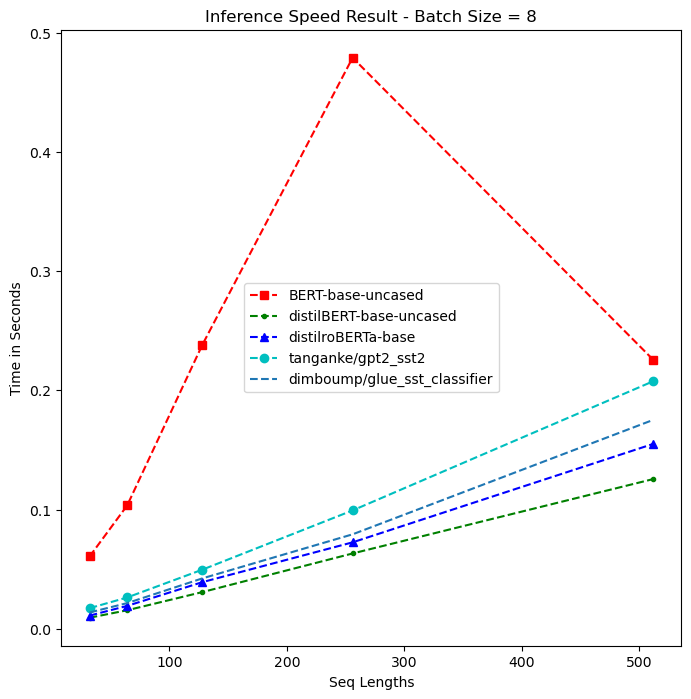

In [10]:
# Plot the results for batch 8 
plt.figure(figsize=(8,8))
t = sequence_lengths
plt.xlabel('Seq Lengths')
plt.ylabel('Time in Seconds')
plt.title('Inference Speed Result - Batch Size = 8')
plt.plot(t, models_perf_8[0], 'rs--',
         t, models_perf_8[1], 'g--.',
         t, models_perf_8[2], 'b--^',
         t, models_perf_8[3], 'c--o',
         t, models_perf_8[4], '--'
         )
plt.legend(models)
plt.show()

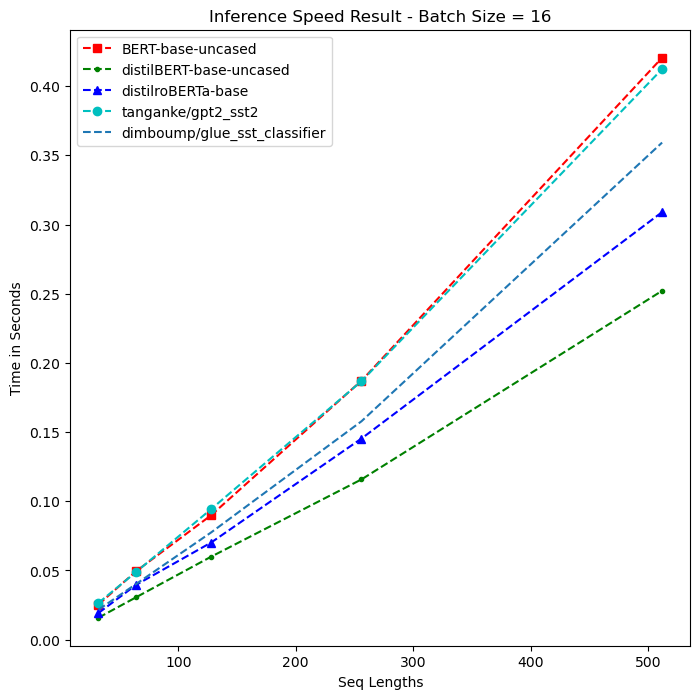

In [11]:
# Plot the results for batch 16 
plt.figure(figsize=(8,8))
t = sequence_lengths
plt.xlabel('Seq Lengths')
plt.ylabel('Time in Seconds')
plt.title('Inference Speed Result - Batch Size = 16')
plt.plot(t, models_perf_16[0], 'rs--',
         t, models_perf_16[1], 'g--.',
         t, models_perf_16[2], 'b--^',
         t, models_perf_16[3], 'c--o',
         t, models_perf_16[4], '--'
         )
plt.legend(models)
plt.show()

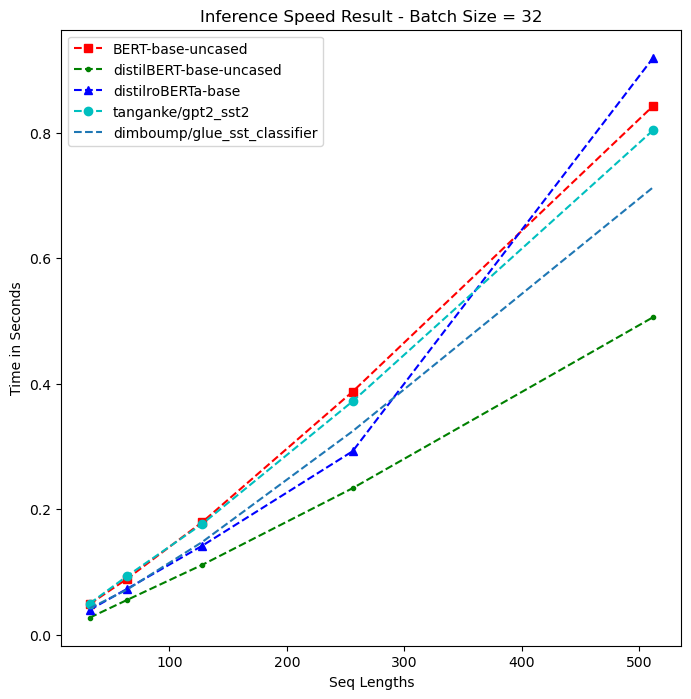

In [12]:
# Plot the results for batch 32 
plt.figure(figsize=(8,8))
t = sequence_lengths
plt.xlabel('Seq Lengths')
plt.ylabel('Time in Seconds')
plt.title('Inference Speed Result - Batch Size = 32')
plt.plot(t, models_perf_32[0], 'rs--',
         t, models_perf_32[1], 'g--.',
         t, models_perf_32[2], 'b--^',
         t, models_perf_32[3], 'c--o',
         t, models_perf_32[4], '--'
         )
plt.legend(models)
plt.show()

## 4.2 Plotting Inference Memory Results 

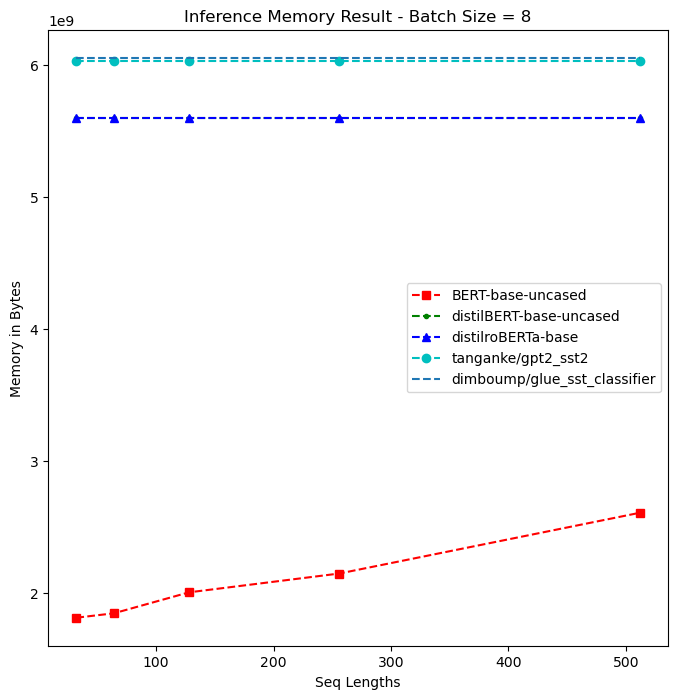

In [13]:
# Plot the results for batch size 8
plt.figure(figsize=(8,8))
t = sequence_lengths
plt.xlabel('Seq Lengths')
plt.ylabel('Memory in Bytes')
plt.title('Inference Memory Result - Batch Size = 8')
plt.plot(t, models_perf_memory_8[0], 'rs--',
         t, models_perf_memory_8[1], 'g--.',
         t, models_perf_memory_8[2], 'b--^',
         t, models_perf_memory_8[3], 'c--o',
         t, models_perf_memory_8[4], '--'
         )
plt.legend(models)
plt.show()

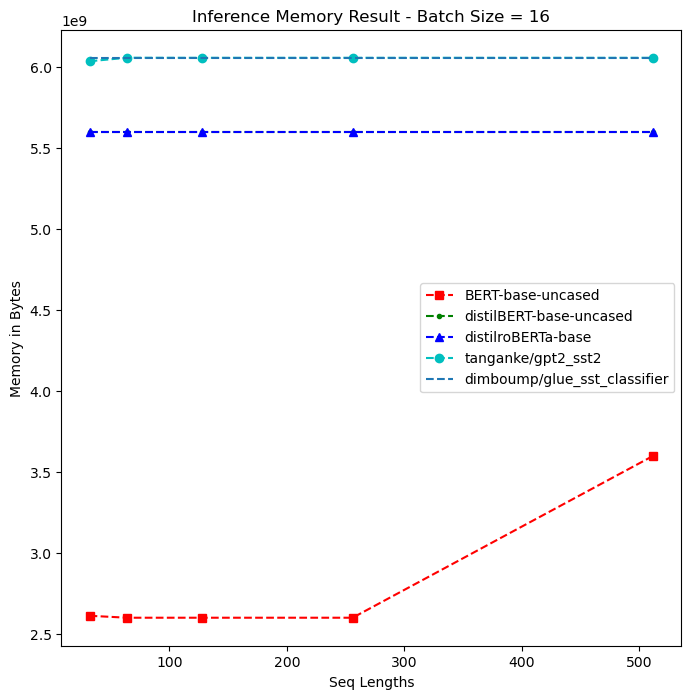

In [14]:
# Plot the results for batch size 16
plt.figure(figsize=(8,8))
t = sequence_lengths
plt.xlabel('Seq Lengths')
plt.ylabel('Memory in Bytes')
plt.title('Inference Memory Result - Batch Size = 16')
plt.plot(t, models_perf_memory_16[0], 'rs--',
         t, models_perf_memory_16[1], 'g--.',
         t, models_perf_memory_16[2], 'b--^',
         t, models_perf_memory_16[3], 'c--o',
         t, models_perf_memory_16[4], '--'
         )
plt.legend(models)
plt.show()

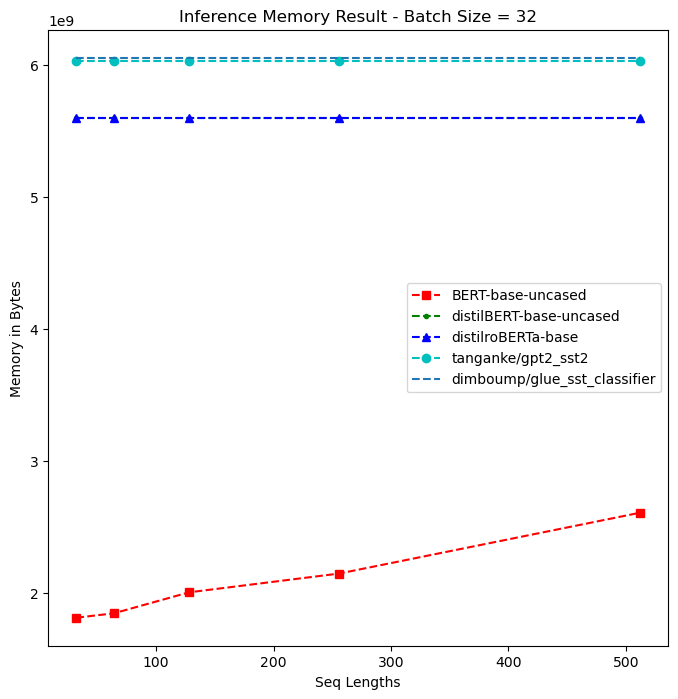

In [15]:
# Plot the results for batch size 16
plt.figure(figsize=(8,8))
t = sequence_lengths
plt.xlabel('Seq Lengths')
plt.ylabel('Memory in Bytes')
plt.title('Inference Memory Result - Batch Size = 32')
plt.plot(t, models_perf_memory_8[0], 'rs--',
         t, models_perf_memory_8[1], 'g--.',
         t, models_perf_memory_8[2], 'b--^',
         t, models_perf_memory_8[3], 'c--o',
         t, models_perf_memory_8[4], '--'
         )
plt.legend(models)
plt.show()

# 5. Function Definitions & Model Deployment

As a case study we user BERT base uncased model first. This model has 12 transformer layers, 768 hidden units per layer, and 12 self attention heads with a total of 110 million parameters

## 5.1 Test and Evaluate the Entire Dataset

The subset cola was chosen because of its relatively small size compared to other subsets, the purpose here is to train a model with the entire dataset and compare that with 5% of the dataset in the next analysis.

In [16]:
# Initilize model names 
model_name = "bert-base-uncased"

# Specify dataset and subset, cola is one of the smallest
dataset = "glue"
subset = "cola"

# Load the data set with exception handling
data = load_dataset(dataset, subset)

# Initialize pretrained tokenizer 
tokenizer = BertTokenizer.from_pretrained(model_name)

# Load model for sequence classification 
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
# Tokenize the Dataset
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

tokenized_datasets = data.map(tokenize_function, batched=True)

In [18]:
# Make sure sequence lengths match model size limit 
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Set up the dataset for training by formatting it to PyTorch tensors and selecting the necessary columns.
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "label"])
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["validation"]

In [19]:
# Fine-Tune the BERT Model using Trainer class 

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

c:\Users\moham\anaconda3\Lib\site-packages\accelerate\accelerator.py:451: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


  0%|          | 0/1605 [00:00<?, ?it/s]

{'loss': 0.4793, 'learning_rate': 1.3769470404984425e-05, 'epoch': 0.93}


  0%|          | 0/66 [00:00<?, ?it/s]

{'eval_loss': 0.4069441556930542, 'eval_runtime': 41.6782, 'eval_samples_per_second': 25.025, 'eval_steps_per_second': 1.584, 'epoch': 1.0}
{'loss': 0.2836, 'learning_rate': 7.538940809968847e-06, 'epoch': 1.87}


  0%|          | 0/66 [00:00<?, ?it/s]

{'eval_loss': 0.4584883451461792, 'eval_runtime': 49.1928, 'eval_samples_per_second': 21.202, 'eval_steps_per_second': 1.342, 'epoch': 2.0}
{'loss': 0.1787, 'learning_rate': 1.308411214953271e-06, 'epoch': 2.8}


  0%|          | 0/66 [00:00<?, ?it/s]

{'eval_loss': 0.5968855619430542, 'eval_runtime': 49.3709, 'eval_samples_per_second': 21.126, 'eval_steps_per_second': 1.337, 'epoch': 3.0}
{'train_runtime': 22751.9058, 'train_samples_per_second': 1.128, 'train_steps_per_second': 0.071, 'train_loss': 0.30500421732014216, 'epoch': 3.0}


TrainOutput(global_step=1605, training_loss=0.30500421732014216, metrics={'train_runtime': 22751.9058, 'train_samples_per_second': 1.128, 'train_steps_per_second': 0.071, 'train_loss': 0.30500421732014216, 'epoch': 3.0})

In [20]:
# Lets evaluate the model performance
trainer.evaluate()

  0%|          | 0/66 [00:00<?, ?it/s]

{'eval_loss': 0.5968855619430542,
 'eval_runtime': 50.4278,
 'eval_samples_per_second': 20.683,
 'eval_steps_per_second': 1.309,
 'epoch': 3.0}

In [21]:
# Get predictions on the validation set
predictions_full = trainer.predict(tokenized_datasets["validation"])

# Extract the predicted labels and the true labels
predicted_labels_full = np.argmax(predictions_full.predictions, axis=1)
true_labels_full = predictions_full.label_ids

# Calculate Accuracy
accuracy_full = accuracy_score(true_labels_full, predicted_labels_full)
print(f"Accuracy: {accuracy_full:.4f}")

# Calculate Matthew's Correlation Coefficient (MCC)
mcc_full = matthews_corrcoef(true_labels_full, predicted_labels_full)
print(f"Matthew's Correlation Coefficient: {mcc_full:.4f}")

  0%|          | 0/66 [00:00<?, ?it/s]

Accuracy: 0.8303
Matthew's Correlation Coefficient: 0.5833


## 5.2 Test and Evaluate 5% of Dataset

In [22]:
# Load 5% of the dataset to make computation faster
data_5_train = load_dataset(dataset, subset, split='train[:5%]')
data_5_validation = load_dataset(dataset, subset, split='validation[:5%]')
data_5_test = load_dataset(dataset, subset, split='test[:5%]')

# Print results to verify
print(data)
print(data_5_train)
print(data_5_validation)
print(data_5_test)

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 8551
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1043
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1063
    })
})
Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 428
})
Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 52
})
Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 53
})


In [23]:
# Tokenize the data
tokenized_5d_train = data_5_train.map(tokenize_function, batched=True)
tokenized_5d_validation = data_5_validation.map(tokenize_function, batched=True)
tokenized_5d_test = data_5_test.map(tokenize_function, batched=True)

In [24]:
# Train set format
tokenized_5d_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# Validation set format
tokenized_5d_validation.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# Test set format
tokenized_5d_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [25]:
# Fine-Tune the BERT Model using Trainer class 

trainer_5 = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_5d_train,
    eval_dataset=tokenized_5d_validation,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer_5.train()

c:\Users\moham\anaconda3\Lib\site-packages\accelerate\accelerator.py:451: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.8903217911720276, 'eval_runtime': 15.424, 'eval_samples_per_second': 3.371, 'eval_steps_per_second': 0.259, 'epoch': 1.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.8180277347564697, 'eval_runtime': 15.4748, 'eval_samples_per_second': 3.36, 'eval_steps_per_second': 0.258, 'epoch': 2.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.9553665518760681, 'eval_runtime': 15.4345, 'eval_samples_per_second': 3.369, 'eval_steps_per_second': 0.259, 'epoch': 3.0}
{'train_runtime': 1299.3361, 'train_samples_per_second': 0.988, 'train_steps_per_second': 0.062, 'train_loss': 0.18022948135564357, 'epoch': 3.0}


TrainOutput(global_step=81, training_loss=0.18022948135564357, metrics={'train_runtime': 1299.3361, 'train_samples_per_second': 0.988, 'train_steps_per_second': 0.062, 'train_loss': 0.18022948135564357, 'epoch': 3.0})

In [26]:
# Lets evaluate the model performance
trainer_5.evaluate()

  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.9553665518760681,
 'eval_runtime': 16.1551,
 'eval_samples_per_second': 3.219,
 'eval_steps_per_second': 0.248,
 'epoch': 3.0}

In [27]:
# Get predictions on the validation set
predictions_5 = trainer_5.predict(tokenized_5d_validation)

# Extract the predicted labels and the true labels
predicted_labels_5 = np.argmax(predictions_5.predictions, axis=1)
true_labels_5 = predictions_5.label_ids

# Calculate Accuracy
accuracy_5 = accuracy_score(true_labels_5, predicted_labels_5)
print(f"Accuracy: {accuracy_5:.4f}")

# Calculate Matthew's Correlation Coefficient (MCC)
mcc_5 = matthews_corrcoef(true_labels_5, predicted_labels_5)
print(f"Matthew's Correlation Coefficient: {mcc_5:.4f}")

  0%|          | 0/4 [00:00<?, ?it/s]

Accuracy: 0.7885
Matthew's Correlation Coefficient: 0.4892


# 6. Energy Consumption Analysis of Transformers

### Test for GPU

In [28]:
# Check if GPU is available and set the device accordingly
device = pt.device("cuda" if pt.cuda.is_available() else "cpu")

if pt.cuda.is_available():
    # Print the specific GPU device name
    print(f"Using GPU: {pt.cuda.get_device_name(device)}")
    
    # Print the current device index
    print(f"Current device index: {pt.cuda.current_device()}")
    
    # Print device properties
    print(f"Device properties: {pt.cuda.get_device_properties(device)}")
else:
    print("CUDA is not available. Running on CPU.")

# Print the device being used
print(f"Device being used: {device}")

Using GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Current device index: 0
Device properties: _CudaDeviceProperties(name='NVIDIA GeForce RTX 3060 Laptop GPU', major=8, minor=6, total_memory=6143MB, multi_processor_count=30)
Device being used: cuda


### Load a Dataset & Model Selection 

In [29]:
dataset = 'glue'
subset = 'sst2'

# Load 5% of the dataset to make computation faster
data_5_train = load_dataset(dataset, subset, split='train[:5%]')
data_5_validation = load_dataset(dataset, subset, split='validation[:5%]')
data_5_test = load_dataset(dataset, subset, split='test[:5%]')

# Benchmark a few models
models_test = [
    'BERT-base-uncased', 
    'distilBERT-base-uncased', 
    'distilroBERTa-base', 
    'tanganke/gpt2_sst2', 
    'dimboump/glue_sst_classifier'
    ]

## 6.1 Stage 1: Energy Consumption Comparison on Various Models during Training & Evaluation

### 6.1.1 Definitions

In [30]:
# Configure the output of the decorator 
csv_handler = CSVHandler('result_1.csv')

In [31]:
# To compute the desired metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    
    acc = accuracy_score(labels, preds)
    mcc = matthews_corrcoef(labels, preds)
    return {'accuracy': acc, 'matthews_correlation': mcc}

In [32]:
# Devorator function 
@measure_energy(handler=csv_handler, domains=[NvidiaGPUDomain(0)])
def evaluate_model_on_cola(model_name, data_train, data_validation, data_test):
    
    # Load tokenizer and and model (Pytorch Version)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)

    # Move the model to the GPU 
    model.to(device)

    def tokenize_function(example):
        return tokenizer(example['sentence'], padding="max_length", truncation=True)

    # Tokenize the data 
    tokenized_data_train = data_train.map(tokenize_function, batched=True)
    tokenized_data_validation = data_validation.map(tokenize_function, batched=True)
    tokenized_data_test = data_test.map(tokenize_function, batched=True)
    
    # Set the format for PyTorch and move tensors to the GPU
    tokenized_data_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    tokenized_data_validation.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    tokenized_data_test.set_format("torch", columns=["input_ids", "attention_mask", "label"])

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Set the training arguments
    training_args = TrainingArguments(
        output_dir="./result_1",
        evaluation_strategy="epoch",
        learning_rate=2e-5,
        # Reduce from 16 to 8 to help with gpu memory error
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
    )

    # Create the trainer for the model
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_data_train,
        eval_dataset=tokenized_data_validation,
        tokenizer=tokenizer,
        data_collator=data_collator, 
        compute_metrics=compute_metrics, 
    )

    trainer.train()
    result = trainer.evaluate()

    return result


### 6.1.2 Model Excecution

In [33]:
# To store the results
results = {}

In [34]:
# Interate over the list of models
for model_name in models_test: 
    print(f"Model to be evaluated: {model_name}")
    result = evaluate_model_on_cola(model_name, data_5_train, data_5_validation, data_5_test)
    results[model_name] = result

# Save the energy consumption results
csv_handler.save_data()

Model to be evaluated: BERT-base-uncased


c:\Users\moham\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at BERT-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3367 [00:00<?, ? examples/s]

Map:   0%|          | 0/44 [00:00<?, ? examples/s]

Map:   0%|          | 0/91 [00:00<?, ? examples/s]

c:\Users\moham\anaconda3\Lib\site-packages\accelerate\accelerator.py:451: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


  0%|          | 0/1263 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.7133, 'learning_rate': 1.9841646872525734e-05, 'epoch': 0.02}
{'loss': 0.6992, 'learning_rate': 1.9683293745051467e-05, 'epoch': 0.05}
{'loss': 0.6493, 'learning_rate': 1.95249406175772e-05, 'epoch': 0.07}
{'loss': 0.5946, 'learning_rate': 1.936658749010293e-05, 'epoch': 0.1}
{'loss': 0.4887, 'learning_rate': 1.9208234362628665e-05, 'epoch': 0.12}
{'loss': 0.3667, 'learning_rate': 1.9049881235154395e-05, 'epoch': 0.14}
{'loss': 0.2974, 'learning_rate': 1.8891528107680128e-05, 'epoch': 0.17}
{'loss': 0.2717, 'learning_rate': 1.873317498020586e-05, 'epoch': 0.19}
{'loss': 0.48, 'learning_rate': 1.8574821852731593e-05, 'epoch': 0.21}
{'loss': 0.4964, 'learning_rate': 1.8416468725257326e-05, 'epoch': 0.24}
{'loss': 0.2995, 'learning_rate': 1.825811559778306e-05, 'epoch': 0.26}
{'loss': 0.4684, 'learning_rate': 1.809976247030879e-05, 'epoch': 0.29}
{'loss': 0.3463, 'learning_rate': 1.794140934283452e-05, 'epoch': 0.31}
{'loss': 0.3306, 'learning_rate': 1.7783056215360253e-05, 'ep

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.1883908361196518, 'eval_accuracy': 0.9090909090909091, 'eval_matthews_correlation': 0.8215838362577491, 'eval_runtime': 15.5196, 'eval_samples_per_second': 2.835, 'eval_steps_per_second': 0.387, 'epoch': 1.0}
{'loss': 0.1458, 'learning_rate': 1.3190815518606495e-05, 'epoch': 1.02}
{'loss': 0.2274, 'learning_rate': 1.3032462391132226e-05, 'epoch': 1.05}
{'loss': 0.2743, 'learning_rate': 1.2874109263657959e-05, 'epoch': 1.07}
{'loss': 0.3392, 'learning_rate': 1.271575613618369e-05, 'epoch': 1.09}
{'loss': 0.1162, 'learning_rate': 1.2557403008709424e-05, 'epoch': 1.12}
{'loss': 0.4008, 'learning_rate': 1.2399049881235155e-05, 'epoch': 1.14}
{'loss': 0.197, 'learning_rate': 1.2240696753760888e-05, 'epoch': 1.16}
{'loss': 0.2763, 'learning_rate': 1.208234362628662e-05, 'epoch': 1.19}
{'loss': 0.2152, 'learning_rate': 1.1923990498812352e-05, 'epoch': 1.21}
{'loss': 0.3925, 'learning_rate': 1.1765637371338086e-05, 'epoch': 1.24}
{'loss': 0.2293, 'learning_rate': 1.160728424386

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.34909695386886597, 'eval_accuracy': 0.9090909090909091, 'eval_matthews_correlation': 0.8215838362577491, 'eval_runtime': 14.6716, 'eval_samples_per_second': 2.999, 'eval_steps_per_second': 0.409, 'epoch': 2.0}
{'loss': 0.2941, 'learning_rate': 6.539984164687253e-06, 'epoch': 2.02}
{'loss': 0.0876, 'learning_rate': 6.3816310372129854e-06, 'epoch': 2.04}
{'loss': 0.0705, 'learning_rate': 6.223277909738717e-06, 'epoch': 2.07}
{'loss': 0.1197, 'learning_rate': 6.06492478226445e-06, 'epoch': 2.09}
{'loss': 0.0143, 'learning_rate': 5.906571654790183e-06, 'epoch': 2.11}
{'loss': 0.0461, 'learning_rate': 5.748218527315916e-06, 'epoch': 2.14}
{'loss': 0.0685, 'learning_rate': 5.5898653998416475e-06, 'epoch': 2.16}
{'loss': 0.0756, 'learning_rate': 5.431512272367379e-06, 'epoch': 2.19}
{'loss': 0.114, 'learning_rate': 5.273159144893112e-06, 'epoch': 2.21}
{'loss': 0.2077, 'learning_rate': 5.114806017418844e-06, 'epoch': 2.23}
{'loss': 0.0073, 'learning_rate': 4.956452889944577e-0

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.4760882556438446, 'eval_accuracy': 0.9090909090909091, 'eval_matthews_correlation': 0.8215838362577491, 'eval_runtime': 12.7668, 'eval_samples_per_second': 3.446, 'eval_steps_per_second': 0.47, 'epoch': 3.0}
{'train_runtime': 10853.4849, 'train_samples_per_second': 0.931, 'train_steps_per_second': 0.116, 'train_loss': 0.22942002892334926, 'epoch': 3.0}


  0%|          | 0/6 [00:00<?, ?it/s]

Model to be evaluated: distilBERT-base-uncased


c:\Users\moham\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilBERT-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3367 [00:00<?, ? examples/s]

Map:   0%|          | 0/44 [00:00<?, ? examples/s]

Map:   0%|          | 0/91 [00:00<?, ? examples/s]

c:\Users\moham\anaconda3\Lib\site-packages\accelerate\accelerator.py:451: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


  0%|          | 0/1263 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.7132, 'learning_rate': 1.9841646872525734e-05, 'epoch': 0.02}
{'loss': 0.6883, 'learning_rate': 1.9683293745051467e-05, 'epoch': 0.05}
{'loss': 0.6825, 'learning_rate': 1.95249406175772e-05, 'epoch': 0.07}
{'loss': 0.6603, 'learning_rate': 1.936658749010293e-05, 'epoch': 0.1}
{'loss': 0.613, 'learning_rate': 1.9208234362628665e-05, 'epoch': 0.12}
{'loss': 0.5533, 'learning_rate': 1.9049881235154395e-05, 'epoch': 0.14}
{'loss': 0.4312, 'learning_rate': 1.8891528107680128e-05, 'epoch': 0.17}
{'loss': 0.3471, 'learning_rate': 1.873317498020586e-05, 'epoch': 0.19}
{'loss': 0.4451, 'learning_rate': 1.8574821852731593e-05, 'epoch': 0.21}
{'loss': 0.4716, 'learning_rate': 1.8416468725257326e-05, 'epoch': 0.24}
{'loss': 0.2453, 'learning_rate': 1.825811559778306e-05, 'epoch': 0.26}
{'loss': 0.4188, 'learning_rate': 1.809976247030879e-05, 'epoch': 0.29}
{'loss': 0.4176, 'learning_rate': 1.794140934283452e-05, 'epoch': 0.31}
{'loss': 0.4852, 'learning_rate': 1.7783056215360253e-05, 'e

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.18021546304225922, 'eval_accuracy': 0.9090909090909091, 'eval_matthews_correlation': 0.8181818181818182, 'eval_runtime': 0.7175, 'eval_samples_per_second': 61.324, 'eval_steps_per_second': 8.362, 'epoch': 1.0}
{'loss': 0.1253, 'learning_rate': 1.3190815518606495e-05, 'epoch': 1.02}
{'loss': 0.2003, 'learning_rate': 1.3032462391132226e-05, 'epoch': 1.05}
{'loss': 0.2679, 'learning_rate': 1.2874109263657959e-05, 'epoch': 1.07}
{'loss': 0.248, 'learning_rate': 1.271575613618369e-05, 'epoch': 1.09}
{'loss': 0.2362, 'learning_rate': 1.2557403008709424e-05, 'epoch': 1.12}
{'loss': 0.2485, 'learning_rate': 1.2399049881235155e-05, 'epoch': 1.14}
{'loss': 0.2686, 'learning_rate': 1.2240696753760888e-05, 'epoch': 1.16}
{'loss': 0.2438, 'learning_rate': 1.208234362628662e-05, 'epoch': 1.19}
{'loss': 0.2283, 'learning_rate': 1.1923990498812352e-05, 'epoch': 1.21}
{'loss': 0.3853, 'learning_rate': 1.1765637371338086e-05, 'epoch': 1.24}
{'loss': 0.2806, 'learning_rate': 1.16072842438

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.14535850286483765, 'eval_accuracy': 0.9545454545454546, 'eval_matthews_correlation': 0.9090909090909091, 'eval_runtime': 0.6589, 'eval_samples_per_second': 66.774, 'eval_steps_per_second': 9.106, 'epoch': 2.0}
{'loss': 0.319, 'learning_rate': 6.539984164687253e-06, 'epoch': 2.02}
{'loss': 0.1994, 'learning_rate': 6.3816310372129854e-06, 'epoch': 2.04}
{'loss': 0.0985, 'learning_rate': 6.223277909738717e-06, 'epoch': 2.07}
{'loss': 0.1041, 'learning_rate': 6.06492478226445e-06, 'epoch': 2.09}
{'loss': 0.0844, 'learning_rate': 5.906571654790183e-06, 'epoch': 2.11}
{'loss': 0.0424, 'learning_rate': 5.748218527315916e-06, 'epoch': 2.14}
{'loss': 0.2121, 'learning_rate': 5.5898653998416475e-06, 'epoch': 2.16}
{'loss': 0.0535, 'learning_rate': 5.431512272367379e-06, 'epoch': 2.19}
{'loss': 0.2481, 'learning_rate': 5.273159144893112e-06, 'epoch': 2.21}
{'loss': 0.0608, 'learning_rate': 5.114806017418844e-06, 'epoch': 2.23}
{'loss': 0.084, 'learning_rate': 4.956452889944577e-06

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.15116769075393677, 'eval_accuracy': 0.9545454545454546, 'eval_matthews_correlation': 0.9090909090909091, 'eval_runtime': 0.7358, 'eval_samples_per_second': 59.796, 'eval_steps_per_second': 8.154, 'epoch': 3.0}
{'train_runtime': 440.0252, 'train_samples_per_second': 22.956, 'train_steps_per_second': 2.87, 'train_loss': 0.2400189924421805, 'epoch': 3.0}


  0%|          | 0/6 [00:00<?, ?it/s]

Model to be evaluated: distilroBERTa-base


c:\Users\moham\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroBERTa-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3367 [00:00<?, ? examples/s]

Map:   0%|          | 0/44 [00:00<?, ? examples/s]

Map:   0%|          | 0/91 [00:00<?, ? examples/s]

c:\Users\moham\anaconda3\Lib\site-packages\accelerate\accelerator.py:451: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


  0%|          | 0/1263 [00:00<?, ?it/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.6932, 'learning_rate': 1.9841646872525734e-05, 'epoch': 0.02}
{'loss': 0.7142, 'learning_rate': 1.9683293745051467e-05, 'epoch': 0.05}
{'loss': 0.6804, 'learning_rate': 1.95249406175772e-05, 'epoch': 0.07}
{'loss': 0.6562, 'learning_rate': 1.936658749010293e-05, 'epoch': 0.1}
{'loss': 0.5358, 'learning_rate': 1.9208234362628665e-05, 'epoch': 0.12}
{'loss': 0.449, 'learning_rate': 1.9049881235154395e-05, 'epoch': 0.14}
{'loss': 0.3734, 'learning_rate': 1.8891528107680128e-05, 'epoch': 0.17}
{'loss': 0.3646, 'learning_rate': 1.873317498020586e-05, 'epoch': 0.19}
{'loss': 0.4864, 'learning_rate': 1.8574821852731593e-05, 'epoch': 0.21}
{'loss': 0.406, 'learning_rate': 1.8416468725257326e-05, 'epoch': 0.24}
{'loss': 0.3704, 'learning_rate': 1.825811559778306e-05, 'epoch': 0.26}
{'loss': 0.4509, 'learning_rate': 1.809976247030879e-05, 'epoch': 0.29}
{'loss': 0.4302, 'learning_rate': 1.794140934283452e-05, 'epoch': 0.31}
{'loss': 0.477, 'learning_rate': 1.7783056215360253e-05, 'epo

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.13602758944034576, 'eval_accuracy': 0.9545454545454546, 'eval_matthews_correlation': 0.9128709291752768, 'eval_runtime': 0.5652, 'eval_samples_per_second': 77.854, 'eval_steps_per_second': 10.616, 'epoch': 1.0}
{'loss': 0.2245, 'learning_rate': 1.3190815518606495e-05, 'epoch': 1.02}
{'loss': 0.2409, 'learning_rate': 1.3032462391132226e-05, 'epoch': 1.05}
{'loss': 0.3065, 'learning_rate': 1.2874109263657959e-05, 'epoch': 1.07}
{'loss': 0.2406, 'learning_rate': 1.271575613618369e-05, 'epoch': 1.09}
{'loss': 0.6288, 'learning_rate': 1.2557403008709424e-05, 'epoch': 1.12}
{'loss': 0.2608, 'learning_rate': 1.2399049881235155e-05, 'epoch': 1.14}
{'loss': 0.2214, 'learning_rate': 1.2240696753760888e-05, 'epoch': 1.16}
{'loss': 0.2588, 'learning_rate': 1.208234362628662e-05, 'epoch': 1.19}
{'loss': 0.3577, 'learning_rate': 1.1923990498812352e-05, 'epoch': 1.21}
{'loss': 0.6144, 'learning_rate': 1.1765637371338086e-05, 'epoch': 1.24}
{'loss': 0.1332, 'learning_rate': 1.160728424

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.15463612973690033, 'eval_accuracy': 0.9545454545454546, 'eval_matthews_correlation': 0.9128709291752768, 'eval_runtime': 0.6256, 'eval_samples_per_second': 70.327, 'eval_steps_per_second': 9.59, 'epoch': 2.0}
{'loss': 0.2788, 'learning_rate': 6.539984164687253e-06, 'epoch': 2.02}
{'loss': 0.2715, 'learning_rate': 6.3816310372129854e-06, 'epoch': 2.04}
{'loss': 0.2036, 'learning_rate': 6.223277909738717e-06, 'epoch': 2.07}
{'loss': 0.1271, 'learning_rate': 6.06492478226445e-06, 'epoch': 2.09}
{'loss': 0.1056, 'learning_rate': 5.906571654790183e-06, 'epoch': 2.11}
{'loss': 0.0196, 'learning_rate': 5.748218527315916e-06, 'epoch': 2.14}
{'loss': 0.2507, 'learning_rate': 5.5898653998416475e-06, 'epoch': 2.16}
{'loss': 0.0955, 'learning_rate': 5.431512272367379e-06, 'epoch': 2.19}
{'loss': 0.2303, 'learning_rate': 5.273159144893112e-06, 'epoch': 2.21}
{'loss': 0.3114, 'learning_rate': 5.114806017418844e-06, 'epoch': 2.23}
{'loss': 0.0888, 'learning_rate': 4.956452889944577e-0

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.2153988927602768, 'eval_accuracy': 0.9545454545454546, 'eval_matthews_correlation': 0.9128709291752768, 'eval_runtime': 0.5646, 'eval_samples_per_second': 77.929, 'eval_steps_per_second': 10.627, 'epoch': 3.0}
{'train_runtime': 401.1266, 'train_samples_per_second': 25.182, 'train_steps_per_second': 3.149, 'train_loss': 0.311667311190379, 'epoch': 3.0}


  0%|          | 0/6 [00:00<?, ?it/s]

Model to be evaluated: tanganke/gpt2_sst2


c:\Users\moham\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/3367 [00:00<?, ? examples/s]

Map:   0%|          | 0/44 [00:00<?, ? examples/s]

Map:   0%|          | 0/91 [00:00<?, ? examples/s]

c:\Users\moham\anaconda3\Lib\site-packages\accelerate\accelerator.py:451: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


  0%|          | 0/1263 [00:00<?, ?it/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.0015, 'learning_rate': 1.9841646872525734e-05, 'epoch': 0.02}
{'loss': 0.2019, 'learning_rate': 1.9683293745051467e-05, 'epoch': 0.05}
{'loss': 0.2312, 'learning_rate': 1.95249406175772e-05, 'epoch': 0.07}
{'loss': 0.2652, 'learning_rate': 1.936658749010293e-05, 'epoch': 0.1}
{'loss': 0.1515, 'learning_rate': 1.9208234362628665e-05, 'epoch': 0.12}
{'loss': 0.1435, 'learning_rate': 1.9049881235154395e-05, 'epoch': 0.14}
{'loss': 0.0682, 'learning_rate': 1.8891528107680128e-05, 'epoch': 0.17}
{'loss': 0.1766, 'learning_rate': 1.873317498020586e-05, 'epoch': 0.19}
{'loss': 0.0087, 'learning_rate': 1.8574821852731593e-05, 'epoch': 0.21}
{'loss': 0.1803, 'learning_rate': 1.8416468725257326e-05, 'epoch': 0.24}
{'loss': 0.0025, 'learning_rate': 1.825811559778306e-05, 'epoch': 0.26}
{'loss': 0.0027, 'learning_rate': 1.809976247030879e-05, 'epoch': 0.29}
{'loss': 0.1466, 'learning_rate': 1.794140934283452e-05, 'epoch': 0.31}
{'loss': 0.0407, 'learning_rate': 1.7783056215360253e-05, '

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.12478170543909073, 'eval_accuracy': 0.9545454545454546, 'eval_matthews_correlation': 0.9128709291752768, 'eval_runtime': 3.2875, 'eval_samples_per_second': 13.384, 'eval_steps_per_second': 1.825, 'epoch': 1.0}
{'loss': 0.0007, 'learning_rate': 1.3190815518606495e-05, 'epoch': 1.02}
{'loss': 0.0812, 'learning_rate': 1.3032462391132226e-05, 'epoch': 1.05}
{'loss': 0.0628, 'learning_rate': 1.2874109263657959e-05, 'epoch': 1.07}
{'loss': 0.1155, 'learning_rate': 1.271575613618369e-05, 'epoch': 1.09}
{'loss': 0.03, 'learning_rate': 1.2557403008709424e-05, 'epoch': 1.12}
{'loss': 0.1653, 'learning_rate': 1.2399049881235155e-05, 'epoch': 1.14}
{'loss': 0.0904, 'learning_rate': 1.2240696753760888e-05, 'epoch': 1.16}
{'loss': 0.0021, 'learning_rate': 1.208234362628662e-05, 'epoch': 1.19}
{'loss': 0.0797, 'learning_rate': 1.1923990498812352e-05, 'epoch': 1.21}
{'loss': 0.0852, 'learning_rate': 1.1765637371338086e-05, 'epoch': 1.24}
{'loss': 0.0011, 'learning_rate': 1.160728424386

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.08118756860494614, 'eval_accuracy': 0.9772727272727273, 'eval_matthews_correlation': 0.9555330859059091, 'eval_runtime': 4.0401, 'eval_samples_per_second': 10.891, 'eval_steps_per_second': 1.485, 'epoch': 2.0}
{'loss': 0.0463, 'learning_rate': 6.539984164687253e-06, 'epoch': 2.02}
{'loss': 0.102, 'learning_rate': 6.3816310372129854e-06, 'epoch': 2.04}
{'loss': 0.0562, 'learning_rate': 6.223277909738717e-06, 'epoch': 2.07}
{'loss': 0.0004, 'learning_rate': 6.06492478226445e-06, 'epoch': 2.09}
{'loss': 0.0151, 'learning_rate': 5.906571654790183e-06, 'epoch': 2.11}
{'loss': 0.0004, 'learning_rate': 5.748218527315916e-06, 'epoch': 2.14}
{'loss': 0.0373, 'learning_rate': 5.5898653998416475e-06, 'epoch': 2.16}
{'loss': 0.0056, 'learning_rate': 5.431512272367379e-06, 'epoch': 2.19}
{'loss': 0.0004, 'learning_rate': 5.273159144893112e-06, 'epoch': 2.21}
{'loss': 0.0099, 'learning_rate': 5.114806017418844e-06, 'epoch': 2.23}
{'loss': 0.0021, 'learning_rate': 4.956452889944577e-0

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.1257348209619522, 'eval_accuracy': 0.9772727272727273, 'eval_matthews_correlation': 0.9555330859059091, 'eval_runtime': 3.744, 'eval_samples_per_second': 11.752, 'eval_steps_per_second': 1.603, 'epoch': 3.0}
{'train_runtime': 7202.8791, 'train_samples_per_second': 1.402, 'train_steps_per_second': 0.175, 'train_loss': 0.054821269902377075, 'epoch': 3.0}


  0%|          | 0/6 [00:00<?, ?it/s]

Model to be evaluated: dimboump/glue_sst_classifier


c:\Users\moham\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/3367 [00:00<?, ? examples/s]

Map:   0%|          | 0/44 [00:00<?, ? examples/s]

Map:   0%|          | 0/91 [00:00<?, ? examples/s]

c:\Users\moham\anaconda3\Lib\site-packages\accelerate\accelerator.py:451: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


  0%|          | 0/1263 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.2466, 'learning_rate': 1.9841646872525734e-05, 'epoch': 0.02}
{'loss': 0.4577, 'learning_rate': 1.9683293745051467e-05, 'epoch': 0.05}
{'loss': 0.2316, 'learning_rate': 1.95249406175772e-05, 'epoch': 0.07}
{'loss': 0.5482, 'learning_rate': 1.936658749010293e-05, 'epoch': 0.1}
{'loss': 0.3112, 'learning_rate': 1.9208234362628665e-05, 'epoch': 0.12}
{'loss': 0.285, 'learning_rate': 1.9049881235154395e-05, 'epoch': 0.14}
{'loss': 0.1595, 'learning_rate': 1.8891528107680128e-05, 'epoch': 0.17}
{'loss': 0.1431, 'learning_rate': 1.873317498020586e-05, 'epoch': 0.19}
{'loss': 0.2307, 'learning_rate': 1.8574821852731593e-05, 'epoch': 0.21}
{'loss': 0.4044, 'learning_rate': 1.8416468725257326e-05, 'epoch': 0.24}
{'loss': 0.0974, 'learning_rate': 1.825811559778306e-05, 'epoch': 0.26}
{'loss': 0.2487, 'learning_rate': 1.809976247030879e-05, 'epoch': 0.29}
{'loss': 0.3907, 'learning_rate': 1.794140934283452e-05, 'epoch': 0.31}
{'loss': 0.2941, 'learning_rate': 1.7783056215360253e-05, 'e

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.16080640256404877, 'eval_accuracy': 0.9318181818181818, 'eval_matthews_correlation': 0.8645299348672512, 'eval_runtime': 0.2962, 'eval_samples_per_second': 148.525, 'eval_steps_per_second': 20.253, 'epoch': 1.0}
{'loss': 0.0825, 'learning_rate': 1.3190815518606495e-05, 'epoch': 1.02}
{'loss': 0.1194, 'learning_rate': 1.3032462391132226e-05, 'epoch': 1.05}
{'loss': 0.0122, 'learning_rate': 1.2874109263657959e-05, 'epoch': 1.07}
{'loss': 0.2218, 'learning_rate': 1.271575613618369e-05, 'epoch': 1.09}
{'loss': 0.059, 'learning_rate': 1.2557403008709424e-05, 'epoch': 1.12}
{'loss': 0.2927, 'learning_rate': 1.2399049881235155e-05, 'epoch': 1.14}
{'loss': 0.121, 'learning_rate': 1.2240696753760888e-05, 'epoch': 1.16}
{'loss': 0.0937, 'learning_rate': 1.208234362628662e-05, 'epoch': 1.19}
{'loss': 0.1222, 'learning_rate': 1.1923990498812352e-05, 'epoch': 1.21}
{'loss': 0.1009, 'learning_rate': 1.1765637371338086e-05, 'epoch': 1.24}
{'loss': 0.0055, 'learning_rate': 1.1607284243

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.3489530384540558, 'eval_accuracy': 0.9090909090909091, 'eval_matthews_correlation': 0.8215838362577491, 'eval_runtime': 0.3143, 'eval_samples_per_second': 140.008, 'eval_steps_per_second': 19.092, 'epoch': 2.0}
{'loss': 0.1474, 'learning_rate': 6.539984164687253e-06, 'epoch': 2.02}
{'loss': 0.032, 'learning_rate': 6.3816310372129854e-06, 'epoch': 2.04}
{'loss': 0.0542, 'learning_rate': 6.223277909738717e-06, 'epoch': 2.07}
{'loss': 0.0339, 'learning_rate': 6.06492478226445e-06, 'epoch': 2.09}
{'loss': 0.0018, 'learning_rate': 5.906571654790183e-06, 'epoch': 2.11}
{'loss': 0.0021, 'learning_rate': 5.748218527315916e-06, 'epoch': 2.14}
{'loss': 0.0017, 'learning_rate': 5.5898653998416475e-06, 'epoch': 2.16}
{'loss': 0.001, 'learning_rate': 5.431512272367379e-06, 'epoch': 2.19}
{'loss': 0.0323, 'learning_rate': 5.273159144893112e-06, 'epoch': 2.21}
{'loss': 0.1578, 'learning_rate': 5.114806017418844e-06, 'epoch': 2.23}
{'loss': 0.001, 'learning_rate': 4.956452889944577e-06

  0%|          | 0/6 [00:00<?, ?it/s]

{'eval_loss': 0.3264878988265991, 'eval_accuracy': 0.9318181818181818, 'eval_matthews_correlation': 0.8645299348672512, 'eval_runtime': 0.3067, 'eval_samples_per_second': 143.452, 'eval_steps_per_second': 19.562, 'epoch': 3.0}
{'train_runtime': 219.7435, 'train_samples_per_second': 45.967, 'train_steps_per_second': 5.748, 'train_loss': 0.159584943149814, 'epoch': 3.0}


  0%|          | 0/6 [00:00<?, ?it/s]

### 6.1.3 Plot the Results

In [35]:
# Lets extract the data and clean it into a pandas dataframe
e_results = pd.read_csv('result_1.csv')

e_results = e_results.iloc[:,0].str.split(";", expand=True)

e_results.columns = ['timestamp', 'function', 'duration', 'gpu energy consumption (joules)']

pprint(e_results)

            timestamp                function            duration  \
0   1724296877.357065  evaluate_model_on_cola  10869.785194635391   
1  1724307747.1462488  evaluate_model_on_cola  443.26426935195923   
2  1724308190.4115155  evaluate_model_on_cola  404.21812200546265   
3  1724308594.6316319  evaluate_model_on_cola   7209.450871229172   
4  1724315804.0835006  evaluate_model_on_cola    222.703022480011   

  gpu energy consumption (joules)  
0                       670421569  
1                        33202009  
2                        32289034  
3                       460350643  
4                        17157219  


In [36]:
# Print out the results
for model_name, result in results.items():
    print(f"Results for {model_name}: {result}")

Results for BERT-base-uncased: {'eval_loss': 0.4760882556438446, 'eval_accuracy': 0.9090909090909091, 'eval_matthews_correlation': 0.8215838362577491, 'eval_runtime': 12.5873, 'eval_samples_per_second': 3.496, 'eval_steps_per_second': 0.477, 'epoch': 3.0}
Results for distilBERT-base-uncased: {'eval_loss': 0.15116769075393677, 'eval_accuracy': 0.9545454545454546, 'eval_matthews_correlation': 0.9090909090909091, 'eval_runtime': 0.7135, 'eval_samples_per_second': 61.667, 'eval_steps_per_second': 8.409, 'epoch': 3.0}
Results for distilroBERTa-base: {'eval_loss': 0.2153988927602768, 'eval_accuracy': 0.9545454545454546, 'eval_matthews_correlation': 0.9128709291752768, 'eval_runtime': 0.5543, 'eval_samples_per_second': 79.378, 'eval_steps_per_second': 10.824, 'epoch': 3.0}
Results for tanganke/gpt2_sst2: {'eval_loss': 0.1257348209619522, 'eval_accuracy': 0.9772727272727273, 'eval_matthews_correlation': 0.9555330859059091, 'eval_runtime': 3.3535, 'eval_samples_per_second': 13.121, 'eval_steps_

In [37]:
# Convert the results to a DataFrame
results_df = pd.DataFrame(results).T

results_df.reset_index(inplace=True)

results_df.columns = ['Model', 'Loss', 'Accuracy', 'Matthews Correlation', 'Runtime (s)', 'Samples per Second', 'Steps per Second', 'Epoch']

print(results_df)

                          Model      Loss  Accuracy  Matthews Correlation  \
0             BERT-base-uncased  0.476088  0.909091              0.821584   
1       distilBERT-base-uncased  0.151168  0.954545              0.909091   
2            distilroBERTa-base  0.215399  0.954545              0.912871   
3            tanganke/gpt2_sst2  0.125735  0.977273              0.955533   
4  dimboump/glue_sst_classifier  0.326488  0.931818              0.864530   

   Runtime (s)  Samples per Second  Steps per Second  Epoch  
0      12.5873               3.496             0.477    3.0  
1       0.7135              61.667             8.409    3.0  
2       0.5543              79.378            10.824    3.0  
3       3.3535              13.121             1.789    3.0  
4       0.2885             152.514            20.797    3.0  


In [43]:
# Merge final file from both results
merged_results = pd.concat([results_df, e_results], axis=1)

merged_results['gpu energy consumption (joules)'] = merged_results['gpu energy consumption (joules)'].astype(float)
merged_results['duration'] = merged_results['duration'].astype(float)

print(merged_results)

                          Model      Loss  Accuracy  Matthews Correlation  \
0             BERT-base-uncased  0.476088  0.909091              0.821584   
1       distilBERT-base-uncased  0.151168  0.954545              0.909091   
2            distilroBERTa-base  0.215399  0.954545              0.912871   
3            tanganke/gpt2_sst2  0.125735  0.977273              0.955533   
4  dimboump/glue_sst_classifier  0.326488  0.931818              0.864530   

   Runtime (s)  Samples per Second  Steps per Second  Epoch  \
0      12.5873               3.496             0.477    3.0   
1       0.7135              61.667             8.409    3.0   
2       0.5543              79.378            10.824    3.0   
3       3.3535              13.121             1.789    3.0   
4       0.2885             152.514            20.797    3.0   

            timestamp                function      duration  \
0   1724296877.357065  evaluate_model_on_cola  10869.785195   
1  1724307747.1462488  evaluate_

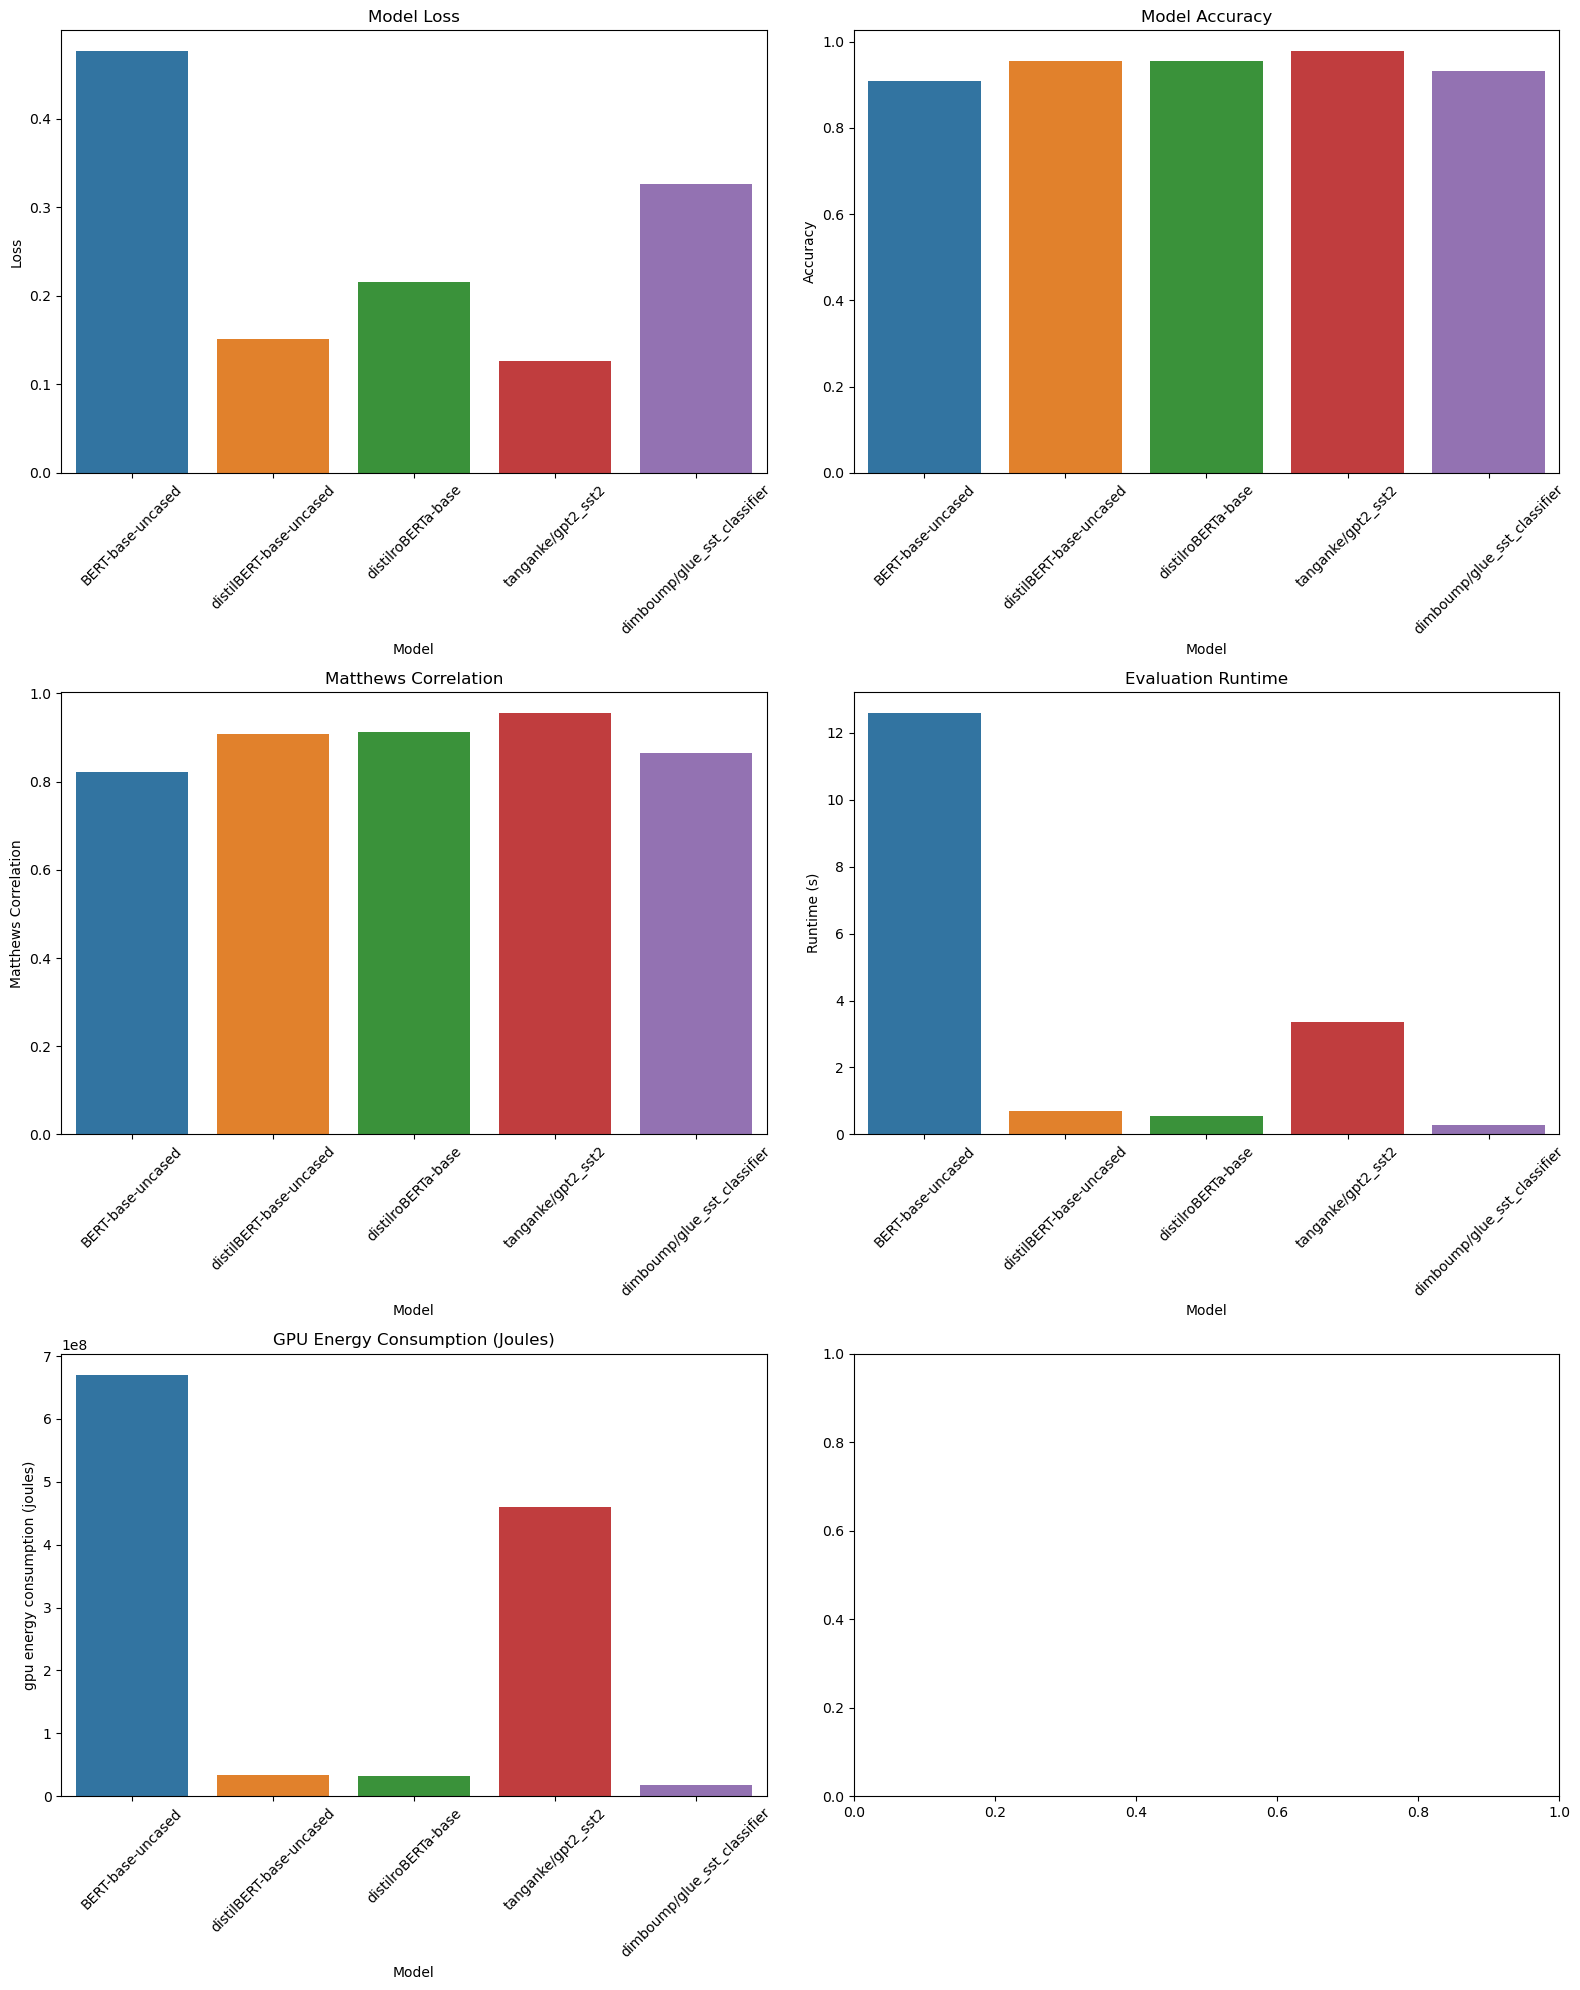

In [61]:
# Set up the figure and axis
fig, ax = plt.subplots(3, 2, figsize=(16, 20))

# Plot Loss
sns.barplot(x='Model', y='Loss', data=merged_results, ax=ax[0, 0])
ax[0, 0].set_title('Model Loss')
ax[0, 0].tick_params(axis='x', rotation=45)

# Plot Accuracy
sns.barplot(x='Model', y='Accuracy', data=merged_results, ax=ax[0, 1])
ax[0, 1].set_title('Model Accuracy')
ax[0, 1].tick_params(axis='x', rotation=45)

# Plot Matthews Correlation
sns.barplot(x='Model', y='Matthews Correlation', data=merged_results, ax=ax[1, 0])
ax[1, 0].set_title('Matthews Correlation')
ax[1, 0].tick_params(axis='x', rotation=45)

# Plot Runtime
sns.barplot(x='Model', y='Runtime (s)', data=merged_results, ax=ax[1, 1])
ax[1, 1].set_title('Evaluation Runtime')
ax[1, 1].tick_params(axis='x', rotation=45)

# Plot Runtime
sns.barplot(x='Model', y='gpu energy consumption (joules)', data=merged_results, ax=ax[2, 0])
ax[2, 0].set_title('GPU Energy Consumption (Joules)')
ax[2, 0].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

## 6.2 Stage 2: Energy Consumption Comparison on Various Models per Query

### 6.2.1 Load the Dataset

In [45]:
dataset = 'glue'
# Sentiment Analysis
subset = 'sst2'

# Load 5% of the dataset to make computation faster
data_query_train = load_dataset(dataset, subset, split='train[:2%]')
data_query_validation = load_dataset(dataset, subset, split='validation[:673]')
data_query_test = load_dataset(dataset, subset, split='test[:1%]')

In [46]:
print(data_query_train)
print(data_query_validation)
print(data_query_test)

Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 1347
})
Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 673
})
Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 18
})


### 6.2.2 Plot the sentence lengths as a distribution

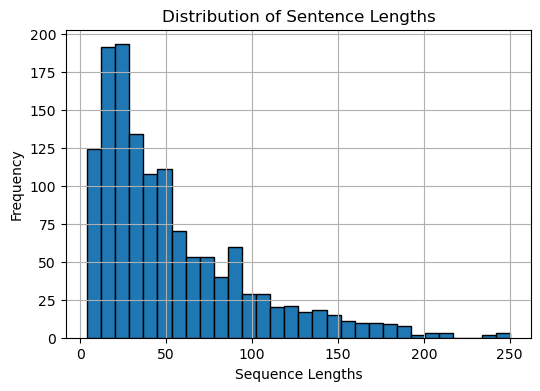

In [48]:
# Convert to dataframe
data_query_train_df = pd.DataFrame(data_query_train)

# Create a dataframe with the length of each sentence 
data_query_train_df["sentence length"] = data_query_train_df['sentence'].apply(len)

# Plot the lengths 
plt.figure(figsize=(6,4))
plt.hist(data_query_train_df["sentence length"], bins=30, edgecolor='black')
plt.title("Distribution of Sentence Lengths")
plt.xlabel('Sequence Lengths')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


### 6.2.3 Plot the token lengths as a distribution

c:\Users\moham\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


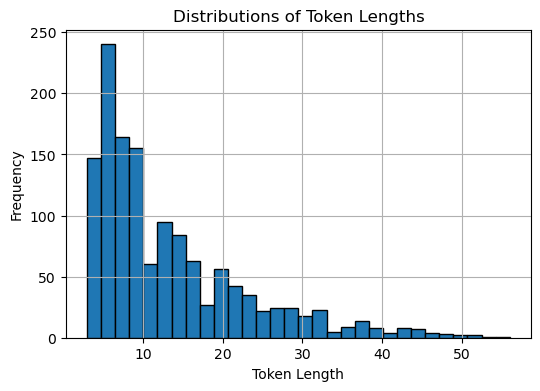

In [49]:
# Rnadomly choose one of the models
model_token_test = 'bert-base-uncased'

# Load the tokenizer and model
tokenizer_perce_test = AutoTokenizer.from_pretrained(model_token_test)
model_perce_query = AutoModelForSequenceClassification.from_pretrained(model_token_test)

# Function to tokenize the data
def tokenize_function(example):
    return tokenizer_perce_test(example['sentence'], padding="max_length", truncation=True)

# Function to calculate token length
def get_token_length(sentence):
    tokens = tokenizer_perce_test(sentence, truncation=True, padding=True)
    return len(tokens['input_ids'])

# Convert DataFrame to dictionary
def df_to_dict(df):
    return df.to_dict(orient='list')

# Add token length column to the DataFrame
data_query_train_df["token length"] = data_query_train_df["sentence"].apply(get_token_length)

#  Plot the results
plt.figure(figsize=(6,4))
plt.hist(data_query_train_df["token length"], bins = 30, edgecolor="black")
plt.title("Distributions of Token Lengths")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

### 6.2.4 Training each Query

In [50]:
# Initialize CSV file
csv_handler_2 = CSVHandler('results_2.csv') 

@measure_energy(handler=csv_handler_2, domains=[NvidiaGPUDomain(0)])
def evaluate_model_query(model_query, query_train, data_collator_query): 
    training_args_query = TrainingArguments(
        output_dir='./results',
        num_train_epochs=1,  # Only 1 epoch since it's just for energy measurement
        per_device_train_batch_size=1,  # Single batch size for single query training
        logging_dir='./logs',
        logging_steps=10,
    )

    trainer_query = Trainer(
        model=model_query,
        args=training_args_query,
        train_dataset=query_train,
        data_collator=data_collator_query, 
    )

    # Only perform training
    trainer_query.train()

In [51]:
models_test = [
    'BERT-base-uncased', 
    'distilBERT-base-uncased', 
    'distilroBERTa-base', 
    'tanganke/gpt2_sst2', 
    'dimboump/glue_sst_classifier'
    ]

predictions = []

In [52]:
# Loop through each model and each subset for evaluation
for model_name in models_test:
    # Load the tokenizer and model
    tokenizer_query = AutoTokenizer.from_pretrained(model_name)
    model_query = AutoModelForSequenceClassification.from_pretrained(model_name)

    # Move the model to the GPU
    model_query.to(device)

    # Tokenize the entire dataset
    tokenized_train_query = data_query_train.map(lambda x: tokenizer_query(x['sentence'], truncation=True, padding=True, max_length=512), batched=True)
    tokenized_train_query.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    
    data_collator_query = DataCollatorWithPadding(tokenizer=tokenizer_query)

    # Store the results
    for i in range(len(tokenized_train_query)):
        # Optionally print debug information
        query_train = tokenized_train_query.select([i])

        # Evaluate the model on the current subset
        evaluate_model_query(model_query, query_train, data_collator_query)
        
# Save the predictions to a CSV file
csv_handler_2.save_data()

c:\Users\moham\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at BERT-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1347 [00:00<?, ? examples/s]

c:\Users\moham\anaconda3\Lib\site-packages\accelerate\accelerator.py:451: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'train_runtime': 0.1731, 'train_samples_per_second': 5.778, 'train_steps_per_second': 5.778, 'train_loss': 0.2916227877140045, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.173, 'train_samples_per_second': 5.78, 'train_steps_per_second': 5.78, 'train_loss': 0.1779043972492218, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1558, 'train_samples_per_second': 6.42, 'train_steps_per_second': 6.42, 'train_loss': 1.9980974197387695, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1574, 'train_samples_per_second': 6.354, 'train_steps_per_second': 6.354, 'train_loss': 0.33060768246650696, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1435, 'train_samples_per_second': 6.967, 'train_steps_per_second': 6.967, 'train_loss': 0.17681139707565308, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1443, 'train_samples_per_second': 6.929, 'train_steps_per_second': 6.929, 'train_loss': 0.16437368094921112, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1458, 'train_samples_per_second': 6.856, 'train_steps_per_second': 6.856, 'train_loss': 2.3128015995025635, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1641, 'train_samples_per_second': 6.094, 'train_steps_per_second': 6.094, 'train_loss': 1.9895497560501099, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.148, 'train_samples_per_second': 6.758, 'train_steps_per_second': 6.758, 'train_loss': 0.40539756417274475, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.145, 'train_samples_per_second': 6.896, 'train_steps_per_second': 6.896, 'train_loss': 1.8709056377410889, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1455, 'train_samples_per_second': 6.871, 'train_steps_per_second': 6.871, 'train_loss': 0.3639920949935913, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1502, 'train_samples_per_second': 6.657, 'train_steps_per_second': 6.657, 'train_loss': 0.1545075923204422, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.14, 'train_samples_per_second': 7.142, 'train_steps_per_second': 7.142, 'train_loss': 0.10488623380661011, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1482, 'train_samples_per_second': 6.748, 'train_steps_per_second': 6.748, 'train_loss': 0.08516053855419159, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1462, 'train_samples_per_second': 6.84, 'train_steps_per_second': 6.84, 'train_loss': 0.06093098595738411, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1484, 'train_samples_per_second': 6.738, 'train_steps_per_second': 6.738, 'train_loss': 3.0193517208099365, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1412, 'train_samples_per_second': 7.083, 'train_steps_per_second': 7.083, 'train_loss': 0.17915286123752594, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1384, 'train_samples_per_second': 7.225, 'train_steps_per_second': 7.225, 'train_loss': 2.8506383895874023, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.148, 'train_samples_per_second': 6.758, 'train_steps_per_second': 6.758, 'train_loss': 0.09048719704151154, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1479, 'train_samples_per_second': 6.762, 'train_steps_per_second': 6.762, 'train_loss': 2.852081060409546, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1359, 'train_samples_per_second': 7.356, 'train_steps_per_second': 7.356, 'train_loss': 1.0691652297973633, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1454, 'train_samples_per_second': 6.876, 'train_steps_per_second': 6.876, 'train_loss': 0.29973551630973816, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.144, 'train_samples_per_second': 6.944, 'train_steps_per_second': 6.944, 'train_loss': 0.10600408911705017, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1611, 'train_samples_per_second': 6.208, 'train_steps_per_second': 6.208, 'train_loss': 0.06541649997234344, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1535, 'train_samples_per_second': 6.514, 'train_steps_per_second': 6.514, 'train_loss': 0.49960365891456604, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1357, 'train_samples_per_second': 7.37, 'train_steps_per_second': 7.37, 'train_loss': 2.2633731365203857, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1516, 'train_samples_per_second': 6.595, 'train_steps_per_second': 6.595, 'train_loss': 0.1588287055492401, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1541, 'train_samples_per_second': 6.489, 'train_steps_per_second': 6.489, 'train_loss': 2.5413153171539307, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1449, 'train_samples_per_second': 6.903, 'train_steps_per_second': 6.903, 'train_loss': 1.8993923664093018, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1449, 'train_samples_per_second': 6.902, 'train_steps_per_second': 6.902, 'train_loss': 0.26751381158828735, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1482, 'train_samples_per_second': 6.747, 'train_steps_per_second': 6.747, 'train_loss': 0.12643159925937653, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1461, 'train_samples_per_second': 6.843, 'train_steps_per_second': 6.843, 'train_loss': 2.2190515995025635, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1512, 'train_samples_per_second': 6.615, 'train_steps_per_second': 6.615, 'train_loss': 0.15017768740653992, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1541, 'train_samples_per_second': 6.49, 'train_steps_per_second': 6.49, 'train_loss': 0.1969708800315857, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1484, 'train_samples_per_second': 6.74, 'train_steps_per_second': 6.74, 'train_loss': 0.07397396117448807, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1561, 'train_samples_per_second': 6.405, 'train_steps_per_second': 6.405, 'train_loss': 3.292768955230713, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1488, 'train_samples_per_second': 6.72, 'train_steps_per_second': 6.72, 'train_loss': 2.9400339126586914, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1492, 'train_samples_per_second': 6.704, 'train_steps_per_second': 6.704, 'train_loss': 2.021237373352051, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1362, 'train_samples_per_second': 7.34, 'train_steps_per_second': 7.34, 'train_loss': 0.24044562876224518, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1668, 'train_samples_per_second': 5.994, 'train_steps_per_second': 5.994, 'train_loss': 2.0371813774108887, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1357, 'train_samples_per_second': 7.367, 'train_steps_per_second': 7.367, 'train_loss': 0.170717254281044, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1423, 'train_samples_per_second': 7.026, 'train_steps_per_second': 7.026, 'train_loss': 0.14040502905845642, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.146, 'train_samples_per_second': 6.85, 'train_steps_per_second': 6.85, 'train_loss': 0.07785000652074814, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1597, 'train_samples_per_second': 6.263, 'train_steps_per_second': 6.263, 'train_loss': 2.991821527481079, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1449, 'train_samples_per_second': 6.902, 'train_steps_per_second': 6.902, 'train_loss': 0.07305110991001129, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.137, 'train_samples_per_second': 7.298, 'train_steps_per_second': 7.298, 'train_loss': 2.837712287902832, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.183, 'train_samples_per_second': 5.465, 'train_steps_per_second': 5.465, 'train_loss': 2.6034607887268066, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1393, 'train_samples_per_second': 7.179, 'train_steps_per_second': 7.179, 'train_loss': 0.12116961926221848, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1492, 'train_samples_per_second': 6.702, 'train_steps_per_second': 6.702, 'train_loss': 2.3481979370117188, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1384, 'train_samples_per_second': 7.225, 'train_steps_per_second': 7.225, 'train_loss': 0.11059175431728363, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1533, 'train_samples_per_second': 6.521, 'train_steps_per_second': 6.521, 'train_loss': 0.08026070892810822, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1387, 'train_samples_per_second': 7.212, 'train_steps_per_second': 7.212, 'train_loss': 2.767542600631714, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1422, 'train_samples_per_second': 7.033, 'train_steps_per_second': 7.033, 'train_loss': 2.514892816543579, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1792, 'train_samples_per_second': 5.58, 'train_steps_per_second': 5.58, 'train_loss': 2.285156726837158, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1409, 'train_samples_per_second': 7.098, 'train_steps_per_second': 7.098, 'train_loss': 0.10212348401546478, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1357, 'train_samples_per_second': 7.368, 'train_steps_per_second': 7.368, 'train_loss': 0.0879078283905983, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1413, 'train_samples_per_second': 7.077, 'train_steps_per_second': 7.077, 'train_loss': 0.06777399778366089, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1472, 'train_samples_per_second': 6.792, 'train_steps_per_second': 6.792, 'train_loss': 3.127370834350586, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1576, 'train_samples_per_second': 6.347, 'train_steps_per_second': 6.347, 'train_loss': 2.671968936920166, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1389, 'train_samples_per_second': 7.2, 'train_steps_per_second': 7.2, 'train_loss': 0.10202553123235703, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1536, 'train_samples_per_second': 6.511, 'train_steps_per_second': 6.511, 'train_loss': 2.646113395690918, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1455, 'train_samples_per_second': 6.872, 'train_steps_per_second': 6.872, 'train_loss': 0.10064292699098587, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1511, 'train_samples_per_second': 6.616, 'train_steps_per_second': 6.616, 'train_loss': 0.07913582772016525, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1446, 'train_samples_per_second': 6.914, 'train_steps_per_second': 6.914, 'train_loss': 0.05702706798911095, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1584, 'train_samples_per_second': 6.313, 'train_steps_per_second': 6.313, 'train_loss': 0.03511190414428711, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.137, 'train_samples_per_second': 7.302, 'train_steps_per_second': 7.302, 'train_loss': 3.420208692550659, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1384, 'train_samples_per_second': 7.224, 'train_steps_per_second': 7.224, 'train_loss': 0.037106260657310486, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1356, 'train_samples_per_second': 7.375, 'train_steps_per_second': 7.375, 'train_loss': 0.037407394498586655, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1427, 'train_samples_per_second': 7.008, 'train_steps_per_second': 7.008, 'train_loss': 0.01981920376420021, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.14, 'train_samples_per_second': 7.141, 'train_steps_per_second': 7.141, 'train_loss': 4.200031757354736, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1415, 'train_samples_per_second': 7.067, 'train_steps_per_second': 7.067, 'train_loss': 0.02228795364499092, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1495, 'train_samples_per_second': 6.689, 'train_steps_per_second': 6.689, 'train_loss': 0.014715231023728848, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1371, 'train_samples_per_second': 7.292, 'train_steps_per_second': 7.292, 'train_loss': 4.294495582580566, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1404, 'train_samples_per_second': 7.123, 'train_steps_per_second': 7.123, 'train_loss': 0.02750186249613762, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1452, 'train_samples_per_second': 6.887, 'train_steps_per_second': 6.887, 'train_loss': 0.010539112612605095, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1432, 'train_samples_per_second': 6.985, 'train_steps_per_second': 6.985, 'train_loss': 4.662312984466553, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1409, 'train_samples_per_second': 7.097, 'train_steps_per_second': 7.097, 'train_loss': 0.014749765396118164, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1381, 'train_samples_per_second': 7.242, 'train_steps_per_second': 7.242, 'train_loss': 0.011074623093008995, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1512, 'train_samples_per_second': 6.613, 'train_steps_per_second': 6.613, 'train_loss': 0.006289332173764706, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1494, 'train_samples_per_second': 6.694, 'train_steps_per_second': 6.694, 'train_loss': 5.522644519805908, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1424, 'train_samples_per_second': 7.024, 'train_steps_per_second': 7.024, 'train_loss': 4.723989009857178, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1378, 'train_samples_per_second': 7.259, 'train_steps_per_second': 7.259, 'train_loss': 3.7973687648773193, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1537, 'train_samples_per_second': 6.506, 'train_steps_per_second': 6.506, 'train_loss': 3.796452760696411, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1387, 'train_samples_per_second': 7.208, 'train_steps_per_second': 7.208, 'train_loss': 2.466069221496582, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1356, 'train_samples_per_second': 7.377, 'train_steps_per_second': 7.377, 'train_loss': 1.8469816446304321, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1484, 'train_samples_per_second': 6.737, 'train_steps_per_second': 6.737, 'train_loss': 0.24431365728378296, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1381, 'train_samples_per_second': 7.241, 'train_steps_per_second': 7.241, 'train_loss': 1.8318850994110107, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1424, 'train_samples_per_second': 7.02, 'train_steps_per_second': 7.02, 'train_loss': 1.521378755569458, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1551, 'train_samples_per_second': 6.445, 'train_steps_per_second': 6.445, 'train_loss': 0.7845261096954346, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1437, 'train_samples_per_second': 6.957, 'train_steps_per_second': 6.957, 'train_loss': 0.206781268119812, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.142, 'train_samples_per_second': 7.042, 'train_steps_per_second': 7.042, 'train_loss': 2.1696066856384277, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1396, 'train_samples_per_second': 7.165, 'train_steps_per_second': 7.165, 'train_loss': 0.7445865869522095, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1446, 'train_samples_per_second': 6.918, 'train_steps_per_second': 6.918, 'train_loss': 1.7717220783233643, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1382, 'train_samples_per_second': 7.238, 'train_steps_per_second': 7.238, 'train_loss': 1.1407315731048584, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1475, 'train_samples_per_second': 6.778, 'train_steps_per_second': 6.778, 'train_loss': 0.2813569903373718, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1495, 'train_samples_per_second': 6.69, 'train_steps_per_second': 6.69, 'train_loss': 0.1294979602098465, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1424, 'train_samples_per_second': 7.024, 'train_steps_per_second': 7.024, 'train_loss': 2.989208459854126, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1557, 'train_samples_per_second': 6.424, 'train_steps_per_second': 6.424, 'train_loss': 1.1270536184310913, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1459, 'train_samples_per_second': 6.855, 'train_steps_per_second': 6.855, 'train_loss': 0.24176467955112457, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.14, 'train_samples_per_second': 7.14, 'train_steps_per_second': 7.14, 'train_loss': 0.08416226506233215, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1397, 'train_samples_per_second': 7.159, 'train_steps_per_second': 7.159, 'train_loss': 0.05639044567942619, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.138, 'train_samples_per_second': 7.249, 'train_steps_per_second': 7.249, 'train_loss': 0.039473045617341995, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.151, 'train_samples_per_second': 6.625, 'train_steps_per_second': 6.625, 'train_loss': 3.7967472076416016, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1366, 'train_samples_per_second': 7.322, 'train_steps_per_second': 7.322, 'train_loss': 0.05322903022170067, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1461, 'train_samples_per_second': 6.846, 'train_steps_per_second': 6.846, 'train_loss': 3.606506824493408, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.89, 'train_steps_per_second': 6.89, 'train_loss': 0.046795062720775604, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1586, 'train_samples_per_second': 6.304, 'train_steps_per_second': 6.304, 'train_loss': 3.669347047805786, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1472, 'train_samples_per_second': 6.791, 'train_steps_per_second': 6.791, 'train_loss': 3.2911972999572754, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1525, 'train_samples_per_second': 6.556, 'train_steps_per_second': 6.556, 'train_loss': 0.06743083894252777, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1586, 'train_samples_per_second': 6.307, 'train_steps_per_second': 6.307, 'train_loss': 0.18223556876182556, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1471, 'train_samples_per_second': 6.799, 'train_steps_per_second': 6.799, 'train_loss': 3.133774757385254, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.14, 'train_samples_per_second': 7.142, 'train_steps_per_second': 7.142, 'train_loss': 0.07131529599428177, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1402, 'train_samples_per_second': 7.133, 'train_steps_per_second': 7.133, 'train_loss': 0.0487341471016407, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1661, 'train_samples_per_second': 6.021, 'train_steps_per_second': 6.021, 'train_loss': 0.030679870396852493, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1471, 'train_samples_per_second': 6.796, 'train_steps_per_second': 6.796, 'train_loss': 2.774134397506714, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1399, 'train_samples_per_second': 7.146, 'train_steps_per_second': 7.146, 'train_loss': 0.6662012934684753, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1531, 'train_samples_per_second': 6.532, 'train_steps_per_second': 6.532, 'train_loss': 0.13140013813972473, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1433, 'train_samples_per_second': 6.981, 'train_steps_per_second': 6.981, 'train_loss': 0.029082518070936203, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1551, 'train_samples_per_second': 6.447, 'train_steps_per_second': 6.447, 'train_loss': 4.196287155151367, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1381, 'train_samples_per_second': 7.24, 'train_steps_per_second': 7.24, 'train_loss': 0.033190831542015076, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1441, 'train_samples_per_second': 6.942, 'train_steps_per_second': 6.942, 'train_loss': 3.755708694458008, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1407, 'train_samples_per_second': 7.108, 'train_steps_per_second': 7.108, 'train_loss': 0.04153523966670036, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1392, 'train_samples_per_second': 7.182, 'train_steps_per_second': 7.182, 'train_loss': 0.027436450123786926, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1442, 'train_samples_per_second': 6.936, 'train_steps_per_second': 6.936, 'train_loss': 0.017155935987830162, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1404, 'train_samples_per_second': 7.122, 'train_steps_per_second': 7.122, 'train_loss': 4.595157623291016, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1405, 'train_samples_per_second': 7.12, 'train_steps_per_second': 7.12, 'train_loss': 0.018071172758936882, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1446, 'train_samples_per_second': 6.913, 'train_steps_per_second': 6.913, 'train_loss': 4.469720840454102, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1454, 'train_samples_per_second': 6.879, 'train_steps_per_second': 6.879, 'train_loss': 3.9554202556610107, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1572, 'train_samples_per_second': 6.362, 'train_steps_per_second': 6.362, 'train_loss': 3.2812869548797607, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1374, 'train_samples_per_second': 7.279, 'train_steps_per_second': 7.279, 'train_loss': 0.19946081936359406, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1488, 'train_samples_per_second': 6.72, 'train_steps_per_second': 6.72, 'train_loss': 3.147801637649536, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1456, 'train_samples_per_second': 6.87, 'train_steps_per_second': 6.87, 'train_loss': 0.15602745115756989, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1601, 'train_samples_per_second': 6.247, 'train_steps_per_second': 6.247, 'train_loss': 3.0671205520629883, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1445, 'train_samples_per_second': 6.92, 'train_steps_per_second': 6.92, 'train_loss': 0.11512628197669983, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1566, 'train_samples_per_second': 6.385, 'train_steps_per_second': 6.385, 'train_loss': 0.04535895958542824, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1442, 'train_samples_per_second': 6.936, 'train_steps_per_second': 6.936, 'train_loss': 3.5922746658325195, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1508, 'train_samples_per_second': 6.633, 'train_steps_per_second': 6.633, 'train_loss': 3.0470528602600098, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1367, 'train_samples_per_second': 7.313, 'train_steps_per_second': 7.313, 'train_loss': 2.308915853500366, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1493, 'train_samples_per_second': 6.697, 'train_steps_per_second': 6.697, 'train_loss': 0.4155445396900177, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1457, 'train_samples_per_second': 6.863, 'train_steps_per_second': 6.863, 'train_loss': 0.11083090305328369, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1442, 'train_samples_per_second': 6.936, 'train_steps_per_second': 6.936, 'train_loss': 3.0702526569366455, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1457, 'train_samples_per_second': 6.863, 'train_steps_per_second': 6.863, 'train_loss': 2.373788356781006, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.89, 'train_steps_per_second': 6.89, 'train_loss': 1.5414258241653442, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.141, 'train_samples_per_second': 7.09, 'train_steps_per_second': 7.09, 'train_loss': 0.9392212629318237, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1418, 'train_samples_per_second': 7.054, 'train_steps_per_second': 7.054, 'train_loss': 0.24742111563682556, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1414, 'train_samples_per_second': 7.072, 'train_steps_per_second': 7.072, 'train_loss': 2.2280797958374023, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1557, 'train_samples_per_second': 6.424, 'train_steps_per_second': 6.424, 'train_loss': 0.2496362030506134, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1449, 'train_samples_per_second': 6.904, 'train_steps_per_second': 6.904, 'train_loss': 2.277458429336548, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1659, 'train_samples_per_second': 6.026, 'train_steps_per_second': 6.026, 'train_loss': 0.2210998386144638, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1412, 'train_samples_per_second': 7.083, 'train_steps_per_second': 7.083, 'train_loss': 2.230017900466919, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1466, 'train_samples_per_second': 6.82, 'train_steps_per_second': 6.82, 'train_loss': 1.6498918533325195, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1436, 'train_samples_per_second': 6.966, 'train_steps_per_second': 6.966, 'train_loss': 0.38921865820884705, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1442, 'train_samples_per_second': 6.937, 'train_steps_per_second': 6.937, 'train_loss': 1.7481814622879028, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1424, 'train_samples_per_second': 7.023, 'train_steps_per_second': 7.023, 'train_loss': 1.2049609422683716, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1418, 'train_samples_per_second': 7.051, 'train_steps_per_second': 7.051, 'train_loss': 0.7399187088012695, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.144, 'train_samples_per_second': 6.944, 'train_steps_per_second': 6.944, 'train_loss': 0.3715323507785797, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1433, 'train_samples_per_second': 6.98, 'train_steps_per_second': 6.98, 'train_loss': 1.6286371946334839, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1464, 'train_samples_per_second': 6.832, 'train_steps_per_second': 6.832, 'train_loss': 1.229070782661438, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1665, 'train_samples_per_second': 6.007, 'train_steps_per_second': 6.007, 'train_loss': 0.7699596881866455, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1452, 'train_samples_per_second': 6.888, 'train_steps_per_second': 6.888, 'train_loss': 1.4933675527572632, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1601, 'train_samples_per_second': 6.246, 'train_steps_per_second': 6.246, 'train_loss': 0.7243605852127075, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1382, 'train_samples_per_second': 7.238, 'train_steps_per_second': 7.238, 'train_loss': 1.2773650884628296, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1535, 'train_samples_per_second': 6.516, 'train_steps_per_second': 6.516, 'train_loss': 0.6653435230255127, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1471, 'train_samples_per_second': 6.796, 'train_steps_per_second': 6.796, 'train_loss': 1.1333060264587402, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1367, 'train_samples_per_second': 7.317, 'train_steps_per_second': 7.317, 'train_loss': 0.7621253728866577, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1416, 'train_samples_per_second': 7.063, 'train_steps_per_second': 7.063, 'train_loss': 1.1117076873779297, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1444, 'train_samples_per_second': 6.925, 'train_steps_per_second': 6.925, 'train_loss': 0.7437005043029785, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1461, 'train_samples_per_second': 6.846, 'train_steps_per_second': 6.846, 'train_loss': 0.4278273582458496, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1361, 'train_samples_per_second': 7.347, 'train_steps_per_second': 7.347, 'train_loss': 0.16655825078487396, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1491, 'train_samples_per_second': 6.707, 'train_steps_per_second': 6.707, 'train_loss': 3.7229671478271484, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1421, 'train_samples_per_second': 7.036, 'train_steps_per_second': 7.036, 'train_loss': 0.12386304885149002, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1417, 'train_samples_per_second': 7.057, 'train_steps_per_second': 7.057, 'train_loss': 0.02412499114871025, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1478, 'train_samples_per_second': 6.764, 'train_steps_per_second': 6.764, 'train_loss': 0.013605953194200993, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1407, 'train_samples_per_second': 7.109, 'train_steps_per_second': 7.109, 'train_loss': 4.101132869720459, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1419, 'train_samples_per_second': 7.048, 'train_steps_per_second': 7.048, 'train_loss': 0.073738232254982, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1505, 'train_samples_per_second': 6.644, 'train_steps_per_second': 6.644, 'train_loss': 3.861703872680664, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1479, 'train_samples_per_second': 6.763, 'train_steps_per_second': 6.763, 'train_loss': 0.0595238134264946, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1439, 'train_samples_per_second': 6.95, 'train_steps_per_second': 6.95, 'train_loss': 0.020758280530571938, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1466, 'train_samples_per_second': 6.82, 'train_steps_per_second': 6.82, 'train_loss': 5.068525314331055, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1479, 'train_samples_per_second': 6.763, 'train_steps_per_second': 6.763, 'train_loss': 0.024424593895673752, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1452, 'train_samples_per_second': 6.889, 'train_steps_per_second': 6.889, 'train_loss': 4.647797107696533, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.891, 'train_steps_per_second': 6.891, 'train_loss': 3.41796875, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.143, 'train_samples_per_second': 6.992, 'train_steps_per_second': 6.992, 'train_loss': 0.1950811743736267, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.147, 'train_samples_per_second': 6.805, 'train_steps_per_second': 6.805, 'train_loss': 3.289207696914673, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1656, 'train_samples_per_second': 6.039, 'train_steps_per_second': 6.039, 'train_loss': 0.1598985493183136, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1391, 'train_samples_per_second': 7.19, 'train_steps_per_second': 7.19, 'train_loss': 0.0453094020485878, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1656, 'train_samples_per_second': 6.039, 'train_steps_per_second': 6.039, 'train_loss': 4.37415885925293, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1445, 'train_samples_per_second': 6.918, 'train_steps_per_second': 6.918, 'train_loss': 3.296504259109497, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1371, 'train_samples_per_second': 7.293, 'train_steps_per_second': 7.293, 'train_loss': 0.1376505196094513, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1441, 'train_samples_per_second': 6.937, 'train_steps_per_second': 6.937, 'train_loss': 3.292316436767578, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1432, 'train_samples_per_second': 6.985, 'train_steps_per_second': 6.985, 'train_loss': 2.0797348022460938, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1468, 'train_samples_per_second': 6.813, 'train_steps_per_second': 6.813, 'train_loss': 0.29788655042648315, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1615, 'train_samples_per_second': 6.19, 'train_steps_per_second': 6.19, 'train_loss': 0.11521679908037186, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1474, 'train_samples_per_second': 6.783, 'train_steps_per_second': 6.783, 'train_loss': 3.227356195449829, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1572, 'train_samples_per_second': 6.363, 'train_steps_per_second': 6.363, 'train_loss': 2.137784481048584, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1432, 'train_samples_per_second': 6.985, 'train_steps_per_second': 6.985, 'train_loss': 1.456017017364502, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1533, 'train_samples_per_second': 6.523, 'train_steps_per_second': 6.523, 'train_loss': 0.530020534992218, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1442, 'train_samples_per_second': 6.935, 'train_steps_per_second': 6.935, 'train_loss': 0.2947595715522766, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1531, 'train_samples_per_second': 6.532, 'train_steps_per_second': 6.532, 'train_loss': 2.012373924255371, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1421, 'train_samples_per_second': 7.036, 'train_steps_per_second': 7.036, 'train_loss': 1.4357881546020508, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1696, 'train_samples_per_second': 5.895, 'train_steps_per_second': 5.895, 'train_loss': 0.9676814675331116, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1486, 'train_samples_per_second': 6.731, 'train_steps_per_second': 6.731, 'train_loss': 0.7390181422233582, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1629, 'train_samples_per_second': 6.14, 'train_steps_per_second': 6.14, 'train_loss': 0.9805773496627808, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1411, 'train_samples_per_second': 7.087, 'train_steps_per_second': 7.087, 'train_loss': 0.6596829891204834, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1605, 'train_samples_per_second': 6.231, 'train_steps_per_second': 6.231, 'train_loss': 0.4337416887283325, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1461, 'train_samples_per_second': 6.842, 'train_steps_per_second': 6.842, 'train_loss': 1.4499194622039795, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1487, 'train_samples_per_second': 6.727, 'train_steps_per_second': 6.727, 'train_loss': 1.047838568687439, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1436, 'train_samples_per_second': 6.963, 'train_steps_per_second': 6.963, 'train_loss': 0.6494362950325012, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1473, 'train_samples_per_second': 6.787, 'train_steps_per_second': 6.787, 'train_loss': 1.0506343841552734, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1439, 'train_samples_per_second': 6.947, 'train_steps_per_second': 6.947, 'train_loss': 0.6340107917785645, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1492, 'train_samples_per_second': 6.702, 'train_steps_per_second': 6.702, 'train_loss': 0.43086639046669006, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1483, 'train_samples_per_second': 6.744, 'train_steps_per_second': 6.744, 'train_loss': 0.27744942903518677, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1428, 'train_samples_per_second': 7.005, 'train_steps_per_second': 7.005, 'train_loss': 1.812974452972412, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1362, 'train_samples_per_second': 7.342, 'train_steps_per_second': 7.342, 'train_loss': 0.2805302143096924, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1564, 'train_samples_per_second': 6.392, 'train_steps_per_second': 6.392, 'train_loss': 0.1794532835483551, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1408, 'train_samples_per_second': 7.103, 'train_steps_per_second': 7.103, 'train_loss': 2.276792526245117, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1561, 'train_samples_per_second': 6.406, 'train_steps_per_second': 6.406, 'train_loss': 1.805004358291626, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1464, 'train_samples_per_second': 6.831, 'train_steps_per_second': 6.831, 'train_loss': 1.401041030883789, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1495, 'train_samples_per_second': 6.689, 'train_steps_per_second': 6.689, 'train_loss': 0.4018375277519226, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1402, 'train_samples_per_second': 7.134, 'train_steps_per_second': 7.134, 'train_loss': 1.434749960899353, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1571, 'train_samples_per_second': 6.366, 'train_steps_per_second': 6.366, 'train_loss': 1.108454704284668, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1414, 'train_samples_per_second': 7.07, 'train_steps_per_second': 7.07, 'train_loss': 0.5820038318634033, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1473, 'train_samples_per_second': 6.788, 'train_steps_per_second': 6.788, 'train_loss': 0.42339789867401123, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1426, 'train_samples_per_second': 7.01, 'train_steps_per_second': 7.01, 'train_loss': 1.4039011001586914, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1479, 'train_samples_per_second': 6.759, 'train_steps_per_second': 6.759, 'train_loss': 1.1029508113861084, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1468, 'train_samples_per_second': 6.813, 'train_steps_per_second': 6.813, 'train_loss': 0.840151309967041, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.157, 'train_samples_per_second': 6.37, 'train_steps_per_second': 6.37, 'train_loss': 0.7976102828979492, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1469, 'train_samples_per_second': 6.807, 'train_steps_per_second': 6.807, 'train_loss': 0.564753532409668, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1468, 'train_samples_per_second': 6.811, 'train_steps_per_second': 6.811, 'train_loss': 0.41124796867370605, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1567, 'train_samples_per_second': 6.382, 'train_steps_per_second': 6.382, 'train_loss': 1.3913416862487793, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1544, 'train_samples_per_second': 6.477, 'train_steps_per_second': 6.477, 'train_loss': 1.079395055770874, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1419, 'train_samples_per_second': 7.046, 'train_steps_per_second': 7.046, 'train_loss': 0.8538991212844849, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1468, 'train_samples_per_second': 6.811, 'train_steps_per_second': 6.811, 'train_loss': 0.6183134913444519, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.14, 'train_samples_per_second': 7.142, 'train_steps_per_second': 7.142, 'train_loss': 1.093768835067749, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1576, 'train_samples_per_second': 6.346, 'train_steps_per_second': 6.346, 'train_loss': 0.6265716552734375, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1462, 'train_samples_per_second': 6.841, 'train_steps_per_second': 6.841, 'train_loss': 1.04581618309021, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1572, 'train_samples_per_second': 6.36, 'train_steps_per_second': 6.36, 'train_loss': 0.7699170708656311, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1469, 'train_samples_per_second': 6.809, 'train_steps_per_second': 6.809, 'train_loss': 0.5656874775886536, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1591, 'train_samples_per_second': 6.285, 'train_steps_per_second': 6.285, 'train_loss': 0.39851871132850647, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1495, 'train_samples_per_second': 6.689, 'train_steps_per_second': 6.689, 'train_loss': 1.4885995388031006, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1381, 'train_samples_per_second': 7.243, 'train_steps_per_second': 7.243, 'train_loss': 1.1242824792861938, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1511, 'train_samples_per_second': 6.619, 'train_steps_per_second': 6.619, 'train_loss': 0.5363977551460266, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1622, 'train_samples_per_second': 6.166, 'train_steps_per_second': 6.166, 'train_loss': 0.39407190680503845, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1478, 'train_samples_per_second': 6.764, 'train_steps_per_second': 6.764, 'train_loss': 1.3956234455108643, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1565, 'train_samples_per_second': 6.388, 'train_steps_per_second': 6.388, 'train_loss': 0.3914681375026703, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.137, 'train_samples_per_second': 7.3, 'train_steps_per_second': 7.3, 'train_loss': 1.399307131767273, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1502, 'train_samples_per_second': 6.657, 'train_steps_per_second': 6.657, 'train_loss': 1.1340677738189697, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1408, 'train_samples_per_second': 7.1, 'train_steps_per_second': 7.1, 'train_loss': 0.5235443115234375, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1367, 'train_samples_per_second': 7.317, 'train_steps_per_second': 7.317, 'train_loss': 0.39501646161079407, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1371, 'train_samples_per_second': 7.296, 'train_steps_per_second': 7.296, 'train_loss': 0.29204314947128296, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1427, 'train_samples_per_second': 7.008, 'train_steps_per_second': 7.008, 'train_loss': 0.2150101512670517, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1707, 'train_samples_per_second': 5.858, 'train_steps_per_second': 5.858, 'train_loss': 0.1508444845676422, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1378, 'train_samples_per_second': 7.259, 'train_steps_per_second': 7.259, 'train_loss': 0.09788300096988678, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1435, 'train_samples_per_second': 6.966, 'train_steps_per_second': 6.966, 'train_loss': 0.04809948801994324, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.164, 'train_samples_per_second': 6.097, 'train_steps_per_second': 6.097, 'train_loss': 0.03683111444115639, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1432, 'train_samples_per_second': 6.983, 'train_steps_per_second': 6.983, 'train_loss': 3.9957363605499268, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1426, 'train_samples_per_second': 7.012, 'train_steps_per_second': 7.012, 'train_loss': 0.0646580383181572, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1649, 'train_samples_per_second': 6.064, 'train_steps_per_second': 6.064, 'train_loss': 0.0346052385866642, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1394, 'train_samples_per_second': 7.171, 'train_steps_per_second': 7.171, 'train_loss': 0.023685723543167114, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1433, 'train_samples_per_second': 6.979, 'train_steps_per_second': 6.979, 'train_loss': 4.050320625305176, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.196, 'train_samples_per_second': 5.103, 'train_steps_per_second': 5.103, 'train_loss': 0.0697600319981575, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1354, 'train_samples_per_second': 7.387, 'train_steps_per_second': 7.387, 'train_loss': 3.7260630130767822, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1477, 'train_samples_per_second': 6.773, 'train_steps_per_second': 6.773, 'train_loss': 0.05712953209877014, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1417, 'train_samples_per_second': 7.057, 'train_steps_per_second': 7.057, 'train_loss': 0.02832888998091221, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1415, 'train_samples_per_second': 7.07, 'train_steps_per_second': 7.07, 'train_loss': 0.014812607318162918, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1623, 'train_samples_per_second': 6.16, 'train_steps_per_second': 6.16, 'train_loss': 4.8310770988464355, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1423, 'train_samples_per_second': 7.03, 'train_steps_per_second': 7.03, 'train_loss': 4.122480392456055, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1406, 'train_samples_per_second': 7.11, 'train_steps_per_second': 7.11, 'train_loss': 3.395260810852051, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.172, 'train_samples_per_second': 5.814, 'train_steps_per_second': 5.814, 'train_loss': 2.750282049179077, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1447, 'train_samples_per_second': 6.91, 'train_steps_per_second': 6.91, 'train_loss': 1.7317137718200684, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1349, 'train_samples_per_second': 7.411, 'train_steps_per_second': 7.411, 'train_loss': 1.5260343551635742, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1623, 'train_samples_per_second': 6.162, 'train_steps_per_second': 6.162, 'train_loss': 0.20237940549850464, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1336, 'train_samples_per_second': 7.487, 'train_steps_per_second': 7.487, 'train_loss': 0.07832322269678116, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1325, 'train_samples_per_second': 7.545, 'train_steps_per_second': 7.545, 'train_loss': 0.03480225056409836, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1581, 'train_samples_per_second': 6.324, 'train_steps_per_second': 6.324, 'train_loss': 3.7158424854278564, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1362, 'train_samples_per_second': 7.34, 'train_steps_per_second': 7.34, 'train_loss': 0.044846970587968826, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1424, 'train_samples_per_second': 7.02, 'train_steps_per_second': 7.02, 'train_loss': 3.5904502868652344, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1461, 'train_samples_per_second': 6.843, 'train_steps_per_second': 6.843, 'train_loss': 3.1497974395751953, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1369, 'train_samples_per_second': 7.303, 'train_steps_per_second': 7.303, 'train_loss': 2.746678113937378, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1391, 'train_samples_per_second': 7.187, 'train_steps_per_second': 7.187, 'train_loss': 0.09787975996732712, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1601, 'train_samples_per_second': 6.245, 'train_steps_per_second': 6.245, 'train_loss': 2.734768867492676, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1352, 'train_samples_per_second': 7.396, 'train_steps_per_second': 7.396, 'train_loss': 2.3865561485290527, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1334, 'train_samples_per_second': 7.495, 'train_steps_per_second': 7.495, 'train_loss': 2.0685360431671143, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.155, 'train_samples_per_second': 6.453, 'train_steps_per_second': 6.453, 'train_loss': 1.702742576599121, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1379, 'train_samples_per_second': 7.249, 'train_steps_per_second': 7.249, 'train_loss': 0.327434778213501, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1381, 'train_samples_per_second': 7.239, 'train_steps_per_second': 7.239, 'train_loss': 2.3521342277526855, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1618, 'train_samples_per_second': 6.18, 'train_steps_per_second': 6.18, 'train_loss': 0.26779839396476746, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1417, 'train_samples_per_second': 7.057, 'train_steps_per_second': 7.057, 'train_loss': 1.9927713871002197, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1377, 'train_samples_per_second': 7.262, 'train_steps_per_second': 7.262, 'train_loss': 1.521886944770813, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1619, 'train_samples_per_second': 6.175, 'train_steps_per_second': 6.175, 'train_loss': 1.0429906845092773, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1374, 'train_samples_per_second': 7.281, 'train_steps_per_second': 7.281, 'train_loss': 0.4061596989631653, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1374, 'train_samples_per_second': 7.275, 'train_steps_per_second': 7.275, 'train_loss': 0.0579436756670475, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1666, 'train_samples_per_second': 6.002, 'train_steps_per_second': 6.002, 'train_loss': 0.7038905024528503, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.145, 'train_samples_per_second': 6.898, 'train_steps_per_second': 6.898, 'train_loss': 3.5874340534210205, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1437, 'train_samples_per_second': 6.957, 'train_steps_per_second': 6.957, 'train_loss': 0.06697685271501541, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.162, 'train_samples_per_second': 6.175, 'train_steps_per_second': 6.175, 'train_loss': 0.042526472359895706, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.891, 'train_steps_per_second': 6.891, 'train_loss': 0.034206148236989975, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1417, 'train_samples_per_second': 7.057, 'train_steps_per_second': 7.057, 'train_loss': 4.092642784118652, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1562, 'train_samples_per_second': 6.403, 'train_steps_per_second': 6.403, 'train_loss': 1.6506755352020264, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1427, 'train_samples_per_second': 7.005, 'train_steps_per_second': 7.005, 'train_loss': 0.46614640951156616, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1384, 'train_samples_per_second': 7.227, 'train_steps_per_second': 7.227, 'train_loss': 1.3893182277679443, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1392, 'train_samples_per_second': 7.183, 'train_steps_per_second': 7.183, 'train_loss': 1.0590722560882568, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1446, 'train_samples_per_second': 6.915, 'train_steps_per_second': 6.915, 'train_loss': 0.6273877024650574, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1688, 'train_samples_per_second': 5.926, 'train_steps_per_second': 5.926, 'train_loss': 1.119912028312683, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1434, 'train_samples_per_second': 6.972, 'train_steps_per_second': 6.972, 'train_loss': 0.5869870781898499, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1378, 'train_samples_per_second': 7.258, 'train_steps_per_second': 7.258, 'train_loss': 1.0772593021392822, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1615, 'train_samples_per_second': 6.19, 'train_steps_per_second': 6.19, 'train_loss': 0.573122501373291, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1389, 'train_samples_per_second': 7.198, 'train_steps_per_second': 7.198, 'train_loss': 0.42752912640571594, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1485, 'train_samples_per_second': 6.736, 'train_steps_per_second': 6.736, 'train_loss': 1.3823477029800415, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1383, 'train_samples_per_second': 7.232, 'train_steps_per_second': 7.232, 'train_loss': 1.0831212997436523, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.138, 'train_samples_per_second': 7.246, 'train_steps_per_second': 7.246, 'train_loss': 0.8486630916595459, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1606, 'train_samples_per_second': 6.227, 'train_steps_per_second': 6.227, 'train_loss': 0.6042935252189636, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1403, 'train_samples_per_second': 7.128, 'train_steps_per_second': 7.128, 'train_loss': 0.4047136604785919, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1495, 'train_samples_per_second': 6.688, 'train_steps_per_second': 6.688, 'train_loss': 1.7619777917861938, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1422, 'train_samples_per_second': 7.031, 'train_steps_per_second': 7.031, 'train_loss': 1.1502691507339478, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1377, 'train_samples_per_second': 7.26, 'train_steps_per_second': 7.26, 'train_loss': 0.8433637022972107, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1642, 'train_samples_per_second': 6.088, 'train_steps_per_second': 6.088, 'train_loss': 0.6077475547790527, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.143, 'train_samples_per_second': 6.992, 'train_steps_per_second': 6.992, 'train_loss': 0.438341349363327, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1418, 'train_samples_per_second': 7.053, 'train_steps_per_second': 7.053, 'train_loss': 0.30920955538749695, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.164, 'train_samples_per_second': 6.099, 'train_steps_per_second': 6.099, 'train_loss': 1.6611087322235107, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1371, 'train_samples_per_second': 7.291, 'train_steps_per_second': 7.291, 'train_loss': 0.31359991431236267, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1355, 'train_samples_per_second': 7.379, 'train_steps_per_second': 7.379, 'train_loss': 1.6397401094436646, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1583, 'train_samples_per_second': 6.319, 'train_steps_per_second': 6.319, 'train_loss': 1.321301817893982, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1401, 'train_samples_per_second': 7.136, 'train_steps_per_second': 7.136, 'train_loss': 0.41773468255996704, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1459, 'train_samples_per_second': 6.853, 'train_steps_per_second': 6.853, 'train_loss': 1.3405839204788208, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1645, 'train_samples_per_second': 6.079, 'train_steps_per_second': 6.079, 'train_loss': 1.0722576379776, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1381, 'train_samples_per_second': 7.239, 'train_steps_per_second': 7.239, 'train_loss': 0.5617551803588867, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1418, 'train_samples_per_second': 7.05, 'train_steps_per_second': 7.05, 'train_loss': 0.4139280319213867, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1631, 'train_samples_per_second': 6.131, 'train_steps_per_second': 6.131, 'train_loss': 1.3204338550567627, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.143, 'train_samples_per_second': 6.994, 'train_steps_per_second': 6.994, 'train_loss': 1.0864630937576294, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1564, 'train_samples_per_second': 6.393, 'train_steps_per_second': 6.393, 'train_loss': 0.5453053712844849, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.16, 'train_samples_per_second': 6.248, 'train_steps_per_second': 6.248, 'train_loss': 1.0790306329727173, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1402, 'train_samples_per_second': 7.133, 'train_steps_per_second': 7.133, 'train_loss': 0.8758829236030579, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1558, 'train_samples_per_second': 6.42, 'train_steps_per_second': 6.42, 'train_loss': 0.7061920166015625, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1356, 'train_samples_per_second': 7.374, 'train_steps_per_second': 7.374, 'train_loss': 0.5420685410499573, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1537, 'train_samples_per_second': 6.505, 'train_steps_per_second': 6.505, 'train_loss': 1.079838514328003, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1596, 'train_samples_per_second': 6.265, 'train_steps_per_second': 6.265, 'train_loss': 0.8742926120758057, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1445, 'train_samples_per_second': 6.922, 'train_steps_per_second': 6.922, 'train_loss': 0.7001302242279053, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1363, 'train_samples_per_second': 7.334, 'train_steps_per_second': 7.334, 'train_loss': 0.8710243701934814, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1376, 'train_samples_per_second': 7.269, 'train_steps_per_second': 7.269, 'train_loss': 0.6845764517784119, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1387, 'train_samples_per_second': 7.209, 'train_steps_per_second': 7.209, 'train_loss': 0.5269098877906799, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1616, 'train_samples_per_second': 6.188, 'train_steps_per_second': 6.188, 'train_loss': 1.1501630544662476, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1378, 'train_samples_per_second': 7.255, 'train_steps_per_second': 7.255, 'train_loss': 0.528883695602417, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1471, 'train_samples_per_second': 6.797, 'train_steps_per_second': 6.797, 'train_loss': 1.1442444324493408, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1452, 'train_samples_per_second': 6.888, 'train_steps_per_second': 6.888, 'train_loss': 0.90653395652771, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1399, 'train_samples_per_second': 7.147, 'train_steps_per_second': 7.147, 'train_loss': 0.6812851428985596, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.162, 'train_samples_per_second': 6.172, 'train_steps_per_second': 6.172, 'train_loss': 0.8928034901618958, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1353, 'train_samples_per_second': 7.391, 'train_steps_per_second': 7.391, 'train_loss': 0.6810637712478638, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1462, 'train_samples_per_second': 6.839, 'train_steps_per_second': 6.839, 'train_loss': 0.5267931222915649, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1672, 'train_samples_per_second': 5.981, 'train_steps_per_second': 5.981, 'train_loss': 1.1252530813217163, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1397, 'train_samples_per_second': 7.16, 'train_steps_per_second': 7.16, 'train_loss': 0.8890628218650818, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.139, 'train_samples_per_second': 7.193, 'train_steps_per_second': 7.193, 'train_loss': 0.6831508278846741, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1446, 'train_samples_per_second': 6.914, 'train_steps_per_second': 6.914, 'train_loss': 0.9029543399810791, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1368, 'train_samples_per_second': 7.313, 'train_steps_per_second': 7.313, 'train_loss': 0.6756166815757751, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1558, 'train_samples_per_second': 6.419, 'train_steps_per_second': 6.419, 'train_loss': 0.5244229435920715, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1429, 'train_samples_per_second': 6.999, 'train_steps_per_second': 6.999, 'train_loss': 1.1127657890319824, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1655, 'train_samples_per_second': 6.041, 'train_steps_per_second': 6.041, 'train_loss': 0.5380184650421143, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1368, 'train_samples_per_second': 7.312, 'train_steps_per_second': 7.312, 'train_loss': 1.1034739017486572, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1411, 'train_samples_per_second': 7.087, 'train_steps_per_second': 7.087, 'train_loss': 0.5325263142585754, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1592, 'train_samples_per_second': 6.282, 'train_steps_per_second': 6.282, 'train_loss': 0.3983443081378937, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1369, 'train_samples_per_second': 7.307, 'train_steps_per_second': 7.307, 'train_loss': 1.3928086757659912, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1409, 'train_samples_per_second': 7.095, 'train_steps_per_second': 7.095, 'train_loss': 0.3963412940502167, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1636, 'train_samples_per_second': 6.113, 'train_steps_per_second': 6.113, 'train_loss': 1.3702924251556396, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1401, 'train_samples_per_second': 7.138, 'train_steps_per_second': 7.138, 'train_loss': 0.40770381689071655, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1365, 'train_samples_per_second': 7.324, 'train_steps_per_second': 7.324, 'train_loss': 1.3561437129974365, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1596, 'train_samples_per_second': 6.265, 'train_steps_per_second': 6.265, 'train_loss': 0.4006853401660919, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.144, 'train_samples_per_second': 6.946, 'train_steps_per_second': 6.946, 'train_loss': 0.2914153039455414, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.141, 'train_samples_per_second': 7.093, 'train_steps_per_second': 7.093, 'train_loss': 0.20725460350513458, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1587, 'train_samples_per_second': 6.301, 'train_steps_per_second': 6.301, 'train_loss': 2.0380496978759766, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.148, 'train_samples_per_second': 6.757, 'train_steps_per_second': 6.757, 'train_loss': 0.21027615666389465, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1508, 'train_samples_per_second': 6.633, 'train_steps_per_second': 6.633, 'train_loss': 0.1439618021249771, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.174, 'train_samples_per_second': 5.745, 'train_steps_per_second': 5.745, 'train_loss': 0.08804450929164886, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1452, 'train_samples_per_second': 6.887, 'train_steps_per_second': 6.887, 'train_loss': 2.9792251586914062, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1382, 'train_samples_per_second': 7.238, 'train_steps_per_second': 7.238, 'train_loss': 0.0927790030837059, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1432, 'train_samples_per_second': 6.983, 'train_steps_per_second': 6.983, 'train_loss': 0.05531575530767441, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1393, 'train_samples_per_second': 7.178, 'train_steps_per_second': 7.178, 'train_loss': 3.555361032485962, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1619, 'train_samples_per_second': 6.177, 'train_steps_per_second': 6.177, 'train_loss': 2.853059768676758, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1398, 'train_samples_per_second': 7.154, 'train_steps_per_second': 7.154, 'train_loss': 2.2540602684020996, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1417, 'train_samples_per_second': 7.058, 'train_steps_per_second': 7.058, 'train_loss': 0.2164299041032791, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1481, 'train_samples_per_second': 6.751, 'train_steps_per_second': 6.751, 'train_loss': 0.12048664689064026, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1482, 'train_samples_per_second': 6.746, 'train_steps_per_second': 6.746, 'train_loss': 0.06803886592388153, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1576, 'train_samples_per_second': 6.345, 'train_steps_per_second': 6.345, 'train_loss': 0.03943351283669472, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1408, 'train_samples_per_second': 7.101, 'train_steps_per_second': 7.101, 'train_loss': 0.019851109012961388, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1403, 'train_samples_per_second': 7.128, 'train_steps_per_second': 7.128, 'train_loss': 4.818463325500488, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1429, 'train_samples_per_second': 6.998, 'train_steps_per_second': 6.998, 'train_loss': 3.9562883377075195, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1392, 'train_samples_per_second': 7.185, 'train_steps_per_second': 7.185, 'train_loss': 3.307711124420166, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1387, 'train_samples_per_second': 7.21, 'train_steps_per_second': 7.21, 'train_loss': 0.06644804775714874, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.144, 'train_samples_per_second': 6.942, 'train_steps_per_second': 6.942, 'train_loss': 0.039690639823675156, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1775, 'train_samples_per_second': 5.633, 'train_steps_per_second': 5.633, 'train_loss': 0.022409074008464813, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1398, 'train_samples_per_second': 7.155, 'train_steps_per_second': 7.155, 'train_loss': 0.010942099615931511, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1479, 'train_samples_per_second': 6.76, 'train_steps_per_second': 6.76, 'train_loss': 5.436761379241943, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1447, 'train_samples_per_second': 6.913, 'train_steps_per_second': 6.913, 'train_loss': 0.01124155055731535, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1361, 'train_samples_per_second': 7.349, 'train_steps_per_second': 7.349, 'train_loss': 0.0048347474075853825, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1446, 'train_samples_per_second': 6.916, 'train_steps_per_second': 6.916, 'train_loss': 6.129936218261719, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1357, 'train_samples_per_second': 7.371, 'train_steps_per_second': 7.371, 'train_loss': 5.177262783050537, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1581, 'train_samples_per_second': 6.324, 'train_steps_per_second': 6.324, 'train_loss': 4.161886692047119, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1443, 'train_samples_per_second': 6.931, 'train_steps_per_second': 6.931, 'train_loss': 0.040737610310316086, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1362, 'train_samples_per_second': 7.344, 'train_steps_per_second': 7.344, 'train_loss': 0.01688016951084137, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1467, 'train_samples_per_second': 6.817, 'train_steps_per_second': 6.817, 'train_loss': 0.006460731849074364, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1397, 'train_samples_per_second': 7.156, 'train_steps_per_second': 7.156, 'train_loss': 5.8892035484313965, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1615, 'train_samples_per_second': 6.192, 'train_steps_per_second': 6.192, 'train_loss': 5.058609485626221, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1384, 'train_samples_per_second': 7.227, 'train_steps_per_second': 7.227, 'train_loss': 0.014058486558496952, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.147, 'train_samples_per_second': 6.803, 'train_steps_per_second': 6.803, 'train_loss': 0.006428041495382786, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1376, 'train_samples_per_second': 7.268, 'train_steps_per_second': 7.268, 'train_loss': 5.7439656257629395, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1452, 'train_samples_per_second': 6.887, 'train_steps_per_second': 6.887, 'train_loss': 5.0268096923828125, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1397, 'train_samples_per_second': 7.16, 'train_steps_per_second': 7.16, 'train_loss': 0.01293871272355318, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1371, 'train_samples_per_second': 7.293, 'train_steps_per_second': 7.293, 'train_loss': 0.006557020358741283, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1637, 'train_samples_per_second': 6.109, 'train_steps_per_second': 6.109, 'train_loss': 5.7129621505737305, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1419, 'train_samples_per_second': 7.046, 'train_steps_per_second': 7.046, 'train_loss': 0.006658865138888359, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1375, 'train_samples_per_second': 7.271, 'train_steps_per_second': 7.271, 'train_loss': 0.003575719427317381, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1356, 'train_samples_per_second': 7.373, 'train_steps_per_second': 7.373, 'train_loss': 0.0018205749802291393, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1419, 'train_samples_per_second': 7.046, 'train_steps_per_second': 7.046, 'train_loss': 6.965543746948242, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1622, 'train_samples_per_second': 6.165, 'train_steps_per_second': 6.165, 'train_loss': 0.002479932736605406, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1436, 'train_samples_per_second': 6.965, 'train_steps_per_second': 6.965, 'train_loss': 0.0010721894213929772, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1408, 'train_samples_per_second': 7.104, 'train_steps_per_second': 7.104, 'train_loss': 7.503024578094482, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1377, 'train_samples_per_second': 7.261, 'train_steps_per_second': 7.261, 'train_loss': 6.613831996917725, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1414, 'train_samples_per_second': 7.074, 'train_steps_per_second': 7.074, 'train_loss': 5.294809818267822, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1591, 'train_samples_per_second': 6.284, 'train_steps_per_second': 6.284, 'train_loss': 0.01520049013197422, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1413, 'train_samples_per_second': 7.079, 'train_steps_per_second': 7.079, 'train_loss': 5.472837924957275, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1391, 'train_samples_per_second': 7.187, 'train_steps_per_second': 7.187, 'train_loss': 4.223637104034424, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1467, 'train_samples_per_second': 6.817, 'train_steps_per_second': 6.817, 'train_loss': 0.04246660694479942, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1375, 'train_samples_per_second': 7.273, 'train_steps_per_second': 7.273, 'train_loss': 0.018088148906826973, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1457, 'train_samples_per_second': 6.861, 'train_steps_per_second': 6.861, 'train_loss': 5.228488922119141, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1468, 'train_samples_per_second': 6.811, 'train_steps_per_second': 6.811, 'train_loss': 0.014448895119130611, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1396, 'train_samples_per_second': 7.161, 'train_steps_per_second': 7.161, 'train_loss': 5.0276970863342285, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1429, 'train_samples_per_second': 6.997, 'train_steps_per_second': 6.997, 'train_loss': 4.001303672790527, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1387, 'train_samples_per_second': 7.212, 'train_steps_per_second': 7.212, 'train_loss': 0.041421905159950256, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1484, 'train_samples_per_second': 6.738, 'train_steps_per_second': 6.738, 'train_loss': 0.019358279183506966, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.144, 'train_samples_per_second': 6.943, 'train_steps_per_second': 6.943, 'train_loss': 0.008879933506250381, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1391, 'train_samples_per_second': 7.187, 'train_steps_per_second': 7.187, 'train_loss': 0.0038149214815348387, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.164, 'train_samples_per_second': 6.098, 'train_steps_per_second': 6.098, 'train_loss': 6.489627838134766, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1431, 'train_samples_per_second': 6.986, 'train_steps_per_second': 6.986, 'train_loss': 5.634397506713867, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1411, 'train_samples_per_second': 7.085, 'train_steps_per_second': 7.085, 'train_loss': 4.850156784057617, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1422, 'train_samples_per_second': 7.033, 'train_steps_per_second': 7.033, 'train_loss': 4.063991069793701, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1415, 'train_samples_per_second': 7.067, 'train_steps_per_second': 7.067, 'train_loss': 3.364952802658081, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1576, 'train_samples_per_second': 6.345, 'train_steps_per_second': 6.345, 'train_loss': 2.747272491455078, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1374, 'train_samples_per_second': 7.28, 'train_steps_per_second': 7.28, 'train_loss': 2.210191249847412, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1485, 'train_samples_per_second': 6.732, 'train_steps_per_second': 6.732, 'train_loss': 1.7146810293197632, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1342, 'train_samples_per_second': 7.454, 'train_steps_per_second': 7.454, 'train_loss': 0.483144611120224, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1553, 'train_samples_per_second': 6.44, 'train_steps_per_second': 6.44, 'train_loss': 1.6548420190811157, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1646, 'train_samples_per_second': 6.074, 'train_steps_per_second': 6.074, 'train_loss': 0.4348089098930359, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1382, 'train_samples_per_second': 7.235, 'train_steps_per_second': 7.235, 'train_loss': 1.6271231174468994, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1368, 'train_samples_per_second': 7.309, 'train_steps_per_second': 7.309, 'train_loss': 1.0917067527770996, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1379, 'train_samples_per_second': 7.253, 'train_steps_per_second': 7.253, 'train_loss': 0.5675686597824097, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1461, 'train_samples_per_second': 6.844, 'train_steps_per_second': 6.844, 'train_loss': 1.7349562644958496, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1666, 'train_samples_per_second': 6.002, 'train_steps_per_second': 6.002, 'train_loss': 0.9290399551391602, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1615, 'train_samples_per_second': 6.191, 'train_steps_per_second': 6.191, 'train_loss': 0.5301815867424011, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1397, 'train_samples_per_second': 7.158, 'train_steps_per_second': 7.158, 'train_loss': 1.4750134944915771, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1461, 'train_samples_per_second': 6.844, 'train_steps_per_second': 6.844, 'train_loss': 0.4643591344356537, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1375, 'train_samples_per_second': 7.274, 'train_steps_per_second': 7.274, 'train_loss': 1.4426841735839844, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1382, 'train_samples_per_second': 7.235, 'train_steps_per_second': 7.235, 'train_loss': 1.018925428390503, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1439, 'train_samples_per_second': 6.95, 'train_steps_per_second': 6.95, 'train_loss': 0.725059986114502, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1615, 'train_samples_per_second': 6.193, 'train_steps_per_second': 6.193, 'train_loss': 0.4617733359336853, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1463, 'train_samples_per_second': 6.835, 'train_steps_per_second': 6.835, 'train_loss': 0.2766965329647064, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1433, 'train_samples_per_second': 6.979, 'train_steps_per_second': 6.979, 'train_loss': 1.854648232460022, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1396, 'train_samples_per_second': 7.164, 'train_steps_per_second': 7.164, 'train_loss': 0.26830965280532837, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1399, 'train_samples_per_second': 7.145, 'train_steps_per_second': 7.145, 'train_loss': 1.8614003658294678, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1361, 'train_samples_per_second': 7.345, 'train_steps_per_second': 7.345, 'train_loss': 0.26479414105415344, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1462, 'train_samples_per_second': 6.839, 'train_steps_per_second': 6.839, 'train_loss': 1.8202582597732544, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1446, 'train_samples_per_second': 6.917, 'train_steps_per_second': 6.917, 'train_loss': 0.2587025761604309, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1423, 'train_samples_per_second': 7.03, 'train_steps_per_second': 7.03, 'train_loss': 0.18132759630680084, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1617, 'train_samples_per_second': 6.183, 'train_steps_per_second': 6.183, 'train_loss': 2.130549669265747, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1494, 'train_samples_per_second': 6.695, 'train_steps_per_second': 6.695, 'train_loss': 1.8346669673919678, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1535, 'train_samples_per_second': 6.516, 'train_steps_per_second': 6.516, 'train_loss': 0.24632906913757324, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1422, 'train_samples_per_second': 7.034, 'train_steps_per_second': 7.034, 'train_loss': 1.8267701864242554, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1523, 'train_samples_per_second': 6.566, 'train_steps_per_second': 6.566, 'train_loss': 1.5326429605484009, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.139, 'train_samples_per_second': 7.194, 'train_steps_per_second': 7.194, 'train_loss': 1.2198212146759033, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1371, 'train_samples_per_second': 7.292, 'train_steps_per_second': 7.292, 'train_loss': 0.9312541484832764, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1731, 'train_samples_per_second': 5.778, 'train_steps_per_second': 5.778, 'train_loss': 0.6576676368713379, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1365, 'train_samples_per_second': 7.325, 'train_steps_per_second': 7.325, 'train_loss': 1.2128019332885742, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1408, 'train_samples_per_second': 7.103, 'train_steps_per_second': 7.103, 'train_loss': 0.7955526113510132, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1409, 'train_samples_per_second': 7.095, 'train_steps_per_second': 7.095, 'train_loss': 0.5665201544761658, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.893, 'train_steps_per_second': 6.893, 'train_loss': 0.38938844203948975, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1429, 'train_samples_per_second': 6.997, 'train_steps_per_second': 6.997, 'train_loss': 0.2500697374343872, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1381, 'train_samples_per_second': 7.244, 'train_steps_per_second': 7.244, 'train_loss': 1.980102777481079, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1455, 'train_samples_per_second': 6.875, 'train_steps_per_second': 6.875, 'train_loss': 1.5222076177597046, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1362, 'train_samples_per_second': 7.34, 'train_steps_per_second': 7.34, 'train_loss': 1.1655887365341187, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1453, 'train_samples_per_second': 6.88, 'train_steps_per_second': 6.88, 'train_loss': 0.5234628915786743, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1531, 'train_samples_per_second': 6.53, 'train_steps_per_second': 6.53, 'train_loss': 1.1595878601074219, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1368, 'train_samples_per_second': 7.311, 'train_steps_per_second': 7.311, 'train_loss': 0.5186102986335754, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1422, 'train_samples_per_second': 7.034, 'train_steps_per_second': 7.034, 'train_loss': 1.156967043876648, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1438, 'train_samples_per_second': 6.954, 'train_steps_per_second': 6.954, 'train_loss': 0.519412636756897, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1533, 'train_samples_per_second': 6.525, 'train_steps_per_second': 6.525, 'train_loss': 1.1643544435501099, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1513, 'train_samples_per_second': 6.61, 'train_steps_per_second': 6.61, 'train_loss': 0.9089769721031189, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1383, 'train_samples_per_second': 7.229, 'train_steps_per_second': 7.229, 'train_loss': 0.6924566030502319, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1465, 'train_samples_per_second': 6.824, 'train_steps_per_second': 6.824, 'train_loss': 0.8991361856460571, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1369, 'train_samples_per_second': 7.306, 'train_steps_per_second': 7.306, 'train_loss': 0.6950445771217346, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1426, 'train_samples_per_second': 7.012, 'train_steps_per_second': 7.012, 'train_loss': 0.5299059152603149, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1392, 'train_samples_per_second': 7.184, 'train_steps_per_second': 7.184, 'train_loss': 0.3855559527873993, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1601, 'train_samples_per_second': 6.247, 'train_steps_per_second': 6.247, 'train_loss': 0.2840951979160309, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1393, 'train_samples_per_second': 7.179, 'train_steps_per_second': 7.179, 'train_loss': 0.19548478722572327, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1399, 'train_samples_per_second': 7.148, 'train_steps_per_second': 7.148, 'train_loss': 0.125261589884758, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1559, 'train_samples_per_second': 6.416, 'train_steps_per_second': 6.416, 'train_loss': 0.07321465015411377, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1366, 'train_samples_per_second': 7.321, 'train_steps_per_second': 7.321, 'train_loss': 0.03290757164359093, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1389, 'train_samples_per_second': 7.197, 'train_steps_per_second': 7.197, 'train_loss': 0.015591274946928024, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1392, 'train_samples_per_second': 7.183, 'train_steps_per_second': 7.183, 'train_loss': 0.010823355056345463, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1412, 'train_samples_per_second': 7.081, 'train_steps_per_second': 7.081, 'train_loss': 5.401876449584961, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.143, 'train_samples_per_second': 6.994, 'train_steps_per_second': 6.994, 'train_loss': 3.9166669845581055, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1705, 'train_samples_per_second': 5.864, 'train_steps_per_second': 5.864, 'train_loss': 0.19475960731506348, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1437, 'train_samples_per_second': 6.96, 'train_steps_per_second': 6.96, 'train_loss': 3.5222349166870117, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.146, 'train_samples_per_second': 6.85, 'train_steps_per_second': 6.85, 'train_loss': 0.14827382564544678, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1382, 'train_samples_per_second': 7.238, 'train_steps_per_second': 7.238, 'train_loss': 3.37125825881958, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1372, 'train_samples_per_second': 7.288, 'train_steps_per_second': 7.288, 'train_loss': 0.12381944805383682, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1437, 'train_samples_per_second': 6.961, 'train_steps_per_second': 6.961, 'train_loss': 0.029847612604498863, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1505, 'train_samples_per_second': 6.644, 'train_steps_per_second': 6.644, 'train_loss': 0.008814001455903053, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1642, 'train_samples_per_second': 6.091, 'train_steps_per_second': 6.091, 'train_loss': 4.712146282196045, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1421, 'train_samples_per_second': 7.04, 'train_steps_per_second': 7.04, 'train_loss': 3.475914478302002, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1392, 'train_samples_per_second': 7.186, 'train_steps_per_second': 7.186, 'train_loss': 0.06405934691429138, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1424, 'train_samples_per_second': 7.02, 'train_steps_per_second': 7.02, 'train_loss': 0.026813775300979614, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1385, 'train_samples_per_second': 7.219, 'train_steps_per_second': 7.219, 'train_loss': 4.662065029144287, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.15, 'train_samples_per_second': 6.666, 'train_steps_per_second': 6.666, 'train_loss': 3.5842134952545166, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1401, 'train_samples_per_second': 7.137, 'train_steps_per_second': 7.137, 'train_loss': 0.0598437637090683, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1504, 'train_samples_per_second': 6.65, 'train_steps_per_second': 6.65, 'train_loss': 3.5111582279205322, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1398, 'train_samples_per_second': 7.151, 'train_steps_per_second': 7.151, 'train_loss': 0.057587217539548874, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1412, 'train_samples_per_second': 7.082, 'train_steps_per_second': 7.082, 'train_loss': 0.031623475253582, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1412, 'train_samples_per_second': 7.08, 'train_steps_per_second': 7.08, 'train_loss': 0.015304511412978172, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.141, 'train_samples_per_second': 7.091, 'train_steps_per_second': 7.091, 'train_loss': 0.005331345833837986, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1427, 'train_samples_per_second': 7.008, 'train_steps_per_second': 7.008, 'train_loss': 5.890509605407715, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1398, 'train_samples_per_second': 7.151, 'train_steps_per_second': 7.151, 'train_loss': 5.0948920249938965, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.14, 'train_samples_per_second': 7.144, 'train_steps_per_second': 7.144, 'train_loss': 3.7245659828186035, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1466, 'train_samples_per_second': 6.819, 'train_steps_per_second': 6.819, 'train_loss': 2.5404212474823, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1393, 'train_samples_per_second': 7.179, 'train_steps_per_second': 7.179, 'train_loss': 1.6886234283447266, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1439, 'train_samples_per_second': 6.949, 'train_steps_per_second': 6.949, 'train_loss': 1.0260854959487915, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1488, 'train_samples_per_second': 6.72, 'train_steps_per_second': 6.72, 'train_loss': 0.9529507160186768, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1377, 'train_samples_per_second': 7.264, 'train_steps_per_second': 7.264, 'train_loss': 1.036508560180664, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1471, 'train_samples_per_second': 6.797, 'train_steps_per_second': 6.797, 'train_loss': 0.8441516160964966, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1457, 'train_samples_per_second': 6.865, 'train_steps_per_second': 6.865, 'train_loss': 1.052958369255066, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1381, 'train_samples_per_second': 7.24, 'train_steps_per_second': 7.24, 'train_loss': 0.7906841039657593, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1414, 'train_samples_per_second': 7.071, 'train_steps_per_second': 7.071, 'train_loss': 0.46609580516815186, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.141, 'train_samples_per_second': 7.09, 'train_steps_per_second': 7.09, 'train_loss': 1.5324782133102417, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1655, 'train_samples_per_second': 6.042, 'train_steps_per_second': 6.042, 'train_loss': 0.47182148694992065, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1405, 'train_samples_per_second': 7.118, 'train_steps_per_second': 7.118, 'train_loss': 1.4243613481521606, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1392, 'train_samples_per_second': 7.186, 'train_steps_per_second': 7.186, 'train_loss': 0.4278603196144104, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1411, 'train_samples_per_second': 7.086, 'train_steps_per_second': 7.086, 'train_loss': 0.24793562293052673, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1351, 'train_samples_per_second': 7.399, 'train_steps_per_second': 7.399, 'train_loss': 2.0264110565185547, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1672, 'train_samples_per_second': 5.981, 'train_steps_per_second': 5.981, 'train_loss': 0.2715693414211273, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1552, 'train_samples_per_second': 6.442, 'train_steps_per_second': 6.442, 'train_loss': 2.0761752128601074, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1531, 'train_samples_per_second': 6.532, 'train_steps_per_second': 6.532, 'train_loss': 1.5729414224624634, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1397, 'train_samples_per_second': 7.158, 'train_steps_per_second': 7.158, 'train_loss': 1.1388061046600342, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1555, 'train_samples_per_second': 6.431, 'train_steps_per_second': 6.431, 'train_loss': 0.6050875782966614, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1434, 'train_samples_per_second': 6.973, 'train_steps_per_second': 6.973, 'train_loss': 1.1177611351013184, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1388, 'train_samples_per_second': 7.206, 'train_steps_per_second': 7.206, 'train_loss': 0.8040391206741333, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1496, 'train_samples_per_second': 6.684, 'train_steps_per_second': 6.684, 'train_loss': 0.8055689334869385, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1411, 'train_samples_per_second': 7.088, 'train_steps_per_second': 7.088, 'train_loss': 0.8191653490066528, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1421, 'train_samples_per_second': 7.038, 'train_steps_per_second': 7.038, 'train_loss': 0.8102378845214844, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1471, 'train_samples_per_second': 6.8, 'train_steps_per_second': 6.8, 'train_loss': 0.8474861979484558, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.147, 'train_samples_per_second': 6.805, 'train_steps_per_second': 6.805, 'train_loss': 0.6017006635665894, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1403, 'train_samples_per_second': 7.128, 'train_steps_per_second': 7.128, 'train_loss': 1.0713434219360352, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1455, 'train_samples_per_second': 6.873, 'train_steps_per_second': 6.873, 'train_loss': 0.7891525030136108, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1402, 'train_samples_per_second': 7.134, 'train_steps_per_second': 7.134, 'train_loss': 0.8117353320121765, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1441, 'train_samples_per_second': 6.939, 'train_steps_per_second': 6.939, 'train_loss': 0.6200771927833557, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1442, 'train_samples_per_second': 6.934, 'train_steps_per_second': 6.934, 'train_loss': 0.9780541658401489, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1446, 'train_samples_per_second': 6.914, 'train_steps_per_second': 6.914, 'train_loss': 0.686851978302002, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1371, 'train_samples_per_second': 7.291, 'train_steps_per_second': 7.291, 'train_loss': 0.4837868809700012, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1397, 'train_samples_per_second': 7.158, 'train_steps_per_second': 7.158, 'train_loss': 0.3768205940723419, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1406, 'train_samples_per_second': 7.112, 'train_steps_per_second': 7.112, 'train_loss': 1.487983226776123, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.142, 'train_samples_per_second': 7.044, 'train_steps_per_second': 7.044, 'train_loss': 0.3642236888408661, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1392, 'train_samples_per_second': 7.184, 'train_steps_per_second': 7.184, 'train_loss': 1.5053796768188477, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.145, 'train_samples_per_second': 6.895, 'train_steps_per_second': 6.895, 'train_loss': 0.36272916197776794, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1371, 'train_samples_per_second': 7.296, 'train_steps_per_second': 7.296, 'train_loss': 0.2557135820388794, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1501, 'train_samples_per_second': 6.66, 'train_steps_per_second': 6.66, 'train_loss': 1.7303224802017212, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1466, 'train_samples_per_second': 6.819, 'train_steps_per_second': 6.819, 'train_loss': 0.3048425018787384, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1411, 'train_samples_per_second': 7.085, 'train_steps_per_second': 7.085, 'train_loss': 0.16830021142959595, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1387, 'train_samples_per_second': 7.212, 'train_steps_per_second': 7.212, 'train_loss': 0.1490514874458313, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1412, 'train_samples_per_second': 7.084, 'train_steps_per_second': 7.084, 'train_loss': 0.07943745702505112, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1402, 'train_samples_per_second': 7.13, 'train_steps_per_second': 7.13, 'train_loss': 2.8884410858154297, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1385, 'train_samples_per_second': 7.221, 'train_steps_per_second': 7.221, 'train_loss': 2.0855774879455566, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1415, 'train_samples_per_second': 7.067, 'train_steps_per_second': 7.067, 'train_loss': 0.3356795012950897, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1417, 'train_samples_per_second': 7.058, 'train_steps_per_second': 7.058, 'train_loss': 1.8822604417800903, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1372, 'train_samples_per_second': 7.289, 'train_steps_per_second': 7.289, 'train_loss': 1.3697822093963623, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1651, 'train_samples_per_second': 6.057, 'train_steps_per_second': 6.057, 'train_loss': 0.5130497217178345, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1384, 'train_samples_per_second': 7.227, 'train_steps_per_second': 7.227, 'train_loss': 1.3195202350616455, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1391, 'train_samples_per_second': 7.192, 'train_steps_per_second': 7.192, 'train_loss': 0.9843958616256714, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1459, 'train_samples_per_second': 6.854, 'train_steps_per_second': 6.854, 'train_loss': 0.6542418003082275, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1411, 'train_samples_per_second': 7.085, 'train_steps_per_second': 7.085, 'train_loss': 0.3365875780582428, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1427, 'train_samples_per_second': 7.007, 'train_steps_per_second': 7.007, 'train_loss': 2.007840156555176, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1478, 'train_samples_per_second': 6.765, 'train_steps_per_second': 6.765, 'train_loss': 1.2426528930664062, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1414, 'train_samples_per_second': 7.073, 'train_steps_per_second': 7.073, 'train_loss': 0.5736187100410461, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1396, 'train_samples_per_second': 7.164, 'train_steps_per_second': 7.164, 'train_loss': 1.2473829984664917, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1377, 'train_samples_per_second': 7.263, 'train_steps_per_second': 7.263, 'train_loss': 0.8454211950302124, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.143, 'train_samples_per_second': 6.992, 'train_steps_per_second': 6.992, 'train_loss': 0.800754964351654, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1431, 'train_samples_per_second': 6.987, 'train_steps_per_second': 6.987, 'train_loss': 0.7925323247909546, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1389, 'train_samples_per_second': 7.199, 'train_steps_per_second': 7.199, 'train_loss': 0.8266439437866211, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1663, 'train_samples_per_second': 6.014, 'train_steps_per_second': 6.014, 'train_loss': 0.6247163414955139, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1373, 'train_samples_per_second': 7.283, 'train_steps_per_second': 7.283, 'train_loss': 0.4365220069885254, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1401, 'train_samples_per_second': 7.136, 'train_steps_per_second': 7.136, 'train_loss': 0.2823437750339508, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1454, 'train_samples_per_second': 6.877, 'train_steps_per_second': 6.877, 'train_loss': 1.9019246101379395, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.138, 'train_samples_per_second': 7.246, 'train_steps_per_second': 7.246, 'train_loss': 1.4228472709655762, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1516, 'train_samples_per_second': 6.595, 'train_steps_per_second': 6.595, 'train_loss': 1.0627892017364502, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1445, 'train_samples_per_second': 6.919, 'train_steps_per_second': 6.919, 'train_loss': 0.630081295967102, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.144, 'train_samples_per_second': 6.945, 'train_steps_per_second': 6.945, 'train_loss': 0.9852961301803589, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1423, 'train_samples_per_second': 7.025, 'train_steps_per_second': 7.025, 'train_loss': 0.7836913466453552, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1405, 'train_samples_per_second': 7.115, 'train_steps_per_second': 7.115, 'train_loss': 0.621910572052002, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1568, 'train_samples_per_second': 6.377, 'train_steps_per_second': 6.377, 'train_loss': 1.0455596446990967, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1411, 'train_samples_per_second': 7.086, 'train_steps_per_second': 7.086, 'train_loss': 0.6587950587272644, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1434, 'train_samples_per_second': 6.971, 'train_steps_per_second': 6.971, 'train_loss': 0.48847565054893494, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.16, 'train_samples_per_second': 6.248, 'train_steps_per_second': 6.248, 'train_loss': 1.2237586975097656, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1614, 'train_samples_per_second': 6.197, 'train_steps_per_second': 6.197, 'train_loss': 0.9834630489349365, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1426, 'train_samples_per_second': 7.013, 'train_steps_per_second': 7.013, 'train_loss': 0.6187391877174377, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1406, 'train_samples_per_second': 7.11, 'train_steps_per_second': 7.11, 'train_loss': 0.489019513130188, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1438, 'train_samples_per_second': 6.955, 'train_steps_per_second': 6.955, 'train_loss': 1.174903154373169, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1412, 'train_samples_per_second': 7.081, 'train_steps_per_second': 7.081, 'train_loss': 0.46466487646102905, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1387, 'train_samples_per_second': 7.21, 'train_steps_per_second': 7.21, 'train_loss': 0.36206772923469543, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1709, 'train_samples_per_second': 5.852, 'train_steps_per_second': 5.852, 'train_loss': 1.5299063920974731, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1377, 'train_samples_per_second': 7.261, 'train_steps_per_second': 7.261, 'train_loss': 0.3604249358177185, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1576, 'train_samples_per_second': 6.345, 'train_steps_per_second': 6.345, 'train_loss': 1.4529660940170288, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1359, 'train_samples_per_second': 7.361, 'train_steps_per_second': 7.361, 'train_loss': 0.3550669252872467, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1423, 'train_samples_per_second': 7.029, 'train_steps_per_second': 7.029, 'train_loss': 1.4212350845336914, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1402, 'train_samples_per_second': 7.13, 'train_steps_per_second': 7.13, 'train_loss': 1.2058401107788086, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1393, 'train_samples_per_second': 7.181, 'train_steps_per_second': 7.181, 'train_loss': 1.0347107648849487, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1388, 'train_samples_per_second': 7.202, 'train_steps_per_second': 7.202, 'train_loss': 0.8867954015731812, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1371, 'train_samples_per_second': 7.293, 'train_steps_per_second': 7.293, 'train_loss': 0.6441048979759216, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1437, 'train_samples_per_second': 6.958, 'train_steps_per_second': 6.958, 'train_loss': 0.8839878439903259, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1382, 'train_samples_per_second': 7.238, 'train_steps_per_second': 7.238, 'train_loss': 0.7448978424072266, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1457, 'train_samples_per_second': 6.864, 'train_steps_per_second': 6.864, 'train_loss': 0.6212031245231628, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1397, 'train_samples_per_second': 7.16, 'train_steps_per_second': 7.16, 'train_loss': 0.9229838252067566, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1702, 'train_samples_per_second': 5.875, 'train_steps_per_second': 5.875, 'train_loss': 0.7701345086097717, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1501, 'train_samples_per_second': 6.661, 'train_steps_per_second': 6.661, 'train_loss': 0.645969033241272, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1462, 'train_samples_per_second': 6.842, 'train_steps_per_second': 6.842, 'train_loss': 0.8721209764480591, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1396, 'train_samples_per_second': 7.163, 'train_steps_per_second': 7.163, 'train_loss': 0.7419285178184509, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1429, 'train_samples_per_second': 6.997, 'train_steps_per_second': 6.997, 'train_loss': 0.7562416791915894, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1401, 'train_samples_per_second': 7.136, 'train_steps_per_second': 7.136, 'train_loss': 0.6359720826148987, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1391, 'train_samples_per_second': 7.187, 'train_steps_per_second': 7.187, 'train_loss': 0.5486559867858887, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1466, 'train_samples_per_second': 6.823, 'train_steps_per_second': 6.823, 'train_loss': 0.4621039032936096, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1423, 'train_samples_per_second': 7.026, 'train_steps_per_second': 7.026, 'train_loss': 1.1561373472213745, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1411, 'train_samples_per_second': 7.085, 'train_steps_per_second': 7.085, 'train_loss': 1.010582447052002, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1492, 'train_samples_per_second': 6.704, 'train_steps_per_second': 6.704, 'train_loss': 0.8890323638916016, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1488, 'train_samples_per_second': 6.72, 'train_steps_per_second': 6.72, 'train_loss': 0.7684332132339478, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1488, 'train_samples_per_second': 6.722, 'train_steps_per_second': 6.722, 'train_loss': 0.7268944978713989, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1522, 'train_samples_per_second': 6.568, 'train_steps_per_second': 6.568, 'train_loss': 0.7748411893844604, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1492, 'train_samples_per_second': 6.703, 'train_steps_per_second': 6.703, 'train_loss': 0.6575323343276978, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1495, 'train_samples_per_second': 6.69, 'train_steps_per_second': 6.69, 'train_loss': 0.5681220293045044, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.139, 'train_samples_per_second': 7.192, 'train_steps_per_second': 7.192, 'train_loss': 0.9724186658859253, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1401, 'train_samples_per_second': 7.139, 'train_steps_per_second': 7.139, 'train_loss': 0.8389790654182434, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1454, 'train_samples_per_second': 6.879, 'train_steps_per_second': 6.879, 'train_loss': 0.6657386422157288, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1631, 'train_samples_per_second': 6.133, 'train_steps_per_second': 6.133, 'train_loss': 0.8402015566825867, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1412, 'train_samples_per_second': 7.085, 'train_steps_per_second': 7.085, 'train_loss': 0.6583825349807739, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1545, 'train_samples_per_second': 6.471, 'train_steps_per_second': 6.471, 'train_loss': 0.5674772262573242, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1419, 'train_samples_per_second': 7.047, 'train_steps_per_second': 7.047, 'train_loss': 0.9635602235794067, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1399, 'train_samples_per_second': 7.146, 'train_steps_per_second': 7.146, 'train_loss': 0.5690093636512756, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1391, 'train_samples_per_second': 7.187, 'train_steps_per_second': 7.187, 'train_loss': 0.9571949243545532, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1431, 'train_samples_per_second': 6.987, 'train_steps_per_second': 6.987, 'train_loss': 0.8419662714004517, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1457, 'train_samples_per_second': 6.865, 'train_steps_per_second': 6.865, 'train_loss': 0.7322936058044434, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1412, 'train_samples_per_second': 7.082, 'train_steps_per_second': 7.082, 'train_loss': 0.7542233467102051, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1387, 'train_samples_per_second': 7.211, 'train_steps_per_second': 7.211, 'train_loss': 0.6599774360656738, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1416, 'train_samples_per_second': 7.063, 'train_steps_per_second': 7.063, 'train_loss': 0.5697271823883057, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1424, 'train_samples_per_second': 7.02, 'train_steps_per_second': 7.02, 'train_loss': 0.4878314733505249, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1505, 'train_samples_per_second': 6.644, 'train_steps_per_second': 6.644, 'train_loss': 1.092943549156189, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1392, 'train_samples_per_second': 7.183, 'train_steps_per_second': 7.183, 'train_loss': 0.9526288509368896, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1497, 'train_samples_per_second': 6.68, 'train_steps_per_second': 6.68, 'train_loss': 0.5696650743484497, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1528, 'train_samples_per_second': 6.544, 'train_steps_per_second': 6.544, 'train_loss': 0.9488945007324219, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1479, 'train_samples_per_second': 6.761, 'train_steps_per_second': 6.761, 'train_loss': 0.8332259058952332, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1397, 'train_samples_per_second': 7.16, 'train_steps_per_second': 7.16, 'train_loss': 0.6556208729743958, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1352, 'train_samples_per_second': 7.399, 'train_steps_per_second': 7.399, 'train_loss': 0.5697376728057861, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1442, 'train_samples_per_second': 6.933, 'train_steps_per_second': 6.933, 'train_loss': 0.4940919280052185, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1418, 'train_samples_per_second': 7.051, 'train_steps_per_second': 7.051, 'train_loss': 0.41473984718322754, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1467, 'train_samples_per_second': 6.818, 'train_steps_per_second': 6.818, 'train_loss': 0.3497929573059082, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1427, 'train_samples_per_second': 7.009, 'train_steps_per_second': 7.009, 'train_loss': 0.28205376863479614, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1434, 'train_samples_per_second': 6.975, 'train_steps_per_second': 6.975, 'train_loss': 1.6050058603286743, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1473, 'train_samples_per_second': 6.791, 'train_steps_per_second': 6.791, 'train_loss': 0.2788640260696411, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1429, 'train_samples_per_second': 6.999, 'train_steps_per_second': 6.999, 'train_loss': 1.5989311933517456, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1427, 'train_samples_per_second': 7.007, 'train_steps_per_second': 7.007, 'train_loss': 1.408738374710083, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1482, 'train_samples_per_second': 6.747, 'train_steps_per_second': 6.747, 'train_loss': 0.34477463364601135, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1417, 'train_samples_per_second': 7.055, 'train_steps_per_second': 7.055, 'train_loss': 0.2785089313983917, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1461, 'train_samples_per_second': 6.843, 'train_steps_per_second': 6.843, 'train_loss': 0.2199265956878662, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1481, 'train_samples_per_second': 6.751, 'train_steps_per_second': 6.751, 'train_loss': 0.17100895941257477, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1496, 'train_samples_per_second': 6.683, 'train_steps_per_second': 6.683, 'train_loss': 2.1154067516326904, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1456, 'train_samples_per_second': 6.867, 'train_steps_per_second': 6.867, 'train_loss': 1.86641263961792, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1382, 'train_samples_per_second': 7.237, 'train_steps_per_second': 7.237, 'train_loss': 0.2213045060634613, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1408, 'train_samples_per_second': 7.103, 'train_steps_per_second': 7.103, 'train_loss': 0.16997477412223816, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1402, 'train_samples_per_second': 7.135, 'train_steps_per_second': 7.135, 'train_loss': 0.1306847780942917, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1366, 'train_samples_per_second': 7.321, 'train_steps_per_second': 7.321, 'train_loss': 0.09282398223876953, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1427, 'train_samples_per_second': 7.008, 'train_steps_per_second': 7.008, 'train_loss': 0.060616541653871536, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1387, 'train_samples_per_second': 7.208, 'train_steps_per_second': 7.208, 'train_loss': 0.03745286911725998, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1384, 'train_samples_per_second': 7.227, 'train_steps_per_second': 7.227, 'train_loss': 0.025144783779978752, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1459, 'train_samples_per_second': 6.856, 'train_steps_per_second': 6.856, 'train_loss': 0.017071092501282692, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1441, 'train_samples_per_second': 6.938, 'train_steps_per_second': 6.938, 'train_loss': 0.014494718983769417, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.151, 'train_samples_per_second': 6.621, 'train_steps_per_second': 6.621, 'train_loss': 0.008272194303572178, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1517, 'train_samples_per_second': 6.594, 'train_steps_per_second': 6.594, 'train_loss': 5.264222621917725, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1489, 'train_samples_per_second': 6.716, 'train_steps_per_second': 6.716, 'train_loss': 4.3257975578308105, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1576, 'train_samples_per_second': 6.344, 'train_steps_per_second': 6.344, 'train_loss': 3.5354537963867188, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1387, 'train_samples_per_second': 7.212, 'train_steps_per_second': 7.212, 'train_loss': 0.05927622690796852, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.142, 'train_samples_per_second': 7.043, 'train_steps_per_second': 7.043, 'train_loss': 3.5091073513031006, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1336, 'train_samples_per_second': 7.485, 'train_steps_per_second': 7.485, 'train_loss': 0.053088072687387466, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1501, 'train_samples_per_second': 6.661, 'train_steps_per_second': 6.661, 'train_loss': 0.030929552391171455, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1462, 'train_samples_per_second': 6.841, 'train_steps_per_second': 6.841, 'train_loss': 3.9819815158843994, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1522, 'train_samples_per_second': 6.572, 'train_steps_per_second': 6.572, 'train_loss': 0.03145171329379082, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1432, 'train_samples_per_second': 6.984, 'train_steps_per_second': 6.984, 'train_loss': 4.050940990447998, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1428, 'train_samples_per_second': 7.003, 'train_steps_per_second': 7.003, 'train_loss': 0.030567724257707596, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1437, 'train_samples_per_second': 6.957, 'train_steps_per_second': 6.957, 'train_loss': 0.01736566796898842, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1428, 'train_samples_per_second': 7.004, 'train_steps_per_second': 7.004, 'train_loss': 4.890080451965332, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1476, 'train_samples_per_second': 6.777, 'train_steps_per_second': 6.777, 'train_loss': 3.9657931327819824, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1533, 'train_samples_per_second': 6.521, 'train_steps_per_second': 6.521, 'train_loss': 3.4886817932128906, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1621, 'train_samples_per_second': 6.17, 'train_steps_per_second': 6.17, 'train_loss': 0.10408440977334976, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1391, 'train_samples_per_second': 7.187, 'train_steps_per_second': 7.187, 'train_loss': 3.2510833740234375, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1471, 'train_samples_per_second': 6.799, 'train_steps_per_second': 6.799, 'train_loss': 0.050483159720897675, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1472, 'train_samples_per_second': 6.795, 'train_steps_per_second': 6.795, 'train_loss': 3.2767186164855957, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.145, 'train_samples_per_second': 6.896, 'train_steps_per_second': 6.896, 'train_loss': 0.06353134661912918, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.139, 'train_samples_per_second': 7.193, 'train_steps_per_second': 7.193, 'train_loss': 0.03840949386358261, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1437, 'train_samples_per_second': 6.957, 'train_steps_per_second': 6.957, 'train_loss': 3.9351842403411865, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1539, 'train_samples_per_second': 6.5, 'train_steps_per_second': 6.5, 'train_loss': 3.431058168411255, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1444, 'train_samples_per_second': 6.926, 'train_steps_per_second': 6.926, 'train_loss': 0.05023706704378128, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1411, 'train_samples_per_second': 7.085, 'train_steps_per_second': 7.085, 'train_loss': 3.4522202014923096, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1433, 'train_samples_per_second': 6.979, 'train_steps_per_second': 6.979, 'train_loss': 0.04561559483408928, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1409, 'train_samples_per_second': 7.096, 'train_steps_per_second': 7.096, 'train_loss': 0.034094858914613724, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1448, 'train_samples_per_second': 6.905, 'train_steps_per_second': 6.905, 'train_loss': 3.872103214263916, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.894, 'train_steps_per_second': 6.894, 'train_loss': 0.03389033302664757, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1652, 'train_samples_per_second': 6.054, 'train_steps_per_second': 6.054, 'train_loss': 0.02129768393933773, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1565, 'train_samples_per_second': 6.389, 'train_steps_per_second': 6.389, 'train_loss': 0.012145845219492912, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1372, 'train_samples_per_second': 7.29, 'train_steps_per_second': 7.29, 'train_loss': 0.006095272954553366, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1391, 'train_samples_per_second': 7.189, 'train_steps_per_second': 7.189, 'train_loss': 5.523605823516846, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1486, 'train_samples_per_second': 6.727, 'train_steps_per_second': 6.727, 'train_loss': 0.008508384227752686, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1427, 'train_samples_per_second': 7.008, 'train_steps_per_second': 7.008, 'train_loss': 5.337883472442627, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1428, 'train_samples_per_second': 7.002, 'train_steps_per_second': 7.002, 'train_loss': 4.772990703582764, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1378, 'train_samples_per_second': 7.255, 'train_steps_per_second': 7.255, 'train_loss': 0.01620478928089142, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1434, 'train_samples_per_second': 6.973, 'train_steps_per_second': 6.973, 'train_loss': 0.007889538072049618, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1539, 'train_samples_per_second': 6.499, 'train_steps_per_second': 6.499, 'train_loss': 5.175673961639404, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1431, 'train_samples_per_second': 6.989, 'train_steps_per_second': 6.989, 'train_loss': 0.009037895128130913, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1473, 'train_samples_per_second': 6.787, 'train_steps_per_second': 6.787, 'train_loss': 0.004597213119268417, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1442, 'train_samples_per_second': 6.936, 'train_steps_per_second': 6.936, 'train_loss': 0.0034553841687738895, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1481, 'train_samples_per_second': 6.752, 'train_steps_per_second': 6.752, 'train_loss': 5.991453647613525, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1449, 'train_samples_per_second': 6.901, 'train_steps_per_second': 6.901, 'train_loss': 4.962774276733398, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1471, 'train_samples_per_second': 6.797, 'train_steps_per_second': 6.797, 'train_loss': 3.8118913173675537, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1401, 'train_samples_per_second': 7.135, 'train_steps_per_second': 7.135, 'train_loss': 2.6327226161956787, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1461, 'train_samples_per_second': 6.844, 'train_steps_per_second': 6.844, 'train_loss': 0.15539880096912384, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1395, 'train_samples_per_second': 7.166, 'train_steps_per_second': 7.166, 'train_loss': 2.7404701709747314, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1496, 'train_samples_per_second': 6.686, 'train_steps_per_second': 6.686, 'train_loss': 0.2500074505805969, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1521, 'train_samples_per_second': 6.574, 'train_steps_per_second': 6.574, 'train_loss': 0.06929976493120193, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1403, 'train_samples_per_second': 7.126, 'train_steps_per_second': 7.126, 'train_loss': 0.018164126202464104, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1377, 'train_samples_per_second': 7.263, 'train_steps_per_second': 7.263, 'train_loss': 0.007974926382303238, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1417, 'train_samples_per_second': 7.059, 'train_steps_per_second': 7.059, 'train_loss': 0.004400569945573807, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1458, 'train_samples_per_second': 6.857, 'train_steps_per_second': 6.857, 'train_loss': 0.0031351721845567226, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1387, 'train_samples_per_second': 7.21, 'train_steps_per_second': 7.21, 'train_loss': 0.0023671959061175585, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1394, 'train_samples_per_second': 7.172, 'train_steps_per_second': 7.172, 'train_loss': 6.737360000610352, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1486, 'train_samples_per_second': 6.728, 'train_steps_per_second': 6.728, 'train_loss': 0.002608470618724823, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1421, 'train_samples_per_second': 7.035, 'train_steps_per_second': 7.035, 'train_loss': 0.0016608743462711573, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1429, 'train_samples_per_second': 6.996, 'train_steps_per_second': 6.996, 'train_loss': 0.0009958551963791251, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1406, 'train_samples_per_second': 7.111, 'train_steps_per_second': 7.111, 'train_loss': 0.0009445258183404803, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1534, 'train_samples_per_second': 6.521, 'train_steps_per_second': 6.521, 'train_loss': 0.0005323661607690156, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1428, 'train_samples_per_second': 7.005, 'train_steps_per_second': 7.005, 'train_loss': 0.0004020121123176068, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1578, 'train_samples_per_second': 6.337, 'train_steps_per_second': 6.337, 'train_loss': 0.00022063204960431904, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1445, 'train_samples_per_second': 6.919, 'train_steps_per_second': 6.919, 'train_loss': 0.00013767725613433868, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.178, 'train_samples_per_second': 5.618, 'train_steps_per_second': 5.618, 'train_loss': 0.00010597144137136638, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1421, 'train_samples_per_second': 7.036, 'train_steps_per_second': 7.036, 'train_loss': 9.690465927124023, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.891, 'train_steps_per_second': 6.891, 'train_loss': 0.00018046658078674227, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1427, 'train_samples_per_second': 7.008, 'train_steps_per_second': 7.008, 'train_loss': 9.236747741699219, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1382, 'train_samples_per_second': 7.236, 'train_steps_per_second': 7.236, 'train_loss': 0.0003649522550404072, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1539, 'train_samples_per_second': 6.498, 'train_steps_per_second': 6.498, 'train_loss': 0.00010108436981681734, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1421, 'train_samples_per_second': 7.038, 'train_steps_per_second': 7.038, 'train_loss': 9.595887240720913e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1398, 'train_samples_per_second': 7.151, 'train_steps_per_second': 7.151, 'train_loss': 4.8993817472364753e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1404, 'train_samples_per_second': 7.123, 'train_steps_per_second': 7.123, 'train_loss': 10.162191390991211, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1446, 'train_samples_per_second': 6.915, 'train_steps_per_second': 6.915, 'train_loss': 0.00014161060971673578, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1398, 'train_samples_per_second': 7.155, 'train_steps_per_second': 7.155, 'train_loss': 4.005352093372494e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1418, 'train_samples_per_second': 7.055, 'train_steps_per_second': 7.055, 'train_loss': 10.20252513885498, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.142, 'train_samples_per_second': 7.041, 'train_steps_per_second': 7.041, 'train_loss': 9.33718204498291, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1461, 'train_samples_per_second': 6.843, 'train_steps_per_second': 6.843, 'train_loss': 8.810617446899414, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1484, 'train_samples_per_second': 6.738, 'train_steps_per_second': 6.738, 'train_loss': 0.0005821678787469864, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1464, 'train_samples_per_second': 6.833, 'train_steps_per_second': 6.833, 'train_loss': 8.486593246459961, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1516, 'train_samples_per_second': 6.595, 'train_steps_per_second': 6.595, 'train_loss': 7.395167827606201, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1503, 'train_samples_per_second': 6.653, 'train_steps_per_second': 6.653, 'train_loss': 6.085380554199219, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1479, 'train_samples_per_second': 6.76, 'train_steps_per_second': 6.76, 'train_loss': 0.01407517772167921, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1387, 'train_samples_per_second': 7.212, 'train_steps_per_second': 7.212, 'train_loss': 5.923786640167236, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.894, 'train_steps_per_second': 6.894, 'train_loss': 4.702372074127197, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.15, 'train_samples_per_second': 6.665, 'train_steps_per_second': 6.665, 'train_loss': 0.06270337849855423, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1465, 'train_samples_per_second': 6.828, 'train_steps_per_second': 6.828, 'train_loss': 0.010271308943629265, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1467, 'train_samples_per_second': 6.817, 'train_steps_per_second': 6.817, 'train_loss': 0.0031557304318994284, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1447, 'train_samples_per_second': 6.913, 'train_steps_per_second': 6.913, 'train_loss': 0.0009875188115984201, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1447, 'train_samples_per_second': 6.911, 'train_steps_per_second': 6.911, 'train_loss': 8.038307189941406, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1377, 'train_samples_per_second': 7.265, 'train_steps_per_second': 7.265, 'train_loss': 0.0008032671175897121, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1424, 'train_samples_per_second': 7.021, 'train_steps_per_second': 7.021, 'train_loss': 0.00036149643710814416, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1465, 'train_samples_per_second': 6.826, 'train_steps_per_second': 6.826, 'train_loss': 0.00021026308240834624, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1426, 'train_samples_per_second': 7.011, 'train_steps_per_second': 7.011, 'train_loss': 9.042020797729492, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1483, 'train_samples_per_second': 6.743, 'train_steps_per_second': 6.743, 'train_loss': 0.0003582789213396609, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1512, 'train_samples_per_second': 6.612, 'train_steps_per_second': 6.612, 'train_loss': 0.00014733182615600526, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1442, 'train_samples_per_second': 6.936, 'train_steps_per_second': 6.936, 'train_loss': 9.399980545043945, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1541, 'train_samples_per_second': 6.488, 'train_steps_per_second': 6.488, 'train_loss': 8.551838874816895, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1453, 'train_samples_per_second': 6.881, 'train_steps_per_second': 6.881, 'train_loss': 0.0007325111655518413, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.142, 'train_samples_per_second': 7.041, 'train_steps_per_second': 7.041, 'train_loss': 8.12423038482666, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1541, 'train_samples_per_second': 6.488, 'train_steps_per_second': 6.488, 'train_loss': 0.0008279233006760478, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1454, 'train_samples_per_second': 6.877, 'train_steps_per_second': 6.877, 'train_loss': 0.00026794656878337264, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1419, 'train_samples_per_second': 7.048, 'train_steps_per_second': 7.048, 'train_loss': 0.00013279033009894192, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1576, 'train_samples_per_second': 6.343, 'train_steps_per_second': 6.343, 'train_loss': 0.0001357701694360003, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1445, 'train_samples_per_second': 6.918, 'train_steps_per_second': 6.918, 'train_loss': 7.045020902296528e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1392, 'train_samples_per_second': 7.184, 'train_steps_per_second': 7.184, 'train_loss': 4.2676016164477915e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.154, 'train_samples_per_second': 6.495, 'train_steps_per_second': 6.495, 'train_loss': 10.486680030822754, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1436, 'train_samples_per_second': 6.962, 'train_steps_per_second': 6.962, 'train_loss': 9.309598922729492, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1481, 'train_samples_per_second': 6.751, 'train_steps_per_second': 6.751, 'train_loss': 0.0002681849291548133, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1381, 'train_samples_per_second': 7.242, 'train_steps_per_second': 7.242, 'train_loss': 0.00010299152199877426, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1474, 'train_samples_per_second': 6.782, 'train_steps_per_second': 6.782, 'train_loss': 4.0649541915627196e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1502, 'train_samples_per_second': 6.659, 'train_steps_per_second': 6.659, 'train_loss': 10.558043479919434, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1547, 'train_samples_per_second': 6.464, 'train_steps_per_second': 6.464, 'train_loss': 6.770858453819528e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1497, 'train_samples_per_second': 6.679, 'train_steps_per_second': 6.679, 'train_loss': 3.266281055402942e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1417, 'train_samples_per_second': 7.057, 'train_steps_per_second': 7.057, 'train_loss': 10.817346572875977, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1554, 'train_samples_per_second': 6.435, 'train_steps_per_second': 6.435, 'train_loss': 10.154404640197754, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1391, 'train_samples_per_second': 7.187, 'train_steps_per_second': 7.187, 'train_loss': 9.262132516596466e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1371, 'train_samples_per_second': 7.295, 'train_steps_per_second': 7.295, 'train_loss': 4.3748852476710454e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1579, 'train_samples_per_second': 6.333, 'train_steps_per_second': 6.333, 'train_loss': 10.516195297241211, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1494, 'train_samples_per_second': 6.693, 'train_steps_per_second': 6.693, 'train_loss': 4.9470632802695036e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1471, 'train_samples_per_second': 6.797, 'train_steps_per_second': 6.797, 'train_loss': 10.392745018005371, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1396, 'train_samples_per_second': 7.164, 'train_steps_per_second': 7.164, 'train_loss': 5.8530047681415454e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1539, 'train_samples_per_second': 6.496, 'train_steps_per_second': 6.496, 'train_loss': 3.564294092939235e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1446, 'train_samples_per_second': 6.914, 'train_steps_per_second': 6.914, 'train_loss': 2.3007127310847864e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1686, 'train_samples_per_second': 5.932, 'train_steps_per_second': 5.932, 'train_loss': 1.597391747054644e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1476, 'train_samples_per_second': 6.776, 'train_steps_per_second': 6.776, 'train_loss': 11.397732734680176, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1555, 'train_samples_per_second': 6.429, 'train_steps_per_second': 6.429, 'train_loss': 1.8954096958623268e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1455, 'train_samples_per_second': 6.873, 'train_steps_per_second': 6.873, 'train_loss': 1.3589766240329482e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1554, 'train_samples_per_second': 6.437, 'train_steps_per_second': 6.437, 'train_loss': 11.555633544921875, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1521, 'train_samples_per_second': 6.576, 'train_steps_per_second': 6.576, 'train_loss': 10.973421096801758, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1432, 'train_samples_per_second': 6.986, 'train_steps_per_second': 6.986, 'train_loss': 4.279521817807108e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1384, 'train_samples_per_second': 7.228, 'train_steps_per_second': 7.228, 'train_loss': 10.903199195861816, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1561, 'train_samples_per_second': 6.405, 'train_steps_per_second': 6.405, 'train_loss': 4.351044481154531e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1439, 'train_samples_per_second': 6.951, 'train_steps_per_second': 6.951, 'train_loss': 10.764322280883789, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1511, 'train_samples_per_second': 6.62, 'train_steps_per_second': 6.62, 'train_loss': 4.851700214203447e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.158, 'train_samples_per_second': 6.331, 'train_steps_per_second': 6.331, 'train_loss': 2.0146166207268834e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1541, 'train_samples_per_second': 6.488, 'train_steps_per_second': 6.488, 'train_loss': 11.150105476379395, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1448, 'train_samples_per_second': 6.905, 'train_steps_per_second': 6.905, 'train_loss': 2.372236667724792e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1501, 'train_samples_per_second': 6.662, 'train_steps_per_second': 6.662, 'train_loss': 11.024956703186035, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1434, 'train_samples_per_second': 6.976, 'train_steps_per_second': 6.976, 'train_loss': 2.6464111215318553e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1604, 'train_samples_per_second': 6.233, 'train_steps_per_second': 6.233, 'train_loss': 1.9311717551317997e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.144, 'train_samples_per_second': 6.944, 'train_steps_per_second': 6.944, 'train_loss': 1.3470558769768104e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1477, 'train_samples_per_second': 6.77, 'train_steps_per_second': 6.77, 'train_loss': 11.51679801940918, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1378, 'train_samples_per_second': 7.255, 'train_steps_per_second': 7.255, 'train_loss': 1.645074735279195e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1446, 'train_samples_per_second': 6.914, 'train_steps_per_second': 6.914, 'train_loss': 11.365950584411621, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1447, 'train_samples_per_second': 6.911, 'train_steps_per_second': 6.911, 'train_loss': 1.883488948806189e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1357, 'train_samples_per_second': 7.371, 'train_steps_per_second': 7.371, 'train_loss': 1.3232143828645349e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.139, 'train_samples_per_second': 7.195, 'train_steps_per_second': 7.195, 'train_loss': 11.554380416870117, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1357, 'train_samples_per_second': 7.371, 'train_steps_per_second': 7.371, 'train_loss': 11.078896522521973, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1457, 'train_samples_per_second': 6.863, 'train_steps_per_second': 6.863, 'train_loss': 10.638648986816406, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1533, 'train_samples_per_second': 6.523, 'train_steps_per_second': 6.523, 'train_loss': 3.814624506048858e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1372, 'train_samples_per_second': 7.287, 'train_steps_per_second': 7.287, 'train_loss': 2.5510462364763953e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1411, 'train_samples_per_second': 7.085, 'train_steps_per_second': 7.085, 'train_loss': 10.96884822845459, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.89, 'train_steps_per_second': 6.89, 'train_loss': 10.480908393859863, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1518, 'train_samples_per_second': 6.587, 'train_steps_per_second': 6.587, 'train_loss': 9.907963752746582, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1513, 'train_samples_per_second': 6.609, 'train_steps_per_second': 6.609, 'train_loss': 9.7508447652217e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1471, 'train_samples_per_second': 6.797, 'train_steps_per_second': 6.797, 'train_loss': 4.207999518257566e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1409, 'train_samples_per_second': 7.096, 'train_steps_per_second': 7.096, 'train_loss': 2.610649426060263e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1453, 'train_samples_per_second': 6.884, 'train_steps_per_second': 6.884, 'train_loss': 1.9907753085135482e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1387, 'train_samples_per_second': 7.211, 'train_steps_per_second': 7.211, 'train_loss': 1.1444026313256472e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1446, 'train_samples_per_second': 6.914, 'train_steps_per_second': 6.914, 'train_loss': 11.826420783996582, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1415, 'train_samples_per_second': 7.067, 'train_steps_per_second': 7.067, 'train_loss': 9.667406266089529e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.185, 'train_samples_per_second': 5.406, 'train_steps_per_second': 5.406, 'train_loss': 11.23388671875, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1471, 'train_samples_per_second': 6.798, 'train_steps_per_second': 6.798, 'train_loss': 2.753696753643453e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1481, 'train_samples_per_second': 6.752, 'train_steps_per_second': 6.752, 'train_loss': 1.9430925021879375e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.894, 'train_steps_per_second': 6.894, 'train_loss': 11.320900917053223, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1431, 'train_samples_per_second': 6.986, 'train_steps_per_second': 6.986, 'train_loss': 2.109982233378105e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1378, 'train_samples_per_second': 7.259, 'train_steps_per_second': 7.259, 'train_loss': 11.182520866394043, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1485, 'train_samples_per_second': 6.735, 'train_steps_per_second': 6.735, 'train_loss': 2.3364747903542593e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.155, 'train_samples_per_second': 6.452, 'train_steps_per_second': 6.452, 'train_loss': 11.058473587036133, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1496, 'train_samples_per_second': 6.686, 'train_steps_per_second': 6.686, 'train_loss': 2.634490556374658e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1531, 'train_samples_per_second': 6.533, 'train_steps_per_second': 6.533, 'train_loss': 10.945771217346191, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1361, 'train_samples_per_second': 7.347, 'train_steps_per_second': 7.347, 'train_loss': 10.47840404510498, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1402, 'train_samples_per_second': 7.132, 'train_steps_per_second': 7.132, 'train_loss': 10.14411449432373, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1438, 'train_samples_per_second': 6.955, 'train_steps_per_second': 6.955, 'train_loss': 8.892617915989831e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1552, 'train_samples_per_second': 6.443, 'train_steps_per_second': 6.443, 'train_loss': 4.732496745418757e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1436, 'train_samples_per_second': 6.963, 'train_steps_per_second': 6.963, 'train_loss': 10.42138957977295, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1441, 'train_samples_per_second': 6.938, 'train_steps_per_second': 6.938, 'train_loss': 9.896842002868652, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1502, 'train_samples_per_second': 6.656, 'train_steps_per_second': 6.656, 'train_loss': 9.274347305297852, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1521, 'train_samples_per_second': 6.573, 'train_steps_per_second': 6.573, 'train_loss': 0.00018869050836656243, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1439, 'train_samples_per_second': 6.949, 'train_steps_per_second': 6.949, 'train_loss': 8.654219709569588e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1417, 'train_samples_per_second': 7.059, 'train_steps_per_second': 7.059, 'train_loss': 9.915209770202637, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1407, 'train_samples_per_second': 7.109, 'train_steps_per_second': 7.109, 'train_loss': 8.940297266235575e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.154, 'train_samples_per_second': 6.495, 'train_steps_per_second': 6.495, 'train_loss': 5.507317473529838e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1552, 'train_samples_per_second': 6.441, 'train_steps_per_second': 6.441, 'train_loss': 10.22694206237793, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1516, 'train_samples_per_second': 6.595, 'train_steps_per_second': 6.595, 'train_loss': 9.709165573120117, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.152, 'train_samples_per_second': 6.579, 'train_steps_per_second': 6.579, 'train_loss': 0.00012408917245920748, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1401, 'train_samples_per_second': 7.136, 'train_steps_per_second': 7.136, 'train_loss': 6.603976362384856e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1387, 'train_samples_per_second': 7.208, 'train_steps_per_second': 7.208, 'train_loss': 4.3748852476710454e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1466, 'train_samples_per_second': 6.819, 'train_steps_per_second': 6.819, 'train_loss': 10.440634727478027, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1543, 'train_samples_per_second': 6.483, 'train_steps_per_second': 6.483, 'train_loss': 9.947755813598633, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1469, 'train_samples_per_second': 6.809, 'train_steps_per_second': 6.809, 'train_loss': 9.400960922241211, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1448, 'train_samples_per_second': 6.905, 'train_steps_per_second': 6.905, 'train_loss': 8.71510124206543, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1406, 'train_samples_per_second': 7.11, 'train_steps_per_second': 7.11, 'train_loss': 7.656141757965088, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1382, 'train_samples_per_second': 7.236, 'train_steps_per_second': 7.236, 'train_loss': 4.9405999183654785, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1421, 'train_samples_per_second': 7.036, 'train_steps_per_second': 7.036, 'train_loss': 1.340290904045105, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1389, 'train_samples_per_second': 7.201, 'train_steps_per_second': 7.201, 'train_loss': 4.288257598876953, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1416, 'train_samples_per_second': 7.06, 'train_steps_per_second': 7.06, 'train_loss': 0.8180097341537476, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1366, 'train_samples_per_second': 7.32, 'train_steps_per_second': 7.32, 'train_loss': 3.1410562992095947, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1401, 'train_samples_per_second': 7.135, 'train_steps_per_second': 7.135, 'train_loss': 0.011788231320679188, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1486, 'train_samples_per_second': 6.729, 'train_steps_per_second': 6.729, 'train_loss': 0.0007088055717758834, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1479, 'train_samples_per_second': 6.76, 'train_steps_per_second': 6.76, 'train_loss': 0.00025340684805996716, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1416, 'train_samples_per_second': 7.061, 'train_steps_per_second': 7.061, 'train_loss': 9.011051177978516, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1387, 'train_samples_per_second': 7.209, 'train_steps_per_second': 7.209, 'train_loss': 0.0002325502864550799, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1438, 'train_samples_per_second': 6.954, 'train_steps_per_second': 6.954, 'train_loss': 0.00013457823661156, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1401, 'train_samples_per_second': 7.139, 'train_steps_per_second': 7.139, 'train_loss': 8.320462075062096e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.144, 'train_samples_per_second': 6.945, 'train_steps_per_second': 6.945, 'train_loss': 9.851546287536621, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1516, 'train_samples_per_second': 6.595, 'train_steps_per_second': 6.595, 'train_loss': 8.5588610090781e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1385, 'train_samples_per_second': 7.222, 'train_steps_per_second': 7.222, 'train_loss': 5.686121585313231e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1447, 'train_samples_per_second': 6.912, 'train_steps_per_second': 6.912, 'train_loss': 10.179729461669922, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1438, 'train_samples_per_second': 6.954, 'train_steps_per_second': 6.954, 'train_loss': 6.16293036728166e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1389, 'train_samples_per_second': 7.197, 'train_steps_per_second': 7.197, 'train_loss': 4.1483970562694594e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1577, 'train_samples_per_second': 6.34, 'train_steps_per_second': 6.34, 'train_loss': 2.8609820219571702e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.153, 'train_samples_per_second': 6.537, 'train_steps_per_second': 6.537, 'train_loss': 10.793274879455566, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1382, 'train_samples_per_second': 7.238, 'train_steps_per_second': 7.238, 'train_loss': 3.194758028257638e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1422, 'train_samples_per_second': 7.031, 'train_steps_per_second': 7.031, 'train_loss': 2.288792165927589e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1556, 'train_samples_per_second': 6.426, 'train_steps_per_second': 6.426, 'train_loss': 1.6689160474925302e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1374, 'train_samples_per_second': 7.279, 'train_steps_per_second': 7.279, 'train_loss': 1.2397689715726301e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1586, 'train_samples_per_second': 6.305, 'train_steps_per_second': 6.305, 'train_loss': 9.417489309271332e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1507, 'train_samples_per_second': 6.637, 'train_steps_per_second': 6.637, 'train_loss': 7.390948667307384e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1465, 'train_samples_per_second': 6.824, 'train_steps_per_second': 6.824, 'train_loss': 12.058931350708008, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1417, 'train_samples_per_second': 7.056, 'train_steps_per_second': 7.056, 'train_loss': 8.702239938429557e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1442, 'train_samples_per_second': 6.936, 'train_steps_per_second': 6.936, 'train_loss': 6.6756979322235566e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1454, 'train_samples_per_second': 6.878, 'train_steps_per_second': 6.878, 'train_loss': 5.245195097813848e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1376, 'train_samples_per_second': 7.268, 'train_steps_per_second': 7.268, 'train_loss': 4.291525328881107e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1407, 'train_samples_per_second': 7.11, 'train_steps_per_second': 7.11, 'train_loss': 12.550750732421875, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1526, 'train_samples_per_second': 6.555, 'train_steps_per_second': 6.555, 'train_loss': 5.245195097813848e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1405, 'train_samples_per_second': 7.116, 'train_steps_per_second': 7.116, 'train_loss': 12.366777420043945, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1728, 'train_samples_per_second': 5.787, 'train_steps_per_second': 5.787, 'train_loss': 6.9141146923357155e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.143, 'train_samples_per_second': 6.994, 'train_steps_per_second': 6.994, 'train_loss': 5.245195097813848e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1457, 'train_samples_per_second': 6.865, 'train_steps_per_second': 6.865, 'train_loss': 12.368463516235352, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1574, 'train_samples_per_second': 6.352, 'train_steps_per_second': 6.352, 'train_loss': 7.152531907195225e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1535, 'train_samples_per_second': 6.515, 'train_steps_per_second': 6.515, 'train_loss': 6.6756979322235566e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1392, 'train_samples_per_second': 7.183, 'train_steps_per_second': 7.183, 'train_loss': 12.383651733398438, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1454, 'train_samples_per_second': 6.878, 'train_steps_per_second': 6.878, 'train_loss': 11.587617874145508, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1336, 'train_samples_per_second': 7.488, 'train_steps_per_second': 7.488, 'train_loss': 0.0017853525932878256, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.141, 'train_samples_per_second': 7.09, 'train_steps_per_second': 7.09, 'train_loss': 7.867782187531702e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1449, 'train_samples_per_second': 6.901, 'train_steps_per_second': 6.901, 'train_loss': 5.602820692729438e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.149, 'train_samples_per_second': 6.712, 'train_steps_per_second': 6.712, 'train_loss': 4.529942543740617e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1636, 'train_samples_per_second': 6.113, 'train_steps_per_second': 6.113, 'train_loss': 3.576272320060525e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1371, 'train_samples_per_second': 7.291, 'train_steps_per_second': 7.291, 'train_loss': 2.861018856492592e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.147, 'train_samples_per_second': 6.801, 'train_steps_per_second': 6.801, 'train_loss': 12.944090843200684, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.14, 'train_samples_per_second': 7.141, 'train_steps_per_second': 7.141, 'train_loss': 12.058387756347656, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1372, 'train_samples_per_second': 7.288, 'train_steps_per_second': 7.288, 'train_loss': 1.966933996300213e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.144, 'train_samples_per_second': 6.942, 'train_steps_per_second': 6.942, 'train_loss': 12.387734413146973, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1438, 'train_samples_per_second': 6.952, 'train_steps_per_second': 6.952, 'train_loss': 10.642415046691895, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.144, 'train_samples_per_second': 6.946, 'train_steps_per_second': 6.946, 'train_loss': 4.844881057739258, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1415, 'train_samples_per_second': 7.067, 'train_steps_per_second': 7.067, 'train_loss': 0.8275671005249023, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1429, 'train_samples_per_second': 6.998, 'train_steps_per_second': 6.998, 'train_loss': 0.007853937335312366, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.146, 'train_samples_per_second': 6.851, 'train_steps_per_second': 6.851, 'train_loss': 2.884823152271565e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1442, 'train_samples_per_second': 6.937, 'train_steps_per_second': 6.937, 'train_loss': 6.6756979322235566e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1483, 'train_samples_per_second': 6.741, 'train_steps_per_second': 6.741, 'train_loss': 3.933898824470816e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1493, 'train_samples_per_second': 6.699, 'train_steps_per_second': 6.699, 'train_loss': 2.861018856492592e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1444, 'train_samples_per_second': 6.927, 'train_steps_per_second': 6.927, 'train_loss': 3.099436753473128e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1432, 'train_samples_per_second': 6.984, 'train_steps_per_second': 6.984, 'train_loss': 13.170448303222656, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1712, 'train_samples_per_second': 5.84, 'train_steps_per_second': 5.84, 'train_loss': 12.426570892333984, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1592, 'train_samples_per_second': 6.282, 'train_steps_per_second': 6.282, 'train_loss': 12.100255966186523, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.147, 'train_samples_per_second': 6.801, 'train_steps_per_second': 6.801, 'train_loss': 11.358182907104492, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.146, 'train_samples_per_second': 6.852, 'train_steps_per_second': 6.852, 'train_loss': 3.0874729418428615e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1454, 'train_samples_per_second': 6.878, 'train_steps_per_second': 6.878, 'train_loss': 11.422310829162598, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.142, 'train_samples_per_second': 7.043, 'train_steps_per_second': 7.043, 'train_loss': 9.797853469848633, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1411, 'train_samples_per_second': 7.089, 'train_steps_per_second': 7.089, 'train_loss': 8.408475875854492, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1454, 'train_samples_per_second': 6.876, 'train_steps_per_second': 6.876, 'train_loss': 7.006471157073975, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1485, 'train_samples_per_second': 6.732, 'train_steps_per_second': 6.732, 'train_loss': 2.049147129058838, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1538, 'train_samples_per_second': 6.5, 'train_steps_per_second': 6.5, 'train_loss': 2.361687183380127, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1377, 'train_samples_per_second': 7.262, 'train_steps_per_second': 7.262, 'train_loss': 0.0014817459741607308, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1403, 'train_samples_per_second': 7.127, 'train_steps_per_second': 7.127, 'train_loss': 9.362789154052734, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.893, 'train_steps_per_second': 6.893, 'train_loss': 5.974096775054932, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1443, 'train_samples_per_second': 6.93, 'train_steps_per_second': 6.93, 'train_loss': 0.011848549358546734, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1421, 'train_samples_per_second': 7.039, 'train_steps_per_second': 7.039, 'train_loss': 0.00044610086479224265, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.141, 'train_samples_per_second': 7.092, 'train_steps_per_second': 7.092, 'train_loss': 9.933602333068848, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1433, 'train_samples_per_second': 6.977, 'train_steps_per_second': 6.977, 'train_loss': 0.0005199749139137566, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1449, 'train_samples_per_second': 6.901, 'train_steps_per_second': 6.901, 'train_loss': 9.717686653137207, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1516, 'train_samples_per_second': 6.595, 'train_steps_per_second': 6.595, 'train_loss': 0.00037520044133998454, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1411, 'train_samples_per_second': 7.087, 'train_steps_per_second': 7.087, 'train_loss': 9.54668140411377, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1442, 'train_samples_per_second': 6.934, 'train_steps_per_second': 6.934, 'train_loss': 0.0003270567976869643, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1762, 'train_samples_per_second': 5.674, 'train_steps_per_second': 5.674, 'train_loss': 9.095255518332124e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1396, 'train_samples_per_second': 7.161, 'train_steps_per_second': 7.161, 'train_loss': 3.9934315282152966e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1503, 'train_samples_per_second': 6.653, 'train_steps_per_second': 6.653, 'train_loss': 10.803297996520996, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1383, 'train_samples_per_second': 7.23, 'train_steps_per_second': 7.23, 'train_loss': 10.12487506866455, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1508, 'train_samples_per_second': 6.633, 'train_steps_per_second': 6.633, 'train_loss': 0.00010382589971413836, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1469, 'train_samples_per_second': 6.806, 'train_steps_per_second': 6.806, 'train_loss': 4.184158387943171e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.179, 'train_samples_per_second': 5.588, 'train_steps_per_second': 5.588, 'train_loss': 2.0861407392658293e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1495, 'train_samples_per_second': 6.688, 'train_steps_per_second': 6.688, 'train_loss': 1.2755313036905136e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1511, 'train_samples_per_second': 6.617, 'train_steps_per_second': 6.617, 'train_loss': 9.179073458653875e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1571, 'train_samples_per_second': 6.364, 'train_steps_per_second': 6.364, 'train_loss': 6.437280717364047e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1476, 'train_samples_per_second': 6.774, 'train_steps_per_second': 6.774, 'train_loss': 5.006777428206988e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1541, 'train_samples_per_second': 6.491, 'train_steps_per_second': 6.491, 'train_loss': 12.480752944946289, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1566, 'train_samples_per_second': 6.386, 'train_steps_per_second': 6.386, 'train_loss': 6.318072337307967e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1407, 'train_samples_per_second': 7.11, 'train_steps_per_second': 7.11, 'train_loss': 12.254060745239258, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1725, 'train_samples_per_second': 5.798, 'train_steps_per_second': 5.798, 'train_loss': 8.22540732769994e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1457, 'train_samples_per_second': 6.864, 'train_steps_per_second': 6.864, 'train_loss': 5.960446742392378e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1626, 'train_samples_per_second': 6.15, 'train_steps_per_second': 6.15, 'train_loss': 12.332226753234863, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1493, 'train_samples_per_second': 6.699, 'train_steps_per_second': 6.699, 'train_loss': 11.753886222839355, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1458, 'train_samples_per_second': 6.861, 'train_steps_per_second': 6.861, 'train_loss': 10.712250709533691, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1452, 'train_samples_per_second': 6.887, 'train_steps_per_second': 6.887, 'train_loss': 0.00020561488054227084, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1526, 'train_samples_per_second': 6.551, 'train_steps_per_second': 6.551, 'train_loss': 6.41325386823155e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1441, 'train_samples_per_second': 6.938, 'train_steps_per_second': 6.938, 'train_loss': 10.893969535827637, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1403, 'train_samples_per_second': 7.127, 'train_steps_per_second': 7.127, 'train_loss': 9.864654541015625, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.89, 'train_steps_per_second': 6.89, 'train_loss': 7.164221460698172e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1466, 'train_samples_per_second': 6.82, 'train_steps_per_second': 6.82, 'train_loss': 2.0503786799963564e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1435, 'train_samples_per_second': 6.971, 'train_steps_per_second': 6.971, 'train_loss': 1.2040065485052764e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1397, 'train_samples_per_second': 7.156, 'train_steps_per_second': 7.156, 'train_loss': 7.986990567587782e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1416, 'train_samples_per_second': 7.06, 'train_steps_per_second': 7.06, 'train_loss': 12.063133239746094, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1328, 'train_samples_per_second': 7.529, 'train_steps_per_second': 7.529, 'train_loss': 1.1444026313256472e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1446, 'train_samples_per_second': 6.915, 'train_steps_per_second': 6.915, 'train_loss': 7.152531907195225e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1379, 'train_samples_per_second': 7.25, 'train_steps_per_second': 7.25, 'train_loss': 12.173218727111816, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1437, 'train_samples_per_second': 6.96, 'train_steps_per_second': 6.96, 'train_loss': 9.65590606938349e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1462, 'train_samples_per_second': 6.842, 'train_steps_per_second': 6.842, 'train_loss': 11.989291191101074, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1401, 'train_samples_per_second': 7.136, 'train_steps_per_second': 7.136, 'train_loss': 10.50190258026123, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1604, 'train_samples_per_second': 6.234, 'train_steps_per_second': 6.234, 'train_loss': 9.48860906646587e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1541, 'train_samples_per_second': 6.489, 'train_steps_per_second': 6.489, 'train_loss': 11.2926664352417, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1498, 'train_samples_per_second': 6.674, 'train_steps_per_second': 6.674, 'train_loss': 10.113875389099121, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1491, 'train_samples_per_second': 6.705, 'train_steps_per_second': 6.705, 'train_loss': 8.790830612182617, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1371, 'train_samples_per_second': 7.294, 'train_steps_per_second': 7.294, 'train_loss': 0.0321127250790596, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1502, 'train_samples_per_second': 6.66, 'train_steps_per_second': 6.66, 'train_loss': 0.0004986473359167576, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1441, 'train_samples_per_second': 6.939, 'train_steps_per_second': 6.939, 'train_loss': 9.190614218823612e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1393, 'train_samples_per_second': 7.178, 'train_steps_per_second': 7.178, 'train_loss': 10.229705810546875, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1575, 'train_samples_per_second': 6.348, 'train_steps_per_second': 6.348, 'train_loss': 9.333355903625488, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1428, 'train_samples_per_second': 7.001, 'train_steps_per_second': 7.001, 'train_loss': 8.000515937805176, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1478, 'train_samples_per_second': 6.767, 'train_steps_per_second': 6.767, 'train_loss': 6.253036975860596, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1444, 'train_samples_per_second': 6.926, 'train_steps_per_second': 6.926, 'train_loss': 0.017615532502532005, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1511, 'train_samples_per_second': 6.618, 'train_steps_per_second': 6.618, 'train_loss': 0.0006385194719769061, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1433, 'train_samples_per_second': 6.981, 'train_steps_per_second': 6.981, 'train_loss': 0.00010251473577227443, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1357, 'train_samples_per_second': 7.37, 'train_steps_per_second': 7.37, 'train_loss': 4.088794958079234e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1329, 'train_samples_per_second': 7.524, 'train_steps_per_second': 7.524, 'train_loss': 1.7762025890988298e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1382, 'train_samples_per_second': 7.236, 'train_steps_per_second': 7.236, 'train_loss': 11.567341804504395, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1512, 'train_samples_per_second': 6.616, 'train_steps_per_second': 6.616, 'train_loss': 10.663323402404785, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1541, 'train_samples_per_second': 6.488, 'train_steps_per_second': 6.488, 'train_loss': 9.918142318725586, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1399, 'train_samples_per_second': 7.147, 'train_steps_per_second': 7.147, 'train_loss': 0.0001438752660760656, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1446, 'train_samples_per_second': 6.914, 'train_steps_per_second': 6.914, 'train_loss': 9.804136276245117, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1476, 'train_samples_per_second': 6.776, 'train_steps_per_second': 6.776, 'train_loss': 8.637611389160156, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1544, 'train_samples_per_second': 6.479, 'train_steps_per_second': 6.479, 'train_loss': 0.0005978942499496043, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1511, 'train_samples_per_second': 6.618, 'train_steps_per_second': 6.618, 'train_loss': 0.0001454247540095821, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1695, 'train_samples_per_second': 5.901, 'train_steps_per_second': 5.901, 'train_loss': 9.729375839233398, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1516, 'train_samples_per_second': 6.596, 'train_steps_per_second': 6.596, 'train_loss': 8.726200103759766, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1531, 'train_samples_per_second': 6.533, 'train_steps_per_second': 6.533, 'train_loss': 0.0007985025877133012, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1519, 'train_samples_per_second': 6.585, 'train_steps_per_second': 6.585, 'train_loss': 8.634843826293945, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1584, 'train_samples_per_second': 6.315, 'train_steps_per_second': 6.315, 'train_loss': 0.0006101653561927378, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1548, 'train_samples_per_second': 6.46, 'train_steps_per_second': 6.46, 'train_loss': 0.0002044230350293219, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1449, 'train_samples_per_second': 6.902, 'train_steps_per_second': 6.902, 'train_loss': 8.856858039507642e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1401, 'train_samples_per_second': 7.136, 'train_steps_per_second': 7.136, 'train_loss': 10.012679100036621, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1495, 'train_samples_per_second': 6.687, 'train_steps_per_second': 6.687, 'train_loss': 9.595887240720913e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1605, 'train_samples_per_second': 6.23, 'train_steps_per_second': 6.23, 'train_loss': 9.952616691589355, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1526, 'train_samples_per_second': 6.552, 'train_steps_per_second': 6.552, 'train_loss': 9.194086074829102, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1377, 'train_samples_per_second': 7.264, 'train_steps_per_second': 7.264, 'train_loss': 0.0002731903805397451, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1422, 'train_samples_per_second': 7.032, 'train_steps_per_second': 7.032, 'train_loss': 9.089755058288574, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1418, 'train_samples_per_second': 7.052, 'train_steps_per_second': 7.052, 'train_loss': 0.000271879427600652, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1399, 'train_samples_per_second': 7.149, 'train_steps_per_second': 7.149, 'train_loss': 0.00011288482346571982, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.139, 'train_samples_per_second': 7.192, 'train_steps_per_second': 7.192, 'train_loss': 9.748943328857422, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1385, 'train_samples_per_second': 7.219, 'train_steps_per_second': 7.219, 'train_loss': 0.00012444675667211413, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.144, 'train_samples_per_second': 6.943, 'train_steps_per_second': 6.943, 'train_loss': 6.222531374078244e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1456, 'train_samples_per_second': 6.869, 'train_steps_per_second': 6.869, 'train_loss': 10.21855354309082, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.142, 'train_samples_per_second': 7.042, 'train_steps_per_second': 7.042, 'train_loss': 6.913899414939806e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1412, 'train_samples_per_second': 7.083, 'train_steps_per_second': 7.083, 'train_loss': 10.138915061950684, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1356, 'train_samples_per_second': 7.374, 'train_steps_per_second': 7.374, 'train_loss': 9.46658992767334, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1561, 'train_samples_per_second': 6.406, 'train_steps_per_second': 6.406, 'train_loss': 0.00017474555352237076, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.136, 'train_samples_per_second': 7.352, 'train_steps_per_second': 7.352, 'train_loss': 8.451581379631534e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1426, 'train_samples_per_second': 7.011, 'train_steps_per_second': 7.011, 'train_loss': 4.649054244509898e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1376, 'train_samples_per_second': 7.268, 'train_steps_per_second': 7.268, 'train_loss': 2.825220326485578e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1382, 'train_samples_per_second': 7.234, 'train_steps_per_second': 7.234, 'train_loss': 10.911015510559082, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.14, 'train_samples_per_second': 7.145, 'train_steps_per_second': 7.145, 'train_loss': 3.2066785934148356e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1413, 'train_samples_per_second': 7.078, 'train_steps_per_second': 7.078, 'train_loss': 2.0503786799963564e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1496, 'train_samples_per_second': 6.683, 'train_steps_per_second': 6.683, 'train_loss': 1.4185804502631072e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1439, 'train_samples_per_second': 6.948, 'train_steps_per_second': 6.948, 'train_loss': 9.894321920000948e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1504, 'train_samples_per_second': 6.647, 'train_steps_per_second': 6.647, 'train_loss': 7.271740287251305e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1576, 'train_samples_per_second': 6.346, 'train_steps_per_second': 6.346, 'train_loss': 12.108115196228027, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.145, 'train_samples_per_second': 6.895, 'train_steps_per_second': 6.895, 'train_loss': 9.059865078597795e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1522, 'train_samples_per_second': 6.569, 'train_steps_per_second': 6.569, 'train_loss': 6.6756979322235566e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1372, 'train_samples_per_second': 7.291, 'train_steps_per_second': 7.291, 'train_loss': 12.193133354187012, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1454, 'train_samples_per_second': 6.876, 'train_steps_per_second': 6.876, 'train_loss': 8.22540732769994e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1407, 'train_samples_per_second': 7.109, 'train_steps_per_second': 7.109, 'train_loss': 11.996809005737305, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1702, 'train_samples_per_second': 5.876, 'train_steps_per_second': 5.876, 'train_loss': 1.0490362910786644e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1467, 'train_samples_per_second': 6.818, 'train_steps_per_second': 6.818, 'train_loss': 11.797601699829102, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1376, 'train_samples_per_second': 7.265, 'train_steps_per_second': 7.265, 'train_loss': 1.3708974620385561e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1443, 'train_samples_per_second': 6.929, 'train_steps_per_second': 6.929, 'train_loss': 9.179073458653875e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1382, 'train_samples_per_second': 7.233, 'train_steps_per_second': 7.233, 'train_loss': 11.963532447814941, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1371, 'train_samples_per_second': 7.291, 'train_steps_per_second': 7.291, 'train_loss': 1.156323378381785e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1561, 'train_samples_per_second': 6.406, 'train_steps_per_second': 6.406, 'train_loss': 11.760090827941895, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1446, 'train_samples_per_second': 6.916, 'train_steps_per_second': 6.916, 'train_loss': 1.4543427823809907e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1877, 'train_samples_per_second': 5.329, 'train_steps_per_second': 5.329, 'train_loss': 1.0132738680113107e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1412, 'train_samples_per_second': 7.084, 'train_steps_per_second': 7.084, 'train_loss': 6.437280717364047e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1595, 'train_samples_per_second': 6.271, 'train_steps_per_second': 6.271, 'train_loss': 12.24858283996582, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1612, 'train_samples_per_second': 6.202, 'train_steps_per_second': 6.202, 'train_loss': 11.68175983428955, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1399, 'train_samples_per_second': 7.148, 'train_steps_per_second': 7.148, 'train_loss': 10.824774742126465, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1377, 'train_samples_per_second': 7.264, 'train_steps_per_second': 7.264, 'train_loss': 0.00018225439998786896, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1578, 'train_samples_per_second': 6.336, 'train_steps_per_second': 6.336, 'train_loss': 3.85038583772257e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1465, 'train_samples_per_second': 6.828, 'train_steps_per_second': 6.828, 'train_loss': 2.825220326485578e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1527, 'train_samples_per_second': 6.548, 'train_steps_per_second': 6.548, 'train_loss': 11.278820991516113, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1542, 'train_samples_per_second': 6.484, 'train_steps_per_second': 6.484, 'train_loss': 1.4066597032069694e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1546, 'train_samples_per_second': 6.469, 'train_steps_per_second': 6.469, 'train_loss': 1.0371154530730564e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1424, 'train_samples_per_second': 7.02, 'train_steps_per_second': 7.02, 'train_loss': 5.722029527532868e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1627, 'train_samples_per_second': 6.145, 'train_steps_per_second': 6.145, 'train_loss': 12.263277053833008, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1537, 'train_samples_per_second': 6.504, 'train_steps_per_second': 6.504, 'train_loss': 6.9141146923357155e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1526, 'train_samples_per_second': 6.552, 'train_steps_per_second': 6.552, 'train_loss': 12.139171600341797, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1537, 'train_samples_per_second': 6.506, 'train_steps_per_second': 6.506, 'train_loss': 1.4185804502631072e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1492, 'train_samples_per_second': 6.704, 'train_steps_per_second': 6.704, 'train_loss': 6.794906312279636e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1396, 'train_samples_per_second': 7.163, 'train_steps_per_second': 7.163, 'train_loss': 4.6491513785440475e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1435, 'train_samples_per_second': 6.966, 'train_steps_per_second': 6.966, 'train_loss': 12.433046340942383, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1473, 'train_samples_per_second': 6.787, 'train_steps_per_second': 6.787, 'train_loss': 8.821448318485636e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1419, 'train_samples_per_second': 7.045, 'train_steps_per_second': 7.045, 'train_loss': 12.203394889831543, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.89, 'train_steps_per_second': 6.89, 'train_loss': 11.569910049438477, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1431, 'train_samples_per_second': 6.987, 'train_steps_per_second': 6.987, 'train_loss': 3.862306402879767e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1387, 'train_samples_per_second': 7.208, 'train_steps_per_second': 7.208, 'train_loss': 1.2874520507466514e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.188, 'train_samples_per_second': 5.319, 'train_steps_per_second': 5.319, 'train_loss': 8.22540732769994e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1388, 'train_samples_per_second': 7.205, 'train_steps_per_second': 7.205, 'train_loss': 12.205349922180176, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1574, 'train_samples_per_second': 6.351, 'train_steps_per_second': 6.351, 'train_loss': 4.95898348162882e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1547, 'train_samples_per_second': 6.465, 'train_steps_per_second': 6.465, 'train_loss': 11.946602821350098, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1479, 'train_samples_per_second': 6.761, 'train_steps_per_second': 6.761, 'train_loss': 2.276871418871451e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1481, 'train_samples_per_second': 6.751, 'train_steps_per_second': 6.751, 'train_loss': 8.106198947643861e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1439, 'train_samples_per_second': 6.949, 'train_steps_per_second': 6.949, 'train_loss': 5.602820692729438e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1486, 'train_samples_per_second': 6.729, 'train_steps_per_second': 6.729, 'train_loss': 4.0531076592742465e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1377, 'train_samples_per_second': 7.261, 'train_steps_per_second': 7.261, 'train_loss': 12.757363319396973, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1475, 'train_samples_per_second': 6.782, 'train_steps_per_second': 6.782, 'train_loss': 5.8412379075889476e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1415, 'train_samples_per_second': 7.068, 'train_steps_per_second': 7.068, 'train_loss': 12.40131950378418, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1386, 'train_samples_per_second': 7.214, 'train_steps_per_second': 7.214, 'train_loss': 1.07287787614041e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1575, 'train_samples_per_second': 6.349, 'train_steps_per_second': 6.349, 'train_loss': 11.799140930175781, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1423, 'train_samples_per_second': 7.026, 'train_steps_per_second': 7.026, 'train_loss': 9.666540145874023, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1444, 'train_samples_per_second': 6.927, 'train_steps_per_second': 6.927, 'train_loss': 2.21738600730896, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1482, 'train_samples_per_second': 6.747, 'train_steps_per_second': 6.747, 'train_loss': 0.0008814025786705315, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.152, 'train_samples_per_second': 6.579, 'train_steps_per_second': 6.579, 'train_loss': 9.993327140808105, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1413, 'train_samples_per_second': 7.075, 'train_steps_per_second': 7.075, 'train_loss': 0.0015198357868939638, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.164, 'train_samples_per_second': 6.098, 'train_steps_per_second': 6.098, 'train_loss': 9.536288416711614e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1387, 'train_samples_per_second': 7.212, 'train_steps_per_second': 7.212, 'train_loss': 10.237950325012207, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.148, 'train_samples_per_second': 6.756, 'train_steps_per_second': 6.756, 'train_loss': 2.6077234745025635, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1408, 'train_samples_per_second': 7.101, 'train_steps_per_second': 7.101, 'train_loss': 6.100558280944824, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1581, 'train_samples_per_second': 6.324, 'train_steps_per_second': 6.324, 'train_loss': 0.9875019788742065, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1477, 'train_samples_per_second': 6.772, 'train_steps_per_second': 6.772, 'train_loss': 6.070037841796875, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1579, 'train_samples_per_second': 6.334, 'train_steps_per_second': 6.334, 'train_loss': 1.0356353521347046, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1399, 'train_samples_per_second': 7.149, 'train_steps_per_second': 7.149, 'train_loss': 4.703985691070557, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1445, 'train_samples_per_second': 6.922, 'train_steps_per_second': 6.922, 'train_loss': 0.5012387633323669, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1382, 'train_samples_per_second': 7.238, 'train_steps_per_second': 7.238, 'train_loss': 3.9775567054748535, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1445, 'train_samples_per_second': 6.922, 'train_steps_per_second': 6.922, 'train_loss': 0.5357852578163147, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1407, 'train_samples_per_second': 7.109, 'train_steps_per_second': 7.109, 'train_loss': 3.492745876312256, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1388, 'train_samples_per_second': 7.204, 'train_steps_per_second': 7.204, 'train_loss': 0.30818700790405273, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1402, 'train_samples_per_second': 7.135, 'train_steps_per_second': 7.135, 'train_loss': 0.038586027920246124, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.157, 'train_samples_per_second': 6.37, 'train_steps_per_second': 6.37, 'train_loss': 0.001758220954798162, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.141, 'train_samples_per_second': 7.092, 'train_steps_per_second': 7.092, 'train_loss': 9.791131019592285, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1446, 'train_samples_per_second': 6.914, 'train_steps_per_second': 6.914, 'train_loss': 4.760287284851074, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1465, 'train_samples_per_second': 6.827, 'train_steps_per_second': 6.827, 'train_loss': 0.002664945786818862, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.15, 'train_samples_per_second': 6.666, 'train_steps_per_second': 6.666, 'train_loss': 10.680318832397461, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1407, 'train_samples_per_second': 7.107, 'train_steps_per_second': 7.107, 'train_loss': 0.0005977750988677144, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1381, 'train_samples_per_second': 7.243, 'train_steps_per_second': 7.243, 'train_loss': 9.966591835021973, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1385, 'train_samples_per_second': 7.219, 'train_steps_per_second': 7.219, 'train_loss': 1.9003568887710571, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1418, 'train_samples_per_second': 7.051, 'train_steps_per_second': 7.051, 'train_loss': 9.451238632202148, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.144, 'train_samples_per_second': 6.944, 'train_steps_per_second': 6.944, 'train_loss': 0.023227043449878693, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1497, 'train_samples_per_second': 6.68, 'train_steps_per_second': 6.68, 'train_loss': 0.00011181206355104223, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1433, 'train_samples_per_second': 6.977, 'train_steps_per_second': 6.977, 'train_loss': 10.087807655334473, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1358, 'train_samples_per_second': 7.364, 'train_steps_per_second': 7.364, 'train_loss': 3.4927710657939315e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1412, 'train_samples_per_second': 7.084, 'train_steps_per_second': 7.084, 'train_loss': 11.5137939453125, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1567, 'train_samples_per_second': 6.382, 'train_steps_per_second': 6.382, 'train_loss': 3.3378044463461265e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1412, 'train_samples_per_second': 7.08, 'train_steps_per_second': 7.08, 'train_loss': 1.1801649634435307e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1386, 'train_samples_per_second': 7.216, 'train_steps_per_second': 7.216, 'train_loss': 7.152531907195225e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1409, 'train_samples_per_second': 7.099, 'train_steps_per_second': 7.099, 'train_loss': 4.887569048150908e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1438, 'train_samples_per_second': 6.952, 'train_steps_per_second': 6.952, 'train_loss': 12.564323425292969, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1427, 'train_samples_per_second': 7.009, 'train_steps_per_second': 7.009, 'train_loss': 6.6756979322235566e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1434, 'train_samples_per_second': 6.973, 'train_steps_per_second': 6.973, 'train_loss': 5.125986263010418e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1537, 'train_samples_per_second': 6.504, 'train_steps_per_second': 6.504, 'train_loss': 12.57038688659668, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1351, 'train_samples_per_second': 7.401, 'train_steps_per_second': 7.401, 'train_loss': 11.801015853881836, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.892, 'train_steps_per_second': 6.892, 'train_loss': 2.9444261599564925e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1401, 'train_samples_per_second': 7.137, 'train_steps_per_second': 7.137, 'train_loss': 8.821448318485636e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1442, 'train_samples_per_second': 6.937, 'train_steps_per_second': 6.937, 'train_loss': 5.602820692729438e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1478, 'train_samples_per_second': 6.766, 'train_steps_per_second': 6.766, 'train_loss': 3.933898824470816e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1417, 'train_samples_per_second': 7.058, 'train_steps_per_second': 7.058, 'train_loss': 2.861018856492592e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1448, 'train_samples_per_second': 6.905, 'train_steps_per_second': 6.905, 'train_loss': 13.049476623535156, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1498, 'train_samples_per_second': 6.676, 'train_steps_per_second': 6.676, 'train_loss': 4.0531076592742465e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1766, 'train_samples_per_second': 5.664, 'train_steps_per_second': 5.664, 'train_loss': 2.9802276912960224e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1508, 'train_samples_per_second': 6.629, 'train_steps_per_second': 6.629, 'train_loss': 2.50339189733495e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1672, 'train_samples_per_second': 5.98, 'train_steps_per_second': 5.98, 'train_loss': 13.188636779785156, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1411, 'train_samples_per_second': 7.085, 'train_steps_per_second': 7.085, 'train_loss': 12.435790061950684, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1522, 'train_samples_per_second': 6.57, 'train_steps_per_second': 6.57, 'train_loss': 10.286500930786133, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1456, 'train_samples_per_second': 6.866, 'train_steps_per_second': 6.866, 'train_loss': 11.3663911819458, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1598, 'train_samples_per_second': 6.256, 'train_steps_per_second': 6.256, 'train_loss': 8.791025161743164, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1486, 'train_samples_per_second': 6.728, 'train_steps_per_second': 6.728, 'train_loss': 5.570206165313721, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1506, 'train_samples_per_second': 6.639, 'train_steps_per_second': 6.639, 'train_loss': 2.198559045791626, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1481, 'train_samples_per_second': 6.752, 'train_steps_per_second': 6.752, 'train_loss': 0.018925335258245468, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1501, 'train_samples_per_second': 6.661, 'train_steps_per_second': 6.661, 'train_loss': 7.808388710021973, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1457, 'train_samples_per_second': 6.865, 'train_steps_per_second': 6.865, 'train_loss': 0.01421715971082449, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1541, 'train_samples_per_second': 6.489, 'train_steps_per_second': 6.489, 'train_loss': 0.0006594866863451898, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1438, 'train_samples_per_second': 6.954, 'train_steps_per_second': 6.954, 'train_loss': 0.00014649749209638685, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1414, 'train_samples_per_second': 7.073, 'train_steps_per_second': 7.073, 'train_loss': 6.23445157543756e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1488, 'train_samples_per_second': 6.72, 'train_steps_per_second': 6.72, 'train_loss': 1.490105023549404e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1352, 'train_samples_per_second': 7.399, 'train_steps_per_second': 7.399, 'train_loss': 1.0967194612021558e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1435, 'train_samples_per_second': 6.969, 'train_steps_per_second': 6.969, 'train_loss': 12.182217597961426, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1456, 'train_samples_per_second': 6.866, 'train_steps_per_second': 6.866, 'train_loss': 1.4305012882687151e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1412, 'train_samples_per_second': 7.084, 'train_steps_per_second': 7.084, 'train_loss': 7.152531907195225e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1624, 'train_samples_per_second': 6.158, 'train_steps_per_second': 6.158, 'train_loss': 12.305031776428223, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1387, 'train_samples_per_second': 7.211, 'train_steps_per_second': 7.211, 'train_loss': 1.4066597032069694e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1462, 'train_samples_per_second': 6.842, 'train_steps_per_second': 6.842, 'train_loss': 12.11618423461914, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1415, 'train_samples_per_second': 7.067, 'train_steps_per_second': 7.067, 'train_loss': 11.003937721252441, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1371, 'train_samples_per_second': 7.294, 'train_steps_per_second': 7.294, 'train_loss': 0.0001062098381225951, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1422, 'train_samples_per_second': 7.032, 'train_steps_per_second': 7.032, 'train_loss': 10.668411254882812, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1419, 'train_samples_per_second': 7.047, 'train_steps_per_second': 7.047, 'train_loss': 0.00010430268594063818, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1518, 'train_samples_per_second': 6.588, 'train_steps_per_second': 6.588, 'train_loss': 10.652995109558105, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1511, 'train_samples_per_second': 6.62, 'train_steps_per_second': 6.62, 'train_loss': 9.163516998291016, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1412, 'train_samples_per_second': 7.084, 'train_steps_per_second': 7.084, 'train_loss': 0.0014304416254162788, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1626, 'train_samples_per_second': 6.15, 'train_steps_per_second': 6.15, 'train_loss': 8.858624458312988, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1389, 'train_samples_per_second': 7.197, 'train_steps_per_second': 7.197, 'train_loss': 0.0009146321099251509, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1585, 'train_samples_per_second': 6.311, 'train_steps_per_second': 6.311, 'train_loss': 0.00014673586701974273, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1423, 'train_samples_per_second': 7.028, 'train_steps_per_second': 7.028, 'train_loss': 9.909177780151367, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1422, 'train_samples_per_second': 7.031, 'train_steps_per_second': 7.031, 'train_loss': 0.00016616393986623734, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1412, 'train_samples_per_second': 7.083, 'train_steps_per_second': 7.083, 'train_loss': 5.793403761344962e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1441, 'train_samples_per_second': 6.938, 'train_steps_per_second': 6.938, 'train_loss': 2.098061486321967e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1448, 'train_samples_per_second': 6.904, 'train_steps_per_second': 6.904, 'train_loss': 11.454792976379395, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.145, 'train_samples_per_second': 6.896, 'train_steps_per_second': 6.896, 'train_loss': 10.445972442626953, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1457, 'train_samples_per_second': 6.862, 'train_steps_per_second': 6.862, 'train_loss': 6.925819616299123e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1423, 'train_samples_per_second': 7.025, 'train_steps_per_second': 7.025, 'train_loss': 10.314504623413086, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1434, 'train_samples_per_second': 6.971, 'train_steps_per_second': 6.971, 'train_loss': 7.021180499577895e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1412, 'train_samples_per_second': 7.082, 'train_steps_per_second': 7.082, 'train_loss': 10.28407096862793, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.148, 'train_samples_per_second': 6.757, 'train_steps_per_second': 6.757, 'train_loss': 7.688703772146255e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.146, 'train_samples_per_second': 6.851, 'train_steps_per_second': 6.851, 'train_loss': 9.971664428710938, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1377, 'train_samples_per_second': 7.263, 'train_steps_per_second': 7.263, 'train_loss': 8.499791145324707, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1363, 'train_samples_per_second': 7.336, 'train_steps_per_second': 7.336, 'train_loss': 0.000929519534111023, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1342, 'train_samples_per_second': 7.454, 'train_steps_per_second': 7.454, 'train_loss': 8.729671478271484, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1449, 'train_samples_per_second': 6.899, 'train_steps_per_second': 6.899, 'train_loss': 0.00034409802174195647, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1419, 'train_samples_per_second': 7.049, 'train_steps_per_second': 7.049, 'train_loss': 9.324275970458984, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1457, 'train_samples_per_second': 6.861, 'train_steps_per_second': 6.861, 'train_loss': 7.4445481300354, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1482, 'train_samples_per_second': 6.747, 'train_steps_per_second': 6.747, 'train_loss': 7.351841449737549, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1459, 'train_samples_per_second': 6.856, 'train_steps_per_second': 6.856, 'train_loss': 4.6008620262146, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1405, 'train_samples_per_second': 7.115, 'train_steps_per_second': 7.115, 'train_loss': 0.3362859785556793, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.147, 'train_samples_per_second': 6.804, 'train_steps_per_second': 6.804, 'train_loss': 0.030047643929719925, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.14, 'train_samples_per_second': 7.141, 'train_steps_per_second': 7.141, 'train_loss': 6.237597942352295, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1586, 'train_samples_per_second': 6.303, 'train_steps_per_second': 6.303, 'train_loss': 4.4510698318481445, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1469, 'train_samples_per_second': 6.807, 'train_steps_per_second': 6.807, 'train_loss': 2.3869593143463135, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1416, 'train_samples_per_second': 7.064, 'train_steps_per_second': 7.064, 'train_loss': 0.3257097601890564, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1428, 'train_samples_per_second': 7.005, 'train_steps_per_second': 7.005, 'train_loss': 0.00654055830091238, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1377, 'train_samples_per_second': 7.265, 'train_steps_per_second': 7.265, 'train_loss': 8.50439739227295, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1385, 'train_samples_per_second': 7.221, 'train_steps_per_second': 7.221, 'train_loss': 0.03917723149061203, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1406, 'train_samples_per_second': 7.113, 'train_steps_per_second': 7.113, 'train_loss': 7.6581926345825195, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1472, 'train_samples_per_second': 6.795, 'train_steps_per_second': 6.795, 'train_loss': 0.3121638298034668, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1505, 'train_samples_per_second': 6.645, 'train_steps_per_second': 6.645, 'train_loss': 5.031992435455322, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1436, 'train_samples_per_second': 6.962, 'train_steps_per_second': 6.962, 'train_loss': 1.5680220127105713, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1421, 'train_samples_per_second': 7.04, 'train_steps_per_second': 7.04, 'train_loss': 0.11342405527830124, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.146, 'train_samples_per_second': 6.847, 'train_steps_per_second': 6.847, 'train_loss': 5.682448863983154, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1435, 'train_samples_per_second': 6.967, 'train_steps_per_second': 6.967, 'train_loss': 3.2640786170959473, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.157, 'train_samples_per_second': 6.368, 'train_steps_per_second': 6.368, 'train_loss': 0.4939844310283661, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1448, 'train_samples_per_second': 6.906, 'train_steps_per_second': 6.906, 'train_loss': 0.046008676290512085, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1359, 'train_samples_per_second': 7.358, 'train_steps_per_second': 7.358, 'train_loss': 4.429436206817627, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1625, 'train_samples_per_second': 6.155, 'train_steps_per_second': 6.155, 'train_loss': 0.11930711567401886, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1456, 'train_samples_per_second': 6.867, 'train_steps_per_second': 6.867, 'train_loss': 0.01112979743629694, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.89, 'train_steps_per_second': 6.89, 'train_loss': 5.942236423492432, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1526, 'train_samples_per_second': 6.553, 'train_steps_per_second': 6.553, 'train_loss': 4.691811561584473, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1481, 'train_samples_per_second': 6.751, 'train_steps_per_second': 6.751, 'train_loss': 0.0657552182674408, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1407, 'train_samples_per_second': 7.109, 'train_steps_per_second': 7.109, 'train_loss': 0.0016113643068820238, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1401, 'train_samples_per_second': 7.136, 'train_steps_per_second': 7.136, 'train_loss': 9.621988296508789, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1494, 'train_samples_per_second': 6.693, 'train_steps_per_second': 6.693, 'train_loss': 6.095407009124756, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1373, 'train_samples_per_second': 7.284, 'train_steps_per_second': 7.284, 'train_loss': 0.02379619888961315, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1415, 'train_samples_per_second': 7.069, 'train_steps_per_second': 7.069, 'train_loss': 5.291104793548584, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1433, 'train_samples_per_second': 6.98, 'train_steps_per_second': 6.98, 'train_loss': 4.032468795776367, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1406, 'train_samples_per_second': 7.113, 'train_steps_per_second': 7.113, 'train_loss': 0.08660110086202621, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1592, 'train_samples_per_second': 6.281, 'train_steps_per_second': 6.281, 'train_loss': 0.007848733104765415, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1382, 'train_samples_per_second': 7.234, 'train_steps_per_second': 7.234, 'train_loss': 7.3343915939331055, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1546, 'train_samples_per_second': 6.468, 'train_steps_per_second': 6.468, 'train_loss': 5.693210124969482, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1402, 'train_samples_per_second': 7.133, 'train_steps_per_second': 7.133, 'train_loss': 3.3231852054595947, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1403, 'train_samples_per_second': 7.126, 'train_steps_per_second': 7.126, 'train_loss': 0.17254699766635895, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1391, 'train_samples_per_second': 7.19, 'train_steps_per_second': 7.19, 'train_loss': 0.0348040908575058, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1381, 'train_samples_per_second': 7.242, 'train_steps_per_second': 7.242, 'train_loss': 0.009449162520468235, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1471, 'train_samples_per_second': 6.797, 'train_steps_per_second': 6.797, 'train_loss': 5.909518718719482, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1545, 'train_samples_per_second': 6.471, 'train_steps_per_second': 6.471, 'train_loss': 0.010143870487809181, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1575, 'train_samples_per_second': 6.348, 'train_steps_per_second': 6.348, 'train_loss': 0.0032991524785757065, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1352, 'train_samples_per_second': 7.399, 'train_steps_per_second': 7.399, 'train_loss': 0.0010333680547773838, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1394, 'train_samples_per_second': 7.174, 'train_steps_per_second': 7.174, 'train_loss': 0.0005295066512189806, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1392, 'train_samples_per_second': 7.183, 'train_steps_per_second': 7.183, 'train_loss': 8.759175300598145, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1379, 'train_samples_per_second': 7.25, 'train_steps_per_second': 7.25, 'train_loss': 7.604292392730713, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1521, 'train_samples_per_second': 6.576, 'train_steps_per_second': 6.576, 'train_loss': 5.9828267097473145, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1506, 'train_samples_per_second': 6.64, 'train_steps_per_second': 6.64, 'train_loss': 4.015775680541992, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1447, 'train_samples_per_second': 6.911, 'train_steps_per_second': 6.911, 'train_loss': 0.06528205424547195, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1381, 'train_samples_per_second': 7.239, 'train_steps_per_second': 7.239, 'train_loss': 4.759686470031738, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1371, 'train_samples_per_second': 7.291, 'train_steps_per_second': 7.291, 'train_loss': 3.0979578495025635, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1431, 'train_samples_per_second': 6.986, 'train_steps_per_second': 6.986, 'train_loss': 2.3091609477996826, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1685, 'train_samples_per_second': 5.936, 'train_steps_per_second': 5.936, 'train_loss': 0.2037573754787445, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1475, 'train_samples_per_second': 6.779, 'train_steps_per_second': 6.779, 'train_loss': 0.057925451546907425, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1596, 'train_samples_per_second': 6.266, 'train_steps_per_second': 6.266, 'train_loss': 7.048069477081299, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.138, 'train_samples_per_second': 7.245, 'train_steps_per_second': 7.245, 'train_loss': 0.025640929117798805, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1567, 'train_samples_per_second': 6.382, 'train_steps_per_second': 6.382, 'train_loss': 6.308565139770508, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1458, 'train_samples_per_second': 6.858, 'train_steps_per_second': 6.858, 'train_loss': 0.02798200212419033, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1418, 'train_samples_per_second': 7.053, 'train_steps_per_second': 7.053, 'train_loss': 6.227944374084473, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1452, 'train_samples_per_second': 6.888, 'train_steps_per_second': 6.888, 'train_loss': 0.01985064148902893, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1383, 'train_samples_per_second': 7.228, 'train_steps_per_second': 7.228, 'train_loss': 5.929953098297119, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1429, 'train_samples_per_second': 6.996, 'train_steps_per_second': 6.996, 'train_loss': 0.016907479614019394, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1644, 'train_samples_per_second': 6.084, 'train_steps_per_second': 6.084, 'train_loss': 0.003095955355092883, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1517, 'train_samples_per_second': 6.594, 'train_steps_per_second': 6.594, 'train_loss': 7.178863525390625, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1643, 'train_samples_per_second': 6.087, 'train_steps_per_second': 6.087, 'train_loss': 0.0028101024217903614, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1422, 'train_samples_per_second': 7.032, 'train_steps_per_second': 7.032, 'train_loss': 0.0008068405441008508, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.154, 'train_samples_per_second': 6.494, 'train_steps_per_second': 6.494, 'train_loss': 0.00014959646796341985, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1461, 'train_samples_per_second': 6.843, 'train_steps_per_second': 6.843, 'train_loss': 2.682172998902388e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1495, 'train_samples_per_second': 6.691, 'train_steps_per_second': 6.691, 'train_loss': 9.894321920000948e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1531, 'train_samples_per_second': 6.532, 'train_steps_per_second': 6.532, 'train_loss': 4.6491513785440475e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1413, 'train_samples_per_second': 7.076, 'train_steps_per_second': 7.076, 'train_loss': 2.861018856492592e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1444, 'train_samples_per_second': 6.924, 'train_steps_per_second': 6.924, 'train_loss': 1.9073468138230965e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1449, 'train_samples_per_second': 6.902, 'train_steps_per_second': 6.902, 'train_loss': 13.439492225646973, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1531, 'train_samples_per_second': 6.534, 'train_steps_per_second': 6.534, 'train_loss': 3.3378546504536644e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1621, 'train_samples_per_second': 6.17, 'train_steps_per_second': 6.17, 'train_loss': 2.264974000354414e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1517, 'train_samples_per_second': 6.594, 'train_steps_per_second': 6.594, 'train_loss': 1.5497195136049413e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1562, 'train_samples_per_second': 6.403, 'train_steps_per_second': 6.403, 'train_loss': 13.60505199432373, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1424, 'train_samples_per_second': 7.023, 'train_steps_per_second': 7.023, 'train_loss': 12.816286087036133, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1417, 'train_samples_per_second': 7.06, 'train_steps_per_second': 7.06, 'train_loss': 7.510157047363464e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1428, 'train_samples_per_second': 7.005, 'train_steps_per_second': 7.005, 'train_loss': 12.418081283569336, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1663, 'train_samples_per_second': 6.014, 'train_steps_per_second': 6.014, 'train_loss': 1.168244216387393e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1426, 'train_samples_per_second': 7.015, 'train_steps_per_second': 7.015, 'train_loss': 12.082386016845703, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1442, 'train_samples_per_second': 6.937, 'train_steps_per_second': 6.937, 'train_loss': 1.5616295058862306e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1486, 'train_samples_per_second': 6.729, 'train_steps_per_second': 6.729, 'train_loss': 7.271740287251305e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1476, 'train_samples_per_second': 6.773, 'train_steps_per_second': 6.773, 'train_loss': 12.30160140991211, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1447, 'train_samples_per_second': 6.909, 'train_steps_per_second': 6.909, 'train_loss': 1.1801649634435307e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1435, 'train_samples_per_second': 6.968, 'train_steps_per_second': 6.968, 'train_loss': 5.8412379075889476e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1335, 'train_samples_per_second': 7.49, 'train_steps_per_second': 7.49, 'train_loss': 12.494128227233887, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1434, 'train_samples_per_second': 6.975, 'train_steps_per_second': 6.975, 'train_loss': 11.64587116241455, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1555, 'train_samples_per_second': 6.43, 'train_steps_per_second': 6.43, 'train_loss': 9.956991195678711, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1465, 'train_samples_per_second': 6.826, 'train_steps_per_second': 6.826, 'train_loss': 0.002462571021169424, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1527, 'train_samples_per_second': 6.549, 'train_steps_per_second': 6.549, 'train_loss': 7.939318656921387, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1386, 'train_samples_per_second': 7.213, 'train_steps_per_second': 7.213, 'train_loss': 5.116622447967529, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1421, 'train_samples_per_second': 7.037, 'train_steps_per_second': 7.037, 'train_loss': 2.249837636947632, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1433, 'train_samples_per_second': 6.976, 'train_steps_per_second': 6.976, 'train_loss': 1.944078803062439, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1421, 'train_samples_per_second': 7.036, 'train_steps_per_second': 7.036, 'train_loss': 0.13350827991962433, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1561, 'train_samples_per_second': 6.408, 'train_steps_per_second': 6.408, 'train_loss': 0.0007593132322654128, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1555, 'train_samples_per_second': 6.431, 'train_steps_per_second': 6.431, 'train_loss': 0.07753080129623413, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1411, 'train_samples_per_second': 7.087, 'train_steps_per_second': 7.087, 'train_loss': 8.099291801452637, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1569, 'train_samples_per_second': 6.372, 'train_steps_per_second': 6.372, 'train_loss': 0.0057715196162462234, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1391, 'train_samples_per_second': 7.19, 'train_steps_per_second': 7.19, 'train_loss': 0.0002946419408544898, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1356, 'train_samples_per_second': 7.376, 'train_steps_per_second': 7.376, 'train_loss': 3.8980677345534787e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1449, 'train_samples_per_second': 6.903, 'train_steps_per_second': 6.903, 'train_loss': 0.0022361292503774166, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1406, 'train_samples_per_second': 7.11, 'train_steps_per_second': 7.11, 'train_loss': 0.00015567521040793508, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1402, 'train_samples_per_second': 7.134, 'train_steps_per_second': 7.134, 'train_loss': 2.098061486321967e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.142, 'train_samples_per_second': 7.041, 'train_steps_per_second': 7.041, 'train_loss': 11.993078231811523, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1414, 'train_samples_per_second': 7.072, 'train_steps_per_second': 7.072, 'train_loss': 2.407998726994265e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1421, 'train_samples_per_second': 7.036, 'train_steps_per_second': 7.036, 'train_loss': 11.544443130493164, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1599, 'train_samples_per_second': 6.254, 'train_steps_per_second': 6.254, 'train_loss': 2.992108420585282e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1376, 'train_samples_per_second': 7.266, 'train_steps_per_second': 7.266, 'train_loss': 1.6689160474925302e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1466, 'train_samples_per_second': 6.82, 'train_steps_per_second': 6.82, 'train_loss': 11.702059745788574, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1502, 'train_samples_per_second': 6.658, 'train_steps_per_second': 6.658, 'train_loss': 2.8967437174287625e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1456, 'train_samples_per_second': 6.869, 'train_steps_per_second': 6.869, 'train_loss': 9.775113539944869e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1471, 'train_samples_per_second': 6.797, 'train_steps_per_second': 6.797, 'train_loss': 5.960446742392378e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1412, 'train_samples_per_second': 7.082, 'train_steps_per_second': 7.082, 'train_loss': 3.6954811548639555e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.136, 'train_samples_per_second': 7.352, 'train_steps_per_second': 7.352, 'train_loss': 2.7418097943154862e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1463, 'train_samples_per_second': 6.835, 'train_steps_per_second': 6.835, 'train_loss': 13.106359481811523, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1475, 'train_samples_per_second': 6.78, 'train_steps_per_second': 6.78, 'train_loss': 12.402056694030762, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1625, 'train_samples_per_second': 6.153, 'train_steps_per_second': 6.153, 'train_loss': 1.6093124941107817e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1494, 'train_samples_per_second': 6.694, 'train_steps_per_second': 6.694, 'train_loss': 12.029763221740723, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1563, 'train_samples_per_second': 6.398, 'train_steps_per_second': 6.398, 'train_loss': 11.067602157592773, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1419, 'train_samples_per_second': 7.048, 'train_steps_per_second': 7.048, 'train_loss': 0.00020180096908006817, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1485, 'train_samples_per_second': 6.735, 'train_steps_per_second': 6.735, 'train_loss': 10.655838966369629, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1479, 'train_samples_per_second': 6.76, 'train_steps_per_second': 6.76, 'train_loss': 8.940442085266113, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1742, 'train_samples_per_second': 5.742, 'train_steps_per_second': 5.742, 'train_loss': 0.0005078217945992947, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1466, 'train_samples_per_second': 6.82, 'train_steps_per_second': 6.82, 'train_loss': 0.00011812942830147222, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1439, 'train_samples_per_second': 6.95, 'train_steps_per_second': 6.95, 'train_loss': 4.5298504119273275e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1437, 'train_samples_per_second': 6.958, 'train_steps_per_second': 6.958, 'train_loss': 1.1324817933200393e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.143, 'train_samples_per_second': 6.992, 'train_steps_per_second': 6.992, 'train_loss': 5.602820692729438e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1403, 'train_samples_per_second': 7.127, 'train_steps_per_second': 7.127, 'train_loss': 12.656376838684082, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1406, 'train_samples_per_second': 7.114, 'train_steps_per_second': 7.114, 'train_loss': 11.750921249389648, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1377, 'train_samples_per_second': 7.263, 'train_steps_per_second': 7.263, 'train_loss': 2.1815061700181104e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1558, 'train_samples_per_second': 6.417, 'train_steps_per_second': 6.417, 'train_loss': 1.1920858014491387e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1444, 'train_samples_per_second': 6.927, 'train_steps_per_second': 6.927, 'train_loss': 12.070526123046875, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1446, 'train_samples_per_second': 6.914, 'train_steps_per_second': 6.914, 'train_loss': 11.16440486907959, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1471, 'train_samples_per_second': 6.796, 'train_steps_per_second': 6.796, 'train_loss': 4.136476854910143e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1576, 'train_samples_per_second': 6.345, 'train_steps_per_second': 6.345, 'train_loss': 10.996820449829102, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1391, 'train_samples_per_second': 7.187, 'train_steps_per_second': 7.187, 'train_loss': 9.932477951049805, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1389, 'train_samples_per_second': 7.202, 'train_steps_per_second': 7.202, 'train_loss': 0.00024148885859176517, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.141, 'train_samples_per_second': 7.092, 'train_steps_per_second': 7.092, 'train_loss': 7.760223525110632e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1397, 'train_samples_per_second': 7.158, 'train_steps_per_second': 7.158, 'train_loss': 10.142817497253418, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.894, 'train_steps_per_second': 6.894, 'train_loss': 8.451581379631534e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1619, 'train_samples_per_second': 6.177, 'train_steps_per_second': 6.177, 'train_loss': 2.6464111215318553e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1486, 'train_samples_per_second': 6.728, 'train_steps_per_second': 6.728, 'train_loss': 11.82440185546875, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1389, 'train_samples_per_second': 7.199, 'train_steps_per_second': 7.199, 'train_loss': 4.353399276733398, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1402, 'train_samples_per_second': 7.135, 'train_steps_per_second': 7.135, 'train_loss': 10.81084156036377, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.158, 'train_samples_per_second': 6.327, 'train_steps_per_second': 6.327, 'train_loss': 0.005532074254006147, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1364, 'train_samples_per_second': 7.331, 'train_steps_per_second': 7.331, 'train_loss': 9.758139610290527, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.151, 'train_samples_per_second': 6.622, 'train_steps_per_second': 6.622, 'train_loss': 0.00042989550274796784, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1379, 'train_samples_per_second': 7.249, 'train_steps_per_second': 7.249, 'train_loss': 5.864924969500862e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1415, 'train_samples_per_second': 7.066, 'train_steps_per_second': 7.066, 'train_loss': 10.761238098144531, 'epoch': 1.0}


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilBERT-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1347 [00:00<?, ? examples/s]

  0%|          | 0/1 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'train_runtime': 0.0854, 'train_samples_per_second': 11.711, 'train_steps_per_second': 11.711, 'train_loss': 0.7994886040687561, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1105, 'train_samples_per_second': 9.05, 'train_steps_per_second': 9.05, 'train_loss': 0.640590250492096, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1209, 'train_samples_per_second': 8.273, 'train_steps_per_second': 8.273, 'train_loss': 0.8853627443313599, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1107, 'train_samples_per_second': 9.032, 'train_steps_per_second': 9.032, 'train_loss': 0.7073681950569153, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1398, 'train_samples_per_second': 7.152, 'train_steps_per_second': 7.152, 'train_loss': 0.5838476419448853, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1115, 'train_samples_per_second': 8.971, 'train_steps_per_second': 8.971, 'train_loss': 0.48643815517425537, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1202, 'train_samples_per_second': 8.321, 'train_steps_per_second': 8.321, 'train_loss': 1.337080478668213, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.117, 'train_samples_per_second': 8.547, 'train_steps_per_second': 8.547, 'train_loss': 0.9401065707206726, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1072, 'train_samples_per_second': 9.326, 'train_steps_per_second': 9.326, 'train_loss': 0.6800341606140137, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1189, 'train_samples_per_second': 8.407, 'train_steps_per_second': 8.407, 'train_loss': 0.9279693961143494, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1189, 'train_samples_per_second': 8.411, 'train_steps_per_second': 8.411, 'train_loss': 0.6485323905944824, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1112, 'train_samples_per_second': 8.991, 'train_steps_per_second': 8.991, 'train_loss': 0.5605461597442627, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1139, 'train_samples_per_second': 8.779, 'train_steps_per_second': 8.779, 'train_loss': 0.40067607164382935, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.116, 'train_samples_per_second': 8.618, 'train_steps_per_second': 8.618, 'train_loss': 0.35333070158958435, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1062, 'train_samples_per_second': 9.418, 'train_steps_per_second': 9.418, 'train_loss': 0.21159864962100983, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1101, 'train_samples_per_second': 9.086, 'train_steps_per_second': 9.086, 'train_loss': 1.935246467590332, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1117, 'train_samples_per_second': 8.95, 'train_steps_per_second': 8.95, 'train_loss': 0.2708897590637207, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1126, 'train_samples_per_second': 8.881, 'train_steps_per_second': 8.881, 'train_loss': 2.0352792739868164, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1092, 'train_samples_per_second': 9.158, 'train_steps_per_second': 9.158, 'train_loss': 0.23882237076759338, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.11, 'train_samples_per_second': 9.092, 'train_steps_per_second': 9.092, 'train_loss': 1.7578697204589844, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1085, 'train_samples_per_second': 9.213, 'train_steps_per_second': 9.213, 'train_loss': 1.630379319190979, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1091, 'train_samples_per_second': 9.162, 'train_steps_per_second': 9.162, 'train_loss': 1.1524455547332764, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1172, 'train_samples_per_second': 8.532, 'train_steps_per_second': 8.532, 'train_loss': 1.081181287765503, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1226, 'train_samples_per_second': 8.157, 'train_steps_per_second': 8.157, 'train_loss': 0.8253206610679626, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1164, 'train_samples_per_second': 8.589, 'train_steps_per_second': 8.589, 'train_loss': 0.7853944301605225, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1083, 'train_samples_per_second': 9.237, 'train_steps_per_second': 9.237, 'train_loss': 0.7944946885108948, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1146, 'train_samples_per_second': 8.723, 'train_steps_per_second': 8.723, 'train_loss': 0.6897405982017517, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1137, 'train_samples_per_second': 8.797, 'train_steps_per_second': 8.797, 'train_loss': 0.8507105112075806, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1072, 'train_samples_per_second': 9.326, 'train_steps_per_second': 9.326, 'train_loss': 0.6997711062431335, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1149, 'train_samples_per_second': 8.702, 'train_steps_per_second': 8.702, 'train_loss': 0.7453924417495728, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1164, 'train_samples_per_second': 8.593, 'train_steps_per_second': 8.593, 'train_loss': 0.6123177409172058, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1198, 'train_samples_per_second': 8.35, 'train_steps_per_second': 8.35, 'train_loss': 0.8872621655464172, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1075, 'train_samples_per_second': 9.302, 'train_steps_per_second': 9.302, 'train_loss': 0.6141728758811951, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1108, 'train_samples_per_second': 9.023, 'train_steps_per_second': 9.023, 'train_loss': 0.519051194190979, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1043, 'train_samples_per_second': 9.591, 'train_steps_per_second': 9.591, 'train_loss': 0.46468836069107056, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1062, 'train_samples_per_second': 9.414, 'train_steps_per_second': 9.414, 'train_loss': 1.139279842376709, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1459, 'train_samples_per_second': 6.855, 'train_steps_per_second': 6.855, 'train_loss': 1.0008230209350586, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1154, 'train_samples_per_second': 8.664, 'train_steps_per_second': 8.664, 'train_loss': 0.8190516233444214, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1207, 'train_samples_per_second': 8.282, 'train_steps_per_second': 8.282, 'train_loss': 0.643460750579834, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1174, 'train_samples_per_second': 8.518, 'train_steps_per_second': 8.518, 'train_loss': 0.8424363732337952, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1112, 'train_samples_per_second': 8.99, 'train_steps_per_second': 8.99, 'train_loss': 0.6014626026153564, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1077, 'train_samples_per_second': 9.286, 'train_steps_per_second': 9.286, 'train_loss': 0.5553460717201233, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1077, 'train_samples_per_second': 9.281, 'train_steps_per_second': 9.281, 'train_loss': 0.4745829999446869, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1102, 'train_samples_per_second': 9.078, 'train_steps_per_second': 9.078, 'train_loss': 1.1121115684509277, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1052, 'train_samples_per_second': 9.508, 'train_steps_per_second': 9.508, 'train_loss': 0.4619566798210144, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1042, 'train_samples_per_second': 9.594, 'train_steps_per_second': 9.594, 'train_loss': 0.9797402024269104, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1113, 'train_samples_per_second': 8.986, 'train_steps_per_second': 8.986, 'train_loss': 0.875686526298523, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1146, 'train_samples_per_second': 8.723, 'train_steps_per_second': 8.723, 'train_loss': 0.7215975522994995, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1152, 'train_samples_per_second': 8.68, 'train_steps_per_second': 8.68, 'train_loss': 0.9377234578132629, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1133, 'train_samples_per_second': 8.83, 'train_steps_per_second': 8.83, 'train_loss': 0.6651306748390198, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1471, 'train_samples_per_second': 6.8, 'train_steps_per_second': 6.8, 'train_loss': 0.5188619494438171, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1065, 'train_samples_per_second': 9.388, 'train_steps_per_second': 9.388, 'train_loss': 0.9890046715736389, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1139, 'train_samples_per_second': 8.782, 'train_steps_per_second': 8.782, 'train_loss': 0.4832417964935303, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1107, 'train_samples_per_second': 9.031, 'train_steps_per_second': 9.031, 'train_loss': 0.996834933757782, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1089, 'train_samples_per_second': 9.186, 'train_steps_per_second': 9.186, 'train_loss': 0.5942214727401733, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1193, 'train_samples_per_second': 8.384, 'train_steps_per_second': 8.384, 'train_loss': 0.4231778085231781, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1113, 'train_samples_per_second': 8.987, 'train_steps_per_second': 8.987, 'train_loss': 0.37912020087242126, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1136, 'train_samples_per_second': 8.804, 'train_steps_per_second': 8.804, 'train_loss': 1.2369180917739868, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1094, 'train_samples_per_second': 9.144, 'train_steps_per_second': 9.144, 'train_loss': 1.184729814529419, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1114, 'train_samples_per_second': 8.977, 'train_steps_per_second': 8.977, 'train_loss': 0.4668309986591339, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1087, 'train_samples_per_second': 9.203, 'train_steps_per_second': 9.203, 'train_loss': 1.0523866415023804, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1111, 'train_samples_per_second': 9.0, 'train_steps_per_second': 9.0, 'train_loss': 0.4426079988479614, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1043, 'train_samples_per_second': 9.591, 'train_steps_per_second': 9.591, 'train_loss': 0.41694697737693787, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1083, 'train_samples_per_second': 9.235, 'train_steps_per_second': 9.235, 'train_loss': 0.37224647402763367, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1049, 'train_samples_per_second': 9.535, 'train_steps_per_second': 9.535, 'train_loss': 0.2648564577102661, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1212, 'train_samples_per_second': 8.25, 'train_steps_per_second': 8.25, 'train_loss': 1.7966917753219604, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1102, 'train_samples_per_second': 9.073, 'train_steps_per_second': 9.073, 'train_loss': 0.2543669641017914, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1101, 'train_samples_per_second': 9.08, 'train_steps_per_second': 9.08, 'train_loss': 0.2322794795036316, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1074, 'train_samples_per_second': 9.314, 'train_steps_per_second': 9.314, 'train_loss': 0.18457895517349243, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1094, 'train_samples_per_second': 9.141, 'train_steps_per_second': 9.141, 'train_loss': 2.054659366607666, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1058, 'train_samples_per_second': 9.45, 'train_steps_per_second': 9.45, 'train_loss': 0.15334351360797882, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1078, 'train_samples_per_second': 9.277, 'train_steps_per_second': 9.277, 'train_loss': 0.12057372182607651, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1125, 'train_samples_per_second': 8.892, 'train_steps_per_second': 8.892, 'train_loss': 2.4830706119537354, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1044, 'train_samples_per_second': 9.582, 'train_steps_per_second': 9.582, 'train_loss': 0.11133591085672379, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1181, 'train_samples_per_second': 8.47, 'train_steps_per_second': 8.47, 'train_loss': 0.07142407447099686, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1162, 'train_samples_per_second': 8.607, 'train_steps_per_second': 8.607, 'train_loss': 3.1692726612091064, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.117, 'train_samples_per_second': 8.55, 'train_steps_per_second': 8.55, 'train_loss': 0.0726485624909401, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1157, 'train_samples_per_second': 8.643, 'train_steps_per_second': 8.643, 'train_loss': 0.046221666038036346, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1107, 'train_samples_per_second': 9.033, 'train_steps_per_second': 9.033, 'train_loss': 0.03378580883145332, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1074, 'train_samples_per_second': 9.308, 'train_steps_per_second': 9.308, 'train_loss': 3.818312644958496, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1144, 'train_samples_per_second': 8.741, 'train_steps_per_second': 8.741, 'train_loss': 2.870119333267212, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1088, 'train_samples_per_second': 9.195, 'train_steps_per_second': 9.195, 'train_loss': 2.2479662895202637, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1137, 'train_samples_per_second': 8.794, 'train_steps_per_second': 8.794, 'train_loss': 2.343280792236328, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1084, 'train_samples_per_second': 9.227, 'train_steps_per_second': 9.227, 'train_loss': 1.4074203968048096, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.111, 'train_samples_per_second': 9.009, 'train_steps_per_second': 9.009, 'train_loss': 1.0120947360992432, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1048, 'train_samples_per_second': 9.541, 'train_steps_per_second': 9.541, 'train_loss': 0.4290638267993927, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1061, 'train_samples_per_second': 9.426, 'train_steps_per_second': 9.426, 'train_loss': 1.1598464250564575, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1084, 'train_samples_per_second': 9.222, 'train_steps_per_second': 9.222, 'train_loss': 0.7942942380905151, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1059, 'train_samples_per_second': 9.447, 'train_steps_per_second': 9.447, 'train_loss': 0.5583351254463196, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1099, 'train_samples_per_second': 9.098, 'train_steps_per_second': 9.098, 'train_loss': 0.4947543144226074, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1256, 'train_samples_per_second': 7.963, 'train_steps_per_second': 7.963, 'train_loss': 1.2794215679168701, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1112, 'train_samples_per_second': 8.991, 'train_steps_per_second': 8.991, 'train_loss': 0.4379122257232666, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1251, 'train_samples_per_second': 7.996, 'train_steps_per_second': 7.996, 'train_loss': 1.3816907405853271, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.112, 'train_samples_per_second': 8.926, 'train_steps_per_second': 8.926, 'train_loss': 0.42816162109375, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1096, 'train_samples_per_second': 9.125, 'train_steps_per_second': 9.125, 'train_loss': 0.3307717740535736, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1074, 'train_samples_per_second': 9.309, 'train_steps_per_second': 9.309, 'train_loss': 0.22399967908859253, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1072, 'train_samples_per_second': 9.326, 'train_steps_per_second': 9.326, 'train_loss': 1.9620400667190552, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1084, 'train_samples_per_second': 9.226, 'train_steps_per_second': 9.226, 'train_loss': 0.23293717205524445, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1117, 'train_samples_per_second': 8.95, 'train_steps_per_second': 8.95, 'train_loss': 0.15831221640110016, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1052, 'train_samples_per_second': 9.503, 'train_steps_per_second': 9.503, 'train_loss': 0.10336160659790039, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1111, 'train_samples_per_second': 8.998, 'train_steps_per_second': 8.998, 'train_loss': 0.07707498222589493, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1048, 'train_samples_per_second': 9.539, 'train_steps_per_second': 9.539, 'train_loss': 0.05358794704079628, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1162, 'train_samples_per_second': 8.606, 'train_steps_per_second': 8.606, 'train_loss': 3.3040013313293457, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1082, 'train_samples_per_second': 9.24, 'train_steps_per_second': 9.24, 'train_loss': 0.06758003681898117, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1085, 'train_samples_per_second': 9.217, 'train_steps_per_second': 9.217, 'train_loss': 3.187293767929077, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1052, 'train_samples_per_second': 9.503, 'train_steps_per_second': 9.503, 'train_loss': 0.06302466243505478, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1147, 'train_samples_per_second': 8.721, 'train_steps_per_second': 8.721, 'train_loss': 3.170203924179077, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1194, 'train_samples_per_second': 8.377, 'train_steps_per_second': 8.377, 'train_loss': 2.7025845050811768, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1093, 'train_samples_per_second': 9.148, 'train_steps_per_second': 9.148, 'train_loss': 0.13110248744487762, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.112, 'train_samples_per_second': 8.925, 'train_steps_per_second': 8.925, 'train_loss': 0.07496122270822525, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1331, 'train_samples_per_second': 7.512, 'train_steps_per_second': 7.512, 'train_loss': 3.0802183151245117, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1065, 'train_samples_per_second': 9.391, 'train_steps_per_second': 9.391, 'train_loss': 0.08088133484125137, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1049, 'train_samples_per_second': 9.53, 'train_steps_per_second': 9.53, 'train_loss': 0.0537235252559185, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.11, 'train_samples_per_second': 9.09, 'train_steps_per_second': 9.09, 'train_loss': 0.03637302666902542, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1067, 'train_samples_per_second': 9.376, 'train_steps_per_second': 9.376, 'train_loss': 3.6092143058776855, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1052, 'train_samples_per_second': 9.502, 'train_steps_per_second': 9.502, 'train_loss': 3.0869460105895996, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1132, 'train_samples_per_second': 8.831, 'train_steps_per_second': 8.831, 'train_loss': 2.5846872329711914, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1262, 'train_samples_per_second': 7.923, 'train_steps_per_second': 7.923, 'train_loss': 1.9720416069030762, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1132, 'train_samples_per_second': 8.831, 'train_steps_per_second': 8.831, 'train_loss': 0.31236010789871216, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1129, 'train_samples_per_second': 8.856, 'train_steps_per_second': 8.856, 'train_loss': 1.9722665548324585, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1143, 'train_samples_per_second': 8.75, 'train_steps_per_second': 8.75, 'train_loss': 0.2954775094985962, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1143, 'train_samples_per_second': 8.752, 'train_steps_per_second': 8.752, 'train_loss': 1.8571206331253052, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1151, 'train_samples_per_second': 8.687, 'train_steps_per_second': 8.687, 'train_loss': 1.3994643688201904, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1131, 'train_samples_per_second': 8.841, 'train_steps_per_second': 8.841, 'train_loss': 0.915406346321106, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1067, 'train_samples_per_second': 9.372, 'train_steps_per_second': 9.372, 'train_loss': 0.7868050932884216, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1154, 'train_samples_per_second': 8.664, 'train_steps_per_second': 8.664, 'train_loss': 0.8791035413742065, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1124, 'train_samples_per_second': 8.896, 'train_steps_per_second': 8.896, 'train_loss': 0.7654494643211365, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1172, 'train_samples_per_second': 8.533, 'train_steps_per_second': 8.533, 'train_loss': 0.5231754779815674, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1023, 'train_samples_per_second': 9.773, 'train_steps_per_second': 9.773, 'train_loss': 0.34590405225753784, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0928, 'train_samples_per_second': 10.781, 'train_steps_per_second': 10.781, 'train_loss': 1.5962519645690918, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0963, 'train_samples_per_second': 10.382, 'train_steps_per_second': 10.382, 'train_loss': 0.33014771342277527, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0943, 'train_samples_per_second': 10.609, 'train_steps_per_second': 10.609, 'train_loss': 1.6937004327774048, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1112, 'train_samples_per_second': 8.996, 'train_steps_per_second': 8.996, 'train_loss': 0.32457593083381653, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0986, 'train_samples_per_second': 10.139, 'train_steps_per_second': 10.139, 'train_loss': 1.6908077001571655, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1058, 'train_samples_per_second': 9.453, 'train_steps_per_second': 9.453, 'train_loss': 1.2637391090393066, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1092, 'train_samples_per_second': 9.155, 'train_steps_per_second': 9.155, 'train_loss': 0.4611842632293701, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1177, 'train_samples_per_second': 8.495, 'train_steps_per_second': 8.495, 'train_loss': 0.30219149589538574, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1107, 'train_samples_per_second': 9.031, 'train_steps_per_second': 9.031, 'train_loss': 0.20364594459533691, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1147, 'train_samples_per_second': 8.718, 'train_steps_per_second': 8.718, 'train_loss': 2.1209704875946045, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1178, 'train_samples_per_second': 8.487, 'train_steps_per_second': 8.487, 'train_loss': 1.720982551574707, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1051, 'train_samples_per_second': 9.513, 'train_steps_per_second': 9.513, 'train_loss': 0.30952033400535583, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1072, 'train_samples_per_second': 9.326, 'train_steps_per_second': 9.326, 'train_loss': 0.20066747069358826, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1116, 'train_samples_per_second': 8.959, 'train_steps_per_second': 8.959, 'train_loss': 0.12830017507076263, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1213, 'train_samples_per_second': 8.244, 'train_steps_per_second': 8.244, 'train_loss': 2.5465338230133057, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1112, 'train_samples_per_second': 8.991, 'train_steps_per_second': 8.991, 'train_loss': 2.054081678390503, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1187, 'train_samples_per_second': 8.426, 'train_steps_per_second': 8.426, 'train_loss': 0.20528317987918854, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1079, 'train_samples_per_second': 9.267, 'train_steps_per_second': 9.267, 'train_loss': 2.085151195526123, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1117, 'train_samples_per_second': 8.951, 'train_steps_per_second': 8.951, 'train_loss': 0.2109278291463852, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1077, 'train_samples_per_second': 9.285, 'train_steps_per_second': 9.285, 'train_loss': 2.0625243186950684, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1246, 'train_samples_per_second': 8.026, 'train_steps_per_second': 8.026, 'train_loss': 0.2059251070022583, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1047, 'train_samples_per_second': 9.552, 'train_steps_per_second': 9.552, 'train_loss': 0.13897483050823212, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1195, 'train_samples_per_second': 8.369, 'train_steps_per_second': 8.369, 'train_loss': 2.347285747528076, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1041, 'train_samples_per_second': 9.609, 'train_steps_per_second': 9.609, 'train_loss': 0.13723428547382355, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1111, 'train_samples_per_second': 9.003, 'train_steps_per_second': 9.003, 'train_loss': 0.0918131023645401, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1138, 'train_samples_per_second': 8.788, 'train_steps_per_second': 8.788, 'train_loss': 2.7644076347351074, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1282, 'train_samples_per_second': 7.802, 'train_steps_per_second': 7.802, 'train_loss': 2.425713300704956, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1189, 'train_samples_per_second': 8.413, 'train_steps_per_second': 8.413, 'train_loss': 0.13536275923252106, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1103, 'train_samples_per_second': 9.066, 'train_steps_per_second': 9.066, 'train_loss': 0.09306438267230988, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.105, 'train_samples_per_second': 9.523, 'train_steps_per_second': 9.523, 'train_loss': 0.06430038809776306, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1092, 'train_samples_per_second': 9.159, 'train_steps_per_second': 9.159, 'train_loss': 3.1633358001708984, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1202, 'train_samples_per_second': 8.317, 'train_steps_per_second': 8.317, 'train_loss': 0.06325912475585938, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1132, 'train_samples_per_second': 8.833, 'train_steps_per_second': 8.833, 'train_loss': 3.1116440296173096, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0953, 'train_samples_per_second': 10.498, 'train_steps_per_second': 10.498, 'train_loss': 2.7113633155822754, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0936, 'train_samples_per_second': 10.68, 'train_steps_per_second': 10.68, 'train_loss': 0.09848349541425705, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0951, 'train_samples_per_second': 10.516, 'train_steps_per_second': 10.516, 'train_loss': 0.06570342928171158, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0927, 'train_samples_per_second': 10.787, 'train_steps_per_second': 10.787, 'train_loss': 3.0850136280059814, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0913, 'train_samples_per_second': 10.956, 'train_steps_per_second': 10.956, 'train_loss': 0.06873868405818939, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1143, 'train_samples_per_second': 8.75, 'train_steps_per_second': 8.75, 'train_loss': 0.04641025513410568, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1065, 'train_samples_per_second': 9.386, 'train_steps_per_second': 9.386, 'train_loss': 0.033048518002033234, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1113, 'train_samples_per_second': 8.984, 'train_steps_per_second': 8.984, 'train_loss': 3.728743076324463, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1102, 'train_samples_per_second': 9.072, 'train_steps_per_second': 9.072, 'train_loss': 0.03602558374404907, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1185, 'train_samples_per_second': 8.438, 'train_steps_per_second': 8.438, 'train_loss': 0.025485336780548096, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1107, 'train_samples_per_second': 9.036, 'train_steps_per_second': 9.036, 'train_loss': 0.019787883386015892, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1064, 'train_samples_per_second': 9.399, 'train_steps_per_second': 9.399, 'train_loss': 4.20636510848999, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1077, 'train_samples_per_second': 9.282, 'train_steps_per_second': 9.282, 'train_loss': 0.02668854407966137, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1102, 'train_samples_per_second': 9.073, 'train_steps_per_second': 9.073, 'train_loss': 4.148711681365967, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1127, 'train_samples_per_second': 8.873, 'train_steps_per_second': 8.873, 'train_loss': 0.024610942229628563, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1148, 'train_samples_per_second': 8.711, 'train_steps_per_second': 8.711, 'train_loss': 0.01604572683572769, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1128, 'train_samples_per_second': 8.867, 'train_steps_per_second': 8.867, 'train_loss': 4.440029144287109, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1139, 'train_samples_per_second': 8.782, 'train_steps_per_second': 8.782, 'train_loss': 0.018637770786881447, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1174, 'train_samples_per_second': 8.52, 'train_steps_per_second': 8.52, 'train_loss': 4.398433208465576, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1176, 'train_samples_per_second': 8.506, 'train_steps_per_second': 8.506, 'train_loss': 4.0596723556518555, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.116, 'train_samples_per_second': 8.617, 'train_steps_per_second': 8.617, 'train_loss': 0.026759808883070946, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1071, 'train_samples_per_second': 9.334, 'train_steps_per_second': 9.334, 'train_loss': 3.9646077156066895, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1117, 'train_samples_per_second': 8.955, 'train_steps_per_second': 8.955, 'train_loss': 0.026460440829396248, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1051, 'train_samples_per_second': 9.511, 'train_steps_per_second': 9.511, 'train_loss': 0.017909832298755646, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1082, 'train_samples_per_second': 9.24, 'train_steps_per_second': 9.24, 'train_loss': 4.320728302001953, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1128, 'train_samples_per_second': 8.869, 'train_steps_per_second': 8.869, 'train_loss': 3.9307961463928223, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1209, 'train_samples_per_second': 8.273, 'train_steps_per_second': 8.273, 'train_loss': 0.03217436745762825, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.108, 'train_samples_per_second': 9.259, 'train_steps_per_second': 9.259, 'train_loss': 3.8562958240509033, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1122, 'train_samples_per_second': 8.913, 'train_steps_per_second': 8.913, 'train_loss': 3.502204179763794, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1114, 'train_samples_per_second': 8.975, 'train_steps_per_second': 8.975, 'train_loss': 0.08179139345884323, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1069, 'train_samples_per_second': 9.358, 'train_steps_per_second': 9.358, 'train_loss': 0.03768731653690338, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1146, 'train_samples_per_second': 8.727, 'train_steps_per_second': 8.727, 'train_loss': 3.8020575046539307, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1125, 'train_samples_per_second': 8.885, 'train_steps_per_second': 8.885, 'train_loss': 3.2582340240478516, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1112, 'train_samples_per_second': 8.991, 'train_steps_per_second': 8.991, 'train_loss': 2.6397416591644287, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1124, 'train_samples_per_second': 8.9, 'train_steps_per_second': 8.9, 'train_loss': 0.10063225775957108, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1102, 'train_samples_per_second': 9.073, 'train_steps_per_second': 9.073, 'train_loss': 0.05615200102329254, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1067, 'train_samples_per_second': 9.375, 'train_steps_per_second': 9.375, 'train_loss': 3.3040034770965576, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1082, 'train_samples_per_second': 9.245, 'train_steps_per_second': 9.245, 'train_loss': 2.8284859657287598, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1052, 'train_samples_per_second': 9.503, 'train_steps_per_second': 9.503, 'train_loss': 2.529615640640259, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1084, 'train_samples_per_second': 9.228, 'train_steps_per_second': 9.228, 'train_loss': 0.12950727343559265, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1051, 'train_samples_per_second': 9.515, 'train_steps_per_second': 9.515, 'train_loss': 2.3131558895111084, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1096, 'train_samples_per_second': 9.126, 'train_steps_per_second': 9.126, 'train_loss': 0.9955409169197083, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1074, 'train_samples_per_second': 9.308, 'train_steps_per_second': 9.308, 'train_loss': 1.8974648714065552, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1123, 'train_samples_per_second': 8.906, 'train_steps_per_second': 8.906, 'train_loss': 0.32870399951934814, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1141, 'train_samples_per_second': 8.764, 'train_steps_per_second': 8.764, 'train_loss': 0.1911880075931549, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1123, 'train_samples_per_second': 8.907, 'train_steps_per_second': 8.907, 'train_loss': 2.3134641647338867, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.116, 'train_samples_per_second': 8.622, 'train_steps_per_second': 8.622, 'train_loss': 0.1379460096359253, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1062, 'train_samples_per_second': 9.414, 'train_steps_per_second': 9.414, 'train_loss': 1.001542329788208, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1059, 'train_samples_per_second': 9.444, 'train_steps_per_second': 9.444, 'train_loss': 2.141374349594116, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.112, 'train_samples_per_second': 8.925, 'train_steps_per_second': 8.925, 'train_loss': 0.5644501447677612, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1121, 'train_samples_per_second': 8.918, 'train_steps_per_second': 8.918, 'train_loss': 1.4209973812103271, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1043, 'train_samples_per_second': 9.584, 'train_steps_per_second': 9.584, 'train_loss': 0.3823576867580414, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1062, 'train_samples_per_second': 9.413, 'train_steps_per_second': 9.413, 'train_loss': 1.0517619848251343, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.109, 'train_samples_per_second': 9.172, 'train_steps_per_second': 9.172, 'train_loss': 1.3539096117019653, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1365, 'train_samples_per_second': 7.326, 'train_steps_per_second': 7.326, 'train_loss': 0.3240276575088501, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1156, 'train_samples_per_second': 8.649, 'train_steps_per_second': 8.649, 'train_loss': 0.1509057879447937, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1177, 'train_samples_per_second': 8.495, 'train_steps_per_second': 8.495, 'train_loss': 2.1165719032287598, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1152, 'train_samples_per_second': 8.677, 'train_steps_per_second': 8.677, 'train_loss': 0.226817786693573, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1157, 'train_samples_per_second': 8.64, 'train_steps_per_second': 8.64, 'train_loss': 0.11793296039104462, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1111, 'train_samples_per_second': 8.997, 'train_steps_per_second': 8.997, 'train_loss': 2.1060876846313477, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1058, 'train_samples_per_second': 9.449, 'train_steps_per_second': 9.449, 'train_loss': 0.8875981569290161, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1072, 'train_samples_per_second': 9.329, 'train_steps_per_second': 9.329, 'train_loss': 0.11183661222457886, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1074, 'train_samples_per_second': 9.311, 'train_steps_per_second': 9.311, 'train_loss': 0.11689943820238113, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1064, 'train_samples_per_second': 9.4, 'train_steps_per_second': 9.4, 'train_loss': 0.05646412819623947, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1104, 'train_samples_per_second': 9.055, 'train_steps_per_second': 9.055, 'train_loss': 2.990190267562866, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1105, 'train_samples_per_second': 9.051, 'train_steps_per_second': 9.051, 'train_loss': 0.5384865403175354, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1162, 'train_samples_per_second': 8.606, 'train_steps_per_second': 8.606, 'train_loss': 0.520811140537262, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1102, 'train_samples_per_second': 9.073, 'train_steps_per_second': 9.073, 'train_loss': 0.5013525485992432, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1137, 'train_samples_per_second': 8.792, 'train_steps_per_second': 8.792, 'train_loss': 0.050035592168569565, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1092, 'train_samples_per_second': 9.156, 'train_steps_per_second': 9.156, 'train_loss': 0.04543482884764671, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1202, 'train_samples_per_second': 8.317, 'train_steps_per_second': 8.317, 'train_loss': 0.027401190251111984, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1052, 'train_samples_per_second': 9.503, 'train_steps_per_second': 9.503, 'train_loss': 3.3411519527435303, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1157, 'train_samples_per_second': 8.643, 'train_steps_per_second': 8.643, 'train_loss': 0.023507587611675262, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1105, 'train_samples_per_second': 9.048, 'train_steps_per_second': 9.048, 'train_loss': 1.1712936162948608, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1203, 'train_samples_per_second': 8.315, 'train_steps_per_second': 8.315, 'train_loss': 0.15561197698116302, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1151, 'train_samples_per_second': 8.684, 'train_steps_per_second': 8.684, 'train_loss': 0.08266506344079971, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1167, 'train_samples_per_second': 8.569, 'train_steps_per_second': 8.569, 'train_loss': 0.06803975999355316, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1113, 'train_samples_per_second': 8.987, 'train_steps_per_second': 8.987, 'train_loss': 0.02856004238128662, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1116, 'train_samples_per_second': 8.957, 'train_steps_per_second': 8.957, 'train_loss': 0.021773811429739, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1143, 'train_samples_per_second': 8.752, 'train_steps_per_second': 8.752, 'train_loss': 0.041566118597984314, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1034, 'train_samples_per_second': 9.676, 'train_steps_per_second': 9.676, 'train_loss': 0.09494080394506454, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1111, 'train_samples_per_second': 9.0, 'train_steps_per_second': 9.0, 'train_loss': 0.028022225946187973, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1042, 'train_samples_per_second': 9.593, 'train_steps_per_second': 9.593, 'train_loss': 4.072601795196533, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1212, 'train_samples_per_second': 8.25, 'train_steps_per_second': 8.25, 'train_loss': 3.1090826988220215, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1152, 'train_samples_per_second': 8.683, 'train_steps_per_second': 8.683, 'train_loss': 0.02175293304026127, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1132, 'train_samples_per_second': 8.833, 'train_steps_per_second': 8.833, 'train_loss': 0.03652831166982651, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1093, 'train_samples_per_second': 9.153, 'train_steps_per_second': 9.153, 'train_loss': 0.027492700144648552, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1119, 'train_samples_per_second': 8.937, 'train_steps_per_second': 8.937, 'train_loss': 0.01546099130064249, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1124, 'train_samples_per_second': 8.897, 'train_steps_per_second': 8.897, 'train_loss': 3.5630226135253906, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1028, 'train_samples_per_second': 9.725, 'train_steps_per_second': 9.725, 'train_loss': 0.01062757894396782, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1045, 'train_samples_per_second': 9.571, 'train_steps_per_second': 9.571, 'train_loss': 0.008860910311341286, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0928, 'train_samples_per_second': 10.78, 'train_steps_per_second': 10.78, 'train_loss': 0.006202969700098038, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0926, 'train_samples_per_second': 10.795, 'train_steps_per_second': 10.795, 'train_loss': 0.004791563376784325, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0985, 'train_samples_per_second': 10.152, 'train_steps_per_second': 10.152, 'train_loss': 0.016731999814510345, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0928, 'train_samples_per_second': 10.774, 'train_steps_per_second': 10.774, 'train_loss': 0.003398478263989091, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.105, 'train_samples_per_second': 9.522, 'train_steps_per_second': 9.522, 'train_loss': 4.399797439575195, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0946, 'train_samples_per_second': 10.567, 'train_steps_per_second': 10.567, 'train_loss': 0.0027147603686898947, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0944, 'train_samples_per_second': 10.59, 'train_steps_per_second': 10.59, 'train_loss': 6.1790924072265625, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.109, 'train_samples_per_second': 9.173, 'train_steps_per_second': 9.173, 'train_loss': 0.00437386566773057, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1251, 'train_samples_per_second': 7.991, 'train_steps_per_second': 7.991, 'train_loss': 0.09760386496782303, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1197, 'train_samples_per_second': 8.354, 'train_steps_per_second': 8.354, 'train_loss': 2.9052906036376953, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1089, 'train_samples_per_second': 9.184, 'train_steps_per_second': 9.184, 'train_loss': 0.0019286142196506262, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1072, 'train_samples_per_second': 9.325, 'train_steps_per_second': 9.325, 'train_loss': 0.0014668668154627085, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1123, 'train_samples_per_second': 8.903, 'train_steps_per_second': 8.903, 'train_loss': 6.735560894012451, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1166, 'train_samples_per_second': 8.576, 'train_steps_per_second': 8.576, 'train_loss': 5.965529441833496, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1115, 'train_samples_per_second': 8.97, 'train_steps_per_second': 8.97, 'train_loss': 0.01701495610177517, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1109, 'train_samples_per_second': 9.014, 'train_steps_per_second': 9.014, 'train_loss': 0.010683838278055191, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1099, 'train_samples_per_second': 9.1, 'train_steps_per_second': 9.1, 'train_loss': 5.545876502990723, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1113, 'train_samples_per_second': 8.984, 'train_steps_per_second': 8.984, 'train_loss': 4.434508800506592, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.105, 'train_samples_per_second': 9.526, 'train_steps_per_second': 9.526, 'train_loss': 0.0245660450309515, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1148, 'train_samples_per_second': 8.714, 'train_steps_per_second': 8.714, 'train_loss': 2.6308677196502686, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1173, 'train_samples_per_second': 8.529, 'train_steps_per_second': 8.529, 'train_loss': 0.004766886122524738, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1223, 'train_samples_per_second': 8.174, 'train_steps_per_second': 8.174, 'train_loss': 0.12898622453212738, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1079, 'train_samples_per_second': 9.27, 'train_steps_per_second': 9.27, 'train_loss': 0.001906721736304462, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1059, 'train_samples_per_second': 9.443, 'train_steps_per_second': 9.443, 'train_loss': 0.011065781116485596, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1049, 'train_samples_per_second': 9.529, 'train_steps_per_second': 9.529, 'train_loss': 1.5795036554336548, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1066, 'train_samples_per_second': 9.382, 'train_steps_per_second': 9.382, 'train_loss': 0.00775647209957242, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.115, 'train_samples_per_second': 8.697, 'train_steps_per_second': 8.697, 'train_loss': 5.074789047241211, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1048, 'train_samples_per_second': 9.545, 'train_steps_per_second': 9.545, 'train_loss': 0.008761062286794186, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1068, 'train_samples_per_second': 9.36, 'train_steps_per_second': 9.36, 'train_loss': 1.3086148500442505, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.108, 'train_samples_per_second': 9.262, 'train_steps_per_second': 9.262, 'train_loss': 0.005694358143955469, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1061, 'train_samples_per_second': 9.422, 'train_steps_per_second': 9.422, 'train_loss': 0.005033084191381931, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1133, 'train_samples_per_second': 8.824, 'train_steps_per_second': 8.824, 'train_loss': 5.593261241912842, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1072, 'train_samples_per_second': 9.329, 'train_steps_per_second': 9.329, 'train_loss': 0.0047602420672774315, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1062, 'train_samples_per_second': 9.414, 'train_steps_per_second': 9.414, 'train_loss': 5.215884208679199, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1174, 'train_samples_per_second': 8.515, 'train_steps_per_second': 8.515, 'train_loss': 0.004248522222042084, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1134, 'train_samples_per_second': 8.815, 'train_steps_per_second': 8.815, 'train_loss': 0.0033004595898091793, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1119, 'train_samples_per_second': 8.934, 'train_steps_per_second': 8.934, 'train_loss': 0.002646160777658224, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1127, 'train_samples_per_second': 8.872, 'train_steps_per_second': 8.872, 'train_loss': 0.002173206303268671, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1124, 'train_samples_per_second': 8.899, 'train_steps_per_second': 8.899, 'train_loss': 0.003246515290811658, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1069, 'train_samples_per_second': 9.354, 'train_steps_per_second': 9.354, 'train_loss': 0.001536023453809321, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1081, 'train_samples_per_second': 9.247, 'train_steps_per_second': 9.247, 'train_loss': 6.79629373550415, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1032, 'train_samples_per_second': 9.686, 'train_steps_per_second': 9.686, 'train_loss': 0.0017162130679935217, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1187, 'train_samples_per_second': 8.426, 'train_steps_per_second': 8.426, 'train_loss': 0.0012057899730280042, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1182, 'train_samples_per_second': 8.461, 'train_steps_per_second': 8.461, 'train_loss': 0.0009303532424382865, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1114, 'train_samples_per_second': 8.973, 'train_steps_per_second': 8.973, 'train_loss': 7.18334436416626, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.113, 'train_samples_per_second': 8.849, 'train_steps_per_second': 8.849, 'train_loss': 0.006197283044457436, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1095, 'train_samples_per_second': 9.134, 'train_steps_per_second': 9.134, 'train_loss': 6.750757217407227, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.111, 'train_samples_per_second': 9.007, 'train_steps_per_second': 9.007, 'train_loss': 0.0021067108027637005, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1069, 'train_samples_per_second': 9.355, 'train_steps_per_second': 9.355, 'train_loss': 0.0011400636285543442, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1155, 'train_samples_per_second': 8.66, 'train_steps_per_second': 8.66, 'train_loss': 5.8274407386779785, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1114, 'train_samples_per_second': 8.976, 'train_steps_per_second': 8.976, 'train_loss': 0.0010754045797511935, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1043, 'train_samples_per_second': 9.591, 'train_steps_per_second': 9.591, 'train_loss': 0.0014227039646357298, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1088, 'train_samples_per_second': 9.194, 'train_steps_per_second': 9.194, 'train_loss': 0.06658446043729782, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1061, 'train_samples_per_second': 9.425, 'train_steps_per_second': 9.425, 'train_loss': 7.139853477478027, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1195, 'train_samples_per_second': 8.368, 'train_steps_per_second': 8.368, 'train_loss': 3.7845544815063477, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1135, 'train_samples_per_second': 8.809, 'train_steps_per_second': 8.809, 'train_loss': 0.0012037658598273993, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1149, 'train_samples_per_second': 8.701, 'train_steps_per_second': 8.701, 'train_loss': 0.0008000510279089212, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1142, 'train_samples_per_second': 8.757, 'train_steps_per_second': 8.757, 'train_loss': 0.0006344689172692597, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.123, 'train_samples_per_second': 8.13, 'train_steps_per_second': 8.13, 'train_loss': 4.122525215148926, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1188, 'train_samples_per_second': 8.42, 'train_steps_per_second': 8.42, 'train_loss': 0.0004996005445718765, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1136, 'train_samples_per_second': 8.807, 'train_steps_per_second': 8.807, 'train_loss': 0.001493292162194848, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1081, 'train_samples_per_second': 9.25, 'train_steps_per_second': 9.25, 'train_loss': 7.795494556427002, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1074, 'train_samples_per_second': 9.313, 'train_steps_per_second': 9.313, 'train_loss': 7.420281887054443, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1068, 'train_samples_per_second': 9.366, 'train_steps_per_second': 9.366, 'train_loss': 0.04688743129372597, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1062, 'train_samples_per_second': 9.414, 'train_steps_per_second': 9.414, 'train_loss': 0.0008886678842827678, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1103, 'train_samples_per_second': 9.069, 'train_steps_per_second': 9.069, 'train_loss': 0.0006144542712718248, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1077, 'train_samples_per_second': 9.282, 'train_steps_per_second': 9.282, 'train_loss': 4.242340564727783, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.105, 'train_samples_per_second': 9.524, 'train_steps_per_second': 9.524, 'train_loss': 0.032958440482616425, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1085, 'train_samples_per_second': 9.219, 'train_steps_per_second': 9.219, 'train_loss': 0.003451345022767782, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1144, 'train_samples_per_second': 8.739, 'train_steps_per_second': 8.739, 'train_loss': 0.0007688426994718611, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1103, 'train_samples_per_second': 9.068, 'train_steps_per_second': 9.068, 'train_loss': 0.0005541696446016431, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1128, 'train_samples_per_second': 8.862, 'train_steps_per_second': 8.862, 'train_loss': 0.0004776767164003104, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1134, 'train_samples_per_second': 8.82, 'train_steps_per_second': 8.82, 'train_loss': 0.0003797286772169173, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.114, 'train_samples_per_second': 8.771, 'train_steps_per_second': 8.771, 'train_loss': 8.139276504516602, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1152, 'train_samples_per_second': 8.677, 'train_steps_per_second': 8.677, 'train_loss': 0.0008769956766627729, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.116, 'train_samples_per_second': 8.622, 'train_steps_per_second': 8.622, 'train_loss': 0.00041869457345455885, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1064, 'train_samples_per_second': 9.4, 'train_steps_per_second': 9.4, 'train_loss': 0.00030179237364791334, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1105, 'train_samples_per_second': 9.054, 'train_steps_per_second': 9.054, 'train_loss': 8.050488471984863, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.112, 'train_samples_per_second': 8.93, 'train_steps_per_second': 8.93, 'train_loss': 0.0035727499052882195, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1142, 'train_samples_per_second': 8.756, 'train_steps_per_second': 8.756, 'train_loss': 7.194698810577393, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1077, 'train_samples_per_second': 9.284, 'train_steps_per_second': 9.284, 'train_loss': 8.215766906738281, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1201, 'train_samples_per_second': 8.323, 'train_steps_per_second': 8.323, 'train_loss': 0.0005729940603487194, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1181, 'train_samples_per_second': 8.47, 'train_steps_per_second': 8.47, 'train_loss': 0.0005185451591387391, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1177, 'train_samples_per_second': 8.498, 'train_steps_per_second': 8.498, 'train_loss': 0.0002699726028367877, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1118, 'train_samples_per_second': 8.941, 'train_steps_per_second': 8.941, 'train_loss': 0.00033682872890494764, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1123, 'train_samples_per_second': 8.903, 'train_steps_per_second': 8.903, 'train_loss': 0.0002033503697020933, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1057, 'train_samples_per_second': 9.457, 'train_steps_per_second': 9.457, 'train_loss': 0.00016366096679121256, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1081, 'train_samples_per_second': 9.252, 'train_steps_per_second': 9.252, 'train_loss': 0.00013290952483657748, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1046, 'train_samples_per_second': 9.561, 'train_steps_per_second': 9.561, 'train_loss': 0.000503770774230361, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1053, 'train_samples_per_second': 9.497, 'train_steps_per_second': 9.497, 'train_loss': 8.509577751159668, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1063, 'train_samples_per_second': 9.41, 'train_steps_per_second': 9.41, 'train_loss': 9.11128044128418, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1115, 'train_samples_per_second': 8.965, 'train_steps_per_second': 8.965, 'train_loss': 0.02172902040183544, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1167, 'train_samples_per_second': 8.57, 'train_steps_per_second': 8.57, 'train_loss': 0.01642410270869732, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1275, 'train_samples_per_second': 7.843, 'train_steps_per_second': 7.843, 'train_loss': 0.0003184764937032014, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1112, 'train_samples_per_second': 8.995, 'train_steps_per_second': 8.995, 'train_loss': 0.00021050144277978688, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1198, 'train_samples_per_second': 8.351, 'train_steps_per_second': 8.351, 'train_loss': 0.00010775939153973013, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1207, 'train_samples_per_second': 8.288, 'train_steps_per_second': 8.288, 'train_loss': 9.270129203796387, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1084, 'train_samples_per_second': 9.221, 'train_steps_per_second': 9.221, 'train_loss': 0.0002485204895492643, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1112, 'train_samples_per_second': 8.991, 'train_steps_per_second': 8.991, 'train_loss': 0.00011562632425921038, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1159, 'train_samples_per_second': 8.632, 'train_steps_per_second': 8.632, 'train_loss': 0.0010280092246830463, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1152, 'train_samples_per_second': 8.68, 'train_steps_per_second': 8.68, 'train_loss': 8.21318244561553e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1103, 'train_samples_per_second': 9.069, 'train_steps_per_second': 9.069, 'train_loss': 6.985420623095706e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1264, 'train_samples_per_second': 7.913, 'train_steps_per_second': 7.913, 'train_loss': 9.703126907348633, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1102, 'train_samples_per_second': 9.078, 'train_steps_per_second': 9.078, 'train_loss': 8.666139910928905e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1119, 'train_samples_per_second': 8.938, 'train_steps_per_second': 8.938, 'train_loss': 0.00015448330668732524, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1077, 'train_samples_per_second': 9.283, 'train_steps_per_second': 9.283, 'train_loss': 0.00028868322260677814, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1137, 'train_samples_per_second': 8.792, 'train_steps_per_second': 8.792, 'train_loss': 4.6132929128361866e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1079, 'train_samples_per_second': 9.264, 'train_steps_per_second': 9.264, 'train_loss': 0.00013624693383462727, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1092, 'train_samples_per_second': 9.156, 'train_steps_per_second': 9.156, 'train_loss': 9.31129264831543, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1079, 'train_samples_per_second': 9.27, 'train_steps_per_second': 9.27, 'train_loss': 0.0001287377526750788, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.107, 'train_samples_per_second': 9.342, 'train_steps_per_second': 9.342, 'train_loss': 0.008864101022481918, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1144, 'train_samples_per_second': 8.741, 'train_steps_per_second': 8.741, 'train_loss': 0.00011193125828867778, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1133, 'train_samples_per_second': 8.828, 'train_steps_per_second': 8.828, 'train_loss': 3.45700973412022e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1104, 'train_samples_per_second': 9.056, 'train_steps_per_second': 9.056, 'train_loss': 2.932505594799295e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.115, 'train_samples_per_second': 8.695, 'train_steps_per_second': 8.695, 'train_loss': 2.109982233378105e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1119, 'train_samples_per_second': 8.936, 'train_steps_per_second': 8.936, 'train_loss': 10.805094718933105, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1093, 'train_samples_per_second': 9.153, 'train_steps_per_second': 9.153, 'train_loss': 2.5629668016335927e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1128, 'train_samples_per_second': 8.869, 'train_steps_per_second': 8.869, 'train_loss': 1.764281842042692e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1122, 'train_samples_per_second': 8.911, 'train_steps_per_second': 8.911, 'train_loss': 1.3589766240329482e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1105, 'train_samples_per_second': 9.052, 'train_steps_per_second': 9.052, 'train_loss': 11.327082633972168, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.119, 'train_samples_per_second': 8.406, 'train_steps_per_second': 8.406, 'train_loss': 1.8358061424805783e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1038, 'train_samples_per_second': 9.636, 'train_steps_per_second': 9.636, 'train_loss': 1.156323378381785e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1208, 'train_samples_per_second': 8.279, 'train_steps_per_second': 8.279, 'train_loss': 8.308542601298541e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1168, 'train_samples_per_second': 8.565, 'train_steps_per_second': 8.565, 'train_loss': 6.007967749610543e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1137, 'train_samples_per_second': 8.794, 'train_steps_per_second': 8.794, 'train_loss': 5.1377883210079744e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1006, 'train_samples_per_second': 9.94, 'train_steps_per_second': 9.94, 'train_loss': 9.536697689327411e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.094, 'train_samples_per_second': 10.634, 'train_steps_per_second': 10.634, 'train_loss': 7.390948667307384e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.094, 'train_samples_per_second': 10.637, 'train_steps_per_second': 10.637, 'train_loss': 7.748573807475623e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1063, 'train_samples_per_second': 9.407, 'train_steps_per_second': 9.407, 'train_loss': 4.887569048150908e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0946, 'train_samples_per_second': 10.571, 'train_steps_per_second': 10.571, 'train_loss': 3.814689989667386e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0938, 'train_samples_per_second': 10.657, 'train_steps_per_second': 10.657, 'train_loss': 11.107234001159668, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0962, 'train_samples_per_second': 10.396, 'train_steps_per_second': 10.396, 'train_loss': 4.303362584323622e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.105, 'train_samples_per_second': 9.526, 'train_steps_per_second': 9.526, 'train_loss': 3.123234637314454e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1122, 'train_samples_per_second': 8.911, 'train_steps_per_second': 8.911, 'train_loss': 4.529942543740617e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1137, 'train_samples_per_second': 8.794, 'train_steps_per_second': 8.794, 'train_loss': 3.2186455882765586e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1151, 'train_samples_per_second': 8.689, 'train_steps_per_second': 8.689, 'train_loss': 2.50339189733495e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1102, 'train_samples_per_second': 9.071, 'train_steps_per_second': 9.071, 'train_loss': 10.415736198425293, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1078, 'train_samples_per_second': 9.274, 'train_steps_per_second': 9.274, 'train_loss': 3.8980677345534787e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1088, 'train_samples_per_second': 9.195, 'train_steps_per_second': 9.195, 'train_loss': 2.145764938177308e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1112, 'train_samples_per_second': 8.991, 'train_steps_per_second': 8.991, 'train_loss': 1.6689286894688848e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.106, 'train_samples_per_second': 9.437, 'train_steps_per_second': 9.437, 'train_loss': 13.42328929901123, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1057, 'train_samples_per_second': 9.464, 'train_steps_per_second': 9.464, 'train_loss': 2.5629668016335927e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1059, 'train_samples_per_second': 9.447, 'train_steps_per_second': 9.447, 'train_loss': 5.590759246842936e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1152, 'train_samples_per_second': 8.68, 'train_steps_per_second': 8.68, 'train_loss': 6.198863957251888e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1062, 'train_samples_per_second': 9.416, 'train_steps_per_second': 9.416, 'train_loss': 1.6689286894688848e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1114, 'train_samples_per_second': 8.978, 'train_steps_per_second': 8.978, 'train_loss': 1.5497195136049413e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1073, 'train_samples_per_second': 9.321, 'train_steps_per_second': 9.321, 'train_loss': 1.966933996300213e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1042, 'train_samples_per_second': 9.594, 'train_steps_per_second': 9.594, 'train_loss': 1.7404405298293568e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1171, 'train_samples_per_second': 8.537, 'train_steps_per_second': 8.537, 'train_loss': 11.315481185913086, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1256, 'train_samples_per_second': 7.961, 'train_steps_per_second': 7.961, 'train_loss': 10.643982887268066, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.117, 'train_samples_per_second': 8.549, 'train_steps_per_second': 8.549, 'train_loss': 9.882092475891113, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1095, 'train_samples_per_second': 9.128, 'train_steps_per_second': 9.128, 'train_loss': 3.957670196541585e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1067, 'train_samples_per_second': 9.369, 'train_steps_per_second': 9.369, 'train_loss': 2.0928502082824707, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1057, 'train_samples_per_second': 9.458, 'train_steps_per_second': 9.458, 'train_loss': 1.1920922133867862e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1059, 'train_samples_per_second': 9.439, 'train_steps_per_second': 9.439, 'train_loss': 0.00015364897262770683, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1087, 'train_samples_per_second': 9.197, 'train_steps_per_second': 9.197, 'train_loss': 1.6689286894688848e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1107, 'train_samples_per_second': 9.032, 'train_steps_per_second': 9.032, 'train_loss': 9.536738616588991e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1132, 'train_samples_per_second': 8.832, 'train_steps_per_second': 8.832, 'train_loss': 7.152555099310121e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1108, 'train_samples_per_second': 9.029, 'train_steps_per_second': 9.029, 'train_loss': 1.883488948806189e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.116, 'train_samples_per_second': 8.621, 'train_steps_per_second': 8.621, 'train_loss': 5.960462772236497e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1126, 'train_samples_per_second': 8.881, 'train_steps_per_second': 8.881, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1141, 'train_samples_per_second': 8.763, 'train_steps_per_second': 8.763, 'train_loss': 1.2397689715726301e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1105, 'train_samples_per_second': 9.05, 'train_steps_per_second': 9.05, 'train_loss': 9.179073458653875e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1251, 'train_samples_per_second': 7.995, 'train_steps_per_second': 7.995, 'train_loss': 7.629365427419543e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1041, 'train_samples_per_second': 9.605, 'train_steps_per_second': 9.605, 'train_loss': 11.902251243591309, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1117, 'train_samples_per_second': 8.951, 'train_steps_per_second': 8.951, 'train_loss': 9.298280929215252e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1033, 'train_samples_per_second': 9.684, 'train_steps_per_second': 9.684, 'train_loss': 5.8412379075889476e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1181, 'train_samples_per_second': 8.465, 'train_steps_per_second': 8.465, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1112, 'train_samples_per_second': 8.992, 'train_steps_per_second': 8.992, 'train_loss': 0.001433893688954413, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1107, 'train_samples_per_second': 9.03, 'train_steps_per_second': 9.03, 'train_loss': 14.779916763305664, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1169, 'train_samples_per_second': 8.556, 'train_steps_per_second': 8.556, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1127, 'train_samples_per_second': 8.87, 'train_steps_per_second': 8.87, 'train_loss': 14.38982105255127, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1143, 'train_samples_per_second': 8.747, 'train_steps_per_second': 8.747, 'train_loss': 6.318072337307967e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1092, 'train_samples_per_second': 9.154, 'train_steps_per_second': 9.154, 'train_loss': 11.944315910339355, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1597, 'train_samples_per_second': 6.263, 'train_steps_per_second': 6.263, 'train_loss': 11.980586051940918, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1101, 'train_samples_per_second': 9.08, 'train_steps_per_second': 9.08, 'train_loss': 1.7881377516459906e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1057, 'train_samples_per_second': 9.46, 'train_steps_per_second': 9.46, 'train_loss': 5.960462772236497e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.116, 'train_samples_per_second': 8.621, 'train_steps_per_second': 8.621, 'train_loss': 14.727357864379883, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1209, 'train_samples_per_second': 8.269, 'train_steps_per_second': 8.269, 'train_loss': 1.1801649634435307e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.115, 'train_samples_per_second': 8.697, 'train_steps_per_second': 8.697, 'train_loss': 6.556489552167477e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1164, 'train_samples_per_second': 8.588, 'train_steps_per_second': 8.588, 'train_loss': 6.198863957251888e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1098, 'train_samples_per_second': 9.104, 'train_steps_per_second': 9.104, 'train_loss': 4.0531076592742465e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1061, 'train_samples_per_second': 9.423, 'train_steps_per_second': 9.423, 'train_loss': 4.410734163684538e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1108, 'train_samples_per_second': 9.025, 'train_steps_per_second': 9.025, 'train_loss': 2.7418097943154862e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1173, 'train_samples_per_second': 8.527, 'train_steps_per_second': 8.527, 'train_loss': 2.0265558760002023e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1058, 'train_samples_per_second': 9.451, 'train_steps_per_second': 9.451, 'train_loss': 3.2995409965515137, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1107, 'train_samples_per_second': 9.035, 'train_steps_per_second': 9.035, 'train_loss': 1.9073468138230965e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1043, 'train_samples_per_second': 9.591, 'train_steps_per_second': 9.591, 'train_loss': 0.006298216991126537, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1163, 'train_samples_per_second': 8.598, 'train_steps_per_second': 8.598, 'train_loss': 2.0265558760002023e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1123, 'train_samples_per_second': 8.908, 'train_steps_per_second': 8.908, 'train_loss': 1.4305104514278355e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1177, 'train_samples_per_second': 8.496, 'train_steps_per_second': 8.496, 'train_loss': 1.311301275563892e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1131, 'train_samples_per_second': 8.843, 'train_steps_per_second': 8.843, 'train_loss': 1.0728830375228426e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1089, 'train_samples_per_second': 9.18, 'train_steps_per_second': 9.18, 'train_loss': 8.344646857949556e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1091, 'train_samples_per_second': 9.162, 'train_steps_per_second': 9.162, 'train_loss': 13.093180656433105, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1069, 'train_samples_per_second': 9.359, 'train_steps_per_second': 9.359, 'train_loss': 1.6689286894688848e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1056, 'train_samples_per_second': 9.466, 'train_steps_per_second': 9.466, 'train_loss': 12.585699081420898, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1128, 'train_samples_per_second': 8.863, 'train_steps_per_second': 8.863, 'train_loss': 1.6689286894688848e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1139, 'train_samples_per_second': 8.778, 'train_steps_per_second': 8.778, 'train_loss': 13.632579803466797, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1064, 'train_samples_per_second': 9.402, 'train_steps_per_second': 9.402, 'train_loss': 8.344646857949556e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1104, 'train_samples_per_second': 9.061, 'train_steps_per_second': 9.061, 'train_loss': 6.318072337307967e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1028, 'train_samples_per_second': 9.73, 'train_steps_per_second': 9.73, 'train_loss': 1.311301275563892e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1091, 'train_samples_per_second': 9.169, 'train_steps_per_second': 9.169, 'train_loss': 1.0728830375228426e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1132, 'train_samples_per_second': 8.831, 'train_steps_per_second': 8.831, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1073, 'train_samples_per_second': 9.32, 'train_steps_per_second': 9.32, 'train_loss': 1.4305104514278355e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1105, 'train_samples_per_second': 9.046, 'train_steps_per_second': 9.046, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0958, 'train_samples_per_second': 10.438, 'train_steps_per_second': 10.438, 'train_loss': 14.362507820129395, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0934, 'train_samples_per_second': 10.708, 'train_steps_per_second': 10.708, 'train_loss': 12.24074649810791, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0963, 'train_samples_per_second': 10.381, 'train_steps_per_second': 10.381, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1023, 'train_samples_per_second': 9.772, 'train_steps_per_second': 9.772, 'train_loss': 1.1920922133867862e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0992, 'train_samples_per_second': 10.078, 'train_steps_per_second': 10.078, 'train_loss': 8.344646857949556e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1019, 'train_samples_per_second': 9.812, 'train_steps_per_second': 9.812, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0943, 'train_samples_per_second': 10.599, 'train_steps_per_second': 10.599, 'train_loss': 15.169689178466797, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1166, 'train_samples_per_second': 8.577, 'train_steps_per_second': 8.577, 'train_loss': 5.960462772236497e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1117, 'train_samples_per_second': 8.951, 'train_steps_per_second': 8.951, 'train_loss': 14.104910850524902, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.123, 'train_samples_per_second': 8.128, 'train_steps_per_second': 8.128, 'train_loss': 5.960462772236497e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.108, 'train_samples_per_second': 9.259, 'train_steps_per_second': 9.259, 'train_loss': 1.311301275563892e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.11, 'train_samples_per_second': 9.089, 'train_steps_per_second': 9.089, 'train_loss': 14.59232234954834, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1021, 'train_samples_per_second': 9.794, 'train_steps_per_second': 9.794, 'train_loss': 12.160502433776855, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1085, 'train_samples_per_second': 9.213, 'train_steps_per_second': 9.213, 'train_loss': 3.933898824470816e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1038, 'train_samples_per_second': 9.634, 'train_steps_per_second': 9.634, 'train_loss': 0.0012646066024899483, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1111, 'train_samples_per_second': 9.0, 'train_steps_per_second': 9.0, 'train_loss': 7.152555099310121e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1048, 'train_samples_per_second': 9.546, 'train_steps_per_second': 9.546, 'train_loss': 2.396077979938127e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1185, 'train_samples_per_second': 8.442, 'train_steps_per_second': 8.442, 'train_loss': 13.556002616882324, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1166, 'train_samples_per_second': 8.576, 'train_steps_per_second': 8.576, 'train_loss': 1.1920922133867862e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1157, 'train_samples_per_second': 8.642, 'train_steps_per_second': 8.642, 'train_loss': 13.96848201751709, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1161, 'train_samples_per_second': 8.61, 'train_steps_per_second': 8.61, 'train_loss': 1.311301275563892e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1179, 'train_samples_per_second': 8.483, 'train_steps_per_second': 8.483, 'train_loss': 2.7418097943154862e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1112, 'train_samples_per_second': 8.997, 'train_steps_per_second': 8.997, 'train_loss': 4.7444173105759546e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1039, 'train_samples_per_second': 9.626, 'train_steps_per_second': 9.626, 'train_loss': 13.319692611694336, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1078, 'train_samples_per_second': 9.281, 'train_steps_per_second': 9.281, 'train_loss': 1.4305104514278355e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1073, 'train_samples_per_second': 9.32, 'train_steps_per_second': 9.32, 'train_loss': 5.960462772236497e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1087, 'train_samples_per_second': 9.201, 'train_steps_per_second': 9.201, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1033, 'train_samples_per_second': 9.685, 'train_steps_per_second': 9.685, 'train_loss': 7.152555099310121e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1065, 'train_samples_per_second': 9.386, 'train_steps_per_second': 9.386, 'train_loss': 14.688557624816895, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1063, 'train_samples_per_second': 9.409, 'train_steps_per_second': 9.409, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.116, 'train_samples_per_second': 8.622, 'train_steps_per_second': 8.622, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1163, 'train_samples_per_second': 8.596, 'train_steps_per_second': 8.596, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1072, 'train_samples_per_second': 9.329, 'train_steps_per_second': 9.329, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1055, 'train_samples_per_second': 9.477, 'train_steps_per_second': 9.477, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1088, 'train_samples_per_second': 9.19, 'train_steps_per_second': 9.19, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1111, 'train_samples_per_second': 9.005, 'train_steps_per_second': 9.005, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1137, 'train_samples_per_second': 8.794, 'train_steps_per_second': 8.794, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1055, 'train_samples_per_second': 9.476, 'train_steps_per_second': 9.476, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.107, 'train_samples_per_second': 9.347, 'train_steps_per_second': 9.347, 'train_loss': 8.4638240878121e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1117, 'train_samples_per_second': 8.949, 'train_steps_per_second': 8.949, 'train_loss': 1.0728830375228426e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1111, 'train_samples_per_second': 8.998, 'train_steps_per_second': 8.998, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1102, 'train_samples_per_second': 9.071, 'train_steps_per_second': 9.071, 'train_loss': 1.9073468138230965e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1127, 'train_samples_per_second': 8.872, 'train_steps_per_second': 8.872, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1062, 'train_samples_per_second': 9.42, 'train_steps_per_second': 9.42, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1152, 'train_samples_per_second': 8.68, 'train_steps_per_second': 8.68, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1065, 'train_samples_per_second': 9.388, 'train_steps_per_second': 9.388, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1105, 'train_samples_per_second': 9.047, 'train_steps_per_second': 9.047, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0913, 'train_samples_per_second': 10.956, 'train_steps_per_second': 10.956, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0992, 'train_samples_per_second': 10.076, 'train_steps_per_second': 10.076, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0923, 'train_samples_per_second': 10.839, 'train_steps_per_second': 10.839, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0943, 'train_samples_per_second': 10.606, 'train_steps_per_second': 10.606, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0946, 'train_samples_per_second': 10.567, 'train_steps_per_second': 10.567, 'train_loss': 2.276871418871451e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0996, 'train_samples_per_second': 10.042, 'train_steps_per_second': 10.042, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0971, 'train_samples_per_second': 10.302, 'train_steps_per_second': 10.302, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1205, 'train_samples_per_second': 8.298, 'train_steps_per_second': 8.298, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1068, 'train_samples_per_second': 9.359, 'train_steps_per_second': 9.359, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1103, 'train_samples_per_second': 9.069, 'train_steps_per_second': 9.069, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1079, 'train_samples_per_second': 9.265, 'train_steps_per_second': 9.265, 'train_loss': 13.119861602783203, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1067, 'train_samples_per_second': 9.375, 'train_steps_per_second': 9.375, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.103, 'train_samples_per_second': 9.711, 'train_steps_per_second': 9.711, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1066, 'train_samples_per_second': 9.38, 'train_steps_per_second': 9.38, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1078, 'train_samples_per_second': 9.272, 'train_steps_per_second': 9.272, 'train_loss': 16.290159225463867, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1103, 'train_samples_per_second': 9.07, 'train_steps_per_second': 9.07, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1123, 'train_samples_per_second': 8.908, 'train_steps_per_second': 8.908, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1176, 'train_samples_per_second': 8.5, 'train_steps_per_second': 8.5, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1186, 'train_samples_per_second': 8.429, 'train_steps_per_second': 8.429, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.105, 'train_samples_per_second': 9.52, 'train_steps_per_second': 9.52, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1064, 'train_samples_per_second': 9.402, 'train_steps_per_second': 9.402, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1139, 'train_samples_per_second': 8.781, 'train_steps_per_second': 8.781, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1043, 'train_samples_per_second': 9.586, 'train_steps_per_second': 9.586, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1163, 'train_samples_per_second': 8.595, 'train_steps_per_second': 8.595, 'train_loss': 0.03646693751215935, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1063, 'train_samples_per_second': 9.411, 'train_steps_per_second': 9.411, 'train_loss': 10.581772804260254, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1051, 'train_samples_per_second': 9.519, 'train_steps_per_second': 9.519, 'train_loss': 1.6689286894688848e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.125, 'train_samples_per_second': 7.999, 'train_steps_per_second': 7.999, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1171, 'train_samples_per_second': 8.537, 'train_steps_per_second': 8.537, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.118, 'train_samples_per_second': 8.474, 'train_steps_per_second': 8.474, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1294, 'train_samples_per_second': 7.725, 'train_steps_per_second': 7.725, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1299, 'train_samples_per_second': 7.699, 'train_steps_per_second': 7.699, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1203, 'train_samples_per_second': 8.314, 'train_steps_per_second': 8.314, 'train_loss': 16.938669204711914, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1087, 'train_samples_per_second': 9.198, 'train_steps_per_second': 9.198, 'train_loss': 3.3378546504536644e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1158, 'train_samples_per_second': 8.638, 'train_steps_per_second': 8.638, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1103, 'train_samples_per_second': 9.065, 'train_steps_per_second': 9.065, 'train_loss': 16.721263885498047, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1141, 'train_samples_per_second': 8.767, 'train_steps_per_second': 8.767, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1186, 'train_samples_per_second': 8.435, 'train_steps_per_second': 8.435, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.115, 'train_samples_per_second': 8.692, 'train_steps_per_second': 8.692, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1326, 'train_samples_per_second': 7.542, 'train_steps_per_second': 7.542, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1082, 'train_samples_per_second': 9.238, 'train_steps_per_second': 9.238, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.105, 'train_samples_per_second': 9.522, 'train_steps_per_second': 9.522, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.108, 'train_samples_per_second': 9.262, 'train_steps_per_second': 9.262, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0938, 'train_samples_per_second': 10.66, 'train_steps_per_second': 10.66, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0954, 'train_samples_per_second': 10.48, 'train_steps_per_second': 10.48, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1005, 'train_samples_per_second': 9.947, 'train_steps_per_second': 9.947, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0948, 'train_samples_per_second': 10.551, 'train_steps_per_second': 10.551, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0925, 'train_samples_per_second': 10.807, 'train_steps_per_second': 10.807, 'train_loss': 16.56229591369629, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0999, 'train_samples_per_second': 10.008, 'train_steps_per_second': 10.008, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1137, 'train_samples_per_second': 8.793, 'train_steps_per_second': 8.793, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.117, 'train_samples_per_second': 8.549, 'train_steps_per_second': 8.549, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1162, 'train_samples_per_second': 8.606, 'train_steps_per_second': 8.606, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1101, 'train_samples_per_second': 9.083, 'train_steps_per_second': 9.083, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1082, 'train_samples_per_second': 9.243, 'train_steps_per_second': 9.243, 'train_loss': 3.3378546504536644e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1131, 'train_samples_per_second': 8.838, 'train_steps_per_second': 8.838, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1057, 'train_samples_per_second': 9.46, 'train_steps_per_second': 9.46, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1171, 'train_samples_per_second': 8.543, 'train_steps_per_second': 8.543, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1152, 'train_samples_per_second': 8.68, 'train_steps_per_second': 8.68, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1122, 'train_samples_per_second': 8.911, 'train_steps_per_second': 8.911, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1197, 'train_samples_per_second': 8.351, 'train_steps_per_second': 8.351, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1128, 'train_samples_per_second': 8.868, 'train_steps_per_second': 8.868, 'train_loss': 0.009027144871652126, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.107, 'train_samples_per_second': 9.343, 'train_steps_per_second': 9.343, 'train_loss': 12.181131362915039, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1107, 'train_samples_per_second': 9.033, 'train_steps_per_second': 9.033, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1155, 'train_samples_per_second': 8.658, 'train_steps_per_second': 8.658, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1165, 'train_samples_per_second': 8.581, 'train_steps_per_second': 8.581, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1096, 'train_samples_per_second': 9.121, 'train_steps_per_second': 9.121, 'train_loss': 8.95221673999913e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1051, 'train_samples_per_second': 9.512, 'train_steps_per_second': 9.512, 'train_loss': 0.00010048838157672435, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.112, 'train_samples_per_second': 8.926, 'train_steps_per_second': 8.926, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1207, 'train_samples_per_second': 8.286, 'train_steps_per_second': 8.286, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1112, 'train_samples_per_second': 8.992, 'train_steps_per_second': 8.992, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1122, 'train_samples_per_second': 8.911, 'train_steps_per_second': 8.911, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1264, 'train_samples_per_second': 7.909, 'train_steps_per_second': 7.909, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1296, 'train_samples_per_second': 7.717, 'train_steps_per_second': 7.717, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1222, 'train_samples_per_second': 8.182, 'train_steps_per_second': 8.182, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1284, 'train_samples_per_second': 7.79, 'train_steps_per_second': 7.79, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1167, 'train_samples_per_second': 8.571, 'train_steps_per_second': 8.571, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1197, 'train_samples_per_second': 8.356, 'train_steps_per_second': 8.356, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1117, 'train_samples_per_second': 8.951, 'train_steps_per_second': 8.951, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1052, 'train_samples_per_second': 9.503, 'train_steps_per_second': 9.503, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1188, 'train_samples_per_second': 8.416, 'train_steps_per_second': 8.416, 'train_loss': 17.16268539428711, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.119, 'train_samples_per_second': 8.4, 'train_steps_per_second': 8.4, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1219, 'train_samples_per_second': 8.205, 'train_steps_per_second': 8.205, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1235, 'train_samples_per_second': 8.095, 'train_steps_per_second': 8.095, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1049, 'train_samples_per_second': 9.531, 'train_steps_per_second': 9.531, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1163, 'train_samples_per_second': 8.601, 'train_steps_per_second': 8.601, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1203, 'train_samples_per_second': 8.315, 'train_steps_per_second': 8.315, 'train_loss': 16.78463363647461, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.118, 'train_samples_per_second': 8.475, 'train_steps_per_second': 8.475, 'train_loss': 17.53278350830078, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1204, 'train_samples_per_second': 8.303, 'train_steps_per_second': 8.303, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1181, 'train_samples_per_second': 8.468, 'train_steps_per_second': 8.468, 'train_loss': 4.017272294731811e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1236, 'train_samples_per_second': 8.089, 'train_steps_per_second': 8.089, 'train_loss': 1.9073468138230965e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1118, 'train_samples_per_second': 8.944, 'train_steps_per_second': 8.944, 'train_loss': 0.0004899493651464581, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1137, 'train_samples_per_second': 8.793, 'train_steps_per_second': 8.793, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1141, 'train_samples_per_second': 8.765, 'train_steps_per_second': 8.765, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1143, 'train_samples_per_second': 8.747, 'train_steps_per_second': 8.747, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.115, 'train_samples_per_second': 8.692, 'train_steps_per_second': 8.692, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1129, 'train_samples_per_second': 8.86, 'train_steps_per_second': 8.86, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1162, 'train_samples_per_second': 8.605, 'train_steps_per_second': 8.605, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1188, 'train_samples_per_second': 8.419, 'train_steps_per_second': 8.419, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.121, 'train_samples_per_second': 8.265, 'train_steps_per_second': 8.265, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1181, 'train_samples_per_second': 8.466, 'train_steps_per_second': 8.466, 'train_loss': 16.820030212402344, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1192, 'train_samples_per_second': 8.386, 'train_steps_per_second': 8.386, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1249, 'train_samples_per_second': 8.006, 'train_steps_per_second': 8.006, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1179, 'train_samples_per_second': 8.482, 'train_steps_per_second': 8.482, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1053, 'train_samples_per_second': 9.493, 'train_steps_per_second': 9.493, 'train_loss': 17.440235137939453, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1082, 'train_samples_per_second': 9.239, 'train_steps_per_second': 9.239, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1057, 'train_samples_per_second': 9.462, 'train_steps_per_second': 9.462, 'train_loss': 14.987056732177734, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1154, 'train_samples_per_second': 8.664, 'train_steps_per_second': 8.664, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1118, 'train_samples_per_second': 8.946, 'train_steps_per_second': 8.946, 'train_loss': 4.887569048150908e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1112, 'train_samples_per_second': 8.994, 'train_steps_per_second': 8.994, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0923, 'train_samples_per_second': 10.838, 'train_steps_per_second': 10.838, 'train_loss': 13.527630805969238, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0931, 'train_samples_per_second': 10.747, 'train_steps_per_second': 10.747, 'train_loss': 13.035262107849121, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1025, 'train_samples_per_second': 9.76, 'train_steps_per_second': 9.76, 'train_loss': 14.210341453552246, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0932, 'train_samples_per_second': 10.728, 'train_steps_per_second': 10.728, 'train_loss': 2.706014311115723e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1068, 'train_samples_per_second': 9.36, 'train_steps_per_second': 9.36, 'train_loss': 3.3378546504536644e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0997, 'train_samples_per_second': 10.031, 'train_steps_per_second': 10.031, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1004, 'train_samples_per_second': 9.96, 'train_steps_per_second': 9.96, 'train_loss': 11.956591606140137, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1115, 'train_samples_per_second': 8.969, 'train_steps_per_second': 8.969, 'train_loss': 2.0265558760002023e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1123, 'train_samples_per_second': 8.904, 'train_steps_per_second': 8.904, 'train_loss': 17.594884872436523, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1248, 'train_samples_per_second': 8.012, 'train_steps_per_second': 8.012, 'train_loss': 1.4305104514278355e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.117, 'train_samples_per_second': 8.55, 'train_steps_per_second': 8.55, 'train_loss': 5.960462772236497e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1196, 'train_samples_per_second': 8.363, 'train_steps_per_second': 8.363, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1132, 'train_samples_per_second': 8.833, 'train_steps_per_second': 8.833, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1179, 'train_samples_per_second': 8.48, 'train_steps_per_second': 8.48, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1181, 'train_samples_per_second': 8.471, 'train_steps_per_second': 8.471, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1139, 'train_samples_per_second': 8.777, 'train_steps_per_second': 8.777, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1048, 'train_samples_per_second': 9.542, 'train_steps_per_second': 9.542, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1207, 'train_samples_per_second': 8.285, 'train_steps_per_second': 8.285, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1229, 'train_samples_per_second': 8.138, 'train_steps_per_second': 8.138, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1202, 'train_samples_per_second': 8.316, 'train_steps_per_second': 8.316, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1282, 'train_samples_per_second': 7.8, 'train_steps_per_second': 7.8, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1182, 'train_samples_per_second': 8.46, 'train_steps_per_second': 8.46, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1191, 'train_samples_per_second': 8.394, 'train_steps_per_second': 8.394, 'train_loss': 0.00011157367407577112, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1149, 'train_samples_per_second': 8.706, 'train_steps_per_second': 8.706, 'train_loss': 17.24920654296875, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1201, 'train_samples_per_second': 8.326, 'train_steps_per_second': 8.326, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1134, 'train_samples_per_second': 8.82, 'train_steps_per_second': 8.82, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1172, 'train_samples_per_second': 8.536, 'train_steps_per_second': 8.536, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1234, 'train_samples_per_second': 8.107, 'train_steps_per_second': 8.107, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1135, 'train_samples_per_second': 8.807, 'train_steps_per_second': 8.807, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1078, 'train_samples_per_second': 9.274, 'train_steps_per_second': 9.274, 'train_loss': 17.01272964477539, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1262, 'train_samples_per_second': 7.926, 'train_steps_per_second': 7.926, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.119, 'train_samples_per_second': 8.406, 'train_steps_per_second': 8.406, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1194, 'train_samples_per_second': 8.372, 'train_steps_per_second': 8.372, 'train_loss': 16.455108642578125, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1153, 'train_samples_per_second': 8.669, 'train_steps_per_second': 8.669, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1126, 'train_samples_per_second': 8.884, 'train_steps_per_second': 8.884, 'train_loss': 10.124818801879883, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1156, 'train_samples_per_second': 8.648, 'train_steps_per_second': 8.648, 'train_loss': 5.960462772236497e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1135, 'train_samples_per_second': 8.81, 'train_steps_per_second': 8.81, 'train_loss': 12.394247055053711, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1226, 'train_samples_per_second': 8.155, 'train_steps_per_second': 8.155, 'train_loss': 1.5497195136049413e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.122, 'train_samples_per_second': 8.197, 'train_steps_per_second': 8.197, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1172, 'train_samples_per_second': 8.532, 'train_steps_per_second': 8.532, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1201, 'train_samples_per_second': 8.326, 'train_steps_per_second': 8.326, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1147, 'train_samples_per_second': 8.716, 'train_steps_per_second': 8.716, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1153, 'train_samples_per_second': 8.673, 'train_steps_per_second': 8.673, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1155, 'train_samples_per_second': 8.659, 'train_steps_per_second': 8.659, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.12, 'train_samples_per_second': 8.335, 'train_steps_per_second': 8.335, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.105, 'train_samples_per_second': 9.525, 'train_steps_per_second': 9.525, 'train_loss': 8.344646857949556e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1157, 'train_samples_per_second': 8.645, 'train_steps_per_second': 8.645, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1032, 'train_samples_per_second': 9.687, 'train_steps_per_second': 9.687, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1157, 'train_samples_per_second': 8.64, 'train_steps_per_second': 8.64, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1299, 'train_samples_per_second': 7.697, 'train_steps_per_second': 7.697, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1276, 'train_samples_per_second': 7.834, 'train_steps_per_second': 7.834, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1089, 'train_samples_per_second': 9.187, 'train_steps_per_second': 9.187, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1052, 'train_samples_per_second': 9.503, 'train_steps_per_second': 9.503, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1082, 'train_samples_per_second': 9.244, 'train_steps_per_second': 9.244, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1164, 'train_samples_per_second': 8.593, 'train_steps_per_second': 8.593, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1114, 'train_samples_per_second': 8.976, 'train_steps_per_second': 8.976, 'train_loss': 0.02362285554409027, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1174, 'train_samples_per_second': 8.521, 'train_steps_per_second': 8.521, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1285, 'train_samples_per_second': 7.779, 'train_steps_per_second': 7.779, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1161, 'train_samples_per_second': 8.611, 'train_steps_per_second': 8.611, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1182, 'train_samples_per_second': 8.462, 'train_steps_per_second': 8.462, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1058, 'train_samples_per_second': 9.448, 'train_steps_per_second': 9.448, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1212, 'train_samples_per_second': 8.248, 'train_steps_per_second': 8.248, 'train_loss': 12.691193580627441, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1195, 'train_samples_per_second': 8.368, 'train_steps_per_second': 8.368, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1149, 'train_samples_per_second': 8.705, 'train_steps_per_second': 8.705, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1077, 'train_samples_per_second': 9.285, 'train_steps_per_second': 9.285, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0963, 'train_samples_per_second': 10.389, 'train_steps_per_second': 10.389, 'train_loss': 18.266380310058594, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1081, 'train_samples_per_second': 9.253, 'train_steps_per_second': 9.253, 'train_loss': 0.2757059633731842, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1018, 'train_samples_per_second': 9.825, 'train_steps_per_second': 9.825, 'train_loss': 17.2513427734375, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1055, 'train_samples_per_second': 9.478, 'train_steps_per_second': 9.478, 'train_loss': 13.606669425964355, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1044, 'train_samples_per_second': 9.575, 'train_steps_per_second': 9.575, 'train_loss': 2.264974000354414e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1276, 'train_samples_per_second': 7.834, 'train_steps_per_second': 7.834, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.125, 'train_samples_per_second': 8.0, 'train_steps_per_second': 8.0, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1192, 'train_samples_per_second': 8.39, 'train_steps_per_second': 8.39, 'train_loss': 2.8729025871143676e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1088, 'train_samples_per_second': 9.191, 'train_steps_per_second': 9.191, 'train_loss': 13.093421936035156, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1245, 'train_samples_per_second': 8.033, 'train_steps_per_second': 8.033, 'train_loss': 15.269159317016602, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1138, 'train_samples_per_second': 8.784, 'train_steps_per_second': 8.784, 'train_loss': 5.503860950469971, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1093, 'train_samples_per_second': 9.147, 'train_steps_per_second': 9.147, 'train_loss': 5.483612312673358e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1084, 'train_samples_per_second': 9.227, 'train_steps_per_second': 9.227, 'train_loss': 3.099393507000059e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1048, 'train_samples_per_second': 9.546, 'train_steps_per_second': 9.546, 'train_loss': 14.832860946655273, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1041, 'train_samples_per_second': 9.608, 'train_steps_per_second': 9.608, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1144, 'train_samples_per_second': 8.738, 'train_steps_per_second': 8.738, 'train_loss': 1.2040065485052764e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1087, 'train_samples_per_second': 9.201, 'train_steps_per_second': 9.201, 'train_loss': 14.476222038269043, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.108, 'train_samples_per_second': 9.26, 'train_steps_per_second': 9.26, 'train_loss': 2.3841830625315197e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1062, 'train_samples_per_second': 9.414, 'train_steps_per_second': 9.414, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.111, 'train_samples_per_second': 9.006, 'train_steps_per_second': 9.006, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1153, 'train_samples_per_second': 8.674, 'train_steps_per_second': 8.674, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1126, 'train_samples_per_second': 8.877, 'train_steps_per_second': 8.877, 'train_loss': 1.0728830375228426e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1212, 'train_samples_per_second': 8.248, 'train_steps_per_second': 8.248, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1176, 'train_samples_per_second': 8.507, 'train_steps_per_second': 8.507, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1249, 'train_samples_per_second': 8.004, 'train_steps_per_second': 8.004, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1178, 'train_samples_per_second': 8.487, 'train_steps_per_second': 8.487, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1165, 'train_samples_per_second': 8.587, 'train_steps_per_second': 8.587, 'train_loss': 15.606311798095703, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1161, 'train_samples_per_second': 8.616, 'train_steps_per_second': 8.616, 'train_loss': 8.106198947643861e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1239, 'train_samples_per_second': 8.074, 'train_steps_per_second': 8.074, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1198, 'train_samples_per_second': 8.345, 'train_steps_per_second': 8.345, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1255, 'train_samples_per_second': 7.971, 'train_steps_per_second': 7.971, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1033, 'train_samples_per_second': 9.684, 'train_steps_per_second': 9.684, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1171, 'train_samples_per_second': 8.537, 'train_steps_per_second': 8.537, 'train_loss': 16.863727569580078, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1166, 'train_samples_per_second': 8.575, 'train_steps_per_second': 8.575, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1189, 'train_samples_per_second': 8.412, 'train_steps_per_second': 8.412, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1177, 'train_samples_per_second': 8.498, 'train_steps_per_second': 8.498, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1103, 'train_samples_per_second': 9.069, 'train_steps_per_second': 9.069, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1011, 'train_samples_per_second': 9.895, 'train_steps_per_second': 9.895, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1008, 'train_samples_per_second': 9.923, 'train_steps_per_second': 9.923, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1017, 'train_samples_per_second': 9.836, 'train_steps_per_second': 9.836, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1033, 'train_samples_per_second': 9.685, 'train_steps_per_second': 9.685, 'train_loss': 2.145764938177308e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.104, 'train_samples_per_second': 9.615, 'train_steps_per_second': 9.615, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1019, 'train_samples_per_second': 9.811, 'train_steps_per_second': 9.811, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1283, 'train_samples_per_second': 7.792, 'train_steps_per_second': 7.792, 'train_loss': 16.28318977355957, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1282, 'train_samples_per_second': 7.801, 'train_steps_per_second': 7.801, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1163, 'train_samples_per_second': 8.599, 'train_steps_per_second': 8.599, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1226, 'train_samples_per_second': 8.155, 'train_steps_per_second': 8.155, 'train_loss': 15.414734840393066, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1052, 'train_samples_per_second': 9.506, 'train_steps_per_second': 9.506, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1273, 'train_samples_per_second': 7.856, 'train_steps_per_second': 7.856, 'train_loss': 9.465563774108887, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1149, 'train_samples_per_second': 8.7, 'train_steps_per_second': 8.7, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1155, 'train_samples_per_second': 8.661, 'train_steps_per_second': 8.661, 'train_loss': 2.7225301265716553, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1213, 'train_samples_per_second': 8.243, 'train_steps_per_second': 8.243, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1136, 'train_samples_per_second': 8.806, 'train_steps_per_second': 8.806, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.115, 'train_samples_per_second': 8.697, 'train_steps_per_second': 8.697, 'train_loss': 8.568035125732422, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1112, 'train_samples_per_second': 8.992, 'train_steps_per_second': 8.992, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1271, 'train_samples_per_second': 7.865, 'train_steps_per_second': 7.865, 'train_loss': 0.0009273757459595799, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1221, 'train_samples_per_second': 8.188, 'train_steps_per_second': 8.188, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1271, 'train_samples_per_second': 7.868, 'train_steps_per_second': 7.868, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1177, 'train_samples_per_second': 8.499, 'train_steps_per_second': 8.499, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1053, 'train_samples_per_second': 9.493, 'train_steps_per_second': 9.493, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1191, 'train_samples_per_second': 8.4, 'train_steps_per_second': 8.4, 'train_loss': 15.405082702636719, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1139, 'train_samples_per_second': 8.779, 'train_steps_per_second': 8.779, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1199, 'train_samples_per_second': 8.337, 'train_steps_per_second': 8.337, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1178, 'train_samples_per_second': 8.491, 'train_steps_per_second': 8.491, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1182, 'train_samples_per_second': 8.461, 'train_steps_per_second': 8.461, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1196, 'train_samples_per_second': 8.363, 'train_steps_per_second': 8.363, 'train_loss': 1.9073468138230965e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1189, 'train_samples_per_second': 8.409, 'train_steps_per_second': 8.409, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1172, 'train_samples_per_second': 8.536, 'train_steps_per_second': 8.536, 'train_loss': 11.54171371459961, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1153, 'train_samples_per_second': 8.674, 'train_steps_per_second': 8.674, 'train_loss': 15.015480041503906, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1192, 'train_samples_per_second': 8.39, 'train_steps_per_second': 8.39, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1062, 'train_samples_per_second': 9.414, 'train_steps_per_second': 9.414, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.116, 'train_samples_per_second': 8.618, 'train_steps_per_second': 8.618, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1151, 'train_samples_per_second': 8.684, 'train_steps_per_second': 8.684, 'train_loss': 1.6689286894688848e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1049, 'train_samples_per_second': 9.531, 'train_steps_per_second': 9.531, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1056, 'train_samples_per_second': 9.473, 'train_steps_per_second': 9.473, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1138, 'train_samples_per_second': 8.79, 'train_steps_per_second': 8.79, 'train_loss': 0.0016124354442581534, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1058, 'train_samples_per_second': 9.449, 'train_steps_per_second': 9.449, 'train_loss': 2.622600959512056e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1231, 'train_samples_per_second': 8.124, 'train_steps_per_second': 8.124, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1089, 'train_samples_per_second': 9.185, 'train_steps_per_second': 9.185, 'train_loss': 1.5027133226394653, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1099, 'train_samples_per_second': 9.103, 'train_steps_per_second': 9.103, 'train_loss': 0.21811431646347046, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1086, 'train_samples_per_second': 9.21, 'train_steps_per_second': 9.21, 'train_loss': 4.2914423829643056e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1114, 'train_samples_per_second': 8.976, 'train_steps_per_second': 8.976, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1022, 'train_samples_per_second': 9.78, 'train_steps_per_second': 9.78, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.095, 'train_samples_per_second': 10.529, 'train_steps_per_second': 10.529, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0954, 'train_samples_per_second': 10.485, 'train_steps_per_second': 10.485, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1043, 'train_samples_per_second': 9.592, 'train_steps_per_second': 9.592, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0967, 'train_samples_per_second': 10.336, 'train_steps_per_second': 10.336, 'train_loss': 15.089797973632812, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1113, 'train_samples_per_second': 8.985, 'train_steps_per_second': 8.985, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1116, 'train_samples_per_second': 8.957, 'train_steps_per_second': 8.957, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1142, 'train_samples_per_second': 8.757, 'train_steps_per_second': 8.757, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1085, 'train_samples_per_second': 9.212, 'train_steps_per_second': 9.212, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1061, 'train_samples_per_second': 9.421, 'train_steps_per_second': 9.421, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.107, 'train_samples_per_second': 9.344, 'train_steps_per_second': 9.344, 'train_loss': 9.155871391296387, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1143, 'train_samples_per_second': 8.751, 'train_steps_per_second': 8.751, 'train_loss': 0.0006971312686800957, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1145, 'train_samples_per_second': 8.733, 'train_steps_per_second': 8.733, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.111, 'train_samples_per_second': 9.011, 'train_steps_per_second': 9.011, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1133, 'train_samples_per_second': 8.827, 'train_steps_per_second': 8.827, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1072, 'train_samples_per_second': 9.324, 'train_steps_per_second': 9.324, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1035, 'train_samples_per_second': 9.659, 'train_steps_per_second': 9.659, 'train_loss': 14.330214500427246, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1224, 'train_samples_per_second': 8.17, 'train_steps_per_second': 8.17, 'train_loss': 1.847726889536716e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1193, 'train_samples_per_second': 8.383, 'train_steps_per_second': 8.383, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1199, 'train_samples_per_second': 8.343, 'train_steps_per_second': 8.343, 'train_loss': 14.96721076965332, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1238, 'train_samples_per_second': 8.076, 'train_steps_per_second': 8.076, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1151, 'train_samples_per_second': 8.687, 'train_steps_per_second': 8.687, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1166, 'train_samples_per_second': 8.578, 'train_steps_per_second': 8.578, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1282, 'train_samples_per_second': 7.801, 'train_steps_per_second': 7.801, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1158, 'train_samples_per_second': 8.638, 'train_steps_per_second': 8.638, 'train_loss': 4.580573558807373, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1159, 'train_samples_per_second': 8.629, 'train_steps_per_second': 8.629, 'train_loss': 5.364403477869928e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1167, 'train_samples_per_second': 8.57, 'train_steps_per_second': 8.57, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1222, 'train_samples_per_second': 8.185, 'train_steps_per_second': 8.185, 'train_loss': 6.838428020477295, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1091, 'train_samples_per_second': 9.17, 'train_steps_per_second': 9.17, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1261, 'train_samples_per_second': 7.929, 'train_steps_per_second': 7.929, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1142, 'train_samples_per_second': 8.76, 'train_steps_per_second': 8.76, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1176, 'train_samples_per_second': 8.504, 'train_steps_per_second': 8.504, 'train_loss': 14.324639320373535, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1134, 'train_samples_per_second': 8.815, 'train_steps_per_second': 8.815, 'train_loss': 18.409786224365234, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1052, 'train_samples_per_second': 9.503, 'train_steps_per_second': 9.503, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1132, 'train_samples_per_second': 8.832, 'train_steps_per_second': 8.832, 'train_loss': 10.690184593200684, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1171, 'train_samples_per_second': 8.543, 'train_steps_per_second': 8.543, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1244, 'train_samples_per_second': 8.038, 'train_steps_per_second': 8.038, 'train_loss': 1.0728830375228426e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1264, 'train_samples_per_second': 7.914, 'train_steps_per_second': 7.914, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1132, 'train_samples_per_second': 8.833, 'train_steps_per_second': 8.833, 'train_loss': 9.536738616588991e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1168, 'train_samples_per_second': 8.559, 'train_steps_per_second': 8.559, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1179, 'train_samples_per_second': 8.482, 'train_steps_per_second': 8.482, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1151, 'train_samples_per_second': 8.69, 'train_steps_per_second': 8.69, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1128, 'train_samples_per_second': 8.866, 'train_steps_per_second': 8.866, 'train_loss': 15.185074806213379, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1065, 'train_samples_per_second': 9.389, 'train_steps_per_second': 9.389, 'train_loss': 0.0002097863471135497, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1186, 'train_samples_per_second': 8.435, 'train_steps_per_second': 8.435, 'train_loss': 6.321356773376465, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1274, 'train_samples_per_second': 7.852, 'train_steps_per_second': 7.852, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1207, 'train_samples_per_second': 8.283, 'train_steps_per_second': 8.283, 'train_loss': 9.417489309271332e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1395, 'train_samples_per_second': 7.169, 'train_steps_per_second': 7.169, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1219, 'train_samples_per_second': 8.205, 'train_steps_per_second': 8.205, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1146, 'train_samples_per_second': 8.724, 'train_steps_per_second': 8.724, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1175, 'train_samples_per_second': 8.513, 'train_steps_per_second': 8.513, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1144, 'train_samples_per_second': 8.74, 'train_steps_per_second': 8.74, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1168, 'train_samples_per_second': 8.561, 'train_steps_per_second': 8.561, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1104, 'train_samples_per_second': 9.055, 'train_steps_per_second': 9.055, 'train_loss': 5.960462772236497e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1174, 'train_samples_per_second': 8.518, 'train_steps_per_second': 8.518, 'train_loss': 17.61547088623047, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1179, 'train_samples_per_second': 8.481, 'train_steps_per_second': 8.481, 'train_loss': 14.080748558044434, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0935, 'train_samples_per_second': 10.692, 'train_steps_per_second': 10.692, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1018, 'train_samples_per_second': 9.821, 'train_steps_per_second': 9.821, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0953, 'train_samples_per_second': 10.492, 'train_steps_per_second': 10.492, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0928, 'train_samples_per_second': 10.775, 'train_steps_per_second': 10.775, 'train_loss': 8.344646857949556e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1022, 'train_samples_per_second': 9.785, 'train_steps_per_second': 9.785, 'train_loss': 11.228795051574707, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1, 'train_samples_per_second': 10.0, 'train_steps_per_second': 10.0, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1074, 'train_samples_per_second': 9.308, 'train_steps_per_second': 9.308, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.116, 'train_samples_per_second': 8.622, 'train_steps_per_second': 8.622, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1222, 'train_samples_per_second': 8.185, 'train_steps_per_second': 8.185, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1058, 'train_samples_per_second': 9.45, 'train_steps_per_second': 9.45, 'train_loss': 7.152555099310121e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1043, 'train_samples_per_second': 9.591, 'train_steps_per_second': 9.591, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1141, 'train_samples_per_second': 8.761, 'train_steps_per_second': 8.761, 'train_loss': 17.214271545410156, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1159, 'train_samples_per_second': 8.63, 'train_steps_per_second': 8.63, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1244, 'train_samples_per_second': 8.038, 'train_steps_per_second': 8.038, 'train_loss': 8.046659469604492, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1294, 'train_samples_per_second': 7.73, 'train_steps_per_second': 7.73, 'train_loss': 8.22540732769994e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1222, 'train_samples_per_second': 8.187, 'train_steps_per_second': 8.187, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1118, 'train_samples_per_second': 8.942, 'train_steps_per_second': 8.942, 'train_loss': 6.83045873302035e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1173, 'train_samples_per_second': 8.523, 'train_steps_per_second': 8.523, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1066, 'train_samples_per_second': 9.377, 'train_steps_per_second': 9.377, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0993, 'train_samples_per_second': 10.07, 'train_steps_per_second': 10.07, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1034, 'train_samples_per_second': 9.67, 'train_steps_per_second': 9.67, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0976, 'train_samples_per_second': 10.248, 'train_steps_per_second': 10.248, 'train_loss': 18.092327117919922, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.095, 'train_samples_per_second': 10.53, 'train_steps_per_second': 10.53, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1072, 'train_samples_per_second': 9.326, 'train_steps_per_second': 9.326, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1097, 'train_samples_per_second': 9.119, 'train_steps_per_second': 9.119, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1198, 'train_samples_per_second': 8.349, 'train_steps_per_second': 8.349, 'train_loss': 0.0038608787581324577, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.117, 'train_samples_per_second': 8.545, 'train_steps_per_second': 8.545, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1102, 'train_samples_per_second': 9.073, 'train_steps_per_second': 9.073, 'train_loss': 6.294052582234144e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1117, 'train_samples_per_second': 8.955, 'train_steps_per_second': 8.955, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1154, 'train_samples_per_second': 8.663, 'train_steps_per_second': 8.663, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1104, 'train_samples_per_second': 9.057, 'train_steps_per_second': 9.057, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1207, 'train_samples_per_second': 8.285, 'train_steps_per_second': 8.285, 'train_loss': 17.136520385742188, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1259, 'train_samples_per_second': 7.946, 'train_steps_per_second': 7.946, 'train_loss': 2.3841830625315197e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1088, 'train_samples_per_second': 9.195, 'train_steps_per_second': 9.195, 'train_loss': 9.464769391342998e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1091, 'train_samples_per_second': 9.167, 'train_steps_per_second': 9.167, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1059, 'train_samples_per_second': 9.439, 'train_steps_per_second': 9.439, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.114, 'train_samples_per_second': 8.768, 'train_steps_per_second': 8.768, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1143, 'train_samples_per_second': 8.747, 'train_steps_per_second': 8.747, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1159, 'train_samples_per_second': 8.629, 'train_steps_per_second': 8.629, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1138, 'train_samples_per_second': 8.788, 'train_steps_per_second': 8.788, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1122, 'train_samples_per_second': 8.912, 'train_steps_per_second': 8.912, 'train_loss': 4.291525328881107e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0994, 'train_samples_per_second': 10.063, 'train_steps_per_second': 10.063, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1042, 'train_samples_per_second': 9.6, 'train_steps_per_second': 9.6, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1025, 'train_samples_per_second': 9.76, 'train_steps_per_second': 9.76, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1021, 'train_samples_per_second': 9.792, 'train_steps_per_second': 9.792, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.102, 'train_samples_per_second': 9.807, 'train_steps_per_second': 9.807, 'train_loss': 18.306930541992188, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1121, 'train_samples_per_second': 8.922, 'train_steps_per_second': 8.922, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1143, 'train_samples_per_second': 8.748, 'train_steps_per_second': 8.748, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1197, 'train_samples_per_second': 8.352, 'train_steps_per_second': 8.352, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1324, 'train_samples_per_second': 7.552, 'train_steps_per_second': 7.552, 'train_loss': 15.443450927734375, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1085, 'train_samples_per_second': 9.217, 'train_steps_per_second': 9.217, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.119, 'train_samples_per_second': 8.405, 'train_steps_per_second': 8.405, 'train_loss': 17.463367462158203, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1113, 'train_samples_per_second': 8.986, 'train_steps_per_second': 8.986, 'train_loss': 14.229086875915527, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1182, 'train_samples_per_second': 8.457, 'train_steps_per_second': 8.457, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1171, 'train_samples_per_second': 8.537, 'train_steps_per_second': 8.537, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1062, 'train_samples_per_second': 9.415, 'train_steps_per_second': 9.415, 'train_loss': 5.960462772236497e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1127, 'train_samples_per_second': 8.869, 'train_steps_per_second': 8.869, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1328, 'train_samples_per_second': 7.529, 'train_steps_per_second': 7.529, 'train_loss': 17.188091278076172, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1193, 'train_samples_per_second': 8.379, 'train_steps_per_second': 8.379, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1259, 'train_samples_per_second': 7.944, 'train_steps_per_second': 7.944, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1097, 'train_samples_per_second': 9.113, 'train_steps_per_second': 9.113, 'train_loss': 0.0003195490571670234, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1293, 'train_samples_per_second': 7.736, 'train_steps_per_second': 7.736, 'train_loss': 1.5497195136049413e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1163, 'train_samples_per_second': 8.597, 'train_steps_per_second': 8.597, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1158, 'train_samples_per_second': 8.636, 'train_steps_per_second': 8.636, 'train_loss': 13.510274887084961, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1195, 'train_samples_per_second': 8.366, 'train_steps_per_second': 8.366, 'train_loss': 8.344646857949556e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1062, 'train_samples_per_second': 9.413, 'train_steps_per_second': 9.413, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1156, 'train_samples_per_second': 8.647, 'train_steps_per_second': 8.647, 'train_loss': 2.8729025871143676e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1139, 'train_samples_per_second': 8.778, 'train_steps_per_second': 8.778, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1275, 'train_samples_per_second': 7.842, 'train_steps_per_second': 7.842, 'train_loss': 5.960462772236497e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1194, 'train_samples_per_second': 8.375, 'train_steps_per_second': 8.375, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1149, 'train_samples_per_second': 8.701, 'train_steps_per_second': 8.701, 'train_loss': 3.361645576660521e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1213, 'train_samples_per_second': 8.243, 'train_steps_per_second': 8.243, 'train_loss': 1.311301275563892e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1201, 'train_samples_per_second': 8.329, 'train_steps_per_second': 8.329, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1206, 'train_samples_per_second': 8.291, 'train_steps_per_second': 8.291, 'train_loss': 13.732274055480957, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1201, 'train_samples_per_second': 8.327, 'train_steps_per_second': 8.327, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1188, 'train_samples_per_second': 8.418, 'train_steps_per_second': 8.418, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.118, 'train_samples_per_second': 8.476, 'train_steps_per_second': 8.476, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1209, 'train_samples_per_second': 8.271, 'train_steps_per_second': 8.271, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1149, 'train_samples_per_second': 8.701, 'train_steps_per_second': 8.701, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1029, 'train_samples_per_second': 9.715, 'train_steps_per_second': 9.715, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1021, 'train_samples_per_second': 9.798, 'train_steps_per_second': 9.798, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1012, 'train_samples_per_second': 9.883, 'train_steps_per_second': 9.883, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1028, 'train_samples_per_second': 9.726, 'train_steps_per_second': 9.726, 'train_loss': 16.8461856842041, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1038, 'train_samples_per_second': 9.634, 'train_steps_per_second': 9.634, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1145, 'train_samples_per_second': 8.733, 'train_steps_per_second': 8.733, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1231, 'train_samples_per_second': 8.12, 'train_steps_per_second': 8.12, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1168, 'train_samples_per_second': 8.563, 'train_steps_per_second': 8.563, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1164, 'train_samples_per_second': 8.595, 'train_steps_per_second': 8.595, 'train_loss': 3.671578815556131e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1161, 'train_samples_per_second': 8.615, 'train_steps_per_second': 8.615, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1168, 'train_samples_per_second': 8.565, 'train_steps_per_second': 8.565, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.106, 'train_samples_per_second': 9.432, 'train_steps_per_second': 9.432, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1128, 'train_samples_per_second': 8.864, 'train_steps_per_second': 8.864, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1078, 'train_samples_per_second': 9.273, 'train_steps_per_second': 9.273, 'train_loss': 1.680836794548668e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1113, 'train_samples_per_second': 8.985, 'train_steps_per_second': 8.985, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1136, 'train_samples_per_second': 8.804, 'train_steps_per_second': 8.804, 'train_loss': 1.4171881675720215, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1125, 'train_samples_per_second': 8.891, 'train_steps_per_second': 8.891, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1193, 'train_samples_per_second': 8.381, 'train_steps_per_second': 8.381, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1218, 'train_samples_per_second': 8.208, 'train_steps_per_second': 8.208, 'train_loss': 17.029287338256836, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1182, 'train_samples_per_second': 8.457, 'train_steps_per_second': 8.457, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1245, 'train_samples_per_second': 8.032, 'train_steps_per_second': 8.032, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1138, 'train_samples_per_second': 8.784, 'train_steps_per_second': 8.784, 'train_loss': 7.152555099310121e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1048, 'train_samples_per_second': 9.54, 'train_steps_per_second': 9.54, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1105, 'train_samples_per_second': 9.052, 'train_steps_per_second': 9.052, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1454, 'train_samples_per_second': 6.879, 'train_steps_per_second': 6.879, 'train_loss': 18.613508224487305, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1125, 'train_samples_per_second': 8.89, 'train_steps_per_second': 8.89, 'train_loss': 15.65245532989502, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1135, 'train_samples_per_second': 8.814, 'train_steps_per_second': 8.814, 'train_loss': 1.6689286894688848e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1169, 'train_samples_per_second': 8.555, 'train_steps_per_second': 8.555, 'train_loss': 14.645174026489258, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1032, 'train_samples_per_second': 9.686, 'train_steps_per_second': 9.686, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1154, 'train_samples_per_second': 8.665, 'train_steps_per_second': 8.665, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1188, 'train_samples_per_second': 8.416, 'train_steps_per_second': 8.416, 'train_loss': 1.0609570381348021e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0946, 'train_samples_per_second': 10.573, 'train_steps_per_second': 10.573, 'train_loss': 0.000514851592015475, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.102, 'train_samples_per_second': 9.799, 'train_steps_per_second': 9.799, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0997, 'train_samples_per_second': 10.029, 'train_steps_per_second': 10.029, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0992, 'train_samples_per_second': 10.076, 'train_steps_per_second': 10.076, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1031, 'train_samples_per_second': 9.699, 'train_steps_per_second': 9.699, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1172, 'train_samples_per_second': 8.53, 'train_steps_per_second': 8.53, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1237, 'train_samples_per_second': 8.082, 'train_steps_per_second': 8.082, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1305, 'train_samples_per_second': 7.66, 'train_steps_per_second': 7.66, 'train_loss': 16.609485626220703, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1153, 'train_samples_per_second': 8.672, 'train_steps_per_second': 8.672, 'train_loss': 0.00011586471373448148, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1284, 'train_samples_per_second': 7.791, 'train_steps_per_second': 7.791, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1022, 'train_samples_per_second': 9.78, 'train_steps_per_second': 9.78, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1148, 'train_samples_per_second': 8.71, 'train_steps_per_second': 8.71, 'train_loss': 10.370335578918457, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1089, 'train_samples_per_second': 9.184, 'train_steps_per_second': 9.184, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1221, 'train_samples_per_second': 8.192, 'train_steps_per_second': 8.192, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1135, 'train_samples_per_second': 8.807, 'train_steps_per_second': 8.807, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1261, 'train_samples_per_second': 7.932, 'train_steps_per_second': 7.932, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1148, 'train_samples_per_second': 8.711, 'train_steps_per_second': 8.711, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1142, 'train_samples_per_second': 8.755, 'train_steps_per_second': 8.755, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1177, 'train_samples_per_second': 8.498, 'train_steps_per_second': 8.498, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.115, 'train_samples_per_second': 8.694, 'train_steps_per_second': 8.694, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1139, 'train_samples_per_second': 8.782, 'train_steps_per_second': 8.782, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1232, 'train_samples_per_second': 8.116, 'train_steps_per_second': 8.116, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.111, 'train_samples_per_second': 9.01, 'train_steps_per_second': 9.01, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1225, 'train_samples_per_second': 8.162, 'train_steps_per_second': 8.162, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1271, 'train_samples_per_second': 7.865, 'train_steps_per_second': 7.865, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1231, 'train_samples_per_second': 8.124, 'train_steps_per_second': 8.124, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1166, 'train_samples_per_second': 8.578, 'train_steps_per_second': 8.578, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1164, 'train_samples_per_second': 8.593, 'train_steps_per_second': 8.593, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.12, 'train_samples_per_second': 8.333, 'train_steps_per_second': 8.333, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1179, 'train_samples_per_second': 8.484, 'train_steps_per_second': 8.484, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1207, 'train_samples_per_second': 8.283, 'train_steps_per_second': 8.283, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1216, 'train_samples_per_second': 8.225, 'train_steps_per_second': 8.225, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1112, 'train_samples_per_second': 8.991, 'train_steps_per_second': 8.991, 'train_loss': 14.53311538696289, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1171, 'train_samples_per_second': 8.537, 'train_steps_per_second': 8.537, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.124, 'train_samples_per_second': 8.066, 'train_steps_per_second': 8.066, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1212, 'train_samples_per_second': 8.252, 'train_steps_per_second': 8.252, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.129, 'train_samples_per_second': 7.753, 'train_steps_per_second': 7.753, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1257, 'train_samples_per_second': 7.958, 'train_steps_per_second': 7.958, 'train_loss': 14.380045890808105, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1139, 'train_samples_per_second': 8.781, 'train_steps_per_second': 8.781, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.115, 'train_samples_per_second': 8.693, 'train_steps_per_second': 8.693, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1204, 'train_samples_per_second': 8.305, 'train_steps_per_second': 8.305, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1206, 'train_samples_per_second': 8.295, 'train_steps_per_second': 8.295, 'train_loss': 1.0728830375228426e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1215, 'train_samples_per_second': 8.23, 'train_steps_per_second': 8.23, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.131, 'train_samples_per_second': 7.633, 'train_steps_per_second': 7.633, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1102, 'train_samples_per_second': 9.073, 'train_steps_per_second': 9.073, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1128, 'train_samples_per_second': 8.866, 'train_steps_per_second': 8.866, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1157, 'train_samples_per_second': 8.641, 'train_steps_per_second': 8.641, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1185, 'train_samples_per_second': 8.436, 'train_steps_per_second': 8.436, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1263, 'train_samples_per_second': 7.918, 'train_steps_per_second': 7.918, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1121, 'train_samples_per_second': 8.923, 'train_steps_per_second': 8.923, 'train_loss': 6.139089964563027e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1229, 'train_samples_per_second': 8.134, 'train_steps_per_second': 8.134, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1194, 'train_samples_per_second': 8.377, 'train_steps_per_second': 8.377, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1377, 'train_samples_per_second': 7.261, 'train_steps_per_second': 7.261, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1202, 'train_samples_per_second': 8.318, 'train_steps_per_second': 8.318, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1165, 'train_samples_per_second': 8.585, 'train_steps_per_second': 8.585, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1124, 'train_samples_per_second': 8.895, 'train_steps_per_second': 8.895, 'train_loss': 5.960462772236497e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1039, 'train_samples_per_second': 9.627, 'train_steps_per_second': 9.627, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1185, 'train_samples_per_second': 8.436, 'train_steps_per_second': 8.436, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1475, 'train_samples_per_second': 6.78, 'train_steps_per_second': 6.78, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1192, 'train_samples_per_second': 8.388, 'train_steps_per_second': 8.388, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1309, 'train_samples_per_second': 7.641, 'train_steps_per_second': 7.641, 'train_loss': 0.00635898532345891, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1126, 'train_samples_per_second': 8.88, 'train_steps_per_second': 8.88, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1194, 'train_samples_per_second': 8.374, 'train_steps_per_second': 8.374, 'train_loss': 16.34617042541504, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1215, 'train_samples_per_second': 8.233, 'train_steps_per_second': 8.233, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1232, 'train_samples_per_second': 8.119, 'train_steps_per_second': 8.119, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1208, 'train_samples_per_second': 8.275, 'train_steps_per_second': 8.275, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1112, 'train_samples_per_second': 8.991, 'train_steps_per_second': 8.991, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1244, 'train_samples_per_second': 8.04, 'train_steps_per_second': 8.04, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1153, 'train_samples_per_second': 8.673, 'train_steps_per_second': 8.673, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1158, 'train_samples_per_second': 8.632, 'train_steps_per_second': 8.632, 'train_loss': 3.6845834255218506, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1134, 'train_samples_per_second': 8.818, 'train_steps_per_second': 8.818, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1049, 'train_samples_per_second': 9.535, 'train_steps_per_second': 9.535, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1186, 'train_samples_per_second': 8.434, 'train_steps_per_second': 8.434, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1169, 'train_samples_per_second': 8.551, 'train_steps_per_second': 8.551, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1151, 'train_samples_per_second': 8.69, 'train_steps_per_second': 8.69, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1186, 'train_samples_per_second': 8.429, 'train_steps_per_second': 8.429, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1141, 'train_samples_per_second': 8.761, 'train_steps_per_second': 8.761, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1175, 'train_samples_per_second': 8.51, 'train_steps_per_second': 8.51, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1336, 'train_samples_per_second': 7.488, 'train_steps_per_second': 7.488, 'train_loss': 15.365171432495117, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1134, 'train_samples_per_second': 8.821, 'train_steps_per_second': 8.821, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1126, 'train_samples_per_second': 8.881, 'train_steps_per_second': 8.881, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.117, 'train_samples_per_second': 8.55, 'train_steps_per_second': 8.55, 'train_loss': 17.24797821044922, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1022, 'train_samples_per_second': 9.789, 'train_steps_per_second': 9.789, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.111, 'train_samples_per_second': 9.009, 'train_steps_per_second': 9.009, 'train_loss': 13.069805145263672, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.108, 'train_samples_per_second': 9.256, 'train_steps_per_second': 9.256, 'train_loss': 2.0265558760002023e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1064, 'train_samples_per_second': 9.396, 'train_steps_per_second': 9.396, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1216, 'train_samples_per_second': 8.221, 'train_steps_per_second': 8.221, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1016, 'train_samples_per_second': 9.847, 'train_steps_per_second': 9.847, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1182, 'train_samples_per_second': 8.46, 'train_steps_per_second': 8.46, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1132, 'train_samples_per_second': 8.833, 'train_steps_per_second': 8.833, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.119, 'train_samples_per_second': 8.402, 'train_steps_per_second': 8.402, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1257, 'train_samples_per_second': 7.954, 'train_steps_per_second': 7.954, 'train_loss': 16.301008224487305, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1192, 'train_samples_per_second': 8.387, 'train_steps_per_second': 8.387, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1192, 'train_samples_per_second': 8.39, 'train_steps_per_second': 8.39, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1062, 'train_samples_per_second': 9.414, 'train_steps_per_second': 9.414, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1022, 'train_samples_per_second': 9.781, 'train_steps_per_second': 9.781, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1157, 'train_samples_per_second': 8.644, 'train_steps_per_second': 8.644, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1149, 'train_samples_per_second': 8.702, 'train_steps_per_second': 8.702, 'train_loss': 12.304266929626465, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1111, 'train_samples_per_second': 8.997, 'train_steps_per_second': 8.997, 'train_loss': 18.06601333618164, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1164, 'train_samples_per_second': 8.59, 'train_steps_per_second': 8.59, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1071, 'train_samples_per_second': 9.336, 'train_steps_per_second': 9.336, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1151, 'train_samples_per_second': 8.689, 'train_steps_per_second': 8.689, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1135, 'train_samples_per_second': 8.813, 'train_steps_per_second': 8.813, 'train_loss': 4.465786933898926, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1168, 'train_samples_per_second': 8.564, 'train_steps_per_second': 8.564, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1122, 'train_samples_per_second': 8.909, 'train_steps_per_second': 8.909, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1199, 'train_samples_per_second': 8.343, 'train_steps_per_second': 8.343, 'train_loss': 5.031475067138672, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1216, 'train_samples_per_second': 8.221, 'train_steps_per_second': 8.221, 'train_loss': 1.311301275563892e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1176, 'train_samples_per_second': 8.503, 'train_steps_per_second': 8.503, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1112, 'train_samples_per_second': 8.991, 'train_steps_per_second': 8.991, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1211, 'train_samples_per_second': 8.259, 'train_steps_per_second': 8.259, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1207, 'train_samples_per_second': 8.284, 'train_steps_per_second': 8.284, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1098, 'train_samples_per_second': 9.111, 'train_steps_per_second': 9.111, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1229, 'train_samples_per_second': 8.136, 'train_steps_per_second': 8.136, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1177, 'train_samples_per_second': 8.497, 'train_steps_per_second': 8.497, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1208, 'train_samples_per_second': 8.278, 'train_steps_per_second': 8.278, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1144, 'train_samples_per_second': 8.741, 'train_steps_per_second': 8.741, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1116, 'train_samples_per_second': 8.962, 'train_steps_per_second': 8.962, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1123, 'train_samples_per_second': 8.903, 'train_steps_per_second': 8.903, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1172, 'train_samples_per_second': 8.532, 'train_steps_per_second': 8.532, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1113, 'train_samples_per_second': 8.985, 'train_steps_per_second': 8.985, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1117, 'train_samples_per_second': 8.95, 'train_steps_per_second': 8.95, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.122, 'train_samples_per_second': 8.194, 'train_steps_per_second': 8.194, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1169, 'train_samples_per_second': 8.558, 'train_steps_per_second': 8.558, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1125, 'train_samples_per_second': 8.892, 'train_steps_per_second': 8.892, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1039, 'train_samples_per_second': 9.626, 'train_steps_per_second': 9.626, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1053, 'train_samples_per_second': 9.501, 'train_steps_per_second': 9.501, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1191, 'train_samples_per_second': 8.393, 'train_steps_per_second': 8.393, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1227, 'train_samples_per_second': 8.148, 'train_steps_per_second': 8.148, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1238, 'train_samples_per_second': 8.074, 'train_steps_per_second': 8.074, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.12, 'train_samples_per_second': 8.331, 'train_steps_per_second': 8.331, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1088, 'train_samples_per_second': 9.194, 'train_steps_per_second': 9.194, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.117, 'train_samples_per_second': 8.551, 'train_steps_per_second': 8.551, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1165, 'train_samples_per_second': 8.586, 'train_steps_per_second': 8.586, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1159, 'train_samples_per_second': 8.626, 'train_steps_per_second': 8.626, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1171, 'train_samples_per_second': 8.543, 'train_steps_per_second': 8.543, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1092, 'train_samples_per_second': 9.159, 'train_steps_per_second': 9.159, 'train_loss': 18.17719268798828, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1149, 'train_samples_per_second': 8.705, 'train_steps_per_second': 8.705, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.109, 'train_samples_per_second': 9.172, 'train_steps_per_second': 9.172, 'train_loss': 2.3841830625315197e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.103, 'train_samples_per_second': 9.708, 'train_steps_per_second': 9.708, 'train_loss': 15.960004806518555, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1056, 'train_samples_per_second': 9.467, 'train_steps_per_second': 9.467, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1087, 'train_samples_per_second': 9.198, 'train_steps_per_second': 9.198, 'train_loss': 0.0020148707553744316, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1162, 'train_samples_per_second': 8.602, 'train_steps_per_second': 8.602, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0933, 'train_samples_per_second': 10.722, 'train_steps_per_second': 10.722, 'train_loss': 11.541605949401855, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1073, 'train_samples_per_second': 9.32, 'train_steps_per_second': 9.32, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1189, 'train_samples_per_second': 8.409, 'train_steps_per_second': 8.409, 'train_loss': 1.0847986231965479e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1406, 'train_samples_per_second': 7.114, 'train_steps_per_second': 7.114, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1208, 'train_samples_per_second': 8.277, 'train_steps_per_second': 8.277, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1172, 'train_samples_per_second': 8.535, 'train_steps_per_second': 8.535, 'train_loss': 14.340245246887207, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1228, 'train_samples_per_second': 8.144, 'train_steps_per_second': 8.144, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1191, 'train_samples_per_second': 8.396, 'train_steps_per_second': 8.396, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.127, 'train_samples_per_second': 7.874, 'train_steps_per_second': 7.874, 'train_loss': 3.433168603805825e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1205, 'train_samples_per_second': 8.298, 'train_steps_per_second': 8.298, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1208, 'train_samples_per_second': 8.281, 'train_steps_per_second': 8.281, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1168, 'train_samples_per_second': 8.565, 'train_steps_per_second': 8.565, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1088, 'train_samples_per_second': 9.195, 'train_steps_per_second': 9.195, 'train_loss': 14.69908332824707, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.117, 'train_samples_per_second': 8.55, 'train_steps_per_second': 8.55, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1135, 'train_samples_per_second': 8.81, 'train_steps_per_second': 8.81, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1286, 'train_samples_per_second': 7.778, 'train_steps_per_second': 7.778, 'train_loss': 1.6689286894688848e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1259, 'train_samples_per_second': 7.942, 'train_steps_per_second': 7.942, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1131, 'train_samples_per_second': 8.844, 'train_steps_per_second': 8.844, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1186, 'train_samples_per_second': 8.434, 'train_steps_per_second': 8.434, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.125, 'train_samples_per_second': 8.003, 'train_steps_per_second': 8.003, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1175, 'train_samples_per_second': 8.514, 'train_steps_per_second': 8.514, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.129, 'train_samples_per_second': 7.75, 'train_steps_per_second': 7.75, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1239, 'train_samples_per_second': 8.071, 'train_steps_per_second': 8.071, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1172, 'train_samples_per_second': 8.536, 'train_steps_per_second': 8.536, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1073, 'train_samples_per_second': 9.322, 'train_steps_per_second': 9.322, 'train_loss': 1.7881377516459906e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1122, 'train_samples_per_second': 8.916, 'train_steps_per_second': 8.916, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1154, 'train_samples_per_second': 8.662, 'train_steps_per_second': 8.662, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1263, 'train_samples_per_second': 7.916, 'train_steps_per_second': 7.916, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1177, 'train_samples_per_second': 8.497, 'train_steps_per_second': 8.497, 'train_loss': 17.507848739624023, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1161, 'train_samples_per_second': 8.613, 'train_steps_per_second': 8.613, 'train_loss': 1.0369412899017334, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1255, 'train_samples_per_second': 7.967, 'train_steps_per_second': 7.967, 'train_loss': 16.373260498046875, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1092, 'train_samples_per_second': 9.156, 'train_steps_per_second': 9.156, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1149, 'train_samples_per_second': 8.706, 'train_steps_per_second': 8.706, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1242, 'train_samples_per_second': 8.053, 'train_steps_per_second': 8.053, 'train_loss': 15.960742950439453, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1194, 'train_samples_per_second': 8.374, 'train_steps_per_second': 8.374, 'train_loss': 4.291525328881107e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.119, 'train_samples_per_second': 8.405, 'train_steps_per_second': 8.405, 'train_loss': 7.867782187531702e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1093, 'train_samples_per_second': 9.151, 'train_steps_per_second': 9.151, 'train_loss': 10.696662902832031, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1191, 'train_samples_per_second': 8.395, 'train_steps_per_second': 8.395, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1155, 'train_samples_per_second': 8.66, 'train_steps_per_second': 8.66, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1162, 'train_samples_per_second': 8.606, 'train_steps_per_second': 8.606, 'train_loss': 1.597391747054644e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1156, 'train_samples_per_second': 8.65, 'train_steps_per_second': 8.65, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1048, 'train_samples_per_second': 9.543, 'train_steps_per_second': 9.543, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1192, 'train_samples_per_second': 8.388, 'train_steps_per_second': 8.388, 'train_loss': 1.0728830375228426e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.124, 'train_samples_per_second': 8.063, 'train_steps_per_second': 8.063, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.115, 'train_samples_per_second': 8.699, 'train_steps_per_second': 8.699, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1156, 'train_samples_per_second': 8.653, 'train_steps_per_second': 8.653, 'train_loss': 7.9640583992004395, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1116, 'train_samples_per_second': 8.961, 'train_steps_per_second': 8.961, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1179, 'train_samples_per_second': 8.485, 'train_steps_per_second': 8.485, 'train_loss': 16.782535552978516, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.12, 'train_samples_per_second': 8.336, 'train_steps_per_second': 8.336, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1154, 'train_samples_per_second': 8.662, 'train_steps_per_second': 8.662, 'train_loss': 6.294052582234144e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1237, 'train_samples_per_second': 8.082, 'train_steps_per_second': 8.082, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1107, 'train_samples_per_second': 9.031, 'train_steps_per_second': 9.031, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1169, 'train_samples_per_second': 8.552, 'train_steps_per_second': 8.552, 'train_loss': 16.11715316772461, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1062, 'train_samples_per_second': 9.414, 'train_steps_per_second': 9.414, 'train_loss': 12.358274459838867, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1213, 'train_samples_per_second': 8.242, 'train_steps_per_second': 8.242, 'train_loss': 1.311301275563892e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1163, 'train_samples_per_second': 8.601, 'train_steps_per_second': 8.601, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1154, 'train_samples_per_second': 8.666, 'train_steps_per_second': 8.666, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1129, 'train_samples_per_second': 8.861, 'train_steps_per_second': 8.861, 'train_loss': 4.589452510117553e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1092, 'train_samples_per_second': 9.154, 'train_steps_per_second': 9.154, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1182, 'train_samples_per_second': 8.464, 'train_steps_per_second': 8.464, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1149, 'train_samples_per_second': 8.706, 'train_steps_per_second': 8.706, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1158, 'train_samples_per_second': 8.634, 'train_steps_per_second': 8.634, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1157, 'train_samples_per_second': 8.642, 'train_steps_per_second': 8.642, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1123, 'train_samples_per_second': 8.906, 'train_steps_per_second': 8.906, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1223, 'train_samples_per_second': 8.174, 'train_steps_per_second': 8.174, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1233, 'train_samples_per_second': 8.111, 'train_steps_per_second': 8.111, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1213, 'train_samples_per_second': 8.244, 'train_steps_per_second': 8.244, 'train_loss': 15.691715240478516, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.117, 'train_samples_per_second': 8.547, 'train_steps_per_second': 8.547, 'train_loss': 2.622600959512056e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1083, 'train_samples_per_second': 9.236, 'train_steps_per_second': 9.236, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1146, 'train_samples_per_second': 8.727, 'train_steps_per_second': 8.727, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1073, 'train_samples_per_second': 9.323, 'train_steps_per_second': 9.323, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1192, 'train_samples_per_second': 8.386, 'train_steps_per_second': 8.386, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1177, 'train_samples_per_second': 8.493, 'train_steps_per_second': 8.493, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1193, 'train_samples_per_second': 8.379, 'train_steps_per_second': 8.379, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1154, 'train_samples_per_second': 8.666, 'train_steps_per_second': 8.666, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1158, 'train_samples_per_second': 8.636, 'train_steps_per_second': 8.636, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1138, 'train_samples_per_second': 8.787, 'train_steps_per_second': 8.787, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1095, 'train_samples_per_second': 9.136, 'train_steps_per_second': 9.136, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1194, 'train_samples_per_second': 8.376, 'train_steps_per_second': 8.376, 'train_loss': 17.987133026123047, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1175, 'train_samples_per_second': 8.51, 'train_steps_per_second': 8.51, 'train_loss': 0.00013696208770852536, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.12, 'train_samples_per_second': 8.331, 'train_steps_per_second': 8.331, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1133, 'train_samples_per_second': 8.829, 'train_steps_per_second': 8.829, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1173, 'train_samples_per_second': 8.523, 'train_steps_per_second': 8.523, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1141, 'train_samples_per_second': 8.765, 'train_steps_per_second': 8.765, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1069, 'train_samples_per_second': 9.356, 'train_steps_per_second': 9.356, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1049, 'train_samples_per_second': 9.533, 'train_steps_per_second': 9.533, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1157, 'train_samples_per_second': 8.642, 'train_steps_per_second': 8.642, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1152, 'train_samples_per_second': 8.683, 'train_steps_per_second': 8.683, 'train_loss': 17.724102020263672, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1277, 'train_samples_per_second': 7.829, 'train_steps_per_second': 7.829, 'train_loss': 3.516612196108326e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1112, 'train_samples_per_second': 8.991, 'train_steps_per_second': 8.991, 'train_loss': 15.607434272766113, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1105, 'train_samples_per_second': 9.047, 'train_steps_per_second': 9.047, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1161, 'train_samples_per_second': 8.616, 'train_steps_per_second': 8.616, 'train_loss': 10.558154106140137, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1038, 'train_samples_per_second': 9.632, 'train_steps_per_second': 9.632, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.113, 'train_samples_per_second': 8.853, 'train_steps_per_second': 8.853, 'train_loss': 5.483612312673358e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0943, 'train_samples_per_second': 10.61, 'train_steps_per_second': 10.61, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1008, 'train_samples_per_second': 9.919, 'train_steps_per_second': 9.919, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0948, 'train_samples_per_second': 10.552, 'train_steps_per_second': 10.552, 'train_loss': 8.344646857949556e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1007, 'train_samples_per_second': 9.931, 'train_steps_per_second': 9.931, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0935, 'train_samples_per_second': 10.694, 'train_steps_per_second': 10.694, 'train_loss': 5.960446742392378e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1179, 'train_samples_per_second': 8.481, 'train_steps_per_second': 8.481, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1102, 'train_samples_per_second': 9.071, 'train_steps_per_second': 9.071, 'train_loss': 13.186949729919434, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.107, 'train_samples_per_second': 9.348, 'train_steps_per_second': 9.348, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1073, 'train_samples_per_second': 9.323, 'train_steps_per_second': 9.323, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.125, 'train_samples_per_second': 8.002, 'train_steps_per_second': 8.002, 'train_loss': 17.090862274169922, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1179, 'train_samples_per_second': 8.484, 'train_steps_per_second': 8.484, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1019, 'train_samples_per_second': 9.816, 'train_steps_per_second': 9.816, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0913, 'train_samples_per_second': 10.956, 'train_steps_per_second': 10.956, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1, 'train_samples_per_second': 9.998, 'train_steps_per_second': 9.998, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1049, 'train_samples_per_second': 9.535, 'train_steps_per_second': 9.535, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1104, 'train_samples_per_second': 9.061, 'train_steps_per_second': 9.061, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0982, 'train_samples_per_second': 10.178, 'train_steps_per_second': 10.178, 'train_loss': 9.490395545959473, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1137, 'train_samples_per_second': 8.791, 'train_steps_per_second': 8.791, 'train_loss': 16.792617797851562, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1093, 'train_samples_per_second': 9.151, 'train_steps_per_second': 9.151, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1102, 'train_samples_per_second': 9.071, 'train_steps_per_second': 9.071, 'train_loss': 2.3841574147809297e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.109, 'train_samples_per_second': 9.173, 'train_steps_per_second': 9.173, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1246, 'train_samples_per_second': 8.026, 'train_steps_per_second': 8.026, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1253, 'train_samples_per_second': 7.984, 'train_steps_per_second': 7.984, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1036, 'train_samples_per_second': 9.652, 'train_steps_per_second': 9.652, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1002, 'train_samples_per_second': 9.975, 'train_steps_per_second': 9.975, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1062, 'train_samples_per_second': 9.414, 'train_steps_per_second': 9.414, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1019, 'train_samples_per_second': 9.818, 'train_steps_per_second': 9.818, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1004, 'train_samples_per_second': 9.961, 'train_steps_per_second': 9.961, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.121, 'train_samples_per_second': 8.266, 'train_steps_per_second': 8.266, 'train_loss': 16.379919052124023, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1081, 'train_samples_per_second': 9.252, 'train_steps_per_second': 9.252, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1143, 'train_samples_per_second': 8.748, 'train_steps_per_second': 8.748, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1201, 'train_samples_per_second': 8.324, 'train_steps_per_second': 8.324, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1157, 'train_samples_per_second': 8.64, 'train_steps_per_second': 8.64, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.119, 'train_samples_per_second': 8.406, 'train_steps_per_second': 8.406, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1166, 'train_samples_per_second': 8.579, 'train_steps_per_second': 8.579, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1201, 'train_samples_per_second': 8.325, 'train_steps_per_second': 8.325, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1098, 'train_samples_per_second': 9.109, 'train_steps_per_second': 9.109, 'train_loss': 11.128096580505371, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1206, 'train_samples_per_second': 8.293, 'train_steps_per_second': 8.293, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1202, 'train_samples_per_second': 8.317, 'train_steps_per_second': 8.317, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1244, 'train_samples_per_second': 8.037, 'train_steps_per_second': 8.037, 'train_loss': 19.299781799316406, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1172, 'train_samples_per_second': 8.534, 'train_steps_per_second': 8.534, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1196, 'train_samples_per_second': 8.362, 'train_steps_per_second': 8.362, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1053, 'train_samples_per_second': 9.5, 'train_steps_per_second': 9.5, 'train_loss': 6.348756313323975, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1123, 'train_samples_per_second': 8.908, 'train_steps_per_second': 8.908, 'train_loss': 4.577531944960356e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1154, 'train_samples_per_second': 8.668, 'train_steps_per_second': 8.668, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1177, 'train_samples_per_second': 8.498, 'train_steps_per_second': 8.498, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1177, 'train_samples_per_second': 8.498, 'train_steps_per_second': 8.498, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1138, 'train_samples_per_second': 8.789, 'train_steps_per_second': 8.789, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0953, 'train_samples_per_second': 10.493, 'train_steps_per_second': 10.493, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1031, 'train_samples_per_second': 9.699, 'train_steps_per_second': 9.699, 'train_loss': 1.0918034315109253, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1137, 'train_samples_per_second': 8.796, 'train_steps_per_second': 8.796, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1011, 'train_samples_per_second': 9.893, 'train_steps_per_second': 9.893, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1009, 'train_samples_per_second': 9.915, 'train_steps_per_second': 9.915, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1023, 'train_samples_per_second': 9.775, 'train_steps_per_second': 9.775, 'train_loss': 3.099436753473128e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1202, 'train_samples_per_second': 8.318, 'train_steps_per_second': 8.318, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1152, 'train_samples_per_second': 8.68, 'train_steps_per_second': 8.68, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1195, 'train_samples_per_second': 8.371, 'train_steps_per_second': 8.371, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1146, 'train_samples_per_second': 8.722, 'train_steps_per_second': 8.722, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1195, 'train_samples_per_second': 8.371, 'train_steps_per_second': 8.371, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1269, 'train_samples_per_second': 7.881, 'train_steps_per_second': 7.881, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1112, 'train_samples_per_second': 8.992, 'train_steps_per_second': 8.992, 'train_loss': 0.5222459435462952, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1076, 'train_samples_per_second': 9.292, 'train_steps_per_second': 9.292, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1138, 'train_samples_per_second': 8.786, 'train_steps_per_second': 8.786, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1243, 'train_samples_per_second': 8.044, 'train_steps_per_second': 8.044, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1186, 'train_samples_per_second': 8.435, 'train_steps_per_second': 8.435, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1196, 'train_samples_per_second': 8.361, 'train_steps_per_second': 8.361, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1088, 'train_samples_per_second': 9.193, 'train_steps_per_second': 9.193, 'train_loss': 20.04336929321289, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1072, 'train_samples_per_second': 9.326, 'train_steps_per_second': 9.326, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1227, 'train_samples_per_second': 8.149, 'train_steps_per_second': 8.149, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1081, 'train_samples_per_second': 9.252, 'train_steps_per_second': 9.252, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1174, 'train_samples_per_second': 8.516, 'train_steps_per_second': 8.516, 'train_loss': 16.152652740478516, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1136, 'train_samples_per_second': 8.804, 'train_steps_per_second': 8.804, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1115, 'train_samples_per_second': 8.97, 'train_steps_per_second': 8.97, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1135, 'train_samples_per_second': 8.808, 'train_steps_per_second': 8.808, 'train_loss': 7.152555099310121e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1113, 'train_samples_per_second': 8.987, 'train_steps_per_second': 8.987, 'train_loss': 4.691152095794678, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1011, 'train_samples_per_second': 9.891, 'train_steps_per_second': 9.891, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1037, 'train_samples_per_second': 9.647, 'train_steps_per_second': 9.647, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0992, 'train_samples_per_second': 10.076, 'train_steps_per_second': 10.076, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1045, 'train_samples_per_second': 9.574, 'train_steps_per_second': 9.574, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0927, 'train_samples_per_second': 10.786, 'train_steps_per_second': 10.786, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1231, 'train_samples_per_second': 8.123, 'train_steps_per_second': 8.123, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1088, 'train_samples_per_second': 9.192, 'train_steps_per_second': 9.192, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1138, 'train_samples_per_second': 8.79, 'train_steps_per_second': 8.79, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1142, 'train_samples_per_second': 8.758, 'train_steps_per_second': 8.758, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1261, 'train_samples_per_second': 7.928, 'train_steps_per_second': 7.928, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1092, 'train_samples_per_second': 9.156, 'train_steps_per_second': 9.156, 'train_loss': 7.152555099310121e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1088, 'train_samples_per_second': 9.187, 'train_steps_per_second': 9.187, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1314, 'train_samples_per_second': 7.609, 'train_steps_per_second': 7.609, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1213, 'train_samples_per_second': 8.241, 'train_steps_per_second': 8.241, 'train_loss': 19.16745376586914, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1199, 'train_samples_per_second': 8.339, 'train_steps_per_second': 8.339, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1292, 'train_samples_per_second': 7.741, 'train_steps_per_second': 7.741, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1243, 'train_samples_per_second': 8.046, 'train_steps_per_second': 8.046, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1202, 'train_samples_per_second': 8.32, 'train_steps_per_second': 8.32, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1167, 'train_samples_per_second': 8.568, 'train_steps_per_second': 8.568, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1202, 'train_samples_per_second': 8.316, 'train_steps_per_second': 8.316, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1026, 'train_samples_per_second': 9.745, 'train_steps_per_second': 9.745, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1003, 'train_samples_per_second': 9.97, 'train_steps_per_second': 9.97, 'train_loss': 2.843477487564087, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1002, 'train_samples_per_second': 9.979, 'train_steps_per_second': 9.979, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0948, 'train_samples_per_second': 10.545, 'train_steps_per_second': 10.545, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1056, 'train_samples_per_second': 9.474, 'train_steps_per_second': 9.474, 'train_loss': 14.665596008300781, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0949, 'train_samples_per_second': 10.539, 'train_steps_per_second': 10.539, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1268, 'train_samples_per_second': 7.885, 'train_steps_per_second': 7.885, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1162, 'train_samples_per_second': 8.609, 'train_steps_per_second': 8.609, 'train_loss': 17.77849769592285, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1142, 'train_samples_per_second': 8.756, 'train_steps_per_second': 8.756, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1299, 'train_samples_per_second': 7.697, 'train_steps_per_second': 7.697, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.118, 'train_samples_per_second': 8.477, 'train_steps_per_second': 8.477, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1173, 'train_samples_per_second': 8.528, 'train_steps_per_second': 8.528, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1098, 'train_samples_per_second': 9.107, 'train_steps_per_second': 9.107, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1171, 'train_samples_per_second': 8.537, 'train_steps_per_second': 8.537, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1163, 'train_samples_per_second': 8.602, 'train_steps_per_second': 8.602, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1233, 'train_samples_per_second': 8.111, 'train_steps_per_second': 8.111, 'train_loss': 3.814689989667386e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1176, 'train_samples_per_second': 8.503, 'train_steps_per_second': 8.503, 'train_loss': 8.344646857949556e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.103, 'train_samples_per_second': 9.713, 'train_steps_per_second': 9.713, 'train_loss': 11.569753646850586, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1177, 'train_samples_per_second': 8.496, 'train_steps_per_second': 8.496, 'train_loss': 7.152555099310121e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1268, 'train_samples_per_second': 7.884, 'train_steps_per_second': 7.884, 'train_loss': 10.554669380187988, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1192, 'train_samples_per_second': 8.389, 'train_steps_per_second': 8.389, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1176, 'train_samples_per_second': 8.504, 'train_steps_per_second': 8.504, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1209, 'train_samples_per_second': 8.27, 'train_steps_per_second': 8.27, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1199, 'train_samples_per_second': 8.342, 'train_steps_per_second': 8.342, 'train_loss': 0.018099388107657433, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1152, 'train_samples_per_second': 8.68, 'train_steps_per_second': 8.68, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1261, 'train_samples_per_second': 7.933, 'train_steps_per_second': 7.933, 'train_loss': 15.987432479858398, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1144, 'train_samples_per_second': 8.745, 'train_steps_per_second': 8.745, 'train_loss': 3.2186455882765586e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1236, 'train_samples_per_second': 8.093, 'train_steps_per_second': 8.093, 'train_loss': 5.960462772236497e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1208, 'train_samples_per_second': 8.276, 'train_steps_per_second': 8.276, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1189, 'train_samples_per_second': 8.409, 'train_steps_per_second': 8.409, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1023, 'train_samples_per_second': 9.776, 'train_steps_per_second': 9.776, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0963, 'train_samples_per_second': 10.383, 'train_steps_per_second': 10.383, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1016, 'train_samples_per_second': 9.838, 'train_steps_per_second': 9.838, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1083, 'train_samples_per_second': 9.232, 'train_steps_per_second': 9.232, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0953, 'train_samples_per_second': 10.498, 'train_steps_per_second': 10.498, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1178, 'train_samples_per_second': 8.49, 'train_steps_per_second': 8.49, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1175, 'train_samples_per_second': 8.51, 'train_steps_per_second': 8.51, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1203, 'train_samples_per_second': 8.312, 'train_steps_per_second': 8.312, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1272, 'train_samples_per_second': 7.863, 'train_steps_per_second': 7.863, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.122, 'train_samples_per_second': 8.199, 'train_steps_per_second': 8.199, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0916, 'train_samples_per_second': 10.92, 'train_steps_per_second': 10.92, 'train_loss': 0.0010156240314245224, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1038, 'train_samples_per_second': 9.635, 'train_steps_per_second': 9.635, 'train_loss': 15.754724502563477, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.102, 'train_samples_per_second': 9.806, 'train_steps_per_second': 9.806, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.102, 'train_samples_per_second': 9.804, 'train_steps_per_second': 9.804, 'train_loss': 13.3865966796875, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1029, 'train_samples_per_second': 9.72, 'train_steps_per_second': 9.72, 'train_loss': 9.65590606938349e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1043, 'train_samples_per_second': 9.591, 'train_steps_per_second': 9.591, 'train_loss': 15.31225299835205, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1259, 'train_samples_per_second': 7.94, 'train_steps_per_second': 7.94, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1228, 'train_samples_per_second': 8.142, 'train_steps_per_second': 8.142, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1321, 'train_samples_per_second': 7.57, 'train_steps_per_second': 7.57, 'train_loss': 15.325540542602539, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1211, 'train_samples_per_second': 8.256, 'train_steps_per_second': 8.256, 'train_loss': 1.645074735279195e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1216, 'train_samples_per_second': 8.221, 'train_steps_per_second': 8.221, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1057, 'train_samples_per_second': 9.46, 'train_steps_per_second': 9.46, 'train_loss': 13.79845905303955, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0933, 'train_samples_per_second': 10.721, 'train_steps_per_second': 10.721, 'train_loss': 3.540453326422721e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1006, 'train_samples_per_second': 9.939, 'train_steps_per_second': 9.939, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1013, 'train_samples_per_second': 9.872, 'train_steps_per_second': 9.872, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1038, 'train_samples_per_second': 9.629, 'train_steps_per_second': 9.629, 'train_loss': 17.697696685791016, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0999, 'train_samples_per_second': 10.01, 'train_steps_per_second': 10.01, 'train_loss': 3.504691630951129e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1058, 'train_samples_per_second': 9.45, 'train_steps_per_second': 9.45, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1193, 'train_samples_per_second': 8.38, 'train_steps_per_second': 8.38, 'train_loss': 15.819851875305176, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.12, 'train_samples_per_second': 8.333, 'train_steps_per_second': 8.333, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.127, 'train_samples_per_second': 7.874, 'train_steps_per_second': 7.874, 'train_loss': 1.1920922133867862e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1232, 'train_samples_per_second': 8.119, 'train_steps_per_second': 8.119, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1221, 'train_samples_per_second': 8.188, 'train_steps_per_second': 8.188, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1207, 'train_samples_per_second': 8.282, 'train_steps_per_second': 8.282, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.117, 'train_samples_per_second': 8.547, 'train_steps_per_second': 8.547, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1177, 'train_samples_per_second': 8.498, 'train_steps_per_second': 8.498, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1052, 'train_samples_per_second': 9.503, 'train_steps_per_second': 9.503, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.113, 'train_samples_per_second': 8.848, 'train_steps_per_second': 8.848, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1143, 'train_samples_per_second': 8.752, 'train_steps_per_second': 8.752, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1194, 'train_samples_per_second': 8.377, 'train_steps_per_second': 8.377, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1257, 'train_samples_per_second': 7.954, 'train_steps_per_second': 7.954, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1195, 'train_samples_per_second': 8.37, 'train_steps_per_second': 8.37, 'train_loss': 1.6042877435684204, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1173, 'train_samples_per_second': 8.524, 'train_steps_per_second': 8.524, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1153, 'train_samples_per_second': 8.672, 'train_steps_per_second': 8.672, 'train_loss': 2.622600959512056e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1208, 'train_samples_per_second': 8.281, 'train_steps_per_second': 8.281, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1303, 'train_samples_per_second': 7.673, 'train_steps_per_second': 7.673, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1193, 'train_samples_per_second': 8.385, 'train_steps_per_second': 8.385, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1137, 'train_samples_per_second': 8.792, 'train_steps_per_second': 8.792, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1192, 'train_samples_per_second': 8.39, 'train_steps_per_second': 8.39, 'train_loss': 0.02690081298351288, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1181, 'train_samples_per_second': 8.47, 'train_steps_per_second': 8.47, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0919, 'train_samples_per_second': 10.88, 'train_steps_per_second': 10.88, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.0923, 'train_samples_per_second': 10.833, 'train_steps_per_second': 10.833, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1015, 'train_samples_per_second': 9.852, 'train_steps_per_second': 9.852, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1013, 'train_samples_per_second': 9.87, 'train_steps_per_second': 9.87, 'train_loss': 13.087173461914062, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1145, 'train_samples_per_second': 8.735, 'train_steps_per_second': 8.735, 'train_loss': 5.2689116273541003e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.137, 'train_samples_per_second': 7.297, 'train_steps_per_second': 7.297, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1234, 'train_samples_per_second': 8.107, 'train_steps_per_second': 8.107, 'train_loss': 0.44805359840393066, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1069, 'train_samples_per_second': 9.353, 'train_steps_per_second': 9.353, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1314, 'train_samples_per_second': 7.608, 'train_steps_per_second': 7.608, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1172, 'train_samples_per_second': 8.532, 'train_steps_per_second': 8.532, 'train_loss': 18.51097297668457, 'epoch': 1.0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroBERTa-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1347 [00:00<?, ? examples/s]

  0%|          | 0/1 [00:00<?, ?it/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'train_runtime': 0.2107, 'train_samples_per_second': 4.745, 'train_steps_per_second': 4.745, 'train_loss': 0.552772045135498, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1036, 'train_samples_per_second': 9.652, 'train_steps_per_second': 9.652, 'train_loss': 0.43067219853401184, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1105, 'train_samples_per_second': 9.047, 'train_steps_per_second': 9.047, 'train_loss': 1.275201439857483, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1109, 'train_samples_per_second': 9.019, 'train_steps_per_second': 9.019, 'train_loss': 0.43368467688560486, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1112, 'train_samples_per_second': 8.995, 'train_steps_per_second': 8.995, 'train_loss': 0.3277946412563324, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1184, 'train_samples_per_second': 8.444, 'train_steps_per_second': 8.444, 'train_loss': 0.1908600628376007, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1248, 'train_samples_per_second': 8.011, 'train_steps_per_second': 8.011, 'train_loss': 2.7234086990356445, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1159, 'train_samples_per_second': 8.625, 'train_steps_per_second': 8.625, 'train_loss': 1.8176584243774414, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1082, 'train_samples_per_second': 9.24, 'train_steps_per_second': 9.24, 'train_loss': 0.30483317375183105, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1276, 'train_samples_per_second': 7.835, 'train_steps_per_second': 7.835, 'train_loss': 1.7145915031433105, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1175, 'train_samples_per_second': 8.51, 'train_steps_per_second': 8.51, 'train_loss': 0.31168562173843384, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1175, 'train_samples_per_second': 8.514, 'train_steps_per_second': 8.514, 'train_loss': 0.19763293862342834, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1403, 'train_samples_per_second': 7.125, 'train_steps_per_second': 7.125, 'train_loss': 0.060006897896528244, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1316, 'train_samples_per_second': 7.598, 'train_steps_per_second': 7.598, 'train_loss': 0.02694038301706314, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1336, 'train_samples_per_second': 7.485, 'train_steps_per_second': 7.485, 'train_loss': 0.04743509739637375, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1237, 'train_samples_per_second': 8.082, 'train_steps_per_second': 8.082, 'train_loss': 4.722677230834961, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1343, 'train_samples_per_second': 7.445, 'train_steps_per_second': 7.445, 'train_loss': 0.06026260927319527, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1207, 'train_samples_per_second': 8.284, 'train_steps_per_second': 8.284, 'train_loss': 4.492425441741943, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1169, 'train_samples_per_second': 8.552, 'train_steps_per_second': 8.552, 'train_loss': 0.12434541434049606, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.112, 'train_samples_per_second': 8.929, 'train_steps_per_second': 8.929, 'train_loss': 3.8832433223724365, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1158, 'train_samples_per_second': 8.634, 'train_steps_per_second': 8.634, 'train_loss': 2.310119152069092, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1312, 'train_samples_per_second': 7.622, 'train_steps_per_second': 7.622, 'train_loss': 1.8504594564437866, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1353, 'train_samples_per_second': 7.391, 'train_steps_per_second': 7.391, 'train_loss': 1.3014309406280518, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.138, 'train_samples_per_second': 7.246, 'train_steps_per_second': 7.246, 'train_loss': 1.0493742227554321, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1212, 'train_samples_per_second': 8.252, 'train_steps_per_second': 8.252, 'train_loss': 0.5570101141929626, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1343, 'train_samples_per_second': 7.448, 'train_steps_per_second': 7.448, 'train_loss': 1.072432279586792, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.13, 'train_samples_per_second': 7.693, 'train_steps_per_second': 7.693, 'train_loss': 0.5390603542327881, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1197, 'train_samples_per_second': 8.352, 'train_steps_per_second': 8.352, 'train_loss': 1.0515096187591553, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1184, 'train_samples_per_second': 8.445, 'train_steps_per_second': 8.445, 'train_loss': 0.8899145126342773, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1137, 'train_samples_per_second': 8.792, 'train_steps_per_second': 8.792, 'train_loss': 0.6460115909576416, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.129, 'train_samples_per_second': 7.749, 'train_steps_per_second': 7.749, 'train_loss': 0.5238391160964966, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1204, 'train_samples_per_second': 8.303, 'train_steps_per_second': 8.303, 'train_loss': 1.046358585357666, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.117, 'train_samples_per_second': 8.548, 'train_steps_per_second': 8.548, 'train_loss': 0.503899097442627, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1098, 'train_samples_per_second': 9.111, 'train_steps_per_second': 9.111, 'train_loss': 0.4196620583534241, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1268, 'train_samples_per_second': 7.884, 'train_steps_per_second': 7.884, 'train_loss': 0.36713647842407227, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1065, 'train_samples_per_second': 9.391, 'train_steps_per_second': 9.391, 'train_loss': 1.4842579364776611, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1148, 'train_samples_per_second': 8.709, 'train_steps_per_second': 8.709, 'train_loss': 1.2526193857192993, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1377, 'train_samples_per_second': 7.264, 'train_steps_per_second': 7.264, 'train_loss': 1.0892918109893799, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1349, 'train_samples_per_second': 7.415, 'train_steps_per_second': 7.415, 'train_loss': 0.47993195056915283, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1251, 'train_samples_per_second': 7.995, 'train_steps_per_second': 7.995, 'train_loss': 1.076716661453247, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1186, 'train_samples_per_second': 8.435, 'train_steps_per_second': 8.435, 'train_loss': 0.4693467319011688, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1095, 'train_samples_per_second': 9.133, 'train_steps_per_second': 9.133, 'train_loss': 0.4241301417350769, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1007, 'train_samples_per_second': 9.928, 'train_steps_per_second': 9.928, 'train_loss': 0.33219966292381287, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1141, 'train_samples_per_second': 8.768, 'train_steps_per_second': 8.768, 'train_loss': 1.3993698358535767, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1051, 'train_samples_per_second': 9.514, 'train_steps_per_second': 9.514, 'train_loss': 0.332858681678772, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.112, 'train_samples_per_second': 8.928, 'train_steps_per_second': 8.928, 'train_loss': 1.4661586284637451, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1296, 'train_samples_per_second': 7.715, 'train_steps_per_second': 7.715, 'train_loss': 1.226334571838379, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1388, 'train_samples_per_second': 7.204, 'train_steps_per_second': 7.204, 'train_loss': 0.41181978583335876, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1348, 'train_samples_per_second': 7.421, 'train_steps_per_second': 7.421, 'train_loss': 1.2416024208068848, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1334, 'train_samples_per_second': 7.497, 'train_steps_per_second': 7.497, 'train_loss': 0.4099283516407013, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1187, 'train_samples_per_second': 8.422, 'train_steps_per_second': 8.422, 'train_loss': 0.34200209379196167, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1159, 'train_samples_per_second': 8.631, 'train_steps_per_second': 8.631, 'train_loss': 1.385067105293274, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1191, 'train_samples_per_second': 8.397, 'train_steps_per_second': 8.397, 'train_loss': 0.33140990138053894, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1166, 'train_samples_per_second': 8.577, 'train_steps_per_second': 8.577, 'train_loss': 1.4341546297073364, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1145, 'train_samples_per_second': 8.73, 'train_steps_per_second': 8.73, 'train_loss': 0.345133900642395, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1212, 'train_samples_per_second': 8.248, 'train_steps_per_second': 8.248, 'train_loss': 0.2923733592033386, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1331, 'train_samples_per_second': 7.512, 'train_steps_per_second': 7.512, 'train_loss': 0.23092323541641235, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.131, 'train_samples_per_second': 7.632, 'train_steps_per_second': 7.632, 'train_loss': 1.8479559421539307, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1319, 'train_samples_per_second': 7.579, 'train_steps_per_second': 7.579, 'train_loss': 1.5978385210037231, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1294, 'train_samples_per_second': 7.727, 'train_steps_per_second': 7.727, 'train_loss': 0.28810393810272217, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.108, 'train_samples_per_second': 9.259, 'train_steps_per_second': 9.259, 'train_loss': 1.5952633619308472, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1092, 'train_samples_per_second': 9.154, 'train_steps_per_second': 9.154, 'train_loss': 0.28516778349876404, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1051, 'train_samples_per_second': 9.516, 'train_steps_per_second': 9.516, 'train_loss': 0.230698361992836, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1116, 'train_samples_per_second': 8.959, 'train_steps_per_second': 8.959, 'train_loss': 0.18284578621387482, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1062, 'train_samples_per_second': 9.414, 'train_steps_per_second': 9.414, 'train_loss': 0.10998204350471497, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1292, 'train_samples_per_second': 7.738, 'train_steps_per_second': 7.738, 'train_loss': 3.1448442935943604, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1197, 'train_samples_per_second': 8.353, 'train_steps_per_second': 8.353, 'train_loss': 0.10506633669137955, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1189, 'train_samples_per_second': 8.412, 'train_steps_per_second': 8.412, 'train_loss': 0.046399328857660294, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1061, 'train_samples_per_second': 9.423, 'train_steps_per_second': 9.423, 'train_loss': 0.01254053320735693, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1156, 'train_samples_per_second': 8.65, 'train_steps_per_second': 8.65, 'train_loss': 5.302521228790283, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1143, 'train_samples_per_second': 8.752, 'train_steps_per_second': 8.752, 'train_loss': 0.10828226059675217, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1241, 'train_samples_per_second': 8.061, 'train_steps_per_second': 8.061, 'train_loss': 0.007673666812479496, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1252, 'train_samples_per_second': 7.985, 'train_steps_per_second': 7.985, 'train_loss': 4.588651180267334, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1252, 'train_samples_per_second': 7.988, 'train_steps_per_second': 7.988, 'train_loss': 0.04040084034204483, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1449, 'train_samples_per_second': 6.9, 'train_steps_per_second': 6.9, 'train_loss': 0.00456956448033452, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1322, 'train_samples_per_second': 7.567, 'train_steps_per_second': 7.567, 'train_loss': 6.243464946746826, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1287, 'train_samples_per_second': 7.773, 'train_steps_per_second': 7.773, 'train_loss': 0.007659234572201967, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1267, 'train_samples_per_second': 7.892, 'train_steps_per_second': 7.892, 'train_loss': 0.003038078313693404, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.116, 'train_samples_per_second': 8.624, 'train_steps_per_second': 8.624, 'train_loss': 0.0021371636539697647, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1172, 'train_samples_per_second': 8.532, 'train_steps_per_second': 8.532, 'train_loss': 7.038437843322754, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1146, 'train_samples_per_second': 8.728, 'train_steps_per_second': 8.728, 'train_loss': 4.545509338378906, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.116, 'train_samples_per_second': 8.621, 'train_steps_per_second': 8.621, 'train_loss': 2.6279125213623047, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.116, 'train_samples_per_second': 8.619, 'train_steps_per_second': 8.619, 'train_loss': 1.5553754568099976, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1273, 'train_samples_per_second': 7.852, 'train_steps_per_second': 7.852, 'train_loss': 0.8877824544906616, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1172, 'train_samples_per_second': 8.533, 'train_steps_per_second': 8.533, 'train_loss': 0.5272303819656372, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.117, 'train_samples_per_second': 8.548, 'train_steps_per_second': 8.548, 'train_loss': 1.3574241399765015, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1158, 'train_samples_per_second': 8.637, 'train_steps_per_second': 8.637, 'train_loss': 0.5121167302131653, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1131, 'train_samples_per_second': 8.845, 'train_steps_per_second': 8.845, 'train_loss': 0.33047670125961304, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1313, 'train_samples_per_second': 7.616, 'train_steps_per_second': 7.616, 'train_loss': 0.11759355664253235, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1163, 'train_samples_per_second': 8.598, 'train_steps_per_second': 8.598, 'train_loss': 0.005663065239787102, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1187, 'train_samples_per_second': 8.427, 'train_steps_per_second': 8.427, 'train_loss': 3.976005792617798, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1163, 'train_samples_per_second': 8.596, 'train_steps_per_second': 8.596, 'train_loss': 0.3486935794353485, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1176, 'train_samples_per_second': 8.503, 'train_steps_per_second': 8.503, 'train_loss': 2.648272752761841, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1106, 'train_samples_per_second': 9.044, 'train_steps_per_second': 9.044, 'train_loss': 0.3427833914756775, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1254, 'train_samples_per_second': 7.974, 'train_steps_per_second': 7.974, 'train_loss': 0.08029536157846451, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1196, 'train_samples_per_second': 8.363, 'train_steps_per_second': 8.363, 'train_loss': 0.004777207970619202, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1169, 'train_samples_per_second': 8.557, 'train_steps_per_second': 8.557, 'train_loss': 5.760442733764648, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1149, 'train_samples_per_second': 8.702, 'train_steps_per_second': 8.702, 'train_loss': 0.06840620189905167, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1212, 'train_samples_per_second': 8.252, 'train_steps_per_second': 8.252, 'train_loss': 0.005116345826536417, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1359, 'train_samples_per_second': 7.357, 'train_steps_per_second': 7.357, 'train_loss': 0.0003914067056030035, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1103, 'train_samples_per_second': 9.068, 'train_steps_per_second': 9.068, 'train_loss': 0.0007066613179631531, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1101, 'train_samples_per_second': 9.085, 'train_steps_per_second': 9.085, 'train_loss': 0.00021896349790040404, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1088, 'train_samples_per_second': 9.193, 'train_steps_per_second': 9.193, 'train_loss': 8.22574520111084, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1104, 'train_samples_per_second': 9.058, 'train_steps_per_second': 9.058, 'train_loss': 0.012683204375207424, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1042, 'train_samples_per_second': 9.594, 'train_steps_per_second': 9.594, 'train_loss': 7.48008394241333, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1224, 'train_samples_per_second': 8.17, 'train_steps_per_second': 8.17, 'train_loss': 0.011569547466933727, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.125, 'train_samples_per_second': 8.0, 'train_steps_per_second': 8.0, 'train_loss': 6.933399677276611, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1111, 'train_samples_per_second': 9.002, 'train_steps_per_second': 9.002, 'train_loss': 4.6575727462768555, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1226, 'train_samples_per_second': 8.157, 'train_steps_per_second': 8.157, 'train_loss': 0.05222402885556221, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1146, 'train_samples_per_second': 8.725, 'train_steps_per_second': 8.725, 'train_loss': 0.011713771149516106, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1061, 'train_samples_per_second': 9.424, 'train_steps_per_second': 9.424, 'train_loss': 6.6799492835998535, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1173, 'train_samples_per_second': 8.526, 'train_steps_per_second': 8.526, 'train_loss': 0.011306499131023884, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1191, 'train_samples_per_second': 8.4, 'train_steps_per_second': 8.4, 'train_loss': 0.0017090728506445885, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1109, 'train_samples_per_second': 9.017, 'train_steps_per_second': 9.017, 'train_loss': 0.00010168035078095272, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1159, 'train_samples_per_second': 8.624, 'train_steps_per_second': 8.624, 'train_loss': 9.939717292785645, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1103, 'train_samples_per_second': 9.069, 'train_steps_per_second': 9.069, 'train_loss': 6.092684268951416, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1223, 'train_samples_per_second': 8.177, 'train_steps_per_second': 8.177, 'train_loss': 3.3828847408294678, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1233, 'train_samples_per_second': 8.109, 'train_steps_per_second': 8.109, 'train_loss': 1.649253010749817, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1348, 'train_samples_per_second': 7.417, 'train_steps_per_second': 7.417, 'train_loss': 0.8544510006904602, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1352, 'train_samples_per_second': 7.396, 'train_steps_per_second': 7.396, 'train_loss': 1.495424509048462, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1212, 'train_samples_per_second': 8.252, 'train_steps_per_second': 8.252, 'train_loss': 0.743108332157135, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1199, 'train_samples_per_second': 8.341, 'train_steps_per_second': 8.341, 'train_loss': 1.40087890625, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1099, 'train_samples_per_second': 9.103, 'train_steps_per_second': 9.103, 'train_loss': 0.7415608167648315, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1205, 'train_samples_per_second': 8.301, 'train_steps_per_second': 8.301, 'train_loss': 0.3041403889656067, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1097, 'train_samples_per_second': 9.113, 'train_steps_per_second': 9.113, 'train_loss': 2.165844202041626, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1277, 'train_samples_per_second': 7.831, 'train_steps_per_second': 7.831, 'train_loss': 0.25571468472480774, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1373, 'train_samples_per_second': 7.281, 'train_steps_per_second': 7.281, 'train_loss': 2.1226487159729004, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1334, 'train_samples_per_second': 7.497, 'train_steps_per_second': 7.497, 'train_loss': 1.526006817817688, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1297, 'train_samples_per_second': 7.712, 'train_steps_per_second': 7.712, 'train_loss': 1.0280123949050903, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1372, 'train_samples_per_second': 7.289, 'train_steps_per_second': 7.289, 'train_loss': 0.8822652101516724, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.122, 'train_samples_per_second': 8.2, 'train_steps_per_second': 8.2, 'train_loss': 0.9523559808731079, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1173, 'train_samples_per_second': 8.524, 'train_steps_per_second': 8.524, 'train_loss': 0.8311411738395691, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1142, 'train_samples_per_second': 8.754, 'train_steps_per_second': 8.754, 'train_loss': 0.9409377574920654, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1102, 'train_samples_per_second': 9.072, 'train_steps_per_second': 9.072, 'train_loss': 0.8314829468727112, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1285, 'train_samples_per_second': 7.783, 'train_steps_per_second': 7.783, 'train_loss': 0.5074448585510254, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1089, 'train_samples_per_second': 9.179, 'train_steps_per_second': 9.179, 'train_loss': 1.3073344230651855, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.116, 'train_samples_per_second': 8.621, 'train_steps_per_second': 8.621, 'train_loss': 0.9125633835792542, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1327, 'train_samples_per_second': 7.537, 'train_steps_per_second': 7.537, 'train_loss': 0.6007828116416931, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1222, 'train_samples_per_second': 8.186, 'train_steps_per_second': 8.186, 'train_loss': 1.2028597593307495, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.12, 'train_samples_per_second': 8.332, 'train_steps_per_second': 8.332, 'train_loss': 0.8381744623184204, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1138, 'train_samples_per_second': 8.786, 'train_steps_per_second': 8.786, 'train_loss': 0.8520925045013428, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1125, 'train_samples_per_second': 8.893, 'train_steps_per_second': 8.893, 'train_loss': 0.5762446522712708, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1181, 'train_samples_per_second': 8.471, 'train_steps_per_second': 8.471, 'train_loss': 0.388868510723114, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1337, 'train_samples_per_second': 7.481, 'train_steps_per_second': 7.481, 'train_loss': 1.5267724990844727, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1332, 'train_samples_per_second': 7.51, 'train_steps_per_second': 7.51, 'train_loss': 1.1340136528015137, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1326, 'train_samples_per_second': 7.544, 'train_steps_per_second': 7.544, 'train_loss': 0.5477765798568726, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1183, 'train_samples_per_second': 8.456, 'train_steps_per_second': 8.456, 'train_loss': 1.139392614364624, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1258, 'train_samples_per_second': 7.95, 'train_steps_per_second': 7.95, 'train_loss': 0.5560228824615479, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1172, 'train_samples_per_second': 8.532, 'train_steps_per_second': 8.532, 'train_loss': 1.1141544580459595, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1117, 'train_samples_per_second': 8.951, 'train_steps_per_second': 8.951, 'train_loss': 0.5392516851425171, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1221, 'train_samples_per_second': 8.193, 'train_steps_per_second': 8.193, 'train_loss': 0.40353715419769287, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1334, 'train_samples_per_second': 7.499, 'train_steps_per_second': 7.499, 'train_loss': 1.3872170448303223, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1098, 'train_samples_per_second': 9.111, 'train_steps_per_second': 9.111, 'train_loss': 0.4017104506492615, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1211, 'train_samples_per_second': 8.258, 'train_steps_per_second': 8.258, 'train_loss': 0.28768694400787354, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1289, 'train_samples_per_second': 7.756, 'train_steps_per_second': 7.756, 'train_loss': 1.7190181016921997, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.13, 'train_samples_per_second': 7.692, 'train_steps_per_second': 7.692, 'train_loss': 1.3740426301956177, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1338, 'train_samples_per_second': 7.473, 'train_steps_per_second': 7.473, 'train_loss': 0.3878995478153229, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1231, 'train_samples_per_second': 8.123, 'train_steps_per_second': 8.123, 'train_loss': 0.2930404543876648, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1304, 'train_samples_per_second': 7.666, 'train_steps_per_second': 7.666, 'train_loss': 0.20016084611415863, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1142, 'train_samples_per_second': 8.756, 'train_steps_per_second': 8.756, 'train_loss': 2.1536612510681152, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1172, 'train_samples_per_second': 8.532, 'train_steps_per_second': 8.532, 'train_loss': 0.20427560806274414, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1266, 'train_samples_per_second': 7.9, 'train_steps_per_second': 7.9, 'train_loss': 2.0963973999023438, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1298, 'train_samples_per_second': 7.707, 'train_steps_per_second': 7.707, 'train_loss': 1.7046736478805542, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1299, 'train_samples_per_second': 7.697, 'train_steps_per_second': 7.697, 'train_loss': 0.2832663953304291, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1338, 'train_samples_per_second': 7.472, 'train_steps_per_second': 7.472, 'train_loss': 0.2022414207458496, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1385, 'train_samples_per_second': 7.221, 'train_steps_per_second': 7.221, 'train_loss': 2.0463900566101074, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1221, 'train_samples_per_second': 8.191, 'train_steps_per_second': 8.191, 'train_loss': 0.2000816911458969, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1162, 'train_samples_per_second': 8.606, 'train_steps_per_second': 8.606, 'train_loss': 0.13788078725337982, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1077, 'train_samples_per_second': 9.281, 'train_steps_per_second': 9.281, 'train_loss': 0.08820037543773651, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.115, 'train_samples_per_second': 8.698, 'train_steps_per_second': 8.698, 'train_loss': 3.069455146789551, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1198, 'train_samples_per_second': 8.349, 'train_steps_per_second': 8.349, 'train_loss': 0.08481836318969727, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1198, 'train_samples_per_second': 8.35, 'train_steps_per_second': 8.35, 'train_loss': 0.045183274894952774, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1269, 'train_samples_per_second': 7.882, 'train_steps_per_second': 7.882, 'train_loss': 0.021691109985113144, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1405, 'train_samples_per_second': 7.115, 'train_steps_per_second': 7.115, 'train_loss': 5.230826377868652, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1358, 'train_samples_per_second': 7.363, 'train_steps_per_second': 7.363, 'train_loss': 0.020765753462910652, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1261, 'train_samples_per_second': 7.932, 'train_steps_per_second': 7.932, 'train_loss': 5.108280658721924, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1176, 'train_samples_per_second': 8.502, 'train_steps_per_second': 8.502, 'train_loss': 0.019269881770014763, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1182, 'train_samples_per_second': 8.462, 'train_steps_per_second': 8.462, 'train_loss': 0.005898924078792334, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1274, 'train_samples_per_second': 7.851, 'train_steps_per_second': 7.851, 'train_loss': 6.955006122589111, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1149, 'train_samples_per_second': 8.701, 'train_steps_per_second': 8.701, 'train_loss': 0.006403167732059956, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1168, 'train_samples_per_second': 8.561, 'train_steps_per_second': 8.561, 'train_loss': 6.607577800750732, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1127, 'train_samples_per_second': 8.874, 'train_steps_per_second': 8.874, 'train_loss': 5.072598934173584, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1164, 'train_samples_per_second': 8.588, 'train_steps_per_second': 8.588, 'train_loss': 0.022510366514325142, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1128, 'train_samples_per_second': 8.866, 'train_steps_per_second': 8.866, 'train_loss': 4.800264358520508, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1171, 'train_samples_per_second': 8.54, 'train_steps_per_second': 8.54, 'train_loss': 0.020973680540919304, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1222, 'train_samples_per_second': 8.184, 'train_steps_per_second': 8.184, 'train_loss': 0.00746958190575242, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1162, 'train_samples_per_second': 8.607, 'train_steps_per_second': 8.607, 'train_loss': 6.154524326324463, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1159, 'train_samples_per_second': 8.627, 'train_steps_per_second': 8.627, 'train_loss': 4.736987590789795, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.124, 'train_samples_per_second': 8.064, 'train_steps_per_second': 8.064, 'train_loss': 0.020292649045586586, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1359, 'train_samples_per_second': 7.36, 'train_steps_per_second': 7.36, 'train_loss': 4.8045573234558105, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1327, 'train_samples_per_second': 7.538, 'train_steps_per_second': 7.538, 'train_loss': 3.791808843612671, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1384, 'train_samples_per_second': 7.224, 'train_steps_per_second': 7.224, 'train_loss': 0.045274995267391205, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1237, 'train_samples_per_second': 8.084, 'train_steps_per_second': 8.084, 'train_loss': 0.02031601220369339, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1138, 'train_samples_per_second': 8.788, 'train_steps_per_second': 8.788, 'train_loss': 4.822659492492676, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1158, 'train_samples_per_second': 8.634, 'train_steps_per_second': 8.634, 'train_loss': 3.857696533203125, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1132, 'train_samples_per_second': 8.836, 'train_steps_per_second': 8.836, 'train_loss': 3.1703829765319824, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1103, 'train_samples_per_second': 9.069, 'train_steps_per_second': 9.069, 'train_loss': 0.08009490370750427, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1065, 'train_samples_per_second': 9.389, 'train_steps_per_second': 9.389, 'train_loss': 0.0464070700109005, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1216, 'train_samples_per_second': 8.225, 'train_steps_per_second': 8.225, 'train_loss': 3.7371671199798584, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1252, 'train_samples_per_second': 7.99, 'train_steps_per_second': 7.99, 'train_loss': 3.15525221824646, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1262, 'train_samples_per_second': 7.925, 'train_steps_per_second': 7.925, 'train_loss': 2.6333839893341064, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.124, 'train_samples_per_second': 8.063, 'train_steps_per_second': 8.063, 'train_loss': 0.11543795466423035, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1268, 'train_samples_per_second': 7.887, 'train_steps_per_second': 7.887, 'train_loss': 2.6115050315856934, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1234, 'train_samples_per_second': 8.101, 'train_steps_per_second': 8.101, 'train_loss': 2.2256200313568115, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1182, 'train_samples_per_second': 8.462, 'train_steps_per_second': 8.462, 'train_loss': 1.8857287168502808, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1057, 'train_samples_per_second': 9.457, 'train_steps_per_second': 9.457, 'train_loss': 0.22825123369693756, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1104, 'train_samples_per_second': 9.06, 'train_steps_per_second': 9.06, 'train_loss': 0.16679809987545013, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1136, 'train_samples_per_second': 8.802, 'train_steps_per_second': 8.802, 'train_loss': 2.2075979709625244, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1379, 'train_samples_per_second': 7.251, 'train_steps_per_second': 7.251, 'train_loss': 0.16568207740783691, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1308, 'train_samples_per_second': 7.645, 'train_steps_per_second': 7.645, 'train_loss': 2.196338415145874, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1286, 'train_samples_per_second': 7.776, 'train_steps_per_second': 7.776, 'train_loss': 1.8850831985473633, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1106, 'train_samples_per_second': 9.044, 'train_steps_per_second': 9.044, 'train_loss': 1.613874912261963, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1162, 'train_samples_per_second': 8.608, 'train_steps_per_second': 8.608, 'train_loss': 0.29263439774513245, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.102, 'train_samples_per_second': 9.806, 'train_steps_per_second': 9.806, 'train_loss': 1.6054962873458862, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1122, 'train_samples_per_second': 8.911, 'train_steps_per_second': 8.911, 'train_loss': 1.3780484199523926, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1238, 'train_samples_per_second': 8.077, 'train_steps_per_second': 8.077, 'train_loss': 0.3702673316001892, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1215, 'train_samples_per_second': 8.232, 'train_steps_per_second': 8.232, 'train_loss': 0.290964812040329, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1357, 'train_samples_per_second': 7.368, 'train_steps_per_second': 7.368, 'train_loss': 0.2240552306175232, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1303, 'train_samples_per_second': 7.672, 'train_steps_per_second': 7.672, 'train_loss': 1.8697069883346558, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.126, 'train_samples_per_second': 7.934, 'train_steps_per_second': 7.934, 'train_loss': 0.22399939596652985, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.125, 'train_samples_per_second': 8.003, 'train_steps_per_second': 8.003, 'train_loss': 0.16878950595855713, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1159, 'train_samples_per_second': 8.63, 'train_steps_per_second': 8.63, 'train_loss': 2.1591250896453857, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1216, 'train_samples_per_second': 8.226, 'train_steps_per_second': 8.226, 'train_loss': 1.86750328540802, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1274, 'train_samples_per_second': 7.852, 'train_steps_per_second': 7.852, 'train_loss': 0.22111915051937103, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1324, 'train_samples_per_second': 7.553, 'train_steps_per_second': 7.553, 'train_loss': 0.1710387021303177, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1304, 'train_samples_per_second': 7.667, 'train_steps_per_second': 7.667, 'train_loss': 0.12504711747169495, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.132, 'train_samples_per_second': 7.575, 'train_steps_per_second': 7.575, 'train_loss': 2.477747678756714, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1242, 'train_samples_per_second': 8.053, 'train_steps_per_second': 8.053, 'train_loss': 2.145676374435425, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.13, 'train_samples_per_second': 7.695, 'train_steps_per_second': 7.695, 'train_loss': 1.8644789457321167, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1097, 'train_samples_per_second': 9.119, 'train_steps_per_second': 9.119, 'train_loss': 0.21971341967582703, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1262, 'train_samples_per_second': 7.925, 'train_steps_per_second': 7.925, 'train_loss': 0.1686743050813675, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1321, 'train_samples_per_second': 7.57, 'train_steps_per_second': 7.57, 'train_loss': 0.12518490850925446, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1039, 'train_samples_per_second': 9.625, 'train_steps_per_second': 9.625, 'train_loss': 0.08808816969394684, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1106, 'train_samples_per_second': 9.045, 'train_steps_per_second': 9.045, 'train_loss': 2.8733646869659424, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1116, 'train_samples_per_second': 8.963, 'train_steps_per_second': 8.963, 'train_loss': 0.08843817561864853, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1154, 'train_samples_per_second': 8.668, 'train_steps_per_second': 8.668, 'train_loss': 2.8557729721069336, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.11, 'train_samples_per_second': 9.095, 'train_steps_per_second': 9.095, 'train_loss': 2.4755258560180664, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1141, 'train_samples_per_second': 8.767, 'train_steps_per_second': 8.767, 'train_loss': 2.1469805240631104, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1165, 'train_samples_per_second': 8.584, 'train_steps_per_second': 8.584, 'train_loss': 1.85166335105896, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1251, 'train_samples_per_second': 7.994, 'train_steps_per_second': 7.994, 'train_loss': 0.22745458781719208, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1072, 'train_samples_per_second': 9.326, 'train_steps_per_second': 9.326, 'train_loss': 0.17128050327301025, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1335, 'train_samples_per_second': 7.489, 'train_steps_per_second': 7.489, 'train_loss': 2.1333634853363037, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1375, 'train_samples_per_second': 7.271, 'train_steps_per_second': 7.271, 'train_loss': 1.8525434732437134, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1235, 'train_samples_per_second': 8.099, 'train_steps_per_second': 8.099, 'train_loss': 0.22320438921451569, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1238, 'train_samples_per_second': 8.079, 'train_steps_per_second': 8.079, 'train_loss': 1.842487096786499, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1167, 'train_samples_per_second': 8.569, 'train_steps_per_second': 8.569, 'train_loss': 0.22560101747512817, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1155, 'train_samples_per_second': 8.659, 'train_steps_per_second': 8.659, 'train_loss': 0.1731293648481369, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1297, 'train_samples_per_second': 7.71, 'train_steps_per_second': 7.71, 'train_loss': 2.112947702407837, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1151, 'train_samples_per_second': 8.689, 'train_steps_per_second': 8.689, 'train_loss': 1.8574405908584595, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1112, 'train_samples_per_second': 8.992, 'train_steps_per_second': 8.992, 'train_loss': 1.6199355125427246, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1352, 'train_samples_per_second': 7.398, 'train_steps_per_second': 7.398, 'train_loss': 1.4198697805404663, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1042, 'train_samples_per_second': 9.592, 'train_steps_per_second': 9.592, 'train_loss': 1.2369744777679443, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.122, 'train_samples_per_second': 8.196, 'train_steps_per_second': 8.196, 'train_loss': 1.064721703529358, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1118, 'train_samples_per_second': 8.944, 'train_steps_per_second': 8.944, 'train_loss': 0.8969851136207581, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1086, 'train_samples_per_second': 9.207, 'train_steps_per_second': 9.207, 'train_loss': 0.7134984135627747, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1266, 'train_samples_per_second': 7.897, 'train_steps_per_second': 7.897, 'train_loss': 0.963733971118927, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1342, 'train_samples_per_second': 7.449, 'train_steps_per_second': 7.449, 'train_loss': 0.7055558562278748, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1326, 'train_samples_per_second': 7.539, 'train_steps_per_second': 7.539, 'train_loss': 0.4939199686050415, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1315, 'train_samples_per_second': 7.606, 'train_steps_per_second': 7.606, 'train_loss': 0.23242953419685364, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1176, 'train_samples_per_second': 8.506, 'train_steps_per_second': 8.506, 'train_loss': 2.7502944469451904, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1086, 'train_samples_per_second': 9.211, 'train_steps_per_second': 9.211, 'train_loss': 0.21685944497585297, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1097, 'train_samples_per_second': 9.114, 'train_steps_per_second': 9.114, 'train_loss': 2.6431076526641846, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1039, 'train_samples_per_second': 9.624, 'train_steps_per_second': 9.624, 'train_loss': 0.20470447838306427, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.124, 'train_samples_per_second': 8.067, 'train_steps_per_second': 8.067, 'train_loss': 0.08658634126186371, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1222, 'train_samples_per_second': 8.184, 'train_steps_per_second': 8.184, 'train_loss': 0.020984303206205368, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1373, 'train_samples_per_second': 7.283, 'train_steps_per_second': 7.283, 'train_loss': 4.97330904006958, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1316, 'train_samples_per_second': 7.601, 'train_steps_per_second': 7.601, 'train_loss': 3.3353538513183594, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1204, 'train_samples_per_second': 8.304, 'train_steps_per_second': 8.304, 'train_loss': 1.9909532070159912, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1243, 'train_samples_per_second': 8.046, 'train_steps_per_second': 8.046, 'train_loss': 1.4993165731430054, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1165, 'train_samples_per_second': 8.581, 'train_steps_per_second': 8.581, 'train_loss': 1.1499384641647339, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1291, 'train_samples_per_second': 7.744, 'train_steps_per_second': 7.744, 'train_loss': 0.6197824478149414, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1324, 'train_samples_per_second': 7.551, 'train_steps_per_second': 7.551, 'train_loss': 0.39934584498405457, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1312, 'train_samples_per_second': 7.62, 'train_steps_per_second': 7.62, 'train_loss': 0.262109637260437, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.124, 'train_samples_per_second': 8.065, 'train_steps_per_second': 8.065, 'train_loss': 0.16555076837539673, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1193, 'train_samples_per_second': 8.385, 'train_steps_per_second': 8.385, 'train_loss': 2.5048227310180664, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1171, 'train_samples_per_second': 8.541, 'train_steps_per_second': 8.541, 'train_loss': 0.15345732867717743, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1143, 'train_samples_per_second': 8.752, 'train_steps_per_second': 8.752, 'train_loss': 2.420799493789673, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1212, 'train_samples_per_second': 8.252, 'train_steps_per_second': 8.252, 'train_loss': 1.9365202188491821, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.146, 'train_samples_per_second': 6.849, 'train_steps_per_second': 6.849, 'train_loss': 1.6021463871002197, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1042, 'train_samples_per_second': 9.594, 'train_steps_per_second': 9.594, 'train_loss': 0.314736008644104, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1079, 'train_samples_per_second': 9.27, 'train_steps_per_second': 9.27, 'train_loss': 1.5711917877197266, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1091, 'train_samples_per_second': 9.165, 'train_steps_per_second': 9.165, 'train_loss': 1.327954888343811, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1215, 'train_samples_per_second': 8.23, 'train_steps_per_second': 8.23, 'train_loss': 1.07602858543396, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1192, 'train_samples_per_second': 8.388, 'train_steps_per_second': 8.388, 'train_loss': 0.6824276447296143, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1322, 'train_samples_per_second': 7.562, 'train_steps_per_second': 7.562, 'train_loss': 2.1326334476470947, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1264, 'train_samples_per_second': 7.909, 'train_steps_per_second': 7.909, 'train_loss': 0.7943357825279236, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1156, 'train_samples_per_second': 8.65, 'train_steps_per_second': 8.65, 'train_loss': 1.025075912475586, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1221, 'train_samples_per_second': 8.192, 'train_steps_per_second': 8.192, 'train_loss': 0.7823317646980286, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1251, 'train_samples_per_second': 7.996, 'train_steps_per_second': 7.996, 'train_loss': 0.5022531747817993, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1326, 'train_samples_per_second': 7.543, 'train_steps_per_second': 7.543, 'train_loss': 0.19644995033740997, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1218, 'train_samples_per_second': 8.213, 'train_steps_per_second': 8.213, 'train_loss': 0.025995947420597076, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1194, 'train_samples_per_second': 8.379, 'train_steps_per_second': 8.379, 'train_loss': 0.009130864404141903, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1018, 'train_samples_per_second': 9.828, 'train_steps_per_second': 9.828, 'train_loss': 0.008998436853289604, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1328, 'train_samples_per_second': 7.532, 'train_steps_per_second': 7.532, 'train_loss': 4.311068058013916, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1132, 'train_samples_per_second': 8.833, 'train_steps_per_second': 8.833, 'train_loss': 0.18313804268836975, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1162, 'train_samples_per_second': 8.603, 'train_steps_per_second': 8.603, 'train_loss': 0.03856251761317253, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1176, 'train_samples_per_second': 8.504, 'train_steps_per_second': 8.504, 'train_loss': 0.0017695259302854538, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1324, 'train_samples_per_second': 7.551, 'train_steps_per_second': 7.551, 'train_loss': 6.628900527954102, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1193, 'train_samples_per_second': 8.385, 'train_steps_per_second': 8.385, 'train_loss': 3.6236355304718018, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1142, 'train_samples_per_second': 8.756, 'train_steps_per_second': 8.756, 'train_loss': 2.041468381881714, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1335, 'train_samples_per_second': 7.492, 'train_steps_per_second': 7.492, 'train_loss': 0.32040658593177795, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1333, 'train_samples_per_second': 7.501, 'train_steps_per_second': 7.501, 'train_loss': 0.14139272272586823, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1196, 'train_samples_per_second': 8.36, 'train_steps_per_second': 8.36, 'train_loss': 4.1453328132629395, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1043, 'train_samples_per_second': 9.591, 'train_steps_per_second': 9.591, 'train_loss': 0.1230558529496193, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1128, 'train_samples_per_second': 8.862, 'train_steps_per_second': 8.862, 'train_loss': 3.6285295486450195, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1031, 'train_samples_per_second': 9.7, 'train_steps_per_second': 9.7, 'train_loss': 0.10307765007019043, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.112, 'train_samples_per_second': 8.929, 'train_steps_per_second': 8.929, 'train_loss': 3.517565965652466, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1125, 'train_samples_per_second': 8.891, 'train_steps_per_second': 8.891, 'train_loss': 2.421480655670166, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1293, 'train_samples_per_second': 7.735, 'train_steps_per_second': 7.735, 'train_loss': 0.19833864271640778, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1329, 'train_samples_per_second': 7.522, 'train_steps_per_second': 7.522, 'train_loss': 0.10008956491947174, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1424, 'train_samples_per_second': 7.024, 'train_steps_per_second': 7.024, 'train_loss': 0.03218059986829758, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1355, 'train_samples_per_second': 7.382, 'train_steps_per_second': 7.382, 'train_loss': 0.0024039437994360924, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1219, 'train_samples_per_second': 8.203, 'train_steps_per_second': 8.203, 'train_loss': 0.011194870807230473, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1232, 'train_samples_per_second': 8.114, 'train_steps_per_second': 8.114, 'train_loss': 7.208919525146484, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1267, 'train_samples_per_second': 7.891, 'train_steps_per_second': 7.891, 'train_loss': 4.525790691375732, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1049, 'train_samples_per_second': 9.531, 'train_steps_per_second': 9.531, 'train_loss': 3.1881656646728516, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1093, 'train_samples_per_second': 9.146, 'train_steps_per_second': 9.146, 'train_loss': 2.3072915077209473, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1086, 'train_samples_per_second': 9.207, 'train_steps_per_second': 9.207, 'train_loss': 1.7208319902420044, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1048, 'train_samples_per_second': 9.546, 'train_steps_per_second': 9.546, 'train_loss': 1.3372870683670044, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1187, 'train_samples_per_second': 8.426, 'train_steps_per_second': 8.426, 'train_loss': 0.4153682291507721, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1248, 'train_samples_per_second': 8.012, 'train_steps_per_second': 8.012, 'train_loss': 1.4536203145980835, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1308, 'train_samples_per_second': 7.645, 'train_steps_per_second': 7.645, 'train_loss': 0.4009053111076355, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1435, 'train_samples_per_second': 6.968, 'train_steps_per_second': 6.968, 'train_loss': 0.2795427143573761, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1096, 'train_samples_per_second': 9.123, 'train_steps_per_second': 9.123, 'train_loss': 1.8124752044677734, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1288, 'train_samples_per_second': 7.762, 'train_steps_per_second': 7.762, 'train_loss': 0.2764638364315033, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1191, 'train_samples_per_second': 8.396, 'train_steps_per_second': 8.396, 'train_loss': 0.18396255373954773, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1317, 'train_samples_per_second': 7.591, 'train_steps_per_second': 7.591, 'train_loss': 2.3434817790985107, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1242, 'train_samples_per_second': 8.049, 'train_steps_per_second': 8.049, 'train_loss': 1.8021984100341797, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1227, 'train_samples_per_second': 8.152, 'train_steps_per_second': 8.152, 'train_loss': 0.2639525830745697, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1175, 'train_samples_per_second': 8.508, 'train_steps_per_second': 8.508, 'train_loss': 0.18159078061580658, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1242, 'train_samples_per_second': 8.051, 'train_steps_per_second': 8.051, 'train_loss': 2.3222544193267822, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1182, 'train_samples_per_second': 8.46, 'train_steps_per_second': 8.46, 'train_loss': 0.17228634655475616, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1123, 'train_samples_per_second': 8.904, 'train_steps_per_second': 8.904, 'train_loss': 0.1090981513261795, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1082, 'train_samples_per_second': 9.239, 'train_steps_per_second': 9.239, 'train_loss': 2.957374334335327, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1326, 'train_samples_per_second': 7.541, 'train_steps_per_second': 7.541, 'train_loss': 2.274932384490967, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1098, 'train_samples_per_second': 9.104, 'train_steps_per_second': 9.104, 'train_loss': 0.1702515184879303, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1135, 'train_samples_per_second': 8.812, 'train_steps_per_second': 8.812, 'train_loss': 0.10917425155639648, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1103, 'train_samples_per_second': 9.064, 'train_steps_per_second': 9.064, 'train_loss': 2.90682053565979, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1272, 'train_samples_per_second': 7.863, 'train_steps_per_second': 7.863, 'train_loss': 0.10620692372322083, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1327, 'train_samples_per_second': 7.537, 'train_steps_per_second': 7.537, 'train_loss': 0.055794451385736465, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1082, 'train_samples_per_second': 9.24, 'train_steps_per_second': 9.24, 'train_loss': 0.023521559312939644, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1226, 'train_samples_per_second': 8.154, 'train_steps_per_second': 8.154, 'train_loss': 5.203165531158447, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1182, 'train_samples_per_second': 8.458, 'train_steps_per_second': 8.458, 'train_loss': 0.024007104337215424, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1327, 'train_samples_per_second': 7.533, 'train_steps_per_second': 7.533, 'train_loss': 5.166982650756836, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.132, 'train_samples_per_second': 7.576, 'train_steps_per_second': 7.576, 'train_loss': 3.8533778190612793, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.137, 'train_samples_per_second': 7.3, 'train_steps_per_second': 7.3, 'train_loss': 0.0514058917760849, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1102, 'train_samples_per_second': 9.072, 'train_steps_per_second': 9.072, 'train_loss': 3.7791197299957275, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1183, 'train_samples_per_second': 8.451, 'train_steps_per_second': 8.451, 'train_loss': 0.053098130971193314, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1113, 'train_samples_per_second': 8.988, 'train_steps_per_second': 8.988, 'train_loss': 0.023348167538642883, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1351, 'train_samples_per_second': 7.404, 'train_steps_per_second': 7.404, 'train_loss': 4.865379810333252, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1143, 'train_samples_per_second': 8.752, 'train_steps_per_second': 8.752, 'train_loss': 3.7797412872314453, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1117, 'train_samples_per_second': 8.952, 'train_steps_per_second': 8.952, 'train_loss': 0.050483159720897675, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1113, 'train_samples_per_second': 8.981, 'train_steps_per_second': 8.981, 'train_loss': 3.825226068496704, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1104, 'train_samples_per_second': 9.057, 'train_steps_per_second': 9.057, 'train_loss': 0.0489065945148468, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1045, 'train_samples_per_second': 9.57, 'train_steps_per_second': 9.57, 'train_loss': 0.022296346724033356, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1129, 'train_samples_per_second': 8.855, 'train_steps_per_second': 8.855, 'train_loss': 4.778523921966553, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1163, 'train_samples_per_second': 8.599, 'train_steps_per_second': 8.599, 'train_loss': 0.024130111560225487, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.127, 'train_samples_per_second': 7.872, 'train_steps_per_second': 7.872, 'train_loss': 4.784534454345703, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1244, 'train_samples_per_second': 8.038, 'train_steps_per_second': 8.038, 'train_loss': 0.02412382885813713, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1196, 'train_samples_per_second': 8.36, 'train_steps_per_second': 8.36, 'train_loss': 0.008146628737449646, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1291, 'train_samples_per_second': 7.746, 'train_steps_per_second': 7.746, 'train_loss': 6.204094886779785, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1186, 'train_samples_per_second': 8.431, 'train_steps_per_second': 8.431, 'train_loss': 0.008105125278234482, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1169, 'train_samples_per_second': 8.551, 'train_steps_per_second': 8.551, 'train_loss': 6.071856498718262, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1257, 'train_samples_per_second': 7.956, 'train_steps_per_second': 7.956, 'train_loss': 0.009097316302359104, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1207, 'train_samples_per_second': 8.287, 'train_steps_per_second': 8.287, 'train_loss': 5.961645603179932, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1162, 'train_samples_per_second': 8.606, 'train_steps_per_second': 8.606, 'train_loss': 0.008712020702660084, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1237, 'train_samples_per_second': 8.081, 'train_steps_per_second': 8.081, 'train_loss': 0.0023382960353046656, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1254, 'train_samples_per_second': 7.977, 'train_steps_per_second': 7.977, 'train_loss': 0.0006936766440048814, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1206, 'train_samples_per_second': 8.294, 'train_steps_per_second': 8.294, 'train_loss': 8.18228816986084, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1142, 'train_samples_per_second': 8.755, 'train_steps_per_second': 8.755, 'train_loss': 0.001974658342078328, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.134, 'train_samples_per_second': 7.462, 'train_steps_per_second': 7.462, 'train_loss': 0.00033682872890494764, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1365, 'train_samples_per_second': 7.326, 'train_steps_per_second': 7.326, 'train_loss': 0.00018153927521780133, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1263, 'train_samples_per_second': 7.92, 'train_steps_per_second': 7.92, 'train_loss': 8.924121856689453, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1201, 'train_samples_per_second': 8.329, 'train_steps_per_second': 8.329, 'train_loss': 0.002801424590870738, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1092, 'train_samples_per_second': 9.155, 'train_steps_per_second': 9.155, 'train_loss': 0.0001525762490928173, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1098, 'train_samples_per_second': 9.103, 'train_steps_per_second': 9.103, 'train_loss': 9.51752758026123, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.11, 'train_samples_per_second': 9.09, 'train_steps_per_second': 9.09, 'train_loss': 8.074642181396484, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1033, 'train_samples_per_second': 9.683, 'train_steps_per_second': 9.683, 'train_loss': 6.47868013381958, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1251, 'train_samples_per_second': 7.992, 'train_steps_per_second': 7.992, 'train_loss': 0.005885769613087177, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1354, 'train_samples_per_second': 7.384, 'train_steps_per_second': 7.384, 'train_loss': 0.001602675998583436, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1355, 'train_samples_per_second': 7.382, 'train_steps_per_second': 7.382, 'train_loss': 0.00023707917716819793, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.117, 'train_samples_per_second': 8.55, 'train_steps_per_second': 8.55, 'train_loss': 8.391981828026474e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1176, 'train_samples_per_second': 8.502, 'train_steps_per_second': 8.502, 'train_loss': 8.546940807718784e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1336, 'train_samples_per_second': 7.483, 'train_steps_per_second': 7.483, 'train_loss': 10.294854164123535, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1287, 'train_samples_per_second': 7.769, 'train_steps_per_second': 7.769, 'train_loss': 5.851683616638184, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1197, 'train_samples_per_second': 8.357, 'train_steps_per_second': 8.357, 'train_loss': 2.027432441711426, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1167, 'train_samples_per_second': 8.568, 'train_steps_per_second': 8.568, 'train_loss': 0.9411672353744507, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1318, 'train_samples_per_second': 7.586, 'train_steps_per_second': 7.586, 'train_loss': 0.24731387197971344, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1154, 'train_samples_per_second': 8.663, 'train_steps_per_second': 8.663, 'train_loss': 0.02956247888505459, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1274, 'train_samples_per_second': 7.851, 'train_steps_per_second': 7.851, 'train_loss': 0.0006922471220605075, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1263, 'train_samples_per_second': 7.92, 'train_steps_per_second': 7.92, 'train_loss': 10.086385726928711, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1142, 'train_samples_per_second': 8.756, 'train_steps_per_second': 8.756, 'train_loss': 0.000692842761054635, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1296, 'train_samples_per_second': 7.715, 'train_steps_per_second': 7.715, 'train_loss': 4.9470632802695036e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1233, 'train_samples_per_second': 8.111, 'train_steps_per_second': 8.111, 'train_loss': 10.24393367767334, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1157, 'train_samples_per_second': 8.643, 'train_steps_per_second': 8.643, 'train_loss': 8.614256858825684, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1181, 'train_samples_per_second': 8.464, 'train_steps_per_second': 8.464, 'train_loss': 6.976045608520508, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1312, 'train_samples_per_second': 7.622, 'train_steps_per_second': 7.622, 'train_loss': 0.0035772635601460934, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1256, 'train_samples_per_second': 7.96, 'train_steps_per_second': 7.96, 'train_loss': 0.0009958551963791251, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1198, 'train_samples_per_second': 8.35, 'train_steps_per_second': 8.35, 'train_loss': 0.00020132421923335642, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1146, 'train_samples_per_second': 8.728, 'train_steps_per_second': 8.728, 'train_loss': 10.053204536437988, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.123, 'train_samples_per_second': 8.132, 'train_steps_per_second': 8.132, 'train_loss': 8.492146492004395, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1179, 'train_samples_per_second': 8.482, 'train_steps_per_second': 8.482, 'train_loss': 0.0008445986895821989, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.118, 'train_samples_per_second': 8.473, 'train_steps_per_second': 8.473, 'train_loss': 0.00020323118951637298, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1179, 'train_samples_per_second': 8.481, 'train_steps_per_second': 8.481, 'train_loss': 9.786698341369629, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1376, 'train_samples_per_second': 7.265, 'train_steps_per_second': 7.265, 'train_loss': 8.429567337036133, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1153, 'train_samples_per_second': 8.67, 'train_steps_per_second': 8.67, 'train_loss': 0.0007986216805875301, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1195, 'train_samples_per_second': 8.369, 'train_steps_per_second': 8.369, 'train_loss': 0.0002115741081070155, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1187, 'train_samples_per_second': 8.424, 'train_steps_per_second': 8.424, 'train_loss': 9.748553276062012, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1168, 'train_samples_per_second': 8.565, 'train_steps_per_second': 8.565, 'train_loss': 0.0002165798214264214, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1122, 'train_samples_per_second': 8.912, 'train_steps_per_second': 8.912, 'train_loss': 6.639736966462806e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1347, 'train_samples_per_second': 7.423, 'train_steps_per_second': 7.423, 'train_loss': 2.8371408916427754e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1248, 'train_samples_per_second': 8.016, 'train_steps_per_second': 8.016, 'train_loss': 11.026443481445312, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1374, 'train_samples_per_second': 7.277, 'train_steps_per_second': 7.277, 'train_loss': 3.266281055402942e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1243, 'train_samples_per_second': 8.044, 'train_steps_per_second': 8.044, 'train_loss': 1.9311717551317997e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1157, 'train_samples_per_second': 8.646, 'train_steps_per_second': 8.646, 'train_loss': 11.321490287780762, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1362, 'train_samples_per_second': 7.342, 'train_steps_per_second': 7.342, 'train_loss': 10.238439559936523, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1198, 'train_samples_per_second': 8.345, 'train_steps_per_second': 8.345, 'train_loss': 8.233080863952637, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1187, 'train_samples_per_second': 8.427, 'train_steps_per_second': 8.427, 'train_loss': 0.0020394970197230577, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1226, 'train_samples_per_second': 8.157, 'train_steps_per_second': 8.157, 'train_loss': 8.372970581054688, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1163, 'train_samples_per_second': 8.597, 'train_steps_per_second': 8.597, 'train_loss': 6.271437644958496, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.131, 'train_samples_per_second': 7.631, 'train_steps_per_second': 7.631, 'train_loss': 0.011802840046584606, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1215, 'train_samples_per_second': 8.228, 'train_steps_per_second': 8.228, 'train_loss': 0.0022247105371207, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1156, 'train_samples_per_second': 8.652, 'train_steps_per_second': 8.652, 'train_loss': 8.09588623046875, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1171, 'train_samples_per_second': 8.542, 'train_steps_per_second': 8.542, 'train_loss': 0.0022710978519171476, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1358, 'train_samples_per_second': 7.366, 'train_steps_per_second': 7.366, 'train_loss': 7.94741153717041, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1229, 'train_samples_per_second': 8.134, 'train_steps_per_second': 8.134, 'train_loss': 6.268911838531494, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1108, 'train_samples_per_second': 9.023, 'train_steps_per_second': 9.023, 'train_loss': 0.009187091141939163, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1362, 'train_samples_per_second': 7.34, 'train_steps_per_second': 7.34, 'train_loss': 0.0021213425789028406, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1341, 'train_samples_per_second': 7.459, 'train_steps_per_second': 7.459, 'train_loss': 0.000377583724912256, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1312, 'train_samples_per_second': 7.624, 'train_steps_per_second': 7.624, 'train_loss': 7.998623186722398e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1256, 'train_samples_per_second': 7.961, 'train_steps_per_second': 7.961, 'train_loss': 10.683839797973633, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1229, 'train_samples_per_second': 8.137, 'train_steps_per_second': 8.137, 'train_loss': 9.398514747619629, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1134, 'train_samples_per_second': 8.816, 'train_steps_per_second': 8.816, 'train_loss': 7.816379547119141, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1135, 'train_samples_per_second': 8.813, 'train_steps_per_second': 8.813, 'train_loss': 6.213977813720703, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1182, 'train_samples_per_second': 8.46, 'train_steps_per_second': 8.46, 'train_loss': 4.8021016120910645, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1134, 'train_samples_per_second': 8.819, 'train_steps_per_second': 8.819, 'train_loss': 3.6617279052734375, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1151, 'train_samples_per_second': 8.686, 'train_steps_per_second': 8.686, 'train_loss': 2.572506904602051, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1096, 'train_samples_per_second': 9.122, 'train_steps_per_second': 9.122, 'train_loss': 1.6984522342681885, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1094, 'train_samples_per_second': 9.141, 'train_steps_per_second': 9.141, 'train_loss': 0.46694931387901306, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1093, 'train_samples_per_second': 9.15, 'train_steps_per_second': 9.15, 'train_loss': 1.6484251022338867, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1293, 'train_samples_per_second': 7.731, 'train_steps_per_second': 7.731, 'train_loss': 0.4406338036060333, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1342, 'train_samples_per_second': 7.45, 'train_steps_per_second': 7.45, 'train_loss': 1.5951602458953857, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1398, 'train_samples_per_second': 7.154, 'train_steps_per_second': 7.154, 'train_loss': 1.070708990097046, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1233, 'train_samples_per_second': 8.107, 'train_steps_per_second': 8.107, 'train_loss': 0.6709772348403931, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1176, 'train_samples_per_second': 8.501, 'train_steps_per_second': 8.501, 'train_loss': 1.2384859323501587, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1175, 'train_samples_per_second': 8.512, 'train_steps_per_second': 8.512, 'train_loss': 0.7615590691566467, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1181, 'train_samples_per_second': 8.47, 'train_steps_per_second': 8.47, 'train_loss': 0.47909533977508545, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1228, 'train_samples_per_second': 8.146, 'train_steps_per_second': 8.146, 'train_loss': 1.4015558958053589, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1178, 'train_samples_per_second': 8.487, 'train_steps_per_second': 8.487, 'train_loss': 0.46483683586120605, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1304, 'train_samples_per_second': 7.669, 'train_steps_per_second': 7.669, 'train_loss': 1.381650686264038, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1398, 'train_samples_per_second': 7.154, 'train_steps_per_second': 7.154, 'train_loss': 1.0158958435058594, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1192, 'train_samples_per_second': 8.39, 'train_steps_per_second': 8.39, 'train_loss': 0.6423987746238708, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1374, 'train_samples_per_second': 7.277, 'train_steps_per_second': 7.277, 'train_loss': 0.457678884267807, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1166, 'train_samples_per_second': 8.58, 'train_steps_per_second': 8.58, 'train_loss': 0.3005032241344452, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1212, 'train_samples_per_second': 8.248, 'train_steps_per_second': 8.248, 'train_loss': 1.8556641340255737, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1323, 'train_samples_per_second': 7.557, 'train_steps_per_second': 7.557, 'train_loss': 0.28796547651290894, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1407, 'train_samples_per_second': 7.107, 'train_steps_per_second': 7.107, 'train_loss': 1.8254623413085938, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1192, 'train_samples_per_second': 8.389, 'train_steps_per_second': 8.389, 'train_loss': 0.2858981788158417, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1452, 'train_samples_per_second': 6.888, 'train_steps_per_second': 6.888, 'train_loss': 1.804772138595581, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1064, 'train_samples_per_second': 9.399, 'train_steps_per_second': 9.399, 'train_loss': 0.2802552580833435, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1201, 'train_samples_per_second': 8.327, 'train_steps_per_second': 8.327, 'train_loss': 0.18421076238155365, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1132, 'train_samples_per_second': 8.833, 'train_steps_per_second': 8.833, 'train_loss': 2.2986085414886475, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1314, 'train_samples_per_second': 7.609, 'train_steps_per_second': 7.609, 'train_loss': 1.8288394212722778, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1317, 'train_samples_per_second': 7.596, 'train_steps_per_second': 7.596, 'train_loss': 0.26930665969848633, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1186, 'train_samples_per_second': 8.433, 'train_steps_per_second': 8.433, 'train_loss': 1.8247177600860596, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1189, 'train_samples_per_second': 8.414, 'train_steps_per_second': 8.414, 'train_loss': 1.4459483623504639, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1171, 'train_samples_per_second': 8.537, 'train_steps_per_second': 8.537, 'train_loss': 1.151087760925293, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1191, 'train_samples_per_second': 8.397, 'train_steps_per_second': 8.397, 'train_loss': 0.9317591190338135, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1152, 'train_samples_per_second': 8.681, 'train_steps_per_second': 8.681, 'train_loss': 0.7250944375991821, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1242, 'train_samples_per_second': 8.053, 'train_steps_per_second': 8.053, 'train_loss': 0.888337254524231, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1179, 'train_samples_per_second': 8.483, 'train_steps_per_second': 8.483, 'train_loss': 0.6710011959075928, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1206, 'train_samples_per_second': 8.291, 'train_steps_per_second': 8.291, 'train_loss': 0.5017935037612915, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1226, 'train_samples_per_second': 8.159, 'train_steps_per_second': 8.159, 'train_loss': 0.3484153747558594, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.116, 'train_samples_per_second': 8.623, 'train_steps_per_second': 8.623, 'train_loss': 0.2087356150150299, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1151, 'train_samples_per_second': 8.688, 'train_steps_per_second': 8.688, 'train_loss': 2.3271586894989014, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1159, 'train_samples_per_second': 8.626, 'train_steps_per_second': 8.626, 'train_loss': 1.6971285343170166, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1298, 'train_samples_per_second': 7.703, 'train_steps_per_second': 7.703, 'train_loss': 1.2780835628509521, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1172, 'train_samples_per_second': 8.533, 'train_steps_per_second': 8.533, 'train_loss': 0.4578576385974884, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1197, 'train_samples_per_second': 8.357, 'train_steps_per_second': 8.357, 'train_loss': 1.255698561668396, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1294, 'train_samples_per_second': 7.731, 'train_steps_per_second': 7.731, 'train_loss': 0.4535441994667053, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1158, 'train_samples_per_second': 8.639, 'train_steps_per_second': 8.639, 'train_loss': 1.255660891532898, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1191, 'train_samples_per_second': 8.399, 'train_steps_per_second': 8.399, 'train_loss': 0.45326995849609375, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1268, 'train_samples_per_second': 7.887, 'train_steps_per_second': 7.887, 'train_loss': 1.2476789951324463, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1219, 'train_samples_per_second': 8.2, 'train_steps_per_second': 8.2, 'train_loss': 1.0169817209243774, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1238, 'train_samples_per_second': 8.076, 'train_steps_per_second': 8.076, 'train_loss': 0.8287612199783325, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1218, 'train_samples_per_second': 8.212, 'train_steps_per_second': 8.212, 'train_loss': 0.7117949724197388, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1175, 'train_samples_per_second': 8.513, 'train_steps_per_second': 8.513, 'train_loss': 0.5703502893447876, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1476, 'train_samples_per_second': 6.775, 'train_steps_per_second': 6.775, 'train_loss': 0.45456165075302124, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1299, 'train_samples_per_second': 7.698, 'train_steps_per_second': 7.698, 'train_loss': 0.3508248031139374, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1161, 'train_samples_per_second': 8.614, 'train_steps_per_second': 8.614, 'train_loss': 0.2550182342529297, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1082, 'train_samples_per_second': 9.24, 'train_steps_per_second': 9.24, 'train_loss': 0.1619984209537506, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1292, 'train_samples_per_second': 7.741, 'train_steps_per_second': 7.741, 'train_loss': 0.07887179404497147, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1158, 'train_samples_per_second': 8.638, 'train_steps_per_second': 8.638, 'train_loss': 0.020748471841216087, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1144, 'train_samples_per_second': 8.74, 'train_steps_per_second': 8.74, 'train_loss': 0.00200654286891222, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1212, 'train_samples_per_second': 8.249, 'train_steps_per_second': 8.249, 'train_loss': 0.0005645350320264697, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1177, 'train_samples_per_second': 8.495, 'train_steps_per_second': 8.495, 'train_loss': 0.006522201467305422, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1132, 'train_samples_per_second': 8.833, 'train_steps_per_second': 8.833, 'train_loss': 8.86112117767334, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.118, 'train_samples_per_second': 8.476, 'train_steps_per_second': 8.476, 'train_loss': 4.637814044952393, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1105, 'train_samples_per_second': 9.05, 'train_steps_per_second': 9.05, 'train_loss': 0.07579480111598969, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1262, 'train_samples_per_second': 7.926, 'train_steps_per_second': 7.926, 'train_loss': 4.111949920654297, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1243, 'train_samples_per_second': 8.046, 'train_steps_per_second': 8.046, 'train_loss': 0.06441440433263779, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1247, 'train_samples_per_second': 8.017, 'train_steps_per_second': 8.017, 'train_loss': 4.096661567687988, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1232, 'train_samples_per_second': 8.116, 'train_steps_per_second': 8.116, 'train_loss': 0.05991202965378761, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1199, 'train_samples_per_second': 8.34, 'train_steps_per_second': 8.34, 'train_loss': 0.021491732448339462, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1167, 'train_samples_per_second': 8.567, 'train_steps_per_second': 8.567, 'train_loss': 0.003663615556433797, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1186, 'train_samples_per_second': 8.43, 'train_steps_per_second': 8.43, 'train_loss': 7.8960490226745605, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1371, 'train_samples_per_second': 7.292, 'train_steps_per_second': 7.292, 'train_loss': 5.836430072784424, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1203, 'train_samples_per_second': 8.31, 'train_steps_per_second': 8.31, 'train_loss': 0.01571931317448616, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1173, 'train_samples_per_second': 8.527, 'train_steps_per_second': 8.527, 'train_loss': 0.003789744805544615, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1159, 'train_samples_per_second': 8.627, 'train_steps_per_second': 8.627, 'train_loss': 7.397252082824707, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1184, 'train_samples_per_second': 8.449, 'train_steps_per_second': 8.449, 'train_loss': 5.415966510772705, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1337, 'train_samples_per_second': 7.479, 'train_steps_per_second': 7.479, 'train_loss': 0.017205385491251945, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1369, 'train_samples_per_second': 7.307, 'train_steps_per_second': 7.307, 'train_loss': 5.282077789306641, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1279, 'train_samples_per_second': 7.816, 'train_steps_per_second': 7.816, 'train_loss': 0.015509233810007572, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1172, 'train_samples_per_second': 8.533, 'train_steps_per_second': 8.533, 'train_loss': 0.004808054305613041, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1177, 'train_samples_per_second': 8.495, 'train_steps_per_second': 8.495, 'train_loss': 0.0012744885170832276, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1169, 'train_samples_per_second': 8.555, 'train_steps_per_second': 8.555, 'train_loss': 0.0002169373765354976, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1342, 'train_samples_per_second': 7.452, 'train_steps_per_second': 7.452, 'train_loss': 9.412801742553711, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1328, 'train_samples_per_second': 7.531, 'train_steps_per_second': 7.531, 'train_loss': 7.393205165863037, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1238, 'train_samples_per_second': 8.075, 'train_steps_per_second': 8.075, 'train_loss': 4.35297155380249, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1159, 'train_samples_per_second': 8.63, 'train_steps_per_second': 8.63, 'train_loss': 2.074622869491577, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.121, 'train_samples_per_second': 8.264, 'train_steps_per_second': 8.264, 'train_loss': 0.8331176042556763, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1311, 'train_samples_per_second': 7.628, 'train_steps_per_second': 7.628, 'train_loss': 0.1294056922197342, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1264, 'train_samples_per_second': 7.91, 'train_steps_per_second': 7.91, 'train_loss': 3.205873489379883, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1227, 'train_samples_per_second': 8.151, 'train_steps_per_second': 8.151, 'train_loss': 0.3405282497406006, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1237, 'train_samples_per_second': 8.082, 'train_steps_per_second': 8.082, 'train_loss': 2.7780685424804688, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1231, 'train_samples_per_second': 8.124, 'train_steps_per_second': 8.124, 'train_loss': 0.32993191480636597, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1193, 'train_samples_per_second': 8.386, 'train_steps_per_second': 8.386, 'train_loss': 2.4866955280303955, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1272, 'train_samples_per_second': 7.86, 'train_steps_per_second': 7.86, 'train_loss': 1.2879409790039062, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1106, 'train_samples_per_second': 9.041, 'train_steps_per_second': 9.041, 'train_loss': 0.647851824760437, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1193, 'train_samples_per_second': 8.379, 'train_steps_per_second': 8.379, 'train_loss': 1.2056914567947388, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1194, 'train_samples_per_second': 8.375, 'train_steps_per_second': 8.375, 'train_loss': 0.5834051370620728, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1154, 'train_samples_per_second': 8.663, 'train_steps_per_second': 8.663, 'train_loss': 1.2205824851989746, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1302, 'train_samples_per_second': 7.68, 'train_steps_per_second': 7.68, 'train_loss': 0.8253382444381714, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1246, 'train_samples_per_second': 8.026, 'train_steps_per_second': 8.026, 'train_loss': 0.8167040348052979, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1142, 'train_samples_per_second': 8.756, 'train_steps_per_second': 8.756, 'train_loss': 0.8340822458267212, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1179, 'train_samples_per_second': 8.484, 'train_steps_per_second': 8.484, 'train_loss': 0.798096776008606, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1132, 'train_samples_per_second': 8.833, 'train_steps_per_second': 8.833, 'train_loss': 0.5912656784057617, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1173, 'train_samples_per_second': 8.525, 'train_steps_per_second': 8.525, 'train_loss': 0.408561646938324, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1247, 'train_samples_per_second': 8.02, 'train_steps_per_second': 8.02, 'train_loss': 1.545690655708313, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1232, 'train_samples_per_second': 8.118, 'train_steps_per_second': 8.118, 'train_loss': 0.39761897921562195, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1144, 'train_samples_per_second': 8.738, 'train_steps_per_second': 8.738, 'train_loss': 0.25322991609573364, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1303, 'train_samples_per_second': 7.676, 'train_steps_per_second': 7.676, 'train_loss': 2.2290472984313965, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1121, 'train_samples_per_second': 8.923, 'train_steps_per_second': 8.923, 'train_loss': 0.24785932898521423, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1167, 'train_samples_per_second': 8.566, 'train_steps_per_second': 8.566, 'train_loss': 2.144595146179199, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1382, 'train_samples_per_second': 7.238, 'train_steps_per_second': 7.238, 'train_loss': 0.2587587237358093, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1361, 'train_samples_per_second': 7.347, 'train_steps_per_second': 7.347, 'train_loss': 0.1373494267463684, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1122, 'train_samples_per_second': 8.911, 'train_steps_per_second': 8.911, 'train_loss': 3.110703706741333, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1254, 'train_samples_per_second': 7.974, 'train_steps_per_second': 7.974, 'train_loss': 2.0616915225982666, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1176, 'train_samples_per_second': 8.505, 'train_steps_per_second': 8.505, 'train_loss': 0.25985273718833923, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1181, 'train_samples_per_second': 8.468, 'train_steps_per_second': 8.468, 'train_loss': 0.14531593024730682, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1226, 'train_samples_per_second': 8.159, 'train_steps_per_second': 8.159, 'train_loss': 2.929830312728882, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1254, 'train_samples_per_second': 7.972, 'train_steps_per_second': 7.972, 'train_loss': 0.1398957371711731, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1172, 'train_samples_per_second': 8.532, 'train_steps_per_second': 8.532, 'train_loss': 0.05673809349536896, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1175, 'train_samples_per_second': 8.508, 'train_steps_per_second': 8.508, 'train_loss': 0.014475920237600803, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1107, 'train_samples_per_second': 9.031, 'train_steps_per_second': 9.031, 'train_loss': 5.609549522399902, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1346, 'train_samples_per_second': 7.429, 'train_steps_per_second': 7.429, 'train_loss': 0.02512211538851261, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1106, 'train_samples_per_second': 9.038, 'train_steps_per_second': 9.038, 'train_loss': 5.097413539886475, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1269, 'train_samples_per_second': 7.879, 'train_steps_per_second': 7.879, 'train_loss': 0.0302834901958704, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1079, 'train_samples_per_second': 9.271, 'train_steps_per_second': 9.271, 'train_loss': 0.007299893535673618, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1181, 'train_samples_per_second': 8.47, 'train_steps_per_second': 8.47, 'train_loss': 6.1432318687438965, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1312, 'train_samples_per_second': 7.622, 'train_steps_per_second': 7.622, 'train_loss': 0.014076353050768375, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1278, 'train_samples_per_second': 7.827, 'train_steps_per_second': 7.827, 'train_loss': 0.0034575224854052067, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1253, 'train_samples_per_second': 7.982, 'train_steps_per_second': 7.982, 'train_loss': 0.001379372552037239, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1309, 'train_samples_per_second': 7.639, 'train_steps_per_second': 7.639, 'train_loss': 0.0008237544680014253, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1154, 'train_samples_per_second': 8.667, 'train_steps_per_second': 8.667, 'train_loss': 8.189640998840332, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1151, 'train_samples_per_second': 8.691, 'train_steps_per_second': 8.691, 'train_loss': 5.727009296417236, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1319, 'train_samples_per_second': 7.582, 'train_steps_per_second': 7.582, 'train_loss': 0.042915862053632736, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.126, 'train_samples_per_second': 7.937, 'train_steps_per_second': 7.937, 'train_loss': 5.607955455780029, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1204, 'train_samples_per_second': 8.307, 'train_steps_per_second': 8.307, 'train_loss': 3.2366228103637695, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1339, 'train_samples_per_second': 7.469, 'train_steps_per_second': 7.469, 'train_loss': 0.19053427875041962, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1251, 'train_samples_per_second': 7.994, 'train_steps_per_second': 7.994, 'train_loss': 3.144857883453369, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1253, 'train_samples_per_second': 7.979, 'train_steps_per_second': 7.979, 'train_loss': 1.7855019569396973, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1157, 'train_samples_per_second': 8.643, 'train_steps_per_second': 8.643, 'train_loss': 0.9940052628517151, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1162, 'train_samples_per_second': 8.606, 'train_steps_per_second': 8.606, 'train_loss': 0.5030636191368103, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1258, 'train_samples_per_second': 7.95, 'train_steps_per_second': 7.95, 'train_loss': 1.7876547574996948, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1267, 'train_samples_per_second': 7.892, 'train_steps_per_second': 7.892, 'train_loss': 0.9931362867355347, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1255, 'train_samples_per_second': 7.968, 'train_steps_per_second': 7.968, 'train_loss': 0.8235403895378113, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1181, 'train_samples_per_second': 8.465, 'train_steps_per_second': 8.465, 'train_loss': 0.9668387174606323, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1102, 'train_samples_per_second': 9.072, 'train_steps_per_second': 9.072, 'train_loss': 0.5901517271995544, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1096, 'train_samples_per_second': 9.121, 'train_steps_per_second': 9.121, 'train_loss': 1.3536473512649536, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1222, 'train_samples_per_second': 8.18, 'train_steps_per_second': 8.18, 'train_loss': 0.5568554401397705, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1249, 'train_samples_per_second': 8.006, 'train_steps_per_second': 8.006, 'train_loss': 1.3227694034576416, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1147, 'train_samples_per_second': 8.72, 'train_steps_per_second': 8.72, 'train_loss': 0.8730217218399048, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1245, 'train_samples_per_second': 8.032, 'train_steps_per_second': 8.032, 'train_loss': 0.5727062225341797, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1084, 'train_samples_per_second': 9.228, 'train_steps_per_second': 9.228, 'train_loss': 0.35699209570884705, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1103, 'train_samples_per_second': 9.07, 'train_steps_per_second': 9.07, 'train_loss': 1.8870396614074707, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1212, 'train_samples_per_second': 8.248, 'train_steps_per_second': 8.248, 'train_loss': 1.2527134418487549, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1192, 'train_samples_per_second': 8.387, 'train_steps_per_second': 8.387, 'train_loss': 0.9107110500335693, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1062, 'train_samples_per_second': 9.413, 'train_steps_per_second': 9.413, 'train_loss': 0.7553412914276123, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1242, 'train_samples_per_second': 8.053, 'train_steps_per_second': 8.053, 'train_loss': 0.8892568945884705, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.127, 'train_samples_per_second': 7.871, 'train_steps_per_second': 7.871, 'train_loss': 0.6463537812232971, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1152, 'train_samples_per_second': 8.68, 'train_steps_per_second': 8.68, 'train_loss': 0.41775447130203247, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1376, 'train_samples_per_second': 7.269, 'train_steps_per_second': 7.269, 'train_loss': 1.5942633152008057, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.11, 'train_samples_per_second': 9.093, 'train_steps_per_second': 9.093, 'train_loss': 0.40003877878189087, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1181, 'train_samples_per_second': 8.47, 'train_steps_per_second': 8.47, 'train_loss': 0.23234882950782776, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1177, 'train_samples_per_second': 8.494, 'train_steps_per_second': 8.494, 'train_loss': 2.4592700004577637, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1242, 'train_samples_per_second': 8.053, 'train_steps_per_second': 8.053, 'train_loss': 1.5966873168945312, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1287, 'train_samples_per_second': 7.767, 'train_steps_per_second': 7.767, 'train_loss': 0.3862943947315216, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1269, 'train_samples_per_second': 7.881, 'train_steps_per_second': 7.881, 'train_loss': 0.22329145669937134, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1158, 'train_samples_per_second': 8.639, 'train_steps_per_second': 8.639, 'train_loss': 2.292217493057251, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1207, 'train_samples_per_second': 8.286, 'train_steps_per_second': 8.286, 'train_loss': 0.21496178209781647, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1152, 'train_samples_per_second': 8.682, 'train_steps_per_second': 8.682, 'train_loss': 0.1092408299446106, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1162, 'train_samples_per_second': 8.604, 'train_steps_per_second': 8.604, 'train_loss': 3.437091588973999, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1073, 'train_samples_per_second': 9.324, 'train_steps_per_second': 9.324, 'train_loss': 0.09360416233539581, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1297, 'train_samples_per_second': 7.708, 'train_steps_per_second': 7.708, 'train_loss': 3.4572646617889404, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1257, 'train_samples_per_second': 7.955, 'train_steps_per_second': 7.955, 'train_loss': 0.09818745404481888, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1329, 'train_samples_per_second': 7.522, 'train_steps_per_second': 7.522, 'train_loss': 3.5314507484436035, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1083, 'train_samples_per_second': 9.229, 'train_steps_per_second': 9.229, 'train_loss': 2.4390878677368164, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.119, 'train_samples_per_second': 8.401, 'train_steps_per_second': 8.401, 'train_loss': 1.7551912069320679, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1192, 'train_samples_per_second': 8.39, 'train_steps_per_second': 8.39, 'train_loss': 1.2880513668060303, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1301, 'train_samples_per_second': 7.685, 'train_steps_per_second': 7.685, 'train_loss': 0.47184544801712036, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1085, 'train_samples_per_second': 9.217, 'train_steps_per_second': 9.217, 'train_loss': 1.2721505165100098, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1241, 'train_samples_per_second': 8.059, 'train_steps_per_second': 8.059, 'train_loss': 0.9858690500259399, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1158, 'train_samples_per_second': 8.639, 'train_steps_per_second': 8.639, 'train_loss': 0.7528536915779114, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1159, 'train_samples_per_second': 8.631, 'train_steps_per_second': 8.631, 'train_loss': 0.8364081382751465, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.128, 'train_samples_per_second': 7.81, 'train_steps_per_second': 7.81, 'train_loss': 0.6394838690757751, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1245, 'train_samples_per_second': 8.03, 'train_steps_per_second': 8.03, 'train_loss': 0.45918911695480347, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1177, 'train_samples_per_second': 8.498, 'train_steps_per_second': 8.498, 'train_loss': 1.3767356872558594, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1108, 'train_samples_per_second': 9.026, 'train_steps_per_second': 9.026, 'train_loss': 1.0165389776229858, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1262, 'train_samples_per_second': 7.922, 'train_steps_per_second': 7.922, 'train_loss': 0.6179602742195129, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1332, 'train_samples_per_second': 7.509, 'train_steps_per_second': 7.509, 'train_loss': 0.4619278311729431, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1132, 'train_samples_per_second': 8.833, 'train_steps_per_second': 8.833, 'train_loss': 0.32313379645347595, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1148, 'train_samples_per_second': 8.709, 'train_steps_per_second': 8.709, 'train_loss': 0.1927081197500229, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1342, 'train_samples_per_second': 7.449, 'train_steps_per_second': 7.449, 'train_loss': 2.581404447555542, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1295, 'train_samples_per_second': 7.723, 'train_steps_per_second': 7.723, 'train_loss': 1.784948468208313, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1436, 'train_samples_per_second': 6.963, 'train_steps_per_second': 6.963, 'train_loss': 1.3391729593276978, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1198, 'train_samples_per_second': 8.346, 'train_steps_per_second': 8.346, 'train_loss': 1.0613725185394287, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.119, 'train_samples_per_second': 8.402, 'train_steps_per_second': 8.402, 'train_loss': 0.5668518543243408, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1181, 'train_samples_per_second': 8.466, 'train_steps_per_second': 8.466, 'train_loss': 1.0520508289337158, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1144, 'train_samples_per_second': 8.745, 'train_steps_per_second': 8.745, 'train_loss': 0.8419440984725952, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1213, 'train_samples_per_second': 8.244, 'train_steps_per_second': 8.244, 'train_loss': 0.6711047887802124, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1329, 'train_samples_per_second': 7.522, 'train_steps_per_second': 7.522, 'train_loss': 0.8838005065917969, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1262, 'train_samples_per_second': 7.924, 'train_steps_per_second': 7.924, 'train_loss': 0.7166825532913208, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1285, 'train_samples_per_second': 7.781, 'train_steps_per_second': 7.781, 'train_loss': 0.8305989503860474, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1044, 'train_samples_per_second': 9.575, 'train_steps_per_second': 9.575, 'train_loss': 0.7069875001907349, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1131, 'train_samples_per_second': 8.841, 'train_steps_per_second': 8.841, 'train_loss': 0.840718150138855, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1134, 'train_samples_per_second': 8.818, 'train_steps_per_second': 8.818, 'train_loss': 0.6740871667861938, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1099, 'train_samples_per_second': 9.1, 'train_steps_per_second': 9.1, 'train_loss': 0.8576326370239258, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.131, 'train_samples_per_second': 7.636, 'train_steps_per_second': 7.636, 'train_loss': 0.6857618093490601, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1334, 'train_samples_per_second': 7.496, 'train_steps_per_second': 7.496, 'train_loss': 0.8625555634498596, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1226, 'train_samples_per_second': 8.154, 'train_steps_per_second': 8.154, 'train_loss': 0.7089228630065918, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.116, 'train_samples_per_second': 8.621, 'train_steps_per_second': 8.621, 'train_loss': 0.5706886649131775, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1104, 'train_samples_per_second': 9.062, 'train_steps_per_second': 9.062, 'train_loss': 1.0240601301193237, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1102, 'train_samples_per_second': 9.07, 'train_steps_per_second': 9.07, 'train_loss': 0.8304407596588135, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1386, 'train_samples_per_second': 7.216, 'train_steps_per_second': 7.216, 'train_loss': 0.6867991089820862, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1259, 'train_samples_per_second': 7.945, 'train_steps_per_second': 7.945, 'train_loss': 0.5596329569816589, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1281, 'train_samples_per_second': 7.809, 'train_steps_per_second': 7.809, 'train_loss': 1.010988712310791, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1172, 'train_samples_per_second': 8.532, 'train_steps_per_second': 8.532, 'train_loss': 0.8468689918518066, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1228, 'train_samples_per_second': 8.141, 'train_steps_per_second': 8.141, 'train_loss': 0.6797568202018738, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.118, 'train_samples_per_second': 8.477, 'train_steps_per_second': 8.477, 'train_loss': 0.8421870470046997, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.127, 'train_samples_per_second': 7.876, 'train_steps_per_second': 7.876, 'train_loss': 0.7145389318466187, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1189, 'train_samples_per_second': 8.409, 'train_steps_per_second': 8.409, 'train_loss': 0.8121408820152283, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.127, 'train_samples_per_second': 7.875, 'train_steps_per_second': 7.875, 'train_loss': 0.6784787178039551, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1257, 'train_samples_per_second': 7.955, 'train_steps_per_second': 7.955, 'train_loss': 0.559295654296875, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1361, 'train_samples_per_second': 7.345, 'train_steps_per_second': 7.345, 'train_loss': 0.45993512868881226, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1208, 'train_samples_per_second': 8.278, 'train_steps_per_second': 8.278, 'train_loss': 0.3712957799434662, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1161, 'train_samples_per_second': 8.611, 'train_steps_per_second': 8.611, 'train_loss': 0.2736937403678894, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.116, 'train_samples_per_second': 8.618, 'train_steps_per_second': 8.618, 'train_loss': 1.8196723461151123, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1162, 'train_samples_per_second': 8.604, 'train_steps_per_second': 8.604, 'train_loss': 0.2690151333808899, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1291, 'train_samples_per_second': 7.743, 'train_steps_per_second': 7.743, 'train_loss': 1.810828447341919, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.127, 'train_samples_per_second': 7.874, 'train_steps_per_second': 7.874, 'train_loss': 1.4561951160430908, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1145, 'train_samples_per_second': 8.731, 'train_steps_per_second': 8.731, 'train_loss': 0.3494340181350708, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1138, 'train_samples_per_second': 8.79, 'train_steps_per_second': 8.79, 'train_loss': 0.2660619616508484, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1335, 'train_samples_per_second': 7.493, 'train_steps_per_second': 7.493, 'train_loss': 0.1828741729259491, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1294, 'train_samples_per_second': 7.728, 'train_steps_per_second': 7.728, 'train_loss': 0.08271411806344986, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1177, 'train_samples_per_second': 8.498, 'train_steps_per_second': 8.498, 'train_loss': 4.2423200607299805, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1137, 'train_samples_per_second': 8.798, 'train_steps_per_second': 8.798, 'train_loss': 2.383955240249634, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1315, 'train_samples_per_second': 7.603, 'train_steps_per_second': 7.603, 'train_loss': 0.1817208081483841, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1374, 'train_samples_per_second': 7.278, 'train_steps_per_second': 7.278, 'train_loss': 0.10882885754108429, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1478, 'train_samples_per_second': 6.766, 'train_steps_per_second': 6.766, 'train_loss': 0.028978878632187843, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1111, 'train_samples_per_second': 9.001, 'train_steps_per_second': 9.001, 'train_loss': 0.0022333934903144836, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1122, 'train_samples_per_second': 8.91, 'train_steps_per_second': 8.91, 'train_loss': 0.003044258337467909, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1178, 'train_samples_per_second': 8.486, 'train_steps_per_second': 8.486, 'train_loss': 0.001032891683280468, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1124, 'train_samples_per_second': 8.896, 'train_steps_per_second': 8.896, 'train_loss': 0.0011378012131899595, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1164, 'train_samples_per_second': 8.589, 'train_steps_per_second': 8.589, 'train_loss': 0.000659248442389071, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1277, 'train_samples_per_second': 7.829, 'train_steps_per_second': 7.829, 'train_loss': 0.0005708495154976845, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1361, 'train_samples_per_second': 7.348, 'train_steps_per_second': 7.348, 'train_loss': 0.00018535325943958014, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1258, 'train_samples_per_second': 7.95, 'train_steps_per_second': 7.95, 'train_loss': 9.055831909179688, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1328, 'train_samples_per_second': 7.528, 'train_steps_per_second': 7.528, 'train_loss': 5.426805019378662, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1173, 'train_samples_per_second': 8.523, 'train_steps_per_second': 8.523, 'train_loss': 3.628227949142456, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1248, 'train_samples_per_second': 8.011, 'train_steps_per_second': 8.011, 'train_loss': 0.06878520548343658, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1332, 'train_samples_per_second': 7.506, 'train_steps_per_second': 7.506, 'train_loss': 3.6720900535583496, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1275, 'train_samples_per_second': 7.841, 'train_steps_per_second': 7.841, 'train_loss': 0.06555148959159851, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1169, 'train_samples_per_second': 8.555, 'train_steps_per_second': 8.555, 'train_loss': 0.030445853248238564, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1303, 'train_samples_per_second': 7.676, 'train_steps_per_second': 7.676, 'train_loss': 4.850966453552246, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1493, 'train_samples_per_second': 6.697, 'train_steps_per_second': 6.697, 'train_loss': 0.028266776353120804, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1325, 'train_samples_per_second': 7.546, 'train_steps_per_second': 7.546, 'train_loss': 4.714478015899658, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1335, 'train_samples_per_second': 7.493, 'train_steps_per_second': 7.493, 'train_loss': 0.026339808478951454, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1231, 'train_samples_per_second': 8.125, 'train_steps_per_second': 8.125, 'train_loss': 0.007950210012495518, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1231, 'train_samples_per_second': 8.126, 'train_steps_per_second': 8.126, 'train_loss': 6.917807102203369, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1153, 'train_samples_per_second': 8.674, 'train_steps_per_second': 8.674, 'train_loss': 4.746569633483887, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.125, 'train_samples_per_second': 8.001, 'train_steps_per_second': 8.001, 'train_loss': 3.732228994369507, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1169, 'train_samples_per_second': 8.552, 'train_steps_per_second': 8.552, 'train_loss': 0.05512804910540581, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1184, 'train_samples_per_second': 8.446, 'train_steps_per_second': 8.446, 'train_loss': 3.5843985080718994, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1268, 'train_samples_per_second': 7.886, 'train_steps_per_second': 7.886, 'train_loss': 0.052676498889923096, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1135, 'train_samples_per_second': 8.81, 'train_steps_per_second': 8.81, 'train_loss': 3.684157371520996, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.118, 'train_samples_per_second': 8.473, 'train_steps_per_second': 8.473, 'train_loss': 0.05242461338639259, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.145, 'train_samples_per_second': 6.899, 'train_steps_per_second': 6.899, 'train_loss': 0.029429487884044647, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1334, 'train_samples_per_second': 7.497, 'train_steps_per_second': 7.497, 'train_loss': 4.562747478485107, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1233, 'train_samples_per_second': 8.112, 'train_steps_per_second': 8.112, 'train_loss': 3.6370291709899902, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1198, 'train_samples_per_second': 8.344, 'train_steps_per_second': 8.344, 'train_loss': 0.05158796161413193, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1166, 'train_samples_per_second': 8.574, 'train_steps_per_second': 8.574, 'train_loss': 3.5999841690063477, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1193, 'train_samples_per_second': 8.385, 'train_steps_per_second': 8.385, 'train_loss': 0.052003033459186554, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1153, 'train_samples_per_second': 8.676, 'train_steps_per_second': 8.676, 'train_loss': 0.028153201565146446, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1161, 'train_samples_per_second': 8.611, 'train_steps_per_second': 8.611, 'train_loss': 4.373016834259033, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1337, 'train_samples_per_second': 7.478, 'train_steps_per_second': 7.478, 'train_loss': 0.02778039686381817, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.111, 'train_samples_per_second': 9.01, 'train_steps_per_second': 9.01, 'train_loss': 0.013004963286221027, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1123, 'train_samples_per_second': 8.908, 'train_steps_per_second': 8.908, 'train_loss': 0.00398615188896656, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1114, 'train_samples_per_second': 8.973, 'train_steps_per_second': 8.973, 'train_loss': 0.0006378046819008887, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1116, 'train_samples_per_second': 8.958, 'train_steps_per_second': 8.958, 'train_loss': 9.623305320739746, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1107, 'train_samples_per_second': 9.032, 'train_steps_per_second': 9.032, 'train_loss': 0.0006140968762338161, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1319, 'train_samples_per_second': 7.583, 'train_steps_per_second': 7.583, 'train_loss': 9.26766300201416, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1354, 'train_samples_per_second': 7.385, 'train_steps_per_second': 7.385, 'train_loss': 7.303889751434326, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.117, 'train_samples_per_second': 8.55, 'train_steps_per_second': 8.55, 'train_loss': 0.0032406931277364492, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1169, 'train_samples_per_second': 8.552, 'train_steps_per_second': 8.552, 'train_loss': 0.0005638201837427914, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1223, 'train_samples_per_second': 8.18, 'train_steps_per_second': 8.18, 'train_loss': 8.62551498413086, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1183, 'train_samples_per_second': 8.452, 'train_steps_per_second': 8.452, 'train_loss': 0.001026103738695383, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.115, 'train_samples_per_second': 8.696, 'train_steps_per_second': 8.696, 'train_loss': 7.092700980138034e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1277, 'train_samples_per_second': 7.83, 'train_steps_per_second': 7.83, 'train_loss': 3.814624506048858e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.132, 'train_samples_per_second': 7.573, 'train_steps_per_second': 7.573, 'train_loss': 10.061909675598145, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1202, 'train_samples_per_second': 8.316, 'train_steps_per_second': 8.316, 'train_loss': 7.2895708084106445, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1151, 'train_samples_per_second': 8.686, 'train_steps_per_second': 8.686, 'train_loss': 5.504955768585205, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1217, 'train_samples_per_second': 8.216, 'train_steps_per_second': 8.216, 'train_loss': 4.3595871925354, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1171, 'train_samples_per_second': 8.543, 'train_steps_per_second': 8.543, 'train_loss': 0.03174347057938576, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1155, 'train_samples_per_second': 8.655, 'train_steps_per_second': 8.655, 'train_loss': 4.33360481262207, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1228, 'train_samples_per_second': 8.144, 'train_steps_per_second': 8.144, 'train_loss': 0.030718829482793808, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1339, 'train_samples_per_second': 7.47, 'train_steps_per_second': 7.47, 'train_loss': 0.013117683120071888, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1326, 'train_samples_per_second': 7.54, 'train_steps_per_second': 7.54, 'train_loss': 0.004868438933044672, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1327, 'train_samples_per_second': 7.533, 'train_steps_per_second': 7.533, 'train_loss': 0.0013105622492730618, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1195, 'train_samples_per_second': 8.366, 'train_steps_per_second': 8.366, 'train_loss': 0.00017426878912374377, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1191, 'train_samples_per_second': 8.396, 'train_steps_per_second': 8.396, 'train_loss': 2.586808113846928e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.133, 'train_samples_per_second': 7.517, 'train_steps_per_second': 7.517, 'train_loss': 1.156323378381785e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1269, 'train_samples_per_second': 7.878, 'train_steps_per_second': 7.878, 'train_loss': 11.856019020080566, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1288, 'train_samples_per_second': 7.762, 'train_steps_per_second': 7.762, 'train_loss': 4.625213477993384e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1109, 'train_samples_per_second': 9.015, 'train_steps_per_second': 9.015, 'train_loss': 8.821448318485636e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1132, 'train_samples_per_second': 8.837, 'train_steps_per_second': 8.837, 'train_loss': 5.006777428206988e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1128, 'train_samples_per_second': 8.867, 'train_steps_per_second': 8.867, 'train_loss': 3.3378546504536644e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1145, 'train_samples_per_second': 8.73, 'train_steps_per_second': 8.73, 'train_loss': 2.264974000354414e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1029, 'train_samples_per_second': 9.722, 'train_steps_per_second': 9.722, 'train_loss': 1.7881377516459906e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1116, 'train_samples_per_second': 8.958, 'train_steps_per_second': 8.958, 'train_loss': 1.4305104514278355e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1312, 'train_samples_per_second': 7.623, 'train_steps_per_second': 7.623, 'train_loss': 9.536738616588991e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1252, 'train_samples_per_second': 7.99, 'train_steps_per_second': 7.99, 'train_loss': 8.344646857949556e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1142, 'train_samples_per_second': 8.756, 'train_steps_per_second': 8.756, 'train_loss': 14.227864265441895, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1217, 'train_samples_per_second': 8.217, 'train_steps_per_second': 8.217, 'train_loss': 2.0265558760002023e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1052, 'train_samples_per_second': 9.503, 'train_steps_per_second': 9.503, 'train_loss': 13.891314506530762, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1367, 'train_samples_per_second': 7.316, 'train_steps_per_second': 7.316, 'train_loss': 5.245195097813848e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1172, 'train_samples_per_second': 8.535, 'train_steps_per_second': 8.535, 'train_loss': 1.0728830375228426e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1295, 'train_samples_per_second': 7.724, 'train_steps_per_second': 7.724, 'train_loss': 8.344646857949556e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1181, 'train_samples_per_second': 8.469, 'train_steps_per_second': 8.469, 'train_loss': 7.152555099310121e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.116, 'train_samples_per_second': 8.623, 'train_steps_per_second': 8.623, 'train_loss': 14.39703369140625, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1098, 'train_samples_per_second': 9.111, 'train_steps_per_second': 9.111, 'train_loss': 1.0728830375228426e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1184, 'train_samples_per_second': 8.449, 'train_steps_per_second': 8.449, 'train_loss': 8.344646857949556e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1182, 'train_samples_per_second': 8.46, 'train_steps_per_second': 8.46, 'train_loss': 14.23123550415039, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1222, 'train_samples_per_second': 8.184, 'train_steps_per_second': 8.184, 'train_loss': 13.48681926727295, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1312, 'train_samples_per_second': 7.624, 'train_steps_per_second': 7.624, 'train_loss': 12.667131423950195, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1362, 'train_samples_per_second': 7.343, 'train_steps_per_second': 7.343, 'train_loss': 9.894321920000948e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1277, 'train_samples_per_second': 7.832, 'train_steps_per_second': 7.832, 'train_loss': 12.1416015625, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.129, 'train_samples_per_second': 7.752, 'train_steps_per_second': 7.752, 'train_loss': 10.135689735412598, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1146, 'train_samples_per_second': 8.726, 'train_steps_per_second': 8.726, 'train_loss': 7.735852241516113, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1055, 'train_samples_per_second': 9.48, 'train_steps_per_second': 9.48, 'train_loss': 0.0033293315209448338, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1106, 'train_samples_per_second': 9.044, 'train_steps_per_second': 9.044, 'train_loss': 7.75248384475708, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1191, 'train_samples_per_second': 8.398, 'train_steps_per_second': 8.398, 'train_loss': 5.8411641120910645, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1118, 'train_samples_per_second': 8.948, 'train_steps_per_second': 8.948, 'train_loss': 0.0129590705037117, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1332, 'train_samples_per_second': 7.51, 'train_steps_per_second': 7.51, 'train_loss': 0.0032048076391220093, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1112, 'train_samples_per_second': 8.992, 'train_steps_per_second': 8.992, 'train_loss': 0.00042298430344089866, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1176, 'train_samples_per_second': 8.505, 'train_steps_per_second': 8.505, 'train_loss': 2.9205850296420977e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1348, 'train_samples_per_second': 7.417, 'train_steps_per_second': 7.417, 'train_loss': 12.404430389404297, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1347, 'train_samples_per_second': 7.421, 'train_steps_per_second': 7.421, 'train_loss': 2.1934269170742482e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.136, 'train_samples_per_second': 7.353, 'train_steps_per_second': 7.353, 'train_loss': 5.602820692729438e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1314, 'train_samples_per_second': 7.609, 'train_steps_per_second': 7.609, 'train_loss': 3.099436753473128e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.122, 'train_samples_per_second': 8.199, 'train_steps_per_second': 8.199, 'train_loss': 13.154768943786621, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1173, 'train_samples_per_second': 8.529, 'train_steps_per_second': 8.529, 'train_loss': 4.887569048150908e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1374, 'train_samples_per_second': 7.278, 'train_steps_per_second': 7.278, 'train_loss': 2.861018856492592e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1265, 'train_samples_per_second': 7.904, 'train_steps_per_second': 7.904, 'train_loss': 13.205328941345215, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1244, 'train_samples_per_second': 8.041, 'train_steps_per_second': 8.041, 'train_loss': 11.558004379272461, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1198, 'train_samples_per_second': 8.35, 'train_steps_per_second': 8.35, 'train_loss': 0.00010156115604331717, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1163, 'train_samples_per_second': 8.596, 'train_steps_per_second': 8.596, 'train_loss': 11.420638084411621, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1326, 'train_samples_per_second': 7.541, 'train_steps_per_second': 7.541, 'train_loss': 8.856858039507642e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1247, 'train_samples_per_second': 8.021, 'train_steps_per_second': 8.021, 'train_loss': 1.2993727978027891e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1248, 'train_samples_per_second': 8.014, 'train_steps_per_second': 8.014, 'train_loss': 2.9802276912960224e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1166, 'train_samples_per_second': 8.573, 'train_steps_per_second': 8.573, 'train_loss': 1.7881377516459906e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1078, 'train_samples_per_second': 9.279, 'train_steps_per_second': 9.279, 'train_loss': 1.1920922133867862e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.13, 'train_samples_per_second': 7.693, 'train_steps_per_second': 7.693, 'train_loss': 8.344646857949556e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1299, 'train_samples_per_second': 7.695, 'train_steps_per_second': 7.695, 'train_loss': 14.196684837341309, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1093, 'train_samples_per_second': 9.153, 'train_steps_per_second': 9.153, 'train_loss': 13.3981294631958, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1101, 'train_samples_per_second': 9.079, 'train_steps_per_second': 9.079, 'train_loss': 5.006777428206988e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.113, 'train_samples_per_second': 8.846, 'train_steps_per_second': 8.846, 'train_loss': 2.264974000354414e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1182, 'train_samples_per_second': 8.457, 'train_steps_per_second': 8.457, 'train_loss': 1.4305104514278355e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1093, 'train_samples_per_second': 9.147, 'train_steps_per_second': 9.147, 'train_loss': 13.82158374786377, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.129, 'train_samples_per_second': 7.752, 'train_steps_per_second': 7.752, 'train_loss': 2.264974000354414e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1133, 'train_samples_per_second': 8.826, 'train_steps_per_second': 8.826, 'train_loss': 1.5497195136049413e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1152, 'train_samples_per_second': 8.681, 'train_steps_per_second': 8.681, 'train_loss': 13.793997764587402, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1297, 'train_samples_per_second': 7.707, 'train_steps_per_second': 7.707, 'train_loss': 12.885172843933105, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1316, 'train_samples_per_second': 7.601, 'train_steps_per_second': 7.601, 'train_loss': 1.0013530300057027e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1325, 'train_samples_per_second': 7.549, 'train_steps_per_second': 7.549, 'train_loss': 3.3378546504536644e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1291, 'train_samples_per_second': 7.744, 'train_steps_per_second': 7.744, 'train_loss': 13.14625072479248, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1112, 'train_samples_per_second': 8.991, 'train_steps_per_second': 8.991, 'train_loss': 5.483612312673358e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1107, 'train_samples_per_second': 9.031, 'train_steps_per_second': 9.031, 'train_loss': 12.828156471252441, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1262, 'train_samples_per_second': 7.925, 'train_steps_per_second': 7.925, 'train_loss': 8.106198947643861e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1349, 'train_samples_per_second': 7.414, 'train_steps_per_second': 7.414, 'train_loss': 3.6954811548639555e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1361, 'train_samples_per_second': 7.346, 'train_steps_per_second': 7.346, 'train_loss': 2.145764938177308e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1318, 'train_samples_per_second': 7.585, 'train_steps_per_second': 7.585, 'train_loss': 1.4305104514278355e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1195, 'train_samples_per_second': 8.367, 'train_steps_per_second': 8.367, 'train_loss': 13.871452331542969, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1277, 'train_samples_per_second': 7.833, 'train_steps_per_second': 7.833, 'train_loss': 2.3841830625315197e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1062, 'train_samples_per_second': 9.412, 'train_steps_per_second': 9.412, 'train_loss': 1.4305104514278355e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1238, 'train_samples_per_second': 8.077, 'train_steps_per_second': 8.077, 'train_loss': 13.808764457702637, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1412, 'train_samples_per_second': 7.08, 'train_steps_per_second': 7.08, 'train_loss': 12.843153953552246, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1214, 'train_samples_per_second': 8.24, 'train_steps_per_second': 8.24, 'train_loss': 1.3232143828645349e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1088, 'train_samples_per_second': 9.192, 'train_steps_per_second': 9.192, 'train_loss': 12.497758865356445, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1186, 'train_samples_per_second': 8.435, 'train_steps_per_second': 8.435, 'train_loss': 1.764281842042692e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1092, 'train_samples_per_second': 9.156, 'train_steps_per_second': 9.156, 'train_loss': 12.194051742553711, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1172, 'train_samples_per_second': 8.529, 'train_steps_per_second': 8.529, 'train_loss': 2.0861407392658293e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1294, 'train_samples_per_second': 7.726, 'train_steps_per_second': 7.726, 'train_loss': 6.794906312279636e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1269, 'train_samples_per_second': 7.877, 'train_steps_per_second': 7.877, 'train_loss': 12.667669296264648, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.112, 'train_samples_per_second': 8.925, 'train_steps_per_second': 8.925, 'train_loss': 1.1205610462639015e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1132, 'train_samples_per_second': 8.83, 'train_steps_per_second': 8.83, 'train_loss': 12.29616641998291, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1141, 'train_samples_per_second': 8.762, 'train_steps_per_second': 8.762, 'train_loss': 1.847726889536716e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1144, 'train_samples_per_second': 8.744, 'train_steps_per_second': 8.744, 'train_loss': 5.960446742392378e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1258, 'train_samples_per_second': 7.952, 'train_steps_per_second': 7.952, 'train_loss': 2.9802276912960224e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1172, 'train_samples_per_second': 8.535, 'train_steps_per_second': 8.535, 'train_loss': 13.272733688354492, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1115, 'train_samples_per_second': 8.969, 'train_steps_per_second': 8.969, 'train_loss': 4.6491513785440475e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1237, 'train_samples_per_second': 8.082, 'train_steps_per_second': 8.082, 'train_loss': 12.925832748413086, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1168, 'train_samples_per_second': 8.563, 'train_steps_per_second': 8.563, 'train_loss': 6.9141146923357155e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1125, 'train_samples_per_second': 8.887, 'train_steps_per_second': 8.887, 'train_loss': 3.2186455882765586e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1188, 'train_samples_per_second': 8.421, 'train_steps_per_second': 8.421, 'train_loss': 13.208818435668945, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1192, 'train_samples_per_second': 8.389, 'train_steps_per_second': 8.389, 'train_loss': 12.097716331481934, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1383, 'train_samples_per_second': 7.23, 'train_steps_per_second': 7.23, 'train_loss': 10.334184646606445, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1175, 'train_samples_per_second': 8.508, 'train_steps_per_second': 8.508, 'train_loss': 0.0002821285743266344, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1281, 'train_samples_per_second': 7.805, 'train_steps_per_second': 7.805, 'train_loss': 2.3364747903542593e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1207, 'train_samples_per_second': 8.282, 'train_steps_per_second': 8.282, 'train_loss': 12.023765563964844, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1206, 'train_samples_per_second': 8.289, 'train_steps_per_second': 8.289, 'train_loss': 10.264392852783203, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1062, 'train_samples_per_second': 9.414, 'train_steps_per_second': 9.414, 'train_loss': 8.125652313232422, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1241, 'train_samples_per_second': 8.058, 'train_steps_per_second': 8.058, 'train_loss': 0.017693888396024704, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1142, 'train_samples_per_second': 8.754, 'train_steps_per_second': 8.754, 'train_loss': 0.00048351517762057483, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1274, 'train_samples_per_second': 7.852, 'train_steps_per_second': 7.852, 'train_loss': 2.13382354559144e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1202, 'train_samples_per_second': 8.323, 'train_steps_per_second': 8.323, 'train_loss': 4.768360213347478e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1131, 'train_samples_per_second': 8.841, 'train_steps_per_second': 8.841, 'train_loss': 1.7881377516459906e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1222, 'train_samples_per_second': 8.185, 'train_steps_per_second': 8.185, 'train_loss': 14.024287223815918, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1337, 'train_samples_per_second': 7.482, 'train_steps_per_second': 7.482, 'train_loss': 6.318072337307967e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1171, 'train_samples_per_second': 8.541, 'train_steps_per_second': 8.541, 'train_loss': 13.104796409606934, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1285, 'train_samples_per_second': 7.782, 'train_steps_per_second': 7.782, 'train_loss': 8.583032467868179e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1087, 'train_samples_per_second': 9.201, 'train_steps_per_second': 9.201, 'train_loss': 3.814689989667386e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1184, 'train_samples_per_second': 8.445, 'train_steps_per_second': 8.445, 'train_loss': 13.141016960144043, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1194, 'train_samples_per_second': 8.374, 'train_steps_per_second': 8.374, 'train_loss': 1.9788545614574105e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1288, 'train_samples_per_second': 7.764, 'train_steps_per_second': 7.764, 'train_loss': 13.195670127868652, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1162, 'train_samples_per_second': 8.606, 'train_steps_per_second': 8.606, 'train_loss': 1.0251946150674485e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1104, 'train_samples_per_second': 9.054, 'train_steps_per_second': 9.054, 'train_loss': 12.660440444946289, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1013, 'train_samples_per_second': 9.868, 'train_steps_per_second': 9.868, 'train_loss': 1.4424220353248529e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1165, 'train_samples_per_second': 8.586, 'train_steps_per_second': 8.586, 'train_loss': 12.391998291015625, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1022, 'train_samples_per_second': 9.781, 'train_steps_per_second': 9.781, 'train_loss': 10.975163459777832, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1309, 'train_samples_per_second': 7.642, 'train_steps_per_second': 7.642, 'train_loss': 9.440239906311035, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1062, 'train_samples_per_second': 9.414, 'train_steps_per_second': 9.414, 'train_loss': 0.002477792324498296, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1181, 'train_samples_per_second': 8.471, 'train_steps_per_second': 8.471, 'train_loss': 0.0001209901092806831, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1048, 'train_samples_per_second': 9.539, 'train_steps_per_second': 9.539, 'train_loss': 10.778112411499023, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1068, 'train_samples_per_second': 9.367, 'train_steps_per_second': 9.367, 'train_loss': 9.158878326416016, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1241, 'train_samples_per_second': 8.055, 'train_steps_per_second': 8.055, 'train_loss': 6.703135013580322, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1284, 'train_samples_per_second': 7.789, 'train_steps_per_second': 7.789, 'train_loss': 0.11006864905357361, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1115, 'train_samples_per_second': 8.971, 'train_steps_per_second': 8.971, 'train_loss': 0.0016121974913403392, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1159, 'train_samples_per_second': 8.625, 'train_steps_per_second': 8.625, 'train_loss': 9.02601432800293, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1087, 'train_samples_per_second': 9.198, 'train_steps_per_second': 9.198, 'train_loss': 0.0012343652779236436, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1205, 'train_samples_per_second': 8.302, 'train_steps_per_second': 8.302, 'train_loss': 0.00014625910262111574, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1073, 'train_samples_per_second': 9.323, 'train_steps_per_second': 9.323, 'train_loss': 10.401390075683594, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1288, 'train_samples_per_second': 7.764, 'train_steps_per_second': 7.764, 'train_loss': 8.796558380126953, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1202, 'train_samples_per_second': 8.32, 'train_steps_per_second': 8.32, 'train_loss': 0.0010282472940161824, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.127, 'train_samples_per_second': 7.873, 'train_steps_per_second': 7.873, 'train_loss': 0.00014578233822248876, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1073, 'train_samples_per_second': 9.323, 'train_steps_per_second': 9.323, 'train_loss': 3.433168603805825e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1153, 'train_samples_per_second': 8.675, 'train_steps_per_second': 8.675, 'train_loss': 11.271763801574707, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1222, 'train_samples_per_second': 8.184, 'train_steps_per_second': 8.184, 'train_loss': 10.012953758239746, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1352, 'train_samples_per_second': 7.396, 'train_steps_per_second': 7.396, 'train_loss': 8.641916275024414, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1425, 'train_samples_per_second': 7.02, 'train_steps_per_second': 7.02, 'train_loss': 6.6079840660095215, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1202, 'train_samples_per_second': 8.318, 'train_steps_per_second': 8.318, 'train_loss': 3.120938777923584, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1148, 'train_samples_per_second': 8.709, 'train_steps_per_second': 8.709, 'train_loss': 0.15640310943126678, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1154, 'train_samples_per_second': 8.665, 'train_steps_per_second': 8.665, 'train_loss': 4.848791599273682, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1284, 'train_samples_per_second': 7.788, 'train_steps_per_second': 7.788, 'train_loss': 0.11609965562820435, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1299, 'train_samples_per_second': 7.697, 'train_steps_per_second': 7.697, 'train_loss': 0.01084281224757433, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1317, 'train_samples_per_second': 7.593, 'train_steps_per_second': 7.593, 'train_loss': 6.57432222366333, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1226, 'train_samples_per_second': 8.155, 'train_steps_per_second': 8.155, 'train_loss': 0.04996165633201599, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.122, 'train_samples_per_second': 8.194, 'train_steps_per_second': 8.194, 'train_loss': 0.00031585473334416747, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1243, 'train_samples_per_second': 8.043, 'train_steps_per_second': 8.043, 'train_loss': 2.586808113846928e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1193, 'train_samples_per_second': 8.386, 'train_steps_per_second': 8.386, 'train_loss': 12.097854614257812, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1319, 'train_samples_per_second': 7.582, 'train_steps_per_second': 7.582, 'train_loss': 0.0004400238685775548, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1323, 'train_samples_per_second': 7.559, 'train_steps_per_second': 7.559, 'train_loss': 8.583032467868179e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1188, 'train_samples_per_second': 8.417, 'train_steps_per_second': 8.417, 'train_loss': 2.50339189733495e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1078, 'train_samples_per_second': 9.276, 'train_steps_per_second': 9.276, 'train_loss': 13.691510200500488, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1361, 'train_samples_per_second': 7.35, 'train_steps_per_second': 7.35, 'train_loss': 1.7404405298293568e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1295, 'train_samples_per_second': 7.724, 'train_steps_per_second': 7.724, 'train_loss': 1.9073468138230965e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1293, 'train_samples_per_second': 7.732, 'train_steps_per_second': 7.732, 'train_loss': 13.899788856506348, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1244, 'train_samples_per_second': 8.041, 'train_steps_per_second': 8.041, 'train_loss': 1.2993727978027891e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1164, 'train_samples_per_second': 8.593, 'train_steps_per_second': 8.593, 'train_loss': 1.311301275563892e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1306, 'train_samples_per_second': 7.655, 'train_steps_per_second': 7.655, 'train_loss': 8.344646857949556e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1185, 'train_samples_per_second': 8.442, 'train_steps_per_second': 8.442, 'train_loss': 14.420008659362793, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1167, 'train_samples_per_second': 8.567, 'train_steps_per_second': 8.567, 'train_loss': 4.291525328881107e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1072, 'train_samples_per_second': 9.326, 'train_steps_per_second': 9.326, 'train_loss': 1.1920922133867862e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1416, 'train_samples_per_second': 7.062, 'train_steps_per_second': 7.062, 'train_loss': 5.960462772236497e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1242, 'train_samples_per_second': 8.052, 'train_steps_per_second': 8.052, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1323, 'train_samples_per_second': 7.561, 'train_steps_per_second': 7.561, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1386, 'train_samples_per_second': 7.217, 'train_steps_per_second': 7.217, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1151, 'train_samples_per_second': 8.686, 'train_steps_per_second': 8.686, 'train_loss': 15.395243644714355, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1279, 'train_samples_per_second': 7.82, 'train_steps_per_second': 7.82, 'train_loss': 9.536738616588991e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1357, 'train_samples_per_second': 7.367, 'train_steps_per_second': 7.367, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1388, 'train_samples_per_second': 7.204, 'train_steps_per_second': 7.204, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1307, 'train_samples_per_second': 7.65, 'train_steps_per_second': 7.65, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1018, 'train_samples_per_second': 9.821, 'train_steps_per_second': 9.821, 'train_loss': 15.292692184448242, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1032, 'train_samples_per_second': 9.694, 'train_steps_per_second': 9.694, 'train_loss': 9.536738616588991e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1111, 'train_samples_per_second': 9.001, 'train_steps_per_second': 9.001, 'train_loss': 14.516572952270508, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1065, 'train_samples_per_second': 9.39, 'train_steps_per_second': 9.39, 'train_loss': 5.483612312673358e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1118, 'train_samples_per_second': 8.942, 'train_steps_per_second': 8.942, 'train_loss': 9.536738616588991e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1277, 'train_samples_per_second': 7.831, 'train_steps_per_second': 7.831, 'train_loss': 14.294995307922363, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1242, 'train_samples_per_second': 8.051, 'train_steps_per_second': 8.051, 'train_loss': 3.2186455882765586e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1384, 'train_samples_per_second': 7.227, 'train_steps_per_second': 7.227, 'train_loss': 1.311301275563892e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1192, 'train_samples_per_second': 8.388, 'train_steps_per_second': 8.388, 'train_loss': 14.240653038024902, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1179, 'train_samples_per_second': 8.482, 'train_steps_per_second': 8.482, 'train_loss': 12.507831573486328, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1133, 'train_samples_per_second': 8.83, 'train_steps_per_second': 8.83, 'train_loss': 3.40932747349143e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.129, 'train_samples_per_second': 7.754, 'train_steps_per_second': 7.754, 'train_loss': 2.9802276912960224e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1127, 'train_samples_per_second': 8.872, 'train_steps_per_second': 8.872, 'train_loss': 1.311301275563892e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1168, 'train_samples_per_second': 8.562, 'train_steps_per_second': 8.562, 'train_loss': 7.152555099310121e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1072, 'train_samples_per_second': 9.332, 'train_steps_per_second': 9.332, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.12, 'train_samples_per_second': 8.331, 'train_steps_per_second': 8.331, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1122, 'train_samples_per_second': 8.91, 'train_steps_per_second': 8.91, 'train_loss': 15.082348823547363, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.126, 'train_samples_per_second': 7.939, 'train_steps_per_second': 7.939, 'train_loss': 13.508166313171387, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1199, 'train_samples_per_second': 8.343, 'train_steps_per_second': 8.343, 'train_loss': 5.483612312673358e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1321, 'train_samples_per_second': 7.573, 'train_steps_per_second': 7.573, 'train_loss': 13.471198081970215, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1222, 'train_samples_per_second': 8.181, 'train_steps_per_second': 8.181, 'train_loss': 11.024235725402832, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1255, 'train_samples_per_second': 7.971, 'train_steps_per_second': 7.971, 'train_loss': 8.395940780639648, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1072, 'train_samples_per_second': 9.324, 'train_steps_per_second': 9.324, 'train_loss': 0.0737629309296608, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1157, 'train_samples_per_second': 8.644, 'train_steps_per_second': 8.644, 'train_loss': 0.00032789100077934563, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1236, 'train_samples_per_second': 8.088, 'train_steps_per_second': 8.088, 'train_loss': 3.0636318115284666e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1172, 'train_samples_per_second': 8.532, 'train_steps_per_second': 8.532, 'train_loss': 5.364403477869928e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1175, 'train_samples_per_second': 8.508, 'train_steps_per_second': 8.508, 'train_loss': 2.145764938177308e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1252, 'train_samples_per_second': 7.99, 'train_steps_per_second': 7.99, 'train_loss': 1.0728830375228426e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1172, 'train_samples_per_second': 8.53, 'train_steps_per_second': 8.53, 'train_loss': 7.152555099310121e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1277, 'train_samples_per_second': 7.833, 'train_steps_per_second': 7.833, 'train_loss': 14.509391784667969, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1255, 'train_samples_per_second': 7.971, 'train_steps_per_second': 7.971, 'train_loss': 13.343091011047363, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1352, 'train_samples_per_second': 7.394, 'train_steps_per_second': 7.394, 'train_loss': 12.058300018310547, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1294, 'train_samples_per_second': 7.726, 'train_steps_per_second': 7.726, 'train_loss': 9.847883224487305, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1063, 'train_samples_per_second': 9.405, 'train_steps_per_second': 9.405, 'train_loss': 0.002156077418476343, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1152, 'train_samples_per_second': 8.684, 'train_steps_per_second': 8.684, 'train_loss': 9.565468788146973, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.123, 'train_samples_per_second': 8.133, 'train_steps_per_second': 8.133, 'train_loss': 7.222256660461426, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1237, 'train_samples_per_second': 8.086, 'train_steps_per_second': 8.086, 'train_loss': 2.717600107192993, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1296, 'train_samples_per_second': 7.719, 'train_steps_per_second': 7.719, 'train_loss': 0.06657519936561584, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1233, 'train_samples_per_second': 8.113, 'train_steps_per_second': 8.113, 'train_loss': 0.003830122062936425, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1183, 'train_samples_per_second': 8.456, 'train_steps_per_second': 8.456, 'train_loss': 7.871096134185791, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1303, 'train_samples_per_second': 7.675, 'train_steps_per_second': 7.675, 'train_loss': 2.904536008834839, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1389, 'train_samples_per_second': 7.199, 'train_steps_per_second': 7.199, 'train_loss': 4.9791259765625, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1304, 'train_samples_per_second': 7.668, 'train_steps_per_second': 7.668, 'train_loss': 0.24859806895256042, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1317, 'train_samples_per_second': 7.592, 'train_steps_per_second': 7.592, 'train_loss': 6.050736904144287, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1206, 'train_samples_per_second': 8.294, 'train_steps_per_second': 8.294, 'train_loss': 1.94089937210083, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1168, 'train_samples_per_second': 8.561, 'train_steps_per_second': 8.561, 'train_loss': 2.5566916465759277, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1159, 'train_samples_per_second': 8.626, 'train_steps_per_second': 8.626, 'train_loss': 1.8329474925994873, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1168, 'train_samples_per_second': 8.56, 'train_steps_per_second': 8.56, 'train_loss': 2.2633635997772217, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1078, 'train_samples_per_second': 9.28, 'train_steps_per_second': 9.28, 'train_loss': 1.5920982360839844, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1224, 'train_samples_per_second': 8.17, 'train_steps_per_second': 8.17, 'train_loss': 2.1733412742614746, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.12, 'train_samples_per_second': 8.332, 'train_steps_per_second': 8.332, 'train_loss': 1.4504563808441162, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1082, 'train_samples_per_second': 9.24, 'train_steps_per_second': 9.24, 'train_loss': 0.10870985686779022, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1162, 'train_samples_per_second': 8.606, 'train_steps_per_second': 8.606, 'train_loss': 0.005617546383291483, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1277, 'train_samples_per_second': 7.831, 'train_steps_per_second': 7.831, 'train_loss': 7.94558572769165, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1182, 'train_samples_per_second': 8.457, 'train_steps_per_second': 8.457, 'train_loss': 5.109679222106934, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1087, 'train_samples_per_second': 9.197, 'train_steps_per_second': 9.197, 'train_loss': 0.09963679313659668, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1087, 'train_samples_per_second': 9.197, 'train_steps_per_second': 9.197, 'train_loss': 0.007815022952854633, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1167, 'train_samples_per_second': 8.566, 'train_steps_per_second': 8.566, 'train_loss': 0.0006870055221952498, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1166, 'train_samples_per_second': 8.575, 'train_steps_per_second': 8.575, 'train_loss': 7.986703712958843e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1117, 'train_samples_per_second': 8.949, 'train_steps_per_second': 8.949, 'train_loss': 1.4424220353248529e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1276, 'train_samples_per_second': 7.838, 'train_steps_per_second': 7.838, 'train_loss': 5.006777428206988e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1178, 'train_samples_per_second': 8.486, 'train_steps_per_second': 8.486, 'train_loss': 2.145764938177308e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.108, 'train_samples_per_second': 9.26, 'train_steps_per_second': 9.26, 'train_loss': 13.589573860168457, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1112, 'train_samples_per_second': 8.992, 'train_steps_per_second': 8.992, 'train_loss': 3.814689989667386e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1365, 'train_samples_per_second': 7.328, 'train_steps_per_second': 7.328, 'train_loss': 13.102876663208008, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1032, 'train_samples_per_second': 9.687, 'train_steps_per_second': 9.687, 'train_loss': 6.437280717364047e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1083, 'train_samples_per_second': 9.232, 'train_steps_per_second': 9.232, 'train_loss': 2.861018856492592e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1123, 'train_samples_per_second': 8.908, 'train_steps_per_second': 8.908, 'train_loss': 13.352710723876953, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1107, 'train_samples_per_second': 9.037, 'train_steps_per_second': 9.037, 'train_loss': 12.199633598327637, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1299, 'train_samples_per_second': 7.7, 'train_steps_per_second': 7.7, 'train_loss': 10.844226837158203, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1254, 'train_samples_per_second': 7.973, 'train_steps_per_second': 7.973, 'train_loss': 0.0001399419124936685, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1279, 'train_samples_per_second': 7.819, 'train_steps_per_second': 7.819, 'train_loss': 2.169585604860913e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1156, 'train_samples_per_second': 8.65, 'train_steps_per_second': 8.65, 'train_loss': 11.895487785339355, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1178, 'train_samples_per_second': 8.49, 'train_steps_per_second': 8.49, 'train_loss': 10.552423477172852, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1428, 'train_samples_per_second': 7.001, 'train_steps_per_second': 7.001, 'train_loss': 0.0001714082609396428, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.142, 'train_samples_per_second': 7.04, 'train_steps_per_second': 7.04, 'train_loss': 2.7894584491150454e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1252, 'train_samples_per_second': 7.984, 'train_steps_per_second': 7.984, 'train_loss': 8.940656698541716e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1125, 'train_samples_per_second': 8.888, 'train_steps_per_second': 8.888, 'train_loss': 3.814689989667386e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1122, 'train_samples_per_second': 8.913, 'train_steps_per_second': 8.913, 'train_loss': 13.107978820800781, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1106, 'train_samples_per_second': 9.045, 'train_steps_per_second': 9.045, 'train_loss': 6.079655122448457e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1129, 'train_samples_per_second': 8.854, 'train_steps_per_second': 8.854, 'train_loss': 2.622600959512056e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1178, 'train_samples_per_second': 8.486, 'train_steps_per_second': 8.486, 'train_loss': 13.369340896606445, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1161, 'train_samples_per_second': 8.615, 'train_steps_per_second': 8.615, 'train_loss': 4.172316494077677e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1161, 'train_samples_per_second': 8.617, 'train_steps_per_second': 8.617, 'train_loss': 13.027446746826172, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1349, 'train_samples_per_second': 7.415, 'train_steps_per_second': 7.415, 'train_loss': 11.9006929397583, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.128, 'train_samples_per_second': 7.81, 'train_steps_per_second': 7.81, 'train_loss': 2.7894584491150454e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.118, 'train_samples_per_second': 8.474, 'train_steps_per_second': 8.474, 'train_loss': 11.763924598693848, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.124, 'train_samples_per_second': 8.063, 'train_steps_per_second': 8.063, 'train_loss': 10.392610549926758, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1192, 'train_samples_per_second': 8.389, 'train_steps_per_second': 8.389, 'train_loss': 8.170544624328613, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1318, 'train_samples_per_second': 7.586, 'train_steps_per_second': 7.586, 'train_loss': 0.0052917408756911755, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1152, 'train_samples_per_second': 8.678, 'train_steps_per_second': 8.678, 'train_loss': 0.0003209791029803455, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1149, 'train_samples_per_second': 8.705, 'train_steps_per_second': 8.705, 'train_loss': 4.029192859889008e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1082, 'train_samples_per_second': 9.24, 'train_steps_per_second': 9.24, 'train_loss': 11.436020851135254, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1139, 'train_samples_per_second': 8.776, 'train_steps_per_second': 8.776, 'train_loss': 9.952049255371094, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1032, 'train_samples_per_second': 9.686, 'train_steps_per_second': 9.686, 'train_loss': 8.255386352539062, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1353, 'train_samples_per_second': 7.391, 'train_steps_per_second': 7.391, 'train_loss': 5.574273586273193, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1052, 'train_samples_per_second': 9.503, 'train_steps_per_second': 9.503, 'train_loss': 0.1722649782896042, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1204, 'train_samples_per_second': 8.303, 'train_steps_per_second': 8.303, 'train_loss': 0.0035972190089523792, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1209, 'train_samples_per_second': 8.268, 'train_steps_per_second': 8.268, 'train_loss': 0.00026222606538794935, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1302, 'train_samples_per_second': 7.68, 'train_steps_per_second': 7.68, 'train_loss': 4.31528314948082e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1222, 'train_samples_per_second': 8.182, 'train_steps_per_second': 8.182, 'train_loss': 1.1086402082582936e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.129, 'train_samples_per_second': 7.755, 'train_steps_per_second': 7.755, 'train_loss': 12.34049129486084, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1122, 'train_samples_per_second': 8.911, 'train_steps_per_second': 8.911, 'train_loss': 11.02724552154541, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1102, 'train_samples_per_second': 9.071, 'train_steps_per_second': 9.071, 'train_loss': 9.498333930969238, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.118, 'train_samples_per_second': 8.471, 'train_steps_per_second': 8.471, 'train_loss': 0.0004483648226596415, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1177, 'train_samples_per_second': 8.494, 'train_steps_per_second': 8.494, 'train_loss': 9.600724220275879, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1182, 'train_samples_per_second': 8.461, 'train_steps_per_second': 8.461, 'train_loss': 7.771341800689697, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1203, 'train_samples_per_second': 8.315, 'train_steps_per_second': 8.315, 'train_loss': 0.005611974745988846, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1175, 'train_samples_per_second': 8.509, 'train_steps_per_second': 8.509, 'train_loss': 0.00044610086479224265, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1113, 'train_samples_per_second': 8.988, 'train_steps_per_second': 8.988, 'train_loss': 9.513455390930176, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1328, 'train_samples_per_second': 7.53, 'train_steps_per_second': 7.53, 'train_loss': 7.619234085083008, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.131, 'train_samples_per_second': 7.634, 'train_steps_per_second': 7.634, 'train_loss': 0.004457775037735701, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.143, 'train_samples_per_second': 6.993, 'train_steps_per_second': 6.993, 'train_loss': 7.781228065490723, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1138, 'train_samples_per_second': 8.788, 'train_steps_per_second': 8.788, 'train_loss': 0.0033976465929299593, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1113, 'train_samples_per_second': 8.989, 'train_steps_per_second': 8.989, 'train_loss': 0.0004957877099514008, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1261, 'train_samples_per_second': 7.929, 'train_steps_per_second': 7.929, 'train_loss': 8.618460560683161e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1232, 'train_samples_per_second': 8.118, 'train_steps_per_second': 8.118, 'train_loss': 10.603822708129883, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.13, 'train_samples_per_second': 7.691, 'train_steps_per_second': 7.691, 'train_loss': 9.703165414975956e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1197, 'train_samples_per_second': 8.353, 'train_steps_per_second': 8.353, 'train_loss': 10.529340744018555, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1099, 'train_samples_per_second': 9.103, 'train_steps_per_second': 9.103, 'train_loss': 9.108339309692383, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1384, 'train_samples_per_second': 7.224, 'train_steps_per_second': 7.224, 'train_loss': 0.0006479309522546828, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1192, 'train_samples_per_second': 8.389, 'train_steps_per_second': 8.389, 'train_loss': 9.084820747375488, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1271, 'train_samples_per_second': 7.868, 'train_steps_per_second': 7.868, 'train_loss': 0.0005770448478870094, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1043, 'train_samples_per_second': 9.585, 'train_steps_per_second': 9.585, 'train_loss': 0.00011789103882620111, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1152, 'train_samples_per_second': 8.679, 'train_steps_per_second': 8.679, 'train_loss': 10.341598510742188, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1208, 'train_samples_per_second': 8.281, 'train_steps_per_second': 8.281, 'train_loss': 0.00012242044613230973, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1302, 'train_samples_per_second': 7.68, 'train_steps_per_second': 7.68, 'train_loss': 3.242440288886428e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1323, 'train_samples_per_second': 7.56, 'train_steps_per_second': 7.56, 'train_loss': 11.332921981811523, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1302, 'train_samples_per_second': 7.68, 'train_steps_per_second': 7.68, 'train_loss': 4.029192859889008e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1336, 'train_samples_per_second': 7.486, 'train_steps_per_second': 7.486, 'train_loss': 11.204546928405762, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1188, 'train_samples_per_second': 8.419, 'train_steps_per_second': 8.419, 'train_loss': 10.067280769348145, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1151, 'train_samples_per_second': 8.687, 'train_steps_per_second': 8.687, 'train_loss': 0.00018225439998786896, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1206, 'train_samples_per_second': 8.29, 'train_steps_per_second': 8.29, 'train_loss': 4.3987260141875595e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1398, 'train_samples_per_second': 7.152, 'train_steps_per_second': 7.152, 'train_loss': 1.5020257706055418e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1299, 'train_samples_per_second': 7.696, 'train_steps_per_second': 7.696, 'train_loss': 6.437280717364047e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1348, 'train_samples_per_second': 7.418, 'train_steps_per_second': 7.418, 'train_loss': 12.621405601501465, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1258, 'train_samples_per_second': 7.949, 'train_steps_per_second': 7.949, 'train_loss': 8.583032467868179e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1211, 'train_samples_per_second': 8.255, 'train_steps_per_second': 8.255, 'train_loss': 4.172316494077677e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1251, 'train_samples_per_second': 7.994, 'train_steps_per_second': 7.994, 'train_loss': 2.264974000354414e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1287, 'train_samples_per_second': 7.767, 'train_steps_per_second': 7.767, 'train_loss': 1.4305104514278355e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1303, 'train_samples_per_second': 7.673, 'train_steps_per_second': 7.673, 'train_loss': 9.536738616588991e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1323, 'train_samples_per_second': 7.557, 'train_steps_per_second': 7.557, 'train_loss': 14.158099174499512, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.107, 'train_samples_per_second': 9.344, 'train_steps_per_second': 9.344, 'train_loss': 1.5497195136049413e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1263, 'train_samples_per_second': 7.918, 'train_steps_per_second': 7.918, 'train_loss': 1.0728830375228426e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.117, 'train_samples_per_second': 8.546, 'train_steps_per_second': 8.546, 'train_loss': 14.098023414611816, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1156, 'train_samples_per_second': 8.649, 'train_steps_per_second': 8.649, 'train_loss': 1.7881377516459906e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1342, 'train_samples_per_second': 7.453, 'train_steps_per_second': 7.453, 'train_loss': 13.682600975036621, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1241, 'train_samples_per_second': 8.056, 'train_steps_per_second': 8.056, 'train_loss': 3.2186455882765586e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1182, 'train_samples_per_second': 8.461, 'train_steps_per_second': 8.461, 'train_loss': 13.331765174865723, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.118, 'train_samples_per_second': 8.478, 'train_steps_per_second': 8.478, 'train_loss': 5.602820692729438e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1072, 'train_samples_per_second': 9.331, 'train_steps_per_second': 9.331, 'train_loss': 2.3841830625315197e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1342, 'train_samples_per_second': 7.45, 'train_steps_per_second': 7.45, 'train_loss': 13.581524848937988, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1196, 'train_samples_per_second': 8.361, 'train_steps_per_second': 8.361, 'train_loss': 4.172316494077677e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1258, 'train_samples_per_second': 7.952, 'train_steps_per_second': 7.952, 'train_loss': 13.209070205688477, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1185, 'train_samples_per_second': 8.435, 'train_steps_per_second': 8.435, 'train_loss': 8.106198947643861e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1134, 'train_samples_per_second': 8.82, 'train_steps_per_second': 8.82, 'train_loss': 2.50339189733495e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1242, 'train_samples_per_second': 8.053, 'train_steps_per_second': 8.053, 'train_loss': 1.1920922133867862e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1322, 'train_samples_per_second': 7.566, 'train_steps_per_second': 7.566, 'train_loss': 14.015056610107422, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1246, 'train_samples_per_second': 8.027, 'train_steps_per_second': 8.027, 'train_loss': 12.822199821472168, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1389, 'train_samples_per_second': 7.2, 'train_steps_per_second': 7.2, 'train_loss': 10.713118553161621, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1234, 'train_samples_per_second': 8.105, 'train_steps_per_second': 8.105, 'train_loss': 0.0013760393485426903, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1204, 'train_samples_per_second': 8.309, 'train_steps_per_second': 8.309, 'train_loss': 2.109982233378105e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1185, 'train_samples_per_second': 8.437, 'train_steps_per_second': 8.437, 'train_loss': 3.6954811548639555e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1131, 'train_samples_per_second': 8.845, 'train_steps_per_second': 8.845, 'train_loss': 13.376180648803711, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1395, 'train_samples_per_second': 7.167, 'train_steps_per_second': 7.167, 'train_loss': 7.033323527139146e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1152, 'train_samples_per_second': 8.68, 'train_steps_per_second': 8.68, 'train_loss': 2.264974000354414e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1262, 'train_samples_per_second': 7.925, 'train_steps_per_second': 7.925, 'train_loss': 1.1920922133867862e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1125, 'train_samples_per_second': 8.888, 'train_steps_per_second': 8.888, 'train_loss': 14.08767318725586, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.123, 'train_samples_per_second': 8.133, 'train_steps_per_second': 8.133, 'train_loss': 2.50339189733495e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1189, 'train_samples_per_second': 8.413, 'train_steps_per_second': 8.413, 'train_loss': 13.6300048828125, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1247, 'train_samples_per_second': 8.02, 'train_steps_per_second': 8.02, 'train_loss': 5.722029527532868e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1034, 'train_samples_per_second': 9.672, 'train_steps_per_second': 9.672, 'train_loss': 1.9073468138230965e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1185, 'train_samples_per_second': 8.439, 'train_steps_per_second': 8.439, 'train_loss': 9.536738616588991e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1112, 'train_samples_per_second': 8.992, 'train_steps_per_second': 8.992, 'train_loss': 14.280072212219238, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1139, 'train_samples_per_second': 8.778, 'train_steps_per_second': 8.778, 'train_loss': 2.50339189733495e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1029, 'train_samples_per_second': 9.722, 'train_steps_per_second': 9.722, 'train_loss': 13.712532997131348, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1423, 'train_samples_per_second': 7.029, 'train_steps_per_second': 7.029, 'train_loss': 11.988475799560547, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1212, 'train_samples_per_second': 8.251, 'train_steps_per_second': 8.251, 'train_loss': 0.0001691436773398891, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1275, 'train_samples_per_second': 7.842, 'train_steps_per_second': 7.842, 'train_loss': 7.867782187531702e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1137, 'train_samples_per_second': 8.794, 'train_steps_per_second': 8.794, 'train_loss': 1.6689286894688848e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1155, 'train_samples_per_second': 8.659, 'train_steps_per_second': 8.659, 'train_loss': 13.945916175842285, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1364, 'train_samples_per_second': 7.334, 'train_steps_per_second': 7.334, 'train_loss': 3.933898824470816e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1212, 'train_samples_per_second': 8.251, 'train_steps_per_second': 8.251, 'train_loss': 13.411022186279297, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1223, 'train_samples_per_second': 8.178, 'train_steps_per_second': 8.178, 'train_loss': 9.179073458653875e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1159, 'train_samples_per_second': 8.625, 'train_steps_per_second': 8.625, 'train_loss': 2.145764938177308e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1176, 'train_samples_per_second': 8.505, 'train_steps_per_second': 8.505, 'train_loss': 9.536738616588991e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1397, 'train_samples_per_second': 7.157, 'train_steps_per_second': 7.157, 'train_loss': 5.960462772236497e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.125, 'train_samples_per_second': 8.002, 'train_steps_per_second': 8.002, 'train_loss': 14.759395599365234, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1234, 'train_samples_per_second': 8.102, 'train_steps_per_second': 8.102, 'train_loss': 1.5497195136049413e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1192, 'train_samples_per_second': 8.392, 'train_steps_per_second': 8.392, 'train_loss': 14.104734420776367, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1217, 'train_samples_per_second': 8.214, 'train_steps_per_second': 8.214, 'train_loss': 3.3378546504536644e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1166, 'train_samples_per_second': 8.576, 'train_steps_per_second': 8.576, 'train_loss': 13.588516235351562, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1176, 'train_samples_per_second': 8.507, 'train_steps_per_second': 8.507, 'train_loss': 11.285682678222656, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1205, 'train_samples_per_second': 8.299, 'train_steps_per_second': 8.299, 'train_loss': 5.532047748565674, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1182, 'train_samples_per_second': 8.46, 'train_steps_per_second': 8.46, 'train_loss': 0.129673570394516, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1253, 'train_samples_per_second': 7.978, 'train_steps_per_second': 7.978, 'train_loss': 3.96891188621521, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1088, 'train_samples_per_second': 9.193, 'train_steps_per_second': 9.193, 'train_loss': 1.4661121368408203, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1188, 'train_samples_per_second': 8.417, 'train_steps_per_second': 8.417, 'train_loss': 0.05154674872756004, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1232, 'train_samples_per_second': 8.118, 'train_steps_per_second': 8.118, 'train_loss': 4.6265106201171875, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1406, 'train_samples_per_second': 7.113, 'train_steps_per_second': 7.113, 'train_loss': 0.04587364196777344, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1252, 'train_samples_per_second': 7.989, 'train_steps_per_second': 7.989, 'train_loss': 4.324278831481934, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1081, 'train_samples_per_second': 9.249, 'train_steps_per_second': 9.249, 'train_loss': 2.463618755340576, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1125, 'train_samples_per_second': 8.885, 'train_steps_per_second': 8.885, 'train_loss': 1.7441831827163696, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1099, 'train_samples_per_second': 9.095, 'train_steps_per_second': 9.095, 'train_loss': 1.9374281167984009, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1093, 'train_samples_per_second': 9.152, 'train_steps_per_second': 9.152, 'train_loss': 1.5439778566360474, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1395, 'train_samples_per_second': 7.168, 'train_steps_per_second': 7.168, 'train_loss': 1.696836233139038, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.116, 'train_samples_per_second': 8.623, 'train_steps_per_second': 8.623, 'train_loss': 0.9351332783699036, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1085, 'train_samples_per_second': 9.217, 'train_steps_per_second': 9.217, 'train_loss': 1.7499499320983887, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1091, 'train_samples_per_second': 9.167, 'train_steps_per_second': 9.167, 'train_loss': 0.8226199150085449, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1265, 'train_samples_per_second': 7.908, 'train_steps_per_second': 7.908, 'train_loss': 1.9046233892440796, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1197, 'train_samples_per_second': 8.351, 'train_steps_per_second': 8.351, 'train_loss': 0.517438530921936, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1179, 'train_samples_per_second': 8.479, 'train_steps_per_second': 8.479, 'train_loss': 0.0033167372457683086, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1131, 'train_samples_per_second': 8.839, 'train_steps_per_second': 8.839, 'train_loss': 9.459270477294922, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1071, 'train_samples_per_second': 9.334, 'train_steps_per_second': 9.334, 'train_loss': 2.786442518234253, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1369, 'train_samples_per_second': 7.304, 'train_steps_per_second': 7.304, 'train_loss': 1.0779752731323242, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1137, 'train_samples_per_second': 8.798, 'train_steps_per_second': 8.798, 'train_loss': 1.4578258991241455, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1132, 'train_samples_per_second': 8.833, 'train_steps_per_second': 8.833, 'train_loss': 0.8874698877334595, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1133, 'train_samples_per_second': 8.824, 'train_steps_per_second': 8.824, 'train_loss': 1.467842936515808, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1091, 'train_samples_per_second': 9.166, 'train_steps_per_second': 9.166, 'train_loss': 0.5844076871871948, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1241, 'train_samples_per_second': 8.057, 'train_steps_per_second': 8.057, 'train_loss': 1.9803705215454102, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1356, 'train_samples_per_second': 7.375, 'train_steps_per_second': 7.375, 'train_loss': 0.5137633085250854, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.109, 'train_samples_per_second': 9.176, 'train_steps_per_second': 9.176, 'train_loss': 0.12950529158115387, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1198, 'train_samples_per_second': 8.348, 'train_steps_per_second': 8.348, 'train_loss': 4.117977619171143, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1092, 'train_samples_per_second': 9.156, 'train_steps_per_second': 9.156, 'train_loss': 0.1132676973938942, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1397, 'train_samples_per_second': 7.156, 'train_steps_per_second': 7.156, 'train_loss': 3.7059929370880127, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1311, 'train_samples_per_second': 7.63, 'train_steps_per_second': 7.63, 'train_loss': 0.08969052135944366, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1265, 'train_samples_per_second': 7.906, 'train_steps_per_second': 7.906, 'train_loss': 0.00956228468567133, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1164, 'train_samples_per_second': 8.591, 'train_steps_per_second': 8.591, 'train_loss': 0.00018344627460464835, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1232, 'train_samples_per_second': 8.115, 'train_steps_per_second': 8.115, 'train_loss': 1.0609570381348021e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1333, 'train_samples_per_second': 7.504, 'train_steps_per_second': 7.504, 'train_loss': 13.449596405029297, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1271, 'train_samples_per_second': 7.865, 'train_steps_per_second': 7.865, 'train_loss': 6.437280717364047e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1333, 'train_samples_per_second': 7.501, 'train_steps_per_second': 7.501, 'train_loss': 2.622600959512056e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1219, 'train_samples_per_second': 8.205, 'train_steps_per_second': 8.205, 'train_loss': 13.728865623474121, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1172, 'train_samples_per_second': 8.533, 'train_steps_per_second': 8.533, 'train_loss': 11.479674339294434, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1173, 'train_samples_per_second': 8.522, 'train_steps_per_second': 8.522, 'train_loss': 3.349725011503324e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1163, 'train_samples_per_second': 8.601, 'train_steps_per_second': 8.601, 'train_loss': 4.887569048150908e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1171, 'train_samples_per_second': 8.537, 'train_steps_per_second': 8.537, 'train_loss': 1.4305104514278355e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1154, 'train_samples_per_second': 8.664, 'train_steps_per_second': 8.664, 'train_loss': 8.344646857949556e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1252, 'train_samples_per_second': 7.989, 'train_steps_per_second': 7.989, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1295, 'train_samples_per_second': 7.72, 'train_steps_per_second': 7.72, 'train_loss': 14.769730567932129, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.118, 'train_samples_per_second': 8.476, 'train_steps_per_second': 8.476, 'train_loss': 1.1920922133867862e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1196, 'train_samples_per_second': 8.363, 'train_steps_per_second': 8.363, 'train_loss': 1.1920922133867862e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1078, 'train_samples_per_second': 9.277, 'train_steps_per_second': 9.277, 'train_loss': 5.960462772236497e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1158, 'train_samples_per_second': 8.635, 'train_steps_per_second': 8.635, 'train_loss': 14.857933044433594, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1213, 'train_samples_per_second': 8.242, 'train_steps_per_second': 8.242, 'train_loss': 13.384115219116211, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1204, 'train_samples_per_second': 8.307, 'train_steps_per_second': 8.307, 'train_loss': 9.119640350341797, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1381, 'train_samples_per_second': 7.239, 'train_steps_per_second': 7.239, 'train_loss': 7.061958312988281, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.135, 'train_samples_per_second': 7.409, 'train_steps_per_second': 7.409, 'train_loss': 3.5143752098083496, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1393, 'train_samples_per_second': 7.18, 'train_steps_per_second': 7.18, 'train_loss': 1.7640577554702759, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.122, 'train_samples_per_second': 8.198, 'train_steps_per_second': 8.198, 'train_loss': 0.6056277751922607, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1288, 'train_samples_per_second': 7.762, 'train_steps_per_second': 7.762, 'train_loss': 0.13532112538814545, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1188, 'train_samples_per_second': 8.42, 'train_steps_per_second': 8.42, 'train_loss': 4.089427471160889, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1207, 'train_samples_per_second': 8.283, 'train_steps_per_second': 8.283, 'train_loss': 0.214628666639328, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.13, 'train_samples_per_second': 7.692, 'train_steps_per_second': 7.692, 'train_loss': 0.030100971460342407, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.133, 'train_samples_per_second': 7.519, 'train_steps_per_second': 7.519, 'train_loss': 0.0048345099203288555, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1332, 'train_samples_per_second': 7.51, 'train_steps_per_second': 7.51, 'train_loss': 3.58813522325363e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1174, 'train_samples_per_second': 8.517, 'train_steps_per_second': 8.517, 'train_loss': 4.172316494077677e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1078, 'train_samples_per_second': 9.275, 'train_steps_per_second': 9.275, 'train_loss': 1.1920922133867862e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1388, 'train_samples_per_second': 7.203, 'train_steps_per_second': 7.203, 'train_loss': 14.221707344055176, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1207, 'train_samples_per_second': 8.286, 'train_steps_per_second': 8.286, 'train_loss': 2.622600959512056e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1361, 'train_samples_per_second': 7.348, 'train_steps_per_second': 7.348, 'train_loss': 9.536738616588991e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1216, 'train_samples_per_second': 8.222, 'train_steps_per_second': 8.222, 'train_loss': 13.982735633850098, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.115, 'train_samples_per_second': 8.695, 'train_steps_per_second': 8.695, 'train_loss': 6.079655122448457e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1319, 'train_samples_per_second': 7.582, 'train_steps_per_second': 7.582, 'train_loss': 13.993582725524902, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1317, 'train_samples_per_second': 7.591, 'train_steps_per_second': 7.591, 'train_loss': 12.159659385681152, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.122, 'train_samples_per_second': 8.194, 'train_steps_per_second': 8.194, 'train_loss': 6.151010165922344e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1226, 'train_samples_per_second': 8.157, 'train_steps_per_second': 8.157, 'train_loss': 11.42223072052002, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1236, 'train_samples_per_second': 8.09, 'train_steps_per_second': 8.09, 'train_loss': 7.068861305015162e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1413, 'train_samples_per_second': 7.078, 'train_steps_per_second': 7.078, 'train_loss': 11.852753639221191, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1325, 'train_samples_per_second': 7.548, 'train_steps_per_second': 7.548, 'train_loss': 9.684026718139648, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1292, 'train_samples_per_second': 7.739, 'train_steps_per_second': 7.739, 'train_loss': 0.0005422552349045873, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1253, 'train_samples_per_second': 7.981, 'train_steps_per_second': 7.981, 'train_loss': 9.326881408691406, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1174, 'train_samples_per_second': 8.516, 'train_steps_per_second': 8.516, 'train_loss': 0.0004033228906337172, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1216, 'train_samples_per_second': 8.227, 'train_steps_per_second': 8.227, 'train_loss': 2.3841574147809297e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1208, 'train_samples_per_second': 8.281, 'train_steps_per_second': 8.281, 'train_loss': 11.58212947845459, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1367, 'train_samples_per_second': 7.315, 'train_steps_per_second': 7.315, 'train_loss': 8.427741704508662e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1232, 'train_samples_per_second': 8.118, 'train_steps_per_second': 8.118, 'train_loss': 1.2755313036905136e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1178, 'train_samples_per_second': 8.49, 'train_steps_per_second': 8.49, 'train_loss': 1.7881377516459906e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1212, 'train_samples_per_second': 8.249, 'train_steps_per_second': 8.249, 'train_loss': 13.292627334594727, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1325, 'train_samples_per_second': 7.546, 'train_steps_per_second': 7.546, 'train_loss': 11.612712860107422, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1445, 'train_samples_per_second': 6.921, 'train_steps_per_second': 6.921, 'train_loss': 1.0371154530730564e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1298, 'train_samples_per_second': 7.704, 'train_steps_per_second': 7.704, 'train_loss': 12.53703784942627, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1174, 'train_samples_per_second': 8.519, 'train_steps_per_second': 8.519, 'train_loss': 3.659658250398934e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1143, 'train_samples_per_second': 8.746, 'train_steps_per_second': 8.746, 'train_loss': 11.738887786865234, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1324, 'train_samples_per_second': 7.555, 'train_steps_per_second': 7.555, 'train_loss': 1.7762025890988298e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.144, 'train_samples_per_second': 6.945, 'train_steps_per_second': 6.945, 'train_loss': 11.07465934753418, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1253, 'train_samples_per_second': 7.978, 'train_steps_per_second': 7.978, 'train_loss': 9.056177139282227, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1278, 'train_samples_per_second': 7.823, 'train_steps_per_second': 7.823, 'train_loss': 0.0017434648470953107, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1191, 'train_samples_per_second': 8.396, 'train_steps_per_second': 8.396, 'train_loss': 9.571261405944824, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1125, 'train_samples_per_second': 8.886, 'train_steps_per_second': 8.886, 'train_loss': 0.00035553809721022844, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1229, 'train_samples_per_second': 8.134, 'train_steps_per_second': 8.134, 'train_loss': 10.647480964660645, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1202, 'train_samples_per_second': 8.318, 'train_steps_per_second': 8.318, 'train_loss': 7.024114608764648, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1278, 'train_samples_per_second': 7.824, 'train_steps_per_second': 7.824, 'train_loss': 5.636685848236084, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1186, 'train_samples_per_second': 8.434, 'train_steps_per_second': 8.434, 'train_loss': 2.751727819442749, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1163, 'train_samples_per_second': 8.602, 'train_steps_per_second': 8.602, 'train_loss': 1.0371983051300049, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1332, 'train_samples_per_second': 7.505, 'train_steps_per_second': 7.505, 'train_loss': 0.10881570726633072, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1312, 'train_samples_per_second': 7.623, 'train_steps_per_second': 7.623, 'train_loss': 6.225871562957764, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1334, 'train_samples_per_second': 7.494, 'train_steps_per_second': 7.494, 'train_loss': 3.130681037902832, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1292, 'train_samples_per_second': 7.738, 'train_steps_per_second': 7.738, 'train_loss': 1.2015671730041504, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1178, 'train_samples_per_second': 8.486, 'train_steps_per_second': 8.486, 'train_loss': 0.24479420483112335, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1258, 'train_samples_per_second': 7.948, 'train_steps_per_second': 7.948, 'train_loss': 0.04511832445859909, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1325, 'train_samples_per_second': 7.545, 'train_steps_per_second': 7.545, 'train_loss': 5.213016986846924, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1229, 'train_samples_per_second': 8.139, 'train_steps_per_second': 8.139, 'train_loss': 0.040879059582948685, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1237, 'train_samples_per_second': 8.085, 'train_steps_per_second': 8.085, 'train_loss': 5.127245903015137, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1079, 'train_samples_per_second': 9.266, 'train_steps_per_second': 9.266, 'train_loss': 0.037407971918582916, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1142, 'train_samples_per_second': 8.757, 'train_steps_per_second': 8.757, 'train_loss': 4.992160797119141, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1242, 'train_samples_per_second': 8.053, 'train_steps_per_second': 8.053, 'train_loss': 2.9814891815185547, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1291, 'train_samples_per_second': 7.749, 'train_steps_per_second': 7.749, 'train_loss': 1.1349079608917236, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.124, 'train_samples_per_second': 8.065, 'train_steps_per_second': 8.065, 'train_loss': 1.6449625492095947, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1281, 'train_samples_per_second': 7.807, 'train_steps_per_second': 7.807, 'train_loss': 0.18602056801319122, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1166, 'train_samples_per_second': 8.58, 'train_steps_per_second': 8.58, 'train_loss': 2.661830186843872, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.119, 'train_samples_per_second': 8.405, 'train_steps_per_second': 8.405, 'train_loss': 2.0446901321411133, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1294, 'train_samples_per_second': 7.726, 'train_steps_per_second': 7.726, 'train_loss': 0.7699190378189087, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1279, 'train_samples_per_second': 7.821, 'train_steps_per_second': 7.821, 'train_loss': 1.6870183944702148, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1132, 'train_samples_per_second': 8.836, 'train_steps_per_second': 8.836, 'train_loss': 0.022875819355249405, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1084, 'train_samples_per_second': 9.221, 'train_steps_per_second': 9.221, 'train_loss': 8.913474082946777, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1095, 'train_samples_per_second': 9.13, 'train_steps_per_second': 9.13, 'train_loss': 2.1710879802703857, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1108, 'train_samples_per_second': 9.024, 'train_steps_per_second': 9.024, 'train_loss': 1.0842441320419312, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1107, 'train_samples_per_second': 9.035, 'train_steps_per_second': 9.035, 'train_loss': 0.002434744266793132, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1399, 'train_samples_per_second': 7.147, 'train_steps_per_second': 7.147, 'train_loss': 7.447575569152832, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1207, 'train_samples_per_second': 8.283, 'train_steps_per_second': 8.283, 'train_loss': 1.289578914642334, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.115, 'train_samples_per_second': 8.693, 'train_steps_per_second': 8.693, 'train_loss': 0.2937505543231964, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1409, 'train_samples_per_second': 7.097, 'train_steps_per_second': 7.097, 'train_loss': 1.025944709777832, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1218, 'train_samples_per_second': 8.212, 'train_steps_per_second': 8.212, 'train_loss': 0.187518909573555, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1259, 'train_samples_per_second': 7.943, 'train_steps_per_second': 7.943, 'train_loss': 2.8477301597595215, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1278, 'train_samples_per_second': 7.826, 'train_steps_per_second': 7.826, 'train_loss': 0.0007475204183720052, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1165, 'train_samples_per_second': 8.586, 'train_steps_per_second': 8.586, 'train_loss': 0.2809913456439972, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1238, 'train_samples_per_second': 8.077, 'train_steps_per_second': 8.077, 'train_loss': 0.08064480870962143, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1338, 'train_samples_per_second': 7.472, 'train_steps_per_second': 7.472, 'train_loss': 7.866696357727051, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1322, 'train_samples_per_second': 7.564, 'train_steps_per_second': 7.564, 'train_loss': 3.8394389152526855, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1297, 'train_samples_per_second': 7.708, 'train_steps_per_second': 7.708, 'train_loss': 2.7090888023376465, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1205, 'train_samples_per_second': 8.297, 'train_steps_per_second': 8.297, 'train_loss': 1.7188715934753418, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1157, 'train_samples_per_second': 8.644, 'train_steps_per_second': 8.644, 'train_loss': 2.3685696125030518, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1372, 'train_samples_per_second': 7.287, 'train_steps_per_second': 7.287, 'train_loss': 1.015060544013977, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1267, 'train_samples_per_second': 7.892, 'train_steps_per_second': 7.892, 'train_loss': 0.7945792078971863, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.123, 'train_samples_per_second': 8.128, 'train_steps_per_second': 8.128, 'train_loss': 0.048366665840148926, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1162, 'train_samples_per_second': 8.605, 'train_steps_per_second': 8.605, 'train_loss': 0.006485959514975548, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1271, 'train_samples_per_second': 7.867, 'train_steps_per_second': 7.867, 'train_loss': 10.121585845947266, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1088, 'train_samples_per_second': 9.19, 'train_steps_per_second': 9.19, 'train_loss': 5.816658973693848, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1232, 'train_samples_per_second': 8.118, 'train_steps_per_second': 8.118, 'train_loss': 2.9776344299316406, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1095, 'train_samples_per_second': 9.133, 'train_steps_per_second': 9.133, 'train_loss': 0.8926178216934204, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1082, 'train_samples_per_second': 9.243, 'train_steps_per_second': 9.243, 'train_loss': 1.5295754671096802, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1148, 'train_samples_per_second': 8.711, 'train_steps_per_second': 8.711, 'train_loss': 0.9823284149169922, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1097, 'train_samples_per_second': 9.113, 'train_steps_per_second': 9.113, 'train_loss': 0.3147309422492981, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1105, 'train_samples_per_second': 9.049, 'train_steps_per_second': 9.049, 'train_loss': 0.11074436455965042, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1242, 'train_samples_per_second': 8.052, 'train_steps_per_second': 8.052, 'train_loss': 2.8452723026275635, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1359, 'train_samples_per_second': 7.358, 'train_steps_per_second': 7.358, 'train_loss': 1.269607663154602, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1317, 'train_samples_per_second': 7.595, 'train_steps_per_second': 7.595, 'train_loss': 1.4695303440093994, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1184, 'train_samples_per_second': 8.449, 'train_steps_per_second': 8.449, 'train_loss': 1.0981614589691162, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1239, 'train_samples_per_second': 8.071, 'train_steps_per_second': 8.071, 'train_loss': 0.8757511377334595, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1367, 'train_samples_per_second': 7.314, 'train_steps_per_second': 7.314, 'train_loss': 1.2282688617706299, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1148, 'train_samples_per_second': 8.712, 'train_steps_per_second': 8.712, 'train_loss': 1.2561434507369995, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1131, 'train_samples_per_second': 8.843, 'train_steps_per_second': 8.843, 'train_loss': 0.019708171486854553, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1077, 'train_samples_per_second': 9.286, 'train_steps_per_second': 9.286, 'train_loss': 0.42121005058288574, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1224, 'train_samples_per_second': 8.173, 'train_steps_per_second': 8.173, 'train_loss': 8.844937838148326e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1339, 'train_samples_per_second': 7.47, 'train_steps_per_second': 7.47, 'train_loss': 1.7977827787399292, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1356, 'train_samples_per_second': 7.376, 'train_steps_per_second': 7.376, 'train_loss': 0.3506396412849426, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1356, 'train_samples_per_second': 7.375, 'train_steps_per_second': 7.375, 'train_loss': 1.0967194612021558e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.13, 'train_samples_per_second': 7.695, 'train_steps_per_second': 7.695, 'train_loss': 2.1039299964904785, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1121, 'train_samples_per_second': 8.918, 'train_steps_per_second': 8.918, 'train_loss': 0.7630627751350403, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.117, 'train_samples_per_second': 8.546, 'train_steps_per_second': 8.546, 'train_loss': 4.410734163684538e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1289, 'train_samples_per_second': 7.758, 'train_steps_per_second': 7.758, 'train_loss': 2.145764938177308e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1363, 'train_samples_per_second': 7.336, 'train_steps_per_second': 7.336, 'train_loss': 9.536738616588991e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1262, 'train_samples_per_second': 7.925, 'train_steps_per_second': 7.925, 'train_loss': 5.960462772236497e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1262, 'train_samples_per_second': 7.923, 'train_steps_per_second': 7.923, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1328, 'train_samples_per_second': 7.529, 'train_steps_per_second': 7.529, 'train_loss': 3.1788554191589355, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1322, 'train_samples_per_second': 7.567, 'train_steps_per_second': 7.567, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1195, 'train_samples_per_second': 8.366, 'train_steps_per_second': 8.366, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1108, 'train_samples_per_second': 9.026, 'train_steps_per_second': 9.026, 'train_loss': 0.5363984107971191, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1201, 'train_samples_per_second': 8.324, 'train_steps_per_second': 8.324, 'train_loss': 1.9071877002716064, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1067, 'train_samples_per_second': 9.369, 'train_steps_per_second': 9.369, 'train_loss': 1.496201753616333, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1143, 'train_samples_per_second': 8.751, 'train_steps_per_second': 8.751, 'train_loss': 5.4238757002167404e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1163, 'train_samples_per_second': 8.6, 'train_steps_per_second': 8.6, 'train_loss': 0.5265541672706604, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1396, 'train_samples_per_second': 7.166, 'train_steps_per_second': 7.166, 'train_loss': 0.9187196493148804, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1223, 'train_samples_per_second': 8.176, 'train_steps_per_second': 8.176, 'train_loss': 0.2885361909866333, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1279, 'train_samples_per_second': 7.82, 'train_steps_per_second': 7.82, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1175, 'train_samples_per_second': 8.51, 'train_steps_per_second': 8.51, 'train_loss': 1.8982324600219727, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1067, 'train_samples_per_second': 9.369, 'train_steps_per_second': 9.369, 'train_loss': 4.279739856719971, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1372, 'train_samples_per_second': 7.289, 'train_steps_per_second': 7.289, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1337, 'train_samples_per_second': 7.479, 'train_steps_per_second': 7.479, 'train_loss': 1.0443626642227173, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1297, 'train_samples_per_second': 7.708, 'train_steps_per_second': 7.708, 'train_loss': 1.3191514015197754, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1219, 'train_samples_per_second': 8.202, 'train_steps_per_second': 8.202, 'train_loss': 0.6067119836807251, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1316, 'train_samples_per_second': 7.598, 'train_steps_per_second': 7.598, 'train_loss': 0.2033093273639679, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1152, 'train_samples_per_second': 8.68, 'train_steps_per_second': 8.68, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1222, 'train_samples_per_second': 8.187, 'train_steps_per_second': 8.187, 'train_loss': 0.2038397341966629, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1257, 'train_samples_per_second': 7.955, 'train_steps_per_second': 7.955, 'train_loss': 0.07286260277032852, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1358, 'train_samples_per_second': 7.366, 'train_steps_per_second': 7.366, 'train_loss': 0.02597631700336933, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1257, 'train_samples_per_second': 7.956, 'train_steps_per_second': 7.956, 'train_loss': 0.012651540338993073, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1251, 'train_samples_per_second': 7.992, 'train_steps_per_second': 7.992, 'train_loss': 0.0023068978916853666, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1103, 'train_samples_per_second': 9.07, 'train_steps_per_second': 9.07, 'train_loss': 0.00020323118951637298, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1158, 'train_samples_per_second': 8.638, 'train_steps_per_second': 8.638, 'train_loss': 0.0019525288371369243, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1346, 'train_samples_per_second': 7.43, 'train_steps_per_second': 7.43, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1187, 'train_samples_per_second': 8.425, 'train_steps_per_second': 8.425, 'train_loss': 0.00012814177898690104, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1192, 'train_samples_per_second': 8.393, 'train_steps_per_second': 8.393, 'train_loss': 1.1324817933200393e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1103, 'train_samples_per_second': 9.067, 'train_steps_per_second': 9.067, 'train_loss': 1.0371154530730564e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1319, 'train_samples_per_second': 7.579, 'train_steps_per_second': 7.579, 'train_loss': 12.844804763793945, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1198, 'train_samples_per_second': 8.345, 'train_steps_per_second': 8.345, 'train_loss': 4.668664932250977, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1227, 'train_samples_per_second': 8.148, 'train_steps_per_second': 8.148, 'train_loss': 0.1424883008003235, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1129, 'train_samples_per_second': 8.857, 'train_steps_per_second': 8.857, 'train_loss': 7.08178186416626, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1215, 'train_samples_per_second': 8.23, 'train_steps_per_second': 8.23, 'train_loss': 0.24526044726371765, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1242, 'train_samples_per_second': 8.053, 'train_steps_per_second': 8.053, 'train_loss': 5.77834415435791, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1393, 'train_samples_per_second': 7.18, 'train_steps_per_second': 7.18, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1175, 'train_samples_per_second': 8.511, 'train_steps_per_second': 8.511, 'train_loss': 0.13203787803649902, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1173, 'train_samples_per_second': 8.525, 'train_steps_per_second': 8.525, 'train_loss': 4.754547119140625, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1194, 'train_samples_per_second': 8.372, 'train_steps_per_second': 8.372, 'train_loss': 0.1354362666606903, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1179, 'train_samples_per_second': 8.48, 'train_steps_per_second': 8.48, 'train_loss': 0.014405067078769207, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1238, 'train_samples_per_second': 8.074, 'train_steps_per_second': 8.074, 'train_loss': 0.001973706530407071, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1107, 'train_samples_per_second': 9.035, 'train_steps_per_second': 9.035, 'train_loss': 8.34430247778073e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1182, 'train_samples_per_second': 8.46, 'train_steps_per_second': 8.46, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1277, 'train_samples_per_second': 7.831, 'train_steps_per_second': 7.831, 'train_loss': 16.489173889160156, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1214, 'train_samples_per_second': 8.24, 'train_steps_per_second': 8.24, 'train_loss': 10.810763359069824, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1074, 'train_samples_per_second': 9.308, 'train_steps_per_second': 9.308, 'train_loss': 0.00048744716332294047, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1102, 'train_samples_per_second': 9.076, 'train_steps_per_second': 9.076, 'train_loss': 9.377346992492676, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1256, 'train_samples_per_second': 7.96, 'train_steps_per_second': 7.96, 'train_loss': 7.457036018371582, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.125, 'train_samples_per_second': 8.0, 'train_steps_per_second': 8.0, 'train_loss': 0.003979858942329884, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1091, 'train_samples_per_second': 9.169, 'train_steps_per_second': 9.169, 'train_loss': 6.91757869720459, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1152, 'train_samples_per_second': 8.684, 'train_steps_per_second': 8.684, 'train_loss': 2.908177375793457, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1098, 'train_samples_per_second': 9.106, 'train_steps_per_second': 9.106, 'train_loss': 6.758674621582031, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1146, 'train_samples_per_second': 8.728, 'train_steps_per_second': 8.728, 'train_loss': 2.6314868927001953, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1256, 'train_samples_per_second': 7.965, 'train_steps_per_second': 7.965, 'train_loss': 0.007380718365311623, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1188, 'train_samples_per_second': 8.415, 'train_steps_per_second': 8.415, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1207, 'train_samples_per_second': 8.286, 'train_steps_per_second': 8.286, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1243, 'train_samples_per_second': 8.042, 'train_steps_per_second': 8.042, 'train_loss': 17.47520637512207, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.122, 'train_samples_per_second': 8.194, 'train_steps_per_second': 8.194, 'train_loss': 11.658123970031738, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1142, 'train_samples_per_second': 8.756, 'train_steps_per_second': 8.756, 'train_loss': 0.0004357342259027064, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1072, 'train_samples_per_second': 9.33, 'train_steps_per_second': 9.33, 'train_loss': 1.3708974620385561e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1131, 'train_samples_per_second': 8.843, 'train_steps_per_second': 8.843, 'train_loss': 14.180939674377441, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1247, 'train_samples_per_second': 8.019, 'train_steps_per_second': 8.019, 'train_loss': 10.380550384521484, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1288, 'train_samples_per_second': 7.763, 'train_steps_per_second': 7.763, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1267, 'train_samples_per_second': 7.895, 'train_steps_per_second': 7.895, 'train_loss': 3.4549264907836914, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1231, 'train_samples_per_second': 8.12, 'train_steps_per_second': 8.12, 'train_loss': 0.15562503039836884, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1147, 'train_samples_per_second': 8.717, 'train_steps_per_second': 8.717, 'train_loss': 4.050221920013428, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1298, 'train_samples_per_second': 7.706, 'train_steps_per_second': 7.706, 'train_loss': 2.199268341064453, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1258, 'train_samples_per_second': 7.95, 'train_steps_per_second': 7.95, 'train_loss': 0.6215780973434448, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1199, 'train_samples_per_second': 8.342, 'train_steps_per_second': 8.342, 'train_loss': 2.258544683456421, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1231, 'train_samples_per_second': 8.123, 'train_steps_per_second': 8.123, 'train_loss': 0.34937989711761475, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1164, 'train_samples_per_second': 8.593, 'train_steps_per_second': 8.593, 'train_loss': 2.495323896408081, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.111, 'train_samples_per_second': 9.008, 'train_steps_per_second': 9.008, 'train_loss': 0.6884569525718689, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1315, 'train_samples_per_second': 7.604, 'train_steps_per_second': 7.604, 'train_loss': 2.7214274406433105, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1172, 'train_samples_per_second': 8.532, 'train_steps_per_second': 8.532, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1265, 'train_samples_per_second': 7.905, 'train_steps_per_second': 7.905, 'train_loss': 0.6608312726020813, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1294, 'train_samples_per_second': 7.728, 'train_steps_per_second': 7.728, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1365, 'train_samples_per_second': 7.323, 'train_steps_per_second': 7.323, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.13, 'train_samples_per_second': 7.69, 'train_steps_per_second': 7.69, 'train_loss': 0.13471922278404236, 'epoch': 1.0}


Map:   0%|          | 0/1347 [00:00<?, ? examples/s]

  0%|          | 0/1 [00:00<?, ?it/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'train_runtime': 0.4426, 'train_samples_per_second': 2.259, 'train_steps_per_second': 2.259, 'train_loss': 0.00235958443954587, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1983, 'train_samples_per_second': 5.042, 'train_steps_per_second': 5.042, 'train_loss': 0.0008368566050194204, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1589, 'train_samples_per_second': 6.292, 'train_steps_per_second': 6.292, 'train_loss': 1.1920858014491387e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.155, 'train_samples_per_second': 6.45, 'train_steps_per_second': 6.45, 'train_loss': 0.0019243309507146478, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1678, 'train_samples_per_second': 5.959, 'train_steps_per_second': 5.959, 'train_loss': 4.017272294731811e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1596, 'train_samples_per_second': 6.265, 'train_steps_per_second': 6.265, 'train_loss': 0.00019226610311307013, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1543, 'train_samples_per_second': 6.479, 'train_steps_per_second': 6.479, 'train_loss': 0.004183589015156031, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1554, 'train_samples_per_second': 6.435, 'train_steps_per_second': 6.435, 'train_loss': 0.023263616487383842, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1683, 'train_samples_per_second': 5.942, 'train_steps_per_second': 5.942, 'train_loss': 3.540453326422721e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1663, 'train_samples_per_second': 6.012, 'train_steps_per_second': 6.012, 'train_loss': 0.0001515035255579278, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1577, 'train_samples_per_second': 6.342, 'train_steps_per_second': 6.342, 'train_loss': 1.8000440832111053e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1601, 'train_samples_per_second': 6.246, 'train_steps_per_second': 6.246, 'train_loss': 0.008985677734017372, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1489, 'train_samples_per_second': 6.714, 'train_steps_per_second': 6.714, 'train_loss': 1.847726889536716e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1514, 'train_samples_per_second': 6.605, 'train_steps_per_second': 6.605, 'train_loss': 9.536738616588991e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1712, 'train_samples_per_second': 5.841, 'train_steps_per_second': 5.841, 'train_loss': 6.6756979322235566e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1955, 'train_samples_per_second': 5.116, 'train_steps_per_second': 5.116, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1521, 'train_samples_per_second': 6.574, 'train_steps_per_second': 6.574, 'train_loss': 1.311301275563892e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1483, 'train_samples_per_second': 6.742, 'train_steps_per_second': 6.742, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1415, 'train_samples_per_second': 7.067, 'train_steps_per_second': 7.067, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1445, 'train_samples_per_second': 6.918, 'train_steps_per_second': 6.918, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1644, 'train_samples_per_second': 6.083, 'train_steps_per_second': 6.083, 'train_loss': 0.00012814177898690104, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1511, 'train_samples_per_second': 6.62, 'train_steps_per_second': 6.62, 'train_loss': 7.063903331756592, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.172, 'train_samples_per_second': 5.816, 'train_steps_per_second': 5.816, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1512, 'train_samples_per_second': 6.613, 'train_steps_per_second': 6.613, 'train_loss': 7.152555099310121e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.158, 'train_samples_per_second': 6.327, 'train_steps_per_second': 6.327, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1648, 'train_samples_per_second': 6.069, 'train_steps_per_second': 6.069, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1911, 'train_samples_per_second': 5.232, 'train_steps_per_second': 5.232, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1733, 'train_samples_per_second': 5.769, 'train_steps_per_second': 5.769, 'train_loss': 5.960462772236497e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1604, 'train_samples_per_second': 6.234, 'train_steps_per_second': 6.234, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1764, 'train_samples_per_second': 5.669, 'train_steps_per_second': 5.669, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1466, 'train_samples_per_second': 6.82, 'train_steps_per_second': 6.82, 'train_loss': 2.622600959512056e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1557, 'train_samples_per_second': 6.424, 'train_steps_per_second': 6.424, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1772, 'train_samples_per_second': 5.643, 'train_steps_per_second': 5.643, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1651, 'train_samples_per_second': 6.058, 'train_steps_per_second': 6.058, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1478, 'train_samples_per_second': 6.766, 'train_steps_per_second': 6.766, 'train_loss': 4.035304069519043, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1607, 'train_samples_per_second': 6.222, 'train_steps_per_second': 6.222, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.176, 'train_samples_per_second': 5.683, 'train_steps_per_second': 5.683, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1477, 'train_samples_per_second': 6.771, 'train_steps_per_second': 6.771, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1582, 'train_samples_per_second': 6.322, 'train_steps_per_second': 6.322, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1568, 'train_samples_per_second': 6.378, 'train_steps_per_second': 6.378, 'train_loss': 6.90197994117625e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1614, 'train_samples_per_second': 6.195, 'train_steps_per_second': 6.195, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1682, 'train_samples_per_second': 5.944, 'train_steps_per_second': 5.944, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1573, 'train_samples_per_second': 6.359, 'train_steps_per_second': 6.359, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1616, 'train_samples_per_second': 6.189, 'train_steps_per_second': 6.189, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1591, 'train_samples_per_second': 6.286, 'train_steps_per_second': 6.286, 'train_loss': 8.344646857949556e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1556, 'train_samples_per_second': 6.428, 'train_steps_per_second': 6.428, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1484, 'train_samples_per_second': 6.737, 'train_steps_per_second': 6.737, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1684, 'train_samples_per_second': 5.938, 'train_steps_per_second': 5.938, 'train_loss': 0.00013851160474587232, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1532, 'train_samples_per_second': 6.527, 'train_steps_per_second': 6.527, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1545, 'train_samples_per_second': 6.475, 'train_steps_per_second': 6.475, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1681, 'train_samples_per_second': 5.948, 'train_steps_per_second': 5.948, 'train_loss': 8.344646857949556e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1586, 'train_samples_per_second': 6.305, 'train_steps_per_second': 6.305, 'train_loss': 14.388028144836426, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1638, 'train_samples_per_second': 6.107, 'train_steps_per_second': 6.107, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1798, 'train_samples_per_second': 5.562, 'train_steps_per_second': 5.562, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.19, 'train_samples_per_second': 5.264, 'train_steps_per_second': 5.264, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1572, 'train_samples_per_second': 6.362, 'train_steps_per_second': 6.362, 'train_loss': 2.145764938177308e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.162, 'train_samples_per_second': 6.174, 'train_steps_per_second': 6.174, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1963, 'train_samples_per_second': 5.095, 'train_steps_per_second': 5.095, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1538, 'train_samples_per_second': 6.501, 'train_steps_per_second': 6.501, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1568, 'train_samples_per_second': 6.379, 'train_steps_per_second': 6.379, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1697, 'train_samples_per_second': 5.892, 'train_steps_per_second': 5.892, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1714, 'train_samples_per_second': 5.836, 'train_steps_per_second': 5.836, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1538, 'train_samples_per_second': 6.504, 'train_steps_per_second': 6.504, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1568, 'train_samples_per_second': 6.377, 'train_steps_per_second': 6.377, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1853, 'train_samples_per_second': 5.397, 'train_steps_per_second': 5.397, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1802, 'train_samples_per_second': 5.548, 'train_steps_per_second': 5.548, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.176, 'train_samples_per_second': 5.68, 'train_steps_per_second': 5.68, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1702, 'train_samples_per_second': 5.876, 'train_steps_per_second': 5.876, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1772, 'train_samples_per_second': 5.643, 'train_steps_per_second': 5.643, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1793, 'train_samples_per_second': 5.579, 'train_steps_per_second': 5.579, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1986, 'train_samples_per_second': 5.036, 'train_steps_per_second': 5.036, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1834, 'train_samples_per_second': 5.453, 'train_steps_per_second': 5.453, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1716, 'train_samples_per_second': 5.829, 'train_steps_per_second': 5.829, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1845, 'train_samples_per_second': 5.419, 'train_steps_per_second': 5.419, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1894, 'train_samples_per_second': 5.279, 'train_steps_per_second': 5.279, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1829, 'train_samples_per_second': 5.468, 'train_steps_per_second': 5.468, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.173, 'train_samples_per_second': 5.781, 'train_steps_per_second': 5.781, 'train_loss': 2.264974000354414e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1812, 'train_samples_per_second': 5.518, 'train_steps_per_second': 5.518, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.208, 'train_samples_per_second': 4.809, 'train_steps_per_second': 4.809, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2081, 'train_samples_per_second': 4.805, 'train_steps_per_second': 4.805, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2096, 'train_samples_per_second': 4.771, 'train_steps_per_second': 4.771, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2002, 'train_samples_per_second': 4.995, 'train_steps_per_second': 4.995, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2173, 'train_samples_per_second': 4.602, 'train_steps_per_second': 4.602, 'train_loss': 21.511693954467773, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1989, 'train_samples_per_second': 5.029, 'train_steps_per_second': 5.029, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1963, 'train_samples_per_second': 5.093, 'train_steps_per_second': 5.093, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2143, 'train_samples_per_second': 4.666, 'train_steps_per_second': 4.666, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1997, 'train_samples_per_second': 5.008, 'train_steps_per_second': 5.008, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2012, 'train_samples_per_second': 4.969, 'train_steps_per_second': 4.969, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1997, 'train_samples_per_second': 5.007, 'train_steps_per_second': 5.007, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1951, 'train_samples_per_second': 5.124, 'train_steps_per_second': 5.124, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2082, 'train_samples_per_second': 4.804, 'train_steps_per_second': 4.804, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2, 'train_samples_per_second': 4.999, 'train_steps_per_second': 4.999, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.224, 'train_samples_per_second': 4.464, 'train_steps_per_second': 4.464, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2161, 'train_samples_per_second': 4.628, 'train_steps_per_second': 4.628, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1995, 'train_samples_per_second': 5.013, 'train_steps_per_second': 5.013, 'train_loss': 6.547156810760498, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1885, 'train_samples_per_second': 5.304, 'train_steps_per_second': 5.304, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1915, 'train_samples_per_second': 5.221, 'train_steps_per_second': 5.221, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1866, 'train_samples_per_second': 5.36, 'train_steps_per_second': 5.36, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2073, 'train_samples_per_second': 4.825, 'train_steps_per_second': 4.825, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2069, 'train_samples_per_second': 4.834, 'train_steps_per_second': 4.834, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1977, 'train_samples_per_second': 5.057, 'train_steps_per_second': 5.057, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2025, 'train_samples_per_second': 4.939, 'train_steps_per_second': 4.939, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2043, 'train_samples_per_second': 4.896, 'train_steps_per_second': 4.896, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1991, 'train_samples_per_second': 5.022, 'train_steps_per_second': 5.022, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.19, 'train_samples_per_second': 5.263, 'train_steps_per_second': 5.263, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1941, 'train_samples_per_second': 5.151, 'train_steps_per_second': 5.151, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2013, 'train_samples_per_second': 4.968, 'train_steps_per_second': 4.968, 'train_loss': 3.1470757676288486e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1706, 'train_samples_per_second': 5.863, 'train_steps_per_second': 5.863, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1641, 'train_samples_per_second': 6.094, 'train_steps_per_second': 6.094, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1646, 'train_samples_per_second': 6.076, 'train_steps_per_second': 6.076, 'train_loss': 11.275311470031738, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.194, 'train_samples_per_second': 5.154, 'train_steps_per_second': 5.154, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1912, 'train_samples_per_second': 5.231, 'train_steps_per_second': 5.231, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1935, 'train_samples_per_second': 5.168, 'train_steps_per_second': 5.168, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1965, 'train_samples_per_second': 5.089, 'train_steps_per_second': 5.089, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1889, 'train_samples_per_second': 5.293, 'train_steps_per_second': 5.293, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1602, 'train_samples_per_second': 6.243, 'train_steps_per_second': 6.243, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1792, 'train_samples_per_second': 5.581, 'train_steps_per_second': 5.581, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1639, 'train_samples_per_second': 6.102, 'train_steps_per_second': 6.102, 'train_loss': 2.264974000354414e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.168, 'train_samples_per_second': 5.953, 'train_steps_per_second': 5.953, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1655, 'train_samples_per_second': 6.044, 'train_steps_per_second': 6.044, 'train_loss': 5.960462772236497e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1761, 'train_samples_per_second': 5.678, 'train_steps_per_second': 5.678, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.17, 'train_samples_per_second': 5.883, 'train_steps_per_second': 5.883, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1724, 'train_samples_per_second': 5.799, 'train_steps_per_second': 5.799, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1567, 'train_samples_per_second': 6.383, 'train_steps_per_second': 6.383, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.165, 'train_samples_per_second': 6.061, 'train_steps_per_second': 6.061, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1552, 'train_samples_per_second': 6.444, 'train_steps_per_second': 6.444, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1694, 'train_samples_per_second': 5.904, 'train_steps_per_second': 5.904, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1856, 'train_samples_per_second': 5.389, 'train_steps_per_second': 5.389, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1647, 'train_samples_per_second': 6.071, 'train_steps_per_second': 6.071, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1655, 'train_samples_per_second': 6.044, 'train_steps_per_second': 6.044, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1526, 'train_samples_per_second': 6.552, 'train_steps_per_second': 6.552, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1541, 'train_samples_per_second': 6.489, 'train_steps_per_second': 6.489, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1619, 'train_samples_per_second': 6.175, 'train_steps_per_second': 6.175, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1561, 'train_samples_per_second': 6.405, 'train_steps_per_second': 6.405, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1827, 'train_samples_per_second': 5.473, 'train_steps_per_second': 5.473, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1582, 'train_samples_per_second': 6.319, 'train_steps_per_second': 6.319, 'train_loss': 0.0040582213550806046, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1426, 'train_samples_per_second': 7.011, 'train_steps_per_second': 7.011, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.161, 'train_samples_per_second': 6.21, 'train_steps_per_second': 6.21, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1816, 'train_samples_per_second': 5.505, 'train_steps_per_second': 5.505, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1711, 'train_samples_per_second': 5.846, 'train_steps_per_second': 5.846, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1679, 'train_samples_per_second': 5.957, 'train_steps_per_second': 5.957, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1724, 'train_samples_per_second': 5.8, 'train_steps_per_second': 5.8, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1714, 'train_samples_per_second': 5.833, 'train_steps_per_second': 5.833, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1445, 'train_samples_per_second': 6.918, 'train_steps_per_second': 6.918, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1623, 'train_samples_per_second': 6.161, 'train_steps_per_second': 6.161, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1696, 'train_samples_per_second': 5.896, 'train_steps_per_second': 5.896, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1591, 'train_samples_per_second': 6.286, 'train_steps_per_second': 6.286, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1531, 'train_samples_per_second': 6.531, 'train_steps_per_second': 6.531, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1586, 'train_samples_per_second': 6.304, 'train_steps_per_second': 6.304, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1609, 'train_samples_per_second': 6.213, 'train_steps_per_second': 6.213, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.175, 'train_samples_per_second': 5.715, 'train_steps_per_second': 5.715, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2091, 'train_samples_per_second': 4.783, 'train_steps_per_second': 4.783, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1974, 'train_samples_per_second': 5.065, 'train_steps_per_second': 5.065, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1965, 'train_samples_per_second': 5.088, 'train_steps_per_second': 5.088, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.189, 'train_samples_per_second': 5.291, 'train_steps_per_second': 5.291, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.173, 'train_samples_per_second': 5.78, 'train_steps_per_second': 5.78, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1602, 'train_samples_per_second': 6.244, 'train_steps_per_second': 6.244, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1547, 'train_samples_per_second': 6.465, 'train_steps_per_second': 6.465, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1572, 'train_samples_per_second': 6.361, 'train_steps_per_second': 6.361, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1523, 'train_samples_per_second': 6.568, 'train_steps_per_second': 6.568, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1522, 'train_samples_per_second': 6.572, 'train_steps_per_second': 6.572, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1616, 'train_samples_per_second': 6.187, 'train_steps_per_second': 6.187, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1946, 'train_samples_per_second': 5.139, 'train_steps_per_second': 5.139, 'train_loss': 8.344646857949556e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1675, 'train_samples_per_second': 5.971, 'train_steps_per_second': 5.971, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1614, 'train_samples_per_second': 6.194, 'train_steps_per_second': 6.194, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1819, 'train_samples_per_second': 5.496, 'train_steps_per_second': 5.496, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1925, 'train_samples_per_second': 5.194, 'train_steps_per_second': 5.194, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1789, 'train_samples_per_second': 5.589, 'train_steps_per_second': 5.589, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1756, 'train_samples_per_second': 5.693, 'train_steps_per_second': 5.693, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2122, 'train_samples_per_second': 4.712, 'train_steps_per_second': 4.712, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1571, 'train_samples_per_second': 6.367, 'train_steps_per_second': 6.367, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1588, 'train_samples_per_second': 6.298, 'train_steps_per_second': 6.298, 'train_loss': 5.483612312673358e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1771, 'train_samples_per_second': 5.648, 'train_steps_per_second': 5.648, 'train_loss': 2.264974000354414e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1743, 'train_samples_per_second': 5.738, 'train_steps_per_second': 5.738, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1441, 'train_samples_per_second': 6.937, 'train_steps_per_second': 6.937, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1923, 'train_samples_per_second': 5.2, 'train_steps_per_second': 5.2, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1716, 'train_samples_per_second': 5.827, 'train_steps_per_second': 5.827, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1726, 'train_samples_per_second': 5.793, 'train_steps_per_second': 5.793, 'train_loss': 5.802599906921387, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1656, 'train_samples_per_second': 6.038, 'train_steps_per_second': 6.038, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1537, 'train_samples_per_second': 6.508, 'train_steps_per_second': 6.508, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1539, 'train_samples_per_second': 6.497, 'train_steps_per_second': 6.497, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1539, 'train_samples_per_second': 6.496, 'train_steps_per_second': 6.496, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1653, 'train_samples_per_second': 6.05, 'train_steps_per_second': 6.05, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.198, 'train_samples_per_second': 5.05, 'train_steps_per_second': 5.05, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1842, 'train_samples_per_second': 5.428, 'train_steps_per_second': 5.428, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1977, 'train_samples_per_second': 5.058, 'train_steps_per_second': 5.058, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1841, 'train_samples_per_second': 5.433, 'train_steps_per_second': 5.433, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1996, 'train_samples_per_second': 5.01, 'train_steps_per_second': 5.01, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1797, 'train_samples_per_second': 5.565, 'train_steps_per_second': 5.565, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1641, 'train_samples_per_second': 6.095, 'train_steps_per_second': 6.095, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1856, 'train_samples_per_second': 5.389, 'train_steps_per_second': 5.389, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1781, 'train_samples_per_second': 5.614, 'train_steps_per_second': 5.614, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1742, 'train_samples_per_second': 5.742, 'train_steps_per_second': 5.742, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1666, 'train_samples_per_second': 6.003, 'train_steps_per_second': 6.003, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1797, 'train_samples_per_second': 5.564, 'train_steps_per_second': 5.564, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.157, 'train_samples_per_second': 6.368, 'train_steps_per_second': 6.368, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1476, 'train_samples_per_second': 6.773, 'train_steps_per_second': 6.773, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.185, 'train_samples_per_second': 5.404, 'train_steps_per_second': 5.404, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1618, 'train_samples_per_second': 6.18, 'train_steps_per_second': 6.18, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1618, 'train_samples_per_second': 6.182, 'train_steps_per_second': 6.182, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1599, 'train_samples_per_second': 6.255, 'train_steps_per_second': 6.255, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1547, 'train_samples_per_second': 6.463, 'train_steps_per_second': 6.463, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1643, 'train_samples_per_second': 6.088, 'train_steps_per_second': 6.088, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1618, 'train_samples_per_second': 6.181, 'train_steps_per_second': 6.181, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2073, 'train_samples_per_second': 4.824, 'train_steps_per_second': 4.824, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1848, 'train_samples_per_second': 5.41, 'train_steps_per_second': 5.41, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1899, 'train_samples_per_second': 5.266, 'train_steps_per_second': 5.266, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1761, 'train_samples_per_second': 5.678, 'train_steps_per_second': 5.678, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1721, 'train_samples_per_second': 5.812, 'train_steps_per_second': 5.812, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1716, 'train_samples_per_second': 5.827, 'train_steps_per_second': 5.827, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1775, 'train_samples_per_second': 5.635, 'train_steps_per_second': 5.635, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1817, 'train_samples_per_second': 5.504, 'train_steps_per_second': 5.504, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1861, 'train_samples_per_second': 5.374, 'train_steps_per_second': 5.374, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1766, 'train_samples_per_second': 5.663, 'train_steps_per_second': 5.663, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1796, 'train_samples_per_second': 5.569, 'train_steps_per_second': 5.569, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1793, 'train_samples_per_second': 5.577, 'train_steps_per_second': 5.577, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1802, 'train_samples_per_second': 5.55, 'train_steps_per_second': 5.55, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2067, 'train_samples_per_second': 4.837, 'train_steps_per_second': 4.837, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1805, 'train_samples_per_second': 5.539, 'train_steps_per_second': 5.539, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.18, 'train_samples_per_second': 5.554, 'train_steps_per_second': 5.554, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1915, 'train_samples_per_second': 5.222, 'train_steps_per_second': 5.222, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1794, 'train_samples_per_second': 5.573, 'train_steps_per_second': 5.573, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1823, 'train_samples_per_second': 5.486, 'train_steps_per_second': 5.486, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1642, 'train_samples_per_second': 6.091, 'train_steps_per_second': 6.091, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.182, 'train_samples_per_second': 5.494, 'train_steps_per_second': 5.494, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1777, 'train_samples_per_second': 5.629, 'train_steps_per_second': 5.629, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1831, 'train_samples_per_second': 5.462, 'train_steps_per_second': 5.462, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1748, 'train_samples_per_second': 5.719, 'train_steps_per_second': 5.719, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1766, 'train_samples_per_second': 5.664, 'train_steps_per_second': 5.664, 'train_loss': 0.12333092838525772, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1799, 'train_samples_per_second': 5.558, 'train_steps_per_second': 5.558, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1975, 'train_samples_per_second': 5.064, 'train_steps_per_second': 5.064, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2022, 'train_samples_per_second': 4.946, 'train_steps_per_second': 4.946, 'train_loss': 4.154195308685303, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.188, 'train_samples_per_second': 5.319, 'train_steps_per_second': 5.319, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1787, 'train_samples_per_second': 5.596, 'train_steps_per_second': 5.596, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1762, 'train_samples_per_second': 5.674, 'train_steps_per_second': 5.674, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1853, 'train_samples_per_second': 5.396, 'train_steps_per_second': 5.396, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1924, 'train_samples_per_second': 5.197, 'train_steps_per_second': 5.197, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2122, 'train_samples_per_second': 4.713, 'train_steps_per_second': 4.713, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1954, 'train_samples_per_second': 5.118, 'train_steps_per_second': 5.118, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1811, 'train_samples_per_second': 5.522, 'train_steps_per_second': 5.522, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1998, 'train_samples_per_second': 5.006, 'train_steps_per_second': 5.006, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.181, 'train_samples_per_second': 5.524, 'train_steps_per_second': 5.524, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1892, 'train_samples_per_second': 5.285, 'train_steps_per_second': 5.285, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1915, 'train_samples_per_second': 5.223, 'train_steps_per_second': 5.223, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2091, 'train_samples_per_second': 4.783, 'train_steps_per_second': 4.783, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.163, 'train_samples_per_second': 6.136, 'train_steps_per_second': 6.136, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1808, 'train_samples_per_second': 5.531, 'train_steps_per_second': 5.531, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1761, 'train_samples_per_second': 5.677, 'train_steps_per_second': 5.677, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1824, 'train_samples_per_second': 5.483, 'train_steps_per_second': 5.483, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1746, 'train_samples_per_second': 5.729, 'train_steps_per_second': 5.729, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1723, 'train_samples_per_second': 5.804, 'train_steps_per_second': 5.804, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1865, 'train_samples_per_second': 5.361, 'train_steps_per_second': 5.361, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.184, 'train_samples_per_second': 5.433, 'train_steps_per_second': 5.433, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2113, 'train_samples_per_second': 4.733, 'train_steps_per_second': 4.733, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1953, 'train_samples_per_second': 5.119, 'train_steps_per_second': 5.119, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1798, 'train_samples_per_second': 5.563, 'train_steps_per_second': 5.563, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1994, 'train_samples_per_second': 5.014, 'train_steps_per_second': 5.014, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1688, 'train_samples_per_second': 5.924, 'train_steps_per_second': 5.924, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1809, 'train_samples_per_second': 5.527, 'train_steps_per_second': 5.527, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1742, 'train_samples_per_second': 5.741, 'train_steps_per_second': 5.741, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1771, 'train_samples_per_second': 5.645, 'train_steps_per_second': 5.645, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1731, 'train_samples_per_second': 5.778, 'train_steps_per_second': 5.778, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.151, 'train_samples_per_second': 6.624, 'train_steps_per_second': 6.624, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1796, 'train_samples_per_second': 5.568, 'train_steps_per_second': 5.568, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1782, 'train_samples_per_second': 5.61, 'train_steps_per_second': 5.61, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1842, 'train_samples_per_second': 5.428, 'train_steps_per_second': 5.428, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1739, 'train_samples_per_second': 5.751, 'train_steps_per_second': 5.751, 'train_loss': 19.547748565673828, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1701, 'train_samples_per_second': 5.88, 'train_steps_per_second': 5.88, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1955, 'train_samples_per_second': 5.116, 'train_steps_per_second': 5.116, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2051, 'train_samples_per_second': 4.877, 'train_steps_per_second': 4.877, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1812, 'train_samples_per_second': 5.52, 'train_steps_per_second': 5.52, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1648, 'train_samples_per_second': 6.069, 'train_steps_per_second': 6.069, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1908, 'train_samples_per_second': 5.242, 'train_steps_per_second': 5.242, 'train_loss': 0.12378457933664322, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1722, 'train_samples_per_second': 5.808, 'train_steps_per_second': 5.808, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1581, 'train_samples_per_second': 6.325, 'train_steps_per_second': 6.325, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1615, 'train_samples_per_second': 6.192, 'train_steps_per_second': 6.192, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.182, 'train_samples_per_second': 5.494, 'train_steps_per_second': 5.494, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1844, 'train_samples_per_second': 5.423, 'train_steps_per_second': 5.423, 'train_loss': 0.0005429700831882656, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1813, 'train_samples_per_second': 5.516, 'train_steps_per_second': 5.516, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2041, 'train_samples_per_second': 4.9, 'train_steps_per_second': 4.9, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1792, 'train_samples_per_second': 5.58, 'train_steps_per_second': 5.58, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1695, 'train_samples_per_second': 5.901, 'train_steps_per_second': 5.901, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1948, 'train_samples_per_second': 5.132, 'train_steps_per_second': 5.132, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1782, 'train_samples_per_second': 5.613, 'train_steps_per_second': 5.613, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1744, 'train_samples_per_second': 5.734, 'train_steps_per_second': 5.734, 'train_loss': 9.593920707702637, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1713, 'train_samples_per_second': 5.839, 'train_steps_per_second': 5.839, 'train_loss': 20.232145309448242, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1671, 'train_samples_per_second': 5.985, 'train_steps_per_second': 5.985, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1672, 'train_samples_per_second': 5.979, 'train_steps_per_second': 5.979, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1631, 'train_samples_per_second': 6.133, 'train_steps_per_second': 6.133, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1579, 'train_samples_per_second': 6.335, 'train_steps_per_second': 6.335, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1611, 'train_samples_per_second': 6.208, 'train_steps_per_second': 6.208, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1516, 'train_samples_per_second': 6.598, 'train_steps_per_second': 6.598, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1787, 'train_samples_per_second': 5.597, 'train_steps_per_second': 5.597, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2089, 'train_samples_per_second': 4.787, 'train_steps_per_second': 4.787, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1684, 'train_samples_per_second': 5.937, 'train_steps_per_second': 5.937, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1506, 'train_samples_per_second': 6.639, 'train_steps_per_second': 6.639, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1556, 'train_samples_per_second': 6.427, 'train_steps_per_second': 6.427, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1676, 'train_samples_per_second': 5.968, 'train_steps_per_second': 5.968, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1585, 'train_samples_per_second': 6.308, 'train_steps_per_second': 6.308, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1531, 'train_samples_per_second': 6.531, 'train_steps_per_second': 6.531, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1624, 'train_samples_per_second': 6.156, 'train_steps_per_second': 6.156, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1559, 'train_samples_per_second': 6.415, 'train_steps_per_second': 6.415, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1783, 'train_samples_per_second': 5.607, 'train_steps_per_second': 5.607, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1711, 'train_samples_per_second': 5.846, 'train_steps_per_second': 5.846, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1564, 'train_samples_per_second': 6.396, 'train_steps_per_second': 6.396, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1629, 'train_samples_per_second': 6.139, 'train_steps_per_second': 6.139, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1507, 'train_samples_per_second': 6.635, 'train_steps_per_second': 6.635, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.171, 'train_samples_per_second': 5.847, 'train_steps_per_second': 5.847, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1571, 'train_samples_per_second': 6.366, 'train_steps_per_second': 6.366, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1531, 'train_samples_per_second': 6.532, 'train_steps_per_second': 6.532, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.89, 'train_steps_per_second': 6.89, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1497, 'train_samples_per_second': 6.682, 'train_steps_per_second': 6.682, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1633, 'train_samples_per_second': 6.122, 'train_steps_per_second': 6.122, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1584, 'train_samples_per_second': 6.314, 'train_steps_per_second': 6.314, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.183, 'train_samples_per_second': 5.464, 'train_steps_per_second': 5.464, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.893, 'train_steps_per_second': 6.893, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1506, 'train_samples_per_second': 6.641, 'train_steps_per_second': 6.641, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1781, 'train_samples_per_second': 5.614, 'train_steps_per_second': 5.614, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2069, 'train_samples_per_second': 4.833, 'train_steps_per_second': 4.833, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1615, 'train_samples_per_second': 6.192, 'train_steps_per_second': 6.192, 'train_loss': 6.033659934997559, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1472, 'train_samples_per_second': 6.795, 'train_steps_per_second': 6.795, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1591, 'train_samples_per_second': 6.287, 'train_steps_per_second': 6.287, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1604, 'train_samples_per_second': 6.235, 'train_steps_per_second': 6.235, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1606, 'train_samples_per_second': 6.228, 'train_steps_per_second': 6.228, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1505, 'train_samples_per_second': 6.643, 'train_steps_per_second': 6.643, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1521, 'train_samples_per_second': 6.574, 'train_steps_per_second': 6.574, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1587, 'train_samples_per_second': 6.301, 'train_steps_per_second': 6.301, 'train_loss': 1.311301275563892e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1566, 'train_samples_per_second': 6.386, 'train_steps_per_second': 6.386, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1941, 'train_samples_per_second': 5.152, 'train_steps_per_second': 5.152, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1552, 'train_samples_per_second': 6.442, 'train_steps_per_second': 6.442, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1509, 'train_samples_per_second': 6.627, 'train_steps_per_second': 6.627, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1651, 'train_samples_per_second': 6.055, 'train_steps_per_second': 6.055, 'train_loss': 4.017272294731811e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1594, 'train_samples_per_second': 6.275, 'train_steps_per_second': 6.275, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.152, 'train_samples_per_second': 6.578, 'train_steps_per_second': 6.578, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.154, 'train_samples_per_second': 6.492, 'train_steps_per_second': 6.492, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1589, 'train_samples_per_second': 6.294, 'train_steps_per_second': 6.294, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.156, 'train_samples_per_second': 6.408, 'train_steps_per_second': 6.408, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1496, 'train_samples_per_second': 6.683, 'train_steps_per_second': 6.683, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1661, 'train_samples_per_second': 6.02, 'train_steps_per_second': 6.02, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1615, 'train_samples_per_second': 6.19, 'train_steps_per_second': 6.19, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1507, 'train_samples_per_second': 6.635, 'train_steps_per_second': 6.635, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1597, 'train_samples_per_second': 6.263, 'train_steps_per_second': 6.263, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1929, 'train_samples_per_second': 5.184, 'train_steps_per_second': 5.184, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1524, 'train_samples_per_second': 6.56, 'train_steps_per_second': 6.56, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1541, 'train_samples_per_second': 6.49, 'train_steps_per_second': 6.49, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1596, 'train_samples_per_second': 6.264, 'train_steps_per_second': 6.264, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1548, 'train_samples_per_second': 6.459, 'train_steps_per_second': 6.459, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1462, 'train_samples_per_second': 6.841, 'train_steps_per_second': 6.841, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1903, 'train_samples_per_second': 5.254, 'train_steps_per_second': 5.254, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1468, 'train_samples_per_second': 6.812, 'train_steps_per_second': 6.812, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.154, 'train_samples_per_second': 6.495, 'train_steps_per_second': 6.495, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1523, 'train_samples_per_second': 6.565, 'train_steps_per_second': 6.565, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1571, 'train_samples_per_second': 6.367, 'train_steps_per_second': 6.367, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1746, 'train_samples_per_second': 5.729, 'train_steps_per_second': 5.729, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1621, 'train_samples_per_second': 6.169, 'train_steps_per_second': 6.169, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1677, 'train_samples_per_second': 5.962, 'train_steps_per_second': 5.962, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.147, 'train_samples_per_second': 6.801, 'train_steps_per_second': 6.801, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1463, 'train_samples_per_second': 6.834, 'train_steps_per_second': 6.834, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1442, 'train_samples_per_second': 6.937, 'train_steps_per_second': 6.937, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1565, 'train_samples_per_second': 6.392, 'train_steps_per_second': 6.392, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1463, 'train_samples_per_second': 6.834, 'train_steps_per_second': 6.834, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1671, 'train_samples_per_second': 5.986, 'train_steps_per_second': 5.986, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.182, 'train_samples_per_second': 5.495, 'train_steps_per_second': 5.495, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.159, 'train_samples_per_second': 6.289, 'train_steps_per_second': 6.289, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1571, 'train_samples_per_second': 6.367, 'train_steps_per_second': 6.367, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1616, 'train_samples_per_second': 6.188, 'train_steps_per_second': 6.188, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1446, 'train_samples_per_second': 6.914, 'train_steps_per_second': 6.914, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1555, 'train_samples_per_second': 6.429, 'train_steps_per_second': 6.429, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1586, 'train_samples_per_second': 6.305, 'train_steps_per_second': 6.305, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1777, 'train_samples_per_second': 5.629, 'train_steps_per_second': 5.629, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1624, 'train_samples_per_second': 6.157, 'train_steps_per_second': 6.157, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1641, 'train_samples_per_second': 6.096, 'train_steps_per_second': 6.096, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1839, 'train_samples_per_second': 5.438, 'train_steps_per_second': 5.438, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1888, 'train_samples_per_second': 5.297, 'train_steps_per_second': 5.297, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1574, 'train_samples_per_second': 6.352, 'train_steps_per_second': 6.352, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1584, 'train_samples_per_second': 6.313, 'train_steps_per_second': 6.313, 'train_loss': 1.1920922133867862e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1637, 'train_samples_per_second': 6.109, 'train_steps_per_second': 6.109, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1705, 'train_samples_per_second': 5.866, 'train_steps_per_second': 5.866, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1465, 'train_samples_per_second': 6.824, 'train_steps_per_second': 6.824, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1528, 'train_samples_per_second': 6.543, 'train_steps_per_second': 6.543, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.89, 'train_steps_per_second': 6.89, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.153, 'train_samples_per_second': 6.537, 'train_steps_per_second': 6.537, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1545, 'train_samples_per_second': 6.472, 'train_steps_per_second': 6.472, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.17, 'train_samples_per_second': 5.883, 'train_steps_per_second': 5.883, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1778, 'train_samples_per_second': 5.624, 'train_steps_per_second': 5.624, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1758, 'train_samples_per_second': 5.687, 'train_steps_per_second': 5.687, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.177, 'train_samples_per_second': 5.65, 'train_steps_per_second': 5.65, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1671, 'train_samples_per_second': 5.983, 'train_steps_per_second': 5.983, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1731, 'train_samples_per_second': 5.778, 'train_steps_per_second': 5.778, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1792, 'train_samples_per_second': 5.581, 'train_steps_per_second': 5.581, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1828, 'train_samples_per_second': 5.469, 'train_steps_per_second': 5.469, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1875, 'train_samples_per_second': 5.334, 'train_steps_per_second': 5.334, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1727, 'train_samples_per_second': 5.789, 'train_steps_per_second': 5.789, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1764, 'train_samples_per_second': 5.668, 'train_steps_per_second': 5.668, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1659, 'train_samples_per_second': 6.028, 'train_steps_per_second': 6.028, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1774, 'train_samples_per_second': 5.638, 'train_steps_per_second': 5.638, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1837, 'train_samples_per_second': 5.444, 'train_steps_per_second': 5.444, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1842, 'train_samples_per_second': 5.429, 'train_steps_per_second': 5.429, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1768, 'train_samples_per_second': 5.656, 'train_steps_per_second': 5.656, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1696, 'train_samples_per_second': 5.896, 'train_steps_per_second': 5.896, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1673, 'train_samples_per_second': 5.977, 'train_steps_per_second': 5.977, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1838, 'train_samples_per_second': 5.441, 'train_steps_per_second': 5.441, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2026, 'train_samples_per_second': 4.937, 'train_steps_per_second': 4.937, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.191, 'train_samples_per_second': 5.237, 'train_steps_per_second': 5.237, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1791, 'train_samples_per_second': 5.583, 'train_steps_per_second': 5.583, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1698, 'train_samples_per_second': 5.89, 'train_steps_per_second': 5.89, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1701, 'train_samples_per_second': 5.88, 'train_steps_per_second': 5.88, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1694, 'train_samples_per_second': 5.903, 'train_steps_per_second': 5.903, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1865, 'train_samples_per_second': 5.361, 'train_steps_per_second': 5.361, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.159, 'train_samples_per_second': 6.291, 'train_steps_per_second': 6.291, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1711, 'train_samples_per_second': 5.843, 'train_steps_per_second': 5.843, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1611, 'train_samples_per_second': 6.208, 'train_steps_per_second': 6.208, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1952, 'train_samples_per_second': 5.122, 'train_steps_per_second': 5.122, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1736, 'train_samples_per_second': 5.759, 'train_steps_per_second': 5.759, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1741, 'train_samples_per_second': 5.742, 'train_steps_per_second': 5.742, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1939, 'train_samples_per_second': 5.159, 'train_steps_per_second': 5.159, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1601, 'train_samples_per_second': 6.247, 'train_steps_per_second': 6.247, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1481, 'train_samples_per_second': 6.751, 'train_steps_per_second': 6.751, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1564, 'train_samples_per_second': 6.392, 'train_steps_per_second': 6.392, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.156, 'train_samples_per_second': 6.409, 'train_steps_per_second': 6.409, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1622, 'train_samples_per_second': 6.165, 'train_steps_per_second': 6.165, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1766, 'train_samples_per_second': 5.664, 'train_steps_per_second': 5.664, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1774, 'train_samples_per_second': 5.636, 'train_steps_per_second': 5.636, 'train_loss': 19.240345001220703, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1621, 'train_samples_per_second': 6.169, 'train_steps_per_second': 6.169, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1645, 'train_samples_per_second': 6.079, 'train_steps_per_second': 6.079, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1666, 'train_samples_per_second': 6.001, 'train_steps_per_second': 6.001, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1618, 'train_samples_per_second': 6.182, 'train_steps_per_second': 6.182, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1701, 'train_samples_per_second': 5.879, 'train_steps_per_second': 5.879, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.17, 'train_samples_per_second': 5.881, 'train_steps_per_second': 5.881, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1723, 'train_samples_per_second': 5.804, 'train_steps_per_second': 5.804, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1636, 'train_samples_per_second': 6.113, 'train_steps_per_second': 6.113, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1595, 'train_samples_per_second': 6.268, 'train_steps_per_second': 6.268, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1743, 'train_samples_per_second': 5.738, 'train_steps_per_second': 5.738, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1655, 'train_samples_per_second': 6.043, 'train_steps_per_second': 6.043, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.181, 'train_samples_per_second': 5.524, 'train_steps_per_second': 5.524, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1646, 'train_samples_per_second': 6.075, 'train_steps_per_second': 6.075, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1645, 'train_samples_per_second': 6.08, 'train_steps_per_second': 6.08, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1695, 'train_samples_per_second': 5.898, 'train_steps_per_second': 5.898, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1626, 'train_samples_per_second': 6.149, 'train_steps_per_second': 6.149, 'train_loss': 2.5928244590759277, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1736, 'train_samples_per_second': 5.76, 'train_steps_per_second': 5.76, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1879, 'train_samples_per_second': 5.323, 'train_steps_per_second': 5.323, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1652, 'train_samples_per_second': 6.053, 'train_steps_per_second': 6.053, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1657, 'train_samples_per_second': 6.037, 'train_steps_per_second': 6.037, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1836, 'train_samples_per_second': 5.446, 'train_steps_per_second': 5.446, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1676, 'train_samples_per_second': 5.966, 'train_steps_per_second': 5.966, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1661, 'train_samples_per_second': 6.021, 'train_steps_per_second': 6.021, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1731, 'train_samples_per_second': 5.776, 'train_steps_per_second': 5.776, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1619, 'train_samples_per_second': 6.175, 'train_steps_per_second': 6.175, 'train_loss': 0.0002172949316445738, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1659, 'train_samples_per_second': 6.028, 'train_steps_per_second': 6.028, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1421, 'train_samples_per_second': 7.036, 'train_steps_per_second': 7.036, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1505, 'train_samples_per_second': 6.643, 'train_steps_per_second': 6.643, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1599, 'train_samples_per_second': 6.254, 'train_steps_per_second': 6.254, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1601, 'train_samples_per_second': 6.246, 'train_steps_per_second': 6.246, 'train_loss': 17.33972930908203, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1781, 'train_samples_per_second': 5.616, 'train_steps_per_second': 5.616, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1677, 'train_samples_per_second': 5.964, 'train_steps_per_second': 5.964, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1795, 'train_samples_per_second': 5.572, 'train_steps_per_second': 5.572, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1946, 'train_samples_per_second': 5.138, 'train_steps_per_second': 5.138, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1643, 'train_samples_per_second': 6.085, 'train_steps_per_second': 6.085, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.156, 'train_samples_per_second': 6.412, 'train_steps_per_second': 6.412, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1506, 'train_samples_per_second': 6.64, 'train_steps_per_second': 6.64, 'train_loss': 13.285717964172363, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1949, 'train_samples_per_second': 5.131, 'train_steps_per_second': 5.131, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1545, 'train_samples_per_second': 6.473, 'train_steps_per_second': 6.473, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1549, 'train_samples_per_second': 6.457, 'train_steps_per_second': 6.457, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.197, 'train_samples_per_second': 5.076, 'train_steps_per_second': 5.076, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1663, 'train_samples_per_second': 6.012, 'train_steps_per_second': 6.012, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.157, 'train_samples_per_second': 6.369, 'train_steps_per_second': 6.369, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.167, 'train_samples_per_second': 5.989, 'train_steps_per_second': 5.989, 'train_loss': 0.00012182447244413197, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1715, 'train_samples_per_second': 5.829, 'train_steps_per_second': 5.829, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1592, 'train_samples_per_second': 6.281, 'train_steps_per_second': 6.281, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1657, 'train_samples_per_second': 6.037, 'train_steps_per_second': 6.037, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1814, 'train_samples_per_second': 5.512, 'train_steps_per_second': 5.512, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1444, 'train_samples_per_second': 6.927, 'train_steps_per_second': 6.927, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1693, 'train_samples_per_second': 5.906, 'train_steps_per_second': 5.906, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1955, 'train_samples_per_second': 5.116, 'train_steps_per_second': 5.116, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1438, 'train_samples_per_second': 6.956, 'train_steps_per_second': 6.956, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1529, 'train_samples_per_second': 6.541, 'train_steps_per_second': 6.541, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1625, 'train_samples_per_second': 6.153, 'train_steps_per_second': 6.153, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1534, 'train_samples_per_second': 6.52, 'train_steps_per_second': 6.52, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1601, 'train_samples_per_second': 6.245, 'train_steps_per_second': 6.245, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1703, 'train_samples_per_second': 5.872, 'train_steps_per_second': 5.872, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1562, 'train_samples_per_second': 6.401, 'train_steps_per_second': 6.401, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1539, 'train_samples_per_second': 6.497, 'train_steps_per_second': 6.497, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1648, 'train_samples_per_second': 6.068, 'train_steps_per_second': 6.068, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1849, 'train_samples_per_second': 5.409, 'train_steps_per_second': 5.409, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1606, 'train_samples_per_second': 6.229, 'train_steps_per_second': 6.229, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1572, 'train_samples_per_second': 6.36, 'train_steps_per_second': 6.36, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1915, 'train_samples_per_second': 5.222, 'train_steps_per_second': 5.222, 'train_loss': 4.327203714638017e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1803, 'train_samples_per_second': 5.546, 'train_steps_per_second': 5.546, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1742, 'train_samples_per_second': 5.74, 'train_steps_per_second': 5.74, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1768, 'train_samples_per_second': 5.656, 'train_steps_per_second': 5.656, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1798, 'train_samples_per_second': 5.563, 'train_steps_per_second': 5.563, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1756, 'train_samples_per_second': 5.695, 'train_steps_per_second': 5.695, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1733, 'train_samples_per_second': 5.772, 'train_steps_per_second': 5.772, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1795, 'train_samples_per_second': 5.57, 'train_steps_per_second': 5.57, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1799, 'train_samples_per_second': 5.558, 'train_steps_per_second': 5.558, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1933, 'train_samples_per_second': 5.174, 'train_steps_per_second': 5.174, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1812, 'train_samples_per_second': 5.518, 'train_steps_per_second': 5.518, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1713, 'train_samples_per_second': 5.839, 'train_steps_per_second': 5.839, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1793, 'train_samples_per_second': 5.577, 'train_steps_per_second': 5.577, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1834, 'train_samples_per_second': 5.454, 'train_steps_per_second': 5.454, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1774, 'train_samples_per_second': 5.639, 'train_steps_per_second': 5.639, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1756, 'train_samples_per_second': 5.693, 'train_steps_per_second': 5.693, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1685, 'train_samples_per_second': 5.935, 'train_steps_per_second': 5.935, 'train_loss': 17.984350204467773, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1849, 'train_samples_per_second': 5.407, 'train_steps_per_second': 5.407, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1873, 'train_samples_per_second': 5.338, 'train_steps_per_second': 5.338, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1873, 'train_samples_per_second': 5.339, 'train_steps_per_second': 5.339, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1802, 'train_samples_per_second': 5.55, 'train_steps_per_second': 5.55, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1872, 'train_samples_per_second': 5.342, 'train_steps_per_second': 5.342, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1805, 'train_samples_per_second': 5.541, 'train_steps_per_second': 5.541, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1857, 'train_samples_per_second': 5.384, 'train_steps_per_second': 5.384, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1811, 'train_samples_per_second': 5.523, 'train_steps_per_second': 5.523, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.183, 'train_samples_per_second': 5.465, 'train_steps_per_second': 5.465, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.182, 'train_samples_per_second': 5.493, 'train_steps_per_second': 5.493, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1805, 'train_samples_per_second': 5.539, 'train_steps_per_second': 5.539, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1787, 'train_samples_per_second': 5.596, 'train_steps_per_second': 5.596, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1797, 'train_samples_per_second': 5.565, 'train_steps_per_second': 5.565, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1985, 'train_samples_per_second': 5.039, 'train_steps_per_second': 5.039, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1743, 'train_samples_per_second': 5.737, 'train_steps_per_second': 5.737, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1684, 'train_samples_per_second': 5.938, 'train_steps_per_second': 5.938, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1726, 'train_samples_per_second': 5.795, 'train_steps_per_second': 5.795, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1783, 'train_samples_per_second': 5.607, 'train_steps_per_second': 5.607, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1885, 'train_samples_per_second': 5.304, 'train_steps_per_second': 5.304, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2169, 'train_samples_per_second': 4.61, 'train_steps_per_second': 4.61, 'train_loss': 7.152555099310121e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1668, 'train_samples_per_second': 5.995, 'train_steps_per_second': 5.995, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1676, 'train_samples_per_second': 5.967, 'train_steps_per_second': 5.967, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.165, 'train_samples_per_second': 6.062, 'train_steps_per_second': 6.062, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1674, 'train_samples_per_second': 5.975, 'train_steps_per_second': 5.975, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1731, 'train_samples_per_second': 5.777, 'train_steps_per_second': 5.777, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1764, 'train_samples_per_second': 5.669, 'train_steps_per_second': 5.669, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1601, 'train_samples_per_second': 6.245, 'train_steps_per_second': 6.245, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1691, 'train_samples_per_second': 5.913, 'train_steps_per_second': 5.913, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1636, 'train_samples_per_second': 6.113, 'train_steps_per_second': 6.113, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1672, 'train_samples_per_second': 5.981, 'train_steps_per_second': 5.981, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1815, 'train_samples_per_second': 5.508, 'train_steps_per_second': 5.508, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1669, 'train_samples_per_second': 5.992, 'train_steps_per_second': 5.992, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.172, 'train_samples_per_second': 5.814, 'train_steps_per_second': 5.814, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1595, 'train_samples_per_second': 6.271, 'train_steps_per_second': 6.271, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1787, 'train_samples_per_second': 5.595, 'train_steps_per_second': 5.595, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1649, 'train_samples_per_second': 6.064, 'train_steps_per_second': 6.064, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.174, 'train_samples_per_second': 5.749, 'train_steps_per_second': 5.749, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1992, 'train_samples_per_second': 5.019, 'train_steps_per_second': 5.019, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1985, 'train_samples_per_second': 5.037, 'train_steps_per_second': 5.037, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1935, 'train_samples_per_second': 5.167, 'train_steps_per_second': 5.167, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1862, 'train_samples_per_second': 5.371, 'train_steps_per_second': 5.371, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.183, 'train_samples_per_second': 5.464, 'train_steps_per_second': 5.464, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1798, 'train_samples_per_second': 5.561, 'train_steps_per_second': 5.561, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1838, 'train_samples_per_second': 5.44, 'train_steps_per_second': 5.44, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1782, 'train_samples_per_second': 5.611, 'train_steps_per_second': 5.611, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1982, 'train_samples_per_second': 5.045, 'train_steps_per_second': 5.045, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1834, 'train_samples_per_second': 5.454, 'train_steps_per_second': 5.454, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1706, 'train_samples_per_second': 5.861, 'train_steps_per_second': 5.861, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1947, 'train_samples_per_second': 5.137, 'train_steps_per_second': 5.137, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1831, 'train_samples_per_second': 5.462, 'train_steps_per_second': 5.462, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1733, 'train_samples_per_second': 5.771, 'train_steps_per_second': 5.771, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1759, 'train_samples_per_second': 5.685, 'train_steps_per_second': 5.685, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.178, 'train_samples_per_second': 5.619, 'train_steps_per_second': 5.619, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1711, 'train_samples_per_second': 5.844, 'train_steps_per_second': 5.844, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1711, 'train_samples_per_second': 5.844, 'train_steps_per_second': 5.844, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1941, 'train_samples_per_second': 5.152, 'train_steps_per_second': 5.152, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1647, 'train_samples_per_second': 6.071, 'train_steps_per_second': 6.071, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1493, 'train_samples_per_second': 6.698, 'train_steps_per_second': 6.698, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1656, 'train_samples_per_second': 6.038, 'train_steps_per_second': 6.038, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1567, 'train_samples_per_second': 6.38, 'train_steps_per_second': 6.38, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1651, 'train_samples_per_second': 6.057, 'train_steps_per_second': 6.057, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1559, 'train_samples_per_second': 6.414, 'train_steps_per_second': 6.414, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1555, 'train_samples_per_second': 6.433, 'train_steps_per_second': 6.433, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1607, 'train_samples_per_second': 6.223, 'train_steps_per_second': 6.223, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1613, 'train_samples_per_second': 6.2, 'train_steps_per_second': 6.2, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1965, 'train_samples_per_second': 5.089, 'train_steps_per_second': 5.089, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1711, 'train_samples_per_second': 5.844, 'train_steps_per_second': 5.844, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1409, 'train_samples_per_second': 7.098, 'train_steps_per_second': 7.098, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1587, 'train_samples_per_second': 6.303, 'train_steps_per_second': 6.303, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1571, 'train_samples_per_second': 6.367, 'train_steps_per_second': 6.367, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1563, 'train_samples_per_second': 6.398, 'train_steps_per_second': 6.398, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1682, 'train_samples_per_second': 5.947, 'train_steps_per_second': 5.947, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1406, 'train_samples_per_second': 7.11, 'train_steps_per_second': 7.11, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1606, 'train_samples_per_second': 6.228, 'train_steps_per_second': 6.228, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1543, 'train_samples_per_second': 6.482, 'train_steps_per_second': 6.482, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1659, 'train_samples_per_second': 6.028, 'train_steps_per_second': 6.028, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1593, 'train_samples_per_second': 6.277, 'train_steps_per_second': 6.277, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1606, 'train_samples_per_second': 6.227, 'train_steps_per_second': 6.227, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2123, 'train_samples_per_second': 4.71, 'train_steps_per_second': 4.71, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1561, 'train_samples_per_second': 6.406, 'train_steps_per_second': 6.406, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1525, 'train_samples_per_second': 6.556, 'train_steps_per_second': 6.556, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1572, 'train_samples_per_second': 6.36, 'train_steps_per_second': 6.36, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1556, 'train_samples_per_second': 6.427, 'train_steps_per_second': 6.427, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1634, 'train_samples_per_second': 6.119, 'train_steps_per_second': 6.119, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1638, 'train_samples_per_second': 6.106, 'train_steps_per_second': 6.106, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1644, 'train_samples_per_second': 6.083, 'train_steps_per_second': 6.083, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1599, 'train_samples_per_second': 6.255, 'train_steps_per_second': 6.255, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1626, 'train_samples_per_second': 6.15, 'train_steps_per_second': 6.15, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1481, 'train_samples_per_second': 6.75, 'train_steps_per_second': 6.75, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1499, 'train_samples_per_second': 6.673, 'train_steps_per_second': 6.673, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1441, 'train_samples_per_second': 6.938, 'train_steps_per_second': 6.938, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1516, 'train_samples_per_second': 6.595, 'train_steps_per_second': 6.595, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1775, 'train_samples_per_second': 5.633, 'train_steps_per_second': 5.633, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1701, 'train_samples_per_second': 5.88, 'train_steps_per_second': 5.88, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1591, 'train_samples_per_second': 6.284, 'train_steps_per_second': 6.284, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1558, 'train_samples_per_second': 6.419, 'train_steps_per_second': 6.419, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1559, 'train_samples_per_second': 6.414, 'train_steps_per_second': 6.414, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1761, 'train_samples_per_second': 5.68, 'train_steps_per_second': 5.68, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1554, 'train_samples_per_second': 6.434, 'train_steps_per_second': 6.434, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1506, 'train_samples_per_second': 6.638, 'train_steps_per_second': 6.638, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1481, 'train_samples_per_second': 6.75, 'train_steps_per_second': 6.75, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1569, 'train_samples_per_second': 6.373, 'train_steps_per_second': 6.373, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1616, 'train_samples_per_second': 6.188, 'train_steps_per_second': 6.188, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1551, 'train_samples_per_second': 6.446, 'train_steps_per_second': 6.446, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1525, 'train_samples_per_second': 6.558, 'train_steps_per_second': 6.558, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1604, 'train_samples_per_second': 6.235, 'train_steps_per_second': 6.235, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1547, 'train_samples_per_second': 6.462, 'train_steps_per_second': 6.462, 'train_loss': 0.40603747963905334, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1496, 'train_samples_per_second': 6.683, 'train_steps_per_second': 6.683, 'train_loss': 6.569369316101074, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.18, 'train_samples_per_second': 5.555, 'train_steps_per_second': 5.555, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1626, 'train_samples_per_second': 6.149, 'train_steps_per_second': 6.149, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1532, 'train_samples_per_second': 6.526, 'train_steps_per_second': 6.526, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1556, 'train_samples_per_second': 6.428, 'train_steps_per_second': 6.428, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.891, 'train_steps_per_second': 6.891, 'train_loss': 9.119095193454996e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1486, 'train_samples_per_second': 6.73, 'train_steps_per_second': 6.73, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1494, 'train_samples_per_second': 6.695, 'train_steps_per_second': 6.695, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1654, 'train_samples_per_second': 6.045, 'train_steps_per_second': 6.045, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1569, 'train_samples_per_second': 6.373, 'train_steps_per_second': 6.373, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1811, 'train_samples_per_second': 5.523, 'train_steps_per_second': 5.523, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1841, 'train_samples_per_second': 5.432, 'train_steps_per_second': 5.432, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1597, 'train_samples_per_second': 6.262, 'train_steps_per_second': 6.262, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1594, 'train_samples_per_second': 6.275, 'train_steps_per_second': 6.275, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1585, 'train_samples_per_second': 6.309, 'train_steps_per_second': 6.309, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1532, 'train_samples_per_second': 6.527, 'train_steps_per_second': 6.527, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1599, 'train_samples_per_second': 6.253, 'train_steps_per_second': 6.253, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1964, 'train_samples_per_second': 5.091, 'train_steps_per_second': 5.091, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1717, 'train_samples_per_second': 5.825, 'train_steps_per_second': 5.825, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1719, 'train_samples_per_second': 5.818, 'train_steps_per_second': 5.818, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1537, 'train_samples_per_second': 6.506, 'train_steps_per_second': 6.506, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1544, 'train_samples_per_second': 6.476, 'train_steps_per_second': 6.476, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1583, 'train_samples_per_second': 6.316, 'train_steps_per_second': 6.316, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1508, 'train_samples_per_second': 6.631, 'train_steps_per_second': 6.631, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1459, 'train_samples_per_second': 6.852, 'train_steps_per_second': 6.852, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1728, 'train_samples_per_second': 5.787, 'train_steps_per_second': 5.787, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1848, 'train_samples_per_second': 5.41, 'train_steps_per_second': 5.41, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1828, 'train_samples_per_second': 5.471, 'train_steps_per_second': 5.471, 'train_loss': 0.00015877417172305286, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1557, 'train_samples_per_second': 6.422, 'train_steps_per_second': 6.422, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1619, 'train_samples_per_second': 6.177, 'train_steps_per_second': 6.177, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1546, 'train_samples_per_second': 6.468, 'train_steps_per_second': 6.468, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1635, 'train_samples_per_second': 6.116, 'train_steps_per_second': 6.116, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1509, 'train_samples_per_second': 6.627, 'train_steps_per_second': 6.627, 'train_loss': 8.344646857949556e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1624, 'train_samples_per_second': 6.156, 'train_steps_per_second': 6.156, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1676, 'train_samples_per_second': 5.967, 'train_steps_per_second': 5.967, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1507, 'train_samples_per_second': 6.638, 'train_steps_per_second': 6.638, 'train_loss': 24.82312774658203, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1534, 'train_samples_per_second': 6.518, 'train_steps_per_second': 6.518, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.155, 'train_samples_per_second': 6.452, 'train_steps_per_second': 6.452, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1639, 'train_samples_per_second': 6.102, 'train_steps_per_second': 6.102, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1863, 'train_samples_per_second': 5.367, 'train_steps_per_second': 5.367, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2056, 'train_samples_per_second': 4.863, 'train_steps_per_second': 4.863, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1627, 'train_samples_per_second': 6.147, 'train_steps_per_second': 6.147, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1586, 'train_samples_per_second': 6.307, 'train_steps_per_second': 6.307, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1534, 'train_samples_per_second': 6.519, 'train_steps_per_second': 6.519, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1519, 'train_samples_per_second': 6.581, 'train_steps_per_second': 6.581, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1917, 'train_samples_per_second': 5.217, 'train_steps_per_second': 5.217, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1536, 'train_samples_per_second': 6.51, 'train_steps_per_second': 6.51, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1607, 'train_samples_per_second': 6.223, 'train_steps_per_second': 6.223, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1594, 'train_samples_per_second': 6.272, 'train_steps_per_second': 6.272, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1537, 'train_samples_per_second': 6.506, 'train_steps_per_second': 6.506, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1531, 'train_samples_per_second': 6.531, 'train_steps_per_second': 6.531, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1721, 'train_samples_per_second': 5.81, 'train_steps_per_second': 5.81, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1505, 'train_samples_per_second': 6.646, 'train_steps_per_second': 6.646, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1564, 'train_samples_per_second': 6.392, 'train_steps_per_second': 6.392, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1563, 'train_samples_per_second': 6.397, 'train_steps_per_second': 6.397, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1448, 'train_samples_per_second': 6.907, 'train_steps_per_second': 6.907, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1685, 'train_samples_per_second': 5.933, 'train_steps_per_second': 5.933, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1747, 'train_samples_per_second': 5.723, 'train_steps_per_second': 5.723, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1546, 'train_samples_per_second': 6.468, 'train_steps_per_second': 6.468, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1499, 'train_samples_per_second': 6.673, 'train_steps_per_second': 6.673, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1573, 'train_samples_per_second': 6.356, 'train_steps_per_second': 6.356, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1609, 'train_samples_per_second': 6.216, 'train_steps_per_second': 6.216, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.205, 'train_samples_per_second': 4.877, 'train_steps_per_second': 4.877, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1651, 'train_samples_per_second': 6.058, 'train_steps_per_second': 6.058, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1618, 'train_samples_per_second': 6.181, 'train_steps_per_second': 6.181, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1612, 'train_samples_per_second': 6.203, 'train_steps_per_second': 6.203, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1664, 'train_samples_per_second': 6.011, 'train_steps_per_second': 6.011, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1587, 'train_samples_per_second': 6.301, 'train_steps_per_second': 6.301, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1531, 'train_samples_per_second': 6.532, 'train_steps_per_second': 6.532, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1486, 'train_samples_per_second': 6.728, 'train_steps_per_second': 6.728, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1541, 'train_samples_per_second': 6.489, 'train_steps_per_second': 6.489, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1855, 'train_samples_per_second': 5.392, 'train_steps_per_second': 5.392, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1594, 'train_samples_per_second': 6.272, 'train_steps_per_second': 6.272, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.161, 'train_samples_per_second': 6.213, 'train_steps_per_second': 6.213, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1544, 'train_samples_per_second': 6.476, 'train_steps_per_second': 6.476, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1432, 'train_samples_per_second': 6.984, 'train_steps_per_second': 6.984, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1572, 'train_samples_per_second': 6.36, 'train_steps_per_second': 6.36, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1594, 'train_samples_per_second': 6.274, 'train_steps_per_second': 6.274, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1569, 'train_samples_per_second': 6.374, 'train_steps_per_second': 6.374, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1778, 'train_samples_per_second': 5.625, 'train_steps_per_second': 5.625, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1688, 'train_samples_per_second': 5.925, 'train_steps_per_second': 5.925, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1719, 'train_samples_per_second': 5.818, 'train_steps_per_second': 5.818, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1516, 'train_samples_per_second': 6.597, 'train_steps_per_second': 6.597, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1533, 'train_samples_per_second': 6.524, 'train_steps_per_second': 6.524, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1562, 'train_samples_per_second': 6.403, 'train_steps_per_second': 6.403, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1623, 'train_samples_per_second': 6.162, 'train_steps_per_second': 6.162, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1535, 'train_samples_per_second': 6.515, 'train_steps_per_second': 6.515, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1453, 'train_samples_per_second': 6.881, 'train_steps_per_second': 6.881, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1501, 'train_samples_per_second': 6.662, 'train_steps_per_second': 6.662, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1543, 'train_samples_per_second': 6.481, 'train_steps_per_second': 6.481, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1501, 'train_samples_per_second': 6.662, 'train_steps_per_second': 6.662, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1532, 'train_samples_per_second': 6.53, 'train_steps_per_second': 6.53, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1768, 'train_samples_per_second': 5.655, 'train_steps_per_second': 5.655, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1591, 'train_samples_per_second': 6.286, 'train_steps_per_second': 6.286, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1581, 'train_samples_per_second': 6.327, 'train_steps_per_second': 6.327, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1677, 'train_samples_per_second': 5.965, 'train_steps_per_second': 5.965, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1757, 'train_samples_per_second': 5.691, 'train_steps_per_second': 5.691, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1522, 'train_samples_per_second': 6.569, 'train_steps_per_second': 6.569, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.161, 'train_samples_per_second': 6.213, 'train_steps_per_second': 6.213, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1489, 'train_samples_per_second': 6.715, 'train_steps_per_second': 6.715, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1636, 'train_samples_per_second': 6.112, 'train_steps_per_second': 6.112, 'train_loss': 21.230133056640625, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1583, 'train_samples_per_second': 6.315, 'train_steps_per_second': 6.315, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1855, 'train_samples_per_second': 5.391, 'train_steps_per_second': 5.391, 'train_loss': 2.1219027985353023e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1625, 'train_samples_per_second': 6.155, 'train_steps_per_second': 6.155, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1565, 'train_samples_per_second': 6.389, 'train_steps_per_second': 6.389, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1763, 'train_samples_per_second': 5.674, 'train_steps_per_second': 5.674, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.172, 'train_samples_per_second': 5.813, 'train_steps_per_second': 5.813, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1975, 'train_samples_per_second': 5.063, 'train_steps_per_second': 5.063, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1836, 'train_samples_per_second': 5.445, 'train_steps_per_second': 5.445, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1474, 'train_samples_per_second': 6.782, 'train_steps_per_second': 6.782, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1536, 'train_samples_per_second': 6.509, 'train_steps_per_second': 6.509, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1576, 'train_samples_per_second': 6.344, 'train_steps_per_second': 6.344, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1432, 'train_samples_per_second': 6.985, 'train_steps_per_second': 6.985, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.161, 'train_samples_per_second': 6.213, 'train_steps_per_second': 6.213, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1543, 'train_samples_per_second': 6.482, 'train_steps_per_second': 6.482, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1588, 'train_samples_per_second': 6.296, 'train_steps_per_second': 6.296, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1455, 'train_samples_per_second': 6.872, 'train_steps_per_second': 6.872, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1626, 'train_samples_per_second': 6.151, 'train_steps_per_second': 6.151, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1555, 'train_samples_per_second': 6.432, 'train_steps_per_second': 6.432, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2039, 'train_samples_per_second': 4.905, 'train_steps_per_second': 4.905, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1997, 'train_samples_per_second': 5.008, 'train_steps_per_second': 5.008, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.17, 'train_samples_per_second': 5.883, 'train_steps_per_second': 5.883, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1551, 'train_samples_per_second': 6.447, 'train_steps_per_second': 6.447, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1675, 'train_samples_per_second': 5.972, 'train_steps_per_second': 5.972, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1641, 'train_samples_per_second': 6.095, 'train_steps_per_second': 6.095, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1569, 'train_samples_per_second': 6.372, 'train_steps_per_second': 6.372, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1574, 'train_samples_per_second': 6.354, 'train_steps_per_second': 6.354, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1593, 'train_samples_per_second': 6.277, 'train_steps_per_second': 6.277, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1757, 'train_samples_per_second': 5.693, 'train_steps_per_second': 5.693, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1491, 'train_samples_per_second': 6.706, 'train_steps_per_second': 6.706, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1738, 'train_samples_per_second': 5.753, 'train_steps_per_second': 5.753, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1512, 'train_samples_per_second': 6.616, 'train_steps_per_second': 6.616, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.171, 'train_samples_per_second': 5.848, 'train_steps_per_second': 5.848, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1501, 'train_samples_per_second': 6.663, 'train_steps_per_second': 6.663, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1506, 'train_samples_per_second': 6.639, 'train_steps_per_second': 6.639, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1526, 'train_samples_per_second': 6.552, 'train_steps_per_second': 6.552, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1635, 'train_samples_per_second': 6.118, 'train_steps_per_second': 6.118, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.162, 'train_samples_per_second': 6.173, 'train_steps_per_second': 6.173, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1891, 'train_samples_per_second': 5.287, 'train_steps_per_second': 5.287, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1688, 'train_samples_per_second': 5.926, 'train_steps_per_second': 5.926, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1712, 'train_samples_per_second': 5.84, 'train_steps_per_second': 5.84, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1648, 'train_samples_per_second': 6.069, 'train_steps_per_second': 6.069, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1985, 'train_samples_per_second': 5.038, 'train_steps_per_second': 5.038, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1711, 'train_samples_per_second': 5.846, 'train_steps_per_second': 5.846, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1694, 'train_samples_per_second': 5.904, 'train_steps_per_second': 5.904, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1787, 'train_samples_per_second': 5.595, 'train_steps_per_second': 5.595, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1702, 'train_samples_per_second': 5.875, 'train_steps_per_second': 5.875, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1555, 'train_samples_per_second': 6.431, 'train_steps_per_second': 6.431, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1571, 'train_samples_per_second': 6.365, 'train_steps_per_second': 6.365, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1637, 'train_samples_per_second': 6.109, 'train_steps_per_second': 6.109, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1602, 'train_samples_per_second': 6.244, 'train_steps_per_second': 6.244, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1522, 'train_samples_per_second': 6.57, 'train_steps_per_second': 6.57, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1545, 'train_samples_per_second': 6.472, 'train_steps_per_second': 6.472, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1646, 'train_samples_per_second': 6.076, 'train_steps_per_second': 6.076, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1595, 'train_samples_per_second': 6.268, 'train_steps_per_second': 6.268, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1613, 'train_samples_per_second': 6.199, 'train_steps_per_second': 6.199, 'train_loss': 7.83347749710083, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1554, 'train_samples_per_second': 6.435, 'train_steps_per_second': 6.435, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1926, 'train_samples_per_second': 5.191, 'train_steps_per_second': 5.191, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1644, 'train_samples_per_second': 6.084, 'train_steps_per_second': 6.084, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1651, 'train_samples_per_second': 6.057, 'train_steps_per_second': 6.057, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1639, 'train_samples_per_second': 6.1, 'train_steps_per_second': 6.1, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1822, 'train_samples_per_second': 5.49, 'train_steps_per_second': 5.49, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1648, 'train_samples_per_second': 6.067, 'train_steps_per_second': 6.067, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1622, 'train_samples_per_second': 6.166, 'train_steps_per_second': 6.166, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1815, 'train_samples_per_second': 5.508, 'train_steps_per_second': 5.508, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1778, 'train_samples_per_second': 5.624, 'train_steps_per_second': 5.624, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1536, 'train_samples_per_second': 6.51, 'train_steps_per_second': 6.51, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1656, 'train_samples_per_second': 6.038, 'train_steps_per_second': 6.038, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1458, 'train_samples_per_second': 6.858, 'train_steps_per_second': 6.858, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1515, 'train_samples_per_second': 6.601, 'train_steps_per_second': 6.601, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1447, 'train_samples_per_second': 6.911, 'train_steps_per_second': 6.911, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1461, 'train_samples_per_second': 6.844, 'train_steps_per_second': 6.844, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1471, 'train_samples_per_second': 6.797, 'train_steps_per_second': 6.797, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.148, 'train_samples_per_second': 6.758, 'train_steps_per_second': 6.758, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1511, 'train_samples_per_second': 6.616, 'train_steps_per_second': 6.616, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1592, 'train_samples_per_second': 6.282, 'train_steps_per_second': 6.282, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1577, 'train_samples_per_second': 6.339, 'train_steps_per_second': 6.339, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1943, 'train_samples_per_second': 5.147, 'train_steps_per_second': 5.147, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1773, 'train_samples_per_second': 5.64, 'train_steps_per_second': 5.64, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1728, 'train_samples_per_second': 5.788, 'train_steps_per_second': 5.788, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1731, 'train_samples_per_second': 5.776, 'train_steps_per_second': 5.776, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1514, 'train_samples_per_second': 6.606, 'train_steps_per_second': 6.606, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1433, 'train_samples_per_second': 6.981, 'train_steps_per_second': 6.981, 'train_loss': 1.0728830375228426e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1572, 'train_samples_per_second': 6.36, 'train_steps_per_second': 6.36, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1758, 'train_samples_per_second': 5.69, 'train_steps_per_second': 5.69, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1526, 'train_samples_per_second': 6.555, 'train_steps_per_second': 6.555, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1989, 'train_samples_per_second': 5.027, 'train_steps_per_second': 5.027, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1627, 'train_samples_per_second': 6.146, 'train_steps_per_second': 6.146, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1554, 'train_samples_per_second': 6.433, 'train_steps_per_second': 6.433, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.162, 'train_samples_per_second': 6.174, 'train_steps_per_second': 6.174, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1526, 'train_samples_per_second': 6.552, 'train_steps_per_second': 6.552, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1865, 'train_samples_per_second': 5.363, 'train_steps_per_second': 5.363, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1689, 'train_samples_per_second': 5.921, 'train_steps_per_second': 5.921, 'train_loss': 22.885379791259766, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1555, 'train_samples_per_second': 6.432, 'train_steps_per_second': 6.432, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1637, 'train_samples_per_second': 6.11, 'train_steps_per_second': 6.11, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1685, 'train_samples_per_second': 5.934, 'train_steps_per_second': 5.934, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1593, 'train_samples_per_second': 6.278, 'train_steps_per_second': 6.278, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1531, 'train_samples_per_second': 6.533, 'train_steps_per_second': 6.533, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1965, 'train_samples_per_second': 5.09, 'train_steps_per_second': 5.09, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1715, 'train_samples_per_second': 5.831, 'train_steps_per_second': 5.831, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1506, 'train_samples_per_second': 6.64, 'train_steps_per_second': 6.64, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1567, 'train_samples_per_second': 6.38, 'train_steps_per_second': 6.38, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1596, 'train_samples_per_second': 6.266, 'train_steps_per_second': 6.266, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1553, 'train_samples_per_second': 6.44, 'train_steps_per_second': 6.44, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1717, 'train_samples_per_second': 5.825, 'train_steps_per_second': 5.825, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1454, 'train_samples_per_second': 6.879, 'train_steps_per_second': 6.879, 'train_loss': 13.179033279418945, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1562, 'train_samples_per_second': 6.4, 'train_steps_per_second': 6.4, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1525, 'train_samples_per_second': 6.556, 'train_steps_per_second': 6.556, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1734, 'train_samples_per_second': 5.768, 'train_steps_per_second': 5.768, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1571, 'train_samples_per_second': 6.365, 'train_steps_per_second': 6.365, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1846, 'train_samples_per_second': 5.419, 'train_steps_per_second': 5.419, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1634, 'train_samples_per_second': 6.12, 'train_steps_per_second': 6.12, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1587, 'train_samples_per_second': 6.3, 'train_steps_per_second': 6.3, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1898, 'train_samples_per_second': 5.269, 'train_steps_per_second': 5.269, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1693, 'train_samples_per_second': 5.907, 'train_steps_per_second': 5.907, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1608, 'train_samples_per_second': 6.217, 'train_steps_per_second': 6.217, 'train_loss': 0.0004776767164003104, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1668, 'train_samples_per_second': 5.996, 'train_steps_per_second': 5.996, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1653, 'train_samples_per_second': 6.049, 'train_steps_per_second': 6.049, 'train_loss': 23.552640914916992, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1443, 'train_samples_per_second': 6.931, 'train_steps_per_second': 6.931, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.149, 'train_samples_per_second': 6.71, 'train_steps_per_second': 6.71, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1642, 'train_samples_per_second': 6.091, 'train_steps_per_second': 6.091, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1847, 'train_samples_per_second': 5.415, 'train_steps_per_second': 5.415, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1616, 'train_samples_per_second': 6.186, 'train_steps_per_second': 6.186, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1676, 'train_samples_per_second': 5.968, 'train_steps_per_second': 5.968, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1684, 'train_samples_per_second': 5.936, 'train_steps_per_second': 5.936, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.154, 'train_samples_per_second': 6.492, 'train_steps_per_second': 6.492, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1448, 'train_samples_per_second': 6.908, 'train_steps_per_second': 6.908, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1591, 'train_samples_per_second': 6.286, 'train_steps_per_second': 6.286, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1545, 'train_samples_per_second': 6.473, 'train_steps_per_second': 6.473, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1523, 'train_samples_per_second': 6.566, 'train_steps_per_second': 6.566, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1589, 'train_samples_per_second': 6.294, 'train_steps_per_second': 6.294, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1535, 'train_samples_per_second': 6.514, 'train_steps_per_second': 6.514, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1523, 'train_samples_per_second': 6.568, 'train_steps_per_second': 6.568, 'train_loss': 16.85492706298828, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1631, 'train_samples_per_second': 6.13, 'train_steps_per_second': 6.13, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1526, 'train_samples_per_second': 6.552, 'train_steps_per_second': 6.552, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1537, 'train_samples_per_second': 6.505, 'train_steps_per_second': 6.505, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1726, 'train_samples_per_second': 5.794, 'train_steps_per_second': 5.794, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1846, 'train_samples_per_second': 5.417, 'train_steps_per_second': 5.417, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1757, 'train_samples_per_second': 5.692, 'train_steps_per_second': 5.692, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1497, 'train_samples_per_second': 6.679, 'train_steps_per_second': 6.679, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.157, 'train_samples_per_second': 6.371, 'train_steps_per_second': 6.371, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1836, 'train_samples_per_second': 5.445, 'train_steps_per_second': 5.445, 'train_loss': 0.445499062538147, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1839, 'train_samples_per_second': 5.438, 'train_steps_per_second': 5.438, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1437, 'train_samples_per_second': 6.958, 'train_steps_per_second': 6.958, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1535, 'train_samples_per_second': 6.513, 'train_steps_per_second': 6.513, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1941, 'train_samples_per_second': 5.152, 'train_steps_per_second': 5.152, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1654, 'train_samples_per_second': 6.046, 'train_steps_per_second': 6.046, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1552, 'train_samples_per_second': 6.443, 'train_steps_per_second': 6.443, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1744, 'train_samples_per_second': 5.734, 'train_steps_per_second': 5.734, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1446, 'train_samples_per_second': 6.914, 'train_steps_per_second': 6.914, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1661, 'train_samples_per_second': 6.021, 'train_steps_per_second': 6.021, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1503, 'train_samples_per_second': 6.654, 'train_steps_per_second': 6.654, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1491, 'train_samples_per_second': 6.706, 'train_steps_per_second': 6.706, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1582, 'train_samples_per_second': 6.323, 'train_steps_per_second': 6.323, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1551, 'train_samples_per_second': 6.446, 'train_steps_per_second': 6.446, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.171, 'train_samples_per_second': 5.847, 'train_steps_per_second': 5.847, 'train_loss': 5.960462772236497e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1612, 'train_samples_per_second': 6.205, 'train_steps_per_second': 6.205, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1627, 'train_samples_per_second': 6.148, 'train_steps_per_second': 6.148, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1676, 'train_samples_per_second': 5.967, 'train_steps_per_second': 5.967, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1587, 'train_samples_per_second': 6.301, 'train_steps_per_second': 6.301, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1615, 'train_samples_per_second': 6.192, 'train_steps_per_second': 6.192, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1783, 'train_samples_per_second': 5.61, 'train_steps_per_second': 5.61, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1616, 'train_samples_per_second': 6.187, 'train_steps_per_second': 6.187, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1532, 'train_samples_per_second': 6.529, 'train_steps_per_second': 6.529, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1597, 'train_samples_per_second': 6.261, 'train_steps_per_second': 6.261, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1467, 'train_samples_per_second': 6.817, 'train_steps_per_second': 6.817, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1527, 'train_samples_per_second': 6.549, 'train_steps_per_second': 6.549, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2065, 'train_samples_per_second': 4.842, 'train_steps_per_second': 4.842, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1639, 'train_samples_per_second': 6.103, 'train_steps_per_second': 6.103, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1476, 'train_samples_per_second': 6.774, 'train_steps_per_second': 6.774, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1521, 'train_samples_per_second': 6.574, 'train_steps_per_second': 6.574, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1646, 'train_samples_per_second': 6.077, 'train_steps_per_second': 6.077, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1693, 'train_samples_per_second': 5.906, 'train_steps_per_second': 5.906, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1835, 'train_samples_per_second': 5.448, 'train_steps_per_second': 5.448, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.158, 'train_samples_per_second': 6.329, 'train_steps_per_second': 6.329, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1491, 'train_samples_per_second': 6.708, 'train_steps_per_second': 6.708, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1484, 'train_samples_per_second': 6.739, 'train_steps_per_second': 6.739, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1555, 'train_samples_per_second': 6.432, 'train_steps_per_second': 6.432, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1519, 'train_samples_per_second': 6.584, 'train_steps_per_second': 6.584, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1575, 'train_samples_per_second': 6.349, 'train_steps_per_second': 6.349, 'train_loss': 0.1404303014278412, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1552, 'train_samples_per_second': 6.444, 'train_steps_per_second': 6.444, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1606, 'train_samples_per_second': 6.227, 'train_steps_per_second': 6.227, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1655, 'train_samples_per_second': 6.043, 'train_steps_per_second': 6.043, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1567, 'train_samples_per_second': 6.381, 'train_steps_per_second': 6.381, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1712, 'train_samples_per_second': 5.843, 'train_steps_per_second': 5.843, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2113, 'train_samples_per_second': 4.733, 'train_steps_per_second': 4.733, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1548, 'train_samples_per_second': 6.459, 'train_steps_per_second': 6.459, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1519, 'train_samples_per_second': 6.585, 'train_steps_per_second': 6.585, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1721, 'train_samples_per_second': 5.812, 'train_steps_per_second': 5.812, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1714, 'train_samples_per_second': 5.834, 'train_steps_per_second': 5.834, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1542, 'train_samples_per_second': 6.486, 'train_steps_per_second': 6.486, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1696, 'train_samples_per_second': 5.897, 'train_steps_per_second': 5.897, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1449, 'train_samples_per_second': 6.9, 'train_steps_per_second': 6.9, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1545, 'train_samples_per_second': 6.471, 'train_steps_per_second': 6.471, 'train_loss': 11.05443286895752, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1566, 'train_samples_per_second': 6.384, 'train_steps_per_second': 6.384, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.158, 'train_samples_per_second': 6.33, 'train_steps_per_second': 6.33, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.153, 'train_samples_per_second': 6.537, 'train_steps_per_second': 6.537, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1716, 'train_samples_per_second': 5.826, 'train_steps_per_second': 5.826, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1608, 'train_samples_per_second': 6.221, 'train_steps_per_second': 6.221, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1678, 'train_samples_per_second': 5.961, 'train_steps_per_second': 5.961, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1477, 'train_samples_per_second': 6.772, 'train_steps_per_second': 6.772, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1682, 'train_samples_per_second': 5.947, 'train_steps_per_second': 5.947, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1568, 'train_samples_per_second': 6.377, 'train_steps_per_second': 6.377, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1703, 'train_samples_per_second': 5.871, 'train_steps_per_second': 5.871, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1667, 'train_samples_per_second': 5.999, 'train_steps_per_second': 5.999, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1784, 'train_samples_per_second': 5.605, 'train_steps_per_second': 5.605, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1551, 'train_samples_per_second': 6.448, 'train_steps_per_second': 6.448, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1698, 'train_samples_per_second': 5.888, 'train_steps_per_second': 5.888, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1457, 'train_samples_per_second': 6.863, 'train_steps_per_second': 6.863, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1629, 'train_samples_per_second': 6.14, 'train_steps_per_second': 6.14, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1628, 'train_samples_per_second': 6.144, 'train_steps_per_second': 6.144, 'train_loss': 29.94453239440918, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1654, 'train_samples_per_second': 6.048, 'train_steps_per_second': 6.048, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1563, 'train_samples_per_second': 6.398, 'train_steps_per_second': 6.398, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.156, 'train_samples_per_second': 6.409, 'train_steps_per_second': 6.409, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1593, 'train_samples_per_second': 6.279, 'train_steps_per_second': 6.279, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1654, 'train_samples_per_second': 6.046, 'train_steps_per_second': 6.046, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1521, 'train_samples_per_second': 6.573, 'train_steps_per_second': 6.573, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1604, 'train_samples_per_second': 6.236, 'train_steps_per_second': 6.236, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1577, 'train_samples_per_second': 6.342, 'train_steps_per_second': 6.342, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1663, 'train_samples_per_second': 6.015, 'train_steps_per_second': 6.015, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1992, 'train_samples_per_second': 5.02, 'train_steps_per_second': 5.02, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1843, 'train_samples_per_second': 5.425, 'train_steps_per_second': 5.425, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1753, 'train_samples_per_second': 5.705, 'train_steps_per_second': 5.705, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.18, 'train_samples_per_second': 5.554, 'train_steps_per_second': 5.554, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1757, 'train_samples_per_second': 5.692, 'train_steps_per_second': 5.692, 'train_loss': 1.0728830375228426e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.196, 'train_samples_per_second': 5.103, 'train_steps_per_second': 5.103, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2066, 'train_samples_per_second': 4.839, 'train_steps_per_second': 4.839, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1867, 'train_samples_per_second': 5.358, 'train_steps_per_second': 5.358, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1842, 'train_samples_per_second': 5.429, 'train_steps_per_second': 5.429, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1696, 'train_samples_per_second': 5.897, 'train_steps_per_second': 5.897, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1742, 'train_samples_per_second': 5.741, 'train_steps_per_second': 5.741, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1783, 'train_samples_per_second': 5.608, 'train_steps_per_second': 5.608, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1871, 'train_samples_per_second': 5.343, 'train_steps_per_second': 5.343, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1885, 'train_samples_per_second': 5.306, 'train_steps_per_second': 5.306, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1792, 'train_samples_per_second': 5.581, 'train_steps_per_second': 5.581, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1753, 'train_samples_per_second': 5.703, 'train_steps_per_second': 5.703, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1715, 'train_samples_per_second': 5.83, 'train_steps_per_second': 5.83, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1701, 'train_samples_per_second': 5.878, 'train_steps_per_second': 5.878, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1786, 'train_samples_per_second': 5.599, 'train_steps_per_second': 5.599, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1852, 'train_samples_per_second': 5.399, 'train_steps_per_second': 5.399, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1597, 'train_samples_per_second': 6.26, 'train_steps_per_second': 6.26, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1583, 'train_samples_per_second': 6.317, 'train_steps_per_second': 6.317, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.153, 'train_samples_per_second': 6.537, 'train_steps_per_second': 6.537, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1603, 'train_samples_per_second': 6.24, 'train_steps_per_second': 6.24, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1597, 'train_samples_per_second': 6.26, 'train_steps_per_second': 6.26, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1575, 'train_samples_per_second': 6.351, 'train_steps_per_second': 6.351, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1547, 'train_samples_per_second': 6.463, 'train_steps_per_second': 6.463, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.161, 'train_samples_per_second': 6.211, 'train_steps_per_second': 6.211, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1681, 'train_samples_per_second': 5.948, 'train_steps_per_second': 5.948, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1527, 'train_samples_per_second': 6.55, 'train_steps_per_second': 6.55, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1597, 'train_samples_per_second': 6.262, 'train_steps_per_second': 6.262, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.176, 'train_samples_per_second': 5.683, 'train_steps_per_second': 5.683, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2114, 'train_samples_per_second': 4.731, 'train_steps_per_second': 4.731, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1993, 'train_samples_per_second': 5.018, 'train_steps_per_second': 5.018, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1666, 'train_samples_per_second': 6.004, 'train_steps_per_second': 6.004, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1508, 'train_samples_per_second': 6.631, 'train_steps_per_second': 6.631, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1518, 'train_samples_per_second': 6.587, 'train_steps_per_second': 6.587, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1569, 'train_samples_per_second': 6.374, 'train_steps_per_second': 6.374, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1891, 'train_samples_per_second': 5.289, 'train_steps_per_second': 5.289, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1665, 'train_samples_per_second': 6.005, 'train_steps_per_second': 6.005, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1618, 'train_samples_per_second': 6.179, 'train_steps_per_second': 6.179, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1561, 'train_samples_per_second': 6.405, 'train_steps_per_second': 6.405, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1608, 'train_samples_per_second': 6.22, 'train_steps_per_second': 6.22, 'train_loss': 13.889257431030273, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1558, 'train_samples_per_second': 6.42, 'train_steps_per_second': 6.42, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1794, 'train_samples_per_second': 5.575, 'train_steps_per_second': 5.575, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1485, 'train_samples_per_second': 6.734, 'train_steps_per_second': 6.734, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1723, 'train_samples_per_second': 5.803, 'train_steps_per_second': 5.803, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1697, 'train_samples_per_second': 5.891, 'train_steps_per_second': 5.891, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1689, 'train_samples_per_second': 5.92, 'train_steps_per_second': 5.92, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1581, 'train_samples_per_second': 6.327, 'train_steps_per_second': 6.327, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2052, 'train_samples_per_second': 4.873, 'train_steps_per_second': 4.873, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1688, 'train_samples_per_second': 5.924, 'train_steps_per_second': 5.924, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1636, 'train_samples_per_second': 6.112, 'train_steps_per_second': 6.112, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1432, 'train_samples_per_second': 6.982, 'train_steps_per_second': 6.982, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1628, 'train_samples_per_second': 6.144, 'train_steps_per_second': 6.144, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1823, 'train_samples_per_second': 5.486, 'train_steps_per_second': 5.486, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1773, 'train_samples_per_second': 5.64, 'train_steps_per_second': 5.64, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1739, 'train_samples_per_second': 5.751, 'train_steps_per_second': 5.751, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1677, 'train_samples_per_second': 5.961, 'train_steps_per_second': 5.961, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1616, 'train_samples_per_second': 6.189, 'train_steps_per_second': 6.189, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1881, 'train_samples_per_second': 5.315, 'train_steps_per_second': 5.315, 'train_loss': 1.9073468138230965e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.175, 'train_samples_per_second': 5.714, 'train_steps_per_second': 5.714, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1968, 'train_samples_per_second': 5.08, 'train_steps_per_second': 5.08, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.189, 'train_samples_per_second': 5.29, 'train_steps_per_second': 5.29, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1689, 'train_samples_per_second': 5.922, 'train_steps_per_second': 5.922, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1509, 'train_samples_per_second': 6.629, 'train_steps_per_second': 6.629, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1489, 'train_samples_per_second': 6.715, 'train_steps_per_second': 6.715, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1589, 'train_samples_per_second': 6.294, 'train_steps_per_second': 6.294, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1686, 'train_samples_per_second': 5.932, 'train_steps_per_second': 5.932, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1726, 'train_samples_per_second': 5.793, 'train_steps_per_second': 5.793, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1676, 'train_samples_per_second': 5.967, 'train_steps_per_second': 5.967, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1516, 'train_samples_per_second': 6.595, 'train_steps_per_second': 6.595, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1469, 'train_samples_per_second': 6.808, 'train_steps_per_second': 6.808, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.15, 'train_samples_per_second': 6.669, 'train_steps_per_second': 6.669, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1484, 'train_samples_per_second': 6.737, 'train_steps_per_second': 6.737, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1539, 'train_samples_per_second': 6.497, 'train_steps_per_second': 6.497, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1553, 'train_samples_per_second': 6.437, 'train_steps_per_second': 6.437, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1618, 'train_samples_per_second': 6.182, 'train_steps_per_second': 6.182, 'train_loss': 22.616939544677734, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1441, 'train_samples_per_second': 6.938, 'train_steps_per_second': 6.938, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1521, 'train_samples_per_second': 6.574, 'train_steps_per_second': 6.574, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1546, 'train_samples_per_second': 6.47, 'train_steps_per_second': 6.47, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1586, 'train_samples_per_second': 6.304, 'train_steps_per_second': 6.304, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1603, 'train_samples_per_second': 6.236, 'train_steps_per_second': 6.236, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1582, 'train_samples_per_second': 6.32, 'train_steps_per_second': 6.32, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1661, 'train_samples_per_second': 6.021, 'train_steps_per_second': 6.021, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1499, 'train_samples_per_second': 6.672, 'train_steps_per_second': 6.672, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1623, 'train_samples_per_second': 6.16, 'train_steps_per_second': 6.16, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1714, 'train_samples_per_second': 5.834, 'train_steps_per_second': 5.834, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1828, 'train_samples_per_second': 5.471, 'train_steps_per_second': 5.471, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.149, 'train_samples_per_second': 6.71, 'train_steps_per_second': 6.71, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1615, 'train_samples_per_second': 6.194, 'train_steps_per_second': 6.194, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1481, 'train_samples_per_second': 6.751, 'train_steps_per_second': 6.751, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1482, 'train_samples_per_second': 6.747, 'train_steps_per_second': 6.747, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1594, 'train_samples_per_second': 6.274, 'train_steps_per_second': 6.274, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1776, 'train_samples_per_second': 5.63, 'train_steps_per_second': 5.63, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1674, 'train_samples_per_second': 5.974, 'train_steps_per_second': 5.974, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1523, 'train_samples_per_second': 6.564, 'train_steps_per_second': 6.564, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1589, 'train_samples_per_second': 6.295, 'train_steps_per_second': 6.295, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1562, 'train_samples_per_second': 6.404, 'train_steps_per_second': 6.404, 'train_loss': 1.0921080112457275, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.171, 'train_samples_per_second': 5.849, 'train_steps_per_second': 5.849, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2229, 'train_samples_per_second': 4.487, 'train_steps_per_second': 4.487, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1837, 'train_samples_per_second': 5.444, 'train_steps_per_second': 5.444, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1623, 'train_samples_per_second': 6.161, 'train_steps_per_second': 6.161, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1677, 'train_samples_per_second': 5.965, 'train_steps_per_second': 5.965, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1533, 'train_samples_per_second': 6.522, 'train_steps_per_second': 6.522, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1508, 'train_samples_per_second': 6.629, 'train_steps_per_second': 6.629, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1731, 'train_samples_per_second': 5.776, 'train_steps_per_second': 5.776, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1441, 'train_samples_per_second': 6.938, 'train_steps_per_second': 6.938, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1441, 'train_samples_per_second': 6.938, 'train_steps_per_second': 6.938, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1537, 'train_samples_per_second': 6.505, 'train_steps_per_second': 6.505, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1403, 'train_samples_per_second': 7.129, 'train_steps_per_second': 7.129, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1592, 'train_samples_per_second': 6.28, 'train_steps_per_second': 6.28, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1768, 'train_samples_per_second': 5.656, 'train_steps_per_second': 5.656, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1696, 'train_samples_per_second': 5.895, 'train_steps_per_second': 5.895, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1527, 'train_samples_per_second': 6.55, 'train_steps_per_second': 6.55, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.891, 'train_steps_per_second': 6.891, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1501, 'train_samples_per_second': 6.662, 'train_steps_per_second': 6.662, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1607, 'train_samples_per_second': 6.224, 'train_steps_per_second': 6.224, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.164, 'train_samples_per_second': 6.098, 'train_steps_per_second': 6.098, 'train_loss': 0.000254241080256179, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1537, 'train_samples_per_second': 6.508, 'train_steps_per_second': 6.508, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1506, 'train_samples_per_second': 6.64, 'train_steps_per_second': 6.64, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1587, 'train_samples_per_second': 6.303, 'train_steps_per_second': 6.303, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1472, 'train_samples_per_second': 6.795, 'train_steps_per_second': 6.795, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1577, 'train_samples_per_second': 6.34, 'train_steps_per_second': 6.34, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1726, 'train_samples_per_second': 5.793, 'train_steps_per_second': 5.793, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1575, 'train_samples_per_second': 6.35, 'train_steps_per_second': 6.35, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.159, 'train_samples_per_second': 6.289, 'train_steps_per_second': 6.289, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1514, 'train_samples_per_second': 6.607, 'train_steps_per_second': 6.607, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1525, 'train_samples_per_second': 6.557, 'train_steps_per_second': 6.557, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.167, 'train_samples_per_second': 5.988, 'train_steps_per_second': 5.988, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1757, 'train_samples_per_second': 5.69, 'train_steps_per_second': 5.69, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1523, 'train_samples_per_second': 6.568, 'train_steps_per_second': 6.568, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1486, 'train_samples_per_second': 6.728, 'train_steps_per_second': 6.728, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1588, 'train_samples_per_second': 6.296, 'train_steps_per_second': 6.296, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1508, 'train_samples_per_second': 6.632, 'train_steps_per_second': 6.632, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1464, 'train_samples_per_second': 6.832, 'train_steps_per_second': 6.832, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1823, 'train_samples_per_second': 5.486, 'train_steps_per_second': 5.486, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1576, 'train_samples_per_second': 6.345, 'train_steps_per_second': 6.345, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1641, 'train_samples_per_second': 6.093, 'train_steps_per_second': 6.093, 'train_loss': 7.570786952972412, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1523, 'train_samples_per_second': 6.564, 'train_steps_per_second': 6.564, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1572, 'train_samples_per_second': 6.362, 'train_steps_per_second': 6.362, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1955, 'train_samples_per_second': 5.115, 'train_steps_per_second': 5.115, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1678, 'train_samples_per_second': 5.961, 'train_steps_per_second': 5.961, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.162, 'train_samples_per_second': 6.173, 'train_steps_per_second': 6.173, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1593, 'train_samples_per_second': 6.278, 'train_steps_per_second': 6.278, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1515, 'train_samples_per_second': 6.6, 'train_steps_per_second': 6.6, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1622, 'train_samples_per_second': 6.166, 'train_steps_per_second': 6.166, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1682, 'train_samples_per_second': 5.945, 'train_steps_per_second': 5.945, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1676, 'train_samples_per_second': 5.966, 'train_steps_per_second': 5.966, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1538, 'train_samples_per_second': 6.501, 'train_steps_per_second': 6.501, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.163, 'train_samples_per_second': 6.134, 'train_steps_per_second': 6.134, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1616, 'train_samples_per_second': 6.189, 'train_steps_per_second': 6.189, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1627, 'train_samples_per_second': 6.146, 'train_steps_per_second': 6.146, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1576, 'train_samples_per_second': 6.346, 'train_steps_per_second': 6.346, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.167, 'train_samples_per_second': 5.988, 'train_steps_per_second': 5.988, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1588, 'train_samples_per_second': 6.298, 'train_steps_per_second': 6.298, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1527, 'train_samples_per_second': 6.55, 'train_steps_per_second': 6.55, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1449, 'train_samples_per_second': 6.901, 'train_steps_per_second': 6.901, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1864, 'train_samples_per_second': 5.364, 'train_steps_per_second': 5.364, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1536, 'train_samples_per_second': 6.511, 'train_steps_per_second': 6.511, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1593, 'train_samples_per_second': 6.276, 'train_steps_per_second': 6.276, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1586, 'train_samples_per_second': 6.305, 'train_steps_per_second': 6.305, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1772, 'train_samples_per_second': 5.643, 'train_steps_per_second': 5.643, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.152, 'train_samples_per_second': 6.58, 'train_steps_per_second': 6.58, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1574, 'train_samples_per_second': 6.353, 'train_steps_per_second': 6.353, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1626, 'train_samples_per_second': 6.151, 'train_steps_per_second': 6.151, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1673, 'train_samples_per_second': 5.979, 'train_steps_per_second': 5.979, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1483, 'train_samples_per_second': 6.745, 'train_steps_per_second': 6.745, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1566, 'train_samples_per_second': 6.385, 'train_steps_per_second': 6.385, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1636, 'train_samples_per_second': 6.112, 'train_steps_per_second': 6.112, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1536, 'train_samples_per_second': 6.509, 'train_steps_per_second': 6.509, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1512, 'train_samples_per_second': 6.614, 'train_steps_per_second': 6.614, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1832, 'train_samples_per_second': 5.459, 'train_steps_per_second': 5.459, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1876, 'train_samples_per_second': 5.33, 'train_steps_per_second': 5.33, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1741, 'train_samples_per_second': 5.745, 'train_steps_per_second': 5.745, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1621, 'train_samples_per_second': 6.17, 'train_steps_per_second': 6.17, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1721, 'train_samples_per_second': 5.811, 'train_steps_per_second': 5.811, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1753, 'train_samples_per_second': 5.703, 'train_steps_per_second': 5.703, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1811, 'train_samples_per_second': 5.52, 'train_steps_per_second': 5.52, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1753, 'train_samples_per_second': 5.703, 'train_steps_per_second': 5.703, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1745, 'train_samples_per_second': 5.731, 'train_steps_per_second': 5.731, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1767, 'train_samples_per_second': 5.659, 'train_steps_per_second': 5.659, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1734, 'train_samples_per_second': 5.768, 'train_steps_per_second': 5.768, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1783, 'train_samples_per_second': 5.608, 'train_steps_per_second': 5.608, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1846, 'train_samples_per_second': 5.417, 'train_steps_per_second': 5.417, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1754, 'train_samples_per_second': 5.702, 'train_steps_per_second': 5.702, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1776, 'train_samples_per_second': 5.631, 'train_steps_per_second': 5.631, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1821, 'train_samples_per_second': 5.491, 'train_steps_per_second': 5.491, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1756, 'train_samples_per_second': 5.695, 'train_steps_per_second': 5.695, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1748, 'train_samples_per_second': 5.722, 'train_steps_per_second': 5.722, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1796, 'train_samples_per_second': 5.568, 'train_steps_per_second': 5.568, 'train_loss': 22.3070068359375, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1461, 'train_samples_per_second': 6.844, 'train_steps_per_second': 6.844, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1539, 'train_samples_per_second': 6.499, 'train_steps_per_second': 6.499, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1599, 'train_samples_per_second': 6.253, 'train_steps_per_second': 6.253, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1508, 'train_samples_per_second': 6.632, 'train_steps_per_second': 6.632, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1873, 'train_samples_per_second': 5.339, 'train_steps_per_second': 5.339, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1651, 'train_samples_per_second': 6.058, 'train_steps_per_second': 6.058, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1651, 'train_samples_per_second': 6.059, 'train_steps_per_second': 6.059, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1649, 'train_samples_per_second': 6.066, 'train_steps_per_second': 6.066, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1532, 'train_samples_per_second': 6.526, 'train_steps_per_second': 6.526, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1553, 'train_samples_per_second': 6.441, 'train_steps_per_second': 6.441, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1554, 'train_samples_per_second': 6.437, 'train_steps_per_second': 6.437, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1665, 'train_samples_per_second': 6.008, 'train_steps_per_second': 6.008, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1773, 'train_samples_per_second': 5.639, 'train_steps_per_second': 5.639, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1482, 'train_samples_per_second': 6.748, 'train_steps_per_second': 6.748, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1625, 'train_samples_per_second': 6.155, 'train_steps_per_second': 6.155, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.167, 'train_samples_per_second': 5.989, 'train_steps_per_second': 5.989, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1653, 'train_samples_per_second': 6.049, 'train_steps_per_second': 6.049, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.183, 'train_samples_per_second': 5.465, 'train_steps_per_second': 5.465, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1632, 'train_samples_per_second': 6.126, 'train_steps_per_second': 6.126, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1646, 'train_samples_per_second': 6.075, 'train_steps_per_second': 6.075, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1571, 'train_samples_per_second': 6.364, 'train_steps_per_second': 6.364, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1669, 'train_samples_per_second': 5.992, 'train_steps_per_second': 5.992, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1646, 'train_samples_per_second': 6.077, 'train_steps_per_second': 6.077, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1582, 'train_samples_per_second': 6.322, 'train_steps_per_second': 6.322, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1531, 'train_samples_per_second': 6.532, 'train_steps_per_second': 6.532, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1602, 'train_samples_per_second': 6.242, 'train_steps_per_second': 6.242, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1729, 'train_samples_per_second': 5.785, 'train_steps_per_second': 5.785, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1675, 'train_samples_per_second': 5.97, 'train_steps_per_second': 5.97, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.158, 'train_samples_per_second': 6.33, 'train_steps_per_second': 6.33, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1843, 'train_samples_per_second': 5.425, 'train_steps_per_second': 5.425, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1482, 'train_samples_per_second': 6.748, 'train_steps_per_second': 6.748, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1578, 'train_samples_per_second': 6.339, 'train_steps_per_second': 6.339, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1457, 'train_samples_per_second': 6.861, 'train_steps_per_second': 6.861, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1639, 'train_samples_per_second': 6.102, 'train_steps_per_second': 6.102, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1559, 'train_samples_per_second': 6.414, 'train_steps_per_second': 6.414, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1481, 'train_samples_per_second': 6.752, 'train_steps_per_second': 6.752, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1595, 'train_samples_per_second': 6.268, 'train_steps_per_second': 6.268, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1585, 'train_samples_per_second': 6.308, 'train_steps_per_second': 6.308, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1523, 'train_samples_per_second': 6.566, 'train_steps_per_second': 6.566, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1527, 'train_samples_per_second': 6.549, 'train_steps_per_second': 6.549, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1429, 'train_samples_per_second': 6.997, 'train_steps_per_second': 6.997, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1531, 'train_samples_per_second': 6.532, 'train_steps_per_second': 6.532, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1592, 'train_samples_per_second': 6.283, 'train_steps_per_second': 6.283, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1822, 'train_samples_per_second': 5.488, 'train_steps_per_second': 5.488, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1675, 'train_samples_per_second': 5.97, 'train_steps_per_second': 5.97, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1589, 'train_samples_per_second': 6.295, 'train_steps_per_second': 6.295, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1534, 'train_samples_per_second': 6.52, 'train_steps_per_second': 6.52, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1477, 'train_samples_per_second': 6.77, 'train_steps_per_second': 6.77, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1765, 'train_samples_per_second': 5.667, 'train_steps_per_second': 5.667, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1558, 'train_samples_per_second': 6.421, 'train_steps_per_second': 6.421, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1531, 'train_samples_per_second': 6.53, 'train_steps_per_second': 6.53, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1736, 'train_samples_per_second': 5.76, 'train_steps_per_second': 5.76, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1556, 'train_samples_per_second': 6.427, 'train_steps_per_second': 6.427, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1525, 'train_samples_per_second': 6.557, 'train_steps_per_second': 6.557, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1575, 'train_samples_per_second': 6.35, 'train_steps_per_second': 6.35, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1532, 'train_samples_per_second': 6.529, 'train_steps_per_second': 6.529, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1511, 'train_samples_per_second': 6.618, 'train_steps_per_second': 6.618, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1635, 'train_samples_per_second': 6.116, 'train_steps_per_second': 6.116, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1405, 'train_samples_per_second': 7.117, 'train_steps_per_second': 7.117, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1616, 'train_samples_per_second': 6.187, 'train_steps_per_second': 6.187, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1562, 'train_samples_per_second': 6.403, 'train_steps_per_second': 6.403, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1489, 'train_samples_per_second': 6.716, 'train_steps_per_second': 6.716, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1574, 'train_samples_per_second': 6.354, 'train_steps_per_second': 6.354, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1562, 'train_samples_per_second': 6.402, 'train_steps_per_second': 6.402, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.891, 'train_steps_per_second': 6.891, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1588, 'train_samples_per_second': 6.298, 'train_steps_per_second': 6.298, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1609, 'train_samples_per_second': 6.214, 'train_steps_per_second': 6.214, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1788, 'train_samples_per_second': 5.593, 'train_steps_per_second': 5.593, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1577, 'train_samples_per_second': 6.339, 'train_steps_per_second': 6.339, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1611, 'train_samples_per_second': 6.208, 'train_steps_per_second': 6.208, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1579, 'train_samples_per_second': 6.333, 'train_steps_per_second': 6.333, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1861, 'train_samples_per_second': 5.372, 'train_steps_per_second': 5.372, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1551, 'train_samples_per_second': 6.447, 'train_steps_per_second': 6.447, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1602, 'train_samples_per_second': 6.241, 'train_steps_per_second': 6.241, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.155, 'train_samples_per_second': 6.453, 'train_steps_per_second': 6.453, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1563, 'train_samples_per_second': 6.396, 'train_steps_per_second': 6.396, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1592, 'train_samples_per_second': 6.283, 'train_steps_per_second': 6.283, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1618, 'train_samples_per_second': 6.179, 'train_steps_per_second': 6.179, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1628, 'train_samples_per_second': 6.141, 'train_steps_per_second': 6.141, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1552, 'train_samples_per_second': 6.442, 'train_steps_per_second': 6.442, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1561, 'train_samples_per_second': 6.407, 'train_steps_per_second': 6.407, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1593, 'train_samples_per_second': 6.278, 'train_steps_per_second': 6.278, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1534, 'train_samples_per_second': 6.517, 'train_steps_per_second': 6.517, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1472, 'train_samples_per_second': 6.795, 'train_steps_per_second': 6.795, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1667, 'train_samples_per_second': 6.0, 'train_steps_per_second': 6.0, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1613, 'train_samples_per_second': 6.198, 'train_steps_per_second': 6.198, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1587, 'train_samples_per_second': 6.3, 'train_steps_per_second': 6.3, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1641, 'train_samples_per_second': 6.094, 'train_steps_per_second': 6.094, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1395, 'train_samples_per_second': 7.171, 'train_steps_per_second': 7.171, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1508, 'train_samples_per_second': 6.63, 'train_steps_per_second': 6.63, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1584, 'train_samples_per_second': 6.312, 'train_steps_per_second': 6.312, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1691, 'train_samples_per_second': 5.913, 'train_steps_per_second': 5.913, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.151, 'train_samples_per_second': 6.624, 'train_steps_per_second': 6.624, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1552, 'train_samples_per_second': 6.443, 'train_steps_per_second': 6.443, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1608, 'train_samples_per_second': 6.217, 'train_steps_per_second': 6.217, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1567, 'train_samples_per_second': 6.383, 'train_steps_per_second': 6.383, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1486, 'train_samples_per_second': 6.731, 'train_steps_per_second': 6.731, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1729, 'train_samples_per_second': 5.784, 'train_steps_per_second': 5.784, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1669, 'train_samples_per_second': 5.993, 'train_steps_per_second': 5.993, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1591, 'train_samples_per_second': 6.285, 'train_steps_per_second': 6.285, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1558, 'train_samples_per_second': 6.419, 'train_steps_per_second': 6.419, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1474, 'train_samples_per_second': 6.784, 'train_steps_per_second': 6.784, 'train_loss': 1.0609570381348021e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1657, 'train_samples_per_second': 6.035, 'train_steps_per_second': 6.035, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1526, 'train_samples_per_second': 6.553, 'train_steps_per_second': 6.553, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1485, 'train_samples_per_second': 6.734, 'train_steps_per_second': 6.734, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1611, 'train_samples_per_second': 6.208, 'train_steps_per_second': 6.208, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1694, 'train_samples_per_second': 5.903, 'train_steps_per_second': 5.903, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1573, 'train_samples_per_second': 6.358, 'train_steps_per_second': 6.358, 'train_loss': 2.4098353385925293, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1602, 'train_samples_per_second': 6.241, 'train_steps_per_second': 6.241, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1799, 'train_samples_per_second': 5.56, 'train_steps_per_second': 5.56, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1568, 'train_samples_per_second': 6.379, 'train_steps_per_second': 6.379, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1467, 'train_samples_per_second': 6.817, 'train_steps_per_second': 6.817, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1397, 'train_samples_per_second': 7.16, 'train_steps_per_second': 7.16, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1701, 'train_samples_per_second': 5.88, 'train_steps_per_second': 5.88, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1573, 'train_samples_per_second': 6.356, 'train_steps_per_second': 6.356, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1639, 'train_samples_per_second': 6.101, 'train_steps_per_second': 6.101, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1501, 'train_samples_per_second': 6.66, 'train_steps_per_second': 6.66, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1547, 'train_samples_per_second': 6.462, 'train_steps_per_second': 6.462, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1552, 'train_samples_per_second': 6.442, 'train_steps_per_second': 6.442, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1515, 'train_samples_per_second': 6.601, 'train_steps_per_second': 6.601, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1667, 'train_samples_per_second': 5.999, 'train_steps_per_second': 5.999, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1616, 'train_samples_per_second': 6.19, 'train_steps_per_second': 6.19, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.178, 'train_samples_per_second': 5.619, 'train_steps_per_second': 5.619, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1479, 'train_samples_per_second': 6.763, 'train_steps_per_second': 6.763, 'train_loss': 9.516895294189453, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1539, 'train_samples_per_second': 6.497, 'train_steps_per_second': 6.497, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1486, 'train_samples_per_second': 6.728, 'train_steps_per_second': 6.728, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1549, 'train_samples_per_second': 6.457, 'train_steps_per_second': 6.457, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1524, 'train_samples_per_second': 6.562, 'train_steps_per_second': 6.562, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1532, 'train_samples_per_second': 6.528, 'train_steps_per_second': 6.528, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1562, 'train_samples_per_second': 6.402, 'train_steps_per_second': 6.402, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.169, 'train_samples_per_second': 5.917, 'train_steps_per_second': 5.917, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1786, 'train_samples_per_second': 5.599, 'train_steps_per_second': 5.599, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1631, 'train_samples_per_second': 6.132, 'train_steps_per_second': 6.132, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1467, 'train_samples_per_second': 6.815, 'train_steps_per_second': 6.815, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1585, 'train_samples_per_second': 6.309, 'train_steps_per_second': 6.309, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1594, 'train_samples_per_second': 6.273, 'train_steps_per_second': 6.273, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1499, 'train_samples_per_second': 6.673, 'train_steps_per_second': 6.673, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1639, 'train_samples_per_second': 6.1, 'train_steps_per_second': 6.1, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1544, 'train_samples_per_second': 6.476, 'train_steps_per_second': 6.476, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1501, 'train_samples_per_second': 6.66, 'train_steps_per_second': 6.66, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.155, 'train_samples_per_second': 6.451, 'train_steps_per_second': 6.451, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1539, 'train_samples_per_second': 6.499, 'train_steps_per_second': 6.499, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1676, 'train_samples_per_second': 5.967, 'train_steps_per_second': 5.967, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1625, 'train_samples_per_second': 6.156, 'train_steps_per_second': 6.156, 'train_loss': 17.42377281188965, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1575, 'train_samples_per_second': 6.349, 'train_steps_per_second': 6.349, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1576, 'train_samples_per_second': 6.344, 'train_steps_per_second': 6.344, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1575, 'train_samples_per_second': 6.348, 'train_steps_per_second': 6.348, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1521, 'train_samples_per_second': 6.575, 'train_steps_per_second': 6.575, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1658, 'train_samples_per_second': 6.033, 'train_steps_per_second': 6.033, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1533, 'train_samples_per_second': 6.523, 'train_steps_per_second': 6.523, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1566, 'train_samples_per_second': 6.384, 'train_steps_per_second': 6.384, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1514, 'train_samples_per_second': 6.606, 'train_steps_per_second': 6.606, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.156, 'train_samples_per_second': 6.412, 'train_steps_per_second': 6.412, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1567, 'train_samples_per_second': 6.381, 'train_steps_per_second': 6.381, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.161, 'train_samples_per_second': 6.21, 'train_steps_per_second': 6.21, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1461, 'train_samples_per_second': 6.844, 'train_steps_per_second': 6.844, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1548, 'train_samples_per_second': 6.459, 'train_steps_per_second': 6.459, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1574, 'train_samples_per_second': 6.352, 'train_steps_per_second': 6.352, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1421, 'train_samples_per_second': 7.037, 'train_steps_per_second': 7.037, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1556, 'train_samples_per_second': 6.425, 'train_steps_per_second': 6.425, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1593, 'train_samples_per_second': 6.275, 'train_steps_per_second': 6.275, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1507, 'train_samples_per_second': 6.636, 'train_steps_per_second': 6.636, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.153, 'train_samples_per_second': 6.538, 'train_steps_per_second': 6.538, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1519, 'train_samples_per_second': 6.583, 'train_steps_per_second': 6.583, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1503, 'train_samples_per_second': 6.652, 'train_steps_per_second': 6.652, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1434, 'train_samples_per_second': 6.975, 'train_steps_per_second': 6.975, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1392, 'train_samples_per_second': 7.183, 'train_steps_per_second': 7.183, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1611, 'train_samples_per_second': 6.207, 'train_steps_per_second': 6.207, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.155, 'train_samples_per_second': 6.452, 'train_steps_per_second': 6.452, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1551, 'train_samples_per_second': 6.446, 'train_steps_per_second': 6.446, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1546, 'train_samples_per_second': 6.47, 'train_steps_per_second': 6.47, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.158, 'train_samples_per_second': 6.331, 'train_steps_per_second': 6.331, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1492, 'train_samples_per_second': 6.701, 'train_steps_per_second': 6.701, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1574, 'train_samples_per_second': 6.351, 'train_steps_per_second': 6.351, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1422, 'train_samples_per_second': 7.034, 'train_steps_per_second': 7.034, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1642, 'train_samples_per_second': 6.089, 'train_steps_per_second': 6.089, 'train_loss': 0.0014524635626003146, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1646, 'train_samples_per_second': 6.075, 'train_steps_per_second': 6.075, 'train_loss': 6.639736966462806e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1511, 'train_samples_per_second': 6.618, 'train_steps_per_second': 6.618, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1597, 'train_samples_per_second': 6.263, 'train_steps_per_second': 6.263, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1514, 'train_samples_per_second': 6.606, 'train_steps_per_second': 6.606, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1607, 'train_samples_per_second': 6.224, 'train_steps_per_second': 6.224, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1439, 'train_samples_per_second': 6.947, 'train_steps_per_second': 6.947, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1592, 'train_samples_per_second': 6.281, 'train_steps_per_second': 6.281, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1523, 'train_samples_per_second': 6.567, 'train_steps_per_second': 6.567, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.176, 'train_samples_per_second': 5.682, 'train_steps_per_second': 5.682, 'train_loss': 20.781917572021484, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1626, 'train_samples_per_second': 6.15, 'train_steps_per_second': 6.15, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.158, 'train_samples_per_second': 6.33, 'train_steps_per_second': 6.33, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1491, 'train_samples_per_second': 6.707, 'train_steps_per_second': 6.707, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1632, 'train_samples_per_second': 6.127, 'train_steps_per_second': 6.127, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1551, 'train_samples_per_second': 6.448, 'train_steps_per_second': 6.448, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1472, 'train_samples_per_second': 6.793, 'train_steps_per_second': 6.793, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1549, 'train_samples_per_second': 6.456, 'train_steps_per_second': 6.456, 'train_loss': 1.2159273865108844e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.156, 'train_samples_per_second': 6.411, 'train_steps_per_second': 6.411, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.156, 'train_samples_per_second': 6.412, 'train_steps_per_second': 6.412, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1617, 'train_samples_per_second': 6.182, 'train_steps_per_second': 6.182, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1517, 'train_samples_per_second': 6.593, 'train_steps_per_second': 6.593, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1476, 'train_samples_per_second': 6.775, 'train_steps_per_second': 6.775, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1621, 'train_samples_per_second': 6.168, 'train_steps_per_second': 6.168, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.161, 'train_samples_per_second': 6.211, 'train_steps_per_second': 6.211, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1636, 'train_samples_per_second': 6.113, 'train_steps_per_second': 6.113, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1548, 'train_samples_per_second': 6.458, 'train_steps_per_second': 6.458, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1593, 'train_samples_per_second': 6.277, 'train_steps_per_second': 6.277, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.165, 'train_samples_per_second': 6.061, 'train_steps_per_second': 6.061, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1639, 'train_samples_per_second': 6.101, 'train_steps_per_second': 6.101, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1585, 'train_samples_per_second': 6.308, 'train_steps_per_second': 6.308, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1467, 'train_samples_per_second': 6.816, 'train_steps_per_second': 6.816, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1573, 'train_samples_per_second': 6.357, 'train_steps_per_second': 6.357, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.141, 'train_samples_per_second': 7.091, 'train_steps_per_second': 7.091, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1934, 'train_samples_per_second': 5.169, 'train_steps_per_second': 5.169, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1586, 'train_samples_per_second': 6.304, 'train_steps_per_second': 6.304, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1595, 'train_samples_per_second': 6.269, 'train_steps_per_second': 6.269, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1526, 'train_samples_per_second': 6.551, 'train_steps_per_second': 6.551, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.191, 'train_samples_per_second': 5.236, 'train_steps_per_second': 5.236, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1539, 'train_samples_per_second': 6.497, 'train_steps_per_second': 6.497, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1487, 'train_samples_per_second': 6.725, 'train_steps_per_second': 6.725, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1521, 'train_samples_per_second': 6.575, 'train_steps_per_second': 6.575, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1579, 'train_samples_per_second': 6.332, 'train_steps_per_second': 6.332, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1541, 'train_samples_per_second': 6.49, 'train_steps_per_second': 6.49, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1531, 'train_samples_per_second': 6.532, 'train_steps_per_second': 6.532, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1678, 'train_samples_per_second': 5.959, 'train_steps_per_second': 5.959, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1445, 'train_samples_per_second': 6.918, 'train_steps_per_second': 6.918, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1552, 'train_samples_per_second': 6.443, 'train_steps_per_second': 6.443, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1553, 'train_samples_per_second': 6.44, 'train_steps_per_second': 6.44, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1564, 'train_samples_per_second': 6.394, 'train_steps_per_second': 6.394, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1542, 'train_samples_per_second': 6.485, 'train_steps_per_second': 6.485, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1524, 'train_samples_per_second': 6.564, 'train_steps_per_second': 6.564, 'train_loss': 7.152555099310121e-07, 'epoch': 1.0}


Map:   0%|          | 0/1347 [00:00<?, ? examples/s]

  0%|          | 0/1 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'train_runtime': 0.1751, 'train_samples_per_second': 5.71, 'train_steps_per_second': 5.71, 'train_loss': 0.19469916820526123, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1879, 'train_samples_per_second': 5.321, 'train_steps_per_second': 5.321, 'train_loss': 0.007631433662027121, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1893, 'train_samples_per_second': 5.282, 'train_steps_per_second': 5.282, 'train_loss': 0.057086069136857986, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1817, 'train_samples_per_second': 5.505, 'train_steps_per_second': 5.505, 'train_loss': 4.221826553344727, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1623, 'train_samples_per_second': 6.163, 'train_steps_per_second': 6.163, 'train_loss': 0.01585014909505844, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1511, 'train_samples_per_second': 6.616, 'train_steps_per_second': 6.616, 'train_loss': 0.0029037713538855314, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.891, 'train_steps_per_second': 6.891, 'train_loss': 1.7874912023544312, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1404, 'train_samples_per_second': 7.123, 'train_steps_per_second': 7.123, 'train_loss': 0.02608363702893257, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1412, 'train_samples_per_second': 7.08, 'train_steps_per_second': 7.08, 'train_loss': 0.05188533291220665, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1404, 'train_samples_per_second': 7.12, 'train_steps_per_second': 7.12, 'train_loss': 0.009593692608177662, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.153, 'train_samples_per_second': 6.535, 'train_steps_per_second': 6.535, 'train_loss': 3.514911651611328, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1388, 'train_samples_per_second': 7.203, 'train_steps_per_second': 7.203, 'train_loss': 0.0043165371753275394, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1346, 'train_samples_per_second': 7.43, 'train_steps_per_second': 7.43, 'train_loss': 0.001857937895692885, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1372, 'train_samples_per_second': 7.286, 'train_steps_per_second': 7.286, 'train_loss': 0.0016536145703867078, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1661, 'train_samples_per_second': 6.02, 'train_steps_per_second': 6.02, 'train_loss': 0.0007565735140815377, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1378, 'train_samples_per_second': 7.258, 'train_steps_per_second': 7.258, 'train_loss': 0.09657680988311768, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1424, 'train_samples_per_second': 7.021, 'train_steps_per_second': 7.021, 'train_loss': 0.0018587708473205566, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1326, 'train_samples_per_second': 7.543, 'train_steps_per_second': 7.543, 'train_loss': 0.0030328489374369383, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1391, 'train_samples_per_second': 7.187, 'train_steps_per_second': 7.187, 'train_loss': 0.0002580548170953989, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1357, 'train_samples_per_second': 7.369, 'train_steps_per_second': 7.369, 'train_loss': 0.009532293304800987, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1576, 'train_samples_per_second': 6.347, 'train_steps_per_second': 6.347, 'train_loss': 0.0010605193674564362, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1379, 'train_samples_per_second': 7.254, 'train_steps_per_second': 7.254, 'train_loss': 8.155104637145996, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1421, 'train_samples_per_second': 7.036, 'train_steps_per_second': 7.036, 'train_loss': 0.0007582411635667086, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1842, 'train_samples_per_second': 5.429, 'train_steps_per_second': 5.429, 'train_loss': 0.00026294111739844084, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1344, 'train_samples_per_second': 7.44, 'train_steps_per_second': 7.44, 'train_loss': 0.011034773662686348, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1381, 'train_samples_per_second': 7.239, 'train_steps_per_second': 7.239, 'train_loss': 0.0014511541230604053, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1347, 'train_samples_per_second': 7.426, 'train_steps_per_second': 7.426, 'train_loss': 0.0002946419408544898, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1376, 'train_samples_per_second': 7.267, 'train_steps_per_second': 7.267, 'train_loss': 0.00029297350556589663, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1406, 'train_samples_per_second': 7.111, 'train_steps_per_second': 7.111, 'train_loss': 0.00010322991875000298, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1307, 'train_samples_per_second': 7.653, 'train_steps_per_second': 7.653, 'train_loss': 5.376194530981593e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1362, 'train_samples_per_second': 7.345, 'train_steps_per_second': 7.345, 'train_loss': 3.707340147229843e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1482, 'train_samples_per_second': 6.748, 'train_steps_per_second': 6.748, 'train_loss': 0.004114971030503511, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1392, 'train_samples_per_second': 7.185, 'train_steps_per_second': 7.185, 'train_loss': 0.0001951265730895102, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1467, 'train_samples_per_second': 6.816, 'train_steps_per_second': 6.816, 'train_loss': 2.8609820219571702e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1327, 'train_samples_per_second': 7.538, 'train_steps_per_second': 7.538, 'train_loss': 8.132688522338867, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1518, 'train_samples_per_second': 6.588, 'train_steps_per_second': 6.588, 'train_loss': 4.279521817807108e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1431, 'train_samples_per_second': 6.987, 'train_steps_per_second': 6.987, 'train_loss': 0.0001821352052502334, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1322, 'train_samples_per_second': 7.567, 'train_steps_per_second': 7.567, 'train_loss': 2.0503786799963564e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1339, 'train_samples_per_second': 7.469, 'train_steps_per_second': 7.469, 'train_loss': 0.001979655120521784, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1578, 'train_samples_per_second': 6.338, 'train_steps_per_second': 6.338, 'train_loss': 10.234308242797852, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1435, 'train_samples_per_second': 6.968, 'train_steps_per_second': 6.968, 'train_loss': 0.0024857595562934875, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1508, 'train_samples_per_second': 6.629, 'train_steps_per_second': 6.629, 'train_loss': 0.0001408954558428377, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1576, 'train_samples_per_second': 6.345, 'train_steps_per_second': 6.345, 'train_loss': 1.5139465176616795e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1587, 'train_samples_per_second': 6.3, 'train_steps_per_second': 6.3, 'train_loss': 1.5258672647178173e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1522, 'train_samples_per_second': 6.571, 'train_steps_per_second': 6.571, 'train_loss': 0.005365258082747459, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1412, 'train_samples_per_second': 7.082, 'train_steps_per_second': 7.082, 'train_loss': 12.272903442382812, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1377, 'train_samples_per_second': 7.265, 'train_steps_per_second': 7.265, 'train_loss': 0.018038274720311165, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1414, 'train_samples_per_second': 7.074, 'train_steps_per_second': 7.074, 'train_loss': 11.71575927734375, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1468, 'train_samples_per_second': 6.812, 'train_steps_per_second': 6.812, 'train_loss': 5.320396423339844, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1408, 'train_samples_per_second': 7.105, 'train_steps_per_second': 7.105, 'train_loss': 0.00044907975825481117, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1509, 'train_samples_per_second': 6.625, 'train_steps_per_second': 6.625, 'train_loss': 2.9801878554280847e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1408, 'train_samples_per_second': 7.104, 'train_steps_per_second': 7.104, 'train_loss': 0.00014172980445437133, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1445, 'train_samples_per_second': 6.919, 'train_steps_per_second': 6.919, 'train_loss': 5.483612312673358e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.156, 'train_samples_per_second': 6.409, 'train_steps_per_second': 6.409, 'train_loss': 6.794906312279636e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1401, 'train_samples_per_second': 7.136, 'train_steps_per_second': 7.136, 'train_loss': 12.635760307312012, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1578, 'train_samples_per_second': 6.336, 'train_steps_per_second': 6.336, 'train_loss': 8.104086875915527, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1491, 'train_samples_per_second': 6.707, 'train_steps_per_second': 6.707, 'train_loss': 8.106198947643861e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1385, 'train_samples_per_second': 7.22, 'train_steps_per_second': 7.22, 'train_loss': 8.439661905867979e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1475, 'train_samples_per_second': 6.782, 'train_steps_per_second': 6.782, 'train_loss': 8.618460560683161e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1325, 'train_samples_per_second': 7.549, 'train_steps_per_second': 7.549, 'train_loss': 10.954449653625488, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1373, 'train_samples_per_second': 7.284, 'train_steps_per_second': 7.284, 'train_loss': 0.00013517419574782252, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1397, 'train_samples_per_second': 7.157, 'train_steps_per_second': 7.157, 'train_loss': 2.145764938177308e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1322, 'train_samples_per_second': 7.567, 'train_steps_per_second': 7.567, 'train_loss': 2.145764938177308e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1447, 'train_samples_per_second': 6.913, 'train_steps_per_second': 6.913, 'train_loss': 10.935893058776855, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1652, 'train_samples_per_second': 6.053, 'train_steps_per_second': 6.053, 'train_loss': 1.1920922133867862e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1367, 'train_samples_per_second': 7.313, 'train_steps_per_second': 7.313, 'train_loss': 0.00012206286191940308, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1411, 'train_samples_per_second': 7.088, 'train_steps_per_second': 7.088, 'train_loss': 8.344646857949556e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.163, 'train_samples_per_second': 6.135, 'train_steps_per_second': 6.135, 'train_loss': 7.895623683929443, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1352, 'train_samples_per_second': 7.398, 'train_steps_per_second': 7.398, 'train_loss': 3.576272320060525e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.143, 'train_samples_per_second': 6.995, 'train_steps_per_second': 6.995, 'train_loss': 1.0609570381348021e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1559, 'train_samples_per_second': 6.412, 'train_steps_per_second': 6.412, 'train_loss': 8.344646857949556e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1438, 'train_samples_per_second': 6.954, 'train_steps_per_second': 6.954, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1412, 'train_samples_per_second': 7.08, 'train_steps_per_second': 7.08, 'train_loss': 3.933898824470816e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1307, 'train_samples_per_second': 7.653, 'train_steps_per_second': 7.653, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1416, 'train_samples_per_second': 7.06, 'train_steps_per_second': 7.06, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1504, 'train_samples_per_second': 6.649, 'train_steps_per_second': 6.649, 'train_loss': 9.65590606938349e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1324, 'train_samples_per_second': 7.555, 'train_steps_per_second': 7.555, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1372, 'train_samples_per_second': 7.288, 'train_steps_per_second': 7.288, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1504, 'train_samples_per_second': 6.647, 'train_steps_per_second': 6.647, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1429, 'train_samples_per_second': 6.996, 'train_steps_per_second': 6.996, 'train_loss': 15.528707504272461, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.892, 'train_steps_per_second': 6.892, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1341, 'train_samples_per_second': 7.454, 'train_steps_per_second': 7.454, 'train_loss': 0.12951450049877167, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1399, 'train_samples_per_second': 7.15, 'train_steps_per_second': 7.15, 'train_loss': 5.421998023986816, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1757, 'train_samples_per_second': 5.692, 'train_steps_per_second': 5.692, 'train_loss': 7.152555099310121e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1356, 'train_samples_per_second': 7.377, 'train_steps_per_second': 7.377, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1438, 'train_samples_per_second': 6.953, 'train_steps_per_second': 6.953, 'train_loss': 14.468196868896484, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.142, 'train_samples_per_second': 7.043, 'train_steps_per_second': 7.043, 'train_loss': 2.861018856492592e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1543, 'train_samples_per_second': 6.481, 'train_steps_per_second': 6.481, 'train_loss': 4.6491513785440475e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1401, 'train_samples_per_second': 7.136, 'train_steps_per_second': 7.136, 'train_loss': 7.152555099310121e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.146, 'train_samples_per_second': 6.852, 'train_steps_per_second': 6.852, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1514, 'train_samples_per_second': 6.607, 'train_steps_per_second': 6.607, 'train_loss': 15.066742897033691, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1589, 'train_samples_per_second': 6.292, 'train_steps_per_second': 6.292, 'train_loss': 1.7881377516459906e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1509, 'train_samples_per_second': 6.629, 'train_steps_per_second': 6.629, 'train_loss': 14.61159896850586, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1327, 'train_samples_per_second': 7.538, 'train_steps_per_second': 7.538, 'train_loss': 7.033323527139146e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1342, 'train_samples_per_second': 7.454, 'train_steps_per_second': 7.454, 'train_loss': 12.875826835632324, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1491, 'train_samples_per_second': 6.706, 'train_steps_per_second': 6.706, 'train_loss': 1.5497195136049413e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1488, 'train_samples_per_second': 6.719, 'train_steps_per_second': 6.719, 'train_loss': 8.821098163025454e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1465, 'train_samples_per_second': 6.826, 'train_steps_per_second': 6.826, 'train_loss': 1.883488948806189e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1446, 'train_samples_per_second': 6.914, 'train_steps_per_second': 6.914, 'train_loss': 1.4305104514278355e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1547, 'train_samples_per_second': 6.463, 'train_steps_per_second': 6.463, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1419, 'train_samples_per_second': 7.046, 'train_steps_per_second': 7.046, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1411, 'train_samples_per_second': 7.089, 'train_steps_per_second': 7.089, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1474, 'train_samples_per_second': 6.783, 'train_steps_per_second': 6.783, 'train_loss': 15.757143020629883, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1472, 'train_samples_per_second': 6.795, 'train_steps_per_second': 6.795, 'train_loss': 10.896444320678711, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1407, 'train_samples_per_second': 7.105, 'train_steps_per_second': 7.105, 'train_loss': 3.611976353568025e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1352, 'train_samples_per_second': 7.395, 'train_steps_per_second': 7.395, 'train_loss': 9.059865078597795e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1514, 'train_samples_per_second': 6.604, 'train_steps_per_second': 6.604, 'train_loss': 12.734614372253418, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1509, 'train_samples_per_second': 6.626, 'train_steps_per_second': 6.626, 'train_loss': 7.629365427419543e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1414, 'train_samples_per_second': 7.072, 'train_steps_per_second': 7.072, 'train_loss': 2.622600959512056e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1361, 'train_samples_per_second': 7.348, 'train_steps_per_second': 7.348, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1559, 'train_samples_per_second': 6.415, 'train_steps_per_second': 6.415, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1504, 'train_samples_per_second': 6.648, 'train_steps_per_second': 6.648, 'train_loss': 3.099436753473128e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1407, 'train_samples_per_second': 7.108, 'train_steps_per_second': 7.108, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1458, 'train_samples_per_second': 6.861, 'train_steps_per_second': 6.861, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1546, 'train_samples_per_second': 6.47, 'train_steps_per_second': 6.47, 'train_loss': 3.182837463100441e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1599, 'train_samples_per_second': 6.254, 'train_steps_per_second': 6.254, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1473, 'train_samples_per_second': 6.789, 'train_steps_per_second': 6.789, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1356, 'train_samples_per_second': 7.375, 'train_steps_per_second': 7.375, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1583, 'train_samples_per_second': 6.316, 'train_steps_per_second': 6.316, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1634, 'train_samples_per_second': 6.121, 'train_steps_per_second': 6.121, 'train_loss': 16.470726013183594, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1582, 'train_samples_per_second': 6.321, 'train_steps_per_second': 6.321, 'train_loss': 9.536738616588991e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1479, 'train_samples_per_second': 6.761, 'train_steps_per_second': 6.761, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1486, 'train_samples_per_second': 6.728, 'train_steps_per_second': 6.728, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1521, 'train_samples_per_second': 6.574, 'train_steps_per_second': 6.574, 'train_loss': 0.0028117666952311993, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.146, 'train_samples_per_second': 6.849, 'train_steps_per_second': 6.849, 'train_loss': 5.8412379075889476e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1397, 'train_samples_per_second': 7.16, 'train_steps_per_second': 7.16, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1558, 'train_samples_per_second': 6.42, 'train_steps_per_second': 6.42, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.152, 'train_samples_per_second': 6.578, 'train_steps_per_second': 6.578, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1337, 'train_samples_per_second': 7.478, 'train_steps_per_second': 7.478, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1412, 'train_samples_per_second': 7.084, 'train_steps_per_second': 7.084, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1447, 'train_samples_per_second': 6.913, 'train_steps_per_second': 6.913, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1496, 'train_samples_per_second': 6.685, 'train_steps_per_second': 6.685, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1405, 'train_samples_per_second': 7.117, 'train_steps_per_second': 7.117, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.154, 'train_samples_per_second': 6.495, 'train_steps_per_second': 6.495, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1476, 'train_samples_per_second': 6.774, 'train_steps_per_second': 6.774, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1519, 'train_samples_per_second': 6.582, 'train_steps_per_second': 6.582, 'train_loss': 11.301423072814941, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.163, 'train_samples_per_second': 6.136, 'train_steps_per_second': 6.136, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1506, 'train_samples_per_second': 6.639, 'train_steps_per_second': 6.639, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1489, 'train_samples_per_second': 6.717, 'train_steps_per_second': 6.717, 'train_loss': 15.743490219116211, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1479, 'train_samples_per_second': 6.761, 'train_steps_per_second': 6.761, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1464, 'train_samples_per_second': 6.83, 'train_steps_per_second': 6.83, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1386, 'train_samples_per_second': 7.213, 'train_steps_per_second': 7.213, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1739, 'train_samples_per_second': 5.75, 'train_steps_per_second': 5.75, 'train_loss': 9.956296920776367, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1532, 'train_samples_per_second': 6.526, 'train_steps_per_second': 6.526, 'train_loss': 16.32711410522461, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.153, 'train_samples_per_second': 6.537, 'train_steps_per_second': 6.537, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1508, 'train_samples_per_second': 6.631, 'train_steps_per_second': 6.631, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.154, 'train_samples_per_second': 6.496, 'train_steps_per_second': 6.496, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1411, 'train_samples_per_second': 7.086, 'train_steps_per_second': 7.086, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1338, 'train_samples_per_second': 7.476, 'train_steps_per_second': 7.476, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.15, 'train_samples_per_second': 6.667, 'train_steps_per_second': 6.667, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1445, 'train_samples_per_second': 6.919, 'train_steps_per_second': 6.919, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1386, 'train_samples_per_second': 7.213, 'train_steps_per_second': 7.213, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1423, 'train_samples_per_second': 7.029, 'train_steps_per_second': 7.029, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1693, 'train_samples_per_second': 5.906, 'train_steps_per_second': 5.906, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1571, 'train_samples_per_second': 6.363, 'train_steps_per_second': 6.363, 'train_loss': 9.536738616588991e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1509, 'train_samples_per_second': 6.625, 'train_steps_per_second': 6.625, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1494, 'train_samples_per_second': 6.692, 'train_steps_per_second': 6.692, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1483, 'train_samples_per_second': 6.744, 'train_steps_per_second': 6.744, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1401, 'train_samples_per_second': 7.139, 'train_steps_per_second': 7.139, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1413, 'train_samples_per_second': 7.077, 'train_steps_per_second': 7.077, 'train_loss': 17.082483291625977, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1409, 'train_samples_per_second': 7.097, 'train_steps_per_second': 7.097, 'train_loss': 16.02545738220215, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1418, 'train_samples_per_second': 7.055, 'train_steps_per_second': 7.055, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1447, 'train_samples_per_second': 6.913, 'train_steps_per_second': 6.913, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1549, 'train_samples_per_second': 6.454, 'train_steps_per_second': 6.454, 'train_loss': 17.489465713500977, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1516, 'train_samples_per_second': 6.595, 'train_steps_per_second': 6.595, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1441, 'train_samples_per_second': 6.94, 'train_steps_per_second': 6.94, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1447, 'train_samples_per_second': 6.909, 'train_steps_per_second': 6.909, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1421, 'train_samples_per_second': 7.039, 'train_steps_per_second': 7.039, 'train_loss': 1.3470558769768104e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1522, 'train_samples_per_second': 6.57, 'train_steps_per_second': 6.57, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.142, 'train_samples_per_second': 7.041, 'train_steps_per_second': 7.041, 'train_loss': 15.428462982177734, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1365, 'train_samples_per_second': 7.324, 'train_steps_per_second': 7.324, 'train_loss': 5.960462772236497e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1487, 'train_samples_per_second': 6.726, 'train_steps_per_second': 6.726, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1377, 'train_samples_per_second': 7.26, 'train_steps_per_second': 7.26, 'train_loss': 16.930461883544922, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1347, 'train_samples_per_second': 7.426, 'train_steps_per_second': 7.426, 'train_loss': 14.717170715332031, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1332, 'train_samples_per_second': 7.51, 'train_steps_per_second': 7.51, 'train_loss': 1.6689286894688848e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1493, 'train_samples_per_second': 6.697, 'train_steps_per_second': 6.697, 'train_loss': 13.323434829711914, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.155, 'train_samples_per_second': 6.452, 'train_steps_per_second': 6.452, 'train_loss': 4.8636207793606445e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1412, 'train_samples_per_second': 7.084, 'train_steps_per_second': 7.084, 'train_loss': 3.2186455882765586e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1484, 'train_samples_per_second': 6.736, 'train_steps_per_second': 6.736, 'train_loss': 8.344646857949556e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1549, 'train_samples_per_second': 6.456, 'train_steps_per_second': 6.456, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1546, 'train_samples_per_second': 6.469, 'train_steps_per_second': 6.469, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1508, 'train_samples_per_second': 6.633, 'train_steps_per_second': 6.633, 'train_loss': 9.536738616588991e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1458, 'train_samples_per_second': 6.861, 'train_steps_per_second': 6.861, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1509, 'train_samples_per_second': 6.626, 'train_steps_per_second': 6.626, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1435, 'train_samples_per_second': 6.966, 'train_steps_per_second': 6.966, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1679, 'train_samples_per_second': 5.957, 'train_steps_per_second': 5.957, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1549, 'train_samples_per_second': 6.456, 'train_steps_per_second': 6.456, 'train_loss': 15.763656616210938, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1407, 'train_samples_per_second': 7.106, 'train_steps_per_second': 7.106, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1463, 'train_samples_per_second': 6.834, 'train_steps_per_second': 6.834, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1475, 'train_samples_per_second': 6.779, 'train_steps_per_second': 6.779, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1632, 'train_samples_per_second': 6.126, 'train_steps_per_second': 6.126, 'train_loss': 14.652853965759277, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1524, 'train_samples_per_second': 6.564, 'train_steps_per_second': 6.564, 'train_loss': 16.41012954711914, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1453, 'train_samples_per_second': 6.881, 'train_steps_per_second': 6.881, 'train_loss': 1.1920922133867862e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1467, 'train_samples_per_second': 6.815, 'train_steps_per_second': 6.815, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1491, 'train_samples_per_second': 6.709, 'train_steps_per_second': 6.709, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.153, 'train_samples_per_second': 6.536, 'train_steps_per_second': 6.536, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1728, 'train_samples_per_second': 5.789, 'train_steps_per_second': 5.789, 'train_loss': 1.2278481335670222e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1488, 'train_samples_per_second': 6.721, 'train_steps_per_second': 6.721, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1471, 'train_samples_per_second': 6.8, 'train_steps_per_second': 6.8, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1432, 'train_samples_per_second': 6.985, 'train_steps_per_second': 6.985, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1415, 'train_samples_per_second': 7.065, 'train_steps_per_second': 7.065, 'train_loss': 7.152555099310121e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1406, 'train_samples_per_second': 7.11, 'train_steps_per_second': 7.11, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1445, 'train_samples_per_second': 6.922, 'train_steps_per_second': 6.922, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1523, 'train_samples_per_second': 6.565, 'train_steps_per_second': 6.565, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1499, 'train_samples_per_second': 6.67, 'train_steps_per_second': 6.67, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1455, 'train_samples_per_second': 6.873, 'train_steps_per_second': 6.873, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1421, 'train_samples_per_second': 7.039, 'train_steps_per_second': 7.039, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1578, 'train_samples_per_second': 6.338, 'train_steps_per_second': 6.338, 'train_loss': 10.009660720825195, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1722, 'train_samples_per_second': 5.808, 'train_steps_per_second': 5.808, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1906, 'train_samples_per_second': 5.245, 'train_steps_per_second': 5.245, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1421, 'train_samples_per_second': 7.035, 'train_steps_per_second': 7.035, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1467, 'train_samples_per_second': 6.815, 'train_steps_per_second': 6.815, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.142, 'train_samples_per_second': 7.044, 'train_steps_per_second': 7.044, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1489, 'train_samples_per_second': 6.716, 'train_steps_per_second': 6.716, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1534, 'train_samples_per_second': 6.518, 'train_steps_per_second': 6.518, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1506, 'train_samples_per_second': 6.639, 'train_steps_per_second': 6.639, 'train_loss': 17.754531860351562, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1382, 'train_samples_per_second': 7.237, 'train_steps_per_second': 7.237, 'train_loss': 15.545969009399414, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1515, 'train_samples_per_second': 6.6, 'train_steps_per_second': 6.6, 'train_loss': 13.228775978088379, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1466, 'train_samples_per_second': 6.822, 'train_steps_per_second': 6.822, 'train_loss': 1.4662635294371285e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1485, 'train_samples_per_second': 6.736, 'train_steps_per_second': 6.736, 'train_loss': 12.855321884155273, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1362, 'train_samples_per_second': 7.343, 'train_steps_per_second': 7.343, 'train_loss': 2.0265373677830212e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.13, 'train_samples_per_second': 7.693, 'train_steps_per_second': 7.693, 'train_loss': 1.823885577323381e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.165, 'train_samples_per_second': 6.062, 'train_steps_per_second': 6.062, 'train_loss': 4.529942543740617e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1442, 'train_samples_per_second': 6.937, 'train_steps_per_second': 6.937, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1471, 'train_samples_per_second': 6.797, 'train_steps_per_second': 6.797, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1514, 'train_samples_per_second': 6.606, 'train_steps_per_second': 6.606, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1506, 'train_samples_per_second': 6.639, 'train_steps_per_second': 6.639, 'train_loss': 5.960462772236497e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1681, 'train_samples_per_second': 5.947, 'train_steps_per_second': 5.947, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1473, 'train_samples_per_second': 6.791, 'train_steps_per_second': 6.791, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1428, 'train_samples_per_second': 7.002, 'train_steps_per_second': 7.002, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1402, 'train_samples_per_second': 7.133, 'train_steps_per_second': 7.133, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1439, 'train_samples_per_second': 6.95, 'train_steps_per_second': 6.95, 'train_loss': 16.096784591674805, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1427, 'train_samples_per_second': 7.008, 'train_steps_per_second': 7.008, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1413, 'train_samples_per_second': 7.079, 'train_steps_per_second': 7.079, 'train_loss': 8.34461570775602e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1508, 'train_samples_per_second': 6.632, 'train_steps_per_second': 6.632, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1322, 'train_samples_per_second': 7.563, 'train_steps_per_second': 7.563, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1395, 'train_samples_per_second': 7.169, 'train_steps_per_second': 7.169, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1466, 'train_samples_per_second': 6.82, 'train_steps_per_second': 6.82, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1362, 'train_samples_per_second': 7.34, 'train_steps_per_second': 7.34, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1425, 'train_samples_per_second': 7.018, 'train_steps_per_second': 7.018, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1374, 'train_samples_per_second': 7.279, 'train_steps_per_second': 7.279, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1572, 'train_samples_per_second': 6.361, 'train_steps_per_second': 6.361, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1398, 'train_samples_per_second': 7.153, 'train_steps_per_second': 7.153, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1318, 'train_samples_per_second': 7.588, 'train_steps_per_second': 7.588, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1387, 'train_samples_per_second': 7.208, 'train_steps_per_second': 7.208, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1458, 'train_samples_per_second': 6.857, 'train_steps_per_second': 6.857, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1407, 'train_samples_per_second': 7.109, 'train_steps_per_second': 7.109, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1402, 'train_samples_per_second': 7.132, 'train_steps_per_second': 7.132, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1551, 'train_samples_per_second': 6.448, 'train_steps_per_second': 6.448, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1481, 'train_samples_per_second': 6.751, 'train_steps_per_second': 6.751, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1325, 'train_samples_per_second': 7.55, 'train_steps_per_second': 7.55, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1392, 'train_samples_per_second': 7.183, 'train_steps_per_second': 7.183, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.166, 'train_samples_per_second': 6.024, 'train_steps_per_second': 6.024, 'train_loss': 12.773003578186035, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1527, 'train_samples_per_second': 6.549, 'train_steps_per_second': 6.549, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1436, 'train_samples_per_second': 6.962, 'train_steps_per_second': 6.962, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1351, 'train_samples_per_second': 7.401, 'train_steps_per_second': 7.401, 'train_loss': 7.152555099310121e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1492, 'train_samples_per_second': 6.704, 'train_steps_per_second': 6.704, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.137, 'train_samples_per_second': 7.301, 'train_steps_per_second': 7.301, 'train_loss': 18.64191246032715, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1564, 'train_samples_per_second': 6.395, 'train_steps_per_second': 6.395, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1499, 'train_samples_per_second': 6.671, 'train_steps_per_second': 6.671, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1381, 'train_samples_per_second': 7.244, 'train_steps_per_second': 7.244, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1528, 'train_samples_per_second': 6.544, 'train_steps_per_second': 6.544, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1722, 'train_samples_per_second': 5.806, 'train_steps_per_second': 5.806, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1371, 'train_samples_per_second': 7.292, 'train_steps_per_second': 7.292, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1436, 'train_samples_per_second': 6.963, 'train_steps_per_second': 6.963, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1664, 'train_samples_per_second': 6.011, 'train_steps_per_second': 6.011, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1846, 'train_samples_per_second': 5.418, 'train_steps_per_second': 5.418, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1533, 'train_samples_per_second': 6.523, 'train_steps_per_second': 6.523, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1531, 'train_samples_per_second': 6.533, 'train_steps_per_second': 6.533, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1347, 'train_samples_per_second': 7.426, 'train_steps_per_second': 7.426, 'train_loss': 17.478242874145508, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1483, 'train_samples_per_second': 6.745, 'train_steps_per_second': 6.745, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1272, 'train_samples_per_second': 7.863, 'train_steps_per_second': 7.863, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1431, 'train_samples_per_second': 6.989, 'train_steps_per_second': 6.989, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1499, 'train_samples_per_second': 6.672, 'train_steps_per_second': 6.672, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1417, 'train_samples_per_second': 7.059, 'train_steps_per_second': 7.059, 'train_loss': 9.536738616588991e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1466, 'train_samples_per_second': 6.819, 'train_steps_per_second': 6.819, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1463, 'train_samples_per_second': 6.836, 'train_steps_per_second': 6.836, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1302, 'train_samples_per_second': 7.683, 'train_steps_per_second': 7.683, 'train_loss': 17.05840301513672, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1408, 'train_samples_per_second': 7.101, 'train_steps_per_second': 7.101, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1574, 'train_samples_per_second': 6.353, 'train_steps_per_second': 6.353, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1457, 'train_samples_per_second': 6.866, 'train_steps_per_second': 6.866, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1539, 'train_samples_per_second': 6.499, 'train_steps_per_second': 6.499, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1514, 'train_samples_per_second': 6.603, 'train_steps_per_second': 6.603, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.149, 'train_samples_per_second': 6.714, 'train_steps_per_second': 6.714, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1463, 'train_samples_per_second': 6.833, 'train_steps_per_second': 6.833, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.147, 'train_samples_per_second': 6.804, 'train_steps_per_second': 6.804, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1387, 'train_samples_per_second': 7.212, 'train_steps_per_second': 7.212, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1401, 'train_samples_per_second': 7.14, 'train_steps_per_second': 7.14, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1493, 'train_samples_per_second': 6.699, 'train_steps_per_second': 6.699, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1333, 'train_samples_per_second': 7.504, 'train_steps_per_second': 7.504, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1465, 'train_samples_per_second': 6.828, 'train_steps_per_second': 6.828, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1414, 'train_samples_per_second': 7.074, 'train_steps_per_second': 7.074, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1328, 'train_samples_per_second': 7.529, 'train_steps_per_second': 7.529, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1477, 'train_samples_per_second': 6.773, 'train_steps_per_second': 6.773, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1309, 'train_samples_per_second': 7.639, 'train_steps_per_second': 7.639, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1387, 'train_samples_per_second': 7.212, 'train_steps_per_second': 7.212, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1439, 'train_samples_per_second': 6.95, 'train_steps_per_second': 6.95, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1611, 'train_samples_per_second': 6.208, 'train_steps_per_second': 6.208, 'train_loss': 15.481901168823242, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1392, 'train_samples_per_second': 7.182, 'train_steps_per_second': 7.182, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1455, 'train_samples_per_second': 6.874, 'train_steps_per_second': 6.874, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1479, 'train_samples_per_second': 6.762, 'train_steps_per_second': 6.762, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1489, 'train_samples_per_second': 6.715, 'train_steps_per_second': 6.715, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.143, 'train_samples_per_second': 6.995, 'train_steps_per_second': 6.995, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1526, 'train_samples_per_second': 6.552, 'train_steps_per_second': 6.552, 'train_loss': 16.392940521240234, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1498, 'train_samples_per_second': 6.677, 'train_steps_per_second': 6.677, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1534, 'train_samples_per_second': 6.518, 'train_steps_per_second': 6.518, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1528, 'train_samples_per_second': 6.544, 'train_steps_per_second': 6.544, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1504, 'train_samples_per_second': 6.65, 'train_steps_per_second': 6.65, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1436, 'train_samples_per_second': 6.964, 'train_steps_per_second': 6.964, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1393, 'train_samples_per_second': 7.18, 'train_steps_per_second': 7.18, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1411, 'train_samples_per_second': 7.088, 'train_steps_per_second': 7.088, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.146, 'train_samples_per_second': 6.85, 'train_steps_per_second': 6.85, 'train_loss': 1.4305104514278355e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1501, 'train_samples_per_second': 6.664, 'train_steps_per_second': 6.664, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1483, 'train_samples_per_second': 6.744, 'train_steps_per_second': 6.744, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1398, 'train_samples_per_second': 7.151, 'train_steps_per_second': 7.151, 'train_loss': 2.0503786799963564e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1543, 'train_samples_per_second': 6.48, 'train_steps_per_second': 6.48, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1415, 'train_samples_per_second': 7.068, 'train_steps_per_second': 7.068, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1549, 'train_samples_per_second': 6.454, 'train_steps_per_second': 6.454, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1533, 'train_samples_per_second': 6.523, 'train_steps_per_second': 6.523, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1497, 'train_samples_per_second': 6.682, 'train_steps_per_second': 6.682, 'train_loss': 16.869823455810547, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1439, 'train_samples_per_second': 6.951, 'train_steps_per_second': 6.951, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1447, 'train_samples_per_second': 6.913, 'train_steps_per_second': 6.913, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1385, 'train_samples_per_second': 7.22, 'train_steps_per_second': 7.22, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1357, 'train_samples_per_second': 7.372, 'train_steps_per_second': 7.372, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1447, 'train_samples_per_second': 6.913, 'train_steps_per_second': 6.913, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1615, 'train_samples_per_second': 6.191, 'train_steps_per_second': 6.191, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1327, 'train_samples_per_second': 7.539, 'train_steps_per_second': 7.539, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1424, 'train_samples_per_second': 7.024, 'train_steps_per_second': 7.024, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1439, 'train_samples_per_second': 6.949, 'train_steps_per_second': 6.949, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1439, 'train_samples_per_second': 6.949, 'train_steps_per_second': 6.949, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1456, 'train_samples_per_second': 6.868, 'train_steps_per_second': 6.868, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1483, 'train_samples_per_second': 6.742, 'train_steps_per_second': 6.742, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1601, 'train_samples_per_second': 6.244, 'train_steps_per_second': 6.244, 'train_loss': 13.851808547973633, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1545, 'train_samples_per_second': 6.473, 'train_steps_per_second': 6.473, 'train_loss': 0.007221903186291456, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1475, 'train_samples_per_second': 6.781, 'train_steps_per_second': 6.781, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1477, 'train_samples_per_second': 6.771, 'train_steps_per_second': 6.771, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1433, 'train_samples_per_second': 6.976, 'train_steps_per_second': 6.976, 'train_loss': 13.444628715515137, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.132, 'train_samples_per_second': 7.578, 'train_steps_per_second': 7.578, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1576, 'train_samples_per_second': 6.345, 'train_steps_per_second': 6.345, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1449, 'train_samples_per_second': 6.899, 'train_steps_per_second': 6.899, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1471, 'train_samples_per_second': 6.798, 'train_steps_per_second': 6.798, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1536, 'train_samples_per_second': 6.51, 'train_steps_per_second': 6.51, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1444, 'train_samples_per_second': 6.925, 'train_steps_per_second': 6.925, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1342, 'train_samples_per_second': 7.454, 'train_steps_per_second': 7.454, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1392, 'train_samples_per_second': 7.183, 'train_steps_per_second': 7.183, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1479, 'train_samples_per_second': 6.764, 'train_steps_per_second': 6.764, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1547, 'train_samples_per_second': 6.465, 'train_steps_per_second': 6.465, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1481, 'train_samples_per_second': 6.752, 'train_steps_per_second': 6.752, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1663, 'train_samples_per_second': 6.012, 'train_steps_per_second': 6.012, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1528, 'train_samples_per_second': 6.544, 'train_steps_per_second': 6.544, 'train_loss': 9.536738616588991e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1503, 'train_samples_per_second': 6.654, 'train_steps_per_second': 6.654, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1351, 'train_samples_per_second': 7.399, 'train_steps_per_second': 7.399, 'train_loss': 17.160127639770508, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1442, 'train_samples_per_second': 6.936, 'train_steps_per_second': 6.936, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1522, 'train_samples_per_second': 6.572, 'train_steps_per_second': 6.572, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.146, 'train_samples_per_second': 6.849, 'train_steps_per_second': 6.849, 'train_loss': 0.19349314272403717, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1512, 'train_samples_per_second': 6.615, 'train_steps_per_second': 6.615, 'train_loss': 19.036609649658203, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1406, 'train_samples_per_second': 7.112, 'train_steps_per_second': 7.112, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1408, 'train_samples_per_second': 7.104, 'train_steps_per_second': 7.104, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1494, 'train_samples_per_second': 6.692, 'train_steps_per_second': 6.692, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1539, 'train_samples_per_second': 6.5, 'train_steps_per_second': 6.5, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.131, 'train_samples_per_second': 7.631, 'train_steps_per_second': 7.631, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1449, 'train_samples_per_second': 6.904, 'train_steps_per_second': 6.904, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1322, 'train_samples_per_second': 7.565, 'train_steps_per_second': 7.565, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1356, 'train_samples_per_second': 7.374, 'train_steps_per_second': 7.374, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1473, 'train_samples_per_second': 6.789, 'train_steps_per_second': 6.789, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.894, 'train_steps_per_second': 6.894, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1391, 'train_samples_per_second': 7.187, 'train_steps_per_second': 7.187, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1373, 'train_samples_per_second': 7.281, 'train_steps_per_second': 7.281, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1333, 'train_samples_per_second': 7.503, 'train_steps_per_second': 7.503, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1479, 'train_samples_per_second': 6.762, 'train_steps_per_second': 6.762, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1465, 'train_samples_per_second': 6.828, 'train_steps_per_second': 6.828, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1436, 'train_samples_per_second': 6.964, 'train_steps_per_second': 6.964, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.137, 'train_samples_per_second': 7.297, 'train_steps_per_second': 7.297, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1428, 'train_samples_per_second': 7.002, 'train_steps_per_second': 7.002, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1462, 'train_samples_per_second': 6.84, 'train_steps_per_second': 6.84, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1471, 'train_samples_per_second': 6.799, 'train_steps_per_second': 6.799, 'train_loss': 0.000681883015204221, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1424, 'train_samples_per_second': 7.025, 'train_steps_per_second': 7.025, 'train_loss': 8.4638240878121e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1392, 'train_samples_per_second': 7.182, 'train_steps_per_second': 7.182, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1415, 'train_samples_per_second': 7.069, 'train_steps_per_second': 7.069, 'train_loss': 1.5606739521026611, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1416, 'train_samples_per_second': 7.06, 'train_steps_per_second': 7.06, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1671, 'train_samples_per_second': 5.983, 'train_steps_per_second': 5.983, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1563, 'train_samples_per_second': 6.399, 'train_steps_per_second': 6.399, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1572, 'train_samples_per_second': 6.363, 'train_steps_per_second': 6.363, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1493, 'train_samples_per_second': 6.696, 'train_steps_per_second': 6.696, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1418, 'train_samples_per_second': 7.053, 'train_steps_per_second': 7.053, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1453, 'train_samples_per_second': 6.884, 'train_steps_per_second': 6.884, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1522, 'train_samples_per_second': 6.57, 'train_steps_per_second': 6.57, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1497, 'train_samples_per_second': 6.679, 'train_steps_per_second': 6.679, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1424, 'train_samples_per_second': 7.024, 'train_steps_per_second': 7.024, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1437, 'train_samples_per_second': 6.961, 'train_steps_per_second': 6.961, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1343, 'train_samples_per_second': 7.448, 'train_steps_per_second': 7.448, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.161, 'train_samples_per_second': 6.211, 'train_steps_per_second': 6.211, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1391, 'train_samples_per_second': 7.187, 'train_steps_per_second': 7.187, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1544, 'train_samples_per_second': 6.477, 'train_steps_per_second': 6.477, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.148, 'train_samples_per_second': 6.758, 'train_steps_per_second': 6.758, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1342, 'train_samples_per_second': 7.454, 'train_steps_per_second': 7.454, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1602, 'train_samples_per_second': 6.242, 'train_steps_per_second': 6.242, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1613, 'train_samples_per_second': 6.2, 'train_steps_per_second': 6.2, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1407, 'train_samples_per_second': 7.107, 'train_steps_per_second': 7.107, 'train_loss': 18.40829849243164, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1503, 'train_samples_per_second': 6.655, 'train_steps_per_second': 6.655, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1421, 'train_samples_per_second': 7.036, 'train_steps_per_second': 7.036, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1317, 'train_samples_per_second': 7.591, 'train_steps_per_second': 7.591, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1495, 'train_samples_per_second': 6.69, 'train_steps_per_second': 6.69, 'train_loss': 1.3351351299206726e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1408, 'train_samples_per_second': 7.102, 'train_steps_per_second': 7.102, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.891, 'train_steps_per_second': 6.891, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.147, 'train_samples_per_second': 6.803, 'train_steps_per_second': 6.803, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1829, 'train_samples_per_second': 5.466, 'train_steps_per_second': 5.466, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1401, 'train_samples_per_second': 7.135, 'train_steps_per_second': 7.135, 'train_loss': 18.176904678344727, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1498, 'train_samples_per_second': 6.677, 'train_steps_per_second': 6.677, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1629, 'train_samples_per_second': 6.138, 'train_steps_per_second': 6.138, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1531, 'train_samples_per_second': 6.53, 'train_steps_per_second': 6.53, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1454, 'train_samples_per_second': 6.879, 'train_steps_per_second': 6.879, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1479, 'train_samples_per_second': 6.762, 'train_steps_per_second': 6.762, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1436, 'train_samples_per_second': 6.962, 'train_steps_per_second': 6.962, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1464, 'train_samples_per_second': 6.83, 'train_steps_per_second': 6.83, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1537, 'train_samples_per_second': 6.508, 'train_steps_per_second': 6.508, 'train_loss': 17.344764709472656, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1555, 'train_samples_per_second': 6.43, 'train_steps_per_second': 6.43, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1481, 'train_samples_per_second': 6.754, 'train_steps_per_second': 6.754, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1429, 'train_samples_per_second': 7.0, 'train_steps_per_second': 7.0, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1401, 'train_samples_per_second': 7.139, 'train_steps_per_second': 7.139, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1404, 'train_samples_per_second': 7.123, 'train_steps_per_second': 7.123, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1427, 'train_samples_per_second': 7.008, 'train_steps_per_second': 7.008, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1523, 'train_samples_per_second': 6.565, 'train_steps_per_second': 6.565, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1467, 'train_samples_per_second': 6.817, 'train_steps_per_second': 6.817, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1439, 'train_samples_per_second': 6.948, 'train_steps_per_second': 6.948, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1508, 'train_samples_per_second': 6.633, 'train_steps_per_second': 6.633, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.139, 'train_samples_per_second': 7.194, 'train_steps_per_second': 7.194, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1489, 'train_samples_per_second': 6.714, 'train_steps_per_second': 6.714, 'train_loss': 6.900765419006348, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.148, 'train_samples_per_second': 6.759, 'train_steps_per_second': 6.759, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1526, 'train_samples_per_second': 6.552, 'train_steps_per_second': 6.552, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1411, 'train_samples_per_second': 7.085, 'train_steps_per_second': 7.085, 'train_loss': 17.03509521484375, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1381, 'train_samples_per_second': 7.239, 'train_steps_per_second': 7.239, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.145, 'train_samples_per_second': 6.897, 'train_steps_per_second': 6.897, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1456, 'train_samples_per_second': 6.867, 'train_steps_per_second': 6.867, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1424, 'train_samples_per_second': 7.024, 'train_steps_per_second': 7.024, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1449, 'train_samples_per_second': 6.903, 'train_steps_per_second': 6.903, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.148, 'train_samples_per_second': 6.757, 'train_steps_per_second': 6.757, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1391, 'train_samples_per_second': 7.187, 'train_steps_per_second': 7.187, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1417, 'train_samples_per_second': 7.057, 'train_steps_per_second': 7.057, 'train_loss': 8.4638240878121e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1328, 'train_samples_per_second': 7.532, 'train_steps_per_second': 7.532, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1582, 'train_samples_per_second': 6.322, 'train_steps_per_second': 6.322, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1312, 'train_samples_per_second': 7.624, 'train_steps_per_second': 7.624, 'train_loss': 14.900691986083984, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1302, 'train_samples_per_second': 7.683, 'train_steps_per_second': 7.683, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1467, 'train_samples_per_second': 6.817, 'train_steps_per_second': 6.817, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1423, 'train_samples_per_second': 7.027, 'train_steps_per_second': 7.027, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1327, 'train_samples_per_second': 7.538, 'train_steps_per_second': 7.538, 'train_loss': 15.791159629821777, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1424, 'train_samples_per_second': 7.022, 'train_steps_per_second': 7.022, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.143, 'train_samples_per_second': 6.991, 'train_steps_per_second': 6.991, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1474, 'train_samples_per_second': 6.783, 'train_steps_per_second': 6.783, 'train_loss': 12.626175880432129, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1474, 'train_samples_per_second': 6.782, 'train_steps_per_second': 6.782, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1411, 'train_samples_per_second': 7.086, 'train_steps_per_second': 7.086, 'train_loss': 12.58281135559082, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1471, 'train_samples_per_second': 6.797, 'train_steps_per_second': 6.797, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1469, 'train_samples_per_second': 6.808, 'train_steps_per_second': 6.808, 'train_loss': 0.00020954797219019383, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1583, 'train_samples_per_second': 6.317, 'train_steps_per_second': 6.317, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1404, 'train_samples_per_second': 7.125, 'train_steps_per_second': 7.125, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1469, 'train_samples_per_second': 6.805, 'train_steps_per_second': 6.805, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1447, 'train_samples_per_second': 6.912, 'train_steps_per_second': 6.912, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1457, 'train_samples_per_second': 6.863, 'train_steps_per_second': 6.863, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1432, 'train_samples_per_second': 6.981, 'train_steps_per_second': 6.981, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1391, 'train_samples_per_second': 7.187, 'train_steps_per_second': 7.187, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1481, 'train_samples_per_second': 6.753, 'train_steps_per_second': 6.753, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1371, 'train_samples_per_second': 7.292, 'train_steps_per_second': 7.292, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1351, 'train_samples_per_second': 7.4, 'train_steps_per_second': 7.4, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1304, 'train_samples_per_second': 7.666, 'train_steps_per_second': 7.666, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1392, 'train_samples_per_second': 7.183, 'train_steps_per_second': 7.183, 'train_loss': 13.247915267944336, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1318, 'train_samples_per_second': 7.586, 'train_steps_per_second': 7.586, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1421, 'train_samples_per_second': 7.036, 'train_steps_per_second': 7.036, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1399, 'train_samples_per_second': 7.147, 'train_steps_per_second': 7.147, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1516, 'train_samples_per_second': 6.597, 'train_steps_per_second': 6.597, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1494, 'train_samples_per_second': 6.695, 'train_steps_per_second': 6.695, 'train_loss': 0.7642834186553955, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1446, 'train_samples_per_second': 6.914, 'train_steps_per_second': 6.914, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1422, 'train_samples_per_second': 7.032, 'train_steps_per_second': 7.032, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.147, 'train_samples_per_second': 6.802, 'train_steps_per_second': 6.802, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1425, 'train_samples_per_second': 7.019, 'train_steps_per_second': 7.019, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1382, 'train_samples_per_second': 7.236, 'train_steps_per_second': 7.236, 'train_loss': 15.910530090332031, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1496, 'train_samples_per_second': 6.685, 'train_steps_per_second': 6.685, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1399, 'train_samples_per_second': 7.149, 'train_steps_per_second': 7.149, 'train_loss': 0.26625150442123413, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1397, 'train_samples_per_second': 7.158, 'train_steps_per_second': 7.158, 'train_loss': 16.816299438476562, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1432, 'train_samples_per_second': 6.981, 'train_steps_per_second': 6.981, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1439, 'train_samples_per_second': 6.951, 'train_steps_per_second': 6.951, 'train_loss': 5.364403477869928e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.178, 'train_samples_per_second': 5.618, 'train_steps_per_second': 5.618, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1556, 'train_samples_per_second': 6.427, 'train_steps_per_second': 6.427, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1466, 'train_samples_per_second': 6.82, 'train_steps_per_second': 6.82, 'train_loss': 0.002821514382958412, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1512, 'train_samples_per_second': 6.612, 'train_steps_per_second': 6.612, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1515, 'train_samples_per_second': 6.601, 'train_steps_per_second': 6.601, 'train_loss': 8.928522109985352, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1406, 'train_samples_per_second': 7.11, 'train_steps_per_second': 7.11, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1379, 'train_samples_per_second': 7.251, 'train_steps_per_second': 7.251, 'train_loss': 18.358013153076172, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1475, 'train_samples_per_second': 6.781, 'train_steps_per_second': 6.781, 'train_loss': 0.006620615255087614, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1312, 'train_samples_per_second': 7.62, 'train_steps_per_second': 7.62, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1506, 'train_samples_per_second': 6.641, 'train_steps_per_second': 6.641, 'train_loss': 16.049013137817383, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1533, 'train_samples_per_second': 6.525, 'train_steps_per_second': 6.525, 'train_loss': 9.983463287353516, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1502, 'train_samples_per_second': 6.658, 'train_steps_per_second': 6.658, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1435, 'train_samples_per_second': 6.971, 'train_steps_per_second': 6.971, 'train_loss': 0.00035637227119877934, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1471, 'train_samples_per_second': 6.797, 'train_steps_per_second': 6.797, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1531, 'train_samples_per_second': 6.532, 'train_steps_per_second': 6.532, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1434, 'train_samples_per_second': 6.972, 'train_steps_per_second': 6.972, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1317, 'train_samples_per_second': 7.594, 'train_steps_per_second': 7.594, 'train_loss': 5.006777428206988e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1322, 'train_samples_per_second': 7.567, 'train_steps_per_second': 7.567, 'train_loss': 0.04034977778792381, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1371, 'train_samples_per_second': 7.293, 'train_steps_per_second': 7.293, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1489, 'train_samples_per_second': 6.717, 'train_steps_per_second': 6.717, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1371, 'train_samples_per_second': 7.292, 'train_steps_per_second': 7.292, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1414, 'train_samples_per_second': 7.071, 'train_steps_per_second': 7.071, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1422, 'train_samples_per_second': 7.034, 'train_steps_per_second': 7.034, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1346, 'train_samples_per_second': 7.43, 'train_steps_per_second': 7.43, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1467, 'train_samples_per_second': 6.815, 'train_steps_per_second': 6.815, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1415, 'train_samples_per_second': 7.07, 'train_steps_per_second': 7.07, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1421, 'train_samples_per_second': 7.038, 'train_steps_per_second': 7.038, 'train_loss': 15.79802417755127, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1489, 'train_samples_per_second': 6.716, 'train_steps_per_second': 6.716, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1417, 'train_samples_per_second': 7.057, 'train_steps_per_second': 7.057, 'train_loss': 1.4305104514278355e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1456, 'train_samples_per_second': 6.867, 'train_steps_per_second': 6.867, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1534, 'train_samples_per_second': 6.519, 'train_steps_per_second': 6.519, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.89, 'train_steps_per_second': 6.89, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1435, 'train_samples_per_second': 6.967, 'train_steps_per_second': 6.967, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1422, 'train_samples_per_second': 7.031, 'train_steps_per_second': 7.031, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1452, 'train_samples_per_second': 6.886, 'train_steps_per_second': 6.886, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1522, 'train_samples_per_second': 6.571, 'train_steps_per_second': 6.571, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1374, 'train_samples_per_second': 7.28, 'train_steps_per_second': 7.28, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1347, 'train_samples_per_second': 7.422, 'train_steps_per_second': 7.422, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1431, 'train_samples_per_second': 6.987, 'train_steps_per_second': 6.987, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1523, 'train_samples_per_second': 6.567, 'train_steps_per_second': 6.567, 'train_loss': 16.01478385925293, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1509, 'train_samples_per_second': 6.626, 'train_steps_per_second': 6.626, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1489, 'train_samples_per_second': 6.718, 'train_steps_per_second': 6.718, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1387, 'train_samples_per_second': 7.211, 'train_steps_per_second': 7.211, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1352, 'train_samples_per_second': 7.398, 'train_steps_per_second': 7.398, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1417, 'train_samples_per_second': 7.057, 'train_steps_per_second': 7.057, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1421, 'train_samples_per_second': 7.036, 'train_steps_per_second': 7.036, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1367, 'train_samples_per_second': 7.317, 'train_steps_per_second': 7.317, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1398, 'train_samples_per_second': 7.155, 'train_steps_per_second': 7.155, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1442, 'train_samples_per_second': 6.935, 'train_steps_per_second': 6.935, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1441, 'train_samples_per_second': 6.938, 'train_steps_per_second': 6.938, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1377, 'train_samples_per_second': 7.26, 'train_steps_per_second': 7.26, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1449, 'train_samples_per_second': 6.9, 'train_steps_per_second': 6.9, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1347, 'train_samples_per_second': 7.425, 'train_steps_per_second': 7.425, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1426, 'train_samples_per_second': 7.01, 'train_steps_per_second': 7.01, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1387, 'train_samples_per_second': 7.208, 'train_steps_per_second': 7.208, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1371, 'train_samples_per_second': 7.296, 'train_steps_per_second': 7.296, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1499, 'train_samples_per_second': 6.669, 'train_steps_per_second': 6.669, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1428, 'train_samples_per_second': 7.0, 'train_steps_per_second': 7.0, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1341, 'train_samples_per_second': 7.454, 'train_steps_per_second': 7.454, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1341, 'train_samples_per_second': 7.455, 'train_steps_per_second': 7.455, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1441, 'train_samples_per_second': 6.938, 'train_steps_per_second': 6.938, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1526, 'train_samples_per_second': 6.552, 'train_steps_per_second': 6.552, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1492, 'train_samples_per_second': 6.703, 'train_steps_per_second': 6.703, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1476, 'train_samples_per_second': 6.776, 'train_steps_per_second': 6.776, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1512, 'train_samples_per_second': 6.615, 'train_steps_per_second': 6.615, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1396, 'train_samples_per_second': 7.161, 'train_steps_per_second': 7.161, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1418, 'train_samples_per_second': 7.051, 'train_steps_per_second': 7.051, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1532, 'train_samples_per_second': 6.529, 'train_steps_per_second': 6.529, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1377, 'train_samples_per_second': 7.263, 'train_steps_per_second': 7.263, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1377, 'train_samples_per_second': 7.262, 'train_steps_per_second': 7.262, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1538, 'train_samples_per_second': 6.501, 'train_steps_per_second': 6.501, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.154, 'train_samples_per_second': 6.492, 'train_steps_per_second': 6.492, 'train_loss': 18.7435302734375, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1512, 'train_samples_per_second': 6.615, 'train_steps_per_second': 6.615, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1532, 'train_samples_per_second': 6.527, 'train_steps_per_second': 6.527, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1387, 'train_samples_per_second': 7.208, 'train_steps_per_second': 7.208, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1559, 'train_samples_per_second': 6.413, 'train_steps_per_second': 6.413, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.139, 'train_samples_per_second': 7.194, 'train_steps_per_second': 7.194, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1489, 'train_samples_per_second': 6.714, 'train_steps_per_second': 6.714, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1448, 'train_samples_per_second': 6.907, 'train_steps_per_second': 6.907, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1499, 'train_samples_per_second': 6.669, 'train_steps_per_second': 6.669, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1309, 'train_samples_per_second': 7.642, 'train_steps_per_second': 7.642, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1502, 'train_samples_per_second': 6.658, 'train_steps_per_second': 6.658, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1511, 'train_samples_per_second': 6.62, 'train_steps_per_second': 6.62, 'train_loss': 5.686121585313231e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1502, 'train_samples_per_second': 6.659, 'train_steps_per_second': 6.659, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1488, 'train_samples_per_second': 6.722, 'train_steps_per_second': 6.722, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1414, 'train_samples_per_second': 7.07, 'train_steps_per_second': 7.07, 'train_loss': 14.678991317749023, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1322, 'train_samples_per_second': 7.562, 'train_steps_per_second': 7.562, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.894, 'train_steps_per_second': 6.894, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1438, 'train_samples_per_second': 6.956, 'train_steps_per_second': 6.956, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1536, 'train_samples_per_second': 6.51, 'train_steps_per_second': 6.51, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1483, 'train_samples_per_second': 6.744, 'train_steps_per_second': 6.744, 'train_loss': 1.0251946150674485e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1835, 'train_samples_per_second': 5.451, 'train_steps_per_second': 5.451, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1439, 'train_samples_per_second': 6.95, 'train_steps_per_second': 6.95, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1417, 'train_samples_per_second': 7.058, 'train_steps_per_second': 7.058, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1586, 'train_samples_per_second': 6.304, 'train_steps_per_second': 6.304, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1457, 'train_samples_per_second': 6.865, 'train_steps_per_second': 6.865, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1427, 'train_samples_per_second': 7.01, 'train_steps_per_second': 7.01, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1413, 'train_samples_per_second': 7.079, 'train_steps_per_second': 7.079, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1437, 'train_samples_per_second': 6.96, 'train_steps_per_second': 6.96, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1478, 'train_samples_per_second': 6.767, 'train_steps_per_second': 6.767, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1603, 'train_samples_per_second': 6.239, 'train_steps_per_second': 6.239, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1458, 'train_samples_per_second': 6.859, 'train_steps_per_second': 6.859, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1589, 'train_samples_per_second': 6.293, 'train_steps_per_second': 6.293, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1376, 'train_samples_per_second': 7.265, 'train_steps_per_second': 7.265, 'train_loss': 12.976787567138672, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1458, 'train_samples_per_second': 6.857, 'train_steps_per_second': 6.857, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1444, 'train_samples_per_second': 6.924, 'train_steps_per_second': 6.924, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1532, 'train_samples_per_second': 6.529, 'train_steps_per_second': 6.529, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1358, 'train_samples_per_second': 7.362, 'train_steps_per_second': 7.362, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1309, 'train_samples_per_second': 7.641, 'train_steps_per_second': 7.641, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1396, 'train_samples_per_second': 7.166, 'train_steps_per_second': 7.166, 'train_loss': 4.6491513785440475e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1554, 'train_samples_per_second': 6.437, 'train_steps_per_second': 6.437, 'train_loss': 0.4677600860595703, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1419, 'train_samples_per_second': 7.046, 'train_steps_per_second': 7.046, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1477, 'train_samples_per_second': 6.77, 'train_steps_per_second': 6.77, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1405, 'train_samples_per_second': 7.116, 'train_steps_per_second': 7.116, 'train_loss': 4.0603556632995605, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1375, 'train_samples_per_second': 7.27, 'train_steps_per_second': 7.27, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.149, 'train_samples_per_second': 6.712, 'train_steps_per_second': 6.712, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1415, 'train_samples_per_second': 7.069, 'train_steps_per_second': 7.069, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1361, 'train_samples_per_second': 7.345, 'train_steps_per_second': 7.345, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1547, 'train_samples_per_second': 6.464, 'train_steps_per_second': 6.464, 'train_loss': 7.7483954429626465, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.154, 'train_samples_per_second': 6.494, 'train_steps_per_second': 6.494, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1471, 'train_samples_per_second': 6.798, 'train_steps_per_second': 6.798, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1592, 'train_samples_per_second': 6.28, 'train_steps_per_second': 6.28, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1545, 'train_samples_per_second': 6.472, 'train_steps_per_second': 6.472, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1388, 'train_samples_per_second': 7.206, 'train_steps_per_second': 7.206, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1477, 'train_samples_per_second': 6.77, 'train_steps_per_second': 6.77, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1419, 'train_samples_per_second': 7.049, 'train_steps_per_second': 7.049, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.148, 'train_samples_per_second': 6.757, 'train_steps_per_second': 6.757, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1307, 'train_samples_per_second': 7.651, 'train_steps_per_second': 7.651, 'train_loss': 18.10084342956543, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.14, 'train_samples_per_second': 7.141, 'train_steps_per_second': 7.141, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1477, 'train_samples_per_second': 6.769, 'train_steps_per_second': 6.769, 'train_loss': 15.526613235473633, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1543, 'train_samples_per_second': 6.481, 'train_steps_per_second': 6.481, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1435, 'train_samples_per_second': 6.968, 'train_steps_per_second': 6.968, 'train_loss': 8.344646857949556e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.145, 'train_samples_per_second': 6.895, 'train_steps_per_second': 6.895, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1479, 'train_samples_per_second': 6.761, 'train_steps_per_second': 6.761, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1502, 'train_samples_per_second': 6.657, 'train_steps_per_second': 6.657, 'train_loss': 0.67478346824646, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1387, 'train_samples_per_second': 7.208, 'train_steps_per_second': 7.208, 'train_loss': 0.337298184633255, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1441, 'train_samples_per_second': 6.938, 'train_steps_per_second': 6.938, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.145, 'train_samples_per_second': 6.895, 'train_steps_per_second': 6.895, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1458, 'train_samples_per_second': 6.859, 'train_steps_per_second': 6.859, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1425, 'train_samples_per_second': 7.018, 'train_steps_per_second': 7.018, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1422, 'train_samples_per_second': 7.033, 'train_steps_per_second': 7.033, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1419, 'train_samples_per_second': 7.047, 'train_steps_per_second': 7.047, 'train_loss': 20.151744842529297, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1456, 'train_samples_per_second': 6.868, 'train_steps_per_second': 6.868, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1558, 'train_samples_per_second': 6.419, 'train_steps_per_second': 6.419, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.145, 'train_samples_per_second': 6.896, 'train_steps_per_second': 6.896, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1425, 'train_samples_per_second': 7.016, 'train_steps_per_second': 7.016, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1798, 'train_samples_per_second': 5.561, 'train_steps_per_second': 5.561, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1379, 'train_samples_per_second': 7.254, 'train_steps_per_second': 7.254, 'train_loss': 15.59749984741211, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1327, 'train_samples_per_second': 7.535, 'train_steps_per_second': 7.535, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1381, 'train_samples_per_second': 7.239, 'train_steps_per_second': 7.239, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1401, 'train_samples_per_second': 7.136, 'train_steps_per_second': 7.136, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1527, 'train_samples_per_second': 6.55, 'train_steps_per_second': 6.55, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1519, 'train_samples_per_second': 6.584, 'train_steps_per_second': 6.584, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.146, 'train_samples_per_second': 6.85, 'train_steps_per_second': 6.85, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1452, 'train_samples_per_second': 6.888, 'train_steps_per_second': 6.888, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1519, 'train_samples_per_second': 6.585, 'train_steps_per_second': 6.585, 'train_loss': 0.012973898090422153, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1466, 'train_samples_per_second': 6.82, 'train_steps_per_second': 6.82, 'train_loss': 15.80997371673584, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1551, 'train_samples_per_second': 6.449, 'train_steps_per_second': 6.449, 'train_loss': 1.0450711250305176, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1493, 'train_samples_per_second': 6.698, 'train_steps_per_second': 6.698, 'train_loss': 7.152555099310121e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1393, 'train_samples_per_second': 7.181, 'train_steps_per_second': 7.181, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1395, 'train_samples_per_second': 7.169, 'train_steps_per_second': 7.169, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1462, 'train_samples_per_second': 6.842, 'train_steps_per_second': 6.842, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1378, 'train_samples_per_second': 7.257, 'train_steps_per_second': 7.257, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1341, 'train_samples_per_second': 7.454, 'train_steps_per_second': 7.454, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1435, 'train_samples_per_second': 6.967, 'train_steps_per_second': 6.967, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1516, 'train_samples_per_second': 6.595, 'train_steps_per_second': 6.595, 'train_loss': 14.579155921936035, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1568, 'train_samples_per_second': 6.377, 'train_steps_per_second': 6.377, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1401, 'train_samples_per_second': 7.139, 'train_steps_per_second': 7.139, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1532, 'train_samples_per_second': 6.527, 'train_steps_per_second': 6.527, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1774, 'train_samples_per_second': 5.636, 'train_steps_per_second': 5.636, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1327, 'train_samples_per_second': 7.538, 'train_steps_per_second': 7.538, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1479, 'train_samples_per_second': 6.76, 'train_steps_per_second': 6.76, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1475, 'train_samples_per_second': 6.78, 'train_steps_per_second': 6.78, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1506, 'train_samples_per_second': 6.642, 'train_steps_per_second': 6.642, 'train_loss': 10.968523025512695, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1553, 'train_samples_per_second': 6.437, 'train_steps_per_second': 6.437, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1469, 'train_samples_per_second': 6.805, 'train_steps_per_second': 6.805, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1415, 'train_samples_per_second': 7.068, 'train_steps_per_second': 7.068, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1459, 'train_samples_per_second': 6.852, 'train_steps_per_second': 6.852, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1475, 'train_samples_per_second': 6.78, 'train_steps_per_second': 6.78, 'train_loss': 0.3073127269744873, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.138, 'train_samples_per_second': 7.245, 'train_steps_per_second': 7.245, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1441, 'train_samples_per_second': 6.941, 'train_steps_per_second': 6.941, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1342, 'train_samples_per_second': 7.454, 'train_steps_per_second': 7.454, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1499, 'train_samples_per_second': 6.672, 'train_steps_per_second': 6.672, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1541, 'train_samples_per_second': 6.488, 'train_steps_per_second': 6.488, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1617, 'train_samples_per_second': 6.183, 'train_steps_per_second': 6.183, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1658, 'train_samples_per_second': 6.031, 'train_steps_per_second': 6.031, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1469, 'train_samples_per_second': 6.809, 'train_steps_per_second': 6.809, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1396, 'train_samples_per_second': 7.164, 'train_steps_per_second': 7.164, 'train_loss': 17.32897186279297, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1445, 'train_samples_per_second': 6.92, 'train_steps_per_second': 6.92, 'train_loss': 8.344646857949556e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1437, 'train_samples_per_second': 6.957, 'train_steps_per_second': 6.957, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1479, 'train_samples_per_second': 6.764, 'train_steps_per_second': 6.764, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1603, 'train_samples_per_second': 6.237, 'train_steps_per_second': 6.237, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1317, 'train_samples_per_second': 7.592, 'train_steps_per_second': 7.592, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1429, 'train_samples_per_second': 6.996, 'train_steps_per_second': 6.996, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1523, 'train_samples_per_second': 6.564, 'train_steps_per_second': 6.564, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1411, 'train_samples_per_second': 7.087, 'train_steps_per_second': 7.087, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1578, 'train_samples_per_second': 6.336, 'train_steps_per_second': 6.336, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1457, 'train_samples_per_second': 6.861, 'train_steps_per_second': 6.861, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1445, 'train_samples_per_second': 6.922, 'train_steps_per_second': 6.922, 'train_loss': 13.621360778808594, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1569, 'train_samples_per_second': 6.375, 'train_steps_per_second': 6.375, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1464, 'train_samples_per_second': 6.832, 'train_steps_per_second': 6.832, 'train_loss': 11.162129402160645, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.144, 'train_samples_per_second': 6.946, 'train_steps_per_second': 6.946, 'train_loss': 16.146526336669922, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1413, 'train_samples_per_second': 7.077, 'train_steps_per_second': 7.077, 'train_loss': 9.894321920000948e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1461, 'train_samples_per_second': 6.842, 'train_steps_per_second': 6.842, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1627, 'train_samples_per_second': 6.148, 'train_steps_per_second': 6.148, 'train_loss': 2.0976829528808594, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1771, 'train_samples_per_second': 5.645, 'train_steps_per_second': 5.645, 'train_loss': 1.4305104514278355e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1537, 'train_samples_per_second': 6.507, 'train_steps_per_second': 6.507, 'train_loss': 14.593759536743164, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1389, 'train_samples_per_second': 7.198, 'train_steps_per_second': 7.198, 'train_loss': 1.1920922133867862e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1589, 'train_samples_per_second': 6.295, 'train_steps_per_second': 6.295, 'train_loss': 5.960462772236497e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.142, 'train_samples_per_second': 7.042, 'train_steps_per_second': 7.042, 'train_loss': 1.9297000169754028, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1441, 'train_samples_per_second': 6.938, 'train_steps_per_second': 6.938, 'train_loss': 1.4781842764932662e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1361, 'train_samples_per_second': 7.345, 'train_steps_per_second': 7.345, 'train_loss': 15.484696388244629, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1407, 'train_samples_per_second': 7.109, 'train_steps_per_second': 7.109, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1475, 'train_samples_per_second': 6.778, 'train_steps_per_second': 6.778, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1372, 'train_samples_per_second': 7.289, 'train_steps_per_second': 7.289, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1618, 'train_samples_per_second': 6.18, 'train_steps_per_second': 6.18, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1403, 'train_samples_per_second': 7.128, 'train_steps_per_second': 7.128, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1411, 'train_samples_per_second': 7.085, 'train_steps_per_second': 7.085, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1402, 'train_samples_per_second': 7.132, 'train_steps_per_second': 7.132, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1923, 'train_samples_per_second': 5.199, 'train_steps_per_second': 5.199, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1929, 'train_samples_per_second': 5.185, 'train_steps_per_second': 5.185, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.171, 'train_samples_per_second': 5.847, 'train_steps_per_second': 5.847, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1518, 'train_samples_per_second': 6.588, 'train_steps_per_second': 6.588, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1448, 'train_samples_per_second': 6.906, 'train_steps_per_second': 6.906, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1411, 'train_samples_per_second': 7.086, 'train_steps_per_second': 7.086, 'train_loss': 16.45285987854004, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1456, 'train_samples_per_second': 6.868, 'train_steps_per_second': 6.868, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1436, 'train_samples_per_second': 6.965, 'train_steps_per_second': 6.965, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1488, 'train_samples_per_second': 6.719, 'train_steps_per_second': 6.719, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1355, 'train_samples_per_second': 7.377, 'train_steps_per_second': 7.377, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.146, 'train_samples_per_second': 6.85, 'train_steps_per_second': 6.85, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1373, 'train_samples_per_second': 7.283, 'train_steps_per_second': 7.283, 'train_loss': 19.100025177001953, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.138, 'train_samples_per_second': 7.247, 'train_steps_per_second': 7.247, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.142, 'train_samples_per_second': 7.042, 'train_steps_per_second': 7.042, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1339, 'train_samples_per_second': 7.469, 'train_steps_per_second': 7.469, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1459, 'train_samples_per_second': 6.853, 'train_steps_per_second': 6.853, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1583, 'train_samples_per_second': 6.316, 'train_steps_per_second': 6.316, 'train_loss': 8.175640106201172, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1337, 'train_samples_per_second': 7.482, 'train_steps_per_second': 7.482, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1417, 'train_samples_per_second': 7.056, 'train_steps_per_second': 7.056, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1538, 'train_samples_per_second': 6.501, 'train_steps_per_second': 6.501, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1352, 'train_samples_per_second': 7.399, 'train_steps_per_second': 7.399, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1536, 'train_samples_per_second': 6.512, 'train_steps_per_second': 6.512, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.142, 'train_samples_per_second': 7.041, 'train_steps_per_second': 7.041, 'train_loss': 0.7855934500694275, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1654, 'train_samples_per_second': 6.045, 'train_steps_per_second': 6.045, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1475, 'train_samples_per_second': 6.781, 'train_steps_per_second': 6.781, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.14, 'train_samples_per_second': 7.144, 'train_steps_per_second': 7.144, 'train_loss': 16.203609466552734, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1808, 'train_samples_per_second': 5.532, 'train_steps_per_second': 5.532, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1873, 'train_samples_per_second': 5.339, 'train_steps_per_second': 5.339, 'train_loss': 0.13782668113708496, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1618, 'train_samples_per_second': 6.181, 'train_steps_per_second': 6.181, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1474, 'train_samples_per_second': 6.783, 'train_steps_per_second': 6.783, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1371, 'train_samples_per_second': 7.292, 'train_steps_per_second': 7.292, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1422, 'train_samples_per_second': 7.032, 'train_steps_per_second': 7.032, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1573, 'train_samples_per_second': 6.358, 'train_steps_per_second': 6.358, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1406, 'train_samples_per_second': 7.111, 'train_steps_per_second': 7.111, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1782, 'train_samples_per_second': 5.612, 'train_steps_per_second': 5.612, 'train_loss': 0.0002325502864550799, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.151, 'train_samples_per_second': 6.624, 'train_steps_per_second': 6.624, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1507, 'train_samples_per_second': 6.635, 'train_steps_per_second': 6.635, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1462, 'train_samples_per_second': 6.838, 'train_steps_per_second': 6.838, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1622, 'train_samples_per_second': 6.164, 'train_steps_per_second': 6.164, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1488, 'train_samples_per_second': 6.722, 'train_steps_per_second': 6.722, 'train_loss': 13.810376167297363, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1507, 'train_samples_per_second': 6.638, 'train_steps_per_second': 6.638, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1447, 'train_samples_per_second': 6.91, 'train_steps_per_second': 6.91, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1447, 'train_samples_per_second': 6.912, 'train_steps_per_second': 6.912, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1382, 'train_samples_per_second': 7.233, 'train_steps_per_second': 7.233, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.146, 'train_samples_per_second': 6.848, 'train_steps_per_second': 6.848, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1455, 'train_samples_per_second': 6.873, 'train_steps_per_second': 6.873, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.175, 'train_samples_per_second': 5.714, 'train_steps_per_second': 5.714, 'train_loss': 18.49042510986328, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1533, 'train_samples_per_second': 6.524, 'train_steps_per_second': 6.524, 'train_loss': 14.357248306274414, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1498, 'train_samples_per_second': 6.676, 'train_steps_per_second': 6.676, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1312, 'train_samples_per_second': 7.623, 'train_steps_per_second': 7.623, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1514, 'train_samples_per_second': 6.604, 'train_steps_per_second': 6.604, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1432, 'train_samples_per_second': 6.981, 'train_steps_per_second': 6.981, 'train_loss': 7.390948667307384e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1322, 'train_samples_per_second': 7.567, 'train_steps_per_second': 7.567, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1472, 'train_samples_per_second': 6.795, 'train_steps_per_second': 6.795, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1534, 'train_samples_per_second': 6.519, 'train_steps_per_second': 6.519, 'train_loss': 3.2186455882765586e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1414, 'train_samples_per_second': 7.07, 'train_steps_per_second': 7.07, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1445, 'train_samples_per_second': 6.921, 'train_steps_per_second': 6.921, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.162, 'train_samples_per_second': 6.175, 'train_steps_per_second': 6.175, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1894, 'train_samples_per_second': 5.28, 'train_steps_per_second': 5.28, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1727, 'train_samples_per_second': 5.789, 'train_steps_per_second': 5.789, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1446, 'train_samples_per_second': 6.916, 'train_steps_per_second': 6.916, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.142, 'train_samples_per_second': 7.042, 'train_steps_per_second': 7.042, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1388, 'train_samples_per_second': 7.206, 'train_steps_per_second': 7.206, 'train_loss': 1.0728830375228426e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.145, 'train_samples_per_second': 6.897, 'train_steps_per_second': 6.897, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1691, 'train_samples_per_second': 5.912, 'train_steps_per_second': 5.912, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1726, 'train_samples_per_second': 5.794, 'train_steps_per_second': 5.794, 'train_loss': 17.97704315185547, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1555, 'train_samples_per_second': 6.431, 'train_steps_per_second': 6.431, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1575, 'train_samples_per_second': 6.351, 'train_steps_per_second': 6.351, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1549, 'train_samples_per_second': 6.455, 'train_steps_per_second': 6.455, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1907, 'train_samples_per_second': 5.243, 'train_steps_per_second': 5.243, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1525, 'train_samples_per_second': 6.557, 'train_steps_per_second': 6.557, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1343, 'train_samples_per_second': 7.446, 'train_steps_per_second': 7.446, 'train_loss': 15.135059356689453, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1326, 'train_samples_per_second': 7.541, 'train_steps_per_second': 7.541, 'train_loss': 11.361197471618652, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1431, 'train_samples_per_second': 6.989, 'train_steps_per_second': 6.989, 'train_loss': 0.30780571699142456, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1575, 'train_samples_per_second': 6.35, 'train_steps_per_second': 6.35, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1391, 'train_samples_per_second': 7.187, 'train_steps_per_second': 7.187, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1443, 'train_samples_per_second': 6.931, 'train_steps_per_second': 6.931, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1556, 'train_samples_per_second': 6.425, 'train_steps_per_second': 6.425, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1331, 'train_samples_per_second': 7.51, 'train_steps_per_second': 7.51, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1513, 'train_samples_per_second': 6.61, 'train_steps_per_second': 6.61, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.153, 'train_samples_per_second': 6.536, 'train_steps_per_second': 6.536, 'train_loss': 0.3315908908843994, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.154, 'train_samples_per_second': 6.492, 'train_steps_per_second': 6.492, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1427, 'train_samples_per_second': 7.01, 'train_steps_per_second': 7.01, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1381, 'train_samples_per_second': 7.241, 'train_steps_per_second': 7.241, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1516, 'train_samples_per_second': 6.594, 'train_steps_per_second': 6.594, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1427, 'train_samples_per_second': 7.007, 'train_steps_per_second': 7.007, 'train_loss': 4.386805812828243e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1496, 'train_samples_per_second': 6.683, 'train_steps_per_second': 6.683, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1472, 'train_samples_per_second': 6.795, 'train_steps_per_second': 6.795, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.158, 'train_samples_per_second': 6.328, 'train_steps_per_second': 6.328, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1418, 'train_samples_per_second': 7.051, 'train_steps_per_second': 7.051, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1423, 'train_samples_per_second': 7.026, 'train_steps_per_second': 7.026, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1333, 'train_samples_per_second': 7.503, 'train_steps_per_second': 7.503, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1464, 'train_samples_per_second': 6.832, 'train_steps_per_second': 6.832, 'train_loss': 13.95340347290039, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1371, 'train_samples_per_second': 7.292, 'train_steps_per_second': 7.292, 'train_loss': 18.592819213867188, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1357, 'train_samples_per_second': 7.368, 'train_steps_per_second': 7.368, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.138, 'train_samples_per_second': 7.248, 'train_steps_per_second': 7.248, 'train_loss': 7.152555099310121e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1532, 'train_samples_per_second': 6.527, 'train_steps_per_second': 6.527, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1312, 'train_samples_per_second': 7.625, 'train_steps_per_second': 7.625, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1566, 'train_samples_per_second': 6.384, 'train_steps_per_second': 6.384, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1529, 'train_samples_per_second': 6.538, 'train_steps_per_second': 6.538, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.143, 'train_samples_per_second': 6.992, 'train_steps_per_second': 6.992, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1568, 'train_samples_per_second': 6.376, 'train_steps_per_second': 6.376, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1597, 'train_samples_per_second': 6.263, 'train_steps_per_second': 6.263, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1431, 'train_samples_per_second': 6.987, 'train_steps_per_second': 6.987, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1645, 'train_samples_per_second': 6.08, 'train_steps_per_second': 6.08, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1404, 'train_samples_per_second': 7.121, 'train_steps_per_second': 7.121, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.892, 'train_steps_per_second': 6.892, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1385, 'train_samples_per_second': 7.22, 'train_steps_per_second': 7.22, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1537, 'train_samples_per_second': 6.506, 'train_steps_per_second': 6.506, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1666, 'train_samples_per_second': 6.003, 'train_steps_per_second': 6.003, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1521, 'train_samples_per_second': 6.575, 'train_steps_per_second': 6.575, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1387, 'train_samples_per_second': 7.212, 'train_steps_per_second': 7.212, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1591, 'train_samples_per_second': 6.285, 'train_steps_per_second': 6.285, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1748, 'train_samples_per_second': 5.719, 'train_steps_per_second': 5.719, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1551, 'train_samples_per_second': 6.448, 'train_steps_per_second': 6.448, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1512, 'train_samples_per_second': 6.615, 'train_steps_per_second': 6.615, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1413, 'train_samples_per_second': 7.08, 'train_steps_per_second': 7.08, 'train_loss': 0.9800336956977844, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1679, 'train_samples_per_second': 5.956, 'train_steps_per_second': 5.956, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.152, 'train_samples_per_second': 6.579, 'train_steps_per_second': 6.579, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1476, 'train_samples_per_second': 6.776, 'train_steps_per_second': 6.776, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1411, 'train_samples_per_second': 7.085, 'train_steps_per_second': 7.085, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1709, 'train_samples_per_second': 5.85, 'train_steps_per_second': 5.85, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1426, 'train_samples_per_second': 7.012, 'train_steps_per_second': 7.012, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1401, 'train_samples_per_second': 7.136, 'train_steps_per_second': 7.136, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1378, 'train_samples_per_second': 7.258, 'train_steps_per_second': 7.258, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1351, 'train_samples_per_second': 7.399, 'train_steps_per_second': 7.399, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1444, 'train_samples_per_second': 6.924, 'train_steps_per_second': 6.924, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1433, 'train_samples_per_second': 6.977, 'train_steps_per_second': 6.977, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1444, 'train_samples_per_second': 6.927, 'train_steps_per_second': 6.927, 'train_loss': 17.942045211791992, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1813, 'train_samples_per_second': 5.514, 'train_steps_per_second': 5.514, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1711, 'train_samples_per_second': 5.846, 'train_steps_per_second': 5.846, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1581, 'train_samples_per_second': 6.323, 'train_steps_per_second': 6.323, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1436, 'train_samples_per_second': 6.963, 'train_steps_per_second': 6.963, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1297, 'train_samples_per_second': 7.712, 'train_steps_per_second': 7.712, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1611, 'train_samples_per_second': 6.206, 'train_steps_per_second': 6.206, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1486, 'train_samples_per_second': 6.731, 'train_steps_per_second': 6.731, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1342, 'train_samples_per_second': 7.454, 'train_steps_per_second': 7.454, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.146, 'train_samples_per_second': 6.85, 'train_steps_per_second': 6.85, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1485, 'train_samples_per_second': 6.732, 'train_steps_per_second': 6.732, 'train_loss': 7.152555099310121e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1658, 'train_samples_per_second': 6.033, 'train_steps_per_second': 6.033, 'train_loss': 1.0728830375228426e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1389, 'train_samples_per_second': 7.199, 'train_steps_per_second': 7.199, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1287, 'train_samples_per_second': 7.772, 'train_steps_per_second': 7.772, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1407, 'train_samples_per_second': 7.105, 'train_steps_per_second': 7.105, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1464, 'train_samples_per_second': 6.829, 'train_steps_per_second': 6.829, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1545, 'train_samples_per_second': 6.473, 'train_steps_per_second': 6.473, 'train_loss': 0.23019622266292572, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1702, 'train_samples_per_second': 5.874, 'train_steps_per_second': 5.874, 'train_loss': 18.530170440673828, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1929, 'train_samples_per_second': 5.185, 'train_steps_per_second': 5.185, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1923, 'train_samples_per_second': 5.199, 'train_steps_per_second': 5.199, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1856, 'train_samples_per_second': 5.389, 'train_steps_per_second': 5.389, 'train_loss': 18.217575073242188, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1865, 'train_samples_per_second': 5.362, 'train_steps_per_second': 5.362, 'train_loss': 0.5553014874458313, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1525, 'train_samples_per_second': 6.556, 'train_steps_per_second': 6.556, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1473, 'train_samples_per_second': 6.787, 'train_steps_per_second': 6.787, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1534, 'train_samples_per_second': 6.521, 'train_steps_per_second': 6.521, 'train_loss': 10.724015235900879, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.177, 'train_samples_per_second': 5.65, 'train_steps_per_second': 5.65, 'train_loss': 3.115773916244507, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1589, 'train_samples_per_second': 6.292, 'train_steps_per_second': 6.292, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1468, 'train_samples_per_second': 6.81, 'train_steps_per_second': 6.81, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1446, 'train_samples_per_second': 6.914, 'train_steps_per_second': 6.914, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1423, 'train_samples_per_second': 7.028, 'train_steps_per_second': 7.028, 'train_loss': 8.940656698541716e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1732, 'train_samples_per_second': 5.775, 'train_steps_per_second': 5.775, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1643, 'train_samples_per_second': 6.088, 'train_steps_per_second': 6.088, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1393, 'train_samples_per_second': 7.176, 'train_steps_per_second': 7.176, 'train_loss': 6.401333666872233e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1409, 'train_samples_per_second': 7.096, 'train_steps_per_second': 7.096, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1406, 'train_samples_per_second': 7.111, 'train_steps_per_second': 7.111, 'train_loss': 2.2126665115356445, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1333, 'train_samples_per_second': 7.504, 'train_steps_per_second': 7.504, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1459, 'train_samples_per_second': 6.852, 'train_steps_per_second': 6.852, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.891, 'train_steps_per_second': 6.891, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1446, 'train_samples_per_second': 6.914, 'train_steps_per_second': 6.914, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1793, 'train_samples_per_second': 5.576, 'train_steps_per_second': 5.576, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1494, 'train_samples_per_second': 6.696, 'train_steps_per_second': 6.696, 'train_loss': 1.7881377516459906e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1377, 'train_samples_per_second': 7.26, 'train_steps_per_second': 7.26, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1317, 'train_samples_per_second': 7.591, 'train_steps_per_second': 7.591, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1373, 'train_samples_per_second': 7.285, 'train_steps_per_second': 7.285, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1441, 'train_samples_per_second': 6.939, 'train_steps_per_second': 6.939, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.162, 'train_samples_per_second': 6.172, 'train_steps_per_second': 6.172, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1815, 'train_samples_per_second': 5.51, 'train_steps_per_second': 5.51, 'train_loss': 18.34380340576172, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1594, 'train_samples_per_second': 6.273, 'train_steps_per_second': 6.273, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1524, 'train_samples_per_second': 6.563, 'train_steps_per_second': 6.563, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1493, 'train_samples_per_second': 6.699, 'train_steps_per_second': 6.699, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1704, 'train_samples_per_second': 5.867, 'train_steps_per_second': 5.867, 'train_loss': 15.10289192199707, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1657, 'train_samples_per_second': 6.035, 'train_steps_per_second': 6.035, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1651, 'train_samples_per_second': 6.058, 'train_steps_per_second': 6.058, 'train_loss': 1.1630486249923706, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1591, 'train_samples_per_second': 6.286, 'train_steps_per_second': 6.286, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1446, 'train_samples_per_second': 6.918, 'train_steps_per_second': 6.918, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1302, 'train_samples_per_second': 7.682, 'train_steps_per_second': 7.682, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1482, 'train_samples_per_second': 6.746, 'train_steps_per_second': 6.746, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1448, 'train_samples_per_second': 6.905, 'train_steps_per_second': 6.905, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1371, 'train_samples_per_second': 7.296, 'train_steps_per_second': 7.296, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1606, 'train_samples_per_second': 6.227, 'train_steps_per_second': 6.227, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1445, 'train_samples_per_second': 6.922, 'train_steps_per_second': 6.922, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1401, 'train_samples_per_second': 7.136, 'train_steps_per_second': 7.136, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1731, 'train_samples_per_second': 5.778, 'train_steps_per_second': 5.778, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1565, 'train_samples_per_second': 6.388, 'train_steps_per_second': 6.388, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1416, 'train_samples_per_second': 7.061, 'train_steps_per_second': 7.061, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1473, 'train_samples_per_second': 6.788, 'train_steps_per_second': 6.788, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1441, 'train_samples_per_second': 6.939, 'train_steps_per_second': 6.939, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.165, 'train_samples_per_second': 6.061, 'train_steps_per_second': 6.061, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1463, 'train_samples_per_second': 6.834, 'train_steps_per_second': 6.834, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1432, 'train_samples_per_second': 6.984, 'train_steps_per_second': 6.984, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1426, 'train_samples_per_second': 7.012, 'train_steps_per_second': 7.012, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1536, 'train_samples_per_second': 6.51, 'train_steps_per_second': 6.51, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1512, 'train_samples_per_second': 6.613, 'train_steps_per_second': 6.613, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1491, 'train_samples_per_second': 6.706, 'train_steps_per_second': 6.706, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1456, 'train_samples_per_second': 6.867, 'train_steps_per_second': 6.867, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1423, 'train_samples_per_second': 7.03, 'train_steps_per_second': 7.03, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1405, 'train_samples_per_second': 7.118, 'train_steps_per_second': 7.118, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1361, 'train_samples_per_second': 7.347, 'train_steps_per_second': 7.347, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1681, 'train_samples_per_second': 5.948, 'train_steps_per_second': 5.948, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1479, 'train_samples_per_second': 6.762, 'train_steps_per_second': 6.762, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1411, 'train_samples_per_second': 7.085, 'train_steps_per_second': 7.085, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1382, 'train_samples_per_second': 7.234, 'train_steps_per_second': 7.234, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1681, 'train_samples_per_second': 5.948, 'train_steps_per_second': 5.948, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1594, 'train_samples_per_second': 6.272, 'train_steps_per_second': 6.272, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1338, 'train_samples_per_second': 7.476, 'train_steps_per_second': 7.476, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1457, 'train_samples_per_second': 6.865, 'train_steps_per_second': 6.865, 'train_loss': 18.032119750976562, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1767, 'train_samples_per_second': 5.659, 'train_steps_per_second': 5.659, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1571, 'train_samples_per_second': 6.366, 'train_steps_per_second': 6.366, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1562, 'train_samples_per_second': 6.403, 'train_steps_per_second': 6.403, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1578, 'train_samples_per_second': 6.336, 'train_steps_per_second': 6.336, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1811, 'train_samples_per_second': 5.522, 'train_steps_per_second': 5.522, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1588, 'train_samples_per_second': 6.297, 'train_steps_per_second': 6.297, 'train_loss': 14.216638565063477, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1397, 'train_samples_per_second': 7.159, 'train_steps_per_second': 7.159, 'train_loss': 18.871719360351562, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1481, 'train_samples_per_second': 6.75, 'train_steps_per_second': 6.75, 'train_loss': 16.98756217956543, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1785, 'train_samples_per_second': 5.601, 'train_steps_per_second': 5.601, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1714, 'train_samples_per_second': 5.834, 'train_steps_per_second': 5.834, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1502, 'train_samples_per_second': 6.658, 'train_steps_per_second': 6.658, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1503, 'train_samples_per_second': 6.653, 'train_steps_per_second': 6.653, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1468, 'train_samples_per_second': 6.811, 'train_steps_per_second': 6.811, 'train_loss': 0.02722649835050106, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1429, 'train_samples_per_second': 6.996, 'train_steps_per_second': 6.996, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1779, 'train_samples_per_second': 5.622, 'train_steps_per_second': 5.622, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1387, 'train_samples_per_second': 7.211, 'train_steps_per_second': 7.211, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1447, 'train_samples_per_second': 6.91, 'train_steps_per_second': 6.91, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1657, 'train_samples_per_second': 6.034, 'train_steps_per_second': 6.034, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1753, 'train_samples_per_second': 5.705, 'train_steps_per_second': 5.705, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1616, 'train_samples_per_second': 6.19, 'train_steps_per_second': 6.19, 'train_loss': 5.960462772236497e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1482, 'train_samples_per_second': 6.748, 'train_steps_per_second': 6.748, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1384, 'train_samples_per_second': 7.224, 'train_steps_per_second': 7.224, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1343, 'train_samples_per_second': 7.448, 'train_steps_per_second': 7.448, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1322, 'train_samples_per_second': 7.562, 'train_steps_per_second': 7.562, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1487, 'train_samples_per_second': 6.725, 'train_steps_per_second': 6.725, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1512, 'train_samples_per_second': 6.615, 'train_steps_per_second': 6.615, 'train_loss': 7.435978412628174, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1814, 'train_samples_per_second': 5.512, 'train_steps_per_second': 5.512, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1566, 'train_samples_per_second': 6.386, 'train_steps_per_second': 6.386, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1391, 'train_samples_per_second': 7.187, 'train_steps_per_second': 7.187, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1493, 'train_samples_per_second': 6.7, 'train_steps_per_second': 6.7, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1439, 'train_samples_per_second': 6.951, 'train_steps_per_second': 6.951, 'train_loss': 17.70138931274414, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1417, 'train_samples_per_second': 7.055, 'train_steps_per_second': 7.055, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1594, 'train_samples_per_second': 6.272, 'train_steps_per_second': 6.272, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1498, 'train_samples_per_second': 6.676, 'train_steps_per_second': 6.676, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1556, 'train_samples_per_second': 6.428, 'train_steps_per_second': 6.428, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1692, 'train_samples_per_second': 5.91, 'train_steps_per_second': 5.91, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1821, 'train_samples_per_second': 5.493, 'train_steps_per_second': 5.493, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1518, 'train_samples_per_second': 6.586, 'train_steps_per_second': 6.586, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1357, 'train_samples_per_second': 7.371, 'train_steps_per_second': 7.371, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.147, 'train_samples_per_second': 6.805, 'train_steps_per_second': 6.805, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1791, 'train_samples_per_second': 5.584, 'train_steps_per_second': 5.584, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.15, 'train_samples_per_second': 6.668, 'train_steps_per_second': 6.668, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1486, 'train_samples_per_second': 6.729, 'train_steps_per_second': 6.729, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1897, 'train_samples_per_second': 5.272, 'train_steps_per_second': 5.272, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1608, 'train_samples_per_second': 6.22, 'train_steps_per_second': 6.22, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1468, 'train_samples_per_second': 6.811, 'train_steps_per_second': 6.811, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1484, 'train_samples_per_second': 6.739, 'train_steps_per_second': 6.739, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1412, 'train_samples_per_second': 7.083, 'train_steps_per_second': 7.083, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1357, 'train_samples_per_second': 7.37, 'train_steps_per_second': 7.37, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1351, 'train_samples_per_second': 7.4, 'train_steps_per_second': 7.4, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1496, 'train_samples_per_second': 6.685, 'train_steps_per_second': 6.685, 'train_loss': 3.9219088648678735e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1399, 'train_samples_per_second': 7.15, 'train_steps_per_second': 7.15, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1454, 'train_samples_per_second': 6.877, 'train_steps_per_second': 6.877, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1822, 'train_samples_per_second': 5.489, 'train_steps_per_second': 5.489, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1448, 'train_samples_per_second': 6.907, 'train_steps_per_second': 6.907, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1367, 'train_samples_per_second': 7.318, 'train_steps_per_second': 7.318, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1416, 'train_samples_per_second': 7.063, 'train_steps_per_second': 7.063, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1555, 'train_samples_per_second': 6.432, 'train_steps_per_second': 6.432, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1775, 'train_samples_per_second': 5.632, 'train_steps_per_second': 5.632, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1848, 'train_samples_per_second': 5.411, 'train_steps_per_second': 5.411, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1941, 'train_samples_per_second': 5.151, 'train_steps_per_second': 5.151, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1804, 'train_samples_per_second': 5.545, 'train_steps_per_second': 5.545, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1486, 'train_samples_per_second': 6.729, 'train_steps_per_second': 6.729, 'train_loss': 0.00026246439665555954, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1464, 'train_samples_per_second': 6.83, 'train_steps_per_second': 6.83, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1299, 'train_samples_per_second': 7.698, 'train_steps_per_second': 7.698, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1376, 'train_samples_per_second': 7.266, 'train_steps_per_second': 7.266, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1725, 'train_samples_per_second': 5.797, 'train_steps_per_second': 5.797, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1462, 'train_samples_per_second': 6.84, 'train_steps_per_second': 6.84, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1526, 'train_samples_per_second': 6.553, 'train_steps_per_second': 6.553, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1517, 'train_samples_per_second': 6.593, 'train_steps_per_second': 6.593, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1441, 'train_samples_per_second': 6.938, 'train_steps_per_second': 6.938, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1389, 'train_samples_per_second': 7.202, 'train_steps_per_second': 7.202, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1615, 'train_samples_per_second': 6.193, 'train_steps_per_second': 6.193, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1864, 'train_samples_per_second': 5.364, 'train_steps_per_second': 5.364, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1768, 'train_samples_per_second': 5.655, 'train_steps_per_second': 5.655, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1776, 'train_samples_per_second': 5.63, 'train_steps_per_second': 5.63, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1765, 'train_samples_per_second': 5.666, 'train_steps_per_second': 5.666, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1484, 'train_samples_per_second': 6.737, 'train_steps_per_second': 6.737, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1506, 'train_samples_per_second': 6.638, 'train_steps_per_second': 6.638, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1351, 'train_samples_per_second': 7.399, 'train_steps_per_second': 7.399, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1447, 'train_samples_per_second': 6.912, 'train_steps_per_second': 6.912, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1413, 'train_samples_per_second': 7.077, 'train_steps_per_second': 7.077, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1642, 'train_samples_per_second': 6.089, 'train_steps_per_second': 6.089, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1501, 'train_samples_per_second': 6.661, 'train_steps_per_second': 6.661, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1451, 'train_samples_per_second': 6.893, 'train_steps_per_second': 6.893, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1484, 'train_samples_per_second': 6.738, 'train_steps_per_second': 6.738, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1462, 'train_samples_per_second': 6.84, 'train_steps_per_second': 6.84, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1855, 'train_samples_per_second': 5.392, 'train_steps_per_second': 5.392, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1449, 'train_samples_per_second': 6.901, 'train_steps_per_second': 6.901, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1342, 'train_samples_per_second': 7.454, 'train_steps_per_second': 7.454, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1559, 'train_samples_per_second': 6.415, 'train_steps_per_second': 6.415, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1676, 'train_samples_per_second': 5.967, 'train_steps_per_second': 5.967, 'train_loss': 1.9772419929504395, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1609, 'train_samples_per_second': 6.215, 'train_steps_per_second': 6.215, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1483, 'train_samples_per_second': 6.744, 'train_steps_per_second': 6.744, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1446, 'train_samples_per_second': 6.914, 'train_steps_per_second': 6.914, 'train_loss': 0.0015788720920681953, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1566, 'train_samples_per_second': 6.385, 'train_steps_per_second': 6.385, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1446, 'train_samples_per_second': 6.914, 'train_steps_per_second': 6.914, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1599, 'train_samples_per_second': 6.254, 'train_steps_per_second': 6.254, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1931, 'train_samples_per_second': 5.178, 'train_steps_per_second': 5.178, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1585, 'train_samples_per_second': 6.308, 'train_steps_per_second': 6.308, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1414, 'train_samples_per_second': 7.074, 'train_steps_per_second': 7.074, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1457, 'train_samples_per_second': 6.861, 'train_steps_per_second': 6.861, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1759, 'train_samples_per_second': 5.684, 'train_steps_per_second': 5.684, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1655, 'train_samples_per_second': 6.042, 'train_steps_per_second': 6.042, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1605, 'train_samples_per_second': 6.232, 'train_steps_per_second': 6.232, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.147, 'train_samples_per_second': 6.804, 'train_steps_per_second': 6.804, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.13, 'train_samples_per_second': 7.694, 'train_steps_per_second': 7.694, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1562, 'train_samples_per_second': 6.401, 'train_steps_per_second': 6.401, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1767, 'train_samples_per_second': 5.659, 'train_steps_per_second': 5.659, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1569, 'train_samples_per_second': 6.374, 'train_steps_per_second': 6.374, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1615, 'train_samples_per_second': 6.193, 'train_steps_per_second': 6.193, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1518, 'train_samples_per_second': 6.588, 'train_steps_per_second': 6.588, 'train_loss': 19.733535766601562, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1487, 'train_samples_per_second': 6.723, 'train_steps_per_second': 6.723, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1446, 'train_samples_per_second': 6.914, 'train_steps_per_second': 6.914, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.154, 'train_samples_per_second': 6.495, 'train_steps_per_second': 6.495, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1445, 'train_samples_per_second': 6.922, 'train_steps_per_second': 6.922, 'train_loss': 18.475688934326172, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1418, 'train_samples_per_second': 7.051, 'train_steps_per_second': 7.051, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1739, 'train_samples_per_second': 5.75, 'train_steps_per_second': 5.75, 'train_loss': 5.960462772236497e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1552, 'train_samples_per_second': 6.442, 'train_steps_per_second': 6.442, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1421, 'train_samples_per_second': 7.038, 'train_steps_per_second': 7.038, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1611, 'train_samples_per_second': 6.206, 'train_steps_per_second': 6.206, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1689, 'train_samples_per_second': 5.922, 'train_steps_per_second': 5.922, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1577, 'train_samples_per_second': 6.34, 'train_steps_per_second': 6.34, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.149, 'train_samples_per_second': 6.712, 'train_steps_per_second': 6.712, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.143, 'train_samples_per_second': 6.993, 'train_steps_per_second': 6.993, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1748, 'train_samples_per_second': 5.721, 'train_steps_per_second': 5.721, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1611, 'train_samples_per_second': 6.208, 'train_steps_per_second': 6.208, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1536, 'train_samples_per_second': 6.508, 'train_steps_per_second': 6.508, 'train_loss': 15.895105361938477, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1512, 'train_samples_per_second': 6.612, 'train_steps_per_second': 6.612, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1434, 'train_samples_per_second': 6.973, 'train_steps_per_second': 6.973, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1468, 'train_samples_per_second': 6.811, 'train_steps_per_second': 6.811, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1503, 'train_samples_per_second': 6.653, 'train_steps_per_second': 6.653, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1632, 'train_samples_per_second': 6.128, 'train_steps_per_second': 6.128, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1431, 'train_samples_per_second': 6.986, 'train_steps_per_second': 6.986, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1479, 'train_samples_per_second': 6.761, 'train_steps_per_second': 6.761, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.138, 'train_samples_per_second': 7.244, 'train_steps_per_second': 7.244, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1526, 'train_samples_per_second': 6.554, 'train_steps_per_second': 6.554, 'train_loss': 7.863737106323242, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1921, 'train_samples_per_second': 5.206, 'train_steps_per_second': 5.206, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1908, 'train_samples_per_second': 5.24, 'train_steps_per_second': 5.24, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1958, 'train_samples_per_second': 5.106, 'train_steps_per_second': 5.106, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1935, 'train_samples_per_second': 5.168, 'train_steps_per_second': 5.168, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1903, 'train_samples_per_second': 5.254, 'train_steps_per_second': 5.254, 'train_loss': 7.152555099310121e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1831, 'train_samples_per_second': 5.462, 'train_steps_per_second': 5.462, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1681, 'train_samples_per_second': 5.95, 'train_steps_per_second': 5.95, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1417, 'train_samples_per_second': 7.055, 'train_steps_per_second': 7.055, 'train_loss': 1.6842268705368042, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1377, 'train_samples_per_second': 7.263, 'train_steps_per_second': 7.263, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1356, 'train_samples_per_second': 7.377, 'train_steps_per_second': 7.377, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1676, 'train_samples_per_second': 5.967, 'train_steps_per_second': 5.967, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1479, 'train_samples_per_second': 6.763, 'train_steps_per_second': 6.763, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1844, 'train_samples_per_second': 5.422, 'train_steps_per_second': 5.422, 'train_loss': 0.0002356490003876388, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1748, 'train_samples_per_second': 5.722, 'train_steps_per_second': 5.722, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1779, 'train_samples_per_second': 5.622, 'train_steps_per_second': 5.622, 'train_loss': 13.781844139099121, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1727, 'train_samples_per_second': 5.789, 'train_steps_per_second': 5.789, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1533, 'train_samples_per_second': 6.522, 'train_steps_per_second': 6.522, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1381, 'train_samples_per_second': 7.239, 'train_steps_per_second': 7.239, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1583, 'train_samples_per_second': 6.317, 'train_steps_per_second': 6.317, 'train_loss': 17.269760131835938, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1559, 'train_samples_per_second': 6.413, 'train_steps_per_second': 6.413, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1848, 'train_samples_per_second': 5.412, 'train_steps_per_second': 5.412, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.18, 'train_samples_per_second': 5.555, 'train_steps_per_second': 5.555, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1883, 'train_samples_per_second': 5.311, 'train_steps_per_second': 5.311, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1419, 'train_samples_per_second': 7.045, 'train_steps_per_second': 7.045, 'train_loss': 14.356494903564453, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1348, 'train_samples_per_second': 7.419, 'train_steps_per_second': 7.419, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1517, 'train_samples_per_second': 6.593, 'train_steps_per_second': 6.593, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1486, 'train_samples_per_second': 6.731, 'train_steps_per_second': 6.731, 'train_loss': 18.63471221923828, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.145, 'train_samples_per_second': 6.899, 'train_steps_per_second': 6.899, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1403, 'train_samples_per_second': 7.129, 'train_steps_per_second': 7.129, 'train_loss': 1.4066597032069694e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1493, 'train_samples_per_second': 6.698, 'train_steps_per_second': 6.698, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1461, 'train_samples_per_second': 6.844, 'train_steps_per_second': 6.844, 'train_loss': 0.0010782625759020448, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1372, 'train_samples_per_second': 7.29, 'train_steps_per_second': 7.29, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1717, 'train_samples_per_second': 5.824, 'train_steps_per_second': 5.824, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1661, 'train_samples_per_second': 6.02, 'train_steps_per_second': 6.02, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1282, 'train_samples_per_second': 7.798, 'train_steps_per_second': 7.798, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1716, 'train_samples_per_second': 5.828, 'train_steps_per_second': 5.828, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1598, 'train_samples_per_second': 6.257, 'train_steps_per_second': 6.257, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1519, 'train_samples_per_second': 6.582, 'train_steps_per_second': 6.582, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1566, 'train_samples_per_second': 6.385, 'train_steps_per_second': 6.385, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1452, 'train_samples_per_second': 6.886, 'train_steps_per_second': 6.886, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1448, 'train_samples_per_second': 6.905, 'train_steps_per_second': 6.905, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1591, 'train_samples_per_second': 6.286, 'train_steps_per_second': 6.286, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1825, 'train_samples_per_second': 5.478, 'train_steps_per_second': 5.478, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1602, 'train_samples_per_second': 6.241, 'train_steps_per_second': 6.241, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1469, 'train_samples_per_second': 6.807, 'train_steps_per_second': 6.807, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1517, 'train_samples_per_second': 6.591, 'train_steps_per_second': 6.591, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1651, 'train_samples_per_second': 6.058, 'train_steps_per_second': 6.058, 'train_loss': 18.81151580810547, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1522, 'train_samples_per_second': 6.568, 'train_steps_per_second': 6.568, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1473, 'train_samples_per_second': 6.79, 'train_steps_per_second': 6.79, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1714, 'train_samples_per_second': 5.835, 'train_steps_per_second': 5.835, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.15, 'train_samples_per_second': 6.667, 'train_steps_per_second': 6.667, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1432, 'train_samples_per_second': 6.984, 'train_steps_per_second': 6.984, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1803, 'train_samples_per_second': 5.546, 'train_steps_per_second': 5.546, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1623, 'train_samples_per_second': 6.162, 'train_steps_per_second': 6.162, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1489, 'train_samples_per_second': 6.718, 'train_steps_per_second': 6.718, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1468, 'train_samples_per_second': 6.812, 'train_steps_per_second': 6.812, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1384, 'train_samples_per_second': 7.227, 'train_steps_per_second': 7.227, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1717, 'train_samples_per_second': 5.824, 'train_steps_per_second': 5.824, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1536, 'train_samples_per_second': 6.509, 'train_steps_per_second': 6.509, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1901, 'train_samples_per_second': 5.259, 'train_steps_per_second': 5.259, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1854, 'train_samples_per_second': 5.394, 'train_steps_per_second': 5.394, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.19, 'train_samples_per_second': 5.264, 'train_steps_per_second': 5.264, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1516, 'train_samples_per_second': 6.596, 'train_steps_per_second': 6.596, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1642, 'train_samples_per_second': 6.092, 'train_steps_per_second': 6.092, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1651, 'train_samples_per_second': 6.058, 'train_steps_per_second': 6.058, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1825, 'train_samples_per_second': 5.478, 'train_steps_per_second': 5.478, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1631, 'train_samples_per_second': 6.13, 'train_steps_per_second': 6.13, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1523, 'train_samples_per_second': 6.565, 'train_steps_per_second': 6.565, 'train_loss': 18.220312118530273, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1557, 'train_samples_per_second': 6.421, 'train_steps_per_second': 6.421, 'train_loss': 0.002663994673639536, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1352, 'train_samples_per_second': 7.398, 'train_steps_per_second': 7.398, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1433, 'train_samples_per_second': 6.979, 'train_steps_per_second': 6.979, 'train_loss': 17.689393997192383, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1854, 'train_samples_per_second': 5.394, 'train_steps_per_second': 5.394, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1726, 'train_samples_per_second': 5.795, 'train_steps_per_second': 5.795, 'train_loss': 0.0022500455379486084, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1412, 'train_samples_per_second': 7.081, 'train_steps_per_second': 7.081, 'train_loss': 14.02849006652832, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1532, 'train_samples_per_second': 6.529, 'train_steps_per_second': 6.529, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1436, 'train_samples_per_second': 6.962, 'train_steps_per_second': 6.962, 'train_loss': 6.977078437805176, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1381, 'train_samples_per_second': 7.239, 'train_steps_per_second': 7.239, 'train_loss': 14.621076583862305, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1408, 'train_samples_per_second': 7.103, 'train_steps_per_second': 7.103, 'train_loss': 2.13382354559144e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1613, 'train_samples_per_second': 6.198, 'train_steps_per_second': 6.198, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1411, 'train_samples_per_second': 7.087, 'train_steps_per_second': 7.087, 'train_loss': 1.5497195136049413e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1437, 'train_samples_per_second': 6.961, 'train_steps_per_second': 6.961, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1453, 'train_samples_per_second': 6.882, 'train_steps_per_second': 6.882, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2023, 'train_samples_per_second': 4.944, 'train_steps_per_second': 4.944, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1921, 'train_samples_per_second': 5.206, 'train_steps_per_second': 5.206, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.185, 'train_samples_per_second': 5.405, 'train_steps_per_second': 5.405, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1645, 'train_samples_per_second': 6.079, 'train_steps_per_second': 6.079, 'train_loss': 9.536738616588991e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1551, 'train_samples_per_second': 6.448, 'train_steps_per_second': 6.448, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1415, 'train_samples_per_second': 7.067, 'train_steps_per_second': 7.067, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.145, 'train_samples_per_second': 6.897, 'train_steps_per_second': 6.897, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1464, 'train_samples_per_second': 6.832, 'train_steps_per_second': 6.832, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1628, 'train_samples_per_second': 6.143, 'train_steps_per_second': 6.143, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1576, 'train_samples_per_second': 6.344, 'train_steps_per_second': 6.344, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1443, 'train_samples_per_second': 6.93, 'train_steps_per_second': 6.93, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1422, 'train_samples_per_second': 7.034, 'train_steps_per_second': 7.034, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1821, 'train_samples_per_second': 5.492, 'train_steps_per_second': 5.492, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1829, 'train_samples_per_second': 5.468, 'train_steps_per_second': 5.468, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1586, 'train_samples_per_second': 6.305, 'train_steps_per_second': 6.305, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1542, 'train_samples_per_second': 6.487, 'train_steps_per_second': 6.487, 'train_loss': 0.0002325502864550799, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.149, 'train_samples_per_second': 6.713, 'train_steps_per_second': 6.713, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1298, 'train_samples_per_second': 7.704, 'train_steps_per_second': 7.704, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1371, 'train_samples_per_second': 7.291, 'train_steps_per_second': 7.291, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1696, 'train_samples_per_second': 5.897, 'train_steps_per_second': 5.897, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1836, 'train_samples_per_second': 5.446, 'train_steps_per_second': 5.446, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1875, 'train_samples_per_second': 5.335, 'train_steps_per_second': 5.335, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1897, 'train_samples_per_second': 5.271, 'train_steps_per_second': 5.271, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1883, 'train_samples_per_second': 5.311, 'train_steps_per_second': 5.311, 'train_loss': 11.503750801086426, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1864, 'train_samples_per_second': 5.364, 'train_steps_per_second': 5.364, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1691, 'train_samples_per_second': 5.915, 'train_steps_per_second': 5.915, 'train_loss': 0.00013171759201213717, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1563, 'train_samples_per_second': 6.397, 'train_steps_per_second': 6.397, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1555, 'train_samples_per_second': 6.429, 'train_steps_per_second': 6.429, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1519, 'train_samples_per_second': 6.585, 'train_steps_per_second': 6.585, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1372, 'train_samples_per_second': 7.288, 'train_steps_per_second': 7.288, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.165, 'train_samples_per_second': 6.062, 'train_steps_per_second': 6.062, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1823, 'train_samples_per_second': 5.486, 'train_steps_per_second': 5.486, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1631, 'train_samples_per_second': 6.132, 'train_steps_per_second': 6.132, 'train_loss': 9.536738616588991e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1542, 'train_samples_per_second': 6.483, 'train_steps_per_second': 6.483, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.143, 'train_samples_per_second': 6.994, 'train_steps_per_second': 6.994, 'train_loss': 20.206466674804688, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1502, 'train_samples_per_second': 6.657, 'train_steps_per_second': 6.657, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1509, 'train_samples_per_second': 6.627, 'train_steps_per_second': 6.627, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1686, 'train_samples_per_second': 5.931, 'train_steps_per_second': 5.931, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1428, 'train_samples_per_second': 7.002, 'train_steps_per_second': 7.002, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1496, 'train_samples_per_second': 6.684, 'train_steps_per_second': 6.684, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1549, 'train_samples_per_second': 6.455, 'train_steps_per_second': 6.455, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.159, 'train_samples_per_second': 6.29, 'train_steps_per_second': 6.29, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1556, 'train_samples_per_second': 6.425, 'train_steps_per_second': 6.425, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1381, 'train_samples_per_second': 7.241, 'train_steps_per_second': 7.241, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1468, 'train_samples_per_second': 6.813, 'train_steps_per_second': 6.813, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1447, 'train_samples_per_second': 6.909, 'train_steps_per_second': 6.909, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1676, 'train_samples_per_second': 5.967, 'train_steps_per_second': 5.967, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1526, 'train_samples_per_second': 6.555, 'train_steps_per_second': 6.555, 'train_loss': 17.9506778717041, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1502, 'train_samples_per_second': 6.657, 'train_steps_per_second': 6.657, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1342, 'train_samples_per_second': 7.453, 'train_steps_per_second': 7.453, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.193, 'train_samples_per_second': 5.18, 'train_steps_per_second': 5.18, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1462, 'train_samples_per_second': 6.838, 'train_steps_per_second': 6.838, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1567, 'train_samples_per_second': 6.383, 'train_steps_per_second': 6.383, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1347, 'train_samples_per_second': 7.426, 'train_steps_per_second': 7.426, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1382, 'train_samples_per_second': 7.238, 'train_steps_per_second': 7.238, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1373, 'train_samples_per_second': 7.286, 'train_steps_per_second': 7.286, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1732, 'train_samples_per_second': 5.775, 'train_steps_per_second': 5.775, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1643, 'train_samples_per_second': 6.088, 'train_steps_per_second': 6.088, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1463, 'train_samples_per_second': 6.836, 'train_steps_per_second': 6.836, 'train_loss': 17.164840698242188, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1309, 'train_samples_per_second': 7.64, 'train_steps_per_second': 7.64, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.134, 'train_samples_per_second': 7.463, 'train_steps_per_second': 7.463, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1432, 'train_samples_per_second': 6.983, 'train_steps_per_second': 6.983, 'train_loss': 3.576278118089249e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1657, 'train_samples_per_second': 6.036, 'train_steps_per_second': 6.036, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1551, 'train_samples_per_second': 6.447, 'train_steps_per_second': 6.447, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1616, 'train_samples_per_second': 6.189, 'train_steps_per_second': 6.189, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.145, 'train_samples_per_second': 6.898, 'train_steps_per_second': 6.898, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1432, 'train_samples_per_second': 6.981, 'train_steps_per_second': 6.981, 'train_loss': 13.186668395996094, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1456, 'train_samples_per_second': 6.866, 'train_steps_per_second': 6.866, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1935, 'train_samples_per_second': 5.168, 'train_steps_per_second': 5.168, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1832, 'train_samples_per_second': 5.458, 'train_steps_per_second': 5.458, 'train_loss': 18.51919174194336, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1801, 'train_samples_per_second': 5.553, 'train_steps_per_second': 5.553, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1985, 'train_samples_per_second': 5.037, 'train_steps_per_second': 5.037, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.191, 'train_samples_per_second': 5.236, 'train_steps_per_second': 5.236, 'train_loss': 2.9003286361694336, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1861, 'train_samples_per_second': 5.372, 'train_steps_per_second': 5.372, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1834, 'train_samples_per_second': 5.452, 'train_steps_per_second': 5.452, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.182, 'train_samples_per_second': 5.493, 'train_steps_per_second': 5.493, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1984, 'train_samples_per_second': 5.04, 'train_steps_per_second': 5.04, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.2075, 'train_samples_per_second': 4.82, 'train_steps_per_second': 4.82, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1854, 'train_samples_per_second': 5.393, 'train_steps_per_second': 5.393, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1902, 'train_samples_per_second': 5.258, 'train_steps_per_second': 5.258, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1841, 'train_samples_per_second': 5.432, 'train_steps_per_second': 5.432, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1831, 'train_samples_per_second': 5.462, 'train_steps_per_second': 5.462, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1892, 'train_samples_per_second': 5.285, 'train_steps_per_second': 5.285, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1904, 'train_samples_per_second': 5.252, 'train_steps_per_second': 5.252, 'train_loss': 0.0060991826467216015, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1995, 'train_samples_per_second': 5.013, 'train_steps_per_second': 5.013, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1592, 'train_samples_per_second': 6.283, 'train_steps_per_second': 6.283, 'train_loss': 4.507717132568359, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1561, 'train_samples_per_second': 6.407, 'train_steps_per_second': 6.407, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1659, 'train_samples_per_second': 6.027, 'train_steps_per_second': 6.027, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1767, 'train_samples_per_second': 5.661, 'train_steps_per_second': 5.661, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1774, 'train_samples_per_second': 5.636, 'train_steps_per_second': 5.636, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1798, 'train_samples_per_second': 5.561, 'train_steps_per_second': 5.561, 'train_loss': 17.500808715820312, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1579, 'train_samples_per_second': 6.332, 'train_steps_per_second': 6.332, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1384, 'train_samples_per_second': 7.228, 'train_steps_per_second': 7.228, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1473, 'train_samples_per_second': 6.787, 'train_steps_per_second': 6.787, 'train_loss': 16.012969970703125, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1521, 'train_samples_per_second': 6.576, 'train_steps_per_second': 6.576, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1395, 'train_samples_per_second': 7.168, 'train_steps_per_second': 7.168, 'train_loss': 1.0084028244018555, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1657, 'train_samples_per_second': 6.036, 'train_steps_per_second': 6.036, 'train_loss': 0.008402708917856216, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1749, 'train_samples_per_second': 5.716, 'train_steps_per_second': 5.716, 'train_loss': 17.52188491821289, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1544, 'train_samples_per_second': 6.478, 'train_steps_per_second': 6.478, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1333, 'train_samples_per_second': 7.5, 'train_steps_per_second': 7.5, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1534, 'train_samples_per_second': 6.518, 'train_steps_per_second': 6.518, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1427, 'train_samples_per_second': 7.009, 'train_steps_per_second': 7.009, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.145, 'train_samples_per_second': 6.897, 'train_steps_per_second': 6.897, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1466, 'train_samples_per_second': 6.819, 'train_steps_per_second': 6.819, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1908, 'train_samples_per_second': 5.241, 'train_steps_per_second': 5.241, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1747, 'train_samples_per_second': 5.725, 'train_steps_per_second': 5.725, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1571, 'train_samples_per_second': 6.365, 'train_steps_per_second': 6.365, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1606, 'train_samples_per_second': 6.225, 'train_steps_per_second': 6.225, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1544, 'train_samples_per_second': 6.476, 'train_steps_per_second': 6.476, 'train_loss': 12.082521438598633, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1504, 'train_samples_per_second': 6.649, 'train_steps_per_second': 6.649, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1391, 'train_samples_per_second': 7.187, 'train_steps_per_second': 7.187, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1726, 'train_samples_per_second': 5.793, 'train_steps_per_second': 5.793, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1875, 'train_samples_per_second': 5.335, 'train_steps_per_second': 5.335, 'train_loss': 15.186502456665039, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1865, 'train_samples_per_second': 5.361, 'train_steps_per_second': 5.361, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1546, 'train_samples_per_second': 6.469, 'train_steps_per_second': 6.469, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1551, 'train_samples_per_second': 6.446, 'train_steps_per_second': 6.446, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1486, 'train_samples_per_second': 6.731, 'train_steps_per_second': 6.731, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1367, 'train_samples_per_second': 7.316, 'train_steps_per_second': 7.316, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1501, 'train_samples_per_second': 6.66, 'train_steps_per_second': 6.66, 'train_loss': 15.782437324523926, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1384, 'train_samples_per_second': 7.225, 'train_steps_per_second': 7.225, 'train_loss': 0.04280930757522583, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1773, 'train_samples_per_second': 5.639, 'train_steps_per_second': 5.639, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1553, 'train_samples_per_second': 6.441, 'train_steps_per_second': 6.441, 'train_loss': 2.3841855067985307e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1539, 'train_samples_per_second': 6.5, 'train_steps_per_second': 6.5, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.154, 'train_samples_per_second': 6.492, 'train_steps_per_second': 6.492, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1357, 'train_samples_per_second': 7.371, 'train_steps_per_second': 7.371, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1408, 'train_samples_per_second': 7.102, 'train_steps_per_second': 7.102, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.141, 'train_samples_per_second': 7.092, 'train_steps_per_second': 7.092, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1476, 'train_samples_per_second': 6.775, 'train_steps_per_second': 6.775, 'train_loss': 0.012462361715734005, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.177, 'train_samples_per_second': 5.648, 'train_steps_per_second': 5.648, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1551, 'train_samples_per_second': 6.449, 'train_steps_per_second': 6.449, 'train_loss': 1.8596476365928538e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1772, 'train_samples_per_second': 5.644, 'train_steps_per_second': 5.644, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1717, 'train_samples_per_second': 5.824, 'train_steps_per_second': 5.824, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1844, 'train_samples_per_second': 5.424, 'train_steps_per_second': 5.424, 'train_loss': 18.67516326904297, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1816, 'train_samples_per_second': 5.507, 'train_steps_per_second': 5.507, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.164, 'train_samples_per_second': 6.097, 'train_steps_per_second': 6.097, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1511, 'train_samples_per_second': 6.619, 'train_steps_per_second': 6.619, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1395, 'train_samples_per_second': 7.168, 'train_steps_per_second': 7.168, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1481, 'train_samples_per_second': 6.754, 'train_steps_per_second': 6.754, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1412, 'train_samples_per_second': 7.084, 'train_steps_per_second': 7.084, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1521, 'train_samples_per_second': 6.574, 'train_steps_per_second': 6.574, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1581, 'train_samples_per_second': 6.324, 'train_steps_per_second': 6.324, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1413, 'train_samples_per_second': 7.075, 'train_steps_per_second': 7.075, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1381, 'train_samples_per_second': 7.239, 'train_steps_per_second': 7.239, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1511, 'train_samples_per_second': 6.619, 'train_steps_per_second': 6.619, 'train_loss': 17.305831909179688, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1466, 'train_samples_per_second': 6.821, 'train_steps_per_second': 6.821, 'train_loss': 3.2186455882765586e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1525, 'train_samples_per_second': 6.558, 'train_steps_per_second': 6.558, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1399, 'train_samples_per_second': 7.15, 'train_steps_per_second': 7.15, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1462, 'train_samples_per_second': 6.841, 'train_steps_per_second': 6.841, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1893, 'train_samples_per_second': 5.284, 'train_steps_per_second': 5.284, 'train_loss': 0.9750382900238037, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.185, 'train_samples_per_second': 5.404, 'train_steps_per_second': 5.404, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1747, 'train_samples_per_second': 5.723, 'train_steps_per_second': 5.723, 'train_loss': 16.63878059387207, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1566, 'train_samples_per_second': 6.386, 'train_steps_per_second': 6.386, 'train_loss': 1.7881377516459906e-06, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1381, 'train_samples_per_second': 7.241, 'train_steps_per_second': 7.241, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1467, 'train_samples_per_second': 6.816, 'train_steps_per_second': 6.816, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1541, 'train_samples_per_second': 6.49, 'train_steps_per_second': 6.49, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1434, 'train_samples_per_second': 6.973, 'train_steps_per_second': 6.973, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1796, 'train_samples_per_second': 5.569, 'train_steps_per_second': 5.569, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1745, 'train_samples_per_second': 5.732, 'train_steps_per_second': 5.732, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1777, 'train_samples_per_second': 5.627, 'train_steps_per_second': 5.627, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1708, 'train_samples_per_second': 5.855, 'train_steps_per_second': 5.855, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1802, 'train_samples_per_second': 5.551, 'train_steps_per_second': 5.551, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1718, 'train_samples_per_second': 5.822, 'train_steps_per_second': 5.822, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1658, 'train_samples_per_second': 6.033, 'train_steps_per_second': 6.033, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1811, 'train_samples_per_second': 5.522, 'train_steps_per_second': 5.522, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1844, 'train_samples_per_second': 5.422, 'train_steps_per_second': 5.422, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1845, 'train_samples_per_second': 5.421, 'train_steps_per_second': 5.421, 'train_loss': 16.602201461791992, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1745, 'train_samples_per_second': 5.729, 'train_steps_per_second': 5.729, 'train_loss': 0.042055897414684296, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1766, 'train_samples_per_second': 5.664, 'train_steps_per_second': 5.664, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1875, 'train_samples_per_second': 5.334, 'train_steps_per_second': 5.334, 'train_loss': 6.472854875028133e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1635, 'train_samples_per_second': 6.116, 'train_steps_per_second': 6.116, 'train_loss': 19.395587921142578, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1559, 'train_samples_per_second': 6.414, 'train_steps_per_second': 6.414, 'train_loss': 17.319725036621094, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1705, 'train_samples_per_second': 5.864, 'train_steps_per_second': 5.864, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1796, 'train_samples_per_second': 5.569, 'train_steps_per_second': 5.569, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1754, 'train_samples_per_second': 5.701, 'train_steps_per_second': 5.701, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1799, 'train_samples_per_second': 5.557, 'train_steps_per_second': 5.557, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1967, 'train_samples_per_second': 5.085, 'train_steps_per_second': 5.085, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1746, 'train_samples_per_second': 5.727, 'train_steps_per_second': 5.727, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1634, 'train_samples_per_second': 6.12, 'train_steps_per_second': 6.12, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1406, 'train_samples_per_second': 7.111, 'train_steps_per_second': 7.111, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1574, 'train_samples_per_second': 6.352, 'train_steps_per_second': 6.352, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1461, 'train_samples_per_second': 6.844, 'train_steps_per_second': 6.844, 'train_loss': 11.88712215423584, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1669, 'train_samples_per_second': 5.99, 'train_steps_per_second': 5.99, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1521, 'train_samples_per_second': 6.574, 'train_steps_per_second': 6.574, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.187, 'train_samples_per_second': 5.347, 'train_steps_per_second': 5.347, 'train_loss': 9.824834823608398, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1698, 'train_samples_per_second': 5.891, 'train_steps_per_second': 5.891, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1616, 'train_samples_per_second': 6.188, 'train_steps_per_second': 6.188, 'train_loss': 0.004159371368587017, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1427, 'train_samples_per_second': 7.009, 'train_steps_per_second': 7.009, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1879, 'train_samples_per_second': 5.322, 'train_steps_per_second': 5.322, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1787, 'train_samples_per_second': 5.597, 'train_steps_per_second': 5.597, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1829, 'train_samples_per_second': 5.467, 'train_steps_per_second': 5.467, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1461, 'train_samples_per_second': 6.843, 'train_steps_per_second': 6.843, 'train_loss': 9.737584114074707, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1496, 'train_samples_per_second': 6.686, 'train_steps_per_second': 6.686, 'train_loss': 2.905243396759033, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1612, 'train_samples_per_second': 6.203, 'train_steps_per_second': 6.203, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1368, 'train_samples_per_second': 7.309, 'train_steps_per_second': 7.309, 'train_loss': 4.768370445162873e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1495, 'train_samples_per_second': 6.688, 'train_steps_per_second': 6.688, 'train_loss': 1.4185804502631072e-05, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1826, 'train_samples_per_second': 5.475, 'train_steps_per_second': 5.475, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.184, 'train_samples_per_second': 5.434, 'train_steps_per_second': 5.434, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1956, 'train_samples_per_second': 5.114, 'train_steps_per_second': 5.114, 'train_loss': 16.829620361328125, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1851, 'train_samples_per_second': 5.402, 'train_steps_per_second': 5.402, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1768, 'train_samples_per_second': 5.658, 'train_steps_per_second': 5.658, 'train_loss': 8.344646857949556e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1838, 'train_samples_per_second': 5.442, 'train_steps_per_second': 5.442, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1524, 'train_samples_per_second': 6.561, 'train_steps_per_second': 6.561, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.139, 'train_samples_per_second': 7.194, 'train_steps_per_second': 7.194, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.152, 'train_samples_per_second': 6.58, 'train_steps_per_second': 6.58, 'train_loss': 7.152555099310121e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.17, 'train_samples_per_second': 5.882, 'train_steps_per_second': 5.882, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1606, 'train_samples_per_second': 6.227, 'train_steps_per_second': 6.227, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1659, 'train_samples_per_second': 6.027, 'train_steps_per_second': 6.027, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1908, 'train_samples_per_second': 5.24, 'train_steps_per_second': 5.24, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.147, 'train_samples_per_second': 6.802, 'train_steps_per_second': 6.802, 'train_loss': 13.633790016174316, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1444, 'train_samples_per_second': 6.924, 'train_steps_per_second': 6.924, 'train_loss': 1.1920928244535389e-07, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1566, 'train_samples_per_second': 6.386, 'train_steps_per_second': 6.386, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1347, 'train_samples_per_second': 7.426, 'train_steps_per_second': 7.426, 'train_loss': 16.397708892822266, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1594, 'train_samples_per_second': 6.274, 'train_steps_per_second': 6.274, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1875, 'train_samples_per_second': 5.333, 'train_steps_per_second': 5.333, 'train_loss': 0.0, 'epoch': 1.0}


  0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': 0.1838, 'train_samples_per_second': 5.44, 'train_steps_per_second': 5.44, 'train_loss': 15.491537094116211, 'epoch': 1.0}


### 6.2.5 Plot the Results

In [58]:
results_2_pd = pd.read_csv('results_2.csv')

results_2_pd = results_2_pd['timestamp;tag;duration;nvidia_gpu_0'].str.split(';', expand=True)

results_2_pd = results_2_pd.drop(results_2_pd.columns[[0, 1]], axis=1)

results_2_pd.rename(columns={2: 'Duration', 3:'Energy (Joules)'}, inplace=True)

sequence_length = data_query_train_df["sentence length"]
# Stack the DataFrame on top of itself 5 times
query_energy_results = pd.concat([sequence_length] * 5, ignore_index=True)

results_2_pd['Sequence Length'] = query_energy_results

results_2_pd['Model'] = [model for model in models_test for _ in range(len(data_query_train_df["sentence length"]))]

# Convert the first three columns to float
results_2_pd.iloc[:, :3] = results_2_pd.iloc[:, :3].astype(float)

results_2_pd.to_csv('Results - Model E-Consumption per Query.csv')

C:\Users\moham\AppData\Local\Temp\ipykernel_40976\2999645537.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0       44.0
1       36.0
2       89.0
3       56.0
4       73.0
        ... 
6730    41.0
6731    54.0
6732    25.0
6733    44.0
6734    19.0
Name: Sequence Length, Length: 6735, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  results_2_pd.iloc[:, :3] = results_2_pd.iloc[:, :3].astype(float)


c:\Users\moham\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


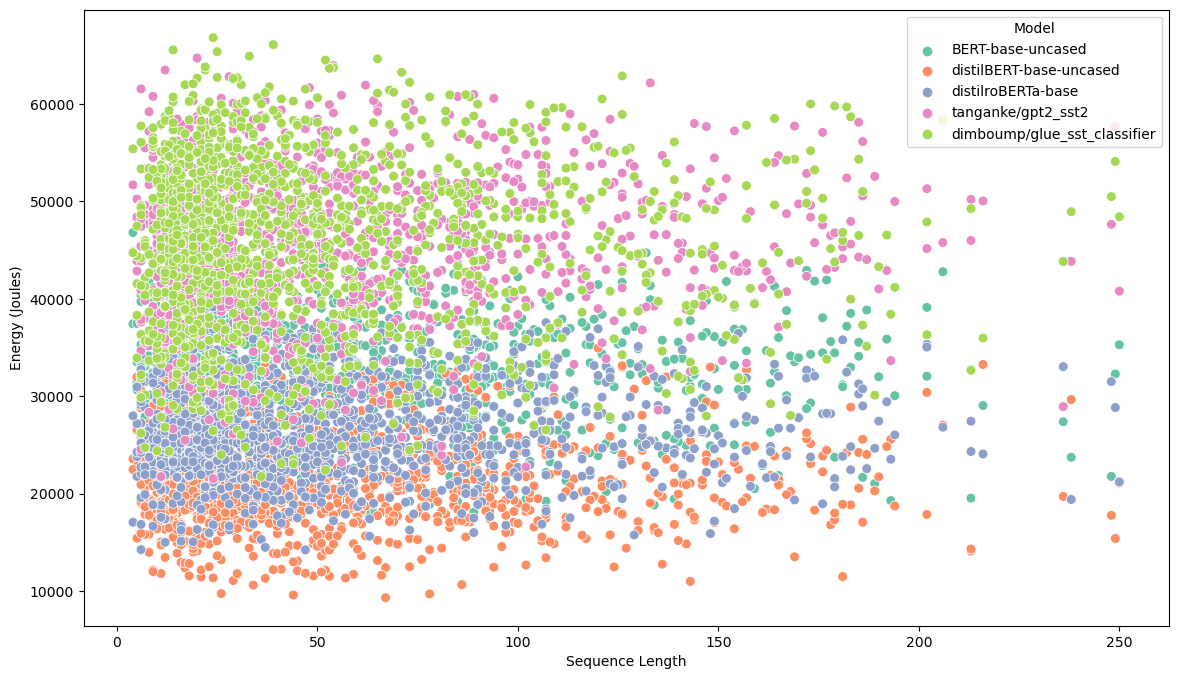

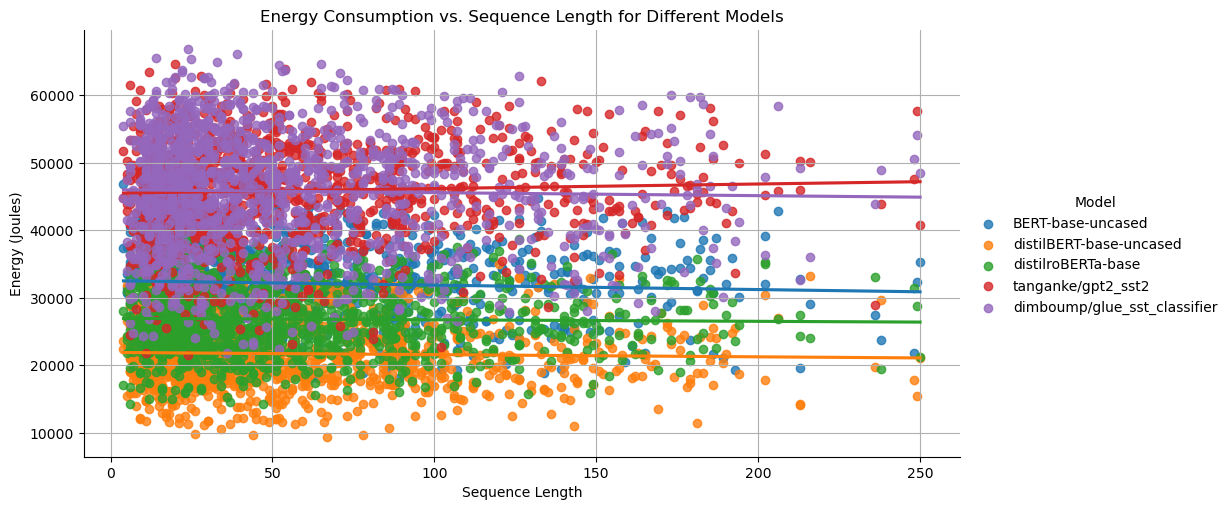

In [56]:
# Set up the plotting environment
plt.figure(figsize=(14, 8))

# Create a scatter plot with hue based on the model
sns.scatterplot(data=results_2_pd, x='Sequence Length', y='Energy (Joules)', hue='Model', palette='Set2', s=50)

# Add a regression line to see the trend for each model
sns.lmplot(data=results_2_pd, x='Sequence Length', y='Energy (Joules)', hue='Model', ci=None, markers="o", aspect=2)

# Customize the plot
plt.title('Energy Consumption vs. Sequence Length for Different Models')
plt.xlabel('Sequence Length')
plt.ylabel('Energy (Joules)')
plt.grid(True)
plt.show()

Plot binned results 

   Sequence Length  Sequence Length Percentile Bin
0             44.0                               2
1             36.0                               1
2             89.0                               3
3             56.0                               2
4             73.0                               2
                           Model  Sequence Length Percentile Bin  \
0              BERT-base-uncased                               0   
1              BERT-base-uncased                               1   
2              BERT-base-uncased                               2   
3              BERT-base-uncased                               3   
4   dimboump/glue_sst_classifier                               0   
5   dimboump/glue_sst_classifier                               1   
6   dimboump/glue_sst_classifier                               2   
7   dimboump/glue_sst_classifier                               3   
8        distilBERT-base-uncased                               0   
9        disti

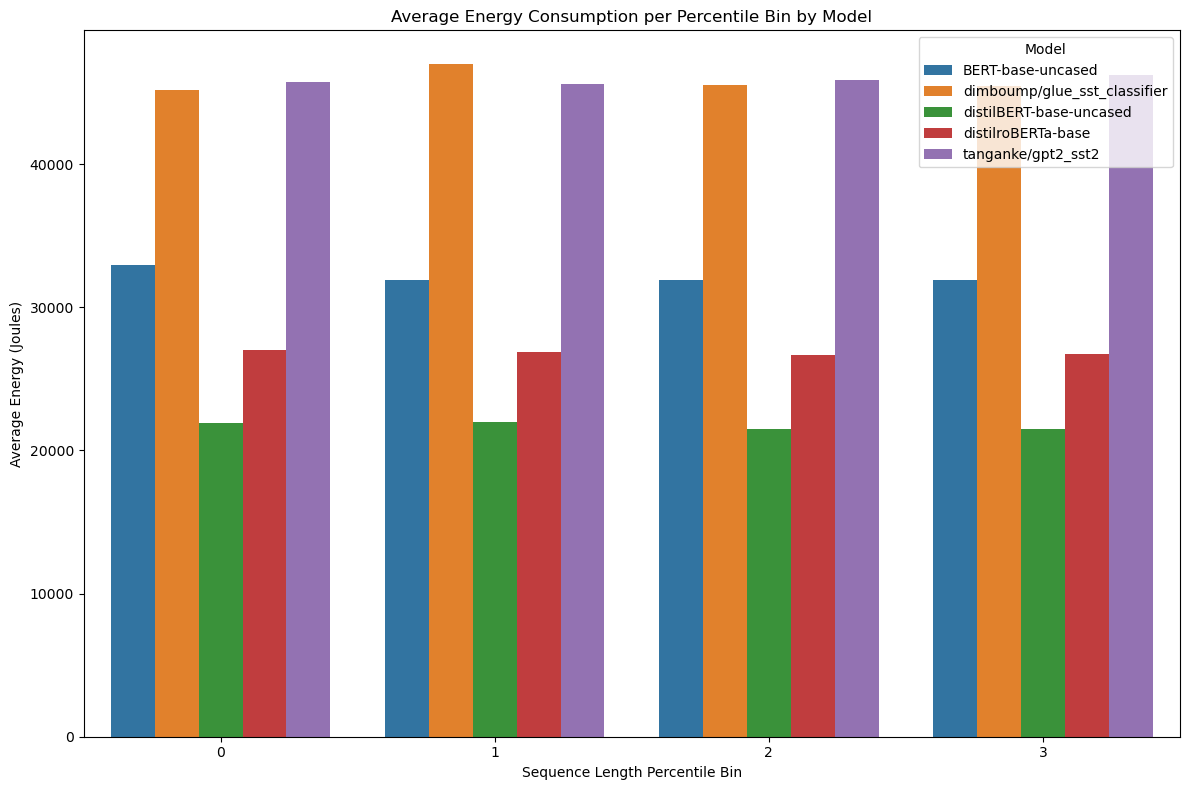

In [63]:
# Define the number of bins (e.g., 4 for quartiles, 10 for deciles)
num_bins = 4

# Bin the sequence lengths by percentile
results_2_pd['Sequence Length Percentile Bin'] = pd.qcut(results_2_pd['Sequence Length'], q=num_bins, labels=False)
print(results_2_pd[['Sequence Length', 'Sequence Length Percentile Bin']].head())

# Group by Model and Sequence Length Percentile Bin, then calculate the mean energy consumption
grouped_data = results_2_pd.groupby(['Model', 'Sequence Length Percentile Bin'])['Energy (Joules)'].mean().reset_index()

# Display the grouped data to verify
print(grouped_data)

# Set the size of the plot
plt.figure(figsize=(12, 8))

# Create a barplot to compare energy consumption across models and percentile bins
sns.barplot(x='Sequence Length Percentile Bin', y='Energy (Joules)', hue='Model', data=grouped_data)

# Set the title and labels
plt.title('Average Energy Consumption per Percentile Bin by Model')
plt.xlabel('Sequence Length Percentile Bin')
plt.ylabel('Average Energy (Joules)')

# Show the plot
plt.tight_layout()
plt.show()

Concludion from this section: Energy consumption is unaffected by query length. At least not enough time to run the entire dataset but the results seem to be clear. Other options to look at: 
- Model size: Compare energy consumption across different model sizes (e.g., BERT-base vs. BERT-large).
- Hardware differences: Look into how different hardware setups (GPUs, TPUs, CPUs) affect energy consumption.
- Batch size: Evaluate whether processing inputs in larger batches has any impact.
- Inference time vs. energy trade-offs: Consider whether certain models trade off between speed and energy efficiency.

## 6.3 Energy Consumption over Query Complexity (Future Work)


## 6.4 Stage 3: Energy Consumption over Different Satges of The Transformer Pipeline (Future Work)

## 6.5 Stage 4: Energy Efficiency of Various Tunned Models (Future Work)

Quantization, Pruning, Vocabulary Transfer, and Distillation